In [1]:
from collections import defaultdict
from datetime import datetime
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from torch.func import jacrev
import torch.nn as nn

np.set_printoptions(threshold=sys.maxsize)

In [7]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, d0, d1, d2, freeze=False):
        super(TwoLayerNet, self).__init__()
        
        layers = []
        
        lin_layer1 = nn.Linear(d0, d1)        
        torch.nn.init.normal_(lin_layer1.bias, mean=0., std=np.sqrt(2. / d0))        
        torch.nn.init.kaiming_normal_(lin_layer1.weight, nonlinearity='relu')
        if freeze:
            lin_layer1.bias.requires_grad = False
            lin_layer1.weight.requires_grad = False
        layers.append(lin_layer1)
        layers.append(nn.ReLU())
        
        lin_layer2 = nn.Linear(d1, d2, bias=False)
        torch.nn.init.normal_(lin_layer2.weight, mean=0., std=np.sqrt(1. / d1))
        # Freeze the weights in the last layer
        lin_layer2.weight.requires_grad = False
        layers.append(lin_layer2)
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
def get_gaussian_data(d0, data_size, target_fn):
    x = torch.tensor(np.random.normal(size=(data_size, d0)), dtype=torch.float)
    y = target_fn(x)
    return x, y

def get_A_stats(model, x):
    out1 = model.layers[0](x).detach().numpy()
    
    pattern = out1 > 0
    rank = np.linalg.matrix_rank(pattern.astype(np.float64))  
    
    parameter_dim = len(model.layers[0].weight) * 2#out1.shape[1]
#     is_close = np.isclose(np.min(np.abs(out1), axis=-1), 0)
#     print(f'is_close: {is_close}')
    eq_num = np.sum(np.isclose(np.min(np.abs(out1), axis=-1), 0))
#     eq_num = np.sum(np.min(np.abs(out1), axis=-1) <= precision)
    region_dim = parameter_dim - eq_num
    
#     N = x.size()[0]
#     false_dict = defaultdict(int)
#     for x_pattern in pattern:
#         for pi, p in enumerate(x_pattern):
#             if not p:
#                 false_dict[pi] += 1
#     dead_num = len([ni for ni in false_dict if false_dict[ni] == N])

    return pattern, rank, region_dim, None#dead_num

###################################################################
###################################################################
def contains_min(model, x, y):    
    N = x.size()[0]
    d1 = len(model.layers[0].weight)
    print(f'N: {N}, d1: {d1}')
    
    out1 = model.layers[0](x).detach().numpy()    
    pattern = out1 > 0
    
    w = model.layers[0].weight.detach().numpy().astype(np.float64)
    b = model.layers[0].bias.detach().numpy().astype(np.float64)
    v = model.layers[2].weight.detach().numpy().astype(np.float64)
    x_np = x.detach().numpy().astype(np.float64)
    y_np = y.detach().numpy().astype(np.float64)
    
    # Check the number of dead neurons
    false_dict = defaultdict(int)
    for x_pattern in pattern:
        for pi, p in enumerate(x_pattern):
            if not p:
                false_dict[pi] += 1
    dead_id = [ni for ni in false_dict if false_dict[ni] == N]
    print(f'dead_num: {len(dead_id)}')
    
    # Construct x for the linear regression problem
    alive_v = np.asarray([[one_v for vi, one_v in enumerate(v[0]) if vi not in dead_id]])
    alive_pattern = np.asarray([
        [one_p for pi, one_p in enumerate(p_row) if pi not in dead_id] for p_row in pattern])
    masked_v = np.concatenate([alive_v for _ in range(N)])
    masked_v[np.invert(alive_pattern)] = 0.
     
    masked_vx = alive_v * x_np
    masked_vx[np.invert(alive_pattern)] = 0.
    
    x_tilde = np.concatenate((masked_v, masked_vx), axis=1)
    
    # Find the linear regression solution
    beta_hat, _, _, _ = np.linalg.lstsq(x_tilde, y_np, rcond=None)
        
    # Check loss
    pred_y = x_tilde @ beta_hat    
    loss = np.mean((pred_y - y_np)**2)
    print(f'loss: {loss}')
    zero_loss = np.isclose(loss, 0)
    if zero_loss:
        print(f'Zero loss')
    else:
        print(f'Not zero loss')
        
    # Check activation pattern of the found solution
    new_weight = w.copy()
    new_bias = b.copy()
    dead_count = 0
    for ni in range(d1):
        if ni not in dead_id:
            new_bias[ni] = beta_hat[ni - dead_count][0]
            new_weight[ni] = beta_hat[d1 - len(dead_id) + ni - dead_count]
        else:
            dead_count += 1
    
    new_out = x_np @ new_weight.T + new_bias   
    new_pattern = new_out > 0
    
    same_pattern = tuple(pattern.reshape(-1)) == tuple(new_pattern.reshape(-1))
    if same_pattern:
        print(f'The same pattern')
    else:
        print(f'Different pattern')
        
    return loss, same_pattern
###################################################################
###################################################################

def train(model, optimizer, scheduler, loss_fn, x, y, epochs_num, distance_epoch, goal_error):
    start_time = datetime.now()
    
    loss_arr = []
#     rank_arr = []
#     ratio_arr = []
    a_rank_arr = []
    region_dim_arr = []
    pattern_arr = []
#     distance_arr = []
    dead_num_arr = []
    
    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    loss_arr.append(loss.item())
    
#     rank, ratio = get_jacobian_rank_spectrum(model, x)
#     rank_arr.append(rank)
#     ratio_arr.append(ratio)
    
    pattern, a_rank, region_dim, dead_num = get_A_stats(model, x)
    pattern_arr.append(pattern)
    a_rank_arr.append(a_rank)
    region_dim_arr.append(region_dim)
    dead_num_arr.append(dead_num)
    
#     distance_arr.append(get_distance_to_boundary(model, x))

    for e_id in range(epochs_num):
        model.train(True)
        
        # We use full-batch gradient descent
        optimizer.zero_grad()

        pred_y = model(x)
        loss = loss_fn(pred_y, y)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        print(f'Epoch {e_id + 1}. Loss: {loss.item()}. lr: {optimizer.param_groups[0]["lr"]}')
        
        e_loss = loss.item()
        loss_arr.append(e_loss)
        
        if goal_error is not None and e_loss <= goal_error:
            break
        
#         rank, ratio = get_jacobian_rank_spectrum(model, x)
#         rank_arr.append(rank)
#         ratio_arr.append(ratio)
        
        pattern, a_rank, region_dim, dead_num = get_A_stats(model, x)
        pattern_arr.append(pattern)
        a_rank_arr.append(a_rank)
        region_dim_arr.append(region_dim)
        dead_num_arr.append(dead_num)
        
#         contains_min(model, x, y)
    
#         if (e_id + 1) % distance_epoch == 0:
#             distance_arr.append(get_distance_to_boundary(model, x))
            
    total_time = datetime.now() - start_time
    hours = int(total_time.seconds / 3600)
    minutes = int(total_time.seconds / 60 - hours * 60)
    seconds = int(total_time.seconds - hours * 3600 - minutes * 60)
    print(f'Elapsed time: {hours}h {minutes}min {int(seconds)}s')        
        
    return loss_arr, a_rank_arr, region_dim_arr, pattern_arr, dead_num_arr
#     return loss_arr, rank_arr, ratio_arr, pattern_arr, distance_arr, a_rank_arr

In [25]:
D1 = 100#800
DATA_SIZE = 20#200
EPOCHS_NUM = 10000#00#0#00
GOAL_ERROR = 0.000000001#05
LR = .5#.5
LR_STEP_SIZE = 1000#0#0
RUNS_NUM = 10

teacher_net = TwoLayerNet(d0=1, d1=D1, d2=1, freeze=True)
teacher_net.train(False)

x, y = get_gaussian_data(d0=1, data_size=DATA_SIZE, target_fn=teacher_net)

total_loss = []
# total_ranks = []
total_a_ranks = []
total_region_dim = [] 
# total_distances = []
# total_ratios = []
total_dead_num = []
total_pattern_arr = []

same_pattern_arr = []
lr_loss_arr = []
final_region_dim_arr = []
final_loss_arr = []

for run_id in range(RUNS_NUM):
    print(f'=== Run {run_id + 1}/{RUNS_NUM} ===')
    student_net = TwoLayerNet(d0=1, d1=D1, d2=1)
    loss_fn = nn.MSELoss()
#     optimizer = torch.optim.Adam(student_net.parameters(), lr=LR)
    optimizer = torch.optim.SGD(student_net.parameters(), lr=LR)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=0.5)

#     loss_arr, rank_arr, ratio_arr, pattern_arr, distance_arr, a_rank_arr = train(
    loss_arr, a_rank_arr, region_dim_arr, pattern_arr, dead_num_arr = train(
        model=student_net, 
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn, 
        x=x, 
        y=y, 
        epochs_num=EPOCHS_NUM,
        distance_epoch=None,#DISTANCE_EPOCH
        goal_error=GOAL_ERROR
    )
    
    lr_loss, same_pattern = contains_min(student_net, x, y)
    lr_loss_arr.append(lr_loss)
    same_pattern_arr.append(same_pattern)
    final_region_dim_arr.append(region_dim_arr[-1])
    final_loss_arr.append(loss_arr[-1])
    
    total_pattern_arr.append(pattern_arr)
    
    total_loss.append(loss_arr)
#     total_ranks.append(rank_arr)
    total_a_ranks.append(a_rank_arr)
    total_region_dim.append(region_dim_arr)
    total_dead_num.append(dead_num_arr)
#     total_ratios.append(ratio_arr)
#     total_distances.append(distance_arr)

print(f'lr loss arr: {lr_loss_arr}')
print(f'same_pattern_arr: {same_pattern_arr}')
print(f'final_region_dim_arr: {final_region_dim_arr}')
print(f'final_loss_arr: {final_loss_arr}')

=== Run 1/10 ===
Epoch 1. Loss: 0.5995656847953796. lr: 0.5
Epoch 2. Loss: 0.33661824464797974. lr: 0.5
Epoch 3. Loss: 0.2117454707622528. lr: 0.5
Epoch 4. Loss: 0.14875265955924988. lr: 0.5
Epoch 5. Loss: 0.11495561897754669. lr: 0.5
Epoch 6. Loss: 0.09561493992805481. lr: 0.5
Epoch 7. Loss: 0.08366052806377411. lr: 0.5
Epoch 8. Loss: 0.07554825395345688. lr: 0.5
Epoch 9. Loss: 0.06953488290309906. lr: 0.5
Epoch 10. Loss: 0.06477547436952591. lr: 0.5
Epoch 11. Loss: 0.06076282262802124. lr: 0.5
Epoch 12. Loss: 0.05723918601870537. lr: 0.5
Epoch 13. Loss: 0.05409182235598564. lr: 0.5
Epoch 14. Loss: 0.05124768614768982. lr: 0.5
Epoch 15. Loss: 0.04862699657678604. lr: 0.5
Epoch 16. Loss: 0.046247951686382294. lr: 0.5
Epoch 17. Loss: 0.04402220621705055. lr: 0.5
Epoch 18. Loss: 0.04191361740231514. lr: 0.5
Epoch 19. Loss: 0.039977848529815674. lr: 0.5
Epoch 20. Loss: 0.038126248866319656. lr: 0.5
Epoch 21. Loss: 0.03640281409025192. lr: 0.5
Epoch 22. Loss: 0.03476690873503685. lr: 0.5
E

Epoch 213. Loss: 0.0012723833788186312. lr: 0.5
Epoch 214. Loss: 0.0012634561862796545. lr: 0.5
Epoch 215. Loss: 0.001254686969332397. lr: 0.5
Epoch 216. Loss: 0.001246055937372148. lr: 0.5
Epoch 217. Loss: 0.0012375524966046214. lr: 0.5
Epoch 218. Loss: 0.0012291674502193928. lr: 0.5
Epoch 219. Loss: 0.0012208886910229921. lr: 0.5
Epoch 220. Loss: 0.0012127287918701768. lr: 0.5
Epoch 221. Loss: 0.0012046708725392818. lr: 0.5
Epoch 222. Loss: 0.0011967248283326626. lr: 0.5
Epoch 223. Loss: 0.0011888773879036307. lr: 0.5
Epoch 224. Loss: 0.001181131461635232. lr: 0.5
Epoch 225. Loss: 0.0011734834406524897. lr: 0.5
Epoch 226. Loss: 0.0011659341398626566. lr: 0.5
Epoch 227. Loss: 0.0011584770400077105. lr: 0.5
Epoch 228. Loss: 0.0011511131888255477. lr: 0.5
Epoch 229. Loss: 0.001143842819146812. lr: 0.5
Epoch 230. Loss: 0.001136659411713481. lr: 0.5
Epoch 231. Loss: 0.001129567390307784. lr: 0.5
Epoch 232. Loss: 0.0011225586058571935. lr: 0.5
Epoch 233. Loss: 0.0011156314285472035. lr: 0.

Epoch 405. Loss: 0.000527599360793829. lr: 0.5
Epoch 406. Loss: 0.0005258140154182911. lr: 0.5
Epoch 407. Loss: 0.0005240393220447004. lr: 0.5
Epoch 408. Loss: 0.0005222720210440457. lr: 0.5
Epoch 409. Loss: 0.0005205162451602519. lr: 0.5
Epoch 410. Loss: 0.0005187687347643077. lr: 0.5
Epoch 411. Loss: 0.0005170297808945179. lr: 0.5
Epoch 412. Loss: 0.000515299616381526. lr: 0.5
Epoch 413. Loss: 0.000513580278493464. lr: 0.5
Epoch 414. Loss: 0.0005118702538311481. lr: 0.5
Epoch 415. Loss: 0.0005101800197735429. lr: 0.5
Epoch 416. Loss: 0.0005085471784695983. lr: 0.5
Epoch 417. Loss: 0.0005069242906756699. lr: 0.5
Epoch 418. Loss: 0.0005053039640188217. lr: 0.5
Epoch 419. Loss: 0.0005036958027631044. lr: 0.5
Epoch 420. Loss: 0.0005020963726565242. lr: 0.5
Epoch 421. Loss: 0.0005005019484087825. lr: 0.5
Epoch 422. Loss: 0.0004989160224795341. lr: 0.5
Epoch 423. Loss: 0.0004973366158083081. lr: 0.5
Epoch 424. Loss: 0.0004957676865160465. lr: 0.5
Epoch 425. Loss: 0.0004942053928971291. lr:

Epoch 671. Loss: 0.00027035485254600644. lr: 0.5
Epoch 672. Loss: 0.00026985412114299834. lr: 0.5
Epoch 673. Loss: 0.0002693529531825334. lr: 0.5
Epoch 674. Loss: 0.0002688559179659933. lr: 0.5
Epoch 675. Loss: 0.00026835795142687857. lr: 0.5
Epoch 676. Loss: 0.0002678626333363354. lr: 0.5
Epoch 677. Loss: 0.0002673668786883354. lr: 0.5
Epoch 678. Loss: 0.0002668746456038207. lr: 0.5
Epoch 679. Loss: 0.0002663835766725242. lr: 0.5
Epoch 680. Loss: 0.00026589297340251505. lr: 0.5
Epoch 681. Loss: 0.000265404669335112. lr: 0.5
Epoch 682. Loss: 0.0002649185189511627. lr: 0.5
Epoch 683. Loss: 0.00026443053502589464. lr: 0.5
Epoch 684. Loss: 0.00026394592714495957. lr: 0.5
Epoch 685. Loss: 0.0002634635311551392. lr: 0.5
Epoch 686. Loss: 0.00026298186276108027. lr: 0.5
Epoch 687. Loss: 0.0002625009510666132. lr: 0.5
Epoch 688. Loss: 0.0002620222803670913. lr: 0.5
Epoch 689. Loss: 0.0002615438716020435. lr: 0.5
Epoch 690. Loss: 0.0002610661613289267. lr: 0.5
Epoch 691. Loss: 0.000260592030826

Epoch 936. Loss: 0.0001747657370287925. lr: 0.5
Epoch 937. Loss: 0.00017450362793169916. lr: 0.5
Epoch 938. Loss: 0.00017424719408154488. lr: 0.5
Epoch 939. Loss: 0.00017398751515429467. lr: 0.5
Epoch 940. Loss: 0.00017372761794831604. lr: 0.5
Epoch 941. Loss: 0.00017347057291772217. lr: 0.5
Epoch 942. Loss: 0.00017321309132967144. lr: 0.5
Epoch 943. Loss: 0.0001729551877360791. lr: 0.5
Epoch 944. Loss: 0.0001726975606288761. lr: 0.5
Epoch 945. Loss: 0.0001724429748719558. lr: 0.5
Epoch 946. Loss: 0.00017218649736605585. lr: 0.5
Epoch 947. Loss: 0.00017193079111166298. lr: 0.5
Epoch 948. Loss: 0.0001716768747428432. lr: 0.5
Epoch 949. Loss: 0.00017142471915576607. lr: 0.5
Epoch 950. Loss: 0.00017117004608735442. lr: 0.5
Epoch 951. Loss: 0.0001709162606857717. lr: 0.5
Epoch 952. Loss: 0.00017066697182599455. lr: 0.5
Epoch 953. Loss: 0.00017041344835888594. lr: 0.5
Epoch 954. Loss: 0.0001701617002254352. lr: 0.5
Epoch 955. Loss: 0.00016991222219076008. lr: 0.5
Epoch 956. Loss: 0.00016966

Epoch 1118. Loss: 0.0001462832879042253. lr: 0.25
Epoch 1119. Loss: 0.0001461814681533724. lr: 0.25
Epoch 1120. Loss: 0.0001460796338506043. lr: 0.25
Epoch 1121. Loss: 0.0001459773484384641. lr: 0.25
Epoch 1122. Loss: 0.00014587554323952645. lr: 0.25
Epoch 1123. Loss: 0.00014577482943423092. lr: 0.25
Epoch 1124. Loss: 0.000145671860082075. lr: 0.25
Epoch 1125. Loss: 0.0001455718738725409. lr: 0.25
Epoch 1126. Loss: 0.00014547011232934892. lr: 0.25
Epoch 1127. Loss: 0.00014536891831085086. lr: 0.25
Epoch 1128. Loss: 0.00014526858285535127. lr: 0.25
Epoch 1129. Loss: 0.00014516801456920803. lr: 0.25
Epoch 1130. Loss: 0.00014506722800433636. lr: 0.25
Epoch 1131. Loss: 0.00014496610674541444. lr: 0.25
Epoch 1132. Loss: 0.000144865334732458. lr: 0.25
Epoch 1133. Loss: 0.00014476495562121272. lr: 0.25
Epoch 1134. Loss: 0.00014466462016571313. lr: 0.25
Epoch 1135. Loss: 0.00014456352801062167. lr: 0.25
Epoch 1136. Loss: 0.00014446358545683324. lr: 0.25
Epoch 1137. Loss: 0.0001443624059902504.

Epoch 1324. Loss: 0.00012736610369756818. lr: 0.25
Epoch 1325. Loss: 0.0001272825466003269. lr: 0.25
Epoch 1326. Loss: 0.00012720133236143738. lr: 0.25
Epoch 1327. Loss: 0.00012711688759736717. lr: 0.25
Epoch 1328. Loss: 0.00012703496031463146. lr: 0.25
Epoch 1329. Loss: 0.00012695240729954094. lr: 0.25
Epoch 1330. Loss: 0.00012687072739936411. lr: 0.25
Epoch 1331. Loss: 0.00012678706843871623. lr: 0.25
Epoch 1332. Loss: 0.00012670506839640439. lr: 0.25
Epoch 1333. Loss: 0.00012662234075833112. lr: 0.25
Epoch 1334. Loss: 0.0001265408645849675. lr: 0.25
Epoch 1335. Loss: 0.00012645866081584245. lr: 0.25
Epoch 1336. Loss: 0.00012637616600841284. lr: 0.25
Epoch 1337. Loss: 0.00012629380216822028. lr: 0.25
Epoch 1338. Loss: 0.00012621170026250184. lr: 0.25
Epoch 1339. Loss: 0.00012613066064659506. lr: 0.25
Epoch 1340. Loss: 0.00012604845687747002. lr: 0.25
Epoch 1341. Loss: 0.00012596711167134345. lr: 0.25
Epoch 1342. Loss: 0.00012588415120262653. lr: 0.25
Epoch 1343. Loss: 0.0001258041302

Epoch 1516. Loss: 0.00011273528070887551. lr: 0.25
Epoch 1517. Loss: 0.00011266516230534762. lr: 0.25
Epoch 1518. Loss: 0.00011259593156864867. lr: 0.25
Epoch 1519. Loss: 0.00011252590775256976. lr: 0.25
Epoch 1520. Loss: 0.00011245724454056472. lr: 0.25
Epoch 1521. Loss: 0.00011238586012041196. lr: 0.25
Epoch 1522. Loss: 0.00011231692042201757. lr: 0.25
Epoch 1523. Loss: 0.00011224909394513816. lr: 0.25
Epoch 1524. Loss: 0.00011217832798138261. lr: 0.25
Epoch 1525. Loss: 0.00011210981756448746. lr: 0.25
Epoch 1526. Loss: 0.00011204068141523749. lr: 0.25
Epoch 1527. Loss: 0.00011197176354471594. lr: 0.25
Epoch 1528. Loss: 0.00011190248187631369. lr: 0.25
Epoch 1529. Loss: 0.00011183336755493656. lr: 0.25
Epoch 1530. Loss: 0.00011176466068718582. lr: 0.25
Epoch 1531. Loss: 0.00011169604113092646. lr: 0.25
Epoch 1532. Loss: 0.00011162685404997319. lr: 0.25
Epoch 1533. Loss: 0.00011155770334880799. lr: 0.25
Epoch 1534. Loss: 0.00011148939665872604. lr: 0.25
Epoch 1535. Loss: 0.00011142079

Epoch 1744. Loss: 9.903057798510417e-05. lr: 0.25
Epoch 1745. Loss: 9.898068674374372e-05. lr: 0.25
Epoch 1746. Loss: 9.892955131363124e-05. lr: 0.25
Epoch 1747. Loss: 9.88794636214152e-05. lr: 0.25
Epoch 1748. Loss: 9.882915765047073e-05. lr: 0.25
Epoch 1749. Loss: 9.877818956738338e-05. lr: 0.25
Epoch 1750. Loss: 9.872748341877013e-05. lr: 0.25
Epoch 1751. Loss: 9.867810877040029e-05. lr: 0.25
Epoch 1752. Loss: 9.862816659733653e-05. lr: 0.25
Epoch 1753. Loss: 9.857688564807177e-05. lr: 0.25
Epoch 1754. Loss: 9.852675430011004e-05. lr: 0.25
Epoch 1755. Loss: 9.847622277447954e-05. lr: 0.25
Epoch 1756. Loss: 9.842668805504218e-05. lr: 0.25
Epoch 1757. Loss: 9.837612742558122e-05. lr: 0.25
Epoch 1758. Loss: 9.832639625528827e-05. lr: 0.25
Epoch 1759. Loss: 9.827498433878645e-05. lr: 0.25
Epoch 1760. Loss: 9.822532592806965e-05. lr: 0.25
Epoch 1761. Loss: 9.817526733968407e-05. lr: 0.25
Epoch 1762. Loss: 9.812579810386524e-05. lr: 0.25
Epoch 1763. Loss: 9.807529568206519e-05. lr: 0.25
E

Epoch 1957. Loss: 8.894846541807055e-05. lr: 0.25
Epoch 1958. Loss: 8.890349272405729e-05. lr: 0.25
Epoch 1959. Loss: 8.885956776794046e-05. lr: 0.25
Epoch 1960. Loss: 8.88152644620277e-05. lr: 0.25
Epoch 1961. Loss: 8.877080836100504e-05. lr: 0.25
Epoch 1962. Loss: 8.872733451426029e-05. lr: 0.25
Epoch 1963. Loss: 8.868233999237418e-05. lr: 0.25
Epoch 1964. Loss: 8.863832044880837e-05. lr: 0.25
Epoch 1965. Loss: 8.85943736648187e-05. lr: 0.25
Epoch 1966. Loss: 8.855031046550721e-05. lr: 0.25
Epoch 1967. Loss: 8.850668382365257e-05. lr: 0.25
Epoch 1968. Loss: 8.846358105074614e-05. lr: 0.25
Epoch 1969. Loss: 8.841966337058693e-05. lr: 0.25
Epoch 1970. Loss: 8.837595669319853e-05. lr: 0.25
Epoch 1971. Loss: 8.833160245558247e-05. lr: 0.25
Epoch 1972. Loss: 8.828839054331183e-05. lr: 0.25
Epoch 1973. Loss: 8.8244560174644e-05. lr: 0.25
Epoch 1974. Loss: 8.820132643450052e-05. lr: 0.25
Epoch 1975. Loss: 8.815816545393318e-05. lr: 0.25
Epoch 1976. Loss: 8.811485895421356e-05. lr: 0.25
Epoc

Epoch 2251. Loss: 8.188420906662941e-05. lr: 0.125
Epoch 2252. Loss: 8.186443301383406e-05. lr: 0.125
Epoch 2253. Loss: 8.184427133528516e-05. lr: 0.125
Epoch 2254. Loss: 8.182499004760757e-05. lr: 0.125
Epoch 2255. Loss: 8.180455915862694e-05. lr: 0.125
Epoch 2256. Loss: 8.17847321741283e-05. lr: 0.125
Epoch 2257. Loss: 8.176494156941772e-05. lr: 0.125
Epoch 2258. Loss: 8.174522372428328e-05. lr: 0.125
Epoch 2259. Loss: 8.172511297743767e-05. lr: 0.125
Epoch 2260. Loss: 8.170564979081973e-05. lr: 0.125
Epoch 2261. Loss: 8.168580097844824e-05. lr: 0.125
Epoch 2262. Loss: 8.166651969077066e-05. lr: 0.125
Epoch 2263. Loss: 8.164652535924688e-05. lr: 0.125
Epoch 2264. Loss: 8.16262181615457e-05. lr: 0.125
Epoch 2265. Loss: 8.160615107044578e-05. lr: 0.125
Epoch 2266. Loss: 8.158660784829408e-05. lr: 0.125
Epoch 2267. Loss: 8.156652620527893e-05. lr: 0.125
Epoch 2268. Loss: 8.15476814750582e-05. lr: 0.125
Epoch 2269. Loss: 8.152768714353442e-05. lr: 0.125
Epoch 2270. Loss: 8.15081803011708

Epoch 2587. Loss: 7.552070746896788e-05. lr: 0.125
Epoch 2588. Loss: 7.55017827032134e-05. lr: 0.125
Epoch 2589. Loss: 7.548424764536321e-05. lr: 0.125
Epoch 2590. Loss: 7.546637789346278e-05. lr: 0.125
Epoch 2591. Loss: 7.544814434368163e-05. lr: 0.125
Epoch 2592. Loss: 7.54302745917812e-05. lr: 0.125
Epoch 2593. Loss: 7.541214290540665e-05. lr: 0.125
Epoch 2594. Loss: 7.539403304690495e-05. lr: 0.125
Epoch 2595. Loss: 7.537637429777533e-05. lr: 0.125
Epoch 2596. Loss: 7.535905024269596e-05. lr: 0.125
Epoch 2597. Loss: 7.534013275289908e-05. lr: 0.125
Epoch 2598. Loss: 7.532197923865169e-05. lr: 0.125
Epoch 2599. Loss: 7.530402217525989e-05. lr: 0.125
Epoch 2600. Loss: 7.528623973485082e-05. lr: 0.125
Epoch 2601. Loss: 7.526788976974785e-05. lr: 0.125
Epoch 2602. Loss: 7.525041291955858e-05. lr: 0.125
Epoch 2603. Loss: 7.523217936977744e-05. lr: 0.125
Epoch 2604. Loss: 7.521428051404655e-05. lr: 0.125
Epoch 2605. Loss: 7.519636710640043e-05. lr: 0.125
Epoch 2606. Loss: 7.5178693805355

Epoch 2903. Loss: 7.006469240877777e-05. lr: 0.125
Epoch 2904. Loss: 7.004897634033114e-05. lr: 0.125
Epoch 2905. Loss: 7.003192149568349e-05. lr: 0.125
Epoch 2906. Loss: 7.00157179380767e-05. lr: 0.125
Epoch 2907. Loss: 6.999947800068185e-05. lr: 0.125
Epoch 2908. Loss: 6.998307799221948e-05. lr: 0.125
Epoch 2909. Loss: 6.996635056566447e-05. lr: 0.125
Epoch 2910. Loss: 6.995018338784575e-05. lr: 0.125
Epoch 2911. Loss: 6.993325951043516e-05. lr: 0.125
Epoch 2912. Loss: 6.99173760949634e-05. lr: 0.125
Epoch 2913. Loss: 6.99007578077726e-05. lr: 0.125
Epoch 2914. Loss: 6.988398672547191e-05. lr: 0.125
Epoch 2915. Loss: 6.986778316786513e-05. lr: 0.125
Epoch 2916. Loss: 6.9851812440902e-05. lr: 0.125
Epoch 2917. Loss: 6.983523780945688e-05. lr: 0.125
Epoch 2918. Loss: 6.981827027630061e-05. lr: 0.125
Epoch 2919. Loss: 6.980203033890575e-05. lr: 0.125
Epoch 2920. Loss: 6.97855357429944e-05. lr: 0.125
Epoch 2921. Loss: 6.97687646606937e-05. lr: 0.125
Epoch 2922. Loss: 6.975272845011204e-0

Epoch 3068. Loss: 6.793408829253167e-05. lr: 0.0625
Epoch 3069. Loss: 6.79257937008515e-05. lr: 0.0625
Epoch 3070. Loss: 6.791762280045077e-05. lr: 0.0625
Epoch 3071. Loss: 6.79102013236843e-05. lr: 0.0625
Epoch 3072. Loss: 6.790241604903713e-05. lr: 0.0625
Epoch 3073. Loss: 6.789427425246686e-05. lr: 0.0625
Epoch 3074. Loss: 6.788635801058263e-05. lr: 0.0625
Epoch 3075. Loss: 6.787874735891819e-05. lr: 0.0625
Epoch 3076. Loss: 6.787007441744208e-05. lr: 0.0625
Epoch 3077. Loss: 6.7862645664718e-05. lr: 0.0625
Epoch 3078. Loss: 6.785446748835966e-05. lr: 0.0625
Epoch 3079. Loss: 6.784662400605157e-05. lr: 0.0625
Epoch 3080. Loss: 6.783859862480313e-05. lr: 0.0625
Epoch 3081. Loss: 6.783079879824072e-05. lr: 0.0625
Epoch 3082. Loss: 6.782279524486512e-05. lr: 0.0625
Epoch 3083. Loss: 6.781418778700754e-05. lr: 0.0625
Epoch 3084. Loss: 6.78063661325723e-05. lr: 0.0625
Epoch 3085. Loss: 6.779818795621395e-05. lr: 0.0625
Epoch 3086. Loss: 6.779078103136271e-05. lr: 0.0625
Epoch 3087. Loss:

Epoch 3403. Loss: 6.533317355206236e-05. lr: 0.0625
Epoch 3404. Loss: 6.532558472827077e-05. lr: 0.0625
Epoch 3405. Loss: 6.531858525704592e-05. lr: 0.0625
Epoch 3406. Loss: 6.531073449878022e-05. lr: 0.0625
Epoch 3407. Loss: 6.530286191264167e-05. lr: 0.0625
Epoch 3408. Loss: 6.529517122544348e-05. lr: 0.0625
Epoch 3409. Loss: 6.528778612846509e-05. lr: 0.0625
Epoch 3410. Loss: 6.527917867060751e-05. lr: 0.0625
Epoch 3411. Loss: 6.52723028906621e-05. lr: 0.0625
Epoch 3412. Loss: 6.526536890305579e-05. lr: 0.0625
Epoch 3413. Loss: 6.525739445351064e-05. lr: 0.0625
Epoch 3414. Loss: 6.525012577185407e-05. lr: 0.0625
Epoch 3415. Loss: 6.524279888253659e-05. lr: 0.0625
Epoch 3416. Loss: 6.523515185108408e-05. lr: 0.0625
Epoch 3417. Loss: 6.522742478409782e-05. lr: 0.0625
Epoch 3418. Loss: 6.52187954983674e-05. lr: 0.0625
Epoch 3419. Loss: 6.52117669233121e-05. lr: 0.0625
Epoch 3420. Loss: 6.520437455037609e-05. lr: 0.0625
Epoch 3421. Loss: 6.519715680042282e-05. lr: 0.0625
Epoch 3422. Los

Epoch 3599. Loss: 6.386473251041025e-05. lr: 0.0625
Epoch 3600. Loss: 6.385728192981333e-05. lr: 0.0625
Epoch 3601. Loss: 6.385040614986792e-05. lr: 0.0625
Epoch 3602. Loss: 6.384226435329765e-05. lr: 0.0625
Epoch 3603. Loss: 6.383558502420783e-05. lr: 0.0625
Epoch 3604. Loss: 6.382763240253553e-05. lr: 0.0625
Epoch 3605. Loss: 6.382070569088683e-05. lr: 0.0625
Epoch 3606. Loss: 6.381319690262899e-05. lr: 0.0625
Epoch 3607. Loss: 6.380554259521887e-05. lr: 0.0625
Epoch 3608. Loss: 6.379857222782448e-05. lr: 0.0625
Epoch 3609. Loss: 6.379086698871106e-05. lr: 0.0625
Epoch 3610. Loss: 6.378368561854586e-05. lr: 0.0625
Epoch 3611. Loss: 6.377622776199132e-05. lr: 0.0625
Epoch 3612. Loss: 6.376912642735988e-05. lr: 0.0625
Epoch 3613. Loss: 6.376157398335636e-05. lr: 0.0625
Epoch 3614. Loss: 6.375397060764953e-05. lr: 0.0625
Epoch 3615. Loss: 6.374663644237444e-05. lr: 0.0625
Epoch 3616. Loss: 6.373961514327675e-05. lr: 0.0625
Epoch 3617. Loss: 6.373165524564683e-05. lr: 0.0625
Epoch 3618. 

Epoch 3780. Loss: 6.254159234231338e-05. lr: 0.0625
Epoch 3781. Loss: 6.253413448575884e-05. lr: 0.0625
Epoch 3782. Loss: 6.252722960198298e-05. lr: 0.0625
Epoch 3783. Loss: 6.251993909245357e-05. lr: 0.0625
Epoch 3784. Loss: 6.251283048186451e-05. lr: 0.0625
Epoch 3785. Loss: 6.250570004340261e-05. lr: 0.0625
Epoch 3786. Loss: 6.249880243558437e-05. lr: 0.0625
Epoch 3787. Loss: 6.249175930861384e-05. lr: 0.0625
Epoch 3788. Loss: 6.248427962418646e-05. lr: 0.0625
Epoch 3789. Loss: 6.247653800528497e-05. lr: 0.0625
Epoch 3790. Loss: 6.246985867619514e-05. lr: 0.0625
Epoch 3791. Loss: 6.246317934710532e-05. lr: 0.0625
Epoch 3792. Loss: 6.245581607799977e-05. lr: 0.0625
Epoch 3793. Loss: 6.244842370506376e-05. lr: 0.0625
Epoch 3794. Loss: 6.244110409170389e-05. lr: 0.0625
Epoch 3795. Loss: 6.243437383091077e-05. lr: 0.0625
Epoch 3796. Loss: 6.242670497158542e-05. lr: 0.0625
Epoch 3797. Loss: 6.241955270525068e-05. lr: 0.0625
Epoch 3798. Loss: 6.241260416572914e-05. lr: 0.0625
Epoch 3799. 

Epoch 3982. Loss: 6.110542744863778e-05. lr: 0.0625
Epoch 3983. Loss: 6.10983042861335e-05. lr: 0.0625
Epoch 3984. Loss: 6.109121022745967e-05. lr: 0.0625
Epoch 3985. Loss: 6.108451634645462e-05. lr: 0.0625
Epoch 3986. Loss: 6.107714580139145e-05. lr: 0.0625
Epoch 3987. Loss: 6.10702991252765e-05. lr: 0.0625
Epoch 3988. Loss: 6.106314685894176e-05. lr: 0.0625
Epoch 3989. Loss: 6.105679494794458e-05. lr: 0.0625
Epoch 3990. Loss: 6.104943167883903e-05. lr: 0.0625
Epoch 3991. Loss: 6.104186468292028e-05. lr: 0.0625
Epoch 3992. Loss: 6.103552004788071e-05. lr: 0.0625
Epoch 3993. Loss: 6.102841507527046e-05. lr: 0.0625
Epoch 3994. Loss: 6.102126280893572e-05. lr: 0.0625
Epoch 3995. Loss: 6.101433973526582e-05. lr: 0.0625
Epoch 3996. Loss: 6.100700193201192e-05. lr: 0.0625
Epoch 3997. Loss: 6.099998063291423e-05. lr: 0.0625
Epoch 3998. Loss: 6.099369056755677e-05. lr: 0.0625
Epoch 3999. Loss: 6.098665835452266e-05. lr: 0.0625
Epoch 4000. Loss: 6.097955701989122e-05. lr: 0.03125
Epoch 4001. L

Epoch 4185. Loss: 6.033134559402242e-05. lr: 0.03125
Epoch 4186. Loss: 6.032803139532916e-05. lr: 0.03125
Epoch 4187. Loss: 6.032429519109428e-05. lr: 0.03125
Epoch 4188. Loss: 6.032060628058389e-05. lr: 0.03125
Epoch 4189. Loss: 6.031806697137654e-05. lr: 0.03125
Epoch 4190. Loss: 6.031415978213772e-05. lr: 0.03125
Epoch 4191. Loss: 6.031031807651743e-05. lr: 0.03125
Epoch 4192. Loss: 6.0307174862828106e-05. lr: 0.03125
Epoch 4193. Loss: 6.0303711507003754e-05. lr: 0.03125
Epoch 4194. Loss: 6.0300284530967474e-05. lr: 0.03125
Epoch 4195. Loss: 6.029655924066901e-05. lr: 0.03125
Epoch 4196. Loss: 6.02936306677293e-05. lr: 0.03125
Epoch 4197. Loss: 6.0290061810519546e-05. lr: 0.03125
Epoch 4198. Loss: 6.028672942193225e-05. lr: 0.03125
Epoch 4199. Loss: 6.0283084167167544e-05. lr: 0.03125
Epoch 4200. Loss: 6.0279231547610834e-05. lr: 0.03125
Epoch 4201. Loss: 6.027667041053064e-05. lr: 0.03125
Epoch 4202. Loss: 6.027240306138992e-05. lr: 0.03125
Epoch 4203. Loss: 6.0268910601735115e-05.

Epoch 4358. Loss: 5.973697261651978e-05. lr: 0.03125
Epoch 4359. Loss: 5.9733323723776266e-05. lr: 0.03125
Epoch 4360. Loss: 5.9729420172516257e-05. lr: 0.03125
Epoch 4361. Loss: 5.972643702989444e-05. lr: 0.03125
Epoch 4362. Loss: 5.9722991863964126e-05. lr: 0.03125
Epoch 4363. Loss: 5.971954669803381e-05. lr: 0.03125
Epoch 4364. Loss: 5.971584323560819e-05. lr: 0.03125
Epoch 4365. Loss: 5.971286373096518e-05. lr: 0.03125
Epoch 4366. Loss: 5.970926576992497e-05. lr: 0.03125
Epoch 4367. Loss: 5.9705744206439704e-05. lr: 0.03125
Epoch 4368. Loss: 5.970239726593718e-05. lr: 0.03125
Epoch 4369. Loss: 5.969927224214189e-05. lr: 0.03125
Epoch 4370. Loss: 5.9695874369936064e-05. lr: 0.03125
Epoch 4371. Loss: 5.969196354271844e-05. lr: 0.03125
Epoch 4372. Loss: 5.968838740955107e-05. lr: 0.03125
Epoch 4373. Loss: 5.968561163172126e-05. lr: 0.03125
Epoch 4374. Loss: 5.9682199207600206e-05. lr: 0.03125
Epoch 4375. Loss: 5.967815377516672e-05. lr: 0.03125
Epoch 4376. Loss: 5.9674883232219145e-05

Epoch 4551. Loss: 5.908096136408858e-05. lr: 0.03125
Epoch 4552. Loss: 5.907745799049735e-05. lr: 0.03125
Epoch 4553. Loss: 5.907406011829153e-05. lr: 0.03125
Epoch 4554. Loss: 5.907114245928824e-05. lr: 0.03125
Epoch 4555. Loss: 5.9067806432722136e-05. lr: 0.03125
Epoch 4556. Loss: 5.906468868488446e-05. lr: 0.03125
Epoch 4557. Loss: 5.9061228967038915e-05. lr: 0.03125
Epoch 4558. Loss: 5.9057587350253016e-05. lr: 0.03125
Epoch 4559. Loss: 5.905432044528425e-05. lr: 0.03125
Epoch 4560. Loss: 5.905083889956586e-05. lr: 0.03125
Epoch 4561. Loss: 5.9047517424914986e-05. lr: 0.03125
Epoch 4562. Loss: 5.904369754716754e-05. lr: 0.03125
Epoch 4563. Loss: 5.904068166273646e-05. lr: 0.03125
Epoch 4564. Loss: 5.903730198042467e-05. lr: 0.03125
Epoch 4565. Loss: 5.9033969591837376e-05. lr: 0.03125
Epoch 4566. Loss: 5.903012788621709e-05. lr: 0.03125
Epoch 4567. Loss: 5.902797056478448e-05. lr: 0.03125
Epoch 4568. Loss: 5.902397242607549e-05. lr: 0.03125
Epoch 4569. Loss: 5.902037810301408e-05. 

Epoch 4748. Loss: 5.842178507009521e-05. lr: 0.03125
Epoch 4749. Loss: 5.8417866966919973e-05. lr: 0.03125
Epoch 4750. Loss: 5.841482197865844e-05. lr: 0.03125
Epoch 4751. Loss: 5.84117769903969e-05. lr: 0.03125
Epoch 4752. Loss: 5.84082372370176e-05. lr: 0.03125
Epoch 4753. Loss: 5.8404781157150865e-05. lr: 0.03125
Epoch 4754. Loss: 5.840143421664834e-05. lr: 0.03125
Epoch 4755. Loss: 5.839837103849277e-05. lr: 0.03125
Epoch 4756. Loss: 5.8394962252350524e-05. lr: 0.03125
Epoch 4757. Loss: 5.839187724632211e-05. lr: 0.03125
Epoch 4758. Loss: 5.838818469783291e-05. lr: 0.03125
Epoch 4759. Loss: 5.838492143084295e-05. lr: 0.03125
Epoch 4760. Loss: 5.838158540427685e-05. lr: 0.03125
Epoch 4761. Loss: 5.837847857037559e-05. lr: 0.03125
Epoch 4762. Loss: 5.8375182561576366e-05. lr: 0.03125
Epoch 4763. Loss: 5.8371795603306964e-05. lr: 0.03125
Epoch 4764. Loss: 5.8368379541207105e-05. lr: 0.03125
Epoch 4765. Loss: 5.836548007209785e-05. lr: 0.03125
Epoch 4766. Loss: 5.836179479956627e-05. l

Epoch 4943. Loss: 5.777690603281371e-05. lr: 0.03125
Epoch 4944. Loss: 5.777389742434025e-05. lr: 0.03125
Epoch 4945. Loss: 5.77705395699013e-05. lr: 0.03125
Epoch 4946. Loss: 5.7767309044720605e-05. lr: 0.03125
Epoch 4947. Loss: 5.776395119028166e-05. lr: 0.03125
Epoch 4948. Loss: 5.776113175670616e-05. lr: 0.03125
Epoch 4949. Loss: 5.775795943918638e-05. lr: 0.03125
Epoch 4950. Loss: 5.775407771579921e-05. lr: 0.03125
Epoch 4951. Loss: 5.775089448434301e-05. lr: 0.03125
Epoch 4952. Loss: 5.7748307881411165e-05. lr: 0.03125
Epoch 4953. Loss: 5.77447353862226e-05. lr: 0.03125
Epoch 4954. Loss: 5.7741290220292285e-05. lr: 0.03125
Epoch 4955. Loss: 5.773817974841222e-05. lr: 0.03125
Epoch 4956. Loss: 5.773505472461693e-05. lr: 0.03125
Epoch 4957. Loss: 5.773142402176745e-05. lr: 0.03125
Epoch 4958. Loss: 5.772810982307419e-05. lr: 0.03125
Epoch 4959. Loss: 5.772537406301126e-05. lr: 0.03125
Epoch 4960. Loss: 5.7721852499525994e-05. lr: 0.03125
Epoch 4961. Loss: 5.7718851167010143e-05. lr

Epoch 5118. Loss: 5.7396518968744203e-05. lr: 0.015625
Epoch 5119. Loss: 5.739491825806908e-05. lr: 0.015625
Epoch 5120. Loss: 5.7393153838347644e-05. lr: 0.015625
Epoch 5121. Loss: 5.739139669458382e-05. lr: 0.015625
Epoch 5122. Loss: 5.738953404943459e-05. lr: 0.015625
Epoch 5123. Loss: 5.738802065025084e-05. lr: 0.015625
Epoch 5124. Loss: 5.738659456255846e-05. lr: 0.015625
Epoch 5125. Loss: 5.738505205954425e-05. lr: 0.015625
Epoch 5126. Loss: 5.738316031056456e-05. lr: 0.015625
Epoch 5127. Loss: 5.738126492360607e-05. lr: 0.015625
Epoch 5128. Loss: 5.7379365898668766e-05. lr: 0.015625
Epoch 5129. Loss: 5.73778452235274e-05. lr: 0.015625
Epoch 5130. Loss: 5.737663741456345e-05. lr: 0.015625
Epoch 5131. Loss: 5.7375076721655205e-05. lr: 0.015625
Epoch 5132. Loss: 5.7373748859390616e-05. lr: 0.015625
Epoch 5133. Loss: 5.7371362345293164e-05. lr: 0.015625
Epoch 5134. Loss: 5.7369772548554465e-05. lr: 0.015625
Epoch 5135. Loss: 5.736831371905282e-05. lr: 0.015625
Epoch 5136. Loss: 5.73

Epoch 5313. Loss: 5.707847958547063e-05. lr: 0.015625
Epoch 5314. Loss: 5.707679156330414e-05. lr: 0.015625
Epoch 5315. Loss: 5.707545278710313e-05. lr: 0.015625
Epoch 5316. Loss: 5.707382661057636e-05. lr: 0.015625
Epoch 5317. Loss: 5.707222589990124e-05. lr: 0.015625
Epoch 5318. Loss: 5.707033415092155e-05. lr: 0.015625
Epoch 5319. Loss: 5.7069155445788056e-05. lr: 0.015625
Epoch 5320. Loss: 5.706698721041903e-05. lr: 0.015625
Epoch 5321. Loss: 5.706540105165914e-05. lr: 0.015625
Epoch 5322. Loss: 5.706339652533643e-05. lr: 0.015625
Epoch 5323. Loss: 5.706217052647844e-05. lr: 0.015625
Epoch 5324. Loss: 5.706080264644697e-05. lr: 0.015625
Epoch 5325. Loss: 5.705911826225929e-05. lr: 0.015625
Epoch 5326. Loss: 5.705752846552059e-05. lr: 0.015625
Epoch 5327. Loss: 5.70556367165409e-05. lr: 0.015625
Epoch 5328. Loss: 5.7054196076933295e-05. lr: 0.015625
Epoch 5329. Loss: 5.70530719414819e-05. lr: 0.015625
Epoch 5330. Loss: 5.7051242038141936e-05. lr: 0.015625
Epoch 5331. Loss: 5.7049117

Epoch 5506. Loss: 5.676565342582762e-05. lr: 0.015625
Epoch 5507. Loss: 5.676460568793118e-05. lr: 0.015625
Epoch 5508. Loss: 5.676256841979921e-05. lr: 0.015625
Epoch 5509. Loss: 5.676103683072142e-05. lr: 0.015625
Epoch 5510. Loss: 5.675954162143171e-05. lr: 0.015625
Epoch 5511. Loss: 5.6757893617032096e-05. lr: 0.015625
Epoch 5512. Loss: 5.675599095411599e-05. lr: 0.015625
Epoch 5513. Loss: 5.675469947163947e-05. lr: 0.015625
Epoch 5514. Loss: 5.6753204262349755e-05. lr: 0.015625
Epoch 5515. Loss: 5.675110878655687e-05. lr: 0.015625
Epoch 5516. Loss: 5.6749664508970454e-05. lr: 0.015625
Epoch 5517. Loss: 5.674860585713759e-05. lr: 0.015625
Epoch 5518. Loss: 5.6746262998785824e-05. lr: 0.015625
Epoch 5519. Loss: 5.674473868566565e-05. lr: 0.015625
Epoch 5520. Loss: 5.674329077010043e-05. lr: 0.015625
Epoch 5521. Loss: 5.6741770094959065e-05. lr: 0.015625
Epoch 5522. Loss: 5.6740005675237626e-05. lr: 0.015625
Epoch 5523. Loss: 5.673767373082228e-05. lr: 0.015625
Epoch 5524. Loss: 5.67

Epoch 5700. Loss: 5.6453100114595145e-05. lr: 0.015625
Epoch 5701. Loss: 5.6450975534971803e-05. lr: 0.015625
Epoch 5702. Loss: 5.644935299642384e-05. lr: 0.015625
Epoch 5703. Loss: 5.644770135404542e-05. lr: 0.015625
Epoch 5704. Loss: 5.6446431699441746e-05. lr: 0.015625
Epoch 5705. Loss: 5.6445092923240736e-05. lr: 0.015625
Epoch 5706. Loss: 5.644279735861346e-05. lr: 0.015625
Epoch 5707. Loss: 5.644144766847603e-05. lr: 0.015625
Epoch 5708. Loss: 5.6439526815665886e-05. lr: 0.015625
Epoch 5709. Loss: 5.643821714329533e-05. lr: 0.015625
Epoch 5710. Loss: 5.643710755975917e-05. lr: 0.015625
Epoch 5711. Loss: 5.64349684282206e-05. lr: 0.015625
Epoch 5712. Loss: 5.643304393743165e-05. lr: 0.015625
Epoch 5713. Loss: 5.643163967761211e-05. lr: 0.015625
Epoch 5714. Loss: 5.6429737014696e-05. lr: 0.015625
Epoch 5715. Loss: 5.6428769312333316e-05. lr: 0.015625
Epoch 5716. Loss: 5.6426768423989415e-05. lr: 0.015625
Epoch 5717. Loss: 5.6424778449581936e-05. lr: 0.015625
Epoch 5718. Loss: 5.642

Epoch 5889. Loss: 5.6150194723159075e-05. lr: 0.015625
Epoch 5890. Loss: 5.6147844588849694e-05. lr: 0.015625
Epoch 5891. Loss: 5.6146691349567845e-05. lr: 0.015625
Epoch 5892. Loss: 5.6144352129194885e-05. lr: 0.015625
Epoch 5893. Loss: 5.614304245682433e-05. lr: 0.015625
Epoch 5894. Loss: 5.614160909317434e-05. lr: 0.015625
Epoch 5895. Loss: 5.613993198494427e-05. lr: 0.015625
Epoch 5896. Loss: 5.613825123873539e-05. lr: 0.015625
Epoch 5897. Loss: 5.613685425487347e-05. lr: 0.015625
Epoch 5898. Loss: 5.6135933846235275e-05. lr: 0.015625
Epoch 5899. Loss: 5.6133383623091504e-05. lr: 0.015625
Epoch 5900. Loss: 5.613220855593681e-05. lr: 0.015625
Epoch 5901. Loss: 5.613149915006943e-05. lr: 0.015625
Epoch 5902. Loss: 5.6129141739802435e-05. lr: 0.015625
Epoch 5903. Loss: 5.612763197859749e-05. lr: 0.015625
Epoch 5904. Loss: 5.6125652918126434e-05. lr: 0.015625
Epoch 5905. Loss: 5.6124175898730755e-05. lr: 0.015625
Epoch 5906. Loss: 5.612245877273381e-05. lr: 0.015625
Epoch 5907. Loss: 5

Epoch 6095. Loss: 5.5897187849041075e-05. lr: 0.0078125
Epoch 6096. Loss: 5.589649663306773e-05. lr: 0.0078125
Epoch 6097. Loss: 5.5895710829645395e-05. lr: 0.0078125
Epoch 6098. Loss: 5.589480133494362e-05. lr: 0.0078125
Epoch 6099. Loss: 5.589440115727484e-05. lr: 0.0078125
Epoch 6100. Loss: 5.5893273383844644e-05. lr: 0.0078125
Epoch 6101. Loss: 5.589273132500239e-05. lr: 0.0078125
Epoch 6102. Loss: 5.5891781812533736e-05. lr: 0.0078125
Epoch 6103. Loss: 5.5890857765916735e-05. lr: 0.0078125
Epoch 6104. Loss: 5.589086140389554e-05. lr: 0.0078125
Epoch 6105. Loss: 5.588928979705088e-05. lr: 0.0078125
Epoch 6106. Loss: 5.5888718634378165e-05. lr: 0.0078125
Epoch 6107. Loss: 5.588770000031218e-05. lr: 0.0078125
Epoch 6108. Loss: 5.588737622019835e-05. lr: 0.0078125
Epoch 6109. Loss: 5.588608837570064e-05. lr: 0.0078125
Epoch 6110. Loss: 5.588559361058287e-05. lr: 0.0078125
Epoch 6111. Loss: 5.5884651374071836e-05. lr: 0.0078125
Epoch 6112. Loss: 5.588388376054354e-05. lr: 0.0078125
Epo

Epoch 6300. Loss: 5.57358653168194e-05. lr: 0.0078125
Epoch 6301. Loss: 5.5735708883730695e-05. lr: 0.0078125
Epoch 6302. Loss: 5.5734919442329556e-05. lr: 0.0078125
Epoch 6303. Loss: 5.573392991209403e-05. lr: 0.0078125
Epoch 6304. Loss: 5.57333005417604e-05. lr: 0.0078125
Epoch 6305. Loss: 5.5732369219185784e-05. lr: 0.0078125
Epoch 6306. Loss: 5.573187445406802e-05. lr: 0.0078125
Epoch 6307. Loss: 5.5730641179252416e-05. lr: 0.0078125
Epoch 6308. Loss: 5.5729789892211556e-05. lr: 0.0078125
Epoch 6309. Loss: 5.572873124037869e-05. lr: 0.0078125
Epoch 6310. Loss: 5.5728352890582755e-05. lr: 0.0078125
Epoch 6311. Loss: 5.5727614380884916e-05. lr: 0.0078125
Epoch 6312. Loss: 5.572651934926398e-05. lr: 0.0078125
Epoch 6313. Loss: 5.5725977290421724e-05. lr: 0.0078125
Epoch 6314. Loss: 5.572510417550802e-05. lr: 0.0078125
Epoch 6315. Loss: 5.5724398407619447e-05. lr: 0.0078125
Epoch 6316. Loss: 5.5724136473145336e-05. lr: 0.0078125
Epoch 6317. Loss: 5.572296868194826e-05. lr: 0.0078125
Ep

Epoch 6485. Loss: 5.559219789574854e-05. lr: 0.0078125
Epoch 6486. Loss: 5.5590866395505145e-05. lr: 0.0078125
Epoch 6487. Loss: 5.558984776143916e-05. lr: 0.0078125
Epoch 6488. Loss: 5.558888733503409e-05. lr: 0.0078125
Epoch 6489. Loss: 5.558857083087787e-05. lr: 0.0078125
Epoch 6490. Loss: 5.5587726819794625e-05. lr: 0.0078125
Epoch 6491. Loss: 5.5587188398931175e-05. lr: 0.0078125
Epoch 6492. Loss: 5.5586249800398946e-05. lr: 0.0078125
Epoch 6493. Loss: 5.558529664995149e-05. lr: 0.0078125
Epoch 6494. Loss: 5.5584561778232455e-05. lr: 0.0078125
Epoch 6495. Loss: 5.5584474466741085e-05. lr: 0.0078125
Epoch 6496. Loss: 5.558337943512015e-05. lr: 0.0078125
Epoch 6497. Loss: 5.558258999371901e-05. lr: 0.0078125
Epoch 6498. Loss: 5.558197881327942e-05. lr: 0.0078125
Epoch 6499. Loss: 5.55809929210227e-05. lr: 0.0078125
Epoch 6500. Loss: 5.5580108892172575e-05. lr: 0.0078125
Epoch 6501. Loss: 5.5579606851097196e-05. lr: 0.0078125
Epoch 6502. Loss: 5.5578544561285526e-05. lr: 0.0078125
Ep

Epoch 6678. Loss: 5.5440606956835836e-05. lr: 0.0078125
Epoch 6679. Loss: 5.544026498682797e-05. lr: 0.0078125
Epoch 6680. Loss: 5.543945007957518e-05. lr: 0.0078125
Epoch 6681. Loss: 5.543890438275412e-05. lr: 0.0078125
Epoch 6682. Loss: 5.5438031267840415e-05. lr: 0.0078125
Epoch 6683. Loss: 5.543668521568179e-05. lr: 0.0078125
Epoch 6684. Loss: 5.543633596971631e-05. lr: 0.0078125
Epoch 6685. Loss: 5.5435655667679384e-05. lr: 0.0078125
Epoch 6686. Loss: 5.5434717069147155e-05. lr: 0.0078125
Epoch 6687. Loss: 5.543369479710236e-05. lr: 0.0078125
Epoch 6688. Loss: 5.543306906474754e-05. lr: 0.0078125
Epoch 6689. Loss: 5.543219231185503e-05. lr: 0.0078125
Epoch 6690. Loss: 5.5431690270779654e-05. lr: 0.0078125
Epoch 6691. Loss: 5.5431341024814174e-05. lr: 0.0078125
Epoch 6692. Loss: 5.543047882383689e-05. lr: 0.0078125
Epoch 6693. Loss: 5.5429874919354916e-05. lr: 0.0078125
Epoch 6694. Loss: 5.5428663472412154e-05. lr: 0.0078125
Epoch 6695. Loss: 5.542805229197256e-05. lr: 0.0078125
Ep

Epoch 6878. Loss: 5.5285472626565024e-05. lr: 0.0078125
Epoch 6879. Loss: 5.528490146389231e-05. lr: 0.0078125
Epoch 6880. Loss: 5.528461770154536e-05. lr: 0.0078125
Epoch 6881. Loss: 5.528314068214968e-05. lr: 0.0078125
Epoch 6882. Loss: 5.528216570382938e-05. lr: 0.0078125
Epoch 6883. Loss: 5.528177644009702e-05. lr: 0.0078125
Epoch 6884. Loss: 5.528091423911974e-05. lr: 0.0078125
Epoch 6885. Loss: 5.527983375941403e-05. lr: 0.0078125
Epoch 6886. Loss: 5.527952453121543e-05. lr: 0.0078125
Epoch 6887. Loss: 5.527892426471226e-05. lr: 0.0078125
Epoch 6888. Loss: 5.527763278223574e-05. lr: 0.0078125
Epoch 6889. Loss: 5.527718531084247e-05. lr: 0.0078125
Epoch 6890. Loss: 5.5276403145398945e-05. lr: 0.0078125
Epoch 6891. Loss: 5.527563189389184e-05. lr: 0.0078125
Epoch 6892. Loss: 5.527395842364058e-05. lr: 0.0078125
Epoch 6893. Loss: 5.527365647139959e-05. lr: 0.0078125
Epoch 6894. Loss: 5.527339089894667e-05. lr: 0.0078125
Epoch 6895. Loss: 5.527245230041444e-05. lr: 0.0078125
Epoch 68

Epoch 7040. Loss: 5.517519457498565e-05. lr: 0.00390625
Epoch 7041. Loss: 5.51750126760453e-05. lr: 0.00390625
Epoch 7042. Loss: 5.5174779845401645e-05. lr: 0.00390625
Epoch 7043. Loss: 5.517442332347855e-05. lr: 0.00390625
Epoch 7044. Loss: 5.5174004955915734e-05. lr: 0.00390625
Epoch 7045. Loss: 5.517320823855698e-05. lr: 0.00390625
Epoch 7046. Loss: 5.517350655281916e-05. lr: 0.00390625
Epoch 7047. Loss: 5.5173139116959646e-05. lr: 0.00390625
Epoch 7048. Loss: 5.5172877182485536e-05. lr: 0.00390625
Epoch 7049. Loss: 5.5172429711092263e-05. lr: 0.00390625
Epoch 7050. Loss: 5.5172240536194295e-05. lr: 0.00390625
Epoch 7051. Loss: 5.517182944458909e-05. lr: 0.00390625
Epoch 7052. Loss: 5.517139288713224e-05. lr: 0.00390625
Epoch 7053. Loss: 5.517103272723034e-05. lr: 0.00390625
Epoch 7054. Loss: 5.5170512496260926e-05. lr: 0.00390625
Epoch 7055. Loss: 5.516980309039354e-05. lr: 0.00390625
Epoch 7056. Loss: 5.5169912229757756e-05. lr: 0.00390625
Epoch 7057. Loss: 5.516976671060547e-05. 

Epoch 7195. Loss: 5.5119064199971035e-05. lr: 0.00390625
Epoch 7196. Loss: 5.511828203452751e-05. lr: 0.00390625
Epoch 7197. Loss: 5.511814379133284e-05. lr: 0.00390625
Epoch 7198. Loss: 5.511836934601888e-05. lr: 0.00390625
Epoch 7199. Loss: 5.5117787269409746e-05. lr: 0.00390625
Epoch 7200. Loss: 5.5117387091740966e-05. lr: 0.00390625
Epoch 7201. Loss: 5.511705967364833e-05. lr: 0.00390625
Epoch 7202. Loss: 5.511650306289084e-05. lr: 0.00390625
Epoch 7203. Loss: 5.51161720068194e-05. lr: 0.00390625
Epoch 7204. Loss: 5.5115426221163943e-05. lr: 0.00390625
Epoch 7205. Loss: 5.511592098628171e-05. lr: 0.00390625
Epoch 7206. Loss: 5.5115222494350746e-05. lr: 0.00390625
Epoch 7207. Loss: 5.5114222050178796e-05. lr: 0.00390625
Epoch 7208. Loss: 5.5114396673161536e-05. lr: 0.00390625
Epoch 7209. Loss: 5.511429480975494e-05. lr: 0.00390625
Epoch 7210. Loss: 5.5113596317823976e-05. lr: 0.00390625
Epoch 7211. Loss: 5.5113148846430704e-05. lr: 0.00390625
Epoch 7212. Loss: 5.511325434781611e-05.

Epoch 7371. Loss: 5.505501030711457e-05. lr: 0.00390625
Epoch 7372. Loss: 5.5054719268810004e-05. lr: 0.00390625
Epoch 7373. Loss: 5.505405715666711e-05. lr: 0.00390625
Epoch 7374. Loss: 5.505395893123932e-05. lr: 0.00390625
Epoch 7375. Loss: 5.5053293181117624e-05. lr: 0.00390625
Epoch 7376. Loss: 5.5053405958460644e-05. lr: 0.00390625
Epoch 7377. Loss: 5.5052641982911155e-05. lr: 0.00390625
Epoch 7378. Loss: 5.505235094460659e-05. lr: 0.00390625
Epoch 7379. Loss: 5.5052405514288694e-05. lr: 0.00390625
Epoch 7380. Loss: 5.505123408511281e-05. lr: 0.00390625
Epoch 7381. Loss: 5.505132139660418e-05. lr: 0.00390625
Epoch 7382. Loss: 5.505085573531687e-05. lr: 0.00390625
Epoch 7383. Loss: 5.505129956873134e-05. lr: 0.00390625
Epoch 7384. Loss: 5.5050913942977786e-05. lr: 0.00390625
Epoch 7385. Loss: 5.505029548658058e-05. lr: 0.00390625
Epoch 7386. Loss: 5.504975706571713e-05. lr: 0.00390625
Epoch 7387. Loss: 5.50498443772085e-05. lr: 0.00390625
Epoch 7388. Loss: 5.504904402187094e-05. lr

Epoch 7673. Loss: 5.4946063755778596e-05. lr: 0.00390625
Epoch 7674. Loss: 5.494559445651248e-05. lr: 0.00390625
Epoch 7675. Loss: 5.494519791682251e-05. lr: 0.00390625
Epoch 7676. Loss: 5.4945052397670224e-05. lr: 0.00390625
Epoch 7677. Loss: 5.4944724979577586e-05. lr: 0.00390625
Epoch 7678. Loss: 5.494417200679891e-05. lr: 0.00390625
Epoch 7679. Loss: 5.494352808455005e-05. lr: 0.00390625
Epoch 7680. Loss: 5.494301512953825e-05. lr: 0.00390625
Epoch 7681. Loss: 5.494266588357277e-05. lr: 0.00390625
Epoch 7682. Loss: 5.4942560382187366e-05. lr: 0.00390625
Epoch 7683. Loss: 5.4941738198976964e-05. lr: 0.00390625
Epoch 7684. Loss: 5.494167999131605e-05. lr: 0.00390625
Epoch 7685. Loss: 5.494166543940082e-05. lr: 0.00390625
Epoch 7686. Loss: 5.4941112466622144e-05. lr: 0.00390625
Epoch 7687. Loss: 5.494045763043687e-05. lr: 0.00390625
Epoch 7688. Loss: 5.4940472182352096e-05. lr: 0.00390625
Epoch 7689. Loss: 5.493935168487951e-05. lr: 0.00390625
Epoch 7690. Loss: 5.493954449775629e-05. 

Epoch 7856. Loss: 5.487958696903661e-05. lr: 0.00390625
Epoch 7857. Loss: 5.4878753871889785e-05. lr: 0.00390625
Epoch 7858. Loss: 5.4879066738067195e-05. lr: 0.00390625
Epoch 7859. Loss: 5.4878077207831666e-05. lr: 0.00390625
Epoch 7860. Loss: 5.487752423505299e-05. lr: 0.00390625
Epoch 7861. Loss: 5.4877116781426594e-05. lr: 0.00390625
Epoch 7862. Loss: 5.4877251386642456e-05. lr: 0.00390625
Epoch 7863. Loss: 5.487679300131276e-05. lr: 0.00390625
Epoch 7864. Loss: 5.487626913236454e-05. lr: 0.00390625
Epoch 7865. Loss: 5.487595990416594e-05. lr: 0.00390625
Epoch 7866. Loss: 5.4875603382242844e-05. lr: 0.00390625
Epoch 7867. Loss: 5.487554517458193e-05. lr: 0.00390625
Epoch 7868. Loss: 5.487510497914627e-05. lr: 0.00390625
Epoch 7869. Loss: 5.487482849275693e-05. lr: 0.00390625
Epoch 7870. Loss: 5.48745556443464e-05. lr: 0.00390625
Epoch 7871. Loss: 5.487396992975846e-05. lr: 0.00390625
Epoch 7872. Loss: 5.487358430400491e-05. lr: 0.00390625
Epoch 7873. Loss: 5.487360613187775e-05. lr

Epoch 8048. Loss: 5.48191019333899e-05. lr: 0.001953125
Epoch 8049. Loss: 5.4818847274873406e-05. lr: 0.001953125
Epoch 8050. Loss: 5.481928383233026e-05. lr: 0.001953125
Epoch 8051. Loss: 5.481871266965754e-05. lr: 0.001953125
Epoch 8052. Loss: 5.4818548960611224e-05. lr: 0.001953125
Epoch 8053. Loss: 5.481865446199663e-05. lr: 0.001953125
Epoch 8054. Loss: 5.481826883624308e-05. lr: 0.001953125
Epoch 8055. Loss: 5.481809057528153e-05. lr: 0.001953125
Epoch 8056. Loss: 5.481756670633331e-05. lr: 0.001953125
Epoch 8057. Loss: 5.481809421326034e-05. lr: 0.001953125
Epoch 8058. Loss: 5.481800690176897e-05. lr: 0.001953125
Epoch 8059. Loss: 5.481779226101935e-05. lr: 0.001953125
Epoch 8060. Loss: 5.4817886848468333e-05. lr: 0.001953125
Epoch 8061. Loss: 5.481749030877836e-05. lr: 0.001953125
Epoch 8062. Loss: 5.4817559430375695e-05. lr: 0.001953125
Epoch 8063. Loss: 5.481693006004207e-05. lr: 0.001953125
Epoch 8064. Loss: 5.481702464749105e-05. lr: 0.001953125
Epoch 8065. Loss: 5.48162024

Epoch 8241. Loss: 5.478904495248571e-05. lr: 0.001953125
Epoch 8242. Loss: 5.478953244164586e-05. lr: 0.001953125
Epoch 8243. Loss: 5.4789037676528096e-05. lr: 0.001953125
Epoch 8244. Loss: 5.4789288697065786e-05. lr: 0.001953125
Epoch 8245. Loss: 5.478887032950297e-05. lr: 0.001953125
Epoch 8246. Loss: 5.478887396748178e-05. lr: 0.001953125
Epoch 8247. Loss: 5.4788564739283174e-05. lr: 0.001953125
Epoch 8248. Loss: 5.4788502893643454e-05. lr: 0.001953125
Epoch 8249. Loss: 5.4788164561614394e-05. lr: 0.001953125
Epoch 8250. Loss: 5.4788099077995867e-05. lr: 0.001953125
Epoch 8251. Loss: 5.4787826229585335e-05. lr: 0.001953125
Epoch 8252. Loss: 5.47875533811748e-05. lr: 0.001953125
Epoch 8253. Loss: 5.4787600674899295e-05. lr: 0.001953125
Epoch 8254. Loss: 5.478768071043305e-05. lr: 0.001953125
Epoch 8255. Loss: 5.4787837143521756e-05. lr: 0.001953125
Epoch 8256. Loss: 5.478741513798013e-05. lr: 0.001953125
Epoch 8257. Loss: 5.4786949476692826e-05. lr: 0.001953125
Epoch 8258. Loss: 5.47

Epoch 8437. Loss: 5.4760032071499154e-05. lr: 0.001953125
Epoch 8438. Loss: 5.4760294005973265e-05. lr: 0.001953125
Epoch 8439. Loss: 5.476006117532961e-05. lr: 0.001953125
Epoch 8440. Loss: 5.47597992408555e-05. lr: 0.001953125
Epoch 8441. Loss: 5.47594390809536e-05. lr: 0.001953125
Epoch 8442. Loss: 5.475901343743317e-05. lr: 0.001953125
Epoch 8443. Loss: 5.4759031627327204e-05. lr: 0.001953125
Epoch 8444. Loss: 5.475913712871261e-05. lr: 0.001953125
Epoch 8445. Loss: 5.475899524753913e-05. lr: 0.001953125
Epoch 8446. Loss: 5.4759155318606645e-05. lr: 0.001953125
Epoch 8447. Loss: 5.4758816986577585e-05. lr: 0.001953125
Epoch 8448. Loss: 5.475879879668355e-05. lr: 0.001953125
Epoch 8449. Loss: 5.4758093028794974e-05. lr: 0.001953125
Epoch 8450. Loss: 5.475840953295119e-05. lr: 0.001953125
Epoch 8451. Loss: 5.4758427722845227e-05. lr: 0.001953125
Epoch 8452. Loss: 5.475810030475259e-05. lr: 0.001953125
Epoch 8453. Loss: 5.475803482113406e-05. lr: 0.001953125
Epoch 8454. Loss: 5.475795

Epoch 8638. Loss: 5.473067722050473e-05. lr: 0.001953125
Epoch 8639. Loss: 5.473066630656831e-05. lr: 0.001953125
Epoch 8640. Loss: 5.4729694966226816e-05. lr: 0.001953125
Epoch 8641. Loss: 5.4730335250496864e-05. lr: 0.001953125
Epoch 8642. Loss: 5.4729986004531384e-05. lr: 0.001953125
Epoch 8643. Loss: 5.472986231325194e-05. lr: 0.001953125
Epoch 8644. Loss: 5.4729520343244076e-05. lr: 0.001953125
Epoch 8645. Loss: 5.4729422117816284e-05. lr: 0.001953125
Epoch 8646. Loss: 5.4729382100049406e-05. lr: 0.001953125
Epoch 8647. Loss: 5.47287636436522e-05. lr: 0.001953125
Epoch 8648. Loss: 5.472861812449992e-05. lr: 0.001953125
Epoch 8649. Loss: 5.472913107951172e-05. lr: 0.001953125
Epoch 8650. Loss: 5.47289164387621e-05. lr: 0.001953125
Epoch 8651. Loss: 5.472870543599129e-05. lr: 0.001953125
Epoch 8652. Loss: 5.472866541822441e-05. lr: 0.001953125
Epoch 8653. Loss: 5.4728432587580755e-05. lr: 0.001953125
Epoch 8654. Loss: 5.472792690852657e-05. lr: 0.001953125
Epoch 8655. Loss: 5.472769

Epoch 8786. Loss: 5.4707768867956474e-05. lr: 0.001953125
Epoch 8787. Loss: 5.47081399417948e-05. lr: 0.001953125
Epoch 8788. Loss: 5.470787800732069e-05. lr: 0.001953125
Epoch 8789. Loss: 5.470751057146117e-05. lr: 0.001953125
Epoch 8790. Loss: 5.470775067806244e-05. lr: 0.001953125
Epoch 8791. Loss: 5.47070631000679e-05. lr: 0.001953125
Epoch 8792. Loss: 5.4707117669750005e-05. lr: 0.001953125
Epoch 8793. Loss: 5.470717587741092e-05. lr: 0.001953125
Epoch 8794. Loss: 5.470679752761498e-05. lr: 0.001953125
Epoch 8795. Loss: 5.470648829941638e-05. lr: 0.001953125
Epoch 8796. Loss: 5.470689575304277e-05. lr: 0.001953125
Epoch 8797. Loss: 5.470680116559379e-05. lr: 0.001953125
Epoch 8798. Loss: 5.470657561090775e-05. lr: 0.001953125
Epoch 8799. Loss: 5.470581891131587e-05. lr: 0.001953125
Epoch 8800. Loss: 5.470584801514633e-05. lr: 0.001953125
Epoch 8801. Loss: 5.470607356983237e-05. lr: 0.001953125
Epoch 8802. Loss: 5.470585892908275e-05. lr: 0.001953125
Epoch 8803. Loss: 5.47057934454

Epoch 9017. Loss: 5.467456139740534e-05. lr: 0.0009765625
Epoch 9018. Loss: 5.4674455896019936e-05. lr: 0.0009765625
Epoch 9019. Loss: 5.467434675665572e-05. lr: 0.0009765625
Epoch 9020. Loss: 5.4674230341333896e-05. lr: 0.0009765625
Epoch 9021. Loss: 5.4674019338563085e-05. lr: 0.0009765625
Epoch 9022. Loss: 5.4674106650054455e-05. lr: 0.0009765625
Epoch 9023. Loss: 5.46740266145207e-05. lr: 0.0009765625
Epoch 9024. Loss: 5.467417577165179e-05. lr: 0.0009765625
Epoch 9025. Loss: 5.467400114866905e-05. lr: 0.0009765625
Epoch 9026. Loss: 5.467418668558821e-05. lr: 0.0009765625
Epoch 9027. Loss: 5.467406663228758e-05. lr: 0.0009765625
Epoch 9028. Loss: 5.467424125527032e-05. lr: 0.0009765625
Epoch 9029. Loss: 5.4674070270266384e-05. lr: 0.0009765625
Epoch 9030. Loss: 5.467378650791943e-05. lr: 0.0009765625
Epoch 9031. Loss: 5.4673768318025395e-05. lr: 0.0009765625
Epoch 9032. Loss: 5.46735645912122e-05. lr: 0.0009765625
Epoch 9033. Loss: 5.467338633025065e-05. lr: 0.0009765625
Epoch 9034

Epoch 9168. Loss: 5.466490983963013e-05. lr: 0.0009765625
Epoch 9169. Loss: 5.466477159643546e-05. lr: 0.0009765625
Epoch 9170. Loss: 5.466454240377061e-05. lr: 0.0009765625
Epoch 9171. Loss: 5.466429138323292e-05. lr: 0.0009765625
Epoch 9172. Loss: 5.466439324663952e-05. lr: 0.0009765625
Epoch 9173. Loss: 5.4664436902385205e-05. lr: 0.0009765625
Epoch 9174. Loss: 5.466420407174155e-05. lr: 0.0009765625
Epoch 9175. Loss: 5.466439688461833e-05. lr: 0.0009765625
Epoch 9176. Loss: 5.4664451454300433e-05. lr: 0.0009765625
Epoch 9177. Loss: 5.46642295375932e-05. lr: 0.0009765625
Epoch 9178. Loss: 5.466436778078787e-05. lr: 0.0009765625
Epoch 9179. Loss: 5.466405491461046e-05. lr: 0.0009765625
Epoch 9180. Loss: 5.466450966196135e-05. lr: 0.0009765625
Epoch 9181. Loss: 5.466384027386084e-05. lr: 0.0009765625
Epoch 9182. Loss: 5.46634073543828e-05. lr: 0.0009765625
Epoch 9183. Loss: 5.4663287301082164e-05. lr: 0.0009765625
Epoch 9184. Loss: 5.466348375193775e-05. lr: 0.0009765625
Epoch 9185. L

Epoch 9328. Loss: 5.465401409310289e-05. lr: 0.0009765625
Epoch 9329. Loss: 5.465407593874261e-05. lr: 0.0009765625
Epoch 9330. Loss: 5.4653781262459233e-05. lr: 0.0009765625
Epoch 9331. Loss: 5.4653803090332076e-05. lr: 0.0009765625
Epoch 9332. Loss: 5.465359572554007e-05. lr: 0.0009765625
Epoch 9333. Loss: 5.465362482937053e-05. lr: 0.0009765625
Epoch 9334. Loss: 5.46532501175534e-05. lr: 0.0009765625
Epoch 9335. Loss: 5.465333379106596e-05. lr: 0.0009765625
Epoch 9336. Loss: 5.465345020638779e-05. lr: 0.0009765625
Epoch 9337. Loss: 5.4653304687235504e-05. lr: 0.0009765625
Epoch 9338. Loss: 5.46531991858501e-05. lr: 0.0009765625
Epoch 9339. Loss: 5.4653104598401114e-05. lr: 0.0009765625
Epoch 9340. Loss: 5.465303547680378e-05. lr: 0.0009765625
Epoch 9341. Loss: 5.465301364893094e-05. lr: 0.0009765625
Epoch 9342. Loss: 5.465294816531241e-05. lr: 0.0009765625
Epoch 9343. Loss: 5.46531991858501e-05. lr: 0.0009765625
Epoch 9344. Loss: 5.465318827191368e-05. lr: 0.0009765625
Epoch 9345. L

Epoch 9633. Loss: 5.4633954277960584e-05. lr: 0.0009765625
Epoch 9634. Loss: 5.4633565014228225e-05. lr: 0.0009765625
Epoch 9635. Loss: 5.463351772050373e-05. lr: 0.0009765625
Epoch 9636. Loss: 5.4633565014228225e-05. lr: 0.0009765625
Epoch 9637. Loss: 5.4633652325719595e-05. lr: 0.0009765625
Epoch 9638. Loss: 5.4633441322948784e-05. lr: 0.0009765625
Epoch 9639. Loss: 5.4632913816021755e-05. lr: 0.0009765625
Epoch 9640. Loss: 5.4632801038678735e-05. lr: 0.0009765625
Epoch 9641. Loss: 5.4632913816021755e-05. lr: 0.0009765625
Epoch 9642. Loss: 5.463309935294092e-05. lr: 0.0009765625
Epoch 9643. Loss: 5.463304842123762e-05. lr: 0.0009765625
Epoch 9644. Loss: 5.463291745400056e-05. lr: 0.0009765625
Epoch 9645. Loss: 5.4632975661661476e-05. lr: 0.0009765625
Epoch 9646. Loss: 5.463328125188127e-05. lr: 0.0009765625
Epoch 9647. Loss: 5.463275738293305e-05. lr: 0.0009765625
Epoch 9648. Loss: 5.463261186378077e-05. lr: 0.0009765625
Epoch 9649. Loss: 5.463267007144168e-05. lr: 0.0009765625
Epoch

Epoch 9807. Loss: 5.462169065140188e-05. lr: 0.0009765625
Epoch 9808. Loss: 5.462181434268132e-05. lr: 0.0009765625
Epoch 9809. Loss: 5.462178523885086e-05. lr: 0.0009765625
Epoch 9810. Loss: 5.4621730669168755e-05. lr: 0.0009765625
Epoch 9811. Loss: 5.462217450258322e-05. lr: 0.0009765625
Epoch 9812. Loss: 5.462217450258322e-05. lr: 0.0009765625
Epoch 9813. Loss: 5.462122499011457e-05. lr: 0.0009765625
Epoch 9814. Loss: 5.46214978385251e-05. lr: 0.0009765625
Epoch 9815. Loss: 5.4621767048956826e-05. lr: 0.0009765625
Epoch 9816. Loss: 5.462142871692777e-05. lr: 0.0009765625
Epoch 9817. Loss: 5.4621581512037665e-05. lr: 0.0009765625
Epoch 9818. Loss: 5.4621206800220534e-05. lr: 0.0009765625
Epoch 9819. Loss: 5.462078843265772e-05. lr: 0.0009765625
Epoch 9820. Loss: 5.462083572638221e-05. lr: 0.0009765625
Epoch 9821. Loss: 5.462075932882726e-05. lr: 0.0009765625
Epoch 9822. Loss: 5.462065018946305e-05. lr: 0.0009765625
Epoch 9823. Loss: 5.462099943542853e-05. lr: 0.0009765625
Epoch 9824.

Epoch 9982. Loss: 5.461011824081652e-05. lr: 0.0009765625
Epoch 9983. Loss: 5.4610049119219184e-05. lr: 0.0009765625
Epoch 9984. Loss: 5.4609972721664235e-05. lr: 0.0009765625
Epoch 9985. Loss: 5.4609910876024514e-05. lr: 0.0009765625
Epoch 9986. Loss: 5.460972897708416e-05. lr: 0.0009765625
Epoch 9987. Loss: 5.4609809012617916e-05. lr: 0.0009765625
Epoch 9988. Loss: 5.460952525027096e-05. lr: 0.0009765625
Epoch 9989. Loss: 5.460952525027096e-05. lr: 0.0009765625
Epoch 9990. Loss: 5.4609485232504085e-05. lr: 0.0009765625
Epoch 9991. Loss: 5.460927422973327e-05. lr: 0.0009765625
Epoch 9992. Loss: 5.4609157814411446e-05. lr: 0.0009765625
Epoch 9993. Loss: 5.460924148792401e-05. lr: 0.0009765625
Epoch 9994. Loss: 5.4609321523457766e-05. lr: 0.0009765625
Epoch 9995. Loss: 5.460886313812807e-05. lr: 0.0009765625
Epoch 9996. Loss: 5.460950706037693e-05. lr: 0.0009765625
Epoch 9997. Loss: 5.460912871058099e-05. lr: 0.0009765625
Epoch 9998. Loss: 5.460913962451741e-05. lr: 0.0009765625
Epoch 9

Epoch 325. Loss: 0.0004183856653980911. lr: 0.5
Epoch 326. Loss: 0.0004167044535279274. lr: 0.5
Epoch 327. Loss: 0.000415061746025458. lr: 0.5
Epoch 328. Loss: 0.0004134084447287023. lr: 0.5
Epoch 329. Loss: 0.00041175592923536897. lr: 0.5
Epoch 330. Loss: 0.00041014287853613496. lr: 0.5
Epoch 331. Loss: 0.00040851609082892537. lr: 0.5
Epoch 332. Loss: 0.00040689334855414927. lr: 0.5
Epoch 333. Loss: 0.00040529892430640757. lr: 0.5
Epoch 334. Loss: 0.00040370109491050243. lr: 0.5
Epoch 335. Loss: 0.00040210940642282367. lr: 0.5
Epoch 336. Loss: 0.00040056664147414267. lr: 0.5
Epoch 337. Loss: 0.00039901267155073583. lr: 0.5
Epoch 338. Loss: 0.0003974508435931057. lr: 0.5
Epoch 339. Loss: 0.0003958976303692907. lr: 0.5
Epoch 340. Loss: 0.000394344242522493. lr: 0.5
Epoch 341. Loss: 0.0003928115183953196. lr: 0.5
Epoch 342. Loss: 0.0003912830725312233. lr: 0.5
Epoch 343. Loss: 0.0003897510759998113. lr: 0.5
Epoch 344. Loss: 0.0003882466990035027. lr: 0.5
Epoch 345. Loss: 0.00038674112875

Epoch 500. Loss: 0.00021866087627131492. lr: 0.5
Epoch 501. Loss: 0.00021789150196127594. lr: 0.5
Epoch 502. Loss: 0.00021714151080232114. lr: 0.5
Epoch 503. Loss: 0.00021637589088641107. lr: 0.5
Epoch 504. Loss: 0.0002156283298972994. lr: 0.5
Epoch 505. Loss: 0.0002148813073290512. lr: 0.5
Epoch 506. Loss: 0.00021412989008240402. lr: 0.5
Epoch 507. Loss: 0.00021339238446671516. lr: 0.5
Epoch 508. Loss: 0.0002126514882547781. lr: 0.5
Epoch 509. Loss: 0.00021193739667069167. lr: 0.5
Epoch 510. Loss: 0.00021120571182109416. lr: 0.5
Epoch 511. Loss: 0.00021048463531769812. lr: 0.5
Epoch 512. Loss: 0.00020978906832169741. lr: 0.5
Epoch 513. Loss: 0.00020909824525006115. lr: 0.5
Epoch 514. Loss: 0.00020840433717239648. lr: 0.5
Epoch 515. Loss: 0.00020772512652911246. lr: 0.5
Epoch 516. Loss: 0.0002070333284791559. lr: 0.5
Epoch 517. Loss: 0.00020635128021240234. lr: 0.5
Epoch 518. Loss: 0.00020568064064718783. lr: 0.5
Epoch 519. Loss: 0.00020499553647823632. lr: 0.5
Epoch 520. Loss: 0.00020

Epoch 849. Loss: 8.207381324609742e-05. lr: 0.5
Epoch 850. Loss: 8.189043728634715e-05. lr: 0.5
Epoch 851. Loss: 8.17054242361337e-05. lr: 0.5
Epoch 852. Loss: 8.152289228746668e-05. lr: 0.5
Epoch 853. Loss: 8.134114614222199e-05. lr: 0.5
Epoch 854. Loss: 8.115785021800548e-05. lr: 0.5
Epoch 855. Loss: 8.098446414805949e-05. lr: 0.5
Epoch 856. Loss: 8.082003478193656e-05. lr: 0.5
Epoch 857. Loss: 8.065140718827024e-05. lr: 0.5
Epoch 858. Loss: 8.048438758123666e-05. lr: 0.5
Epoch 859. Loss: 8.032128971535712e-05. lr: 0.5
Epoch 860. Loss: 8.015523053472862e-05. lr: 0.5
Epoch 861. Loss: 7.998980436241254e-05. lr: 0.5
Epoch 862. Loss: 7.982637907844037e-05. lr: 0.5
Epoch 863. Loss: 7.966741395648569e-05. lr: 0.5
Epoch 864. Loss: 7.950454164529219e-05. lr: 0.5
Epoch 865. Loss: 7.93408980825916e-05. lr: 0.5
Epoch 866. Loss: 7.91816710261628e-05. lr: 0.5
Epoch 867. Loss: 7.901955541456118e-05. lr: 0.5
Epoch 868. Loss: 7.885737431934103e-05. lr: 0.5
Epoch 869. Loss: 7.869865657994524e-05. lr:

Epoch 1035. Loss: 5.972196231596172e-05. lr: 0.25
Epoch 1036. Loss: 5.967103788862005e-05. lr: 0.25
Epoch 1037. Loss: 5.9620731917675585e-05. lr: 0.25
Epoch 1038. Loss: 5.957116809440777e-05. lr: 0.25
Epoch 1039. Loss: 5.952210631221533e-05. lr: 0.25
Epoch 1040. Loss: 5.9471698477864265e-05. lr: 0.25
Epoch 1041. Loss: 5.942182178841904e-05. lr: 0.25
Epoch 1042. Loss: 5.9372901887400076e-05. lr: 0.25
Epoch 1043. Loss: 5.9324906032998115e-05. lr: 0.25
Epoch 1044. Loss: 5.927414167672396e-05. lr: 0.25
Epoch 1045. Loss: 5.922441050643101e-05. lr: 0.25
Epoch 1046. Loss: 5.91755160712637e-05. lr: 0.25
Epoch 1047. Loss: 5.91266798437573e-05. lr: 0.25
Epoch 1048. Loss: 5.907688682782464e-05. lr: 0.25
Epoch 1049. Loss: 5.902744669583626e-05. lr: 0.25
Epoch 1050. Loss: 5.8978806919185445e-05. lr: 0.25
Epoch 1051. Loss: 5.8930570958182216e-05. lr: 0.25
Epoch 1052. Loss: 5.888126906938851e-05. lr: 0.25
Epoch 1053. Loss: 5.8831425121752545e-05. lr: 0.25
Epoch 1054. Loss: 5.878398587810807e-05. lr: 

Epoch 1211. Loss: 5.198066355660558e-05. lr: 0.25
Epoch 1212. Loss: 5.194197365199216e-05. lr: 0.25
Epoch 1213. Loss: 5.190377123653889e-05. lr: 0.25
Epoch 1214. Loss: 5.186656926525757e-05. lr: 0.25
Epoch 1215. Loss: 5.182801396586001e-05. lr: 0.25
Epoch 1216. Loss: 5.17894332006108e-05. lr: 0.25
Epoch 1217. Loss: 5.1751812861766666e-05. lr: 0.25
Epoch 1218. Loss: 5.171352677280083e-05. lr: 0.25
Epoch 1219. Loss: 5.1675258873729035e-05. lr: 0.25
Epoch 1220. Loss: 5.163667447050102e-05. lr: 0.25
Epoch 1221. Loss: 5.1598755817394704e-05. lr: 0.25
Epoch 1222. Loss: 5.1561561122071e-05. lr: 0.25
Epoch 1223. Loss: 5.152337689651176e-05. lr: 0.25
Epoch 1224. Loss: 5.1484945288393646e-05. lr: 0.25
Epoch 1225. Loss: 5.14475759700872e-05. lr: 0.25
Epoch 1226. Loss: 5.1410355808911845e-05. lr: 0.25
Epoch 1227. Loss: 5.1372568123042583e-05. lr: 0.25
Epoch 1228. Loss: 5.13349732500501e-05. lr: 0.25
Epoch 1229. Loss: 5.129779310664162e-05. lr: 0.25
Epoch 1230. Loss: 5.126078031025827e-05. lr: 0.25

Epoch 1398. Loss: 4.5684246288146824e-05. lr: 0.25
Epoch 1399. Loss: 4.5654611312784255e-05. lr: 0.25
Epoch 1400. Loss: 4.562622052617371e-05. lr: 0.25
Epoch 1401. Loss: 4.5596381823997945e-05. lr: 0.25
Epoch 1402. Loss: 4.556661951937713e-05. lr: 0.25
Epoch 1403. Loss: 4.553767939796671e-05. lr: 0.25
Epoch 1404. Loss: 4.5508280891226605e-05. lr: 0.25
Epoch 1405. Loss: 4.547976277535781e-05. lr: 0.25
Epoch 1406. Loss: 4.5450589823303744e-05. lr: 0.25
Epoch 1407. Loss: 4.542142414720729e-05. lr: 0.25
Epoch 1408. Loss: 4.5391934690997005e-05. lr: 0.25
Epoch 1409. Loss: 4.536414780886844e-05. lr: 0.25
Epoch 1410. Loss: 4.5335342292673886e-05. lr: 0.25
Epoch 1411. Loss: 4.5306533138500527e-05. lr: 0.25
Epoch 1412. Loss: 4.527716737356968e-05. lr: 0.25
Epoch 1413. Loss: 4.5248430978972465e-05. lr: 0.25
Epoch 1414. Loss: 4.5220611355034634e-05. lr: 0.25
Epoch 1415. Loss: 4.519114372669719e-05. lr: 0.25
Epoch 1416. Loss: 4.516218905337155e-05. lr: 0.25
Epoch 1417. Loss: 4.513367093750276e-05.

Epoch 1573. Loss: 4.1132741898763925e-05. lr: 0.25
Epoch 1574. Loss: 4.110964800929651e-05. lr: 0.25
Epoch 1575. Loss: 4.108620487386361e-05. lr: 0.25
Epoch 1576. Loss: 4.106300912098959e-05. lr: 0.25
Epoch 1577. Loss: 4.1040588257601485e-05. lr: 0.25
Epoch 1578. Loss: 4.101767990505323e-05. lr: 0.25
Epoch 1579. Loss: 4.099443685845472e-05. lr: 0.25
Epoch 1580. Loss: 4.0971499402076006e-05. lr: 0.25
Epoch 1581. Loss: 4.094860196346417e-05. lr: 0.25
Epoch 1582. Loss: 4.092670860700309e-05. lr: 0.25
Epoch 1583. Loss: 4.090349466423504e-05. lr: 0.25
Epoch 1584. Loss: 4.088107016286813e-05. lr: 0.25
Epoch 1585. Loss: 4.085856198798865e-05. lr: 0.25
Epoch 1586. Loss: 4.083588282810524e-05. lr: 0.25
Epoch 1587. Loss: 4.081379302078858e-05. lr: 0.25
Epoch 1588. Loss: 4.079122300026938e-05. lr: 0.25
Epoch 1589. Loss: 4.076848563272506e-05. lr: 0.25
Epoch 1590. Loss: 4.07459338020999e-05. lr: 0.25
Epoch 1591. Loss: 4.072292358614504e-05. lr: 0.25
Epoch 1592. Loss: 4.070119030075148e-05. lr: 0.2

Epoch 1754. Loss: 3.744534478755668e-05. lr: 0.25
Epoch 1755. Loss: 3.7427060306072235e-05. lr: 0.25
Epoch 1756. Loss: 3.740931788343005e-05. lr: 0.25
Epoch 1757. Loss: 3.739140083780512e-05. lr: 0.25
Epoch 1758. Loss: 3.737396764336154e-05. lr: 0.25
Epoch 1759. Loss: 3.7355457607191056e-05. lr: 0.25
Epoch 1760. Loss: 3.733762423507869e-05. lr: 0.25
Epoch 1761. Loss: 3.731931792572141e-05. lr: 0.25
Epoch 1762. Loss: 3.7302270357031375e-05. lr: 0.25
Epoch 1763. Loss: 3.728398951352574e-05. lr: 0.25
Epoch 1764. Loss: 3.72667345800437e-05. lr: 0.25
Epoch 1765. Loss: 3.724876296473667e-05. lr: 0.25
Epoch 1766. Loss: 3.723107147379778e-05. lr: 0.25
Epoch 1767. Loss: 3.721331086126156e-05. lr: 0.25
Epoch 1768. Loss: 3.71958885807544e-05. lr: 0.25
Epoch 1769. Loss: 3.717820072779432e-05. lr: 0.25
Epoch 1770. Loss: 3.716057472047396e-05. lr: 0.25
Epoch 1771. Loss: 3.7142955989111215e-05. lr: 0.25
Epoch 1772. Loss: 3.712529723998159e-05. lr: 0.25
Epoch 1773. Loss: 3.7107554817339405e-05. lr: 0.

Epoch 1934. Loss: 3.456459307926707e-05. lr: 0.25
Epoch 1935. Loss: 3.454982288531028e-05. lr: 0.25
Epoch 1936. Loss: 3.4535940358182415e-05. lr: 0.25
Epoch 1937. Loss: 3.452164673944935e-05. lr: 0.25
Epoch 1938. Loss: 3.450713847996667e-05. lr: 0.25
Epoch 1939. Loss: 3.4493434213800356e-05. lr: 0.25
Epoch 1940. Loss: 3.4479373425710946e-05. lr: 0.25
Epoch 1941. Loss: 3.4465065255062655e-05. lr: 0.25
Epoch 1942. Loss: 3.445117181399837e-05. lr: 0.25
Epoch 1943. Loss: 3.443703462835401e-05. lr: 0.25
Epoch 1944. Loss: 3.44231266353745e-05. lr: 0.25
Epoch 1945. Loss: 3.440880391281098e-05. lr: 0.25
Epoch 1946. Loss: 3.4395063266856596e-05. lr: 0.25
Epoch 1947. Loss: 3.438178828218952e-05. lr: 0.25
Epoch 1948. Loss: 3.436741098994389e-05. lr: 0.25
Epoch 1949. Loss: 3.435325197642669e-05. lr: 0.25
Epoch 1950. Loss: 3.433974416111596e-05. lr: 0.25
Epoch 1951. Loss: 3.4325301385251805e-05. lr: 0.25
Epoch 1952. Loss: 3.431155710131861e-05. lr: 0.25
Epoch 1953. Loss: 3.4298558603040874e-05. lr:

Epoch 2117. Loss: 3.293999543529935e-05. lr: 0.125
Epoch 2118. Loss: 3.2934061891864985e-05. lr: 0.125
Epoch 2119. Loss: 3.2928332075243816e-05. lr: 0.125
Epoch 2120. Loss: 3.29220638377592e-05. lr: 0.125
Epoch 2121. Loss: 3.2915722840698436e-05. lr: 0.125
Epoch 2122. Loss: 3.290996755822562e-05. lr: 0.125
Epoch 2123. Loss: 3.290393215138465e-05. lr: 0.125
Epoch 2124. Loss: 3.289780579507351e-05. lr: 0.125
Epoch 2125. Loss: 3.289263986516744e-05. lr: 0.125
Epoch 2126. Loss: 3.2886317058000714e-05. lr: 0.125
Epoch 2127. Loss: 3.28803580487147e-05. lr: 0.125
Epoch 2128. Loss: 3.287418439867906e-05. lr: 0.125
Epoch 2129. Loss: 3.286841820226982e-05. lr: 0.125
Epoch 2130. Loss: 3.286237915745005e-05. lr: 0.125
Epoch 2131. Loss: 3.285700222477317e-05. lr: 0.125
Epoch 2132. Loss: 3.2851014111656696e-05. lr: 0.125
Epoch 2133. Loss: 3.284526610514149e-05. lr: 0.125
Epoch 2134. Loss: 3.283911064499989e-05. lr: 0.125
Epoch 2135. Loss: 3.2832940632943064e-05. lr: 0.125
Epoch 2136. Loss: 3.2827621

Epoch 2306. Loss: 3.1881780159892514e-05. lr: 0.125
Epoch 2307. Loss: 3.1875973945716396e-05. lr: 0.125
Epoch 2308. Loss: 3.187077527400106e-05. lr: 0.125
Epoch 2309. Loss: 3.186572575941682e-05. lr: 0.125
Epoch 2310. Loss: 3.1859952287049964e-05. lr: 0.125
Epoch 2311. Loss: 3.1855310226092115e-05. lr: 0.125
Epoch 2312. Loss: 3.1849711376708e-05. lr: 0.125
Epoch 2313. Loss: 3.184481101925485e-05. lr: 0.125
Epoch 2314. Loss: 3.183934313710779e-05. lr: 0.125
Epoch 2315. Loss: 3.1834220862947404e-05. lr: 0.125
Epoch 2316. Loss: 3.182881118846126e-05. lr: 0.125
Epoch 2317. Loss: 3.18235470331274e-05. lr: 0.125
Epoch 2318. Loss: 3.1818246498005465e-05. lr: 0.125
Epoch 2319. Loss: 3.181323336320929e-05. lr: 0.125
Epoch 2320. Loss: 3.180819476256147e-05. lr: 0.125
Epoch 2321. Loss: 3.180243948008865e-05. lr: 0.125
Epoch 2322. Loss: 3.179739724146202e-05. lr: 0.125
Epoch 2323. Loss: 3.1792238587513566e-05. lr: 0.125
Epoch 2324. Loss: 3.178665792802349e-05. lr: 0.125
Epoch 2325. Loss: 3.1781761

Epoch 2492. Loss: 3.095637293881737e-05. lr: 0.125
Epoch 2493. Loss: 3.095172723988071e-05. lr: 0.125
Epoch 2494. Loss: 3.0946692277211696e-05. lr: 0.125
Epoch 2495. Loss: 3.094230851274915e-05. lr: 0.125
Epoch 2496. Loss: 3.09378192469012e-05. lr: 0.125
Epoch 2497. Loss: 3.093292980338447e-05. lr: 0.125
Epoch 2498. Loss: 3.092831320827827e-05. lr: 0.125
Epoch 2499. Loss: 3.092365659540519e-05. lr: 0.125
Epoch 2500. Loss: 3.091938197030686e-05. lr: 0.125
Epoch 2501. Loss: 3.0914430681150407e-05. lr: 0.125
Epoch 2502. Loss: 3.0910265195416287e-05. lr: 0.125
Epoch 2503. Loss: 3.090564496233128e-05. lr: 0.125
Epoch 2504. Loss: 3.0901748687028885e-05. lr: 0.125
Epoch 2505. Loss: 3.089742676820606e-05. lr: 0.125
Epoch 2506. Loss: 3.0892966606188565e-05. lr: 0.125
Epoch 2507. Loss: 3.0888375476934016e-05. lr: 0.125
Epoch 2508. Loss: 3.088405719609e-05. lr: 0.125
Epoch 2509. Loss: 3.087922596023418e-05. lr: 0.125
Epoch 2510. Loss: 3.087502409471199e-05. lr: 0.125
Epoch 2511. Loss: 3.087086224

Epoch 2673. Loss: 3.0188815799192525e-05. lr: 0.125
Epoch 2674. Loss: 3.018492498085834e-05. lr: 0.125
Epoch 2675. Loss: 3.018120514752809e-05. lr: 0.125
Epoch 2676. Loss: 3.017771268787328e-05. lr: 0.125
Epoch 2677. Loss: 3.0173334380378947e-05. lr: 0.125
Epoch 2678. Loss: 3.0168957891874015e-05. lr: 0.125
Epoch 2679. Loss: 3.016544178535696e-05. lr: 0.125
Epoch 2680. Loss: 3.0161536415107548e-05. lr: 0.125
Epoch 2681. Loss: 3.0157360015437007e-05. lr: 0.125
Epoch 2682. Loss: 3.015324728039559e-05. lr: 0.125
Epoch 2683. Loss: 3.014923095179256e-05. lr: 0.125
Epoch 2684. Loss: 3.014557842107024e-05. lr: 0.125
Epoch 2685. Loss: 3.014155117853079e-05. lr: 0.125
Epoch 2686. Loss: 3.0137369321892038e-05. lr: 0.125
Epoch 2687. Loss: 3.0133498512441292e-05. lr: 0.125
Epoch 2688. Loss: 3.0129467631923035e-05. lr: 0.125
Epoch 2689. Loss: 3.0125287594273686e-05. lr: 0.125
Epoch 2690. Loss: 3.0121027521090582e-05. lr: 0.125
Epoch 2691. Loss: 3.0117642381810583e-05. lr: 0.125
Epoch 2692. Loss: 3.

Epoch 2879. Loss: 2.9409764465526678e-05. lr: 0.125
Epoch 2880. Loss: 2.9406606699922122e-05. lr: 0.125
Epoch 2881. Loss: 2.9403090593405068e-05. lr: 0.125
Epoch 2882. Loss: 2.9399621780612506e-05. lr: 0.125
Epoch 2883. Loss: 2.9395707315416075e-05. lr: 0.125
Epoch 2884. Loss: 2.9392245778581128e-05. lr: 0.125
Epoch 2885. Loss: 2.9388898838078603e-05. lr: 0.125
Epoch 2886. Loss: 2.938543912023306e-05. lr: 0.125
Epoch 2887. Loss: 2.938186480605509e-05. lr: 0.125
Epoch 2888. Loss: 2.9377992177614942e-05. lr: 0.125
Epoch 2889. Loss: 2.9374485166044906e-05. lr: 0.125
Epoch 2890. Loss: 2.9371105483733118e-05. lr: 0.125
Epoch 2891. Loss: 2.9367718525463715e-05. lr: 0.125
Epoch 2892. Loss: 2.9364126021391712e-05. lr: 0.125
Epoch 2893. Loss: 2.936076452897396e-05. lr: 0.125
Epoch 2894. Loss: 2.9357013772823848e-05. lr: 0.125
Epoch 2895. Loss: 2.9353355785133317e-05. lr: 0.125
Epoch 2896. Loss: 2.935019801952876e-05. lr: 0.125
Epoch 2897. Loss: 2.9346327210078016e-05. lr: 0.125
Epoch 2898. Loss

Epoch 3080. Loss: 2.8859294616268016e-05. lr: 0.0625
Epoch 3081. Loss: 2.8857471988885663e-05. lr: 0.0625
Epoch 3082. Loss: 2.8855760319856927e-05. lr: 0.0625
Epoch 3083. Loss: 2.8854148695245385e-05. lr: 0.0625
Epoch 3084. Loss: 2.8852582545368932e-05. lr: 0.0625
Epoch 3085. Loss: 2.8850608941866085e-05. lr: 0.0625
Epoch 3086. Loss: 2.884920650103595e-05. lr: 0.0625
Epoch 3087. Loss: 2.8847391149611212e-05. lr: 0.0625
Epoch 3088. Loss: 2.884597961383406e-05. lr: 0.0625
Epoch 3089. Loss: 2.8844395274063572e-05. lr: 0.0625
Epoch 3090. Loss: 2.884226523747202e-05. lr: 0.0625
Epoch 3091. Loss: 2.884129025915172e-05. lr: 0.0625
Epoch 3092. Loss: 2.8839709557360038e-05. lr: 0.0625
Epoch 3093. Loss: 2.8837859645136632e-05. lr: 0.0625
Epoch 3094. Loss: 2.8836389901698567e-05. lr: 0.0625
Epoch 3095. Loss: 2.883442721213214e-05. lr: 0.0625
Epoch 3096. Loss: 2.8832899261033162e-05. lr: 0.0625
Epoch 3097. Loss: 2.8831185773015022e-05. lr: 0.0625
Epoch 3098. Loss: 2.882981425500475e-05. lr: 0.0625

Epoch 3273. Loss: 2.8551983632496558e-05. lr: 0.0625
Epoch 3274. Loss: 2.855062484741211e-05. lr: 0.0625
Epoch 3275. Loss: 2.85490295937052e-05. lr: 0.0625
Epoch 3276. Loss: 2.854760350601282e-05. lr: 0.0625
Epoch 3277. Loss: 2.8545933673740365e-05. lr: 0.0625
Epoch 3278. Loss: 2.8544527594931424e-05. lr: 0.0625
Epoch 3279. Loss: 2.8542528525576927e-05. lr: 0.0625
Epoch 3280. Loss: 2.854120612028055e-05. lr: 0.0625
Epoch 3281. Loss: 2.853981641237624e-05. lr: 0.0625
Epoch 3282. Loss: 2.8538157494040206e-05. lr: 0.0625
Epoch 3283. Loss: 2.853628757293336e-05. lr: 0.0625
Epoch 3284. Loss: 2.8535048841149546e-05. lr: 0.0625
Epoch 3285. Loss: 2.8533535441965796e-05. lr: 0.0625
Epoch 3286. Loss: 2.8531881980597973e-05. lr: 0.0625
Epoch 3287. Loss: 2.8530606869026087e-05. lr: 0.0625
Epoch 3288. Loss: 2.8528980692499317e-05. lr: 0.0625
Epoch 3289. Loss: 2.8526896130642854e-05. lr: 0.0625
Epoch 3290. Loss: 2.852547368092928e-05. lr: 0.0625
Epoch 3291. Loss: 2.8524624212877825e-05. lr: 0.0625
E

Epoch 3452. Loss: 2.8280246624490246e-05. lr: 0.0625
Epoch 3453. Loss: 2.8279300750000402e-05. lr: 0.0625
Epoch 3454. Loss: 2.8277510864427313e-05. lr: 0.0625
Epoch 3455. Loss: 2.827588832587935e-05. lr: 0.0625
Epoch 3456. Loss: 2.8274491342017427e-05. lr: 0.0625
Epoch 3457. Loss: 2.8273299903958105e-05. lr: 0.0625
Epoch 3458. Loss: 2.8271397241041996e-05. lr: 0.0625
Epoch 3459. Loss: 2.826985473802779e-05. lr: 0.0625
Epoch 3460. Loss: 2.8268812457099557e-05. lr: 0.0625
Epoch 3461. Loss: 2.8266944354982115e-05. lr: 0.0625
Epoch 3462. Loss: 2.8265620130696334e-05. lr: 0.0625
Epoch 3463. Loss: 2.8263977583264932e-05. lr: 0.0625
Epoch 3464. Loss: 2.8262520572752692e-05. lr: 0.0625
Epoch 3465. Loss: 2.8261061743251048e-05. lr: 0.0625
Epoch 3466. Loss: 2.825977571774274e-05. lr: 0.0625
Epoch 3467. Loss: 2.825802039296832e-05. lr: 0.0625
Epoch 3468. Loss: 2.8256637961021625e-05. lr: 0.0625
Epoch 3469. Loss: 2.8255370125407353e-05. lr: 0.0625
Epoch 3470. Loss: 2.825410592777189e-05. lr: 0.062

Epoch 3634. Loss: 2.8015831048833206e-05. lr: 0.0625
Epoch 3635. Loss: 2.801411937980447e-05. lr: 0.0625
Epoch 3636. Loss: 2.8012716938974336e-05. lr: 0.0625
Epoch 3637. Loss: 2.8011156246066093e-05. lr: 0.0625
Epoch 3638. Loss: 2.8010003006784245e-05. lr: 0.0625
Epoch 3639. Loss: 2.800865695462562e-05. lr: 0.0625
Epoch 3640. Loss: 2.8007427317788824e-05. lr: 0.0625
Epoch 3641. Loss: 2.8005923013552092e-05. lr: 0.0625
Epoch 3642. Loss: 2.8004364139633253e-05. lr: 0.0625
Epoch 3643. Loss: 2.8003112674923614e-05. lr: 0.0625
Epoch 3644. Loss: 2.8001799364574254e-05. lr: 0.0625
Epoch 3645. Loss: 2.7999762096442282e-05. lr: 0.0625
Epoch 3646. Loss: 2.7998548830510117e-05. lr: 0.0625
Epoch 3647. Loss: 2.7997128199785948e-05. lr: 0.0625
Epoch 3648. Loss: 2.7995783966616727e-05. lr: 0.0625
Epoch 3649. Loss: 2.7994741685688496e-05. lr: 0.0625
Epoch 3650. Loss: 2.7993048206553794e-05. lr: 0.0625
Epoch 3651. Loss: 2.7991884053335525e-05. lr: 0.0625
Epoch 3652. Loss: 2.7990672606392764e-05. lr: 0.

Epoch 3826. Loss: 2.774788299575448e-05. lr: 0.0625
Epoch 3827. Loss: 2.774619497358799e-05. lr: 0.0625
Epoch 3828. Loss: 2.774524546111934e-05. lr: 0.0625
Epoch 3829. Loss: 2.7743613827624358e-05. lr: 0.0625
Epoch 3830. Loss: 2.7742256861529313e-05. lr: 0.0625
Epoch 3831. Loss: 2.7740956284105778e-05. lr: 0.0625
Epoch 3832. Loss: 2.773962842184119e-05. lr: 0.0625
Epoch 3833. Loss: 2.7738167773350142e-05. lr: 0.0625
Epoch 3834. Loss: 2.7736969059333205e-05. lr: 0.0625
Epoch 3835. Loss: 2.7736004994949326e-05. lr: 0.0625
Epoch 3836. Loss: 2.7734058676287532e-05. lr: 0.0625
Epoch 3837. Loss: 2.773249252641108e-05. lr: 0.0625
Epoch 3838. Loss: 2.7731186492019333e-05. lr: 0.0625
Epoch 3839. Loss: 2.773022060864605e-05. lr: 0.0625
Epoch 3840. Loss: 2.7728539862437174e-05. lr: 0.0625
Epoch 3841. Loss: 2.7727452106773853e-05. lr: 0.0625
Epoch 3842. Loss: 2.7726000553229824e-05. lr: 0.0625
Epoch 3843. Loss: 2.7724503524950705e-05. lr: 0.0625
Epoch 3844. Loss: 2.772347033896949e-05. lr: 0.0625


Epoch 4006. Loss: 2.750951716734562e-05. lr: 0.03125
Epoch 4007. Loss: 2.750890598690603e-05. lr: 0.03125
Epoch 4008. Loss: 2.7507738195708953e-05. lr: 0.03125
Epoch 4009. Loss: 2.750783460214734e-05. lr: 0.03125
Epoch 4010. Loss: 2.7507072445587255e-05. lr: 0.03125
Epoch 4011. Loss: 2.7506594051374123e-05. lr: 0.03125
Epoch 4012. Loss: 2.7505298930918798e-05. lr: 0.03125
Epoch 4013. Loss: 2.7504993340699002e-05. lr: 0.03125
Epoch 4014. Loss: 2.750418207142502e-05. lr: 0.03125
Epoch 4015. Loss: 2.750359635683708e-05. lr: 0.03125
Epoch 4016. Loss: 2.7502876037033275e-05. lr: 0.03125
Epoch 4017. Loss: 2.750233034021221e-05. lr: 0.03125
Epoch 4018. Loss: 2.7501771910465322e-05. lr: 0.03125
Epoch 4019. Loss: 2.7500829673954286e-05. lr: 0.03125
Epoch 4020. Loss: 2.7500156647874974e-05. lr: 0.03125
Epoch 4021. Loss: 2.74995545623824e-05. lr: 0.03125
Epoch 4022. Loss: 2.7499187126522884e-05. lr: 0.03125
Epoch 4023. Loss: 2.74984777206555e-05. lr: 0.03125
Epoch 4024. Loss: 2.7498079361976124e-

Epoch 4190. Loss: 2.7389998649596237e-05. lr: 0.03125
Epoch 4191. Loss: 2.7389167371438816e-05. lr: 0.03125
Epoch 4192. Loss: 2.7388572561903857e-05. lr: 0.03125
Epoch 4193. Loss: 2.7388028684072196e-05. lr: 0.03125
Epoch 4194. Loss: 2.738739385677036e-05. lr: 0.03125
Epoch 4195. Loss: 2.7386651709093712e-05. lr: 0.03125
Epoch 4196. Loss: 2.738614239206072e-05. lr: 0.03125
Epoch 4197. Loss: 2.7385391149437055e-05. lr: 0.03125
Epoch 4198. Loss: 2.7384938221075572e-05. lr: 0.03125
Epoch 4199. Loss: 2.7384221539250575e-05. lr: 0.03125
Epoch 4200. Loss: 2.7383348424336873e-05. lr: 0.03125
Epoch 4201. Loss: 2.7382455300539732e-05. lr: 0.03125
Epoch 4202. Loss: 2.738212060648948e-05. lr: 0.03125
Epoch 4203. Loss: 2.7381825930206105e-05. lr: 0.03125
Epoch 4204. Loss: 2.7380569008528255e-05. lr: 0.03125
Epoch 4205. Loss: 2.7380287065170705e-05. lr: 0.03125
Epoch 4206. Loss: 2.7379461243981495e-05. lr: 0.03125
Epoch 4207. Loss: 2.7379142920835875e-05. lr: 0.03125
Epoch 4208. Loss: 2.73782789008

Epoch 4376. Loss: 2.7270891223452054e-05. lr: 0.03125
Epoch 4377. Loss: 2.7270149075775407e-05. lr: 0.03125
Epoch 4378. Loss: 2.7269814381725155e-05. lr: 0.03125
Epoch 4379. Loss: 2.7269106794847175e-05. lr: 0.03125
Epoch 4380. Loss: 2.7268357371212915e-05. lr: 0.03125
Epoch 4381. Loss: 2.72680426860461e-05. lr: 0.03125
Epoch 4382. Loss: 2.7267295081401244e-05. lr: 0.03125
Epoch 4383. Loss: 2.7266627512290142e-05. lr: 0.03125
Epoch 4384. Loss: 2.7265981771051884e-05. lr: 0.03125
Epoch 4385. Loss: 2.7265516109764576e-05. lr: 0.03125
Epoch 4386. Loss: 2.7264639356872067e-05. lr: 0.03125
Epoch 4387. Loss: 2.7263991796644405e-05. lr: 0.03125
Epoch 4388. Loss: 2.726353341131471e-05. lr: 0.03125
Epoch 4389. Loss: 2.7262824005447328e-05. lr: 0.03125
Epoch 4390. Loss: 2.726182538026478e-05. lr: 0.03125
Epoch 4391. Loss: 2.7261348805041052e-05. lr: 0.03125
Epoch 4392. Loss: 2.7261155992164277e-05. lr: 0.03125
Epoch 4393. Loss: 2.7260310162091628e-05. lr: 0.03125
Epoch 4394. Loss: 2.725969170569

Epoch 4560. Loss: 2.7155576390214264e-05. lr: 0.03125
Epoch 4561. Loss: 2.7155134375789203e-05. lr: 0.03125
Epoch 4562. Loss: 2.715443588385824e-05. lr: 0.03125
Epoch 4563. Loss: 2.715368100325577e-05. lr: 0.03125
Epoch 4564. Loss: 2.7152924303663895e-05. lr: 0.03125
Epoch 4565. Loss: 2.7152569600730203e-05. lr: 0.03125
Epoch 4566. Loss: 2.715194204938598e-05. lr: 0.03125
Epoch 4567. Loss: 2.7151190806762315e-05. lr: 0.03125
Epoch 4568. Loss: 2.7150637833983637e-05. lr: 0.03125
Epoch 4569. Loss: 2.7149770176038146e-05. lr: 0.03125
Epoch 4570. Loss: 2.7149610104970634e-05. lr: 0.03125
Epoch 4571. Loss: 2.714858783292584e-05. lr: 0.03125
Epoch 4572. Loss: 2.7147840228280984e-05. lr: 0.03125
Epoch 4573. Loss: 2.714766378630884e-05. lr: 0.03125
Epoch 4574. Loss: 2.714696165639907e-05. lr: 0.03125
Epoch 4575. Loss: 2.7146297725266777e-05. lr: 0.03125
Epoch 4576. Loss: 2.7145628337166272e-05. lr: 0.03125
Epoch 4577. Loss: 2.714503716561012e-05. lr: 0.03125
Epoch 4578. Loss: 2.714401125558652

Epoch 4757. Loss: 2.7033791411668062e-05. lr: 0.03125
Epoch 4758. Loss: 2.7033116566599347e-05. lr: 0.03125
Epoch 4759. Loss: 2.7032505386159755e-05. lr: 0.03125
Epoch 4760. Loss: 2.7031946956412867e-05. lr: 0.03125
Epoch 4761. Loss: 2.7031375793740153e-05. lr: 0.03125
Epoch 4762. Loss: 2.7030508135794662e-05. lr: 0.03125
Epoch 4763. Loss: 2.703015343286097e-05. lr: 0.03125
Epoch 4764. Loss: 2.702945494093001e-05. lr: 0.03125
Epoch 4765. Loss: 2.7028992917621508e-05. lr: 0.03125
Epoch 4766. Loss: 2.7028323529521003e-05. lr: 0.03125
Epoch 4767. Loss: 2.7028105250792578e-05. lr: 0.03125
Epoch 4768. Loss: 2.7027266696677543e-05. lr: 0.03125
Epoch 4769. Loss: 2.7026404495700262e-05. lr: 0.03125
Epoch 4770. Loss: 2.7025846065953374e-05. lr: 0.03125
Epoch 4771. Loss: 2.7025093004340306e-05. lr: 0.03125
Epoch 4772. Loss: 2.7024516384699382e-05. lr: 0.03125
Epoch 4773. Loss: 2.7024059818359092e-05. lr: 0.03125
Epoch 4774. Loss: 2.702357232919894e-05. lr: 0.03125
Epoch 4775. Loss: 2.70228301815

Epoch 4943. Loss: 2.692196903808508e-05. lr: 0.03125
Epoch 4944. Loss: 2.6921643438981846e-05. lr: 0.03125
Epoch 4945. Loss: 2.69209012913052e-05. lr: 0.03125
Epoch 4946. Loss: 2.6920553864329122e-05. lr: 0.03125
Epoch 4947. Loss: 2.692001908144448e-05. lr: 0.03125
Epoch 4948. Loss: 2.6919278752757236e-05. lr: 0.03125
Epoch 4949. Loss: 2.6918645744444802e-05. lr: 0.03125
Epoch 4950. Loss: 2.691789086384233e-05. lr: 0.03125
Epoch 4951. Loss: 2.6917759896605276e-05. lr: 0.03125
Epoch 4952. Loss: 2.691705958568491e-05. lr: 0.03125
Epoch 4953. Loss: 2.691629561013542e-05. lr: 0.03125
Epoch 4954. Loss: 2.691584813874215e-05. lr: 0.03125
Epoch 4955. Loss: 2.6914964109892026e-05. lr: 0.03125
Epoch 4956. Loss: 2.691430017875973e-05. lr: 0.03125
Epoch 4957. Loss: 2.6913932742900215e-05. lr: 0.03125
Epoch 4958. Loss: 2.6913785404758528e-05. lr: 0.03125
Epoch 4959. Loss: 2.6912728571915068e-05. lr: 0.03125
Epoch 4960. Loss: 2.691217014216818e-05. lr: 0.03125
Epoch 4961. Loss: 2.6911860913969576e-

Epoch 5094. Loss: 2.68599069386255e-05. lr: 0.015625
Epoch 5095. Loss: 2.6859550416702405e-05. lr: 0.015625
Epoch 5096. Loss: 2.68591884378111e-05. lr: 0.015625
Epoch 5097. Loss: 2.6859090212383308e-05. lr: 0.015625
Epoch 5098. Loss: 2.6859072022489272e-05. lr: 0.015625
Epoch 5099. Loss: 2.685854269657284e-05. lr: 0.015625
Epoch 5100. Loss: 2.6858058845391497e-05. lr: 0.015625
Epoch 5101. Loss: 2.6857858756557107e-05. lr: 0.015625
Epoch 5102. Loss: 2.6857345801545307e-05. lr: 0.015625
Epoch 5103. Loss: 2.6857092962018214e-05. lr: 0.015625
Epoch 5104. Loss: 2.6857069315155968e-05. lr: 0.015625
Epoch 5105. Loss: 2.6856348995352164e-05. lr: 0.015625
Epoch 5106. Loss: 2.685670551727526e-05. lr: 0.015625
Epoch 5107. Loss: 2.685596700757742e-05. lr: 0.015625
Epoch 5108. Loss: 2.6855826945393346e-05. lr: 0.015625
Epoch 5109. Loss: 2.685558320081327e-05. lr: 0.015625
Epoch 5110. Loss: 2.6855292162508704e-05. lr: 0.015625
Epoch 5111. Loss: 2.6854948373511434e-05. lr: 0.015625
Epoch 5112. Loss: 

Epoch 5248. Loss: 2.6814082957571372e-05. lr: 0.015625
Epoch 5249. Loss: 2.6813464501174167e-05. lr: 0.015625
Epoch 5250. Loss: 2.681329169718083e-05. lr: 0.015625
Epoch 5251. Loss: 2.6813428121386096e-05. lr: 0.015625
Epoch 5252. Loss: 2.6812816940946504e-05. lr: 0.015625
Epoch 5253. Loss: 2.681246587599162e-05. lr: 0.015625
Epoch 5254. Loss: 2.681232217582874e-05. lr: 0.015625
Epoch 5255. Loss: 2.681190744624473e-05. lr: 0.015625
Epoch 5256. Loss: 2.681158912309911e-05. lr: 0.015625
Epoch 5257. Loss: 2.6810928829945624e-05. lr: 0.015625
Epoch 5258. Loss: 2.6811094357981347e-05. lr: 0.015625
Epoch 5259. Loss: 2.6810657800524496e-05. lr: 0.015625
Epoch 5260. Loss: 2.681028490769677e-05. lr: 0.015625
Epoch 5261. Loss: 2.6810579583980143e-05. lr: 0.015625
Epoch 5262. Loss: 2.6809939299710095e-05. lr: 0.015625
Epoch 5263. Loss: 2.6809191695065238e-05. lr: 0.015625
Epoch 5264. Loss: 2.680957186385058e-05. lr: 0.015625
Epoch 5265. Loss: 2.6809060727828182e-05. lr: 0.015625
Epoch 5266. Loss:

Epoch 5539. Loss: 2.672758637345396e-05. lr: 0.015625
Epoch 5540. Loss: 2.672782284207642e-05. lr: 0.015625
Epoch 5541. Loss: 2.6727013391791843e-05. lr: 0.015625
Epoch 5542. Loss: 2.6727208023658022e-05. lr: 0.015625
Epoch 5543. Loss: 2.672641676326748e-05. lr: 0.015625
Epoch 5544. Loss: 2.6726513169705868e-05. lr: 0.015625
Epoch 5545. Loss: 2.6726169380708598e-05. lr: 0.015625
Epoch 5546. Loss: 2.6726356736617163e-05. lr: 0.015625
Epoch 5547. Loss: 2.6725687348516658e-05. lr: 0.015625
Epoch 5548. Loss: 2.6725592761067674e-05. lr: 0.015625
Epoch 5549. Loss: 2.6724988856585696e-05. lr: 0.015625
Epoch 5550. Loss: 2.6724586859927513e-05. lr: 0.015625
Epoch 5551. Loss: 2.6724461349658668e-05. lr: 0.015625
Epoch 5552. Loss: 2.6724481358542107e-05. lr: 0.015625
Epoch 5553. Loss: 2.672390837687999e-05. lr: 0.015625
Epoch 5554. Loss: 2.6723428163677454e-05. lr: 0.015625
Epoch 5555. Loss: 2.672320988494903e-05. lr: 0.015625
Epoch 5556. Loss: 2.6722709662863053e-05. lr: 0.015625
Epoch 5557. Los

Epoch 5695. Loss: 2.6682031602831557e-05. lr: 0.015625
Epoch 5696. Loss: 2.668214074219577e-05. lr: 0.015625
Epoch 5697. Loss: 2.668175147846341e-05. lr: 0.015625
Epoch 5698. Loss: 2.6681245799409226e-05. lr: 0.015625
Epoch 5699. Loss: 2.668115121196024e-05. lr: 0.015625
Epoch 5700. Loss: 2.6681067538447678e-05. lr: 0.015625
Epoch 5701. Loss: 2.6680640075937845e-05. lr: 0.015625
Epoch 5702. Loss: 2.6680296286940575e-05. lr: 0.015625
Epoch 5703. Loss: 2.6679957954911515e-05. lr: 0.015625
Epoch 5704. Loss: 2.667980152182281e-05. lr: 0.015625
Epoch 5705. Loss: 2.66794377239421e-05. lr: 0.015625
Epoch 5706. Loss: 2.667918670340441e-05. lr: 0.015625
Epoch 5707. Loss: 2.667859007488005e-05. lr: 0.015625
Epoch 5708. Loss: 2.6678357244236395e-05. lr: 0.015625
Epoch 5709. Loss: 2.6678162612370215e-05. lr: 0.015625
Epoch 5710. Loss: 2.6678415451897308e-05. lr: 0.015625
Epoch 5711. Loss: 2.6677726054913364e-05. lr: 0.015625
Epoch 5712. Loss: 2.6677196728996933e-05. lr: 0.015625
Epoch 5713. Loss: 

Epoch 5870. Loss: 2.6631900254869834e-05. lr: 0.015625
Epoch 5871. Loss: 2.663161649252288e-05. lr: 0.015625
Epoch 5872. Loss: 2.6631081709638238e-05. lr: 0.015625
Epoch 5873. Loss: 2.663079612830188e-05. lr: 0.015625
Epoch 5874. Loss: 2.6630756110535003e-05. lr: 0.015625
Epoch 5875. Loss: 2.663050872797612e-05. lr: 0.015625
Epoch 5876. Loss: 2.662974839040544e-05. lr: 0.015625
Epoch 5877. Loss: 2.6629737476469018e-05. lr: 0.015625
Epoch 5878. Loss: 2.6629499188857153e-05. lr: 0.015625
Epoch 5879. Loss: 2.6629006242728792e-05. lr: 0.015625
Epoch 5880. Loss: 2.6628837076714262e-05. lr: 0.015625
Epoch 5881. Loss: 2.66287534032017e-05. lr: 0.015625
Epoch 5882. Loss: 2.662837869138457e-05. lr: 0.015625
Epoch 5883. Loss: 2.662797851371579e-05. lr: 0.015625
Epoch 5884. Loss: 2.6627836632542312e-05. lr: 0.015625
Epoch 5885. Loss: 2.66274200839689e-05. lr: 0.015625
Epoch 5886. Loss: 2.6626996259437874e-05. lr: 0.015625
Epoch 5887. Loss: 2.6626972612575628e-05. lr: 0.015625
Epoch 5888. Loss: 2.

Epoch 6055. Loss: 2.6586838430375792e-05. lr: 0.0078125
Epoch 6056. Loss: 2.6586645617499016e-05. lr: 0.0078125
Epoch 6057. Loss: 2.658632001839578e-05. lr: 0.0078125
Epoch 6058. Loss: 2.65862272499362e-05. lr: 0.0078125
Epoch 6059. Loss: 2.658613448147662e-05. lr: 0.0078125
Epoch 6060. Loss: 2.6586090825730935e-05. lr: 0.0078125
Epoch 6061. Loss: 2.658577614056412e-05. lr: 0.0078125
Epoch 6062. Loss: 2.6586300009512343e-05. lr: 0.0078125
Epoch 6063. Loss: 2.6585630621411838e-05. lr: 0.0078125
Epoch 6064. Loss: 2.658544690348208e-05. lr: 0.0078125
Epoch 6065. Loss: 2.6585132218315266e-05. lr: 0.0078125
Epoch 6066. Loss: 2.6585174055071548e-05. lr: 0.0078125
Epoch 6067. Loss: 2.658517041709274e-05. lr: 0.0078125
Epoch 6068. Loss: 2.658508856256958e-05. lr: 0.0078125
Epoch 6069. Loss: 2.6584786610328592e-05. lr: 0.0078125
Epoch 6070. Loss: 2.6584961233311333e-05. lr: 0.0078125
Epoch 6071. Loss: 2.6584904844639823e-05. lr: 0.0078125
Epoch 6072. Loss: 2.6584442821331322e-05. lr: 0.0078125


Epoch 6218. Loss: 2.6564472136669792e-05. lr: 0.0078125
Epoch 6219. Loss: 2.656431752257049e-05. lr: 0.0078125
Epoch 6220. Loss: 2.6564110157778487e-05. lr: 0.0078125
Epoch 6221. Loss: 2.656429205671884e-05. lr: 0.0078125
Epoch 6222. Loss: 2.6563971914583817e-05. lr: 0.0078125
Epoch 6223. Loss: 2.656354263308458e-05. lr: 0.0078125
Epoch 6224. Loss: 2.656369179021567e-05. lr: 0.0078125
Epoch 6225. Loss: 2.656351716723293e-05. lr: 0.0078125
Epoch 6226. Loss: 2.6563138817436993e-05. lr: 0.0078125
Epoch 6227. Loss: 2.6563098799670115e-05. lr: 0.0078125
Epoch 6228. Loss: 2.6562940547592007e-05. lr: 0.0078125
Epoch 6229. Loss: 2.6562647690298036e-05. lr: 0.0078125
Epoch 6230. Loss: 2.656270589795895e-05. lr: 0.0078125
Epoch 6231. Loss: 2.656272226886358e-05. lr: 0.0078125
Epoch 6232. Loss: 2.656264041434042e-05. lr: 0.0078125
Epoch 6233. Loss: 2.656230572029017e-05. lr: 0.0078125
Epoch 6234. Loss: 2.6562169296084903e-05. lr: 0.0078125
Epoch 6235. Loss: 2.6561756385490298e-05. lr: 0.0078125
E

Epoch 6397. Loss: 2.653992487466894e-05. lr: 0.0078125
Epoch 6398. Loss: 2.6540030376054347e-05. lr: 0.0078125
Epoch 6399. Loss: 2.6539762984612025e-05. lr: 0.0078125
Epoch 6400. Loss: 2.6539448299445212e-05. lr: 0.0078125
Epoch 6401. Loss: 2.653948831721209e-05. lr: 0.0078125
Epoch 6402. Loss: 2.653938099683728e-05. lr: 0.0078125
Epoch 6403. Loss: 2.6539142709225416e-05. lr: 0.0078125
Epoch 6404. Loss: 2.6539177270024084e-05. lr: 0.0078125
Epoch 6405. Loss: 2.653892443049699e-05. lr: 0.0078125
Epoch 6406. Loss: 2.6538886231719516e-05. lr: 0.0078125
Epoch 6407. Loss: 2.6538753445493057e-05. lr: 0.0078125
Epoch 6408. Loss: 2.653850788192358e-05. lr: 0.0078125
Epoch 6409. Loss: 2.6538478778093122e-05. lr: 0.0078125
Epoch 6410. Loss: 2.653838055266533e-05. lr: 0.0078125
Epoch 6411. Loss: 2.653820047271438e-05. lr: 0.0078125
Epoch 6412. Loss: 2.6538013116805814e-05. lr: 0.0078125
Epoch 6413. Loss: 2.6537891244515777e-05. lr: 0.0078125
Epoch 6414. Loss: 2.653777482919395e-05. lr: 0.0078125


Epoch 6584. Loss: 2.6514910132391378e-05. lr: 0.0078125
Epoch 6585. Loss: 2.6514742785366252e-05. lr: 0.0078125
Epoch 6586. Loss: 2.6514477212913334e-05. lr: 0.0078125
Epoch 6587. Loss: 2.6514127966947854e-05. lr: 0.0078125
Epoch 6588. Loss: 2.6514142518863082e-05. lr: 0.0078125
Epoch 6589. Loss: 2.6513842385611497e-05. lr: 0.0078125
Epoch 6590. Loss: 2.65136386587983e-05. lr: 0.0078125
Epoch 6591. Loss: 2.6513846023590304e-05. lr: 0.0078125
Epoch 6592. Loss: 2.651376780704595e-05. lr: 0.0078125
Epoch 6593. Loss: 2.651357135619037e-05. lr: 0.0078125
Epoch 6594. Loss: 2.65131766354898e-05. lr: 0.0078125
Epoch 6595. Loss: 2.651293107192032e-05. lr: 0.0078125
Epoch 6596. Loss: 2.651301292644348e-05. lr: 0.0078125
Epoch 6597. Loss: 2.651290560606867e-05. lr: 0.0078125
Epoch 6598. Loss: 2.6512821932556108e-05. lr: 0.0078125
Epoch 6599. Loss: 2.6512827389524318e-05. lr: 0.0078125
Epoch 6600. Loss: 2.651273644005414e-05. lr: 0.0078125
Epoch 6601. Loss: 2.6512047043070197e-05. lr: 0.0078125
Ep

Epoch 6751. Loss: 2.6492256438359618e-05. lr: 0.0078125
Epoch 6752. Loss: 2.6492070901440457e-05. lr: 0.0078125
Epoch 6753. Loss: 2.649154885148164e-05. lr: 0.0078125
Epoch 6754. Loss: 2.6491801691008732e-05. lr: 0.0078125
Epoch 6755. Loss: 2.6491552489460446e-05. lr: 0.0078125
Epoch 6756. Loss: 2.6491663447814062e-05. lr: 0.0078125
Epoch 6757. Loss: 2.6491350581636652e-05. lr: 0.0078125
Epoch 6758. Loss: 2.6491388780414127e-05. lr: 0.0078125
Epoch 6759. Loss: 2.649126145115588e-05. lr: 0.0078125
Epoch 6760. Loss: 2.6491044991416857e-05. lr: 0.0078125
Epoch 6761. Loss: 2.6490475647733547e-05. lr: 0.0078125
Epoch 6762. Loss: 2.6490382879273966e-05. lr: 0.0078125
Epoch 6763. Loss: 2.6490361051401123e-05. lr: 0.0078125
Epoch 6764. Loss: 2.6490644813748077e-05. lr: 0.0078125
Epoch 6765. Loss: 2.649053385539446e-05. lr: 0.0078125
Epoch 6766. Loss: 2.6490160962566733e-05. lr: 0.0078125
Epoch 6767. Loss: 2.6489931769901887e-05. lr: 0.0078125
Epoch 6768. Loss: 2.648956433404237e-05. lr: 0.0078

Epoch 6920. Loss: 2.6469122531125322e-05. lr: 0.0078125
Epoch 6921. Loss: 2.64690079347929e-05. lr: 0.0078125
Epoch 6922. Loss: 2.6468498617759906e-05. lr: 0.0078125
Epoch 6923. Loss: 2.6468496798770502e-05. lr: 0.0078125
Epoch 6924. Loss: 2.6468658688827418e-05. lr: 0.0078125
Epoch 6925. Loss: 2.646853681653738e-05. lr: 0.0078125
Epoch 6926. Loss: 2.6468323994777165e-05. lr: 0.0078125
Epoch 6927. Loss: 2.6468120267963968e-05. lr: 0.0078125
Epoch 6928. Loss: 2.646828033903148e-05. lr: 0.0078125
Epoch 6929. Loss: 2.6467672796570696e-05. lr: 0.0078125
Epoch 6930. Loss: 2.6467769203009084e-05. lr: 0.0078125
Epoch 6931. Loss: 2.6467832867638208e-05. lr: 0.0078125
Epoch 6932. Loss: 2.646756183821708e-05. lr: 0.0078125
Epoch 6933. Loss: 2.6467296265764162e-05. lr: 0.0078125
Epoch 6934. Loss: 2.6467139832675457e-05. lr: 0.0078125
Epoch 6935. Loss: 2.6467334464541636e-05. lr: 0.0078125
Epoch 6936. Loss: 2.6467456336831674e-05. lr: 0.0078125
Epoch 6937. Loss: 2.6466988856554963e-05. lr: 0.00781

Epoch 7077. Loss: 2.6453324608155526e-05. lr: 0.00390625
Epoch 7078. Loss: 2.6453217287780717e-05. lr: 0.00390625
Epoch 7079. Loss: 2.6453461032360792e-05. lr: 0.00390625
Epoch 7080. Loss: 2.6453248210600577e-05. lr: 0.00390625
Epoch 7081. Loss: 2.6453319151187316e-05. lr: 0.00390625
Epoch 7082. Loss: 2.645305903570261e-05. lr: 0.00390625
Epoch 7083. Loss: 2.645283893798478e-05. lr: 0.00390625
Epoch 7084. Loss: 2.6452496967976913e-05. lr: 0.00390625
Epoch 7085. Loss: 2.6452684323885478e-05. lr: 0.00390625
Epoch 7086. Loss: 2.645266977197025e-05. lr: 0.00390625
Epoch 7087. Loss: 2.6452597012394108e-05. lr: 0.00390625
Epoch 7088. Loss: 2.645251515787095e-05. lr: 0.00390625
Epoch 7089. Loss: 2.6452442398294806e-05. lr: 0.00390625
Epoch 7090. Loss: 2.645224958541803e-05. lr: 0.00390625
Epoch 7091. Loss: 2.645239328558091e-05. lr: 0.00390625
Epoch 7092. Loss: 2.6452247766428627e-05. lr: 0.00390625
Epoch 7093. Loss: 2.6452267775312066e-05. lr: 0.00390625
Epoch 7094. Loss: 2.6452256861375645e

Epoch 7263. Loss: 2.6441242880537175e-05. lr: 0.00390625
Epoch 7264. Loss: 2.644117921590805e-05. lr: 0.00390625
Epoch 7265. Loss: 2.644092819537036e-05. lr: 0.00390625
Epoch 7266. Loss: 2.644101004989352e-05. lr: 0.00390625
Epoch 7267. Loss: 2.6441217414685525e-05. lr: 0.00390625
Epoch 7268. Loss: 2.644092273840215e-05. lr: 0.00390625
Epoch 7269. Loss: 2.6440950023243204e-05. lr: 0.00390625
Epoch 7270. Loss: 2.644059350132011e-05. lr: 0.00390625
Epoch 7271. Loss: 2.6440369765623473e-05. lr: 0.00390625
Epoch 7272. Loss: 2.6440340661793016e-05. lr: 0.00390625
Epoch 7273. Loss: 2.644022424647119e-05. lr: 0.00390625
Epoch 7274. Loss: 2.644019878061954e-05. lr: 0.00390625
Epoch 7275. Loss: 2.644046617206186e-05. lr: 0.00390625
Epoch 7276. Loss: 2.6440233341418207e-05. lr: 0.00390625
Epoch 7277. Loss: 2.644035885168705e-05. lr: 0.00390625
Epoch 7278. Loss: 2.6440524379722774e-05. lr: 0.00390625
Epoch 7279. Loss: 2.6440324290888384e-05. lr: 0.00390625
Epoch 7280. Loss: 2.643996231199708e-05.

Epoch 7436. Loss: 2.6429737772559747e-05. lr: 0.00390625
Epoch 7437. Loss: 2.6429715944686905e-05. lr: 0.00390625
Epoch 7438. Loss: 2.6429694116814062e-05. lr: 0.00390625
Epoch 7439. Loss: 2.642965773702599e-05. lr: 0.00390625
Epoch 7440. Loss: 2.6429619538248517e-05. lr: 0.00390625
Epoch 7441. Loss: 2.642985236889217e-05. lr: 0.00390625
Epoch 7442. Loss: 2.6429304853081703e-05. lr: 0.00390625
Epoch 7443. Loss: 2.6429368517710827e-05. lr: 0.00390625
Epoch 7444. Loss: 2.6429484933032654e-05. lr: 0.00390625
Epoch 7445. Loss: 2.6429586796439253e-05. lr: 0.00390625
Epoch 7446. Loss: 2.6429363060742617e-05. lr: 0.00390625
Epoch 7447. Loss: 2.6429192075738683e-05. lr: 0.00390625
Epoch 7448. Loss: 2.6429039280628785e-05. lr: 0.00390625
Epoch 7449. Loss: 2.6429279387230054e-05. lr: 0.00390625
Epoch 7450. Loss: 2.6429033823660575e-05. lr: 0.00390625
Epoch 7451. Loss: 2.6428693672642112e-05. lr: 0.00390625
Epoch 7452. Loss: 2.6428926503285766e-05. lr: 0.00390625
Epoch 7453. Loss: 2.6428966521052

Epoch 7619. Loss: 2.641784885781817e-05. lr: 0.00390625
Epoch 7620. Loss: 2.641798710101284e-05. lr: 0.00390625
Epoch 7621. Loss: 2.6418076231493615e-05. lr: 0.00390625
Epoch 7622. Loss: 2.641822720761411e-05. lr: 0.00390625
Epoch 7623. Loss: 2.6418245397508144e-05. lr: 0.00390625
Epoch 7624. Loss: 2.6417717890581116e-05. lr: 0.00390625
Epoch 7625. Loss: 2.6417794288136065e-05. lr: 0.00390625
Epoch 7626. Loss: 2.6417397748446092e-05. lr: 0.00390625
Epoch 7627. Loss: 2.64175560005242e-05. lr: 0.00390625
Epoch 7628. Loss: 2.6417579647386447e-05. lr: 0.00390625
Epoch 7629. Loss: 2.641746868903283e-05. lr: 0.00390625
Epoch 7630. Loss: 2.6417477783979848e-05. lr: 0.00390625
Epoch 7631. Loss: 2.641749415488448e-05. lr: 0.00390625
Epoch 7632. Loss: 2.6417086701258086e-05. lr: 0.00390625
Epoch 7633. Loss: 2.641701757966075e-05. lr: 0.00390625
Epoch 7634. Loss: 2.6416819309815764e-05. lr: 0.00390625
Epoch 7635. Loss: 2.641695573402103e-05. lr: 0.00390625
Epoch 7636. Loss: 2.6417041226522997e-05

Epoch 7829. Loss: 2.6404570235172287e-05. lr: 0.00390625
Epoch 7830. Loss: 2.6404693926451728e-05. lr: 0.00390625
Epoch 7831. Loss: 2.640447019075509e-05. lr: 0.00390625
Epoch 7832. Loss: 2.6404261006973684e-05. lr: 0.00390625
Epoch 7833. Loss: 2.6404193704365753e-05. lr: 0.00390625
Epoch 7834. Loss: 2.6403995434520766e-05. lr: 0.00390625
Epoch 7835. Loss: 2.640409002196975e-05. lr: 0.00390625
Epoch 7836. Loss: 2.6404217351228e-05. lr: 0.00390625
Epoch 7837. Loss: 2.6403922674944624e-05. lr: 0.00390625
Epoch 7838. Loss: 2.6404097297927365e-05. lr: 0.00390625
Epoch 7839. Loss: 2.6404100935906172e-05. lr: 0.00390625
Epoch 7840. Loss: 2.6403917217976414e-05. lr: 0.00390625
Epoch 7841. Loss: 2.6403798983665183e-05. lr: 0.00390625
Epoch 7842. Loss: 2.6403698939247988e-05. lr: 0.00390625
Epoch 7843. Loss: 2.6403728043078445e-05. lr: 0.00390625
Epoch 7844. Loss: 2.640361708472483e-05. lr: 0.00390625
Epoch 7845. Loss: 2.6403218726045452e-05. lr: 0.00390625
Epoch 7846. Loss: 2.640342245285865e-

Epoch 8015. Loss: 2.6392925065010786e-05. lr: 0.001953125
Epoch 8016. Loss: 2.6392948711873032e-05. lr: 0.001953125
Epoch 8017. Loss: 2.639308149809949e-05. lr: 0.001953125
Epoch 8018. Loss: 2.6392863219371065e-05. lr: 0.001953125
Epoch 8019. Loss: 2.6393023290438578e-05. lr: 0.001953125
Epoch 8020. Loss: 2.6392785002826713e-05. lr: 0.001953125
Epoch 8021. Loss: 2.6392919608042575e-05. lr: 0.001953125
Epoch 8022. Loss: 2.6392919608042575e-05. lr: 0.001953125
Epoch 8023. Loss: 2.6392779545858502e-05. lr: 0.001953125
Epoch 8024. Loss: 2.6392683139420114e-05. lr: 0.001953125
Epoch 8025. Loss: 2.639254307723604e-05. lr: 0.001953125
Epoch 8026. Loss: 2.6392654035589658e-05. lr: 0.001953125
Epoch 8027. Loss: 2.6392610379843973e-05. lr: 0.001953125
Epoch 8028. Loss: 2.6392550353193656e-05. lr: 0.001953125
Epoch 8029. Loss: 2.6392404834041372e-05. lr: 0.001953125
Epoch 8030. Loss: 2.6392372092232108e-05. lr: 0.001953125
Epoch 8031. Loss: 2.639270132931415e-05. lr: 0.001953125
Epoch 8032. Loss:

Epoch 8176. Loss: 2.6388728656456806e-05. lr: 0.001953125
Epoch 8177. Loss: 2.6388608603156172e-05. lr: 0.001953125
Epoch 8178. Loss: 2.6388646801933646e-05. lr: 0.001953125
Epoch 8179. Loss: 2.638838122948073e-05. lr: 0.001953125
Epoch 8180. Loss: 2.638838122948073e-05. lr: 0.001953125
Epoch 8181. Loss: 2.6388526748633012e-05. lr: 0.001953125
Epoch 8182. Loss: 2.6388466721982695e-05. lr: 0.001953125
Epoch 8183. Loss: 2.6388519472675398e-05. lr: 0.001953125
Epoch 8184. Loss: 2.6388277547084726e-05. lr: 0.001953125
Epoch 8185. Loss: 2.6388206606497988e-05. lr: 0.001953125
Epoch 8186. Loss: 2.6388024707557634e-05. lr: 0.001953125
Epoch 8187. Loss: 2.638819205458276e-05. lr: 0.001953125
Epoch 8188. Loss: 2.6388075639260933e-05. lr: 0.001953125
Epoch 8189. Loss: 2.6388204787508585e-05. lr: 0.001953125
Epoch 8190. Loss: 2.63880592683563e-05. lr: 0.001953125
Epoch 8191. Loss: 2.638819205458276e-05. lr: 0.001953125
Epoch 8192. Loss: 2.6388170226709917e-05. lr: 0.001953125
Epoch 8193. Loss: 2.

Epoch 8353. Loss: 2.6383737349533476e-05. lr: 0.001953125
Epoch 8354. Loss: 2.638397018017713e-05. lr: 0.001953125
Epoch 8355. Loss: 2.638399564602878e-05. lr: 0.001953125
Epoch 8356. Loss: 2.6383957447251305e-05. lr: 0.001953125
Epoch 8357. Loss: 2.6383844669908285e-05. lr: 0.001953125
Epoch 8358. Loss: 2.6383617296232842e-05. lr: 0.001953125
Epoch 8359. Loss: 2.638368823681958e-05. lr: 0.001953125
Epoch 8360. Loss: 2.6383582735434175e-05. lr: 0.001953125
Epoch 8361. Loss: 2.6383408112451434e-05. lr: 0.001953125
Epoch 8362. Loss: 2.638361547724344e-05. lr: 0.001953125
Epoch 8363. Loss: 2.6383588192402385e-05. lr: 0.001953125
Epoch 8364. Loss: 2.638363730511628e-05. lr: 0.001953125
Epoch 8365. Loss: 2.6383417207398452e-05. lr: 0.001953125
Epoch 8366. Loss: 2.6383768272353336e-05. lr: 0.001953125
Epoch 8367. Loss: 2.638344631122891e-05. lr: 0.001953125
Epoch 8368. Loss: 2.6383422664366663e-05. lr: 0.001953125
Epoch 8369. Loss: 2.638334990479052e-05. lr: 0.001953125
Epoch 8370. Loss: 2.6

Epoch 8554. Loss: 2.6378349502920173e-05. lr: 0.001953125
Epoch 8555. Loss: 2.637833313201554e-05. lr: 0.001953125
Epoch 8556. Loss: 2.637827128637582e-05. lr: 0.001953125
Epoch 8557. Loss: 2.6378194888820872e-05. lr: 0.001953125
Epoch 8558. Loss: 2.6378253096481785e-05. lr: 0.001953125
Epoch 8559. Loss: 2.637825127749238e-05. lr: 0.001953125
Epoch 8560. Loss: 2.6378242182545364e-05. lr: 0.001953125
Epoch 8561. Loss: 2.637802936078515e-05. lr: 0.001953125
Epoch 8562. Loss: 2.6378194888820872e-05. lr: 0.001953125
Epoch 8563. Loss: 2.6378125767223537e-05. lr: 0.001953125
Epoch 8564. Loss: 2.6378362235845998e-05. lr: 0.001953125
Epoch 8565. Loss: 2.63782603724394e-05. lr: 0.001953125
Epoch 8566. Loss: 2.637801480886992e-05. lr: 0.001953125
Epoch 8567. Loss: 2.6378294933238067e-05. lr: 0.001953125
Epoch 8568. Loss: 2.6378063921583816e-05. lr: 0.001953125
Epoch 8569. Loss: 2.6378149414085783e-05. lr: 0.001953125
Epoch 8570. Loss: 2.637799479998648e-05. lr: 0.001953125
Epoch 8571. Loss: 2.63

Epoch 8747. Loss: 2.637325451360084e-05. lr: 0.001953125
Epoch 8748. Loss: 2.6373256332590245e-05. lr: 0.001953125
Epoch 8749. Loss: 2.6373329092166387e-05. lr: 0.001953125
Epoch 8750. Loss: 2.6373312721261755e-05. lr: 0.001953125
Epoch 8751. Loss: 2.6373236323706806e-05. lr: 0.001953125
Epoch 8752. Loss: 2.6373265427537262e-05. lr: 0.001953125
Epoch 8753. Loss: 2.637327452248428e-05. lr: 0.001953125
Epoch 8754. Loss: 2.6373149012215436e-05. lr: 0.001953125
Epoch 8755. Loss: 2.637311081343796e-05. lr: 0.001953125
Epoch 8756. Loss: 2.6372867068857886e-05. lr: 0.001953125
Epoch 8757. Loss: 2.637293073348701e-05. lr: 0.001953125
Epoch 8758. Loss: 2.6372959837317467e-05. lr: 0.001953125
Epoch 8759. Loss: 2.6373139917268418e-05. lr: 0.001953125
Epoch 8760. Loss: 2.6372948923381045e-05. lr: 0.001953125
Epoch 8761. Loss: 2.6372876163804904e-05. lr: 0.001953125
Epoch 8762. Loss: 2.6372796128271148e-05. lr: 0.001953125
Epoch 8763. Loss: 2.6373178116045892e-05. lr: 0.001953125
Epoch 8764. Loss: 

Epoch 8937. Loss: 2.6368061298853718e-05. lr: 0.001953125
Epoch 8938. Loss: 2.6368341423221864e-05. lr: 0.001953125
Epoch 8939. Loss: 2.63680012722034e-05. lr: 0.001953125
Epoch 8940. Loss: 2.6367935788584873e-05. lr: 0.001953125
Epoch 8941. Loss: 2.636800672917161e-05. lr: 0.001953125
Epoch 8942. Loss: 2.6367833925178275e-05. lr: 0.001953125
Epoch 8943. Loss: 2.6368050384917296e-05. lr: 0.001953125
Epoch 8944. Loss: 2.6367986720288172e-05. lr: 0.001953125
Epoch 8945. Loss: 2.6367875761934556e-05. lr: 0.001953125
Epoch 8946. Loss: 2.636777026054915e-05. lr: 0.001953125
Epoch 8947. Loss: 2.6367535610916093e-05. lr: 0.001953125
Epoch 8948. Loss: 2.6367571990704164e-05. lr: 0.001953125
Epoch 8949. Loss: 2.6367604732513428e-05. lr: 0.001953125
Epoch 8950. Loss: 2.6367653845227323e-05. lr: 0.001953125
Epoch 8951. Loss: 2.6367546524852514e-05. lr: 0.001953125
Epoch 8952. Loss: 2.636783756315708e-05. lr: 0.001953125
Epoch 8953. Loss: 2.6367710233898833e-05. lr: 0.001953125
Epoch 8954. Loss: 2

Epoch 9120. Loss: 2.636560566315893e-05. lr: 0.0009765625
Epoch 9121. Loss: 2.6365592930233106e-05. lr: 0.0009765625
Epoch 9122. Loss: 2.6365585654275492e-05. lr: 0.0009765625
Epoch 9123. Loss: 2.6365387384430505e-05. lr: 0.0009765625
Epoch 9124. Loss: 2.6365494704805315e-05. lr: 0.0009765625
Epoch 9125. Loss: 2.636545104905963e-05. lr: 0.0009765625
Epoch 9126. Loss: 2.636547105794307e-05. lr: 0.0009765625
Epoch 9127. Loss: 2.6365383746451698e-05. lr: 0.0009765625
Epoch 9128. Loss: 2.636536373756826e-05. lr: 0.0009765625
Epoch 9129. Loss: 2.636537465150468e-05. lr: 0.0009765625
Epoch 9130. Loss: 2.6365360099589452e-05. lr: 0.0009765625
Epoch 9131. Loss: 2.636552380863577e-05. lr: 0.0009765625
Epoch 9132. Loss: 2.636552380863577e-05. lr: 0.0009765625
Epoch 9133. Loss: 2.6365447411080822e-05. lr: 0.0009765625
Epoch 9134. Loss: 2.6365567464381456e-05. lr: 0.0009765625
Epoch 9135. Loss: 2.6365485609858297e-05. lr: 0.0009765625
Epoch 9136. Loss: 2.6365572921349667e-05. lr: 0.0009765625
Epoc

Epoch 9314. Loss: 2.636474346218165e-05. lr: 0.0009765625
Epoch 9315. Loss: 2.6364747100160457e-05. lr: 0.0009765625
Epoch 9316. Loss: 2.6364699806435965e-05. lr: 0.0009765625
Epoch 9317. Loss: 2.6364699806435965e-05. lr: 0.0009765625
Epoch 9318. Loss: 2.6364699806435965e-05. lr: 0.0009765625
Epoch 9319. Loss: 2.636467615957372e-05. lr: 0.0009765625
Epoch 9320. Loss: 2.636467615957372e-05. lr: 0.0009765625
Epoch 9321. Loss: 2.636447607073933e-05. lr: 0.0009765625
Epoch 9322. Loss: 2.6364514269516803e-05. lr: 0.0009765625
Epoch 9323. Loss: 2.6364310542703606e-05. lr: 0.0009765625
Epoch 9324. Loss: 2.6364403311163187e-05. lr: 0.0009765625
Epoch 9325. Loss: 2.6364403311163187e-05. lr: 0.0009765625
Epoch 9326. Loss: 2.6364403311163187e-05. lr: 0.0009765625
Epoch 9327. Loss: 2.63643069047248e-05. lr: 0.0009765625
Epoch 9328. Loss: 2.63643069047248e-05. lr: 0.0009765625
Epoch 9329. Loss: 2.63643069047248e-05. lr: 0.0009765625
Epoch 9330. Loss: 2.636438512126915e-05. lr: 0.0009765625
Epoch 93

Epoch 9508. Loss: 2.6363437427789904e-05. lr: 0.0009765625
Epoch 9509. Loss: 2.6363428332842886e-05. lr: 0.0009765625
Epoch 9510. Loss: 2.6363577489973977e-05. lr: 0.0009765625
Epoch 9511. Loss: 2.6363582946942188e-05. lr: 0.0009765625
Epoch 9512. Loss: 2.6363544748164713e-05. lr: 0.0009765625
Epoch 9513. Loss: 2.6363490178482607e-05. lr: 0.0009765625
Epoch 9514. Loss: 2.6363433789811097e-05. lr: 0.0009765625
Epoch 9515. Loss: 2.6363375582150184e-05. lr: 0.0009765625
Epoch 9516. Loss: 2.6363375582150184e-05. lr: 0.0009765625
Epoch 9517. Loss: 2.6363233700976707e-05. lr: 0.0009765625
Epoch 9518. Loss: 2.6363166398368776e-05. lr: 0.0009765625
Epoch 9519. Loss: 2.6363079086877406e-05. lr: 0.0009765625
Epoch 9520. Loss: 2.6363350116298534e-05. lr: 0.0009765625
Epoch 9521. Loss: 2.6363264623796567e-05. lr: 0.0009765625
Epoch 9522. Loss: 2.6363364668213762e-05. lr: 0.0009765625
Epoch 9523. Loss: 2.6363364668213762e-05. lr: 0.0009765625
Epoch 9524. Loss: 2.636337376316078e-05. lr: 0.000976562

Epoch 9705. Loss: 2.6361969503341243e-05. lr: 0.0009765625
Epoch 9706. Loss: 2.6362051357864402e-05. lr: 0.0009765625
Epoch 9707. Loss: 2.6362011340097524e-05. lr: 0.0009765625
Epoch 9708. Loss: 2.6362056814832613e-05. lr: 0.0009765625
Epoch 9709. Loss: 2.636197859828826e-05. lr: 0.0009765625
Epoch 9710. Loss: 2.6362056814832613e-05. lr: 0.0009765625
Epoch 9711. Loss: 2.6362138669355772e-05. lr: 0.0009765625
Epoch 9712. Loss: 2.6362200514995493e-05. lr: 0.0009765625
Epoch 9713. Loss: 2.6362200514995493e-05. lr: 0.0009765625
Epoch 9714. Loss: 2.6362346034147777e-05. lr: 0.0009765625
Epoch 9715. Loss: 2.6362304197391495e-05. lr: 0.0009765625
Epoch 9716. Loss: 2.636241515574511e-05. lr: 0.0009765625
Epoch 9717. Loss: 2.6362202333984897e-05. lr: 0.0009765625
Epoch 9718. Loss: 2.6362156859249808e-05. lr: 0.0009765625
Epoch 9719. Loss: 2.6362118660472333e-05. lr: 0.0009765625
Epoch 9720. Loss: 2.6362138669355772e-05. lr: 0.0009765625
Epoch 9721. Loss: 2.636214776430279e-05. lr: 0.0009765625


Epoch 9912. Loss: 2.6360805350122973e-05. lr: 0.0009765625
Epoch 9913. Loss: 2.6360761694377288e-05. lr: 0.0009765625
Epoch 9914. Loss: 2.6360872652730905e-05. lr: 0.0009765625
Epoch 9915. Loss: 2.636080353113357e-05. lr: 0.0009765625
Epoch 9916. Loss: 2.6360827177995816e-05. lr: 0.0009765625
Epoch 9917. Loss: 2.636082354001701e-05. lr: 0.0009765625
Epoch 9918. Loss: 2.6360827177995816e-05. lr: 0.0009765625
Epoch 9919. Loss: 2.6360858100815676e-05. lr: 0.0009765625
Epoch 9920. Loss: 2.636099270603154e-05. lr: 0.0009765625
Epoch 9921. Loss: 2.636099270603154e-05. lr: 0.0009765625
Epoch 9922. Loss: 2.636100361996796e-05. lr: 0.0009765625
Epoch 9923. Loss: 2.6360887204646133e-05. lr: 0.0009765625
Epoch 9924. Loss: 2.6360994525020942e-05. lr: 0.0009765625
Epoch 9925. Loss: 2.636091085150838e-05. lr: 0.0009765625
Epoch 9926. Loss: 2.6360856281826273e-05. lr: 0.0009765625
Epoch 9927. Loss: 2.6360805350122973e-05. lr: 0.0009765625
Epoch 9928. Loss: 2.6360805350122973e-05. lr: 0.0009765625
Epo

Epoch 91. Loss: 0.0030359518714249134. lr: 0.5
Epoch 92. Loss: 0.002997611416503787. lr: 0.5
Epoch 93. Loss: 0.002959976904094219. lr: 0.5
Epoch 94. Loss: 0.002923271618783474. lr: 0.5
Epoch 95. Loss: 0.002889469964429736. lr: 0.5
Epoch 96. Loss: 0.0028535895980894566. lr: 0.5
Epoch 97. Loss: 0.0028184533584862947. lr: 0.5
Epoch 98. Loss: 0.002783967414870858. lr: 0.5
Epoch 99. Loss: 0.0027500991709530354. lr: 0.5
Epoch 100. Loss: 0.002718381118029356. lr: 0.5
Epoch 101. Loss: 0.0026866551488637924. lr: 0.5
Epoch 102. Loss: 0.002654347103089094. lr: 0.5
Epoch 103. Loss: 0.002622694242745638. lr: 0.5
Epoch 104. Loss: 0.0025920369662344456. lr: 0.5
Epoch 105. Loss: 0.0025675420183688402. lr: 0.5
Epoch 106. Loss: 0.00254499027505517. lr: 0.5
Epoch 107. Loss: 0.002520549576729536. lr: 0.5
Epoch 108. Loss: 0.0024965102784335613. lr: 0.5
Epoch 109. Loss: 0.002472782041877508. lr: 0.5
Epoch 110. Loss: 0.0024493501987308264. lr: 0.5
Epoch 111. Loss: 0.0024276759941130877. lr: 0.5
Epoch 112. Lo

Epoch 279. Loss: 0.000937491946388036. lr: 0.5
Epoch 280. Loss: 0.0009350089239887893. lr: 0.5
Epoch 281. Loss: 0.0009326586732640862. lr: 0.5
Epoch 282. Loss: 0.0009303517872467637. lr: 0.5
Epoch 283. Loss: 0.0009278636425733566. lr: 0.5
Epoch 284. Loss: 0.0009254071628674865. lr: 0.5
Epoch 285. Loss: 0.0009229677962139249. lr: 0.5
Epoch 286. Loss: 0.0009205813403241336. lr: 0.5
Epoch 287. Loss: 0.0009185934322886169. lr: 0.5
Epoch 288. Loss: 0.0009161172201856971. lr: 0.5
Epoch 289. Loss: 0.0009137825109064579. lr: 0.5
Epoch 290. Loss: 0.0009114723652601242. lr: 0.5
Epoch 291. Loss: 0.0009091746178455651. lr: 0.5
Epoch 292. Loss: 0.0009069102816283703. lr: 0.5
Epoch 293. Loss: 0.0009048291249200702. lr: 0.5
Epoch 294. Loss: 0.0009026213665492833. lr: 0.5
Epoch 295. Loss: 0.0009003308368846774. lr: 0.5
Epoch 296. Loss: 0.0008980691200122237. lr: 0.5
Epoch 297. Loss: 0.0008958206744864583. lr: 0.5
Epoch 298. Loss: 0.0008937845705077052. lr: 0.5
Epoch 299. Loss: 0.0008918159874156117. l

Epoch 469. Loss: 0.0006132636917755008. lr: 0.5
Epoch 470. Loss: 0.0006120624020695686. lr: 0.5
Epoch 471. Loss: 0.0006108513916842639. lr: 0.5
Epoch 472. Loss: 0.0006096564466133714. lr: 0.5
Epoch 473. Loss: 0.0006086988723836839. lr: 0.5
Epoch 474. Loss: 0.0006074324483051896. lr: 0.5
Epoch 475. Loss: 0.0006062297034077346. lr: 0.5
Epoch 476. Loss: 0.0006050363881513476. lr: 0.5
Epoch 477. Loss: 0.0006038205465301871. lr: 0.5
Epoch 478. Loss: 0.0006026164628565311. lr: 0.5
Epoch 479. Loss: 0.0006014127284288406. lr: 0.5
Epoch 480. Loss: 0.0006003179005347192. lr: 0.5
Epoch 481. Loss: 0.0005991840153001249. lr: 0.5
Epoch 482. Loss: 0.0005979716079309583. lr: 0.5
Epoch 483. Loss: 0.0005967713077552617. lr: 0.5
Epoch 484. Loss: 0.0005955860833637416. lr: 0.5
Epoch 485. Loss: 0.0005944140139035881. lr: 0.5
Epoch 486. Loss: 0.0005933480570092797. lr: 0.5
Epoch 487. Loss: 0.0005923292483203113. lr: 0.5
Epoch 488. Loss: 0.0005910947802476585. lr: 0.5
Epoch 489. Loss: 0.0005898992531001568. 

Epoch 657. Loss: 0.00043659930815920234. lr: 0.5
Epoch 658. Loss: 0.0004358497972134501. lr: 0.5
Epoch 659. Loss: 0.0004351669049356133. lr: 0.5
Epoch 660. Loss: 0.0004345687630120665. lr: 0.5
Epoch 661. Loss: 0.00043378834379836917. lr: 0.5
Epoch 662. Loss: 0.00043303504935465753. lr: 0.5
Epoch 663. Loss: 0.0004323021857999265. lr: 0.5
Epoch 664. Loss: 0.00043158832704648376. lr: 0.5
Epoch 665. Loss: 0.0004308480420149863. lr: 0.5
Epoch 666. Loss: 0.00043011526577174664. lr: 0.5
Epoch 667. Loss: 0.0004294188693165779. lr: 0.5
Epoch 668. Loss: 0.0004287734627723694. lr: 0.5
Epoch 669. Loss: 0.00042803454562090337. lr: 0.5
Epoch 670. Loss: 0.0004273217637091875. lr: 0.5
Epoch 671. Loss: 0.00042661596671678126. lr: 0.5
Epoch 672. Loss: 0.000425894046202302. lr: 0.5
Epoch 673. Loss: 0.0004251756181474775. lr: 0.5
Epoch 674. Loss: 0.0004245034942869097. lr: 0.5
Epoch 675. Loss: 0.00042394170304760337. lr: 0.5
Epoch 676. Loss: 0.000423188554123044. lr: 0.5
Epoch 677. Loss: 0.000422478711698

Epoch 853. Loss: 0.00031977638718672097. lr: 0.5
Epoch 854. Loss: 0.0003192827571183443. lr: 0.5
Epoch 855. Loss: 0.00031879209564067423. lr: 0.5
Epoch 856. Loss: 0.00031828804640099406. lr: 0.5
Epoch 857. Loss: 0.0003178366459906101. lr: 0.5
Epoch 858. Loss: 0.0003173689474351704. lr: 0.5
Epoch 859. Loss: 0.0003168597468174994. lr: 0.5
Epoch 860. Loss: 0.0003163589572068304. lr: 0.5
Epoch 861. Loss: 0.0003158837789669633. lr: 0.5
Epoch 862. Loss: 0.0003153847064822912. lr: 0.5
Epoch 863. Loss: 0.00031488758395425975. lr: 0.5
Epoch 864. Loss: 0.0003144704387523234. lr: 0.5
Epoch 865. Loss: 0.0003140385961160064. lr: 0.5
Epoch 866. Loss: 0.00031351810321211815. lr: 0.5
Epoch 867. Loss: 0.00031302953721024096. lr: 0.5
Epoch 868. Loss: 0.00031254664645530283. lr: 0.5
Epoch 869. Loss: 0.00031205484992824495. lr: 0.5
Epoch 870. Loss: 0.00031157120247371495. lr: 0.5
Epoch 871. Loss: 0.0003110987017862499. lr: 0.5
Epoch 872. Loss: 0.0003106111544184387. lr: 0.5
Epoch 873. Loss: 0.000310186209

Epoch 1046. Loss: 0.00024810299510136247. lr: 0.25
Epoch 1047. Loss: 0.000247941876295954. lr: 0.25
Epoch 1048. Loss: 0.0002477580856066197. lr: 0.25
Epoch 1049. Loss: 0.0002476025838404894. lr: 0.25
Epoch 1050. Loss: 0.0002474159118719399. lr: 0.25
Epoch 1051. Loss: 0.0002472287160344422. lr: 0.25
Epoch 1052. Loss: 0.00024704885436221957. lr: 0.25
Epoch 1053. Loss: 0.00024686724646016955. lr: 0.25
Epoch 1054. Loss: 0.00024668447440490127. lr: 0.25
Epoch 1055. Loss: 0.00024650213890708983. lr: 0.25
Epoch 1056. Loss: 0.00024632681743241847. lr: 0.25
Epoch 1057. Loss: 0.00024614259018562734. lr: 0.25
Epoch 1058. Loss: 0.0002459602546878159. lr: 0.25
Epoch 1059. Loss: 0.00024578662123531103. lr: 0.25
Epoch 1060. Loss: 0.0002456035581417382. lr: 0.25
Epoch 1061. Loss: 0.0002454217174090445. lr: 0.25
Epoch 1062. Loss: 0.00024526132619939744. lr: 0.25
Epoch 1063. Loss: 0.00024510209914296865. lr: 0.25
Epoch 1064. Loss: 0.0002449223829898983. lr: 0.25
Epoch 1065. Loss: 0.00024476213729940355.

Epoch 1238. Loss: 0.00021654099691659212. lr: 0.25
Epoch 1239. Loss: 0.00021640057093463838. lr: 0.25
Epoch 1240. Loss: 0.00021625000226777047. lr: 0.25
Epoch 1241. Loss: 0.0002160963194910437. lr: 0.25
Epoch 1242. Loss: 0.00021594192367047071. lr: 0.25
Epoch 1243. Loss: 0.0002157860726583749. lr: 0.25
Epoch 1244. Loss: 0.00021563100744970143. lr: 0.25
Epoch 1245. Loss: 0.0002154843823518604. lr: 0.25
Epoch 1246. Loss: 0.00021532922983169556. lr: 0.25
Epoch 1247. Loss: 0.000215175052289851. lr: 0.25
Epoch 1248. Loss: 0.0002150248474208638. lr: 0.25
Epoch 1249. Loss: 0.00021487390040419996. lr: 0.25
Epoch 1250. Loss: 0.00021472026128321886. lr: 0.25
Epoch 1251. Loss: 0.00021456871763803065. lr: 0.25
Epoch 1252. Loss: 0.00021444036974571645. lr: 0.25
Epoch 1253. Loss: 0.00021429837215691805. lr: 0.25
Epoch 1254. Loss: 0.00021414174989331514. lr: 0.25
Epoch 1255. Loss: 0.00021401210688054562. lr: 0.25
Epoch 1256. Loss: 0.00021385980653576553. lr: 0.25
Epoch 1257. Loss: 0.00021370407193899

Epoch 1428. Loss: 0.0001901693904073909. lr: 0.25
Epoch 1429. Loss: 0.00019004361820407212. lr: 0.25
Epoch 1430. Loss: 0.00018991051183547825. lr: 0.25
Epoch 1431. Loss: 0.0001897837792057544. lr: 0.25
Epoch 1432. Loss: 0.00018965196795761585. lr: 0.25
Epoch 1433. Loss: 0.00018952085520140827. lr: 0.25
Epoch 1434. Loss: 0.0001893918088171631. lr: 0.25
Epoch 1435. Loss: 0.00018926433403976262. lr: 0.25
Epoch 1436. Loss: 0.00018913477833848447. lr: 0.25
Epoch 1437. Loss: 0.00018900560098700225. lr: 0.25
Epoch 1438. Loss: 0.00018887965416070074. lr: 0.25
Epoch 1439. Loss: 0.00018874986562877893. lr: 0.25
Epoch 1440. Loss: 0.0001886248792288825. lr: 0.25
Epoch 1441. Loss: 0.00018851757340598851. lr: 0.25
Epoch 1442. Loss: 0.00018838825053535402. lr: 0.25
Epoch 1443. Loss: 0.00018826022278517485. lr: 0.25
Epoch 1444. Loss: 0.00018814489885699004. lr: 0.25
Epoch 1445. Loss: 0.00018801564874593168. lr: 0.25
Epoch 1446. Loss: 0.00018788917805068195. lr: 0.25
Epoch 1447. Loss: 0.000187757119419

Epoch 1620. Loss: 0.00016760196012910455. lr: 0.25
Epoch 1621. Loss: 0.00016748983762227. lr: 0.25
Epoch 1622. Loss: 0.00016737899568397552. lr: 0.25
Epoch 1623. Loss: 0.0001672694634180516. lr: 0.25
Epoch 1624. Loss: 0.00016716223035473377. lr: 0.25
Epoch 1625. Loss: 0.0001670526689849794. lr: 0.25
Epoch 1626. Loss: 0.00016694189980626106. lr: 0.25
Epoch 1627. Loss: 0.00016683958529029042. lr: 0.25
Epoch 1628. Loss: 0.00016674639482516795. lr: 0.25
Epoch 1629. Loss: 0.0001666358730290085. lr: 0.25
Epoch 1630. Loss: 0.00016652462363708764. lr: 0.25
Epoch 1631. Loss: 0.00016642741684336215. lr: 0.25
Epoch 1632. Loss: 0.0001663212024141103. lr: 0.25
Epoch 1633. Loss: 0.00016620948736090213. lr: 0.25
Epoch 1634. Loss: 0.00016609988233540207. lr: 0.25
Epoch 1635. Loss: 0.00016599161608610302. lr: 0.25
Epoch 1636. Loss: 0.00016588388825766742. lr: 0.25
Epoch 1637. Loss: 0.00016577393398620188. lr: 0.25
Epoch 1638. Loss: 0.0001656651438679546. lr: 0.25
Epoch 1639. Loss: 0.0001655602391110733

Epoch 1827. Loss: 0.00014710964751429856. lr: 0.25
Epoch 1828. Loss: 0.00014703183842357248. lr: 0.25
Epoch 1829. Loss: 0.00014693973935209215. lr: 0.25
Epoch 1830. Loss: 0.0001468456903239712. lr: 0.25
Epoch 1831. Loss: 0.00014675807324238122. lr: 0.25
Epoch 1832. Loss: 0.00014667325012851506. lr: 0.25
Epoch 1833. Loss: 0.00014657941937912256. lr: 0.25
Epoch 1834. Loss: 0.00014648782962467521. lr: 0.25
Epoch 1835. Loss: 0.00014639596338383853. lr: 0.25
Epoch 1836. Loss: 0.0001463056105421856. lr: 0.25
Epoch 1837. Loss: 0.00014621324953623116. lr: 0.25
Epoch 1838. Loss: 0.0001461216452298686. lr: 0.25
Epoch 1839. Loss: 0.00014603073941543698. lr: 0.25
Epoch 1840. Loss: 0.00014594091044273227. lr: 0.25
Epoch 1841. Loss: 0.0001458491460653022. lr: 0.25
Epoch 1842. Loss: 0.0001457582984585315. lr: 0.25
Epoch 1843. Loss: 0.00014568044571205974. lr: 0.25
Epoch 1844. Loss: 0.0001455941965105012. lr: 0.25
Epoch 1845. Loss: 0.00014550106425303966. lr: 0.25
Epoch 1846. Loss: 0.00014540989650413

Epoch 2019. Loss: 0.00013230505282990634. lr: 0.125
Epoch 2020. Loss: 0.0001322683528997004. lr: 0.125
Epoch 2021. Loss: 0.00013223355927038938. lr: 0.125
Epoch 2022. Loss: 0.00013219760148786008. lr: 0.125
Epoch 2023. Loss: 0.0001321621093666181. lr: 0.125
Epoch 2024. Loss: 0.00013212474004831165. lr: 0.125
Epoch 2025. Loss: 0.000132087676320225. lr: 0.125
Epoch 2026. Loss: 0.00013205150025896728. lr: 0.125
Epoch 2027. Loss: 0.00013201583351474255. lr: 0.125
Epoch 2028. Loss: 0.00013198501255828887. lr: 0.125
Epoch 2029. Loss: 0.00013194847269915044. lr: 0.125
Epoch 2030. Loss: 0.0001319122384302318. lr: 0.125
Epoch 2031. Loss: 0.0001318748400080949. lr: 0.125
Epoch 2032. Loss: 0.00013183828559704125. lr: 0.125
Epoch 2033. Loss: 0.00013180117821320891. lr: 0.125
Epoch 2034. Loss: 0.0001317647547693923. lr: 0.125
Epoch 2035. Loss: 0.0001317287387792021. lr: 0.125
Epoch 2036. Loss: 0.00013169537123758346. lr: 0.125
Epoch 2037. Loss: 0.00013165957352612168. lr: 0.125
Epoch 2038. Loss: 0.

Epoch 2195. Loss: 0.00012617235188372433. lr: 0.125
Epoch 2196. Loss: 0.00012613993021659553. lr: 0.125
Epoch 2197. Loss: 0.0001261078577954322. lr: 0.125
Epoch 2198. Loss: 0.0001260736316908151. lr: 0.125
Epoch 2199. Loss: 0.0001260400313185528. lr: 0.125
Epoch 2200. Loss: 0.00012600490299519151. lr: 0.125
Epoch 2201. Loss: 0.00012597080785781145. lr: 0.125
Epoch 2202. Loss: 0.00012593818246386945. lr: 0.125
Epoch 2203. Loss: 0.00012590903497766703. lr: 0.125
Epoch 2204. Loss: 0.00012587409582920372. lr: 0.125
Epoch 2205. Loss: 0.00012584000069182366. lr: 0.125
Epoch 2206. Loss: 0.00012580497423186898. lr: 0.125
Epoch 2207. Loss: 0.00012577150482684374. lr: 0.125
Epoch 2208. Loss: 0.0001257369585800916. lr: 0.125
Epoch 2209. Loss: 0.00012570394028443843. lr: 0.125
Epoch 2210. Loss: 0.00012567055819090456. lr: 0.125
Epoch 2211. Loss: 0.00012563909695018083. lr: 0.125
Epoch 2212. Loss: 0.00012560473987832665. lr: 0.125
Epoch 2213. Loss: 0.000125569524243474. lr: 0.125
Epoch 2214. Loss: 

Epoch 2391. Loss: 0.00011983831791440025. lr: 0.125
Epoch 2392. Loss: 0.00011980636190855876. lr: 0.125
Epoch 2393. Loss: 0.0001197749879793264. lr: 0.125
Epoch 2394. Loss: 0.0001197431847685948. lr: 0.125
Epoch 2395. Loss: 0.00011971107596764341. lr: 0.125
Epoch 2396. Loss: 0.00011967966565862298. lr: 0.125
Epoch 2397. Loss: 0.00011965150770265609. lr: 0.125
Epoch 2398. Loss: 0.00011961955897277221. lr: 0.125
Epoch 2399. Loss: 0.00011958849790971726. lr: 0.125
Epoch 2400. Loss: 0.00011955563968513161. lr: 0.125
Epoch 2401. Loss: 0.00011952465865761042. lr: 0.125
Epoch 2402. Loss: 0.0001194929500343278. lr: 0.125
Epoch 2403. Loss: 0.00011946722224820405. lr: 0.125
Epoch 2404. Loss: 0.00011943676508963108. lr: 0.125
Epoch 2405. Loss: 0.0001194034339278005. lr: 0.125
Epoch 2406. Loss: 0.00011937264207517728. lr: 0.125
Epoch 2407. Loss: 0.00011934118811041117. lr: 0.125
Epoch 2408. Loss: 0.00011930971231777221. lr: 0.125
Epoch 2409. Loss: 0.00011927822197321802. lr: 0.125
Epoch 2410. Loss

Epoch 2581. Loss: 0.00011414744949433953. lr: 0.125
Epoch 2582. Loss: 0.00011411751620471478. lr: 0.125
Epoch 2583. Loss: 0.00011408860154915601. lr: 0.125
Epoch 2584. Loss: 0.00011405812983866781. lr: 0.125
Epoch 2585. Loss: 0.0001140291933552362. lr: 0.125
Epoch 2586. Loss: 0.00011399999493733048. lr: 0.125
Epoch 2587. Loss: 0.00011397649359423667. lr: 0.125
Epoch 2588. Loss: 0.0001139469095505774. lr: 0.125
Epoch 2589. Loss: 0.0001139169471571222. lr: 0.125
Epoch 2590. Loss: 0.00011388745770091191. lr: 0.125
Epoch 2591. Loss: 0.00011385914694983512. lr: 0.125
Epoch 2592. Loss: 0.00011382908269297332. lr: 0.125
Epoch 2593. Loss: 0.00011380009527783841. lr: 0.125
Epoch 2594. Loss: 0.00011377128248568624. lr: 0.125
Epoch 2595. Loss: 0.00011374403402442113. lr: 0.125
Epoch 2596. Loss: 0.00011371438449714333. lr: 0.125
Epoch 2597. Loss: 0.00011368594277882949. lr: 0.125
Epoch 2598. Loss: 0.00011365635873517022. lr: 0.125
Epoch 2599. Loss: 0.00011362689838279039. lr: 0.125
Epoch 2600. Los

Epoch 2774. Loss: 0.00010878183093154803. lr: 0.125
Epoch 2775. Loss: 0.000108754014945589. lr: 0.125
Epoch 2776. Loss: 0.00010872843267861754. lr: 0.125
Epoch 2777. Loss: 0.00010870325786527246. lr: 0.125
Epoch 2778. Loss: 0.00010867544915527105. lr: 0.125
Epoch 2779. Loss: 0.00010864900832530111. lr: 0.125
Epoch 2780. Loss: 0.0001086206320906058. lr: 0.125
Epoch 2781. Loss: 0.00010859401663765311. lr: 0.125
Epoch 2782. Loss: 0.00010856967128347605. lr: 0.125
Epoch 2783. Loss: 0.0001085447147488594. lr: 0.125
Epoch 2784. Loss: 0.00010851791739696637. lr: 0.125
Epoch 2785. Loss: 0.00010849026875803247. lr: 0.125
Epoch 2786. Loss: 0.00010846291843336076. lr: 0.125
Epoch 2787. Loss: 0.00010843502968782559. lr: 0.125
Epoch 2788. Loss: 0.00010840833419933915. lr: 0.125
Epoch 2789. Loss: 0.00010838136950042099. lr: 0.125
Epoch 2790. Loss: 0.00010835573630174622. lr: 0.125
Epoch 2791. Loss: 0.00010832957923412323. lr: 0.125
Epoch 2792. Loss: 0.00010830268729478121. lr: 0.125
Epoch 2793. Loss

Epoch 2968. Loss: 0.00010378224396845326. lr: 0.125
Epoch 2969. Loss: 0.0001037573310895823. lr: 0.125
Epoch 2970. Loss: 0.00010373387340223417. lr: 0.125
Epoch 2971. Loss: 0.00010370837844675407. lr: 0.125
Epoch 2972. Loss: 0.00010368281800765544. lr: 0.125
Epoch 2973. Loss: 0.0001036575049511157. lr: 0.125
Epoch 2974. Loss: 0.00010363209003116935. lr: 0.125
Epoch 2975. Loss: 0.00010361095337430015. lr: 0.125
Epoch 2976. Loss: 0.00010358714644098654. lr: 0.125
Epoch 2977. Loss: 0.00010356175334891304. lr: 0.125
Epoch 2978. Loss: 0.00010353598918300122. lr: 0.125
Epoch 2979. Loss: 0.00010351049422752112. lr: 0.125
Epoch 2980. Loss: 0.00010348521027481183. lr: 0.125
Epoch 2981. Loss: 0.0001034598535625264. lr: 0.125
Epoch 2982. Loss: 0.0001034350716508925. lr: 0.125
Epoch 2983. Loss: 0.00010341177403461188. lr: 0.125
Epoch 2984. Loss: 0.00010338842548662797. lr: 0.125
Epoch 2985. Loss: 0.00010336268314858899. lr: 0.125
Epoch 2986. Loss: 0.00010333689715480432. lr: 0.125
Epoch 2987. Loss

Epoch 3147. Loss: 0.00010120152728632092. lr: 0.0625
Epoch 3148. Loss: 0.00010118952195625752. lr: 0.0625
Epoch 3149. Loss: 0.00010117735655512661. lr: 0.0625
Epoch 3150. Loss: 0.00010116522025782615. lr: 0.0625
Epoch 3151. Loss: 0.00010115350596606731. lr: 0.0625
Epoch 3152. Loss: 0.00010114054020959884. lr: 0.0625
Epoch 3153. Loss: 0.00010112884046975523. lr: 0.0625
Epoch 3154. Loss: 0.00010111786104971543. lr: 0.0625
Epoch 3155. Loss: 0.00010110682342201471. lr: 0.0625
Epoch 3156. Loss: 0.00010109436698257923. lr: 0.0625
Epoch 3157. Loss: 0.00010108326387125999. lr: 0.0625
Epoch 3158. Loss: 0.00010107085108757019. lr: 0.0625
Epoch 3159. Loss: 0.0001010590567602776. lr: 0.0625
Epoch 3160. Loss: 0.00010104711691383272. lr: 0.0625
Epoch 3161. Loss: 0.00010103497334057465. lr: 0.0625
Epoch 3162. Loss: 0.00010102302621817216. lr: 0.0625
Epoch 3163. Loss: 0.0001010110936476849. lr: 0.0625
Epoch 3164. Loss: 0.0001009988845908083. lr: 0.0625
Epoch 3165. Loss: 0.00010098620259668678. lr: 0.0

Epoch 3330. Loss: 9.905787737807259e-05. lr: 0.0625
Epoch 3331. Loss: 9.904743637889624e-05. lr: 0.0625
Epoch 3332. Loss: 9.903567843139172e-05. lr: 0.0625
Epoch 3333. Loss: 9.902555029839277e-05. lr: 0.0625
Epoch 3334. Loss: 9.901342855300754e-05. lr: 0.0625
Epoch 3335. Loss: 9.900193253997713e-05. lr: 0.0625
Epoch 3336. Loss: 9.898998541757464e-05. lr: 0.0625
Epoch 3337. Loss: 9.897864947561175e-05. lr: 0.0625
Epoch 3338. Loss: 9.896665869746357e-05. lr: 0.0625
Epoch 3339. Loss: 9.895457333186641e-05. lr: 0.0625
Epoch 3340. Loss: 9.894307004287839e-05. lr: 0.0625
Epoch 3341. Loss: 9.893104288494214e-05. lr: 0.0625
Epoch 3342. Loss: 9.891971421893686e-05. lr: 0.0625
Epoch 3343. Loss: 9.890864748740569e-05. lr: 0.0625
Epoch 3344. Loss: 9.88984975265339e-05. lr: 0.0625
Epoch 3345. Loss: 9.888652857625857e-05. lr: 0.0625
Epoch 3346. Loss: 9.887592023005709e-05. lr: 0.0625
Epoch 3347. Loss: 9.886398765956983e-05. lr: 0.0625
Epoch 3348. Loss: 9.885168401524425e-05. lr: 0.0625
Epoch 3349. L

Epoch 3524. Loss: 9.686699922895059e-05. lr: 0.0625
Epoch 3525. Loss: 9.685539407655597e-05. lr: 0.0625
Epoch 3526. Loss: 9.684352698968723e-05. lr: 0.0625
Epoch 3527. Loss: 9.683209646027535e-05. lr: 0.0625
Epoch 3528. Loss: 9.682112431619316e-05. lr: 0.0625
Epoch 3529. Loss: 9.680981747806072e-05. lr: 0.0625
Epoch 3530. Loss: 9.679845243226737e-05. lr: 0.0625
Epoch 3531. Loss: 9.678842616267502e-05. lr: 0.0625
Epoch 3532. Loss: 9.677743219071999e-05. lr: 0.0625
Epoch 3533. Loss: 9.676626359578222e-05. lr: 0.0625
Epoch 3534. Loss: 9.675628098193556e-05. lr: 0.0625
Epoch 3535. Loss: 9.674539614934474e-05. lr: 0.0625
Epoch 3536. Loss: 9.673430758994073e-05. lr: 0.0625
Epoch 3537. Loss: 9.672229498391971e-05. lr: 0.0625
Epoch 3538. Loss: 9.671093721408397e-05. lr: 0.0625
Epoch 3539. Loss: 9.670032159192488e-05. lr: 0.0625
Epoch 3540. Loss: 9.668816346675158e-05. lr: 0.0625
Epoch 3541. Loss: 9.667654376244172e-05. lr: 0.0625
Epoch 3542. Loss: 9.666580444900319e-05. lr: 0.0625
Epoch 3543. 

Epoch 3727. Loss: 9.465457696933299e-05. lr: 0.0625
Epoch 3728. Loss: 9.464356844546273e-05. lr: 0.0625
Epoch 3729. Loss: 9.463336027693003e-05. lr: 0.0625
Epoch 3730. Loss: 9.462206071475521e-05. lr: 0.0625
Epoch 3731. Loss: 9.461268928134814e-05. lr: 0.0625
Epoch 3732. Loss: 9.460197179578245e-05. lr: 0.0625
Epoch 3733. Loss: 9.459129069000483e-05. lr: 0.0625
Epoch 3734. Loss: 9.458141721552238e-05. lr: 0.0625
Epoch 3735. Loss: 9.45705542108044e-05. lr: 0.0625
Epoch 3736. Loss: 9.455998952034861e-05. lr: 0.0625
Epoch 3737. Loss: 9.45478241192177e-05. lr: 0.0625
Epoch 3738. Loss: 9.4537615950685e-05. lr: 0.0625
Epoch 3739. Loss: 9.452743688598275e-05. lr: 0.0625
Epoch 3740. Loss: 9.451633377466351e-05. lr: 0.0625
Epoch 3741. Loss: 9.45054562180303e-05. lr: 0.0625
Epoch 3742. Loss: 9.449482604395598e-05. lr: 0.0625
Epoch 3743. Loss: 9.448333003092557e-05. lr: 0.0625
Epoch 3744. Loss: 9.447350748814642e-05. lr: 0.0625
Epoch 3745. Loss: 9.446383046451956e-05. lr: 0.0625
Epoch 3746. Loss:

Epoch 3919. Loss: 9.264338586945087e-05. lr: 0.0625
Epoch 3920. Loss: 9.263238462153822e-05. lr: 0.0625
Epoch 3921. Loss: 9.262187086278573e-05. lr: 0.0625
Epoch 3922. Loss: 9.261162631446496e-05. lr: 0.0625
Epoch 3923. Loss: 9.260137449018657e-05. lr: 0.0625
Epoch 3924. Loss: 9.259021317120641e-05. lr: 0.0625
Epoch 3925. Loss: 9.258017234969884e-05. lr: 0.0625
Epoch 3926. Loss: 9.256908379029483e-05. lr: 0.0625
Epoch 3927. Loss: 9.255867189494893e-05. lr: 0.0625
Epoch 3928. Loss: 9.254799078917131e-05. lr: 0.0625
Epoch 3929. Loss: 9.253979078494012e-05. lr: 0.0625
Epoch 3930. Loss: 9.252969175577164e-05. lr: 0.0625
Epoch 3931. Loss: 9.251800656784326e-05. lr: 0.0625
Epoch 3932. Loss: 9.250862785847858e-05. lr: 0.0625
Epoch 3933. Loss: 9.249908180208877e-05. lr: 0.0625
Epoch 3934. Loss: 9.248807327821851e-05. lr: 0.0625
Epoch 3935. Loss: 9.247758134733886e-05. lr: 0.0625
Epoch 3936. Loss: 9.246753324987367e-05. lr: 0.0625
Epoch 3937. Loss: 9.245693945558742e-05. lr: 0.0625
Epoch 3938. 

Epoch 4116. Loss: 9.12239556782879e-05. lr: 0.03125
Epoch 4117. Loss: 9.1219088062644e-05. lr: 0.03125
Epoch 4118. Loss: 9.121383482124656e-05. lr: 0.03125
Epoch 4119. Loss: 9.120858157984912e-05. lr: 0.03125
Epoch 4120. Loss: 9.120298636844382e-05. lr: 0.03125
Epoch 4121. Loss: 9.11977476789616e-05. lr: 0.03125
Epoch 4122. Loss: 9.119334572460502e-05. lr: 0.03125
Epoch 4123. Loss: 9.118862362811342e-05. lr: 0.03125
Epoch 4124. Loss: 9.118367597693577e-05. lr: 0.03125
Epoch 4125. Loss: 9.117859735852107e-05. lr: 0.03125
Epoch 4126. Loss: 9.117352601606399e-05. lr: 0.03125
Epoch 4127. Loss: 9.116825822275132e-05. lr: 0.03125
Epoch 4128. Loss: 9.116415458265692e-05. lr: 0.03125
Epoch 4129. Loss: 9.115954890148714e-05. lr: 0.03125
Epoch 4130. Loss: 9.115431748796254e-05. lr: 0.03125
Epoch 4131. Loss: 9.114840213442221e-05. lr: 0.03125
Epoch 4132. Loss: 9.114269778365269e-05. lr: 0.03125
Epoch 4133. Loss: 9.113848500419408e-05. lr: 0.03125
Epoch 4134. Loss: 9.113373380387202e-05. lr: 0.031

Epoch 4308. Loss: 9.027049964061007e-05. lr: 0.03125
Epoch 4309. Loss: 9.026537009049207e-05. lr: 0.03125
Epoch 4310. Loss: 9.02607716852799e-05. lr: 0.03125
Epoch 4311. Loss: 9.025444887811318e-05. lr: 0.03125
Epoch 4312. Loss: 9.02495376067236e-05. lr: 0.03125
Epoch 4313. Loss: 9.024608880281448e-05. lr: 0.03125
Epoch 4314. Loss: 9.024066821439192e-05. lr: 0.03125
Epoch 4315. Loss: 9.023613529279828e-05. lr: 0.03125
Epoch 4316. Loss: 9.023093298310414e-05. lr: 0.03125
Epoch 4317. Loss: 9.022637823363766e-05. lr: 0.03125
Epoch 4318. Loss: 9.022092126542702e-05. lr: 0.03125
Epoch 4319. Loss: 9.02157771633938e-05. lr: 0.03125
Epoch 4320. Loss: 9.021071309689432e-05. lr: 0.03125
Epoch 4321. Loss: 9.020579454954714e-05. lr: 0.03125
Epoch 4322. Loss: 9.020057041198015e-05. lr: 0.03125
Epoch 4323. Loss: 9.019624121719971e-05. lr: 0.03125
Epoch 4324. Loss: 9.019071148941293e-05. lr: 0.03125
Epoch 4325. Loss: 9.018544369610026e-05. lr: 0.03125
Epoch 4326. Loss: 9.01814637472853e-05. lr: 0.031

Epoch 4495. Loss: 8.935538062360138e-05. lr: 0.03125
Epoch 4496. Loss: 8.935109508456662e-05. lr: 0.03125
Epoch 4497. Loss: 8.934620564104989e-05. lr: 0.03125
Epoch 4498. Loss: 8.934192737797275e-05. lr: 0.03125
Epoch 4499. Loss: 8.933736535254866e-05. lr: 0.03125
Epoch 4500. Loss: 8.933142817113549e-05. lr: 0.03125
Epoch 4501. Loss: 8.932698256103322e-05. lr: 0.03125
Epoch 4502. Loss: 8.932212222134694e-05. lr: 0.03125
Epoch 4503. Loss: 8.931711636250839e-05. lr: 0.03125
Epoch 4504. Loss: 8.931187039706856e-05. lr: 0.03125
Epoch 4505. Loss: 8.930726471589878e-05. lr: 0.03125
Epoch 4506. Loss: 8.930261537898332e-05. lr: 0.03125
Epoch 4507. Loss: 8.929779141908512e-05. lr: 0.03125
Epoch 4508. Loss: 8.929276373237371e-05. lr: 0.03125
Epoch 4509. Loss: 8.928789611672983e-05. lr: 0.03125
Epoch 4510. Loss: 8.92827520146966e-05. lr: 0.03125
Epoch 4511. Loss: 8.927856833906844e-05. lr: 0.03125
Epoch 4512. Loss: 8.927385351853445e-05. lr: 0.03125
Epoch 4513. Loss: 8.926827285904437e-05. lr: 0.

Epoch 4695. Loss: 8.83963075466454e-05. lr: 0.03125
Epoch 4696. Loss: 8.839242218527943e-05. lr: 0.03125
Epoch 4697. Loss: 8.838762005325407e-05. lr: 0.03125
Epoch 4698. Loss: 8.838242501951754e-05. lr: 0.03125
Epoch 4699. Loss: 8.837786299409345e-05. lr: 0.03125
Epoch 4700. Loss: 8.837277709972113e-05. lr: 0.03125
Epoch 4701. Loss: 8.836770575726405e-05. lr: 0.03125
Epoch 4702. Loss: 8.836324559524655e-05. lr: 0.03125
Epoch 4703. Loss: 8.835912012727931e-05. lr: 0.03125
Epoch 4704. Loss: 8.83537286426872e-05. lr: 0.03125
Epoch 4705. Loss: 8.834929030854255e-05. lr: 0.03125
Epoch 4706. Loss: 8.834457548800856e-05. lr: 0.03125
Epoch 4707. Loss: 8.833950414555147e-05. lr: 0.03125
Epoch 4708. Loss: 8.833505853544921e-05. lr: 0.03125
Epoch 4709. Loss: 8.833000902086496e-05. lr: 0.03125
Epoch 4710. Loss: 8.832606545183808e-05. lr: 0.03125
Epoch 4711. Loss: 8.832082676235586e-05. lr: 0.03125
Epoch 4712. Loss: 8.83162283571437e-05. lr: 0.03125
Epoch 4713. Loss: 8.831139712128788e-05. lr: 0.03

Epoch 4893. Loss: 8.746299135964364e-05. lr: 0.03125
Epoch 4894. Loss: 8.745859668124467e-05. lr: 0.03125
Epoch 4895. Loss: 8.74537363415584e-05. lr: 0.03125
Epoch 4896. Loss: 8.744945807848126e-05. lr: 0.03125
Epoch 4897. Loss: 8.744421211304143e-05. lr: 0.03125
Epoch 4898. Loss: 8.74401448527351e-05. lr: 0.03125
Epoch 4899. Loss: 8.74352190294303e-05. lr: 0.03125
Epoch 4900. Loss: 8.743136277189478e-05. lr: 0.03125
Epoch 4901. Loss: 8.742677891859785e-05. lr: 0.03125
Epoch 4902. Loss: 8.742159843677655e-05. lr: 0.03125
Epoch 4903. Loss: 8.741700003156438e-05. lr: 0.03125
Epoch 4904. Loss: 8.741206693230197e-05. lr: 0.03125
Epoch 4905. Loss: 8.740728662814945e-05. lr: 0.03125
Epoch 4906. Loss: 8.740255725570023e-05. lr: 0.03125
Epoch 4907. Loss: 8.739800250623375e-05. lr: 0.03125
Epoch 4908. Loss: 8.739306213101372e-05. lr: 0.03125
Epoch 4909. Loss: 8.738825272303075e-05. lr: 0.03125
Epoch 4910. Loss: 8.738356700632721e-05. lr: 0.03125
Epoch 4911. Loss: 8.737928874325007e-05. lr: 0.03

Epoch 5087. Loss: 8.676236029714346e-05. lr: 0.015625
Epoch 5088. Loss: 8.675998833496124e-05. lr: 0.015625
Epoch 5089. Loss: 8.675782009959221e-05. lr: 0.015625
Epoch 5090. Loss: 8.675614662934095e-05. lr: 0.015625
Epoch 5091. Loss: 8.675332355778664e-05. lr: 0.015625
Epoch 5092. Loss: 8.675123535795137e-05. lr: 0.015625
Epoch 5093. Loss: 8.67488924995996e-05. lr: 0.015625
Epoch 5094. Loss: 8.674659329699352e-05. lr: 0.015625
Epoch 5095. Loss: 8.674347918713465e-05. lr: 0.015625
Epoch 5096. Loss: 8.674202399561182e-05. lr: 0.015625
Epoch 5097. Loss: 8.673920092405751e-05. lr: 0.015625
Epoch 5098. Loss: 8.673618140164763e-05. lr: 0.015625
Epoch 5099. Loss: 8.673454431118444e-05. lr: 0.015625
Epoch 5100. Loss: 8.673292177263647e-05. lr: 0.015625
Epoch 5101. Loss: 8.672988042235374e-05. lr: 0.015625
Epoch 5102. Loss: 8.67273920448497e-05. lr: 0.015625
Epoch 5103. Loss: 8.672586409375072e-05. lr: 0.015625
Epoch 5104. Loss: 8.672321564517915e-05. lr: 0.015625
Epoch 5105. Loss: 8.6720639956

Epoch 5273. Loss: 8.633140532765538e-05. lr: 0.015625
Epoch 5274. Loss: 8.632878598291427e-05. lr: 0.015625
Epoch 5275. Loss: 8.632755634607747e-05. lr: 0.015625
Epoch 5276. Loss: 8.632557728560641e-05. lr: 0.015625
Epoch 5277. Loss: 8.632215030957013e-05. lr: 0.015625
Epoch 5278. Loss: 8.632002572994679e-05. lr: 0.015625
Epoch 5279. Loss: 8.63178211147897e-05. lr: 0.015625
Epoch 5280. Loss: 8.631581295048818e-05. lr: 0.015625
Epoch 5281. Loss: 8.631348464405164e-05. lr: 0.015625
Epoch 5282. Loss: 8.631057426100597e-05. lr: 0.015625
Epoch 5283. Loss: 8.630780212115496e-05. lr: 0.015625
Epoch 5284. Loss: 8.630591764813289e-05. lr: 0.015625
Epoch 5285. Loss: 8.630349475424737e-05. lr: 0.015625
Epoch 5286. Loss: 8.63012537593022e-05. lr: 0.015625
Epoch 5287. Loss: 8.629933290649205e-05. lr: 0.015625
Epoch 5288. Loss: 8.629752846900374e-05. lr: 0.015625
Epoch 5289. Loss: 8.629525837022811e-05. lr: 0.015625
Epoch 5290. Loss: 8.629283547634259e-05. lr: 0.015625
Epoch 5291. Loss: 8.6290725448

Epoch 5477. Loss: 8.586695184931159e-05. lr: 0.015625
Epoch 5478. Loss: 8.586483454564586e-05. lr: 0.015625
Epoch 5479. Loss: 8.58617277117446e-05. lr: 0.015625
Epoch 5480. Loss: 8.586010517319664e-05. lr: 0.015625
Epoch 5481. Loss: 8.585839532315731e-05. lr: 0.015625
Epoch 5482. Loss: 8.585532486904413e-05. lr: 0.015625
Epoch 5483. Loss: 8.585312025388703e-05. lr: 0.015625
Epoch 5484. Loss: 8.585162868257612e-05. lr: 0.015625
Epoch 5485. Loss: 8.584919851273298e-05. lr: 0.015625
Epoch 5486. Loss: 8.584645547671244e-05. lr: 0.015625
Epoch 5487. Loss: 8.58445418998599e-05. lr: 0.015625
Epoch 5488. Loss: 8.584180613979697e-05. lr: 0.015625
Epoch 5489. Loss: 8.584005990996957e-05. lr: 0.015625
Epoch 5490. Loss: 8.58377679833211e-05. lr: 0.015625
Epoch 5491. Loss: 8.583508315496147e-05. lr: 0.015625
Epoch 5492. Loss: 8.583272574469447e-05. lr: 0.015625
Epoch 5493. Loss: 8.5830433818046e-05. lr: 0.015625
Epoch 5494. Loss: 8.582880400354043e-05. lr: 0.015625
Epoch 5495. Loss: 8.5826475697103

Epoch 5664. Loss: 8.54471800266765e-05. lr: 0.015625
Epoch 5665. Loss: 8.5444153228309e-05. lr: 0.015625
Epoch 5666. Loss: 8.5442305135075e-05. lr: 0.015625
Epoch 5667. Loss: 8.543975127395242e-05. lr: 0.015625
Epoch 5668. Loss: 8.543761214241385e-05. lr: 0.015625
Epoch 5669. Loss: 8.543612057110295e-05. lr: 0.015625
Epoch 5670. Loss: 8.543349395040423e-05. lr: 0.015625
Epoch 5671. Loss: 8.543128205928952e-05. lr: 0.015625
Epoch 5672. Loss: 8.542889554519206e-05. lr: 0.015625
Epoch 5673. Loss: 8.542680734535679e-05. lr: 0.015625
Epoch 5674. Loss: 8.542469004169106e-05. lr: 0.015625
Epoch 5675. Loss: 8.542252180632204e-05. lr: 0.015625
Epoch 5676. Loss: 8.542051364202052e-05. lr: 0.015625
Epoch 5677. Loss: 8.541779970983043e-05. lr: 0.015625
Epoch 5678. Loss: 8.541623537894338e-05. lr: 0.015625
Epoch 5679. Loss: 8.541381976101547e-05. lr: 0.015625
Epoch 5680. Loss: 8.541053102817386e-05. lr: 0.015625
Epoch 5681. Loss: 8.54093668749556e-05. lr: 0.015625
Epoch 5682. Loss: 8.54064564919099

Epoch 5863. Loss: 8.500367403030396e-05. lr: 0.015625
Epoch 5864. Loss: 8.500136027578264e-05. lr: 0.015625
Epoch 5865. Loss: 8.499869727529585e-05. lr: 0.015625
Epoch 5866. Loss: 8.499729301547632e-05. lr: 0.015625
Epoch 5867. Loss: 8.499511750414968e-05. lr: 0.015625
Epoch 5868. Loss: 8.499207615386695e-05. lr: 0.015625
Epoch 5869. Loss: 8.499016985297203e-05. lr: 0.015625
Epoch 5870. Loss: 8.498782699462026e-05. lr: 0.015625
Epoch 5871. Loss: 8.498585521010682e-05. lr: 0.015625
Epoch 5872. Loss: 8.498383976984769e-05. lr: 0.015625
Epoch 5873. Loss: 8.49812786327675e-05. lr: 0.015625
Epoch 5874. Loss: 8.49787174956873e-05. lr: 0.015625
Epoch 5875. Loss: 8.497702947352082e-05. lr: 0.015625
Epoch 5876. Loss: 8.49744028528221e-05. lr: 0.015625
Epoch 5877. Loss: 8.497187809552997e-05. lr: 0.015625
Epoch 5878. Loss: 8.497080125380307e-05. lr: 0.015625
Epoch 5879. Loss: 8.496826194459572e-05. lr: 0.015625
Epoch 5880. Loss: 8.49653733894229e-05. lr: 0.015625
Epoch 5881. Loss: 8.496302325511

Epoch 6063. Loss: 8.463082485832274e-05. lr: 0.0078125
Epoch 6064. Loss: 8.462918049190193e-05. lr: 0.0078125
Epoch 6065. Loss: 8.462932601105422e-05. lr: 0.0078125
Epoch 6066. Loss: 8.462675759801641e-05. lr: 0.0078125
Epoch 6067. Loss: 8.462605910608545e-05. lr: 0.0078125
Epoch 6068. Loss: 8.462472032988444e-05. lr: 0.0078125
Epoch 6069. Loss: 8.462330879410729e-05. lr: 0.0078125
Epoch 6070. Loss: 8.462295227218419e-05. lr: 0.0078125
Epoch 6071. Loss: 8.462205005344003e-05. lr: 0.0078125
Epoch 6072. Loss: 8.462076948489994e-05. lr: 0.0078125
Epoch 6073. Loss: 8.461975812679157e-05. lr: 0.0078125
Epoch 6074. Loss: 8.461841935059056e-05. lr: 0.0078125
Epoch 6075. Loss: 8.461850666208193e-05. lr: 0.0078125
Epoch 6076. Loss: 8.46165421535261e-05. lr: 0.0078125
Epoch 6077. Loss: 8.461523975711316e-05. lr: 0.0078125
Epoch 6078. Loss: 8.461446122964844e-05. lr: 0.0078125
Epoch 6079. Loss: 8.461352263111621e-05. lr: 0.0078125
Epoch 6080. Loss: 8.461226389044896e-05. lr: 0.0078125
Epoch 6081.

Epoch 6239. Loss: 8.443919068668038e-05. lr: 0.0078125
Epoch 6240. Loss: 8.443814294878393e-05. lr: 0.0078125
Epoch 6241. Loss: 8.443669503321871e-05. lr: 0.0078125
Epoch 6242. Loss: 8.443526166956872e-05. lr: 0.0078125
Epoch 6243. Loss: 8.44348905957304e-05. lr: 0.0078125
Epoch 6244. Loss: 8.443461410934106e-05. lr: 0.0078125
Epoch 6245. Loss: 8.443272963631898e-05. lr: 0.0078125
Epoch 6246. Loss: 8.443198748864233e-05. lr: 0.0078125
Epoch 6247. Loss: 8.443083061138168e-05. lr: 0.0078125
Epoch 6248. Loss: 8.443023398285732e-05. lr: 0.0078125
Epoch 6249. Loss: 8.442880061920732e-05. lr: 0.0078125
Epoch 6250. Loss: 8.442712714895606e-05. lr: 0.0078125
Epoch 6251. Loss: 8.442621037829667e-05. lr: 0.0078125
Epoch 6252. Loss: 8.442534453934059e-05. lr: 0.0078125
Epoch 6253. Loss: 8.442439138889313e-05. lr: 0.0078125
Epoch 6254. Loss: 8.442276157438755e-05. lr: 0.0078125
Epoch 6255. Loss: 8.442229591310024e-05. lr: 0.0078125
Epoch 6256. Loss: 8.442046237178147e-05. lr: 0.0078125
Epoch 6257.

Epoch 6414. Loss: 8.4252780652605e-05. lr: 0.0078125
Epoch 6415. Loss: 8.42519584693946e-05. lr: 0.0078125
Epoch 6416. Loss: 8.425056876149029e-05. lr: 0.0078125
Epoch 6417. Loss: 8.424931729678065e-05. lr: 0.0078125
Epoch 6418. Loss: 8.424861152889207e-05. lr: 0.0078125
Epoch 6419. Loss: 8.42472436488606e-05. lr: 0.0078125
Epoch 6420. Loss: 8.424642874160782e-05. lr: 0.0078125
Epoch 6421. Loss: 8.424513362115249e-05. lr: 0.0078125
Epoch 6422. Loss: 8.424451516475528e-05. lr: 0.0078125
Epoch 6423. Loss: 8.424268162343651e-05. lr: 0.0078125
Epoch 6424. Loss: 8.42414447106421e-05. lr: 0.0078125
Epoch 6425. Loss: 8.42408262542449e-05. lr: 0.0078125
Epoch 6426. Loss: 8.423961844528094e-05. lr: 0.0078125
Epoch 6427. Loss: 8.42385197756812e-05. lr: 0.0078125
Epoch 6428. Loss: 8.423757390119135e-05. lr: 0.0078125
Epoch 6429. Loss: 8.423611870966852e-05. lr: 0.0078125
Epoch 6430. Loss: 8.423539838986471e-05. lr: 0.0078125
Epoch 6431. Loss: 8.423476538155228e-05. lr: 0.0078125
Epoch 6432. Loss:

Epoch 6583. Loss: 8.407363202422857e-05. lr: 0.0078125
Epoch 6584. Loss: 8.407249697484076e-05. lr: 0.0078125
Epoch 6585. Loss: 8.40718494146131e-05. lr: 0.0078125
Epoch 6586. Loss: 8.407043787883595e-05. lr: 0.0078125
Epoch 6587. Loss: 8.406989218201488e-05. lr: 0.0078125
Epoch 6588. Loss: 8.406849519815296e-05. lr: 0.0078125
Epoch 6589. Loss: 8.406802226090804e-05. lr: 0.0078125
Epoch 6590. Loss: 8.406586857745424e-05. lr: 0.0078125
Epoch 6591. Loss: 8.406455162912607e-05. lr: 0.0078125
Epoch 6592. Loss: 8.406346023548394e-05. lr: 0.0078125
Epoch 6593. Loss: 8.406273263972253e-05. lr: 0.0078125
Epoch 6594. Loss: 8.406199049204588e-05. lr: 0.0078125
Epoch 6595. Loss: 8.406027336604893e-05. lr: 0.0078125
Epoch 6596. Loss: 8.40604625409469e-05. lr: 0.0078125
Epoch 6597. Loss: 8.405905100516975e-05. lr: 0.0078125
Epoch 6598. Loss: 8.405830158153549e-05. lr: 0.0078125
Epoch 6599. Loss: 8.405706466874108e-05. lr: 0.0078125
Epoch 6600. Loss: 8.405563130509108e-05. lr: 0.0078125
Epoch 6601. 

Epoch 6764. Loss: 8.388290007133037e-05. lr: 0.0078125
Epoch 6765. Loss: 8.388135029235855e-05. lr: 0.0078125
Epoch 6766. Loss: 8.388062269659713e-05. lr: 0.0078125
Epoch 6767. Loss: 8.387949492316693e-05. lr: 0.0078125
Epoch 6768. Loss: 8.387865091208369e-05. lr: 0.0078125
Epoch 6769. Loss: 8.387713751289994e-05. lr: 0.0078125
Epoch 6770. Loss: 8.38763007777743e-05. lr: 0.0078125
Epoch 6771. Loss: 8.387499110540375e-05. lr: 0.0078125
Epoch 6772. Loss: 8.38741980260238e-05. lr: 0.0078125
Epoch 6773. Loss: 8.387341949855909e-05. lr: 0.0078125
Epoch 6774. Loss: 8.387216075789183e-05. lr: 0.0078125
Epoch 6775. Loss: 8.387114212382585e-05. lr: 0.0078125
Epoch 6776. Loss: 8.386959962081164e-05. lr: 0.0078125
Epoch 6777. Loss: 8.386910485569388e-05. lr: 0.0078125
Epoch 6778. Loss: 8.386776607949287e-05. lr: 0.0078125
Epoch 6779. Loss: 8.386657282244414e-05. lr: 0.0078125
Epoch 6780. Loss: 8.386593981413171e-05. lr: 0.0078125
Epoch 6781. Loss: 8.386474655708298e-05. lr: 0.0078125
Epoch 6782. 

Epoch 6954. Loss: 8.368332782993093e-05. lr: 0.0078125
Epoch 6955. Loss: 8.36817198432982e-05. lr: 0.0078125
Epoch 6956. Loss: 8.36803374113515e-05. lr: 0.0078125
Epoch 6957. Loss: 8.367952250409871e-05. lr: 0.0078125
Epoch 6958. Loss: 8.367870759684592e-05. lr: 0.0078125
Epoch 6959. Loss: 8.367704140255228e-05. lr: 0.0078125
Epoch 6960. Loss: 8.367653208551928e-05. lr: 0.0078125
Epoch 6961. Loss: 8.367533155251294e-05. lr: 0.0078125
Epoch 6962. Loss: 8.367494592675939e-05. lr: 0.0078125
Epoch 6963. Loss: 8.367324335267767e-05. lr: 0.0078125
Epoch 6964. Loss: 8.367239206563681e-05. lr: 0.0078125
Epoch 6965. Loss: 8.367138070752844e-05. lr: 0.0078125
Epoch 6966. Loss: 8.367055852431804e-05. lr: 0.0078125
Epoch 6967. Loss: 8.366892143385485e-05. lr: 0.0078125
Epoch 6968. Loss: 8.366805559489876e-05. lr: 0.0078125
Epoch 6969. Loss: 8.366650581592694e-05. lr: 0.0078125
Epoch 6970. Loss: 8.366604743059725e-05. lr: 0.0078125
Epoch 6971. Loss: 8.366478868992999e-05. lr: 0.0078125
Epoch 6972. 

Epoch 7209. Loss: 8.352294389624149e-05. lr: 0.00390625
Epoch 7210. Loss: 8.352294389624149e-05. lr: 0.00390625
Epoch 7211. Loss: 8.352180884685367e-05. lr: 0.00390625
Epoch 7212. Loss: 8.35211030789651e-05. lr: 0.00390625
Epoch 7213. Loss: 8.352075383299962e-05. lr: 0.00390625
Epoch 7214. Loss: 8.35204918985255e-05. lr: 0.00390625
Epoch 7215. Loss: 8.351967699127272e-05. lr: 0.00390625
Epoch 7216. Loss: 8.351878204848617e-05. lr: 0.00390625
Epoch 7217. Loss: 8.35185419418849e-05. lr: 0.00390625
Epoch 7218. Loss: 8.351811266038567e-05. lr: 0.00390625
Epoch 7219. Loss: 8.351782889803872e-05. lr: 0.00390625
Epoch 7220. Loss: 8.351699216291308e-05. lr: 0.00390625
Epoch 7221. Loss: 8.351701399078593e-05. lr: 0.00390625
Epoch 7222. Loss: 8.35167957120575e-05. lr: 0.00390625
Epoch 7223. Loss: 8.351600263267756e-05. lr: 0.00390625
Epoch 7224. Loss: 8.351537690032274e-05. lr: 0.00390625
Epoch 7225. Loss: 8.351475844392553e-05. lr: 0.00390625
Epoch 7226. Loss: 8.351406722795218e-05. lr: 0.00390

Epoch 7399. Loss: 8.342453656950966e-05. lr: 0.00390625
Epoch 7400. Loss: 8.342450018972158e-05. lr: 0.00390625
Epoch 7401. Loss: 8.342323417309672e-05. lr: 0.00390625
Epoch 7402. Loss: 8.342375804204494e-05. lr: 0.00390625
Epoch 7403. Loss: 8.342280489159748e-05. lr: 0.00390625
Epoch 7404. Loss: 8.342185174115002e-05. lr: 0.00390625
Epoch 7405. Loss: 8.342154615093023e-05. lr: 0.00390625
Epoch 7406. Loss: 8.342087676282972e-05. lr: 0.00390625
Epoch 7407. Loss: 8.341976354131475e-05. lr: 0.00390625
Epoch 7408. Loss: 8.341930515598506e-05. lr: 0.00390625
Epoch 7409. Loss: 8.34199963719584e-05. lr: 0.00390625
Epoch 7410. Loss: 8.341929788002744e-05. lr: 0.00390625
Epoch 7411. Loss: 8.341834472957999e-05. lr: 0.00390625
Epoch 7412. Loss: 8.341796637978405e-05. lr: 0.00390625
Epoch 7413. Loss: 8.341691136592999e-05. lr: 0.00390625
Epoch 7414. Loss: 8.341701322933659e-05. lr: 0.00390625
Epoch 7415. Loss: 8.341600187122822e-05. lr: 0.00390625
Epoch 7416. Loss: 8.341505599673837e-05. lr: 0.00

Epoch 7594. Loss: 8.332515426445752e-05. lr: 0.00390625
Epoch 7595. Loss: 8.332465949933976e-05. lr: 0.00390625
Epoch 7596. Loss: 8.332434663316235e-05. lr: 0.00390625
Epoch 7597. Loss: 8.332345896633342e-05. lr: 0.00390625
Epoch 7598. Loss: 8.332260040333495e-05. lr: 0.00390625
Epoch 7599. Loss: 8.33224257803522e-05. lr: 0.00390625
Epoch 7600. Loss: 8.3321807323955e-05. lr: 0.00390625
Epoch 7601. Loss: 8.332166908076033e-05. lr: 0.00390625
Epoch 7602. Loss: 8.332082506967708e-05. lr: 0.00390625
Epoch 7603. Loss: 8.332058496307582e-05. lr: 0.00390625
Epoch 7604. Loss: 8.331959543284029e-05. lr: 0.00390625
Epoch 7605. Loss: 8.331923891091719e-05. lr: 0.00390625
Epoch 7606. Loss: 8.331871504196897e-05. lr: 0.00390625
Epoch 7607. Loss: 8.331802382599562e-05. lr: 0.00390625
Epoch 7608. Loss: 8.331798017024994e-05. lr: 0.00390625
Epoch 7609. Loss: 8.331716526299715e-05. lr: 0.00390625
Epoch 7610. Loss: 8.331675780937076e-05. lr: 0.00390625
Epoch 7611. Loss: 8.331603021360934e-05. lr: 0.0039

Epoch 7793. Loss: 8.322369831148535e-05. lr: 0.00390625
Epoch 7794. Loss: 8.322311623487622e-05. lr: 0.00390625
Epoch 7795. Loss: 8.322298526763916e-05. lr: 0.00390625
Epoch 7796. Loss: 8.322229405166581e-05. lr: 0.00390625
Epoch 7797. Loss: 8.32218793220818e-05. lr: 0.00390625
Epoch 7798. Loss: 8.322062785737216e-05. lr: 0.00390625
Epoch 7799. Loss: 8.322083886014298e-05. lr: 0.00390625
Epoch 7800. Loss: 8.322067151311785e-05. lr: 0.00390625
Epoch 7801. Loss: 8.322017674800009e-05. lr: 0.00390625
Epoch 7802. Loss: 8.321944915223867e-05. lr: 0.00390625
Epoch 7803. Loss: 8.321877976413816e-05. lr: 0.00390625
Epoch 7804. Loss: 8.321813947986811e-05. lr: 0.00390625
Epoch 7805. Loss: 8.321765199070796e-05. lr: 0.00390625
Epoch 7806. Loss: 8.321696805069223e-05. lr: 0.00390625
Epoch 7807. Loss: 8.321691711898893e-05. lr: 0.00390625
Epoch 7808. Loss: 8.321610948769376e-05. lr: 0.00390625
Epoch 7809. Loss: 8.321549103129655e-05. lr: 0.00390625
Epoch 7810. Loss: 8.321455970872194e-05. lr: 0.00

Epoch 8033. Loss: 8.310969133162871e-05. lr: 0.001953125
Epoch 8034. Loss: 8.310974953928962e-05. lr: 0.001953125
Epoch 8035. Loss: 8.310932025779039e-05. lr: 0.001953125
Epoch 8036. Loss: 8.310965495184064e-05. lr: 0.001953125
Epoch 8037. Loss: 8.310910925501958e-05. lr: 0.001953125
Epoch 8038. Loss: 8.310825796797872e-05. lr: 0.001953125
Epoch 8039. Loss: 8.310784323839471e-05. lr: 0.001953125
Epoch 8040. Loss: 8.310716657433659e-05. lr: 0.001953125
Epoch 8041. Loss: 8.310806151712313e-05. lr: 0.001953125
Epoch 8042. Loss: 8.310728298965842e-05. lr: 0.001953125
Epoch 8043. Loss: 8.310719567816705e-05. lr: 0.001953125
Epoch 8044. Loss: 8.310709381476045e-05. lr: 0.001953125
Epoch 8045. Loss: 8.310597331728786e-05. lr: 0.001953125
Epoch 8046. Loss: 8.310602424899116e-05. lr: 0.001953125
Epoch 8047. Loss: 8.310579869430512e-05. lr: 0.001953125
Epoch 8048. Loss: 8.310592966154218e-05. lr: 0.001953125
Epoch 8049. Loss: 8.310544217238203e-05. lr: 0.001953125
Epoch 8050. Loss: 8.31053694128

Epoch 8226. Loss: 8.305675873998553e-05. lr: 0.001953125
Epoch 8227. Loss: 8.305661322083324e-05. lr: 0.001953125
Epoch 8228. Loss: 8.305579103762284e-05. lr: 0.001953125
Epoch 8229. Loss: 8.305564551847056e-05. lr: 0.001953125
Epoch 8230. Loss: 8.305504888994619e-05. lr: 0.001953125
Epoch 8231. Loss: 8.305486699100584e-05. lr: 0.001953125
Epoch 8232. Loss: 8.305465598823503e-05. lr: 0.001953125
Epoch 8233. Loss: 8.30544886412099e-05. lr: 0.001953125
Epoch 8234. Loss: 8.305445953737944e-05. lr: 0.001953125
Epoch 8235. Loss: 8.305391384055838e-05. lr: 0.001953125
Epoch 8236. Loss: 8.305385563289747e-05. lr: 0.001953125
Epoch 8237. Loss: 8.305304072564468e-05. lr: 0.001953125
Epoch 8238. Loss: 8.305342635139823e-05. lr: 0.001953125
Epoch 8239. Loss: 8.305239316541702e-05. lr: 0.001953125
Epoch 8240. Loss: 8.305226219817996e-05. lr: 0.001953125
Epoch 8241. Loss: 8.305204391945153e-05. lr: 0.001953125
Epoch 8242. Loss: 8.305282244691625e-05. lr: 0.001953125
Epoch 8243. Loss: 8.305188384838

Epoch 8425. Loss: 8.300261106342077e-05. lr: 0.001953125
Epoch 8426. Loss: 8.300237823277712e-05. lr: 0.001953125
Epoch 8427. Loss: 8.300183253595605e-05. lr: 0.001953125
Epoch 8428. Loss: 8.300157787743956e-05. lr: 0.001953125
Epoch 8429. Loss: 8.30008793855086e-05. lr: 0.001953125
Epoch 8430. Loss: 8.300116314785555e-05. lr: 0.001953125
Epoch 8431. Loss: 8.300069021061063e-05. lr: 0.001953125
Epoch 8432. Loss: 8.30000572022982e-05. lr: 0.001953125
Epoch 8433. Loss: 8.300002809846774e-05. lr: 0.001953125
Epoch 8434. Loss: 8.300037734443322e-05. lr: 0.001953125
Epoch 8435. Loss: 8.299900946440175e-05. lr: 0.001953125
Epoch 8436. Loss: 8.299960609292611e-05. lr: 0.001953125
Epoch 8437. Loss: 8.299860928673297e-05. lr: 0.001953125
Epoch 8438. Loss: 8.299861656269059e-05. lr: 0.001953125
Epoch 8439. Loss: 8.29982163850218e-05. lr: 0.001953125
Epoch 8440. Loss: 8.299808541778475e-05. lr: 0.001953125
Epoch 8441. Loss: 8.299815817736089e-05. lr: 0.001953125
Epoch 8442. Loss: 8.29974451335147

Epoch 8619. Loss: 8.294869621749967e-05. lr: 0.001953125
Epoch 8620. Loss: 8.29483542474918e-05. lr: 0.001953125
Epoch 8621. Loss: 8.294828148791566e-05. lr: 0.001953125
Epoch 8622. Loss: 8.2948143244721e-05. lr: 0.001953125
Epoch 8623. Loss: 8.294843428302556e-05. lr: 0.001953125
Epoch 8624. Loss: 8.294753934023902e-05. lr: 0.001953125
Epoch 8625. Loss: 8.294711005873978e-05. lr: 0.001953125
Epoch 8626. Loss: 8.294702274724841e-05. lr: 0.001953125
Epoch 8627. Loss: 8.294637518702075e-05. lr: 0.001953125
Epoch 8628. Loss: 8.294647705042735e-05. lr: 0.001953125
Epoch 8629. Loss: 8.294641156680882e-05. lr: 0.001953125
Epoch 8630. Loss: 8.294610597658902e-05. lr: 0.001953125
Epoch 8631. Loss: 8.29453783808276e-05. lr: 0.001953125
Epoch 8632. Loss: 8.294545841636136e-05. lr: 0.001953125
Epoch 8633. Loss: 8.294509461848065e-05. lr: 0.001953125
Epoch 8634. Loss: 8.294505823869258e-05. lr: 0.001953125
Epoch 8635. Loss: 8.294421422760934e-05. lr: 0.001953125
Epoch 8636. Loss: 8.294448343804106

Epoch 8812. Loss: 8.289630932267755e-05. lr: 0.001953125
Epoch 8813. Loss: 8.289604738820344e-05. lr: 0.001953125
Epoch 8814. Loss: 8.289561083074659e-05. lr: 0.001953125
Epoch 8815. Loss: 8.289531979244202e-05. lr: 0.001953125
Epoch 8816. Loss: 8.289526886073872e-05. lr: 0.001953125
Epoch 8817. Loss: 8.289497054647654e-05. lr: 0.001953125
Epoch 8818. Loss: 8.289448305731639e-05. lr: 0.001953125
Epoch 8819. Loss: 8.28937700134702e-05. lr: 0.001953125
Epoch 8820. Loss: 8.289415563922375e-05. lr: 0.001953125
Epoch 8821. Loss: 8.289383549708873e-05. lr: 0.001953125
Epoch 8822. Loss: 8.289370452985168e-05. lr: 0.001953125
Epoch 8823. Loss: 8.28932024887763e-05. lr: 0.001953125
Epoch 8824. Loss: 8.289342804346234e-05. lr: 0.001953125
Epoch 8825. Loss: 8.289306424558163e-05. lr: 0.001953125
Epoch 8826. Loss: 8.289246761705726e-05. lr: 0.001953125
Epoch 8827. Loss: 8.28921765787527e-05. lr: 0.001953125
Epoch 8828. Loss: 8.289185643661767e-05. lr: 0.001953125
Epoch 8829. Loss: 8.28914198791608

Epoch 9011. Loss: 8.284336945507675e-05. lr: 0.0009765625
Epoch 9012. Loss: 8.28433912829496e-05. lr: 0.0009765625
Epoch 9013. Loss: 8.284328214358538e-05. lr: 0.0009765625
Epoch 9014. Loss: 8.284327486762777e-05. lr: 0.0009765625
Epoch 9015. Loss: 8.284284558612853e-05. lr: 0.0009765625
Epoch 9016. Loss: 8.284275827463716e-05. lr: 0.0009765625
Epoch 9017. Loss: 8.284263458335772e-05. lr: 0.0009765625
Epoch 9018. Loss: 8.2842365372926e-05. lr: 0.0009765625
Epoch 9019. Loss: 8.284206705866382e-05. lr: 0.0009765625
Epoch 9020. Loss: 8.284234354505315e-05. lr: 0.0009765625
Epoch 9021. Loss: 8.28424672363326e-05. lr: 0.0009765625
Epoch 9022. Loss: 8.284239447675645e-05. lr: 0.0009765625
Epoch 9023. Loss: 8.28420088510029e-05. lr: 0.0009765625
Epoch 9024. Loss: 8.28425690997392e-05. lr: 0.0009765625
Epoch 9025. Loss: 8.284184877993539e-05. lr: 0.0009765625
Epoch 9026. Loss: 8.284161594929174e-05. lr: 0.0009765625
Epoch 9027. Loss: 8.284107025247067e-05. lr: 0.0009765625
Epoch 9028. Loss: 8.

Epoch 9204. Loss: 8.28191768960096e-05. lr: 0.0009765625
Epoch 9205. Loss: 8.282024646177888e-05. lr: 0.0009765625
Epoch 9206. Loss: 8.281945338239893e-05. lr: 0.0009765625
Epoch 9207. Loss: 8.28197444207035e-05. lr: 0.0009765625
Epoch 9208. Loss: 8.281915506813675e-05. lr: 0.0009765625
Epoch 9209. Loss: 8.281919144792482e-05. lr: 0.0009765625
Epoch 9210. Loss: 8.281927875941619e-05. lr: 0.0009765625
Epoch 9211. Loss: 8.281842747237533e-05. lr: 0.0009765625
Epoch 9212. Loss: 8.281857299152762e-05. lr: 0.0009765625
Epoch 9213. Loss: 8.281878399429843e-05. lr: 0.0009765625
Epoch 9214. Loss: 8.281800546683371e-05. lr: 0.0009765625
Epoch 9215. Loss: 8.281879127025604e-05. lr: 0.0009765625
Epoch 9216. Loss: 8.281770715257153e-05. lr: 0.0009765625
Epoch 9217. Loss: 8.281865302706137e-05. lr: 0.0009765625
Epoch 9218. Loss: 8.28183110570535e-05. lr: 0.0009765625
Epoch 9219. Loss: 8.281844202429056e-05. lr: 0.0009765625
Epoch 9220. Loss: 8.281798363896087e-05. lr: 0.0009765625
Epoch 9221. Loss:

Epoch 9399. Loss: 8.279588655568659e-05. lr: 0.0009765625
Epoch 9400. Loss: 8.279580652015284e-05. lr: 0.0009765625
Epoch 9401. Loss: 8.279598114313558e-05. lr: 0.0009765625
Epoch 9402. Loss: 8.279585745185614e-05. lr: 0.0009765625
Epoch 9403. Loss: 8.279525354737416e-05. lr: 0.0009765625
Epoch 9404. Loss: 8.279539179056883e-05. lr: 0.0009765625
Epoch 9405. Loss: 8.279555186163634e-05. lr: 0.0009765625
Epoch 9406. Loss: 8.279479516204447e-05. lr: 0.0009765625
Epoch 9407. Loss: 8.279543544631451e-05. lr: 0.0009765625
Epoch 9408. Loss: 8.279494068119675e-05. lr: 0.0009765625
Epoch 9409. Loss: 8.279581379611045e-05. lr: 0.0009765625
Epoch 9410. Loss: 8.279447501990944e-05. lr: 0.0009765625
Epoch 9411. Loss: 8.279491157736629e-05. lr: 0.0009765625
Epoch 9412. Loss: 8.279432222479954e-05. lr: 0.0009765625
Epoch 9413. Loss: 8.279428584501147e-05. lr: 0.0009765625
Epoch 9414. Loss: 8.27941476018168e-05. lr: 0.0009765625
Epoch 9415. Loss: 8.279423491330817e-05. lr: 0.0009765625
Epoch 9416. Los

Epoch 9581. Loss: 8.277342567453161e-05. lr: 0.0009765625
Epoch 9582. Loss: 8.277319284388795e-05. lr: 0.0009765625
Epoch 9583. Loss: 8.277338201878592e-05. lr: 0.0009765625
Epoch 9584. Loss: 8.277313463622704e-05. lr: 0.0009765625
Epoch 9585. Loss: 8.277312008431181e-05. lr: 0.0009765625
Epoch 9586. Loss: 8.277289452962577e-05. lr: 0.0009765625
Epoch 9587. Loss: 8.277299639303237e-05. lr: 0.0009765625
Epoch 9588. Loss: 8.277282904600725e-05. lr: 0.0009765625
Epoch 9589. Loss: 8.277274901047349e-05. lr: 0.0009765625
Epoch 9590. Loss: 8.277221058961004e-05. lr: 0.0009765625
Epoch 9591. Loss: 8.277206507045776e-05. lr: 0.0009765625
Epoch 9592. Loss: 8.27719341032207e-05. lr: 0.0009765625
Epoch 9593. Loss: 8.277210872620344e-05. lr: 0.0009765625
Epoch 9594. Loss: 8.277197048300877e-05. lr: 0.0009765625
Epoch 9595. Loss: 8.277177403215319e-05. lr: 0.0009765625
Epoch 9596. Loss: 8.27716794447042e-05. lr: 0.0009765625
Epoch 9597. Loss: 8.2771985034924e-05. lr: 0.0009765625
Epoch 9598. Loss: 

Epoch 9774. Loss: 8.275068103102967e-05. lr: 0.0009765625
Epoch 9775. Loss: 8.275079017039388e-05. lr: 0.0009765625
Epoch 9776. Loss: 8.275053551187739e-05. lr: 0.0009765625
Epoch 9777. Loss: 8.275073196273297e-05. lr: 0.0009765625
Epoch 9778. Loss: 8.275000436697155e-05. lr: 0.0009765625
Epoch 9779. Loss: 8.275030268123373e-05. lr: 0.0009765625
Epoch 9780. Loss: 8.275049913208932e-05. lr: 0.0009765625
Epoch 9781. Loss: 8.275037544080988e-05. lr: 0.0009765625
Epoch 9782. Loss: 8.275035361293703e-05. lr: 0.0009765625
Epoch 9783. Loss: 8.275025902548805e-05. lr: 0.0009765625
Epoch 9784. Loss: 8.274966239696369e-05. lr: 0.0009765625
Epoch 9785. Loss: 8.274990977952257e-05. lr: 0.0009765625
Epoch 9786. Loss: 8.275045547634363e-05. lr: 0.0009765625
Epoch 9787. Loss: 8.275026630144566e-05. lr: 0.0009765625
Epoch 9788. Loss: 8.274993160739541e-05. lr: 0.0009765625
Epoch 9789. Loss: 8.2749618741218e-05. lr: 0.0009765625
Epoch 9790. Loss: 8.27497715363279e-05. lr: 0.0009765625
Epoch 9791. Loss:

Epoch 9957. Loss: 8.273251296486706e-05. lr: 0.0009765625
Epoch 9958. Loss: 8.273295679828152e-05. lr: 0.0009765625
Epoch 9959. Loss: 8.273281855508685e-05. lr: 0.0009765625
Epoch 9960. Loss: 8.27322801342234e-05. lr: 0.0009765625
Epoch 9961. Loss: 8.27323310659267e-05. lr: 0.0009765625
Epoch 9962. Loss: 8.273184357676655e-05. lr: 0.0009765625
Epoch 9963. Loss: 8.273177081719041e-05. lr: 0.0009765625
Epoch 9964. Loss: 8.27316616778262e-05. lr: 0.0009765625
Epoch 9965. Loss: 8.273151615867391e-05. lr: 0.0009765625
Epoch 9966. Loss: 8.273102866951376e-05. lr: 0.0009765625
Epoch 9967. Loss: 8.273142157122493e-05. lr: 0.0009765625
Epoch 9968. Loss: 8.273122512036934e-05. lr: 0.0009765625
Epoch 9969. Loss: 8.273117418866605e-05. lr: 0.0009765625
Epoch 9970. Loss: 8.27312032924965e-05. lr: 0.0009765625
Epoch 9971. Loss: 8.273096318589523e-05. lr: 0.0009765625
Epoch 9972. Loss: 8.273128332803026e-05. lr: 0.0009765625
Epoch 9973. Loss: 8.273085404653102e-05. lr: 0.0009765625
Epoch 9974. Loss: 

Epoch 123. Loss: 0.0005941884592175484. lr: 0.5
Epoch 124. Loss: 0.0005859570810571313. lr: 0.5
Epoch 125. Loss: 0.0005779714556410909. lr: 0.5
Epoch 126. Loss: 0.000570219533983618. lr: 0.5
Epoch 127. Loss: 0.0005626897909678519. lr: 0.5
Epoch 128. Loss: 0.0005553773371502757. lr: 0.5
Epoch 129. Loss: 0.0005482718115672469. lr: 0.5
Epoch 130. Loss: 0.0005414376500993967. lr: 0.5
Epoch 131. Loss: 0.0005348677514120936. lr: 0.5
Epoch 132. Loss: 0.0005284803919494152. lr: 0.5
Epoch 133. Loss: 0.0005222677136771381. lr: 0.5
Epoch 134. Loss: 0.000516219821292907. lr: 0.5
Epoch 135. Loss: 0.0005103223375044763. lr: 0.5
Epoch 136. Loss: 0.0005045764264650643. lr: 0.5
Epoch 137. Loss: 0.0004989729495719075. lr: 0.5
Epoch 138. Loss: 0.0004935023025609553. lr: 0.5
Epoch 139. Loss: 0.0004881646891590208. lr: 0.5
Epoch 140. Loss: 0.0004829508834518492. lr: 0.5
Epoch 141. Loss: 0.0004778579459525645. lr: 0.5
Epoch 142. Loss: 0.0004729213542304933. lr: 0.5
Epoch 143. Loss: 0.00046813892549835145. l

Epoch 317. Loss: 0.00013707515608984977. lr: 0.5
Epoch 318. Loss: 0.00013621017569676042. lr: 0.5
Epoch 319. Loss: 0.00013535247126128525. lr: 0.5
Epoch 320. Loss: 0.00013449956895783544. lr: 0.5
Epoch 321. Loss: 0.00013365325867198408. lr: 0.5
Epoch 322. Loss: 0.0001328108337474987. lr: 0.5
Epoch 323. Loss: 0.0001319762523053214. lr: 0.5
Epoch 324. Loss: 0.00013114637113176286. lr: 0.5
Epoch 325. Loss: 0.0001303223252762109. lr: 0.5
Epoch 326. Loss: 0.0001295041583944112. lr: 0.5
Epoch 327. Loss: 0.00012869082274846733. lr: 0.5
Epoch 328. Loss: 0.00012788402091246098. lr: 0.5
Epoch 329. Loss: 0.00012708274880424142. lr: 0.5
Epoch 330. Loss: 0.00012628635158762336. lr: 0.5
Epoch 331. Loss: 0.0001254957023775205. lr: 0.5
Epoch 332. Loss: 0.00012470906949602067. lr: 0.5
Epoch 333. Loss: 0.00012392921780701727. lr: 0.5
Epoch 334. Loss: 0.00012315412459429353. lr: 0.5
Epoch 335. Loss: 0.00012238530325703323. lr: 0.5
Epoch 336. Loss: 0.00012162097118562087. lr: 0.5
Epoch 337. Loss: 0.000120

Epoch 508. Loss: 4.419127435539849e-05. lr: 0.5
Epoch 509. Loss: 4.394756251713261e-05. lr: 0.5
Epoch 510. Loss: 4.370662645669654e-05. lr: 0.5
Epoch 511. Loss: 4.3466661736601964e-05. lr: 0.5
Epoch 512. Loss: 4.322814493207261e-05. lr: 0.5
Epoch 513. Loss: 4.299143984098919e-05. lr: 0.5
Epoch 514. Loss: 4.275589162716642e-05. lr: 0.5
Epoch 515. Loss: 4.25220605393406e-05. lr: 0.5
Epoch 516. Loss: 4.22905468440149e-05. lr: 0.5
Epoch 517. Loss: 4.2061874410137534e-05. lr: 0.5
Epoch 518. Loss: 4.183261262369342e-05. lr: 0.5
Epoch 519. Loss: 4.160496246186085e-05. lr: 0.5
Epoch 520. Loss: 4.137827636441216e-05. lr: 0.5
Epoch 521. Loss: 4.115337287657894e-05. lr: 0.5
Epoch 522. Loss: 4.0929709939518943e-05. lr: 0.5
Epoch 523. Loss: 4.070773866260424e-05. lr: 0.5
Epoch 524. Loss: 4.0486753277946264e-05. lr: 0.5
Epoch 525. Loss: 4.0267092117574066e-05. lr: 0.5
Epoch 526. Loss: 4.0051651012618095e-05. lr: 0.5
Epoch 527. Loss: 3.983606802648865e-05. lr: 0.5
Epoch 528. Loss: 3.962097252951935e-

Epoch 712. Loss: 1.631131090107374e-05. lr: 0.5
Epoch 713. Loss: 1.6244224752881564e-05. lr: 0.5
Epoch 714. Loss: 1.6177091310964897e-05. lr: 0.5
Epoch 715. Loss: 1.610997242096346e-05. lr: 0.5
Epoch 716. Loss: 1.604346471140161e-05. lr: 0.5
Epoch 717. Loss: 1.5977289876900613e-05. lr: 0.5
Epoch 718. Loss: 1.5911649825284258e-05. lr: 0.5
Epoch 719. Loss: 1.5846504538785666e-05. lr: 0.5
Epoch 720. Loss: 1.5781184629304335e-05. lr: 0.5
Epoch 721. Loss: 1.5717110727564432e-05. lr: 0.5
Epoch 722. Loss: 1.565352977195289e-05. lr: 0.5
Epoch 723. Loss: 1.5589690519846044e-05. lr: 0.5
Epoch 724. Loss: 1.5526147763011977e-05. lr: 0.5
Epoch 725. Loss: 1.5463341696886346e-05. lr: 0.5
Epoch 726. Loss: 1.5400470147142187e-05. lr: 0.5
Epoch 727. Loss: 1.533825707156211e-05. lr: 0.5
Epoch 728. Loss: 1.5276576959877275e-05. lr: 0.5
Epoch 729. Loss: 1.5215118764899671e-05. lr: 0.5
Epoch 730. Loss: 1.5154197171796113e-05. lr: 0.5
Epoch 731. Loss: 1.5093972251634113e-05. lr: 0.5
Epoch 732. Loss: 1.503341

Epoch 908. Loss: 8.755820999795105e-06. lr: 0.5
Epoch 909. Loss: 8.738859833101742e-06. lr: 0.5
Epoch 910. Loss: 8.72270993568236e-06. lr: 0.5
Epoch 911. Loss: 8.705992513569072e-06. lr: 0.5
Epoch 912. Loss: 8.689559763297439e-06. lr: 0.5
Epoch 913. Loss: 8.67316521180328e-06. lr: 0.5
Epoch 914. Loss: 8.656771569803823e-06. lr: 0.5
Epoch 915. Loss: 8.640787200420164e-06. lr: 0.5
Epoch 916. Loss: 8.624497240816709e-06. lr: 0.5
Epoch 917. Loss: 8.608550160715822e-06. lr: 0.5
Epoch 918. Loss: 8.592495760240126e-06. lr: 0.5
Epoch 919. Loss: 8.576677828386892e-06. lr: 0.5
Epoch 920. Loss: 8.56062069942709e-06. lr: 0.5
Epoch 921. Loss: 8.544926458853297e-06. lr: 0.5
Epoch 922. Loss: 8.529385922884103e-06. lr: 0.5
Epoch 923. Loss: 8.51364075060701e-06. lr: 0.5
Epoch 924. Loss: 8.498161150782835e-06. lr: 0.5
Epoch 925. Loss: 8.482760676997714e-06. lr: 0.5
Epoch 926. Loss: 8.467072802886833e-06. lr: 0.5
Epoch 927. Loss: 8.451909707218874e-06. lr: 0.5
Epoch 928. Loss: 8.436871212325059e-06. lr: 

Epoch 1078. Loss: 7.109187663445482e-06. lr: 0.25
Epoch 1079. Loss: 7.104538326530019e-06. lr: 0.25
Epoch 1080. Loss: 7.1000017669575755e-06. lr: 0.25
Epoch 1081. Loss: 7.095361070241779e-06. lr: 0.25
Epoch 1082. Loss: 7.091156476235483e-06. lr: 0.25
Epoch 1083. Loss: 7.086469850037247e-06. lr: 0.25
Epoch 1084. Loss: 7.081934654706856e-06. lr: 0.25
Epoch 1085. Loss: 7.077215741446707e-06. lr: 0.25
Epoch 1086. Loss: 7.072868811519584e-06. lr: 0.25
Epoch 1087. Loss: 7.0684400270693e-06. lr: 0.25
Epoch 1088. Loss: 7.063855264277663e-06. lr: 0.25
Epoch 1089. Loss: 7.059406925691292e-06. lr: 0.25
Epoch 1090. Loss: 7.05501497577643e-06. lr: 0.25
Epoch 1091. Loss: 7.050621206872165e-06. lr: 0.25
Epoch 1092. Loss: 7.045746315270662e-06. lr: 0.25
Epoch 1093. Loss: 7.041454864520347e-06. lr: 0.25
Epoch 1094. Loss: 7.037235718598822e-06. lr: 0.25
Epoch 1095. Loss: 7.032886969682295e-06. lr: 0.25
Epoch 1096. Loss: 7.02825718690292e-06. lr: 0.25
Epoch 1097. Loss: 7.024095339147607e-06. lr: 0.25
Epo

Epoch 1270. Loss: 6.390622729668394e-06. lr: 0.25
Epoch 1271. Loss: 6.387795110640582e-06. lr: 0.25
Epoch 1272. Loss: 6.38477285974659e-06. lr: 0.25
Epoch 1273. Loss: 6.381661478371825e-06. lr: 0.25
Epoch 1274. Loss: 6.378524176398059e-06. lr: 0.25
Epoch 1275. Loss: 6.375644261424895e-06. lr: 0.25
Epoch 1276. Loss: 6.372672942234203e-06. lr: 0.25
Epoch 1277. Loss: 6.369659331539879e-06. lr: 0.25
Epoch 1278. Loss: 6.366727575368714e-06. lr: 0.25
Epoch 1279. Loss: 6.363613010762492e-06. lr: 0.25
Epoch 1280. Loss: 6.36064669379266e-06. lr: 0.25
Epoch 1281. Loss: 6.3576117099728435e-06. lr: 0.25
Epoch 1282. Loss: 6.35454716757522e-06. lr: 0.25
Epoch 1283. Loss: 6.3517281887470745e-06. lr: 0.25
Epoch 1284. Loss: 6.3487882471235935e-06. lr: 0.25
Epoch 1285. Loss: 6.345622296066722e-06. lr: 0.25
Epoch 1286. Loss: 6.342860615404788e-06. lr: 0.25
Epoch 1287. Loss: 6.339799256238621e-06. lr: 0.25
Epoch 1288. Loss: 6.336950718832668e-06. lr: 0.25
Epoch 1289. Loss: 6.333910278044641e-06. lr: 0.25


Epoch 1462. Loss: 5.907361355639296e-06. lr: 0.25
Epoch 1463. Loss: 5.905358193558641e-06. lr: 0.25
Epoch 1464. Loss: 5.903257260797545e-06. lr: 0.25
Epoch 1465. Loss: 5.90114632359473e-06. lr: 0.25
Epoch 1466. Loss: 5.89911451243097e-06. lr: 0.25
Epoch 1467. Loss: 5.897112714592367e-06. lr: 0.25
Epoch 1468. Loss: 5.89513410886866e-06. lr: 0.25
Epoch 1469. Loss: 5.893090019526426e-06. lr: 0.25
Epoch 1470. Loss: 5.890887223358732e-06. lr: 0.25
Epoch 1471. Loss: 5.888794930797303e-06. lr: 0.25
Epoch 1472. Loss: 5.886927738174563e-06. lr: 0.25
Epoch 1473. Loss: 5.884942311240593e-06. lr: 0.25
Epoch 1474. Loss: 5.882885034225183e-06. lr: 0.25
Epoch 1475. Loss: 5.880920525669353e-06. lr: 0.25
Epoch 1476. Loss: 5.8787759371625725e-06. lr: 0.25
Epoch 1477. Loss: 5.876719114894513e-06. lr: 0.25
Epoch 1478. Loss: 5.874737780686701e-06. lr: 0.25
Epoch 1479. Loss: 5.8726600400405005e-06. lr: 0.25
Epoch 1480. Loss: 5.8706855270429514e-06. lr: 0.25
Epoch 1481. Loss: 5.868839707545703e-06. lr: 0.25


Epoch 1652. Loss: 5.55715541850077e-06. lr: 0.25
Epoch 1653. Loss: 5.555547431868035e-06. lr: 0.25
Epoch 1654. Loss: 5.553991741180653e-06. lr: 0.25
Epoch 1655. Loss: 5.5524064919154625e-06. lr: 0.25
Epoch 1656. Loss: 5.550854439206887e-06. lr: 0.25
Epoch 1657. Loss: 5.549017714656657e-06. lr: 0.25
Epoch 1658. Loss: 5.547494765778538e-06. lr: 0.25
Epoch 1659. Loss: 5.545856765820645e-06. lr: 0.25
Epoch 1660. Loss: 5.544187388295541e-06. lr: 0.25
Epoch 1661. Loss: 5.542628514376702e-06. lr: 0.25
Epoch 1662. Loss: 5.541081918636337e-06. lr: 0.25
Epoch 1663. Loss: 5.539318408409599e-06. lr: 0.25
Epoch 1664. Loss: 5.537835932045709e-06. lr: 0.25
Epoch 1665. Loss: 5.536265689443098e-06. lr: 0.25
Epoch 1666. Loss: 5.534679530683206e-06. lr: 0.25
Epoch 1667. Loss: 5.532979685085593e-06. lr: 0.25
Epoch 1668. Loss: 5.5313676057267e-06. lr: 0.25
Epoch 1669. Loss: 5.529779627977405e-06. lr: 0.25
Epoch 1670. Loss: 5.528313522518147e-06. lr: 0.25
Epoch 1671. Loss: 5.526574568648357e-06. lr: 0.25
Ep

Epoch 1829. Loss: 5.302521003613947e-06. lr: 0.25
Epoch 1830. Loss: 5.3011490308563225e-06. lr: 0.25
Epoch 1831. Loss: 5.2998229875811376e-06. lr: 0.25
Epoch 1832. Loss: 5.298502401274163e-06. lr: 0.25
Epoch 1833. Loss: 5.297335064824438e-06. lr: 0.25
Epoch 1834. Loss: 5.295951723383041e-06. lr: 0.25
Epoch 1835. Loss: 5.2947566473449115e-06. lr: 0.25
Epoch 1836. Loss: 5.293562480801484e-06. lr: 0.25
Epoch 1837. Loss: 5.2923651310265996e-06. lr: 0.25
Epoch 1838. Loss: 5.290879016683903e-06. lr: 0.25
Epoch 1839. Loss: 5.289738510327879e-06. lr: 0.25
Epoch 1840. Loss: 5.2885002332914155e-06. lr: 0.25
Epoch 1841. Loss: 5.287284238875145e-06. lr: 0.25
Epoch 1842. Loss: 5.2861373660562094e-06. lr: 0.25
Epoch 1843. Loss: 5.284842700348236e-06. lr: 0.25
Epoch 1844. Loss: 5.283514838083647e-06. lr: 0.25
Epoch 1845. Loss: 5.2822997531620786e-06. lr: 0.25
Epoch 1846. Loss: 5.281211088004056e-06. lr: 0.25
Epoch 1847. Loss: 5.2800651246798225e-06. lr: 0.25
Epoch 1848. Loss: 5.278604476188775e-06. l

Epoch 2019. Loss: 5.0984081099159084e-06. lr: 0.125
Epoch 2020. Loss: 5.097962002764689e-06. lr: 0.125
Epoch 2021. Loss: 5.097391294839326e-06. lr: 0.125
Epoch 2022. Loss: 5.096976110507967e-06. lr: 0.125
Epoch 2023. Loss: 5.096312179375673e-06. lr: 0.125
Epoch 2024. Loss: 5.095917913422454e-06. lr: 0.125
Epoch 2025. Loss: 5.095399046695093e-06. lr: 0.125
Epoch 2026. Loss: 5.095017058920348e-06. lr: 0.125
Epoch 2027. Loss: 5.094421794638038e-06. lr: 0.125
Epoch 2028. Loss: 5.093998424854362e-06. lr: 0.125
Epoch 2029. Loss: 5.093336767458823e-06. lr: 0.125
Epoch 2030. Loss: 5.092965693620499e-06. lr: 0.125
Epoch 2031. Loss: 5.092450464871945e-06. lr: 0.125
Epoch 2032. Loss: 5.092054834676674e-06. lr: 0.125
Epoch 2033. Loss: 5.0913063205371145e-06. lr: 0.125
Epoch 2034. Loss: 5.090992999612354e-06. lr: 0.125
Epoch 2035. Loss: 5.090273589303251e-06. lr: 0.125
Epoch 2036. Loss: 5.089733804197749e-06. lr: 0.125
Epoch 2037. Loss: 5.089392743684584e-06. lr: 0.125
Epoch 2038. Loss: 5.088833404

Epoch 2217. Loss: 5.004073955205968e-06. lr: 0.125
Epoch 2218. Loss: 5.003677415515995e-06. lr: 0.125
Epoch 2219. Loss: 5.003198566555511e-06. lr: 0.125
Epoch 2220. Loss: 5.0026887947751675e-06. lr: 0.125
Epoch 2221. Loss: 5.002323177905055e-06. lr: 0.125
Epoch 2222. Loss: 5.001917998015415e-06. lr: 0.125
Epoch 2223. Loss: 5.001255885872524e-06. lr: 0.125
Epoch 2224. Loss: 5.000772034691181e-06. lr: 0.125
Epoch 2225. Loss: 5.0003695832856465e-06. lr: 0.125
Epoch 2226. Loss: 4.999888005841058e-06. lr: 0.125
Epoch 2227. Loss: 4.999489647161681e-06. lr: 0.125
Epoch 2228. Loss: 4.999033080821391e-06. lr: 0.125
Epoch 2229. Loss: 4.998696113034384e-06. lr: 0.125
Epoch 2230. Loss: 4.998126314603724e-06. lr: 0.125
Epoch 2231. Loss: 4.9976979425991885e-06. lr: 0.125
Epoch 2232. Loss: 4.997410542273428e-06. lr: 0.125
Epoch 2233. Loss: 4.996950792701682e-06. lr: 0.125
Epoch 2234. Loss: 4.996475581720006e-06. lr: 0.125
Epoch 2235. Loss: 4.995998097001575e-06. lr: 0.125
Epoch 2236. Loss: 4.99558063

Epoch 2421. Loss: 4.9167629185831174e-06. lr: 0.125
Epoch 2422. Loss: 4.916348188999109e-06. lr: 0.125
Epoch 2423. Loss: 4.915877070743591e-06. lr: 0.125
Epoch 2424. Loss: 4.915454155707266e-06. lr: 0.125
Epoch 2425. Loss: 4.915141289529856e-06. lr: 0.125
Epoch 2426. Loss: 4.914692908641882e-06. lr: 0.125
Epoch 2427. Loss: 4.9143591240863316e-06. lr: 0.125
Epoch 2428. Loss: 4.913873453915585e-06. lr: 0.125
Epoch 2429. Loss: 4.913466909783892e-06. lr: 0.125
Epoch 2430. Loss: 4.913119937555166e-06. lr: 0.125
Epoch 2431. Loss: 4.912874373985687e-06. lr: 0.125
Epoch 2432. Loss: 4.912150870950427e-06. lr: 0.125
Epoch 2433. Loss: 4.911697033094242e-06. lr: 0.125
Epoch 2434. Loss: 4.911518772132695e-06. lr: 0.125
Epoch 2435. Loss: 4.9111990847450215e-06. lr: 0.125
Epoch 2436. Loss: 4.910678853775607e-06. lr: 0.125
Epoch 2437. Loss: 4.910275492875371e-06. lr: 0.125
Epoch 2438. Loss: 4.909891686111223e-06. lr: 0.125
Epoch 2439. Loss: 4.909487870463636e-06. lr: 0.125
Epoch 2440. Loss: 4.90907177

Epoch 2617. Loss: 4.840704605157953e-06. lr: 0.125
Epoch 2618. Loss: 4.840476321987808e-06. lr: 0.125
Epoch 2619. Loss: 4.839959728997201e-06. lr: 0.125
Epoch 2620. Loss: 4.839639586862177e-06. lr: 0.125
Epoch 2621. Loss: 4.839284429181134e-06. lr: 0.125
Epoch 2622. Loss: 4.8388073992100544e-06. lr: 0.125
Epoch 2623. Loss: 4.838414952246239e-06. lr: 0.125
Epoch 2624. Loss: 4.838226686842972e-06. lr: 0.125
Epoch 2625. Loss: 4.837842425331473e-06. lr: 0.125
Epoch 2626. Loss: 4.837382221012376e-06. lr: 0.125
Epoch 2627. Loss: 4.836982498090947e-06. lr: 0.125
Epoch 2628. Loss: 4.836711468669819e-06. lr: 0.125
Epoch 2629. Loss: 4.836366315430496e-06. lr: 0.125
Epoch 2630. Loss: 4.836018888454419e-06. lr: 0.125
Epoch 2631. Loss: 4.835623258259147e-06. lr: 0.125
Epoch 2632. Loss: 4.835179424844682e-06. lr: 0.125
Epoch 2633. Loss: 4.834929313801695e-06. lr: 0.125
Epoch 2634. Loss: 4.834486389881931e-06. lr: 0.125
Epoch 2635. Loss: 4.834105311601888e-06. lr: 0.125
Epoch 2636. Loss: 4.8337724365

Epoch 2820. Loss: 4.7686216930742376e-06. lr: 0.125
Epoch 2821. Loss: 4.768256076204125e-06. lr: 0.125
Epoch 2822. Loss: 4.768041890201857e-06. lr: 0.125
Epoch 2823. Loss: 4.767661721416516e-06. lr: 0.125
Epoch 2824. Loss: 4.767201062350068e-06. lr: 0.125
Epoch 2825. Loss: 4.766908659803448e-06. lr: 0.125
Epoch 2826. Loss: 4.766502115671756e-06. lr: 0.125
Epoch 2827. Loss: 4.766240635944996e-06. lr: 0.125
Epoch 2828. Loss: 4.765930952999042e-06. lr: 0.125
Epoch 2829. Loss: 4.765561243402772e-06. lr: 0.125
Epoch 2830. Loss: 4.765316589327995e-06. lr: 0.125
Epoch 2831. Loss: 4.764967343362514e-06. lr: 0.125
Epoch 2832. Loss: 4.764602635987103e-06. lr: 0.125
Epoch 2833. Loss: 4.764297955262009e-06. lr: 0.125
Epoch 2834. Loss: 4.763714514410822e-06. lr: 0.125
Epoch 2835. Loss: 4.763577635458205e-06. lr: 0.125
Epoch 2836. Loss: 4.763184278999688e-06. lr: 0.125
Epoch 2837. Loss: 4.76282093586633e-06. lr: 0.125
Epoch 2838. Loss: 4.762443495565094e-06. lr: 0.125
Epoch 2839. Loss: 4.76221703138

Epoch 3012. Loss: 4.707363586931024e-06. lr: 0.0625
Epoch 3013. Loss: 4.707137577497633e-06. lr: 0.0625
Epoch 3014. Loss: 4.7070561777218245e-06. lr: 0.0625
Epoch 3015. Loss: 4.706936579168541e-06. lr: 0.0625
Epoch 3016. Loss: 4.706639174401062e-06. lr: 0.0625
Epoch 3017. Loss: 4.706560503109358e-06. lr: 0.0625
Epoch 3018. Loss: 4.706532308773603e-06. lr: 0.0625
Epoch 3019. Loss: 4.706264917331282e-06. lr: 0.0625
Epoch 3020. Loss: 4.706043910118751e-06. lr: 0.0625
Epoch 3021. Loss: 4.706045729108155e-06. lr: 0.0625
Epoch 3022. Loss: 4.705808350990992e-06. lr: 0.0625
Epoch 3023. Loss: 4.705687388195656e-06. lr: 0.0625
Epoch 3024. Loss: 4.705331775767263e-06. lr: 0.0625
Epoch 3025. Loss: 4.705283117800718e-06. lr: 0.0625
Epoch 3026. Loss: 4.70511986350175e-06. lr: 0.0625
Epoch 3027. Loss: 4.705034825747134e-06. lr: 0.0625
Epoch 3028. Loss: 4.7047528823895846e-06. lr: 0.0625
Epoch 3029. Loss: 4.704747880168725e-06. lr: 0.0625
Epoch 3030. Loss: 4.704529601440299e-06. lr: 0.0625
Epoch 3031.

Epoch 3208. Loss: 4.6769323489570525e-06. lr: 0.0625
Epoch 3209. Loss: 4.67687459604349e-06. lr: 0.0625
Epoch 3210. Loss: 4.676628122979309e-06. lr: 0.0625
Epoch 3211. Loss: 4.676514436141588e-06. lr: 0.0625
Epoch 3212. Loss: 4.676358912547585e-06. lr: 0.0625
Epoch 3213. Loss: 4.676167918660212e-06. lr: 0.0625
Epoch 3214. Loss: 4.676093340094667e-06. lr: 0.0625
Epoch 3215. Loss: 4.6759350880165584e-06. lr: 0.0625
Epoch 3216. Loss: 4.675762284023222e-06. lr: 0.0625
Epoch 3217. Loss: 4.675762284023222e-06. lr: 0.0625
Epoch 3218. Loss: 4.675521267927252e-06. lr: 0.0625
Epoch 3219. Loss: 4.675344825955108e-06. lr: 0.0625
Epoch 3220. Loss: 4.675180207414087e-06. lr: 0.0625
Epoch 3221. Loss: 4.675026502809487e-06. lr: 0.0625
Epoch 3222. Loss: 4.674826413975097e-06. lr: 0.0625
Epoch 3223. Loss: 4.674728188547306e-06. lr: 0.0625
Epoch 3224. Loss: 4.674601768783759e-06. lr: 0.0625
Epoch 3225. Loss: 4.6744971768930554e-06. lr: 0.0625
Epoch 3226. Loss: 4.674325737141771e-06. lr: 0.0625
Epoch 3227

Epoch 3402. Loss: 4.648130470741307e-06. lr: 0.0625
Epoch 3403. Loss: 4.647858986572828e-06. lr: 0.0625
Epoch 3404. Loss: 4.647700279747369e-06. lr: 0.0625
Epoch 3405. Loss: 4.647766672860598e-06. lr: 0.0625
Epoch 3406. Loss: 4.6475011004076805e-06. lr: 0.0625
Epoch 3407. Loss: 4.647472451324575e-06. lr: 0.0625
Epoch 3408. Loss: 4.647117748390883e-06. lr: 0.0625
Epoch 3409. Loss: 4.6470445340673905e-06. lr: 0.0625
Epoch 3410. Loss: 4.646873549063457e-06. lr: 0.0625
Epoch 3411. Loss: 4.646673005481716e-06. lr: 0.0625
Epoch 3412. Loss: 4.646687557396945e-06. lr: 0.0625
Epoch 3413. Loss: 4.646440174838062e-06. lr: 0.0625
Epoch 3414. Loss: 4.646245997719234e-06. lr: 0.0625
Epoch 3415. Loss: 4.646140041586477e-06. lr: 0.0625
Epoch 3416. Loss: 4.646061825042125e-06. lr: 0.0625
Epoch 3417. Loss: 4.6458671931759454e-06. lr: 0.0625
Epoch 3418. Loss: 4.645727585739223e-06. lr: 0.0625
Epoch 3419. Loss: 4.645576609618729e-06. lr: 0.0625
Epoch 3420. Loss: 4.645545686798869e-06. lr: 0.0625
Epoch 342

Epoch 3590. Loss: 4.621409061655868e-06. lr: 0.0625
Epoch 3591. Loss: 4.621010702976491e-06. lr: 0.0625
Epoch 3592. Loss: 4.62097432318842e-06. lr: 0.0625
Epoch 3593. Loss: 4.620910658559296e-06. lr: 0.0625
Epoch 3594. Loss: 4.620725121640135e-06. lr: 0.0625
Epoch 3595. Loss: 4.6205814214772545e-06. lr: 0.0625
Epoch 3596. Loss: 4.620488653017674e-06. lr: 0.0625
Epoch 3597. Loss: 4.6202731027733535e-06. lr: 0.0625
Epoch 3598. Loss: 4.62012258140021e-06. lr: 0.0625
Epoch 3599. Loss: 4.619939318217803e-06. lr: 0.0625
Epoch 3600. Loss: 4.620077561412472e-06. lr: 0.0625
Epoch 3601. Loss: 4.6196641960705165e-06. lr: 0.0625
Epoch 3602. Loss: 4.619605988409603e-06. lr: 0.0625
Epoch 3603. Loss: 4.619607352651656e-06. lr: 0.0625
Epoch 3604. Loss: 4.619264473149087e-06. lr: 0.0625
Epoch 3605. Loss: 4.619248102244455e-06. lr: 0.0625
Epoch 3606. Loss: 4.618998445948819e-06. lr: 0.0625
Epoch 3607. Loss: 4.618852017301833e-06. lr: 0.0625
Epoch 3608. Loss: 4.6187910811568145e-06. lr: 0.0625
Epoch 3609

Epoch 3753. Loss: 4.598855412041303e-06. lr: 0.0625
Epoch 3754. Loss: 4.598650320986053e-06. lr: 0.0625
Epoch 3755. Loss: 4.598537998390384e-06. lr: 0.0625
Epoch 3756. Loss: 4.5983515519765206e-06. lr: 0.0625
Epoch 3757. Loss: 4.59820239484543e-06. lr: 0.0625
Epoch 3758. Loss: 4.598073246597778e-06. lr: 0.0625
Epoch 3759. Loss: 4.597877705236897e-06. lr: 0.0625
Epoch 3760. Loss: 4.598013219947461e-06. lr: 0.0625
Epoch 3761. Loss: 4.597732640831964e-06. lr: 0.0625
Epoch 3762. Loss: 4.597599854605505e-06. lr: 0.0625
Epoch 3763. Loss: 4.5973583837621845e-06. lr: 0.0625
Epoch 3764. Loss: 4.597385668603238e-06. lr: 0.0625
Epoch 3765. Loss: 4.597188763000304e-06. lr: 0.0625
Epoch 3766. Loss: 4.597107363224495e-06. lr: 0.0625
Epoch 3767. Loss: 4.596965027303668e-06. lr: 0.0625
Epoch 3768. Loss: 4.596859980665613e-06. lr: 0.0625
Epoch 3769. Loss: 4.596708549797768e-06. lr: 0.0625
Epoch 3770. Loss: 4.596479811880272e-06. lr: 0.0625
Epoch 3771. Loss: 4.596361577569041e-06. lr: 0.0625
Epoch 3772.

Epoch 4029. Loss: 4.564273694995791e-06. lr: 0.03125
Epoch 4030. Loss: 4.5641863835044205e-06. lr: 0.03125
Epoch 4031. Loss: 4.564168648357736e-06. lr: 0.03125
Epoch 4032. Loss: 4.5641586439160164e-06. lr: 0.03125
Epoch 4033. Loss: 4.56391444458859e-06. lr: 0.03125
Epoch 4034. Loss: 4.564019945973996e-06. lr: 0.03125
Epoch 4035. Loss: 4.563979928207118e-06. lr: 0.03125
Epoch 4036. Loss: 4.563851234706817e-06. lr: 0.03125
Epoch 4037. Loss: 4.563616130326409e-06. lr: 0.03125
Epoch 4038. Loss: 4.5636056711373385e-06. lr: 0.03125
Epoch 4039. Loss: 4.563575203064829e-06. lr: 0.03125
Epoch 4040. Loss: 4.5635415517608635e-06. lr: 0.03125
Epoch 4041. Loss: 4.563464699458564e-06. lr: 0.03125
Epoch 4042. Loss: 4.563517904898617e-06. lr: 0.03125
Epoch 4043. Loss: 4.563348284136737e-06. lr: 0.03125
Epoch 4044. Loss: 4.5632214096258394e-06. lr: 0.03125
Epoch 4045. Loss: 4.563336005958263e-06. lr: 0.03125
Epoch 4046. Loss: 4.5632732508238405e-06. lr: 0.03125
Epoch 4047. Loss: 4.563118636724539e-06. 

Epoch 4237. Loss: 4.5509445953939576e-06. lr: 0.03125
Epoch 4238. Loss: 4.550901849142974e-06. lr: 0.03125
Epoch 4239. Loss: 4.550891844701255e-06. lr: 0.03125
Epoch 4240. Loss: 4.55073040939169e-06. lr: 0.03125
Epoch 4241. Loss: 4.550663106783759e-06. lr: 0.03125
Epoch 4242. Loss: 4.550666744762566e-06. lr: 0.03125
Epoch 4243. Loss: 4.550599442154635e-06. lr: 0.03125
Epoch 4244. Loss: 4.550389803625876e-06. lr: 0.03125
Epoch 4245. Loss: 4.550397989078192e-06. lr: 0.03125
Epoch 4246. Loss: 4.550313860818278e-06. lr: 0.03125
Epoch 4247. Loss: 4.55023791801068e-06. lr: 0.03125
Epoch 4248. Loss: 4.5503197725338396e-06. lr: 0.03125
Epoch 4249. Loss: 4.550177891360363e-06. lr: 0.03125
Epoch 4250. Loss: 4.550102858047467e-06. lr: 0.03125
Epoch 4251. Loss: 4.550079211185221e-06. lr: 0.03125
Epoch 4252. Loss: 4.549888217297848e-06. lr: 0.03125
Epoch 4253. Loss: 4.549946879706113e-06. lr: 0.03125
Epoch 4254. Loss: 4.549820914689917e-06. lr: 0.03125
Epoch 4255. Loss: 4.549709956336301e-06. lr: 0

Epoch 4423. Loss: 4.539146175375208e-06. lr: 0.03125
Epoch 4424. Loss: 4.539071596809663e-06. lr: 0.03125
Epoch 4425. Loss: 4.538974280876573e-06. lr: 0.03125
Epoch 4426. Loss: 4.538966550171608e-06. lr: 0.03125
Epoch 4427. Loss: 4.538796019915026e-06. lr: 0.03125
Epoch 4428. Loss: 4.538769644568674e-06. lr: 0.03125
Epoch 4429. Loss: 4.5386082092591096e-06. lr: 0.03125
Epoch 4430. Loss: 4.5385518205876e-06. lr: 0.03125
Epoch 4431. Loss: 4.538605935522355e-06. lr: 0.03125
Epoch 4432. Loss: 4.538523626251845e-06. lr: 0.03125
Epoch 4433. Loss: 4.538415851129685e-06. lr: 0.03125
Epoch 4434. Loss: 4.538416760624386e-06. lr: 0.03125
Epoch 4435. Loss: 4.538371740636649e-06. lr: 0.03125
Epoch 4436. Loss: 4.5383121687336825e-06. lr: 0.03125
Epoch 4437. Loss: 4.538170742307557e-06. lr: 0.03125
Epoch 4438. Loss: 4.538108441920485e-06. lr: 0.03125
Epoch 4439. Loss: 4.538098437478766e-06. lr: 0.03125
Epoch 4440. Loss: 4.5380238589132205e-06. lr: 0.03125
Epoch 4441. Loss: 4.537925178738078e-06. lr: 

Epoch 4754. Loss: 4.518620698945597e-06. lr: 0.03125
Epoch 4755. Loss: 4.5185979615780525e-06. lr: 0.03125
Epoch 4756. Loss: 4.518502464634366e-06. lr: 0.03125
Epoch 4757. Loss: 4.518426976574119e-06. lr: 0.03125
Epoch 4758. Loss: 4.518211426329799e-06. lr: 0.03125
Epoch 4759. Loss: 4.51831965619931e-06. lr: 0.03125
Epoch 4760. Loss: 4.518162768363254e-06. lr: 0.03125
Epoch 4761. Loss: 4.518211426329799e-06. lr: 0.03125
Epoch 4762. Loss: 4.518250079854624e-06. lr: 0.03125
Epoch 4763. Loss: 4.518092282523867e-06. lr: 0.03125
Epoch 4764. Loss: 4.518036803347059e-06. lr: 0.03125
Epoch 4765. Loss: 4.517854904406704e-06. lr: 0.03125
Epoch 4766. Loss: 4.5177971514931414e-06. lr: 0.03125
Epoch 4767. Loss: 4.5178931031841785e-06. lr: 0.03125
Epoch 4768. Loss: 4.517698016570648e-06. lr: 0.03125
Epoch 4769. Loss: 4.51755022368161e-06. lr: 0.03125
Epoch 4770. Loss: 4.517557499639224e-06. lr: 0.03125
Epoch 4771. Loss: 4.517503384704469e-06. lr: 0.03125
Epoch 4772. Loss: 4.517547495197505e-06. lr: 

Epoch 4920. Loss: 4.508592155616498e-06. lr: 0.03125
Epoch 4921. Loss: 4.508517122303601e-06. lr: 0.03125
Epoch 4922. Loss: 4.508431629801635e-06. lr: 0.03125
Epoch 4923. Loss: 4.508374331635423e-06. lr: 0.03125
Epoch 4924. Loss: 4.50830111731193e-06. lr: 0.03125
Epoch 4925. Loss: 4.508218353294069e-06. lr: 0.03125
Epoch 4926. Loss: 4.508298843575176e-06. lr: 0.03125
Epoch 4927. Loss: 4.508369784161914e-06. lr: 0.03125
Epoch 4928. Loss: 4.508135134528857e-06. lr: 0.03125
Epoch 4929. Loss: 4.5080478230374865e-06. lr: 0.03125
Epoch 4930. Loss: 4.507986432145117e-06. lr: 0.03125
Epoch 4931. Loss: 4.508015535975574e-06. lr: 0.03125
Epoch 4932. Loss: 4.507841822487535e-06. lr: 0.03125
Epoch 4933. Loss: 4.5077636059431825e-06. lr: 0.03125
Epoch 4934. Loss: 4.507882749749115e-06. lr: 0.03125
Epoch 4935. Loss: 4.507724042923655e-06. lr: 0.03125
Epoch 4936. Loss: 4.5076394599163905e-06. lr: 0.03125
Epoch 4937. Loss: 4.507529411057476e-06. lr: 0.03125
Epoch 4938. Loss: 4.50741845270386e-06. lr: 

Epoch 5207. Loss: 4.498008365771966e-06. lr: 0.015625
Epoch 5208. Loss: 4.497983809415018e-06. lr: 0.015625
Epoch 5209. Loss: 4.497935151448473e-06. lr: 0.015625
Epoch 5210. Loss: 4.497899681155104e-06. lr: 0.015625
Epoch 5211. Loss: 4.49788194600842e-06. lr: 0.015625
Epoch 5212. Loss: 4.497855115914717e-06. lr: 0.015625
Epoch 5213. Loss: 4.497799181990558e-06. lr: 0.015625
Epoch 5214. Loss: 4.497805548453471e-06. lr: 0.015625
Epoch 5215. Loss: 4.497795544011751e-06. lr: 0.015625
Epoch 5216. Loss: 4.497675035963766e-06. lr: 0.015625
Epoch 5217. Loss: 4.4975859054829925e-06. lr: 0.015625
Epoch 5218. Loss: 4.497450390772428e-06. lr: 0.015625
Epoch 5219. Loss: 4.497509053180693e-06. lr: 0.015625
Epoch 5220. Loss: 4.497648660617415e-06. lr: 0.015625
Epoch 5221. Loss: 4.497602731134975e-06. lr: 0.015625
Epoch 5222. Loss: 4.497555437410483e-06. lr: 0.015625
Epoch 5223. Loss: 4.497525424085325e-06. lr: 0.015625
Epoch 5224. Loss: 4.497436748351902e-06. lr: 0.015625
Epoch 5225. Loss: 4.49734079

Epoch 5392. Loss: 4.492699190450367e-06. lr: 0.015625
Epoch 5393. Loss: 4.492792413657298e-06. lr: 0.015625
Epoch 5394. Loss: 4.492610059969593e-06. lr: 0.015625
Epoch 5395. Loss: 4.492581410886487e-06. lr: 0.015625
Epoch 5396. Loss: 4.492681000556331e-06. lr: 0.015625
Epoch 5397. Loss: 4.49267008661991e-06. lr: 0.015625
Epoch 5398. Loss: 4.492631887842435e-06. lr: 0.015625
Epoch 5399. Loss: 4.4926555347046815e-06. lr: 0.015625
Epoch 5400. Loss: 4.492577318160329e-06. lr: 0.015625
Epoch 5401. Loss: 4.492420885071624e-06. lr: 0.015625
Epoch 5402. Loss: 4.492440893955063e-06. lr: 0.015625
Epoch 5403. Loss: 4.492422704061028e-06. lr: 0.015625
Epoch 5404. Loss: 4.4925432121090125e-06. lr: 0.015625
Epoch 5405. Loss: 4.492459538596449e-06. lr: 0.015625
Epoch 5406. Loss: 4.492433163250098e-06. lr: 0.015625
Epoch 5407. Loss: 4.492364951147465e-06. lr: 0.015625
Epoch 5408. Loss: 4.492301286518341e-06. lr: 0.015625
Epoch 5409. Loss: 4.492252628551796e-06. lr: 0.015625
Epoch 5410. Loss: 4.4923408

Epoch 5587. Loss: 4.487290880206274e-06. lr: 0.015625
Epoch 5588. Loss: 4.487336809688713e-06. lr: 0.015625
Epoch 5589. Loss: 4.487305886868853e-06. lr: 0.015625
Epoch 5590. Loss: 4.487364094529767e-06. lr: 0.015625
Epoch 5591. Loss: 4.487351361603942e-06. lr: 0.015625
Epoch 5592. Loss: 4.487316800805274e-06. lr: 0.015625
Epoch 5593. Loss: 4.487261776375817e-06. lr: 0.015625
Epoch 5594. Loss: 4.4871840145788155e-06. lr: 0.015625
Epoch 5595. Loss: 4.487182650336763e-06. lr: 0.015625
Epoch 5596. Loss: 4.487088517635129e-06. lr: 0.015625
Epoch 5597. Loss: 4.4870562305732165e-06. lr: 0.015625
Epoch 5598. Loss: 4.4870557758258656e-06. lr: 0.015625
Epoch 5599. Loss: 4.487132628128165e-06. lr: 0.015625
Epoch 5600. Loss: 4.4871280806546565e-06. lr: 0.015625
Epoch 5601. Loss: 4.486984835239127e-06. lr: 0.015625
Epoch 5602. Loss: 4.486947545956355e-06. lr: 0.015625
Epoch 5603. Loss: 4.4869193516206e-06. lr: 0.015625
Epoch 5604. Loss: 4.486771103984211e-06. lr: 0.015625
Epoch 5605. Loss: 4.486765

Epoch 5750. Loss: 4.482863914745394e-06. lr: 0.015625
Epoch 5751. Loss: 4.4828702812083066e-06. lr: 0.015625
Epoch 5752. Loss: 4.482809345063288e-06. lr: 0.015625
Epoch 5753. Loss: 4.482814802031498e-06. lr: 0.015625
Epoch 5754. Loss: 4.482925760385115e-06. lr: 0.015625
Epoch 5755. Loss: 4.482760232349392e-06. lr: 0.015625
Epoch 5756. Loss: 4.4826783778262325e-06. lr: 0.015625
Epoch 5757. Loss: 4.4824860196968075e-06. lr: 0.015625
Epoch 5758. Loss: 4.482542408368317e-06. lr: 0.015625
Epoch 5759. Loss: 4.48265154773253e-06. lr: 0.015625
Epoch 5760. Loss: 4.482647455006372e-06. lr: 0.015625
Epoch 5761. Loss: 4.482592430576915e-06. lr: 0.015625
Epoch 5762. Loss: 4.48254877483123e-06. lr: 0.015625
Epoch 5763. Loss: 4.482543317863019e-06. lr: 0.015625
Epoch 5764. Loss: 4.482616532186512e-06. lr: 0.015625
Epoch 5765. Loss: 4.482515123527264e-06. lr: 0.015625
Epoch 5766. Loss: 4.482432814256754e-06. lr: 0.015625
Epoch 5767. Loss: 4.482347321754787e-06. lr: 0.015625
Epoch 5768. Loss: 4.4824164

Epoch 5952. Loss: 4.477325092011597e-06. lr: 0.015625
Epoch 5953. Loss: 4.477313723327825e-06. lr: 0.015625
Epoch 5954. Loss: 4.477374659472844e-06. lr: 0.015625
Epoch 5955. Loss: 4.477410584513564e-06. lr: 0.015625
Epoch 5956. Loss: 4.477417405723827e-06. lr: 0.015625
Epoch 5957. Loss: 4.4774033085559495e-06. lr: 0.015625
Epoch 5958. Loss: 4.4774033085559495e-06. lr: 0.015625
Epoch 5959. Loss: 4.477235506783472e-06. lr: 0.015625
Epoch 5960. Loss: 4.477240963751683e-06. lr: 0.015625
Epoch 5961. Loss: 4.477036327443784e-06. lr: 0.015625
Epoch 5962. Loss: 4.477125912671909e-06. lr: 0.015625
Epoch 5963. Loss: 4.477132279134821e-06. lr: 0.015625
Epoch 5964. Loss: 4.4771227294404525e-06. lr: 0.015625
Epoch 5965. Loss: 4.4770108615921345e-06. lr: 0.015625
Epoch 5966. Loss: 4.477104994293768e-06. lr: 0.015625
Epoch 5967. Loss: 4.476918093132554e-06. lr: 0.015625
Epoch 5968. Loss: 4.477031779970275e-06. lr: 0.015625
Epoch 5969. Loss: 4.476951289689168e-06. lr: 0.015625
Epoch 5970. Loss: 4.4768

Epoch 6145. Loss: 4.474167326407041e-06. lr: 0.0078125
Epoch 6146. Loss: 4.474127308640163e-06. lr: 0.0078125
Epoch 6147. Loss: 4.4740986595570575e-06. lr: 0.0078125
Epoch 6148. Loss: 4.474140041565988e-06. lr: 0.0078125
Epoch 6149. Loss: 4.474103207030566e-06. lr: 0.0078125
Epoch 6150. Loss: 4.474013167055091e-06. lr: 0.0078125
Epoch 6151. Loss: 4.474149136513006e-06. lr: 0.0078125
Epoch 6152. Loss: 4.474076376936864e-06. lr: 0.0078125
Epoch 6153. Loss: 4.4740227167494595e-06. lr: 0.0078125
Epoch 6154. Loss: 4.474085471883882e-06. lr: 0.0078125
Epoch 6155. Loss: 4.473963599593844e-06. lr: 0.0078125
Epoch 6156. Loss: 4.473978151509073e-06. lr: 0.0078125
Epoch 6157. Loss: 4.4740104385709856e-06. lr: 0.0078125
Epoch 6158. Loss: 4.474004072108073e-06. lr: 0.0078125
Epoch 6159. Loss: 4.47405363956932e-06. lr: 0.0078125
Epoch 6160. Loss: 4.4739585973729845e-06. lr: 0.0078125
Epoch 6161. Loss: 4.473974058782915e-06. lr: 0.0078125
Epoch 6162. Loss: 4.473939952731598e-06. lr: 0.0078125
Epoch 6

Epoch 6312. Loss: 4.471938609640347e-06. lr: 0.0078125
Epoch 6313. Loss: 4.471812644624151e-06. lr: 0.0078125
Epoch 6314. Loss: 4.471958163776435e-06. lr: 0.0078125
Epoch 6315. Loss: 4.471915417525452e-06. lr: 0.0078125
Epoch 6316. Loss: 4.471893589652609e-06. lr: 0.0078125
Epoch 6317. Loss: 4.471902684599627e-06. lr: 0.0078125
Epoch 6318. Loss: 4.47186857854831e-06. lr: 0.0078125
Epoch 6319. Loss: 4.4717758100887295e-06. lr: 0.0078125
Epoch 6320. Loss: 4.471802640182432e-06. lr: 0.0078125
Epoch 6321. Loss: 4.471802640182432e-06. lr: 0.0078125
Epoch 6322. Loss: 4.471770353120519e-06. lr: 0.0078125
Epoch 6323. Loss: 4.4718076424032915e-06. lr: 0.0078125
Epoch 6324. Loss: 4.47174534201622e-06. lr: 0.0078125
Epoch 6325. Loss: 4.471802185435081e-06. lr: 0.0078125
Epoch 6326. Loss: 4.471815373108257e-06. lr: 0.0078125
Epoch 6327. Loss: 4.471839019970503e-06. lr: 0.0078125
Epoch 6328. Loss: 4.4717862692778e-06. lr: 0.0078125
Epoch 6329. Loss: 4.471724423638079e-06. lr: 0.0078125
Epoch 6330. 

Epoch 6604. Loss: 4.468201041163411e-06. lr: 0.0078125
Epoch 6605. Loss: 4.4681910367216915e-06. lr: 0.0078125
Epoch 6606. Loss: 4.468167844606796e-06. lr: 0.0078125
Epoch 6607. Loss: 4.468232418730622e-06. lr: 0.0078125
Epoch 6608. Loss: 4.4682387851935346e-06. lr: 0.0078125
Epoch 6609. Loss: 4.46807734988397e-06. lr: 0.0078125
Epoch 6610. Loss: 4.468059159989934e-06. lr: 0.0078125
Epoch 6611. Loss: 4.468068254936952e-06. lr: 0.0078125
Epoch 6612. Loss: 4.468059159989934e-06. lr: 0.0078125
Epoch 6613. Loss: 4.468139650271041e-06. lr: 0.0078125
Epoch 6614. Loss: 4.468109636945883e-06. lr: 0.0078125
Epoch 6615. Loss: 4.467985490919091e-06. lr: 0.0078125
Epoch 6616. Loss: 4.467971848498564e-06. lr: 0.0078125
Epoch 6617. Loss: 4.467928192752879e-06. lr: 0.0078125
Epoch 6618. Loss: 4.467904545890633e-06. lr: 0.0078125
Epoch 6619. Loss: 4.467905910132686e-06. lr: 0.0078125
Epoch 6620. Loss: 4.467839062272105e-06. lr: 0.0078125
Epoch 6621. Loss: 4.467962298804196e-06. lr: 0.0078125
Epoch 662

Epoch 6780. Loss: 4.4658236220129766e-06. lr: 0.0078125
Epoch 6781. Loss: 4.465816346055362e-06. lr: 0.0078125
Epoch 6782. Loss: 4.46595868197619e-06. lr: 0.0078125
Epoch 6783. Loss: 4.465838628675556e-06. lr: 0.0078125
Epoch 6784. Loss: 4.4657917896984145e-06. lr: 0.0078125
Epoch 6785. Loss: 4.465786787477555e-06. lr: 0.0078125
Epoch 6786. Loss: 4.465771326067625e-06. lr: 0.0078125
Epoch 6787. Loss: 4.465833626454696e-06. lr: 0.0078125
Epoch 6788. Loss: 4.465858182811644e-06. lr: 0.0078125
Epoch 6789. Loss: 4.465741767489817e-06. lr: 0.0078125
Epoch 6790. Loss: 4.465679012355395e-06. lr: 0.0078125
Epoch 6791. Loss: 4.465578058443498e-06. lr: 0.0078125
Epoch 6792. Loss: 4.465584879653761e-06. lr: 0.0078125
Epoch 6793. Loss: 4.465602160053095e-06. lr: 0.0078125
Epoch 6794. Loss: 4.465626261662692e-06. lr: 0.0078125
Epoch 6795. Loss: 4.465624897420639e-06. lr: 0.0078125
Epoch 6796. Loss: 4.465685833565658e-06. lr: 0.0078125
Epoch 6797. Loss: 4.465662186703412e-06. lr: 0.0078125
Epoch 679

Epoch 6971. Loss: 4.463449840841349e-06. lr: 0.0078125
Epoch 6972. Loss: 4.463518962438684e-06. lr: 0.0078125
Epoch 6973. Loss: 4.463462573767174e-06. lr: 0.0078125
Epoch 6974. Loss: 4.463548521016492e-06. lr: 0.0078125
Epoch 6975. Loss: 4.463513960217824e-06. lr: 0.0078125
Epoch 6976. Loss: 4.463294317247346e-06. lr: 0.0078125
Epoch 6977. Loss: 4.463263849174837e-06. lr: 0.0078125
Epoch 6978. Loss: 4.463355708139716e-06. lr: 0.0078125
Epoch 6979. Loss: 4.463392997422488e-06. lr: 0.0078125
Epoch 6980. Loss: 4.4633407014771365e-06. lr: 0.0078125
Epoch 6981. Loss: 4.46331705461489e-06. lr: 0.0078125
Epoch 6982. Loss: 4.463327968551312e-06. lr: 0.0078125
Epoch 6983. Loss: 4.4632283788814675e-06. lr: 0.0078125
Epoch 6984. Loss: 4.463207460503327e-06. lr: 0.0078125
Epoch 6985. Loss: 4.4632765821006615e-06. lr: 0.0078125
Epoch 6986. Loss: 4.463233381102327e-06. lr: 0.0078125
Epoch 6987. Loss: 4.463231107365573e-06. lr: 0.0078125
Epoch 6988. Loss: 4.463237019081134e-06. lr: 0.0078125
Epoch 69

Epoch 7157. Loss: 4.4620705921261106e-06. lr: 0.00390625
Epoch 7158. Loss: 4.462046035769163e-06. lr: 0.00390625
Epoch 7159. Loss: 4.462103333935374e-06. lr: 0.00390625
Epoch 7160. Loss: 4.462042397790356e-06. lr: 0.00390625
Epoch 7161. Loss: 4.4620351218327414e-06. lr: 0.00390625
Epoch 7162. Loss: 4.462000106286723e-06. lr: 0.00390625
Epoch 7163. Loss: 4.4620546759688295e-06. lr: 0.00390625
Epoch 7164. Loss: 4.461996013560565e-06. lr: 0.00390625
Epoch 7165. Loss: 4.4619946493185125e-06. lr: 0.00390625
Epoch 7166. Loss: 4.462037850316847e-06. lr: 0.00390625
Epoch 7167. Loss: 4.462018296180759e-06. lr: 0.00390625
Epoch 7168. Loss: 4.4619828258873895e-06. lr: 0.00390625
Epoch 7169. Loss: 4.4620305743592326e-06. lr: 0.00390625
Epoch 7170. Loss: 4.461970092961565e-06. lr: 0.00390625
Epoch 7171. Loss: 4.461981916392688e-06. lr: 0.00390625
Epoch 7172. Loss: 4.461999196792021e-06. lr: 0.00390625
Epoch 7173. Loss: 4.461993739823811e-06. lr: 0.00390625
Epoch 7174. Loss: 4.462000106286723e-06. l

Epoch 7350. Loss: 4.460910531633999e-06. lr: 0.00390625
Epoch 7351. Loss: 4.460889613255858e-06. lr: 0.00390625
Epoch 7352. Loss: 4.460855052457191e-06. lr: 0.00390625
Epoch 7353. Loss: 4.460884156287648e-06. lr: 0.00390625
Epoch 7354. Loss: 4.460858235688647e-06. lr: 0.00390625
Epoch 7355. Loss: 4.460937816475052e-06. lr: 0.00390625
Epoch 7356. Loss: 4.46090598416049e-06. lr: 0.00390625
Epoch 7357. Loss: 4.460870968614472e-06. lr: 0.00390625
Epoch 7358. Loss: 4.460822765395278e-06. lr: 0.00390625
Epoch 7359. Loss: 4.4607368181459606e-06. lr: 0.00390625
Epoch 7360. Loss: 4.460800482775085e-06. lr: 0.00390625
Epoch 7361. Loss: 4.4608250391320325e-06. lr: 0.00390625
Epoch 7362. Loss: 4.460852323973086e-06. lr: 0.00390625
Epoch 7363. Loss: 4.460863237909507e-06. lr: 0.00390625
Epoch 7364. Loss: 4.4607650124817155e-06. lr: 0.00390625
Epoch 7365. Loss: 4.460912350623403e-06. lr: 0.00390625
Epoch 7366. Loss: 4.460845957510173e-06. lr: 0.00390625
Epoch 7367. Loss: 4.460750005819136e-06. lr: 0

Epoch 7522. Loss: 4.459857336769346e-06. lr: 0.00390625
Epoch 7523. Loss: 4.459842784854118e-06. lr: 0.00390625
Epoch 7524. Loss: 4.45985415353789e-06. lr: 0.00390625
Epoch 7525. Loss: 4.459778210730292e-06. lr: 0.00390625
Epoch 7526. Loss: 4.459712272364413e-06. lr: 0.00390625
Epoch 7527. Loss: 4.459723186300835e-06. lr: 0.00390625
Epoch 7528. Loss: 4.459746833163081e-06. lr: 0.00390625
Epoch 7529. Loss: 4.459742740436923e-06. lr: 0.00390625
Epoch 7530. Loss: 4.459754109120695e-06. lr: 0.00390625
Epoch 7531. Loss: 4.459684078028658e-06. lr: 0.00390625
Epoch 7532. Loss: 4.459650881472044e-06. lr: 0.00390625
Epoch 7533. Loss: 4.459720457816729e-06. lr: 0.00390625
Epoch 7534. Loss: 4.45977229901473e-06. lr: 0.00390625
Epoch 7535. Loss: 4.459738192963414e-06. lr: 0.00390625
Epoch 7536. Loss: 4.459686806512764e-06. lr: 0.00390625
Epoch 7537. Loss: 4.459733645489905e-06. lr: 0.00390625
Epoch 7538. Loss: 4.459653155208798e-06. lr: 0.00390625
Epoch 7539. Loss: 4.459657247934956e-06. lr: 0.003

Epoch 7722. Loss: 4.458696821529884e-06. lr: 0.00390625
Epoch 7723. Loss: 4.45859222963918e-06. lr: 0.00390625
Epoch 7724. Loss: 4.458547209651442e-06. lr: 0.00390625
Epoch 7725. Loss: 4.458584498934215e-06. lr: 0.00390625
Epoch 7726. Loss: 4.458527655515354e-06. lr: 0.00390625
Epoch 7727. Loss: 4.458544481167337e-06. lr: 0.00390625
Epoch 7728. Loss: 4.4585253817786e-06. lr: 0.00390625
Epoch 7729. Loss: 4.458471266843844e-06. lr: 0.00390625
Epoch 7730. Loss: 4.458509465621319e-06. lr: 0.00390625
Epoch 7731. Loss: 4.4584899114852306e-06. lr: 0.00390625
Epoch 7732. Loss: 4.458429430087563e-06. lr: 0.00390625
Epoch 7733. Loss: 4.458455350686563e-06. lr: 0.00390625
Epoch 7734. Loss: 4.4584462557395454e-06. lr: 0.00390625
Epoch 7735. Loss: 4.458481726032915e-06. lr: 0.00390625
Epoch 7736. Loss: 4.458471721591195e-06. lr: 0.00390625
Epoch 7737. Loss: 4.458476723812055e-06. lr: 0.00390625
Epoch 7738. Loss: 4.458443982002791e-06. lr: 0.00390625
Epoch 7739. Loss: 4.458427156350808e-06. lr: 0.00

Epoch 7921. Loss: 4.457252998690819e-06. lr: 0.00390625
Epoch 7922. Loss: 4.457273007574258e-06. lr: 0.00390625
Epoch 7923. Loss: 4.457283012015978e-06. lr: 0.00390625
Epoch 7924. Loss: 4.457287104742136e-06. lr: 0.00390625
Epoch 7925. Loss: 4.457275281311013e-06. lr: 0.00390625
Epoch 7926. Loss: 4.45722253061831e-06. lr: 0.00390625
Epoch 7927. Loss: 4.4573248487722594e-06. lr: 0.00390625
Epoch 7928. Loss: 4.457339855434839e-06. lr: 0.00390625
Epoch 7929. Loss: 4.457323939277558e-06. lr: 0.00390625
Epoch 7930. Loss: 4.457362592802383e-06. lr: 0.00390625
Epoch 7931. Loss: 4.4573048398888204e-06. lr: 0.00390625
Epoch 7932. Loss: 4.457221621123608e-06. lr: 0.00390625
Epoch 7933. Loss: 4.4572161641553976e-06. lr: 0.00390625
Epoch 7934. Loss: 4.4571161197382025e-06. lr: 0.00390625
Epoch 7935. Loss: 4.457258000911679e-06. lr: 0.00390625
Epoch 7936. Loss: 4.457194336282555e-06. lr: 0.00390625
Epoch 7937. Loss: 4.457254817680223e-06. lr: 0.00390625
Epoch 7938. Loss: 4.457195245777257e-06. lr: 

Epoch 8106. Loss: 4.456660462892614e-06. lr: 0.001953125
Epoch 8107. Loss: 4.4566354517883155e-06. lr: 0.001953125
Epoch 8108. Loss: 4.456628630578052e-06. lr: 0.001953125
Epoch 8109. Loss: 4.456665010366123e-06. lr: 0.001953125
Epoch 8110. Loss: 4.456628175830701e-06. lr: 0.001953125
Epoch 8111. Loss: 4.45661225967342e-06. lr: 0.001953125
Epoch 8112. Loss: 4.456625902093947e-06. lr: 0.001953125
Epoch 8113. Loss: 4.4565795178641565e-06. lr: 0.001953125
Epoch 8114. Loss: 4.45656587544363e-06. lr: 0.001953125
Epoch 8115. Loss: 4.4565917960426304e-06. lr: 0.001953125
Epoch 8116. Loss: 4.456584520085016e-06. lr: 0.001953125
Epoch 8117. Loss: 4.456526312424103e-06. lr: 0.001953125
Epoch 8118. Loss: 4.456526312424103e-06. lr: 0.001953125
Epoch 8119. Loss: 4.4565194912138395e-06. lr: 0.001953125
Epoch 8120. Loss: 4.4565554162545595e-06. lr: 0.001953125
Epoch 8121. Loss: 4.456590431800578e-06. lr: 0.001953125
Epoch 8122. Loss: 4.456608621694613e-06. lr: 0.001953125
Epoch 8123. Loss: 4.45660498

Epoch 8302. Loss: 4.456362148630433e-06. lr: 0.001953125
Epoch 8303. Loss: 4.456312126421835e-06. lr: 0.001953125
Epoch 8304. Loss: 4.456325314095011e-06. lr: 0.001953125
Epoch 8305. Loss: 4.4563553274201695e-06. lr: 0.001953125
Epoch 8306. Loss: 4.456346687220503e-06. lr: 0.001953125
Epoch 8307. Loss: 4.456293481780449e-06. lr: 0.001953125
Epoch 8308. Loss: 4.456323949852958e-06. lr: 0.001953125
Epoch 8309. Loss: 4.456338501768187e-06. lr: 0.001953125
Epoch 8310. Loss: 4.45635032519931e-06. lr: 0.001953125
Epoch 8311. Loss: 4.45630939793773e-06. lr: 0.001953125
Epoch 8312. Loss: 4.456308488443028e-06. lr: 0.001953125
Epoch 8313. Loss: 4.456304850464221e-06. lr: 0.001953125
Epoch 8314. Loss: 4.456272563402308e-06. lr: 0.001953125
Epoch 8315. Loss: 4.45627847511787e-06. lr: 0.001953125
Epoch 8316. Loss: 4.4562834773387294e-06. lr: 0.001953125
Epoch 8317. Loss: 4.4562830225913785e-06. lr: 0.001953125
Epoch 8318. Loss: 4.4562152652360965e-06. lr: 0.001953125
Epoch 8319. Loss: 4.4562229959

Epoch 8459. Loss: 4.456058377400041e-06. lr: 0.001953125
Epoch 8460. Loss: 4.456061105884146e-06. lr: 0.001953125
Epoch 8461. Loss: 4.456061560631497e-06. lr: 0.001953125
Epoch 8462. Loss: 4.456077476788778e-06. lr: 0.001953125
Epoch 8463. Loss: 4.456066562852357e-06. lr: 0.001953125
Epoch 8464. Loss: 4.456049737200374e-06. lr: 0.001953125
Epoch 8465. Loss: 4.456045189726865e-06. lr: 0.001953125
Epoch 8466. Loss: 4.456057467905339e-06. lr: 0.001953125
Epoch 8467. Loss: 4.456060651136795e-06. lr: 0.001953125
Epoch 8468. Loss: 4.456076567294076e-06. lr: 0.001953125
Epoch 8469. Loss: 4.456097485672217e-06. lr: 0.001953125
Epoch 8470. Loss: 4.456092028704006e-06. lr: 0.001953125
Epoch 8471. Loss: 4.45612477051327e-06. lr: 0.001953125
Epoch 8472. Loss: 4.456164333532797e-06. lr: 0.001953125
Epoch 8473. Loss: 4.456117494555656e-06. lr: 0.001953125
Epoch 8474. Loss: 4.456108854355989e-06. lr: 0.001953125
Epoch 8475. Loss: 4.4560629248735495e-06. lr: 0.001953125
Epoch 8476. Loss: 4.45608839072

Epoch 8649. Loss: 4.455789621715667e-06. lr: 0.001953125
Epoch 8650. Loss: 4.4557264118338935e-06. lr: 0.001953125
Epoch 8651. Loss: 4.455771886568982e-06. lr: 0.001953125
Epoch 8652. Loss: 4.4557828005054034e-06. lr: 0.001953125
Epoch 8653. Loss: 4.455780981516e-06. lr: 0.001953125
Epoch 8654. Loss: 4.4557864384842105e-06. lr: 0.001953125
Epoch 8655. Loss: 4.455765065358719e-06. lr: 0.001953125
Epoch 8656. Loss: 4.455733687791508e-06. lr: 0.001953125
Epoch 8657. Loss: 4.45572959506535e-06. lr: 0.001953125
Epoch 8658. Loss: 4.4557145884027705e-06. lr: 0.001953125
Epoch 8659. Loss: 4.455708221939858e-06. lr: 0.001953125
Epoch 8660. Loss: 4.455708221939858e-06. lr: 0.001953125
Epoch 8661. Loss: 4.455670023162384e-06. lr: 0.001953125
Epoch 8662. Loss: 4.4556982174981385e-06. lr: 0.001953125
Epoch 8663. Loss: 4.455705493455753e-06. lr: 0.001953125
Epoch 8664. Loss: 4.455737325770315e-06. lr: 0.001953125
Epoch 8665. Loss: 4.455684575077612e-06. lr: 0.001953125
Epoch 8666. Loss: 4.4556632019

Epoch 8831. Loss: 4.4555745262186974e-06. lr: 0.001953125
Epoch 8832. Loss: 4.455612724996172e-06. lr: 0.001953125
Epoch 8833. Loss: 4.455567250261083e-06. lr: 0.001953125
Epoch 8834. Loss: 4.455567250261083e-06. lr: 0.001953125
Epoch 8835. Loss: 4.4555381464306265e-06. lr: 0.001953125
Epoch 8836. Loss: 4.455524049262749e-06. lr: 0.001953125
Epoch 8837. Loss: 4.455504495126661e-06. lr: 0.001953125
Epoch 8838. Loss: 4.45550404037931e-06. lr: 0.001953125
Epoch 8839. Loss: 4.455502676137257e-06. lr: 0.001953125
Epoch 8840. Loss: 4.45552950623096e-06. lr: 0.001953125
Epoch 8841. Loss: 4.455535417946521e-06. lr: 0.001953125
Epoch 8842. Loss: 4.455521320778644e-06. lr: 0.001953125
Epoch 8843. Loss: 4.455513590073679e-06. lr: 0.001953125
Epoch 8844. Loss: 4.455498583411099e-06. lr: 0.001953125
Epoch 8845. Loss: 4.455492216948187e-06. lr: 0.001953125
Epoch 8846. Loss: 4.455484486243222e-06. lr: 0.001953125
Epoch 8847. Loss: 4.455479029275011e-06. lr: 0.001953125
Epoch 8848. Loss: 4.45551631855

Epoch 9023. Loss: 4.455213002074743e-06. lr: 0.0009765625
Epoch 9024. Loss: 4.4552175495482516e-06. lr: 0.0009765625
Epoch 9025. Loss: 4.4552175495482516e-06. lr: 0.0009765625
Epoch 9026. Loss: 4.455208909348585e-06. lr: 0.0009765625
Epoch 9027. Loss: 4.455217094800901e-06. lr: 0.0009765625
Epoch 9028. Loss: 4.455217094800901e-06. lr: 0.0009765625
Epoch 9029. Loss: 4.455213002074743e-06. lr: 0.0009765625
Epoch 9030. Loss: 4.455210273590637e-06. lr: 0.0009765625
Epoch 9031. Loss: 4.455220732779708e-06. lr: 0.0009765625
Epoch 9032. Loss: 4.455214821064146e-06. lr: 0.0009765625
Epoch 9033. Loss: 4.455214821064146e-06. lr: 0.0009765625
Epoch 9034. Loss: 4.455210273590637e-06. lr: 0.0009765625
Epoch 9035. Loss: 4.455207090359181e-06. lr: 0.0009765625
Epoch 9036. Loss: 4.455202088138321e-06. lr: 0.0009765625
Epoch 9037. Loss: 4.455202088138321e-06. lr: 0.0009765625
Epoch 9038. Loss: 4.455202088138321e-06. lr: 0.0009765625
Epoch 9039. Loss: 4.455195721675409e-06. lr: 0.0009765625
Epoch 9040. 

Epoch 9211. Loss: 4.454997906577773e-06. lr: 0.0009765625
Epoch 9212. Loss: 4.455016096471809e-06. lr: 0.0009765625
Epoch 9213. Loss: 4.455046564544318e-06. lr: 0.0009765625
Epoch 9214. Loss: 4.455042017070809e-06. lr: 0.0009765625
Epoch 9215. Loss: 4.455042017070809e-06. lr: 0.0009765625
Epoch 9216. Loss: 4.455038379092002e-06. lr: 0.0009765625
Epoch 9217. Loss: 4.455042017070809e-06. lr: 0.0009765625
Epoch 9218. Loss: 4.45504247181816e-06. lr: 0.0009765625
Epoch 9219. Loss: 4.455046109796967e-06. lr: 0.0009765625
Epoch 9220. Loss: 4.455046109796967e-06. lr: 0.0009765625
Epoch 9221. Loss: 4.455094313016161e-06. lr: 0.0009765625
Epoch 9222. Loss: 4.455086127563845e-06. lr: 0.0009765625
Epoch 9223. Loss: 4.455077032616828e-06. lr: 0.0009765625
Epoch 9224. Loss: 4.4550656639330555e-06. lr: 0.0009765625
Epoch 9225. Loss: 4.455035650607897e-06. lr: 0.0009765625
Epoch 9226. Loss: 4.455038833839353e-06. lr: 0.0009765625
Epoch 9227. Loss: 4.455059752217494e-06. lr: 0.0009765625
Epoch 9228. Lo

Epoch 9377. Loss: 4.454926965991035e-06. lr: 0.0009765625
Epoch 9378. Loss: 4.454926965991035e-06. lr: 0.0009765625
Epoch 9379. Loss: 4.454926965991035e-06. lr: 0.0009765625
Epoch 9380. Loss: 4.454923328012228e-06. lr: 0.0009765625
Epoch 9381. Loss: 4.454988811630756e-06. lr: 0.0009765625
Epoch 9382. Loss: 4.45499608758837e-06. lr: 0.0009765625
Epoch 9383. Loss: 4.4549897211254574e-06. lr: 0.0009765625
Epoch 9384. Loss: 4.4549974518304225e-06. lr: 0.0009765625
Epoch 9385. Loss: 4.454996997083072e-06. lr: 0.0009765625
Epoch 9386. Loss: 4.454996997083072e-06. lr: 0.0009765625
Epoch 9387. Loss: 4.454990175872808e-06. lr: 0.0009765625
Epoch 9388. Loss: 4.45498608314665e-06. lr: 0.0009765625
Epoch 9389. Loss: 4.455038833839353e-06. lr: 0.0009765625
Epoch 9390. Loss: 4.455038833839353e-06. lr: 0.0009765625
Epoch 9391. Loss: 4.455041107576108e-06. lr: 0.0009765625
Epoch 9392. Loss: 4.455031103134388e-06. lr: 0.0009765625
Epoch 9393. Loss: 4.455031103134388e-06. lr: 0.0009765625
Epoch 9394. Lo

Epoch 9566. Loss: 4.4549933591042645e-06. lr: 0.0009765625
Epoch 9567. Loss: 4.45498608314665e-06. lr: 0.0009765625
Epoch 9568. Loss: 4.4549774429469835e-06. lr: 0.0009765625
Epoch 9569. Loss: 4.45497562395758e-06. lr: 0.0009765625
Epoch 9570. Loss: 4.454971985978773e-06. lr: 0.0009765625
Epoch 9571. Loss: 4.454980171431089e-06. lr: 0.0009765625
Epoch 9572. Loss: 4.45498608314665e-06. lr: 0.0009765625
Epoch 9573. Loss: 4.45498608314665e-06. lr: 0.0009765625
Epoch 9574. Loss: 4.454981990420492e-06. lr: 0.0009765625
Epoch 9575. Loss: 4.454976988199633e-06. lr: 0.0009765625
Epoch 9576. Loss: 4.454976988199633e-06. lr: 0.0009765625
Epoch 9577. Loss: 4.454976988199633e-06. lr: 0.0009765625
Epoch 9578. Loss: 4.4549733502208255e-06. lr: 0.0009765625
Epoch 9579. Loss: 4.454972440726124e-06. lr: 0.0009765625
Epoch 9580. Loss: 4.454994723346317e-06. lr: 0.0009765625
Epoch 9581. Loss: 4.454994723346317e-06. lr: 0.0009765625
Epoch 9582. Loss: 4.455002454051282e-06. lr: 0.0009765625
Epoch 9583. Los

Epoch 9760. Loss: 4.454819645616226e-06. lr: 0.0009765625
Epoch 9761. Loss: 4.454819645616226e-06. lr: 0.0009765625
Epoch 9762. Loss: 4.454819645616226e-06. lr: 0.0009765625
Epoch 9763. Loss: 4.4547814468387514e-06. lr: 0.0009765625
Epoch 9764. Loss: 4.4547814468387514e-06. lr: 0.0009765625
Epoch 9765. Loss: 4.454782356333453e-06. lr: 0.0009765625
Epoch 9766. Loss: 4.45479599875398e-06. lr: 0.0009765625
Epoch 9767. Loss: 4.454789632291067e-06. lr: 0.0009765625
Epoch 9768. Loss: 4.4547932702698745e-06. lr: 0.0009765625
Epoch 9769. Loss: 4.45478599431226e-06. lr: 0.0009765625
Epoch 9770. Loss: 4.454790541785769e-06. lr: 0.0009765625
Epoch 9771. Loss: 4.4548014557221904e-06. lr: 0.0009765625
Epoch 9772. Loss: 4.454815552890068e-06. lr: 0.0009765625
Epoch 9773. Loss: 4.454815552890068e-06. lr: 0.0009765625
Epoch 9774. Loss: 4.454815552890068e-06. lr: 0.0009765625
Epoch 9775. Loss: 4.454834197531454e-06. lr: 0.0009765625
Epoch 9776. Loss: 4.454831469047349e-06. lr: 0.0009765625
Epoch 9777. 

Epoch 9928. Loss: 4.45473961008247e-06. lr: 0.0009765625
Epoch 9929. Loss: 4.454743248061277e-06. lr: 0.0009765625
Epoch 9930. Loss: 4.454728241398698e-06. lr: 0.0009765625
Epoch 9931. Loss: 4.454700047062943e-06. lr: 0.0009765625
Epoch 9932. Loss: 4.454695044842083e-06. lr: 0.0009765625
Epoch 9933. Loss: 4.454695044842083e-06. lr: 0.0009765625
Epoch 9934. Loss: 4.454695044842083e-06. lr: 0.0009765625
Epoch 9935. Loss: 4.4547009565576445e-06. lr: 0.0009765625
Epoch 9936. Loss: 4.454715508472873e-06. lr: 0.0009765625
Epoch 9937. Loss: 4.454719601199031e-06. lr: 0.0009765625
Epoch 9938. Loss: 4.454727786651347e-06. lr: 0.0009765625
Epoch 9939. Loss: 4.454726877156645e-06. lr: 0.0009765625
Epoch 9940. Loss: 4.454745521798031e-06. lr: 0.0009765625
Epoch 9941. Loss: 4.454745521798031e-06. lr: 0.0009765625
Epoch 9942. Loss: 4.454745521798031e-06. lr: 0.0009765625
Epoch 9943. Loss: 4.454745521798031e-06. lr: 0.0009765625
Epoch 9944. Loss: 4.4547409743245225e-06. lr: 0.0009765625
Epoch 9945. L

Epoch 94. Loss: 0.002938378369435668. lr: 0.5
Epoch 95. Loss: 0.0029252697713673115. lr: 0.5
Epoch 96. Loss: 0.00291202194057405. lr: 0.5
Epoch 97. Loss: 0.0028989578131586313. lr: 0.5
Epoch 98. Loss: 0.0028861986938863993. lr: 0.5
Epoch 99. Loss: 0.0028731026686728. lr: 0.5
Epoch 100. Loss: 0.0028603230603039265. lr: 0.5
Epoch 101. Loss: 0.00284761656075716. lr: 0.5
Epoch 102. Loss: 0.002834876999258995. lr: 0.5
Epoch 103. Loss: 0.0028223807457834482. lr: 0.5
Epoch 104. Loss: 0.002809729892760515. lr: 0.5
Epoch 105. Loss: 0.002797260880470276. lr: 0.5
Epoch 106. Loss: 0.002785049844533205. lr: 0.5
Epoch 107. Loss: 0.0027725822292268276. lr: 0.5
Epoch 108. Loss: 0.0027604021597653627. lr: 0.5
Epoch 109. Loss: 0.0027481792494654655. lr: 0.5
Epoch 110. Loss: 0.0027360667008906603. lr: 0.5
Epoch 111. Loss: 0.0027241557836532593. lr: 0.5
Epoch 112. Loss: 0.0027120541781187057. lr: 0.5
Epoch 113. Loss: 0.0027001756243407726. lr: 0.5
Epoch 114. Loss: 0.0026883913669735193. lr: 0.5
Epoch 115.

Epoch 267. Loss: 0.001588550047017634. lr: 0.5
Epoch 268. Loss: 0.001584294019266963. lr: 0.5
Epoch 269. Loss: 0.00158004614058882. lr: 0.5
Epoch 270. Loss: 0.0015758404042571783. lr: 0.5
Epoch 271. Loss: 0.0015715943882241845. lr: 0.5
Epoch 272. Loss: 0.0015673686284571886. lr: 0.5
Epoch 273. Loss: 0.0015632342547178268. lr: 0.5
Epoch 274. Loss: 0.0015590114053338766. lr: 0.5
Epoch 275. Loss: 0.001554808928631246. lr: 0.5
Epoch 276. Loss: 0.0015506517374888062. lr: 0.5
Epoch 277. Loss: 0.001546516316011548. lr: 0.5
Epoch 278. Loss: 0.0015423547010868788. lr: 0.5
Epoch 279. Loss: 0.0015382502460852265. lr: 0.5
Epoch 280. Loss: 0.0015341691905632615. lr: 0.5
Epoch 281. Loss: 0.0015300419181585312. lr: 0.5
Epoch 282. Loss: 0.0015259303618222475. lr: 0.5
Epoch 283. Loss: 0.0015218621119856834. lr: 0.5
Epoch 284. Loss: 0.0015178101602941751. lr: 0.5
Epoch 285. Loss: 0.0015137387672439218. lr: 0.5
Epoch 286. Loss: 0.0015097142895683646. lr: 0.5
Epoch 287. Loss: 0.001505722408182919. lr: 0.5

Epoch 453. Loss: 0.0009763686102814972. lr: 0.5
Epoch 454. Loss: 0.0009739332599565387. lr: 0.5
Epoch 455. Loss: 0.0009715032065287232. lr: 0.5
Epoch 456. Loss: 0.0009690759470686316. lr: 0.5
Epoch 457. Loss: 0.0009666639380156994. lr: 0.5
Epoch 458. Loss: 0.0009642558870837092. lr: 0.5
Epoch 459. Loss: 0.0009618534822948277. lr: 0.5
Epoch 460. Loss: 0.0009594570728950202. lr: 0.5
Epoch 461. Loss: 0.0009570668335072696. lr: 0.5
Epoch 462. Loss: 0.0009546892833895981. lr: 0.5
Epoch 463. Loss: 0.0009523144108243287. lr: 0.5
Epoch 464. Loss: 0.0009499428560957313. lr: 0.5
Epoch 465. Loss: 0.0009475805563852191. lr: 0.5
Epoch 466. Loss: 0.0009452264639548957. lr: 0.5
Epoch 467. Loss: 0.0009428804041817784. lr: 0.5
Epoch 468. Loss: 0.0009405353921465576. lr: 0.5
Epoch 469. Loss: 0.0009382030693814158. lr: 0.5
Epoch 470. Loss: 0.0009358739480376244. lr: 0.5
Epoch 471. Loss: 0.0009335504728369415. lr: 0.5
Epoch 472. Loss: 0.0009312337497249246. lr: 0.5
Epoch 473. Loss: 0.0009289278532378376. 

Epoch 734. Loss: 0.0005110781639814377. lr: 0.5
Epoch 735. Loss: 0.0005099371774122119. lr: 0.5
Epoch 736. Loss: 0.0005088027101010084. lr: 0.5
Epoch 737. Loss: 0.0005076694069430232. lr: 0.5
Epoch 738. Loss: 0.0005065359291620553. lr: 0.5
Epoch 739. Loss: 0.0005054088542237878. lr: 0.5
Epoch 740. Loss: 0.0005042840493842959. lr: 0.5
Epoch 741. Loss: 0.0005031611653976142. lr: 0.5
Epoch 742. Loss: 0.0005020404933020473. lr: 0.5
Epoch 743. Loss: 0.000500923371873796. lr: 0.5
Epoch 744. Loss: 0.0004998107324354351. lr: 0.5
Epoch 745. Loss: 0.0004986982676200569. lr: 0.5
Epoch 746. Loss: 0.0004975887713953853. lr: 0.5
Epoch 747. Loss: 0.000496483116876334. lr: 0.5
Epoch 748. Loss: 0.0004953799652867019. lr: 0.5
Epoch 749. Loss: 0.0004942771047353745. lr: 0.5
Epoch 750. Loss: 0.0004931788425892591. lr: 0.5
Epoch 751. Loss: 0.0004920837236568332. lr: 0.5
Epoch 752. Loss: 0.0004909920389764011. lr: 0.5
Epoch 753. Loss: 0.0004898995393887162. lr: 0.5
Epoch 754. Loss: 0.0004888136172667146. lr

Epoch 928. Loss: 0.0003351573832333088. lr: 0.5
Epoch 929. Loss: 0.0003344483266118914. lr: 0.5
Epoch 930. Loss: 0.00033373924088664353. lr: 0.5
Epoch 931. Loss: 0.00033303204691037536. lr: 0.5
Epoch 932. Loss: 0.0003323281998746097. lr: 0.5
Epoch 933. Loss: 0.0003316273505333811. lr: 0.5
Epoch 934. Loss: 0.00033092679223045707. lr: 0.5
Epoch 935. Loss: 0.00033023004652932286. lr: 0.5
Epoch 936. Loss: 0.000329534086631611. lr: 0.5
Epoch 937. Loss: 0.0003288384177722037. lr: 0.5
Epoch 938. Loss: 0.00032814688165672123. lr: 0.5
Epoch 939. Loss: 0.00032745610224083066. lr: 0.5
Epoch 940. Loss: 0.00032676607952453196. lr: 0.5
Epoch 941. Loss: 0.00032607855973765254. lr: 0.5
Epoch 942. Loss: 0.0003253910399507731. lr: 0.5
Epoch 943. Loss: 0.000324706663377583. lr: 0.5
Epoch 944. Loss: 0.00032402461511082947. lr: 0.5
Epoch 945. Loss: 0.0003233442548662424. lr: 0.5
Epoch 946. Loss: 0.00032266374910250306. lr: 0.5
Epoch 947. Loss: 0.00032198664848692715. lr: 0.5
Epoch 948. Loss: 0.000321308994

Epoch 1128. Loss: 0.0002526121970731765. lr: 0.25
Epoch 1129. Loss: 0.00025235593784600496. lr: 0.25
Epoch 1130. Loss: 0.00025210127932950854. lr: 0.25
Epoch 1131. Loss: 0.00025184571859426796. lr: 0.25
Epoch 1132. Loss: 0.00025158943026326597. lr: 0.25
Epoch 1133. Loss: 0.0002513355575501919. lr: 0.25
Epoch 1134. Loss: 0.00025108028785325587. lr: 0.25
Epoch 1135. Loss: 0.00025082778302021325. lr: 0.25
Epoch 1136. Loss: 0.000250574026722461. lr: 0.25
Epoch 1137. Loss: 0.00025032233679667115. lr: 0.25
Epoch 1138. Loss: 0.00025006913347169757. lr: 0.25
Epoch 1139. Loss: 0.00024981689057312906. lr: 0.25
Epoch 1140. Loss: 0.0002495618537068367. lr: 0.25
Epoch 1141. Loss: 0.00024931231746450067. lr: 0.25
Epoch 1142. Loss: 0.0002490591141395271. lr: 0.25
Epoch 1143. Loss: 0.0002488080062903464. lr: 0.25
Epoch 1144. Loss: 0.00024855794617906213. lr: 0.25
Epoch 1145. Loss: 0.0002483051794115454. lr: 0.25
Epoch 1146. Loss: 0.000248055875999853. lr: 0.25
Epoch 1147. Loss: 0.00024780642706900835.

Epoch 1327. Loss: 0.00020725415379274637. lr: 0.25
Epoch 1328. Loss: 0.00020705259521491826. lr: 0.25
Epoch 1329. Loss: 0.00020685201161541045. lr: 0.25
Epoch 1330. Loss: 0.00020664864860009402. lr: 0.25
Epoch 1331. Loss: 0.00020644829783122987. lr: 0.25
Epoch 1332. Loss: 0.00020624611352104694. lr: 0.25
Epoch 1333. Loss: 0.00020604545716196299. lr: 0.25
Epoch 1334. Loss: 0.00020584619778674096. lr: 0.25
Epoch 1335. Loss: 0.0002056446683127433. lr: 0.25
Epoch 1336. Loss: 0.00020544431754387915. lr: 0.25
Epoch 1337. Loss: 0.00020524470892269164. lr: 0.25
Epoch 1338. Loss: 0.00020504572603385895. lr: 0.25
Epoch 1339. Loss: 0.00020484582637436688. lr: 0.25
Epoch 1340. Loss: 0.0002046454173978418. lr: 0.25
Epoch 1341. Loss: 0.0002044469292741269. lr: 0.25
Epoch 1342. Loss: 0.00020425014372449368. lr: 0.25
Epoch 1343. Loss: 0.00020405012764967978. lr: 0.25
Epoch 1344. Loss: 0.00020385200332384557. lr: 0.25
Epoch 1345. Loss: 0.0002036542573478073. lr: 0.25
Epoch 1346. Loss: 0.000203456336748

Epoch 1518. Loss: 0.00017274418496526778. lr: 0.25
Epoch 1519. Loss: 0.00017258498701266944. lr: 0.25
Epoch 1520. Loss: 0.00017242334433831275. lr: 0.25
Epoch 1521. Loss: 0.00017226333147846162. lr: 0.25
Epoch 1522. Loss: 0.0001721028093015775. lr: 0.25
Epoch 1523. Loss: 0.00017194243264384568. lr: 0.25
Epoch 1524. Loss: 0.00017178247799165547. lr: 0.25
Epoch 1525. Loss: 0.0001716222905088216. lr: 0.25
Epoch 1526. Loss: 0.00017146285972557962. lr: 0.25
Epoch 1527. Loss: 0.00017130363266915083. lr: 0.25
Epoch 1528. Loss: 0.00017114527872763574. lr: 0.25
Epoch 1529. Loss: 0.00017098574608098716. lr: 0.25
Epoch 1530. Loss: 0.0001708274066913873. lr: 0.25
Epoch 1531. Loss: 0.0001706670445855707. lr: 0.25
Epoch 1532. Loss: 0.0001705097092781216. lr: 0.25
Epoch 1533. Loss: 0.00017035298515111208. lr: 0.25
Epoch 1534. Loss: 0.00017019387451000512. lr: 0.25
Epoch 1535. Loss: 0.0001700359134702012. lr: 0.25
Epoch 1536. Loss: 0.00016987905837595463. lr: 0.25
Epoch 1537. Loss: 0.00016972002049442

Epoch 1707. Loss: 0.0001454446610296145. lr: 0.25
Epoch 1708. Loss: 0.00014531506167259067. lr: 0.25
Epoch 1709. Loss: 0.00014518594252876937. lr: 0.25
Epoch 1710. Loss: 0.00014505736180581152. lr: 0.25
Epoch 1711. Loss: 0.00014492854825221002. lr: 0.25
Epoch 1712. Loss: 0.00014479985111393034. lr: 0.25
Epoch 1713. Loss: 0.00014467115397565067. lr: 0.25
Epoch 1714. Loss: 0.00014454293705057353. lr: 0.25
Epoch 1715. Loss: 0.00014441527309827507. lr: 0.25
Epoch 1716. Loss: 0.00014428686699829996. lr: 0.25
Epoch 1717. Loss: 0.00014415958139579743. lr: 0.25
Epoch 1718. Loss: 0.0001440320338588208. lr: 0.25
Epoch 1719. Loss: 0.0001439033803762868. lr: 0.25
Epoch 1720. Loss: 0.00014377606566995382. lr: 0.25
Epoch 1721. Loss: 0.00014364886737894267. lr: 0.25
Epoch 1722. Loss: 0.000143521509016864. lr: 0.25
Epoch 1723. Loss: 0.00014339358313009143. lr: 0.25
Epoch 1724. Loss: 0.00014326718519441783. lr: 0.25
Epoch 1725. Loss: 0.0001431412238162011. lr: 0.25
Epoch 1726. Loss: 0.00014301401097327

Epoch 1883. Loss: 0.0001247908076038584. lr: 0.25
Epoch 1884. Loss: 0.00012468437489587814. lr: 0.25
Epoch 1885. Loss: 0.00012457885895855725. lr: 0.25
Epoch 1886. Loss: 0.00012447312474250793. lr: 0.25
Epoch 1887. Loss: 0.00012436621182132512. lr: 0.25
Epoch 1888. Loss: 0.00012426123430486768. lr: 0.25
Epoch 1889. Loss: 0.0001241563295479864. lr: 0.25
Epoch 1890. Loss: 0.00012405056622810662. lr: 0.25
Epoch 1891. Loss: 0.0001239454431924969. lr: 0.25
Epoch 1892. Loss: 0.00012384008732624352. lr: 0.25
Epoch 1893. Loss: 0.00012373406207188964. lr: 0.25
Epoch 1894. Loss: 0.00012363017594907433. lr: 0.25
Epoch 1895. Loss: 0.00012352522753644735. lr: 0.25
Epoch 1896. Loss: 0.00012342094851192087. lr: 0.25
Epoch 1897. Loss: 0.00012331611651461571. lr: 0.25
Epoch 1898. Loss: 0.00012321073154453188. lr: 0.25
Epoch 1899. Loss: 0.00012310576857998967. lr: 0.25
Epoch 1900. Loss: 0.00012300214439164847. lr: 0.25
Epoch 1901. Loss: 0.00012289844744373113. lr: 0.25
Epoch 1902. Loss: 0.00012279432849

Epoch 2076. Loss: 0.00010962127998936921. lr: 0.125
Epoch 2077. Loss: 0.00010957833001157269. lr: 0.125
Epoch 2078. Loss: 0.00010953197488561273. lr: 0.125
Epoch 2079. Loss: 0.00010948783892672509. lr: 0.125
Epoch 2080. Loss: 0.00010944272798951715. lr: 0.125
Epoch 2081. Loss: 0.00010939829371636733. lr: 0.125
Epoch 2082. Loss: 0.00010935426689684391. lr: 0.125
Epoch 2083. Loss: 0.00010930991265922785. lr: 0.125
Epoch 2084. Loss: 0.00010926563845714554. lr: 0.125
Epoch 2085. Loss: 0.00010922075307462364. lr: 0.125
Epoch 2086. Loss: 0.00010917591862380505. lr: 0.125
Epoch 2087. Loss: 0.00010913104051724076. lr: 0.125
Epoch 2088. Loss: 0.00010908757394645363. lr: 0.125
Epoch 2089. Loss: 0.00010904299415415153. lr: 0.125
Epoch 2090. Loss: 0.00010899885091930628. lr: 0.125
Epoch 2091. Loss: 0.00010895400919253007. lr: 0.125
Epoch 2092. Loss: 0.00010891020065173507. lr: 0.125
Epoch 2093. Loss: 0.000108866355731152. lr: 0.125
Epoch 2094. Loss: 0.00010882115748245269. lr: 0.125
Epoch 2095. Lo

Epoch 2287. Loss: 0.0001007198152365163. lr: 0.125
Epoch 2288. Loss: 0.00010067953553516418. lr: 0.125
Epoch 2289. Loss: 0.00010063937224913388. lr: 0.125
Epoch 2290. Loss: 0.00010060026397695765. lr: 0.125
Epoch 2291. Loss: 0.00010056056635221466. lr: 0.125
Epoch 2292. Loss: 0.00010052059224108234. lr: 0.125
Epoch 2293. Loss: 0.00010048128024209291. lr: 0.125
Epoch 2294. Loss: 0.00010044168448075652. lr: 0.125
Epoch 2295. Loss: 0.000100401506642811. lr: 0.125
Epoch 2296. Loss: 0.00010036285675596446. lr: 0.125
Epoch 2297. Loss: 0.0001003224024316296. lr: 0.125
Epoch 2298. Loss: 0.00010028311226051301. lr: 0.125
Epoch 2299. Loss: 0.00010024401126429439. lr: 0.125
Epoch 2300. Loss: 0.00010020373156294227. lr: 0.125
Epoch 2301. Loss: 0.00010016510350396857. lr: 0.125
Epoch 2302. Loss: 0.00010012481652665883. lr: 0.125
Epoch 2303. Loss: 0.00010008595563704148. lr: 0.125
Epoch 2304. Loss: 0.0001000458505586721. lr: 0.125
Epoch 2305. Loss: 0.00010000685870181769. lr: 0.125
Epoch 2306. Loss:

Epoch 2484. Loss: 9.328622400062159e-05. lr: 0.125
Epoch 2485. Loss: 9.325084101874381e-05. lr: 0.125
Epoch 2486. Loss: 9.321425022790208e-05. lr: 0.125
Epoch 2487. Loss: 9.3179325631354e-05. lr: 0.125
Epoch 2488. Loss: 9.314340422861278e-05. lr: 0.125
Epoch 2489. Loss: 9.310819586971775e-05. lr: 0.125
Epoch 2490. Loss: 9.307211439590901e-05. lr: 0.125
Epoch 2491. Loss: 9.303638944402337e-05. lr: 0.125
Epoch 2492. Loss: 9.300053352490067e-05. lr: 0.125
Epoch 2493. Loss: 9.296547068515792e-05. lr: 0.125
Epoch 2494. Loss: 9.292959293816239e-05. lr: 0.125
Epoch 2495. Loss: 9.289405716117471e-05. lr: 0.125
Epoch 2496. Loss: 9.28588560782373e-05. lr: 0.125
Epoch 2497. Loss: 9.282358951168135e-05. lr: 0.125
Epoch 2498. Loss: 9.27880173549056e-05. lr: 0.125
Epoch 2499. Loss: 9.275348566006869e-05. lr: 0.125
Epoch 2500. Loss: 9.271678572986275e-05. lr: 0.125
Epoch 2501. Loss: 9.268205030821264e-05. lr: 0.125
Epoch 2502. Loss: 9.264690743293613e-05. lr: 0.125
Epoch 2503. Loss: 9.261078957933933

Epoch 2675. Loss: 8.680135942995548e-05. lr: 0.125
Epoch 2676. Loss: 8.677010191604495e-05. lr: 0.125
Epoch 2677. Loss: 8.673677075421438e-05. lr: 0.125
Epoch 2678. Loss: 8.670483657624573e-05. lr: 0.125
Epoch 2679. Loss: 8.667218207847327e-05. lr: 0.125
Epoch 2680. Loss: 8.664027700433508e-05. lr: 0.125
Epoch 2681. Loss: 8.660805906401947e-05. lr: 0.125
Epoch 2682. Loss: 8.657648140797392e-05. lr: 0.125
Epoch 2683. Loss: 8.654453267809004e-05. lr: 0.125
Epoch 2684. Loss: 8.651243115309626e-05. lr: 0.125
Epoch 2685. Loss: 8.648074435768649e-05. lr: 0.125
Epoch 2686. Loss: 8.644851914141327e-05. lr: 0.125
Epoch 2687. Loss: 8.641603926662356e-05. lr: 0.125
Epoch 2688. Loss: 8.63836903590709e-05. lr: 0.125
Epoch 2689. Loss: 8.635283302282915e-05. lr: 0.125
Epoch 2690. Loss: 8.632076060166582e-05. lr: 0.125
Epoch 2691. Loss: 8.628873183624819e-05. lr: 0.125
Epoch 2692. Loss: 8.625614282209426e-05. lr: 0.125
Epoch 2693. Loss: 8.62243032315746e-05. lr: 0.125
Epoch 2694. Loss: 8.6192987510003

Epoch 2883. Loss: 8.046244329307228e-05. lr: 0.125
Epoch 2884. Loss: 8.043369598453864e-05. lr: 0.125
Epoch 2885. Loss: 8.040491957217455e-05. lr: 0.125
Epoch 2886. Loss: 8.037615771172568e-05. lr: 0.125
Epoch 2887. Loss: 8.034780330490321e-05. lr: 0.125
Epoch 2888. Loss: 8.03192233433947e-05. lr: 0.125
Epoch 2889. Loss: 8.029079617699608e-05. lr: 0.125
Epoch 2890. Loss: 8.026231080293655e-05. lr: 0.125
Epoch 2891. Loss: 8.023383998079225e-05. lr: 0.125
Epoch 2892. Loss: 8.020469249458984e-05. lr: 0.125
Epoch 2893. Loss: 8.017553045647219e-05. lr: 0.125
Epoch 2894. Loss: 8.014717604964972e-05. lr: 0.125
Epoch 2895. Loss: 8.011821773834527e-05. lr: 0.125
Epoch 2896. Loss: 8.009016164578497e-05. lr: 0.125
Epoch 2897. Loss: 8.006131974980235e-05. lr: 0.125
Epoch 2898. Loss: 8.003216498764232e-05. lr: 0.125
Epoch 2899. Loss: 8.000349043868482e-05. lr: 0.125
Epoch 2900. Loss: 7.997585635166615e-05. lr: 0.125
Epoch 2901. Loss: 7.994769111974165e-05. lr: 0.125
Epoch 2902. Loss: 7.991785241756

Epoch 3074. Loss: 7.61892442824319e-05. lr: 0.0625
Epoch 3075. Loss: 7.617541268700734e-05. lr: 0.0625
Epoch 3076. Loss: 7.616289803991094e-05. lr: 0.0625
Epoch 3077. Loss: 7.614991773152724e-05. lr: 0.0625
Epoch 3078. Loss: 7.613642083015293e-05. lr: 0.0625
Epoch 3079. Loss: 7.612226181663573e-05. lr: 0.0625
Epoch 3080. Loss: 7.61099363444373e-05. lr: 0.0625
Epoch 3081. Loss: 7.609560998389497e-05. lr: 0.0625
Epoch 3082. Loss: 7.608338637510315e-05. lr: 0.0625
Epoch 3083. Loss: 7.60691036703065e-05. lr: 0.0625
Epoch 3084. Loss: 7.605567952850834e-05. lr: 0.0625
Epoch 3085. Loss: 7.60425318730995e-05. lr: 0.0625
Epoch 3086. Loss: 7.602937694173306e-05. lr: 0.0625
Epoch 3087. Loss: 7.601712422911078e-05. lr: 0.0625
Epoch 3088. Loss: 7.600383105454966e-05. lr: 0.0625
Epoch 3089. Loss: 7.598935917485505e-05. lr: 0.0625
Epoch 3090. Loss: 7.597682997584343e-05. lr: 0.0625
Epoch 3091. Loss: 7.59630638640374e-05. lr: 0.0625
Epoch 3092. Loss: 7.595108036184683e-05. lr: 0.0625
Epoch 3093. Loss:

Epoch 3255. Loss: 7.384223863482475e-05. lr: 0.0625
Epoch 3256. Loss: 7.382878538919613e-05. lr: 0.0625
Epoch 3257. Loss: 7.381585601251572e-05. lr: 0.0625
Epoch 3258. Loss: 7.380369061138481e-05. lr: 0.0625
Epoch 3259. Loss: 7.379138696705922e-05. lr: 0.0625
Epoch 3260. Loss: 7.377759902738035e-05. lr: 0.0625
Epoch 3261. Loss: 7.376534631475806e-05. lr: 0.0625
Epoch 3262. Loss: 7.375255518127233e-05. lr: 0.0625
Epoch 3263. Loss: 7.374070264631882e-05. lr: 0.0625
Epoch 3264. Loss: 7.372755499091e-05. lr: 0.0625
Epoch 3265. Loss: 7.371532410616055e-05. lr: 0.0625
Epoch 3266. Loss: 7.370302046183497e-05. lr: 0.0625
Epoch 3267. Loss: 7.36895453883335e-05. lr: 0.0625
Epoch 3268. Loss: 7.367711077677086e-05. lr: 0.0625
Epoch 3269. Loss: 7.366402132902294e-05. lr: 0.0625
Epoch 3270. Loss: 7.365226338151842e-05. lr: 0.0625
Epoch 3271. Loss: 7.363947224803269e-05. lr: 0.0625
Epoch 3272. Loss: 7.362660835497081e-05. lr: 0.0625
Epoch 3273. Loss: 7.36147485440597e-05. lr: 0.0625
Epoch 3274. Loss:

Epoch 3440. Loss: 7.155501225497574e-05. lr: 0.0625
Epoch 3441. Loss: 7.154325430747122e-05. lr: 0.0625
Epoch 3442. Loss: 7.153075421229005e-05. lr: 0.0625
Epoch 3443. Loss: 7.15191854396835e-05. lr: 0.0625
Epoch 3444. Loss: 7.150684541556984e-05. lr: 0.0625
Epoch 3445. Loss: 7.149566954467446e-05. lr: 0.0625
Epoch 3446. Loss: 7.148279109969735e-05. lr: 0.0625
Epoch 3447. Loss: 7.147115684347227e-05. lr: 0.0625
Epoch 3448. Loss: 7.145913696149364e-05. lr: 0.0625
Epoch 3449. Loss: 7.144604751374573e-05. lr: 0.0625
Epoch 3450. Loss: 7.143476250348613e-05. lr: 0.0625
Epoch 3451. Loss: 7.142273534554988e-05. lr: 0.0625
Epoch 3452. Loss: 7.141111564124003e-05. lr: 0.0625
Epoch 3453. Loss: 7.139844819903374e-05. lr: 0.0625
Epoch 3454. Loss: 7.13866829755716e-05. lr: 0.0625
Epoch 3455. Loss: 7.1375397965312e-05. lr: 0.0625
Epoch 3456. Loss: 7.136295607779175e-05. lr: 0.0625
Epoch 3457. Loss: 7.135140185710043e-05. lr: 0.0625
Epoch 3458. Loss: 7.13384069968015e-05. lr: 0.0625
Epoch 3459. Loss:

Epoch 3640. Loss: 6.920933083165437e-05. lr: 0.0625
Epoch 3641. Loss: 6.919707811903208e-05. lr: 0.0625
Epoch 3642. Loss: 6.91861059749499e-05. lr: 0.0625
Epoch 3643. Loss: 6.917442806297913e-05. lr: 0.0625
Epoch 3644. Loss: 6.916264101164415e-05. lr: 0.0625
Epoch 3645. Loss: 6.915155972819775e-05. lr: 0.0625
Epoch 3646. Loss: 6.914047116879374e-05. lr: 0.0625
Epoch 3647. Loss: 6.912857497809455e-05. lr: 0.0625
Epoch 3648. Loss: 6.911790114827454e-05. lr: 0.0625
Epoch 3649. Loss: 6.910594674991444e-05. lr: 0.0625
Epoch 3650. Loss: 6.909393414389342e-05. lr: 0.0625
Epoch 3651. Loss: 6.908299110364169e-05. lr: 0.0625
Epoch 3652. Loss: 6.907132774358615e-05. lr: 0.0625
Epoch 3653. Loss: 6.906024646013975e-05. lr: 0.0625
Epoch 3654. Loss: 6.904907058924437e-05. lr: 0.0625
Epoch 3655. Loss: 6.90378001309e-05. lr: 0.0625
Epoch 3656. Loss: 6.902637687744573e-05. lr: 0.0625
Epoch 3657. Loss: 6.901493179611862e-05. lr: 0.0625
Epoch 3658. Loss: 6.900318840052933e-05. lr: 0.0625
Epoch 3659. Loss:

Epoch 3814. Loss: 6.726373976562172e-05. lr: 0.0625
Epoch 3815. Loss: 6.725350249325857e-05. lr: 0.0625
Epoch 3816. Loss: 6.724204286001623e-05. lr: 0.0625
Epoch 3817. Loss: 6.72306414344348e-05. lr: 0.0625
Epoch 3818. Loss: 6.721997488057241e-05. lr: 0.0625
Epoch 3819. Loss: 6.720943929394707e-05. lr: 0.0625
Epoch 3820. Loss: 6.719812517985702e-05. lr: 0.0625
Epoch 3821. Loss: 6.71874950057827e-05. lr: 0.0625
Epoch 3822. Loss: 6.717639917042106e-05. lr: 0.0625
Epoch 3823. Loss: 6.716560892527923e-05. lr: 0.0625
Epoch 3824. Loss: 6.715506606269628e-05. lr: 0.0625
Epoch 3825. Loss: 6.714400660712272e-05. lr: 0.0625
Epoch 3826. Loss: 6.713289621984586e-05. lr: 0.0625
Epoch 3827. Loss: 6.712197500746697e-05. lr: 0.0625
Epoch 3828. Loss: 6.711155583616346e-05. lr: 0.0625
Epoch 3829. Loss: 6.710078741889447e-05. lr: 0.0625
Epoch 3830. Loss: 6.708940782118589e-05. lr: 0.0625
Epoch 3831. Loss: 6.707798456773162e-05. lr: 0.0625
Epoch 3832. Loss: 6.706824933644384e-05. lr: 0.0625
Epoch 3833. Lo

Epoch 3986. Loss: 6.542759365402162e-05. lr: 0.0625
Epoch 3987. Loss: 6.541672337334603e-05. lr: 0.0625
Epoch 3988. Loss: 6.540674803545699e-05. lr: 0.0625
Epoch 3989. Loss: 6.539673631777987e-05. lr: 0.0625
Epoch 3990. Loss: 6.538625166285783e-05. lr: 0.0625
Epoch 3991. Loss: 6.537528679473326e-05. lr: 0.0625
Epoch 3992. Loss: 6.536560249514878e-05. lr: 0.0625
Epoch 3993. Loss: 6.53548922855407e-05. lr: 0.0625
Epoch 3994. Loss: 6.534429849125445e-05. lr: 0.0625
Epoch 3995. Loss: 6.533406849484891e-05. lr: 0.0625
Epoch 3996. Loss: 6.532347470056266e-05. lr: 0.0625
Epoch 3997. Loss: 6.531335384352133e-05. lr: 0.0625
Epoch 3998. Loss: 6.530235259560868e-05. lr: 0.0625
Epoch 3999. Loss: 6.529240636155009e-05. lr: 0.0625
Epoch 4000. Loss: 6.528227095259354e-05. lr: 0.03125
Epoch 4001. Loss: 6.527115328935906e-05. lr: 0.03125
Epoch 4002. Loss: 6.526617653435096e-05. lr: 0.03125
Epoch 4003. Loss: 6.526090874103829e-05. lr: 0.03125
Epoch 4004. Loss: 6.525615754071623e-05. lr: 0.03125
Epoch 40

Epoch 4161. Loss: 6.445090548368171e-05. lr: 0.03125
Epoch 4162. Loss: 6.444549944717437e-05. lr: 0.03125
Epoch 4163. Loss: 6.444049358833581e-05. lr: 0.03125
Epoch 4164. Loss: 6.443461461458355e-05. lr: 0.03125
Epoch 4165. Loss: 6.442967423936352e-05. lr: 0.03125
Epoch 4166. Loss: 6.44249957986176e-05. lr: 0.03125
Epoch 4167. Loss: 6.442000449169427e-05. lr: 0.03125
Epoch 4168. Loss: 6.441537698265165e-05. lr: 0.03125
Epoch 4169. Loss: 6.440951983677223e-05. lr: 0.03125
Epoch 4170. Loss: 6.440473953261971e-05. lr: 0.03125
Epoch 4171. Loss: 6.439972639782354e-05. lr: 0.03125
Epoch 4172. Loss: 6.439494609367102e-05. lr: 0.03125
Epoch 4173. Loss: 6.438956188503653e-05. lr: 0.03125
Epoch 4174. Loss: 6.43844687147066e-05. lr: 0.03125
Epoch 4175. Loss: 6.437896809075028e-05. lr: 0.03125
Epoch 4176. Loss: 6.437375850509852e-05. lr: 0.03125
Epoch 4177. Loss: 6.43692837911658e-05. lr: 0.03125
Epoch 4178. Loss: 6.436389230657369e-05. lr: 0.03125
Epoch 4179. Loss: 6.435970135498792e-05. lr: 0.03

Epoch 4357. Loss: 6.346635927911848e-05. lr: 0.03125
Epoch 4358. Loss: 6.346123700495809e-05. lr: 0.03125
Epoch 4359. Loss: 6.345652946038172e-05. lr: 0.03125
Epoch 4360. Loss: 6.345148722175509e-05. lr: 0.03125
Epoch 4361. Loss: 6.344674329739064e-05. lr: 0.03125
Epoch 4362. Loss: 6.344127177726477e-05. lr: 0.03125
Epoch 4363. Loss: 6.34369789622724e-05. lr: 0.03125
Epoch 4364. Loss: 6.343234417727217e-05. lr: 0.03125
Epoch 4365. Loss: 6.342701090034097e-05. lr: 0.03125
Epoch 4366. Loss: 6.342253618640825e-05. lr: 0.03125
Epoch 4367. Loss: 6.341721746139228e-05. lr: 0.03125
Epoch 4368. Loss: 6.341196421999484e-05. lr: 0.03125
Epoch 4369. Loss: 6.340757681755349e-05. lr: 0.03125
Epoch 4370. Loss: 6.340190157061443e-05. lr: 0.03125
Epoch 4371. Loss: 6.33968593319878e-05. lr: 0.03125
Epoch 4372. Loss: 6.339214451145381e-05. lr: 0.03125
Epoch 4373. Loss: 6.338693492580205e-05. lr: 0.03125
Epoch 4374. Loss: 6.338216189760715e-05. lr: 0.03125
Epoch 4375. Loss: 6.337765080388635e-05. lr: 0.0

Epoch 4551. Loss: 6.251674494706094e-05. lr: 0.03125
Epoch 4552. Loss: 6.251258309930563e-05. lr: 0.03125
Epoch 4553. Loss: 6.250776641536504e-05. lr: 0.03125
Epoch 4554. Loss: 6.250273872865364e-05. lr: 0.03125
Epoch 4555. Loss: 6.24972308287397e-05. lr: 0.03125
Epoch 4556. Loss: 6.249355647014454e-05. lr: 0.03125
Epoch 4557. Loss: 6.248761201277375e-05. lr: 0.03125
Epoch 4558. Loss: 6.24832755420357e-05. lr: 0.03125
Epoch 4559. Loss: 6.247863348107785e-05. lr: 0.03125
Epoch 4560. Loss: 6.247396231628954e-05. lr: 0.03125
Epoch 4561. Loss: 6.246819975785911e-05. lr: 0.03125
Epoch 4562. Loss: 6.246344128157943e-05. lr: 0.03125
Epoch 4563. Loss: 6.245923577807844e-05. lr: 0.03125
Epoch 4564. Loss: 6.24549575150013e-05. lr: 0.03125
Epoch 4565. Loss: 6.244950054679066e-05. lr: 0.03125
Epoch 4566. Loss: 6.244498217711225e-05. lr: 0.03125
Epoch 4567. Loss: 6.24397216597572e-05. lr: 0.03125
Epoch 4568. Loss: 6.243483221624047e-05. lr: 0.03125
Epoch 4569. Loss: 6.242985546123236e-05. lr: 0.031

Epoch 4758. Loss: 6.1529062804766e-05. lr: 0.03125
Epoch 4759. Loss: 6.152458081487566e-05. lr: 0.03125
Epoch 4760. Loss: 6.152019341243431e-05. lr: 0.03125
Epoch 4761. Loss: 6.151563866296783e-05. lr: 0.03125
Epoch 4762. Loss: 6.151055276859552e-05. lr: 0.03125
Epoch 4763. Loss: 6.150574336061254e-05. lr: 0.03125
Epoch 4764. Loss: 6.150093395262957e-05. lr: 0.03125
Epoch 4765. Loss: 6.149620458018035e-05. lr: 0.03125
Epoch 4766. Loss: 6.149194814497605e-05. lr: 0.03125
Epoch 4767. Loss: 6.148748070700094e-05. lr: 0.03125
Epoch 4768. Loss: 6.148229294922203e-05. lr: 0.03125
Epoch 4769. Loss: 6.147734529804438e-05. lr: 0.03125
Epoch 4770. Loss: 6.147321255411953e-05. lr: 0.03125
Epoch 4771. Loss: 6.146855594124645e-05. lr: 0.03125
Epoch 4772. Loss: 6.146343366708606e-05. lr: 0.03125
Epoch 4773. Loss: 6.145903171272948e-05. lr: 0.03125
Epoch 4774. Loss: 6.145412771729752e-05. lr: 0.03125
Epoch 4775. Loss: 6.144899816717952e-05. lr: 0.03125
Epoch 4776. Loss: 6.14439559285529e-05. lr: 0.03

Epoch 4967. Loss: 6.0536502132890746e-05. lr: 0.03125
Epoch 4968. Loss: 6.0531485360115767e-05. lr: 0.03125
Epoch 4969. Loss: 6.0525482695084065e-05. lr: 0.03125
Epoch 4970. Loss: 6.052104436093941e-05. lr: 0.03125
Epoch 4971. Loss: 6.051612945157103e-05. lr: 0.03125
Epoch 4972. Loss: 6.0511247284011915e-05. lr: 0.03125
Epoch 4973. Loss: 6.0506317822728306e-05. lr: 0.03125
Epoch 4974. Loss: 6.050084994058125e-05. lr: 0.03125
Epoch 4975. Loss: 6.049588046153076e-05. lr: 0.03125
Epoch 4976. Loss: 6.049137300578877e-05. lr: 0.03125
Epoch 4977. Loss: 6.048598879715428e-05. lr: 0.03125
Epoch 4978. Loss: 6.048099749023095e-05. lr: 0.03125
Epoch 4979. Loss: 6.047592614777386e-05. lr: 0.03125
Epoch 4980. Loss: 6.046992348274216e-05. lr: 0.03125
Epoch 4981. Loss: 6.046554699423723e-05. lr: 0.03125
Epoch 4982. Loss: 6.046010457794182e-05. lr: 0.03125
Epoch 4983. Loss: 6.045529153198004e-05. lr: 0.03125
Epoch 4984. Loss: 6.0450540331657976e-05. lr: 0.03125
Epoch 4985. Loss: 6.044522160664201e-05.

Epoch 5160. Loss: 5.9969355788780376e-05. lr: 0.015625
Epoch 5161. Loss: 5.9966503613395616e-05. lr: 0.015625
Epoch 5162. Loss: 5.99630584474653e-05. lr: 0.015625
Epoch 5163. Loss: 5.99609556957148e-05. lr: 0.015625
Epoch 5164. Loss: 5.9958711062790826e-05. lr: 0.015625
Epoch 5165. Loss: 5.9956724726362154e-05. lr: 0.015625
Epoch 5166. Loss: 5.9954134485451505e-05. lr: 0.015625
Epoch 5167. Loss: 5.995107494527474e-05. lr: 0.015625
Epoch 5168. Loss: 5.994898310746066e-05. lr: 0.015625
Epoch 5169. Loss: 5.994637467665598e-05. lr: 0.015625
Epoch 5170. Loss: 5.9944188251392916e-05. lr: 0.015625
Epoch 5171. Loss: 5.994152888888493e-05. lr: 0.015625
Epoch 5172. Loss: 5.99392042204272e-05. lr: 0.015625
Epoch 5173. Loss: 5.993690137984231e-05. lr: 0.015625
Epoch 5174. Loss: 5.993391459924169e-05. lr: 0.015625
Epoch 5175. Loss: 5.993137165205553e-05. lr: 0.015625
Epoch 5176. Loss: 5.992891965433955e-05. lr: 0.015625
Epoch 5177. Loss: 5.992719161440618e-05. lr: 0.015625
Epoch 5178. Loss: 5.99238

Epoch 5331. Loss: 5.9545891417656094e-05. lr: 0.015625
Epoch 5332. Loss: 5.954372318228707e-05. lr: 0.015625
Epoch 5333. Loss: 5.9541511291172355e-05. lr: 0.015625
Epoch 5334. Loss: 5.9539335779845715e-05. lr: 0.015625
Epoch 5335. Loss: 5.9536658227443695e-05. lr: 0.015625
Epoch 5336. Loss: 5.9534242609515786e-05. lr: 0.015625
Epoch 5337. Loss: 5.953182699158788e-05. lr: 0.015625
Epoch 5338. Loss: 5.952933133812621e-05. lr: 0.015625
Epoch 5339. Loss: 5.9527075791265815e-05. lr: 0.015625
Epoch 5340. Loss: 5.9524511016206816e-05. lr: 0.015625
Epoch 5341. Loss: 5.952180435997434e-05. lr: 0.015625
Epoch 5342. Loss: 5.951956700300798e-05. lr: 0.015625
Epoch 5343. Loss: 5.951714047114365e-05. lr: 0.015625
Epoch 5344. Loss: 5.951472485321574e-05. lr: 0.015625
Epoch 5345. Loss: 5.951185084995814e-05. lr: 0.015625
Epoch 5346. Loss: 5.9509689890546724e-05. lr: 0.015625
Epoch 5347. Loss: 5.9507099649636075e-05. lr: 0.015625
Epoch 5348. Loss: 5.950466584181413e-05. lr: 0.015625
Epoch 5349. Loss: 5

Epoch 5525. Loss: 5.90740455663763e-05. lr: 0.015625
Epoch 5526. Loss: 5.907170634600334e-05. lr: 0.015625
Epoch 5527. Loss: 5.9068734117317945e-05. lr: 0.015625
Epoch 5528. Loss: 5.906585283810273e-05. lr: 0.015625
Epoch 5529. Loss: 5.9064030210720375e-05. lr: 0.015625
Epoch 5530. Loss: 5.9061141655547544e-05. lr: 0.015625
Epoch 5531. Loss: 5.905887155677192e-05. lr: 0.015625
Epoch 5532. Loss: 5.905613215873018e-05. lr: 0.015625
Epoch 5533. Loss: 5.9054222219856456e-05. lr: 0.015625
Epoch 5534. Loss: 5.90518866374623e-05. lr: 0.015625
Epoch 5535. Loss: 5.904913996346295e-05. lr: 0.015625
Epoch 5536. Loss: 5.9046218666480854e-05. lr: 0.015625
Epoch 5537. Loss: 5.9044577938038856e-05. lr: 0.015625
Epoch 5538. Loss: 5.904203135287389e-05. lr: 0.015625
Epoch 5539. Loss: 5.903896453673951e-05. lr: 0.015625
Epoch 5540. Loss: 5.903717101318762e-05. lr: 0.015625
Epoch 5541. Loss: 5.903467535972595e-05. lr: 0.015625
Epoch 5542. Loss: 5.903202691115439e-05. lr: 0.015625
Epoch 5543. Loss: 5.9028

Epoch 5724. Loss: 5.8593617723090574e-05. lr: 0.015625
Epoch 5725. Loss: 5.859154771314934e-05. lr: 0.015625
Epoch 5726. Loss: 5.8589037507772446e-05. lr: 0.015625
Epoch 5727. Loss: 5.858674558112398e-05. lr: 0.015625
Epoch 5728. Loss: 5.858439180883579e-05. lr: 0.015625
Epoch 5729. Loss: 5.8581994380801916e-05. lr: 0.015625
Epoch 5730. Loss: 5.8579480537446216e-05. lr: 0.015625
Epoch 5731. Loss: 5.857725773239508e-05. lr: 0.015625
Epoch 5732. Loss: 5.857467112946324e-05. lr: 0.015625
Epoch 5733. Loss: 5.857245923834853e-05. lr: 0.015625
Epoch 5734. Loss: 5.856984716956504e-05. lr: 0.015625
Epoch 5735. Loss: 5.856744246557355e-05. lr: 0.015625
Epoch 5736. Loss: 5.8564495702739805e-05. lr: 0.015625
Epoch 5737. Loss: 5.856320422026329e-05. lr: 0.015625
Epoch 5738. Loss: 5.856014831806533e-05. lr: 0.015625
Epoch 5739. Loss: 5.8557889133226126e-05. lr: 0.015625
Epoch 5740. Loss: 5.8555488067213446e-05. lr: 0.015625
Epoch 5741. Loss: 5.85530542593915e-05. lr: 0.015625
Epoch 5742. Loss: 5.85

Epoch 5923. Loss: 5.811946539324708e-05. lr: 0.015625
Epoch 5924. Loss: 5.8117166190641e-05. lr: 0.015625
Epoch 5925. Loss: 5.8114434068556875e-05. lr: 0.015625
Epoch 5926. Loss: 5.811284063383937e-05. lr: 0.015625
Epoch 5927. Loss: 5.811031587654725e-05. lr: 0.015625
Epoch 5928. Loss: 5.810778748127632e-05. lr: 0.015625
Epoch 5929. Loss: 5.8105775678996e-05. lr: 0.015625
Epoch 5930. Loss: 5.810293441754766e-05. lr: 0.015625
Epoch 5931. Loss: 5.8100711612496525e-05. lr: 0.015625
Epoch 5932. Loss: 5.809821232105605e-05. lr: 0.015625
Epoch 5933. Loss: 5.809564754599705e-05. lr: 0.015625
Epoch 5934. Loss: 5.80936211918015e-05. lr: 0.015625
Epoch 5935. Loss: 5.8091292885364965e-05. lr: 0.015625
Epoch 5936. Loss: 5.808898640680127e-05. lr: 0.015625
Epoch 5937. Loss: 5.808635614812374e-05. lr: 0.015625
Epoch 5938. Loss: 5.808442801935598e-05. lr: 0.015625
Epoch 5939. Loss: 5.8082125178771093e-05. lr: 0.015625
Epoch 5940. Loss: 5.807895286125131e-05. lr: 0.015625
Epoch 5941. Loss: 5.807752677

Epoch 6115. Loss: 5.7803572417469695e-05. lr: 0.0078125
Epoch 6116. Loss: 5.780287756351754e-05. lr: 0.0078125
Epoch 6117. Loss: 5.7801160437520593e-05. lr: 0.0078125
Epoch 6118. Loss: 5.780014180345461e-05. lr: 0.0078125
Epoch 6119. Loss: 5.77993159822654e-05. lr: 0.0078125
Epoch 6120. Loss: 5.779804632766172e-05. lr: 0.0078125
Epoch 6121. Loss: 5.7796791224973276e-05. lr: 0.0078125
Epoch 6122. Loss: 5.779603816336021e-05. lr: 0.0078125
Epoch 6123. Loss: 5.7794539316091686e-05. lr: 0.0078125
Epoch 6124. Loss: 5.779361890745349e-05. lr: 0.0078125
Epoch 6125. Loss: 5.7792214647633955e-05. lr: 0.0078125
Epoch 6126. Loss: 5.779092316515744e-05. lr: 0.0078125
Epoch 6127. Loss: 5.7789711718214676e-05. lr: 0.0078125
Epoch 6128. Loss: 5.7788751291809604e-05. lr: 0.0078125
Epoch 6129. Loss: 5.778765626018867e-05. lr: 0.0078125
Epoch 6130. Loss: 5.778683043899946e-05. lr: 0.0078125
Epoch 6131. Loss: 5.778535705758259e-05. lr: 0.0078125
Epoch 6132. Loss: 5.778422928415239e-05. lr: 0.0078125
Epoc

Epoch 6313. Loss: 5.757412873208523e-05. lr: 0.0078125
Epoch 6314. Loss: 5.757267354056239e-05. lr: 0.0078125
Epoch 6315. Loss: 5.7571818615542725e-05. lr: 0.0078125
Epoch 6316. Loss: 5.757073449785821e-05. lr: 0.0078125
Epoch 6317. Loss: 5.756931932410225e-05. lr: 0.0078125
Epoch 6318. Loss: 5.756800601375289e-05. lr: 0.0078125
Epoch 6319. Loss: 5.756709651905112e-05. lr: 0.0078125
Epoch 6320. Loss: 5.756572863901965e-05. lr: 0.0078125
Epoch 6321. Loss: 5.756445534643717e-05. lr: 0.0078125
Epoch 6322. Loss: 5.756319660576992e-05. lr: 0.0078125
Epoch 6323. Loss: 5.756236350862309e-05. lr: 0.0078125
Epoch 6324. Loss: 5.756134487455711e-05. lr: 0.0078125
Epoch 6325. Loss: 5.755987876909785e-05. lr: 0.0078125
Epoch 6326. Loss: 5.755916936323047e-05. lr: 0.0078125
Epoch 6327. Loss: 5.7557270338293165e-05. lr: 0.0078125
Epoch 6328. Loss: 5.755620077252388e-05. lr: 0.0078125
Epoch 6329. Loss: 5.755489837611094e-05. lr: 0.0078125
Epoch 6330. Loss: 5.7553854276193306e-05. lr: 0.0078125
Epoch 6

Epoch 6517. Loss: 5.7338289479957893e-05. lr: 0.0078125
Epoch 6518. Loss: 5.733741636504419e-05. lr: 0.0078125
Epoch 6519. Loss: 5.73359320696909e-05. lr: 0.0078125
Epoch 6520. Loss: 5.733491707360372e-05. lr: 0.0078125
Epoch 6521. Loss: 5.73336255911272e-05. lr: 0.0078125
Epoch 6522. Loss: 5.73329562030267e-05. lr: 0.0078125
Epoch 6523. Loss: 5.7331821153638884e-05. lr: 0.0078125
Epoch 6524. Loss: 5.7330493291374296e-05. lr: 0.0078125
Epoch 6525. Loss: 5.732927093049511e-05. lr: 0.0078125
Epoch 6526. Loss: 5.732797581003979e-05. lr: 0.0078125
Epoch 6527. Loss: 5.73275210626889e-05. lr: 0.0078125
Epoch 6528. Loss: 5.732615682063624e-05. lr: 0.0078125
Epoch 6529. Loss: 5.732551289838739e-05. lr: 0.0078125
Epoch 6530. Loss: 5.732375575462356e-05. lr: 0.0078125
Epoch 6531. Loss: 5.732219869969413e-05. lr: 0.0078125
Epoch 6532. Loss: 5.7321776694152504e-05. lr: 0.0078125
Epoch 6533. Loss: 5.7320350606460124e-05. lr: 0.0078125
Epoch 6534. Loss: 5.73189536225982e-05. lr: 0.0078125
Epoch 6535

Epoch 6705. Loss: 5.7123008446069434e-05. lr: 0.0078125
Epoch 6706. Loss: 5.712148413294926e-05. lr: 0.0078125
Epoch 6707. Loss: 5.712041092920117e-05. lr: 0.0078125
Epoch 6708. Loss: 5.7119341363431886e-05. lr: 0.0078125
Epoch 6709. Loss: 5.711818812415004e-05. lr: 0.0078125
Epoch 6710. Loss: 5.711636185878888e-05. lr: 0.0078125
Epoch 6711. Loss: 5.7116303651127964e-05. lr: 0.0078125
Epoch 6712. Loss: 5.7114637456834316e-05. lr: 0.0078125
Epoch 6713. Loss: 5.711375342798419e-05. lr: 0.0078125
Epoch 6714. Loss: 5.7112010836135596e-05. lr: 0.0078125
Epoch 6715. Loss: 5.711133053409867e-05. lr: 0.0078125
Epoch 6716. Loss: 5.7109697081614286e-05. lr: 0.0078125
Epoch 6717. Loss: 5.710931873181835e-05. lr: 0.0078125
Epoch 6718. Loss: 5.71079617657233e-05. lr: 0.0078125
Epoch 6719. Loss: 5.710699042538181e-05. lr: 0.0078125
Epoch 6720. Loss: 5.710577897843905e-05. lr: 0.0078125
Epoch 6721. Loss: 5.7104254665318877e-05. lr: 0.0078125
Epoch 6722. Loss: 5.7103607105091214e-05. lr: 0.0078125
Epo

Epoch 6910. Loss: 5.6889439292717725e-05. lr: 0.0078125
Epoch 6911. Loss: 5.688795863534324e-05. lr: 0.0078125
Epoch 6912. Loss: 5.688715464202687e-05. lr: 0.0078125
Epoch 6913. Loss: 5.688595774699934e-05. lr: 0.0078125
Epoch 6914. Loss: 5.688462988473475e-05. lr: 0.0078125
Epoch 6915. Loss: 5.68836294405628e-05. lr: 0.0078125
Epoch 6916. Loss: 5.6882447097450495e-05. lr: 0.0078125
Epoch 6917. Loss: 5.688083547283895e-05. lr: 0.0078125
Epoch 6918. Loss: 5.688000965164974e-05. lr: 0.0078125
Epoch 6919. Loss: 5.687923476216383e-05. lr: 0.0078125
Epoch 6920. Loss: 5.687779048457742e-05. lr: 0.0078125
Epoch 6921. Loss: 5.687645170837641e-05. lr: 0.0078125
Epoch 6922. Loss: 5.6876055168686435e-05. lr: 0.0078125
Epoch 6923. Loss: 5.6874378060456365e-05. lr: 0.0078125
Epoch 6924. Loss: 5.687335578841157e-05. lr: 0.0078125
Epoch 6925. Loss: 5.687242446583696e-05. lr: 0.0078125
Epoch 6926. Loss: 5.687088560080156e-05. lr: 0.0078125
Epoch 6927. Loss: 5.686970689566806e-05. lr: 0.0078125
Epoch 6

Epoch 7089. Loss: 5.673836130881682e-05. lr: 0.00390625
Epoch 7090. Loss: 5.6737691920716316e-05. lr: 0.00390625
Epoch 7091. Loss: 5.673720079357736e-05. lr: 0.00390625
Epoch 7092. Loss: 5.673654959537089e-05. lr: 0.00390625
Epoch 7093. Loss: 5.6736105761956424e-05. lr: 0.00390625
Epoch 7094. Loss: 5.6735589168965816e-05. lr: 0.00390625
Epoch 7095. Loss: 5.673482519341633e-05. lr: 0.00390625
Epoch 7096. Loss: 5.673448322340846e-05. lr: 0.00390625
Epoch 7097. Loss: 5.673352279700339e-05. lr: 0.00390625
Epoch 7098. Loss: 5.673277337336913e-05. lr: 0.00390625
Epoch 7099. Loss: 5.6732602388365194e-05. lr: 0.00390625
Epoch 7100. Loss: 5.673226041835733e-05. lr: 0.00390625
Epoch 7101. Loss: 5.6731736549409106e-05. lr: 0.00390625
Epoch 7102. Loss: 5.6730874348431826e-05. lr: 0.00390625
Epoch 7103. Loss: 5.673047780874185e-05. lr: 0.00390625
Epoch 7104. Loss: 5.672990300809033e-05. lr: 0.00390625
Epoch 7105. Loss: 5.6729222706053406e-05. lr: 0.00390625
Epoch 7106. Loss: 5.672861516359262e-05. 

Epoch 7279. Loss: 5.663445335812867e-05. lr: 0.00390625
Epoch 7280. Loss: 5.6634155043866485e-05. lr: 0.00390625
Epoch 7281. Loss: 5.663374759024009e-05. lr: 0.00390625
Epoch 7282. Loss: 5.6633067288203165e-05. lr: 0.00390625
Epoch 7283. Loss: 5.663247429765761e-05. lr: 0.00390625
Epoch 7284. Loss: 5.663189949700609e-05. lr: 0.00390625
Epoch 7285. Loss: 5.663100091624074e-05. lr: 0.00390625
Epoch 7286. Loss: 5.663037154590711e-05. lr: 0.00390625
Epoch 7287. Loss: 5.6630502513144165e-05. lr: 0.00390625
Epoch 7288. Loss: 5.663004776579328e-05. lr: 0.00390625
Epoch 7289. Loss: 5.662936018779874e-05. lr: 0.00390625
Epoch 7290. Loss: 5.6628625316079706e-05. lr: 0.00390625
Epoch 7291. Loss: 5.6628014135640115e-05. lr: 0.00390625
Epoch 7292. Loss: 5.662709008902311e-05. lr: 0.00390625
Epoch 7293. Loss: 5.66270318813622e-05. lr: 0.00390625
Epoch 7294. Loss: 5.6626264267833903e-05. lr: 0.00390625
Epoch 7295. Loss: 5.662600233335979e-05. lr: 0.00390625
Epoch 7296. Loss: 5.6625412980793044e-05. l

Epoch 7469. Loss: 5.653157131746411e-05. lr: 0.00390625
Epoch 7470. Loss: 5.653108382830396e-05. lr: 0.00390625
Epoch 7471. Loss: 5.65304871997796e-05. lr: 0.00390625
Epoch 7472. Loss: 5.652978506986983e-05. lr: 0.00390625
Epoch 7473. Loss: 5.6529330322518945e-05. lr: 0.00390625
Epoch 7474. Loss: 5.652870095218532e-05. lr: 0.00390625
Epoch 7475. Loss: 5.652802065014839e-05. lr: 0.00390625
Epoch 7476. Loss: 5.6527554988861084e-05. lr: 0.00390625
Epoch 7477. Loss: 5.652736945194192e-05. lr: 0.00390625
Epoch 7478. Loss: 5.652655818266794e-05. lr: 0.00390625
Epoch 7479. Loss: 5.652611798723228e-05. lr: 0.00390625
Epoch 7480. Loss: 5.65253067179583e-05. lr: 0.00390625
Epoch 7481. Loss: 5.65253067179583e-05. lr: 0.00390625
Epoch 7482. Loss: 5.6524477258790284e-05. lr: 0.00390625
Epoch 7483. Loss: 5.652398613165133e-05. lr: 0.00390625
Epoch 7484. Loss: 5.6523527746321633e-05. lr: 0.00390625
Epoch 7485. Loss: 5.6522898375988007e-05. lr: 0.00390625
Epoch 7486. Loss: 5.652235267916694e-05. lr: 0

Epoch 7650. Loss: 5.643344047712162e-05. lr: 0.00390625
Epoch 7651. Loss: 5.643318945658393e-05. lr: 0.00390625
Epoch 7652. Loss: 5.643222903017886e-05. lr: 0.00390625
Epoch 7653. Loss: 5.6431897974107414e-05. lr: 0.00390625
Epoch 7654. Loss: 5.643138865707442e-05. lr: 0.00390625
Epoch 7655. Loss: 5.6431083066854626e-05. lr: 0.00390625
Epoch 7656. Loss: 5.643018084811047e-05. lr: 0.00390625
Epoch 7657. Loss: 5.642931137117557e-05. lr: 0.00390625
Epoch 7658. Loss: 5.642883479595184e-05. lr: 0.00390625
Epoch 7659. Loss: 5.642877658829093e-05. lr: 0.00390625
Epoch 7660. Loss: 5.642824180540629e-05. lr: 0.00390625
Epoch 7661. Loss: 5.642791074933484e-05. lr: 0.00390625
Epoch 7662. Loss: 5.642709948006086e-05. lr: 0.00390625
Epoch 7663. Loss: 5.642658652504906e-05. lr: 0.00390625
Epoch 7664. Loss: 5.642605174216442e-05. lr: 0.00390625
Epoch 7665. Loss: 5.642537144012749e-05. lr: 0.00390625
Epoch 7666. Loss: 5.6425004004267976e-05. lr: 0.00390625
Epoch 7667. Loss: 5.64241963729728e-05. lr: 0

Epoch 7841. Loss: 5.633054388454184e-05. lr: 0.00390625
Epoch 7842. Loss: 5.632960892398842e-05. lr: 0.00390625
Epoch 7843. Loss: 5.632919419440441e-05. lr: 0.00390625
Epoch 7844. Loss: 5.632882675854489e-05. lr: 0.00390625
Epoch 7845. Loss: 5.632835745927878e-05. lr: 0.00390625
Epoch 7846. Loss: 5.632774991681799e-05. lr: 0.00390625
Epoch 7847. Loss: 5.632721513393335e-05. lr: 0.00390625
Epoch 7848. Loss: 5.632682587020099e-05. lr: 0.00390625
Epoch 7849. Loss: 5.632640022668056e-05. lr: 0.00390625
Epoch 7850. Loss: 5.632506145047955e-05. lr: 0.00390625
Epoch 7851. Loss: 5.632470129057765e-05. lr: 0.00390625
Epoch 7852. Loss: 5.6324421166209504e-05. lr: 0.00390625
Epoch 7853. Loss: 5.632416650769301e-05. lr: 0.00390625
Epoch 7854. Loss: 5.6322507589356974e-05. lr: 0.00390625
Epoch 7855. Loss: 5.6322292948607355e-05. lr: 0.00390625
Epoch 7856. Loss: 5.6322041928069666e-05. lr: 0.00390625
Epoch 7857. Loss: 5.6321394367842004e-05. lr: 0.00390625
Epoch 7858. Loss: 5.632122702081688e-05. lr

Epoch 8019. Loss: 5.6238844990730286e-05. lr: 0.001953125
Epoch 8020. Loss: 5.623824108624831e-05. lr: 0.001953125
Epoch 8021. Loss: 5.6238706747535616e-05. lr: 0.001953125
Epoch 8022. Loss: 5.623794277198613e-05. lr: 0.001953125
Epoch 8023. Loss: 5.6237644457723945e-05. lr: 0.001953125
Epoch 8024. Loss: 5.6237382523249835e-05. lr: 0.001953125
Epoch 8025. Loss: 5.623682955047116e-05. lr: 0.001953125
Epoch 8026. Loss: 5.623674223897979e-05. lr: 0.001953125
Epoch 8027. Loss: 5.6236254749819636e-05. lr: 0.001953125
Epoch 8028. Loss: 5.6236032833112404e-05. lr: 0.001953125
Epoch 8029. Loss: 5.623575270874426e-05. lr: 0.001953125
Epoch 8030. Loss: 5.62358254683204e-05. lr: 0.001953125
Epoch 8031. Loss: 5.6235643569380045e-05. lr: 0.001953125
Epoch 8032. Loss: 5.623532342724502e-05. lr: 0.001953125
Epoch 8033. Loss: 5.6234955991385505e-05. lr: 0.001953125
Epoch 8034. Loss: 5.623439938062802e-05. lr: 0.001953125
Epoch 8035. Loss: 5.6234286603285e-05. lr: 0.001953125
Epoch 8036. Loss: 5.623400

Epoch 8214. Loss: 5.618932846118696e-05. lr: 0.001953125
Epoch 8215. Loss: 5.6188710004789755e-05. lr: 0.001953125
Epoch 8216. Loss: 5.618872819468379e-05. lr: 0.001953125
Epoch 8217. Loss: 5.618826253339648e-05. lr: 0.001953125
Epoch 8218. Loss: 5.6187913287431e-05. lr: 0.001953125
Epoch 8219. Loss: 5.618792420136742e-05. lr: 0.001953125
Epoch 8220. Loss: 5.61879642191343e-05. lr: 0.001953125
Epoch 8221. Loss: 5.618764407699928e-05. lr: 0.001953125
Epoch 8222. Loss: 5.618736759060994e-05. lr: 0.001953125
Epoch 8223. Loss: 5.6187156587839127e-05. lr: 0.001953125
Epoch 8224. Loss: 5.618702925858088e-05. lr: 0.001953125
Epoch 8225. Loss: 5.618655268335715e-05. lr: 0.001953125
Epoch 8226. Loss: 5.618642899207771e-05. lr: 0.001953125
Epoch 8227. Loss: 5.6186334404628724e-05. lr: 0.001953125
Epoch 8228. Loss: 5.61853994440753e-05. lr: 0.001953125
Epoch 8229. Loss: 5.6185370340244845e-05. lr: 0.001953125
Epoch 8230. Loss: 5.618472278001718e-05. lr: 0.001953125
Epoch 8231. Loss: 5.61844135518

Epoch 8391. Loss: 5.614481051452458e-05. lr: 0.001953125
Epoch 8392. Loss: 5.614454858005047e-05. lr: 0.001953125
Epoch 8393. Loss: 5.614439578494057e-05. lr: 0.001953125
Epoch 8394. Loss: 5.614403562503867e-05. lr: 0.001953125
Epoch 8395. Loss: 5.614388646790758e-05. lr: 0.001953125
Epoch 8396. Loss: 5.614370456896722e-05. lr: 0.001953125
Epoch 8397. Loss: 5.614339534076862e-05. lr: 0.001953125
Epoch 8398. Loss: 5.6143238907679915e-05. lr: 0.001953125
Epoch 8399. Loss: 5.6142802350223064e-05. lr: 0.001953125
Epoch 8400. Loss: 5.6142489484045655e-05. lr: 0.001953125
Epoch 8401. Loss: 5.614243491436355e-05. lr: 0.001953125
Epoch 8402. Loss: 5.6141987442970276e-05. lr: 0.001953125
Epoch 8403. Loss: 5.614169640466571e-05. lr: 0.001953125
Epoch 8404. Loss: 5.614108522422612e-05. lr: 0.001953125
Epoch 8405. Loss: 5.614099791273475e-05. lr: 0.001953125
Epoch 8406. Loss: 5.614074325421825e-05. lr: 0.001953125
Epoch 8407. Loss: 5.614045221591368e-05. lr: 0.001953125
Epoch 8408. Loss: 5.6139862

Epoch 8580. Loss: 5.609661457128823e-05. lr: 0.001953125
Epoch 8581. Loss: 5.609656363958493e-05. lr: 0.001953125
Epoch 8582. Loss: 5.609609070234001e-05. lr: 0.001953125
Epoch 8583. Loss: 5.609575237031095e-05. lr: 0.001953125
Epoch 8584. Loss: 5.609606159850955e-05. lr: 0.001953125
Epoch 8585. Loss: 5.609575237031095e-05. lr: 0.001953125
Epoch 8586. Loss: 5.609539948636666e-05. lr: 0.001953125
Epoch 8587. Loss: 5.609521031146869e-05. lr: 0.001953125
Epoch 8588. Loss: 5.609493382507935e-05. lr: 0.001953125
Epoch 8589. Loss: 5.6094802857842296e-05. lr: 0.001953125
Epoch 8590. Loss: 5.60947009944357e-05. lr: 0.001953125
Epoch 8591. Loss: 5.609443178400397e-05. lr: 0.001953125
Epoch 8592. Loss: 5.6094017054419965e-05. lr: 0.001953125
Epoch 8593. Loss: 5.6093576858984306e-05. lr: 0.001953125
Epoch 8594. Loss: 5.6093365856213495e-05. lr: 0.001953125
Epoch 8595. Loss: 5.609294748865068e-05. lr: 0.001953125
Epoch 8596. Loss: 5.609273284790106e-05. lr: 0.001953125
Epoch 8597. Loss: 5.60923435

Epoch 8741. Loss: 5.605639307759702e-05. lr: 0.001953125
Epoch 8742. Loss: 5.6056327593978494e-05. lr: 0.001953125
Epoch 8743. Loss: 5.605542173725553e-05. lr: 0.001953125
Epoch 8744. Loss: 5.605555634247139e-05. lr: 0.001953125
Epoch 8745. Loss: 5.605503611150198e-05. lr: 0.001953125
Epoch 8746. Loss: 5.6054988817777485e-05. lr: 0.001953125
Epoch 8747. Loss: 5.605470505543053e-05. lr: 0.001953125
Epoch 8748. Loss: 5.605452315649018e-05. lr: 0.001953125
Epoch 8749. Loss: 5.60544831387233e-05. lr: 0.001953125
Epoch 8750. Loss: 5.605404294328764e-05. lr: 0.001953125
Epoch 8751. Loss: 5.605395926977508e-05. lr: 0.001953125
Epoch 8752. Loss: 5.6053762818919495e-05. lr: 0.001953125
Epoch 8753. Loss: 5.605290789389983e-05. lr: 0.001953125
Epoch 8754. Loss: 5.6052860600175336e-05. lr: 0.001953125
Epoch 8755. Loss: 5.6053035223158076e-05. lr: 0.001953125
Epoch 8756. Loss: 5.6052485888358206e-05. lr: 0.001953125
Epoch 8757. Loss: 5.605206388281658e-05. lr: 0.001953125
Epoch 8758. Loss: 5.605223

Epoch 8895. Loss: 5.601720840786584e-05. lr: 0.001953125
Epoch 8896. Loss: 5.6017197493929416e-05. lr: 0.001953125
Epoch 8897. Loss: 5.6016724556684494e-05. lr: 0.001953125
Epoch 8898. Loss: 5.601667726296e-05. lr: 0.001953125
Epoch 8899. Loss: 5.60159569431562e-05. lr: 0.001953125
Epoch 8900. Loss: 5.601564043899998e-05. lr: 0.001953125
Epoch 8901. Loss: 5.6015422160271555e-05. lr: 0.001953125
Epoch 8902. Loss: 5.6015524023678154e-05. lr: 0.001953125
Epoch 8903. Loss: 5.6015232985373586e-05. lr: 0.001953125
Epoch 8904. Loss: 5.601546581601724e-05. lr: 0.001953125
Epoch 8905. Loss: 5.6015058362390846e-05. lr: 0.001953125
Epoch 8906. Loss: 5.601449083769694e-05. lr: 0.001953125
Epoch 8907. Loss: 5.6014185247477144e-05. lr: 0.001953125
Epoch 8908. Loss: 5.601398879662156e-05. lr: 0.001953125
Epoch 8909. Loss: 5.601385055342689e-05. lr: 0.001953125
Epoch 8910. Loss: 5.601326847681776e-05. lr: 0.001953125
Epoch 8911. Loss: 5.601325028692372e-05. lr: 0.001953125
Epoch 8912. Loss: 5.60130174

Epoch 9057. Loss: 5.598405914497562e-05. lr: 0.0009765625
Epoch 9058. Loss: 5.598390634986572e-05. lr: 0.0009765625
Epoch 9059. Loss: 5.598352800006978e-05. lr: 0.0009765625
Epoch 9060. Loss: 5.598321513389237e-05. lr: 0.0009765625
Epoch 9061. Loss: 5.5982887715799734e-05. lr: 0.0009765625
Epoch 9062. Loss: 5.5982825870160013e-05. lr: 0.0009765625
Epoch 9063. Loss: 5.5982811318244785e-05. lr: 0.0009765625
Epoch 9064. Loss: 5.598260759143159e-05. lr: 0.0009765625
Epoch 9065. Loss: 5.5982709454838187e-05. lr: 0.0009765625
Epoch 9066. Loss: 5.598275311058387e-05. lr: 0.0009765625
Epoch 9067. Loss: 5.598254574579187e-05. lr: 0.0009765625
Epoch 9068. Loss: 5.598241841653362e-05. lr: 0.0009765625
Epoch 9069. Loss: 5.5982447520364076e-05. lr: 0.0009765625
Epoch 9070. Loss: 5.598202551482245e-05. lr: 0.0009765625
Epoch 9071. Loss: 5.598208008450456e-05. lr: 0.0009765625
Epoch 9072. Loss: 5.598187635769136e-05. lr: 0.0009765625
Epoch 9073. Loss: 5.598182906396687e-05. lr: 0.0009765625
Epoch 907

Epoch 9223. Loss: 5.596318078460172e-05. lr: 0.0009765625
Epoch 9224. Loss: 5.596294067800045e-05. lr: 0.0009765625
Epoch 9225. Loss: 5.596282426267862e-05. lr: 0.0009765625
Epoch 9226. Loss: 5.5962835176615044e-05. lr: 0.0009765625
Epoch 9227. Loss: 5.5962696933420375e-05. lr: 0.0009765625
Epoch 9228. Loss: 5.596254050033167e-05. lr: 0.0009765625
Epoch 9229. Loss: 5.596264236373827e-05. lr: 0.0009765625
Epoch 9230. Loss: 5.596263144980185e-05. lr: 0.0009765625
Epoch 9231. Loss: 5.596220580628142e-05. lr: 0.0009765625
Epoch 9232. Loss: 5.5962045735213906e-05. lr: 0.0009765625
Epoch 9233. Loss: 5.59622494620271e-05. lr: 0.0009765625
Epoch 9234. Loss: 5.596207483904436e-05. lr: 0.0009765625
Epoch 9235. Loss: 5.596143819275312e-05. lr: 0.0009765625
Epoch 9236. Loss: 5.596138726104982e-05. lr: 0.0009765625
Epoch 9237. Loss: 5.596133996732533e-05. lr: 0.0009765625
Epoch 9238. Loss: 5.596129267360084e-05. lr: 0.0009765625
Epoch 9239. Loss: 5.5961507314350456e-05. lr: 0.0009765625
Epoch 9240.

Epoch 9411. Loss: 5.5939832236617804e-05. lr: 0.0009765625
Epoch 9412. Loss: 5.593947571469471e-05. lr: 0.0009765625
Epoch 9413. Loss: 5.5939442972885445e-05. lr: 0.0009765625
Epoch 9414. Loss: 5.593929017777555e-05. lr: 0.0009765625
Epoch 9415. Loss: 5.593946480075829e-05. lr: 0.0009765625
Epoch 9416. Loss: 5.593929017777555e-05. lr: 0.0009765625
Epoch 9417. Loss: 5.593883179244585e-05. lr: 0.0009765625
Epoch 9418. Loss: 5.5939191952347755e-05. lr: 0.0009765625
Epoch 9419. Loss: 5.5938678997335956e-05. lr: 0.0009765625
Epoch 9420. Loss: 5.593873720499687e-05. lr: 0.0009765625
Epoch 9421. Loss: 5.5939006415428594e-05. lr: 0.0009765625
Epoch 9422. Loss: 5.593862078967504e-05. lr: 0.0009765625
Epoch 9423. Loss: 5.5938278819667175e-05. lr: 0.0009765625
Epoch 9424. Loss: 5.5938166042324156e-05. lr: 0.0009765625
Epoch 9425. Loss: 5.593799869529903e-05. lr: 0.0009765625
Epoch 9426. Loss: 5.593792229774408e-05. lr: 0.0009765625
Epoch 9427. Loss: 5.5937689467100427e-05. lr: 0.0009765625
Epoch 

Epoch 9593. Loss: 5.5917102145031095e-05. lr: 0.0009765625
Epoch 9594. Loss: 5.591689114226028e-05. lr: 0.0009765625
Epoch 9595. Loss: 5.591695662587881e-05. lr: 0.0009765625
Epoch 9596. Loss: 5.5916840210556984e-05. lr: 0.0009765625
Epoch 9597. Loss: 5.5916851124493405e-05. lr: 0.0009765625
Epoch 9598. Loss: 5.591647277469747e-05. lr: 0.0009765625
Epoch 9599. Loss: 5.591639637714252e-05. lr: 0.0009765625
Epoch 9600. Loss: 5.591609442490153e-05. lr: 0.0009765625
Epoch 9601. Loss: 5.5916265409905463e-05. lr: 0.0009765625
Epoch 9602. Loss: 5.591586887021549e-05. lr: 0.0009765625
Epoch 9603. Loss: 5.591568333329633e-05. lr: 0.0009765625
Epoch 9604. Loss: 5.591539229499176e-05. lr: 0.0009765625
Epoch 9605. Loss: 5.5915599659783766e-05. lr: 0.0009765625
Epoch 9606. Loss: 5.591564695350826e-05. lr: 0.0009765625
Epoch 9607. Loss: 5.5915286793606356e-05. lr: 0.0009765625
Epoch 9608. Loss: 5.591508306679316e-05. lr: 0.0009765625
Epoch 9609. Loss: 5.5915035773068666e-05. lr: 0.0009765625
Epoch 9

Epoch 9778. Loss: 5.5894422985147685e-05. lr: 0.0009765625
Epoch 9779. Loss: 5.5894110118970275e-05. lr: 0.0009765625
Epoch 9780. Loss: 5.589376814896241e-05. lr: 0.0009765625
Epoch 9781. Loss: 5.589376814896241e-05. lr: 0.0009765625
Epoch 9782. Loss: 5.5893709941301495e-05. lr: 0.0009765625
Epoch 9783. Loss: 5.589366628555581e-05. lr: 0.0009765625
Epoch 9784. Loss: 5.589354987023398e-05. lr: 0.0009765625
Epoch 9785. Loss: 5.589348802459426e-05. lr: 0.0009765625
Epoch 9786. Loss: 5.5893160606501624e-05. lr: 0.0009765625
Epoch 9787. Loss: 5.589301508734934e-05. lr: 0.0009765625
Epoch 9788. Loss: 5.5892822274472564e-05. lr: 0.0009765625
Epoch 9789. Loss: 5.589311331277713e-05. lr: 0.0009765625
Epoch 9790. Loss: 5.589261490968056e-05. lr: 0.0009765625
Epoch 9791. Loss: 5.5892633099574596e-05. lr: 0.0009765625
Epoch 9792. Loss: 5.589246211457066e-05. lr: 0.0009765625
Epoch 9793. Loss: 5.589229840552434e-05. lr: 0.0009765625
Epoch 9794. Loss: 5.589236388914287e-05. lr: 0.0009765625
Epoch 97

Epoch 9980. Loss: 5.5869204516056925e-05. lr: 0.0009765625
Epoch 9981. Loss: 5.586958650383167e-05. lr: 0.0009765625
Epoch 9982. Loss: 5.5869430070742965e-05. lr: 0.0009765625
Epoch 9983. Loss: 5.5869102652650326e-05. lr: 0.0009765625
Epoch 9984. Loss: 5.586896440945566e-05. lr: 0.0009765625
Epoch 9985. Loss: 5.586889892583713e-05. lr: 0.0009765625
Epoch 9986. Loss: 5.586855695582926e-05. lr: 0.0009765625
Epoch 9987. Loss: 5.5868767958600074e-05. lr: 0.0009765625
Epoch 9988. Loss: 5.5868229537736624e-05. lr: 0.0009765625
Epoch 9989. Loss: 5.586846236838028e-05. lr: 0.0009765625
Epoch 9990. Loss: 5.586833503912203e-05. lr: 0.0009765625
Epoch 9991. Loss: 5.5867967603262514e-05. lr: 0.0009765625
Epoch 9992. Loss: 5.586788756772876e-05. lr: 0.0009765625
Epoch 9993. Loss: 5.5868040362838656e-05. lr: 0.0009765625
Epoch 9994. Loss: 5.586764382314868e-05. lr: 0.0009765625
Epoch 9995. Loss: 5.5867567425593734e-05. lr: 0.0009765625
Epoch 9996. Loss: 5.5867480114102364e-05. lr: 0.0009765625
Epoch

Epoch 154. Loss: 0.00038608902832493186. lr: 0.5
Epoch 155. Loss: 0.0003834987583104521. lr: 0.5
Epoch 156. Loss: 0.00038094865158200264. lr: 0.5
Epoch 157. Loss: 0.00037843905738554895. lr: 0.5
Epoch 158. Loss: 0.00037597306072711945. lr: 0.5
Epoch 159. Loss: 0.0003735397185664624. lr: 0.5
Epoch 160. Loss: 0.0003711429890245199. lr: 0.5
Epoch 161. Loss: 0.0003687852877192199. lr: 0.5
Epoch 162. Loss: 0.00036646105581894517. lr: 0.5
Epoch 163. Loss: 0.0003641726798377931. lr: 0.5
Epoch 164. Loss: 0.0003619165509007871. lr: 0.5
Epoch 165. Loss: 0.00035969147575087845. lr: 0.5
Epoch 166. Loss: 0.00035749905509874225. lr: 0.5
Epoch 167. Loss: 0.00035534013295546174. lr: 0.5
Epoch 168. Loss: 0.0003532112168613821. lr: 0.5
Epoch 169. Loss: 0.00035110992030240595. lr: 0.5
Epoch 170. Loss: 0.00034903723280876875. lr: 0.5
Epoch 171. Loss: 0.0003469958028290421. lr: 0.5
Epoch 172. Loss: 0.0003449817595537752. lr: 0.5
Epoch 173. Loss: 0.00034299358958378434. lr: 0.5
Epoch 174. Loss: 0.0003410330

Epoch 345. Loss: 0.00018553341215010732. lr: 0.5
Epoch 346. Loss: 0.00018511316739022732. lr: 0.5
Epoch 347. Loss: 0.00018469398492015898. lr: 0.5
Epoch 348. Loss: 0.00018427890609018505. lr: 0.5
Epoch 349. Loss: 0.00018386400188319385. lr: 0.5
Epoch 350. Loss: 0.00018345331773161888. lr: 0.5
Epoch 351. Loss: 0.00018304382683709264. lr: 0.5
Epoch 352. Loss: 0.00018263646052218974. lr: 0.5
Epoch 353. Loss: 0.000182231844519265. lr: 0.5
Epoch 354. Loss: 0.00018182928033638746. lr: 0.5
Epoch 355. Loss: 0.00018142882618121803. lr: 0.5
Epoch 356. Loss: 0.00018103118054568768. lr: 0.5
Epoch 357. Loss: 0.0001806338841561228. lr: 0.5
Epoch 358. Loss: 0.0001802401093300432. lr: 0.5
Epoch 359. Loss: 0.0001798484445316717. lr: 0.5
Epoch 360. Loss: 0.00017945910803973675. lr: 0.5
Epoch 361. Loss: 0.00017907097935676575. lr: 0.5
Epoch 362. Loss: 0.000178685033461079. lr: 0.5
Epoch 363. Loss: 0.00017830103752203286. lr: 0.5
Epoch 364. Loss: 0.00017791977734304965. lr: 0.5
Epoch 365. Loss: 0.00017754

Epoch 532. Loss: 0.00012486247578635812. lr: 0.5
Epoch 533. Loss: 0.00012463339953683317. lr: 0.5
Epoch 534. Loss: 0.00012440627324394882. lr: 0.5
Epoch 535. Loss: 0.00012417929247021675. lr: 0.5
Epoch 536. Loss: 0.00012395299563650042. lr: 0.5
Epoch 537. Loss: 0.00012372661149129272. lr: 0.5
Epoch 538. Loss: 0.00012350290489848703. lr: 0.5
Epoch 539. Loss: 0.00012327849981375039. lr: 0.5
Epoch 540. Loss: 0.00012305600102990866. lr: 0.5
Epoch 541. Loss: 0.00012283286196179688. lr: 0.5
Epoch 542. Loss: 0.00012261184747330844. lr: 0.5
Epoch 543. Loss: 0.00012239074567332864. lr: 0.5
Epoch 544. Loss: 0.00012217072071507573. lr: 0.5
Epoch 545. Loss: 0.0001219503246829845. lr: 0.5
Epoch 546. Loss: 0.00012173173308838159. lr: 0.5
Epoch 547. Loss: 0.00012151325063314289. lr: 0.5
Epoch 548. Loss: 0.00012129634706070647. lr: 0.5
Epoch 549. Loss: 0.00012107913062209263. lr: 0.5
Epoch 550. Loss: 0.00012086307106073946. lr: 0.5
Epoch 551. Loss: 0.00012064720795024186. lr: 0.5
Epoch 552. Loss: 0.00

Epoch 718. Loss: 9.241233055945486e-05. lr: 0.5
Epoch 719. Loss: 9.228130511473864e-05. lr: 0.5
Epoch 720. Loss: 9.215182217303663e-05. lr: 0.5
Epoch 721. Loss: 9.202204819303006e-05. lr: 0.5
Epoch 722. Loss: 9.189245611196384e-05. lr: 0.5
Epoch 723. Loss: 9.176315506920218e-05. lr: 0.5
Epoch 724. Loss: 9.163432696368545e-05. lr: 0.5
Epoch 725. Loss: 9.15063064894639e-05. lr: 0.5
Epoch 726. Loss: 9.137871529674158e-05. lr: 0.5
Epoch 727. Loss: 9.125030192080885e-05. lr: 0.5
Epoch 728. Loss: 9.112256520893425e-05. lr: 0.5
Epoch 729. Loss: 9.099632734432817e-05. lr: 0.5
Epoch 730. Loss: 9.086998034035787e-05. lr: 0.5
Epoch 731. Loss: 9.074369154404849e-05. lr: 0.5
Epoch 732. Loss: 9.06179629964754e-05. lr: 0.5
Epoch 733. Loss: 9.04924891074188e-05. lr: 0.5
Epoch 734. Loss: 9.036737901624292e-05. lr: 0.5
Epoch 735. Loss: 9.024250175571069e-05. lr: 0.5
Epoch 736. Loss: 9.011685324367136e-05. lr: 0.5
Epoch 737. Loss: 8.999336569104344e-05. lr: 0.5
Epoch 738. Loss: 8.986923785414547e-05. lr:

Epoch 910. Loss: 7.316104893106967e-05. lr: 0.5
Epoch 911. Loss: 7.308572094189003e-05. lr: 0.5
Epoch 912. Loss: 7.301052391994745e-05. lr: 0.5
Epoch 913. Loss: 7.293593080248684e-05. lr: 0.5
Epoch 914. Loss: 7.286109757842496e-05. lr: 0.5
Epoch 915. Loss: 7.278749399119988e-05. lr: 0.5
Epoch 916. Loss: 7.27123988326639e-05. lr: 0.5
Epoch 917. Loss: 7.263886800501496e-05. lr: 0.5
Epoch 918. Loss: 7.256525714183226e-05. lr: 0.5
Epoch 919. Loss: 7.249141344800591e-05. lr: 0.5
Epoch 920. Loss: 7.241756975417957e-05. lr: 0.5
Epoch 921. Loss: 7.234454824356362e-05. lr: 0.5
Epoch 922. Loss: 7.227155583677813e-05. lr: 0.5
Epoch 923. Loss: 7.21989999874495e-05. lr: 0.5
Epoch 924. Loss: 7.212629861896858e-05. lr: 0.5
Epoch 925. Loss: 7.205332076409832e-05. lr: 0.5
Epoch 926. Loss: 7.19812887837179e-05. lr: 0.5
Epoch 927. Loss: 7.190887117758393e-05. lr: 0.5
Epoch 928. Loss: 7.183755224104971e-05. lr: 0.5
Epoch 929. Loss: 7.17657821951434e-05. lr: 0.5
Epoch 930. Loss: 7.169392483774573e-05. lr: 

Epoch 1103. Loss: 6.420336285373196e-05. lr: 0.25
Epoch 1104. Loss: 6.417713302653283e-05. lr: 0.25
Epoch 1105. Loss: 6.415037933038548e-05. lr: 0.25
Epoch 1106. Loss: 6.412413495127112e-05. lr: 0.25
Epoch 1107. Loss: 6.409834895748645e-05. lr: 0.25
Epoch 1108. Loss: 6.407238106476143e-05. lr: 0.25
Epoch 1109. Loss: 6.404603482224047e-05. lr: 0.25
Epoch 1110. Loss: 6.402021972462535e-05. lr: 0.25
Epoch 1111. Loss: 6.399475387297571e-05. lr: 0.25
Epoch 1112. Loss: 6.396830576704815e-05. lr: 0.25
Epoch 1113. Loss: 6.394253432517871e-05. lr: 0.25
Epoch 1114. Loss: 6.391686474671587e-05. lr: 0.25
Epoch 1115. Loss: 6.389118789229542e-05. lr: 0.25
Epoch 1116. Loss: 6.386492168530822e-05. lr: 0.25
Epoch 1117. Loss: 6.383884465321898e-05. lr: 0.25
Epoch 1118. Loss: 6.381344428518787e-05. lr: 0.25
Epoch 1119. Loss: 6.378778925864026e-05. lr: 0.25
Epoch 1120. Loss: 6.376203236868605e-05. lr: 0.25
Epoch 1121. Loss: 6.373643554979935e-05. lr: 0.25
Epoch 1122. Loss: 6.371020572260022e-05. lr: 0.25


Epoch 1279. Loss: 6.005443719914183e-05. lr: 0.25
Epoch 1280. Loss: 6.003318048897199e-05. lr: 0.25
Epoch 1281. Loss: 6.0012262110831216e-05. lr: 0.25
Epoch 1282. Loss: 5.9990583395119756e-05. lr: 0.25
Epoch 1283. Loss: 5.997004336677492e-05. lr: 0.25
Epoch 1284. Loss: 5.994913954054937e-05. lr: 0.25
Epoch 1285. Loss: 5.992774458718486e-05. lr: 0.25
Epoch 1286. Loss: 5.990649151499383e-05. lr: 0.25
Epoch 1287. Loss: 5.98857004661113e-05. lr: 0.25
Epoch 1288. Loss: 5.986475298414007e-05. lr: 0.25
Epoch 1289. Loss: 5.984424569760449e-05. lr: 0.25
Epoch 1290. Loss: 5.982310540275648e-05. lr: 0.25
Epoch 1291. Loss: 5.9802423493238166e-05. lr: 0.25
Epoch 1292. Loss: 5.978195622446947e-05. lr: 0.25
Epoch 1293. Loss: 5.976092506898567e-05. lr: 0.25
Epoch 1294. Loss: 5.974006489850581e-05. lr: 0.25
Epoch 1295. Loss: 5.9719102864619344e-05. lr: 0.25
Epoch 1296. Loss: 5.96987665630877e-05. lr: 0.25
Epoch 1297. Loss: 5.967755714664236e-05. lr: 0.25
Epoch 1298. Loss: 5.9656846133293584e-05. lr: 0.

Epoch 1470. Loss: 5.644452903652564e-05. lr: 0.25
Epoch 1471. Loss: 5.642733958666213e-05. lr: 0.25
Epoch 1472. Loss: 5.641037205350585e-05. lr: 0.25
Epoch 1473. Loss: 5.639364098897204e-05. lr: 0.25
Epoch 1474. Loss: 5.637630238197744e-05. lr: 0.25
Epoch 1475. Loss: 5.63602261536289e-05. lr: 0.25
Epoch 1476. Loss: 5.634310582536273e-05. lr: 0.25
Epoch 1477. Loss: 5.632649845210835e-05. lr: 0.25
Epoch 1478. Loss: 5.630941450363025e-05. lr: 0.25
Epoch 1479. Loss: 5.62932291359175e-05. lr: 0.25
Epoch 1480. Loss: 5.627621430903673e-05. lr: 0.25
Epoch 1481. Loss: 5.625968333333731e-05. lr: 0.25
Epoch 1482. Loss: 5.624359619105235e-05. lr: 0.25
Epoch 1483. Loss: 5.622644675895572e-05. lr: 0.25
Epoch 1484. Loss: 5.6209762988146394e-05. lr: 0.25
Epoch 1485. Loss: 5.619351941277273e-05. lr: 0.25
Epoch 1486. Loss: 5.617654460365884e-05. lr: 0.25
Epoch 1487. Loss: 5.61597480555065e-05. lr: 0.25
Epoch 1488. Loss: 5.614360634353943e-05. lr: 0.25
Epoch 1489. Loss: 5.612764653051272e-05. lr: 0.25
Ep

Epoch 1661. Loss: 5.355443136068061e-05. lr: 0.25
Epoch 1662. Loss: 5.3540967201115564e-05. lr: 0.25
Epoch 1663. Loss: 5.35267754457891e-05. lr: 0.25
Epoch 1664. Loss: 5.351362779038027e-05. lr: 0.25
Epoch 1665. Loss: 5.350006904336624e-05. lr: 0.25
Epoch 1666. Loss: 5.348711783881299e-05. lr: 0.25
Epoch 1667. Loss: 5.347375918063335e-05. lr: 0.25
Epoch 1668. Loss: 5.3459567425306886e-05. lr: 0.25
Epoch 1669. Loss: 5.344632518244907e-05. lr: 0.25
Epoch 1670. Loss: 5.343331577023491e-05. lr: 0.25
Epoch 1671. Loss: 5.3419666073750705e-05. lr: 0.25
Epoch 1672. Loss: 5.3406030929181725e-05. lr: 0.25
Epoch 1673. Loss: 5.339291601558216e-05. lr: 0.25
Epoch 1674. Loss: 5.337935726856813e-05. lr: 0.25
Epoch 1675. Loss: 5.3365725761977956e-05. lr: 0.25
Epoch 1676. Loss: 5.335269452189095e-05. lr: 0.25
Epoch 1677. Loss: 5.333903754944913e-05. lr: 0.25
Epoch 1678. Loss: 5.332620276021771e-05. lr: 0.25
Epoch 1679. Loss: 5.331247302819975e-05. lr: 0.25
Epoch 1680. Loss: 5.329935811460018e-05. lr: 0

Epoch 1869. Loss: 5.103576768306084e-05. lr: 0.25
Epoch 1870. Loss: 5.10249737999402e-05. lr: 0.25
Epoch 1871. Loss: 5.101377610117197e-05. lr: 0.25
Epoch 1872. Loss: 5.100341513752937e-05. lr: 0.25
Epoch 1873. Loss: 5.099254849483259e-05. lr: 0.25
Epoch 1874. Loss: 5.098182737128809e-05. lr: 0.25
Epoch 1875. Loss: 5.097079701954499e-05. lr: 0.25
Epoch 1876. Loss: 5.096052700537257e-05. lr: 0.25
Epoch 1877. Loss: 5.0949973228853196e-05. lr: 0.25
Epoch 1878. Loss: 5.093918298371136e-05. lr: 0.25
Epoch 1879. Loss: 5.092836363473907e-05. lr: 0.25
Epoch 1880. Loss: 5.0917336920974776e-05. lr: 0.25
Epoch 1881. Loss: 5.090714694233611e-05. lr: 0.25
Epoch 1882. Loss: 5.0896323955385014e-05. lr: 0.25
Epoch 1883. Loss: 5.08853881910909e-05. lr: 0.25
Epoch 1884. Loss: 5.0874856242444366e-05. lr: 0.25
Epoch 1885. Loss: 5.0864637159975246e-05. lr: 0.25
Epoch 1886. Loss: 5.085381053504534e-05. lr: 0.25
Epoch 1887. Loss: 5.084294389234856e-05. lr: 0.25
Epoch 1888. Loss: 5.08328594150953e-05. lr: 0.2

Epoch 2040. Loss: 4.952462040819228e-05. lr: 0.125
Epoch 2041. Loss: 4.9519730964675546e-05. lr: 0.125
Epoch 2042. Loss: 4.9515452701598406e-05. lr: 0.125
Epoch 2043. Loss: 4.951086521032266e-05. lr: 0.125
Epoch 2044. Loss: 4.950575021211989e-05. lr: 0.125
Epoch 2045. Loss: 4.950153379468247e-05. lr: 0.125
Epoch 2046. Loss: 4.949661160935648e-05. lr: 0.125
Epoch 2047. Loss: 4.949207141180523e-05. lr: 0.125
Epoch 2048. Loss: 4.9487396609038115e-05. lr: 0.125
Epoch 2049. Loss: 4.948278728988953e-05. lr: 0.125
Epoch 2050. Loss: 4.947826892021112e-05. lr: 0.125
Epoch 2051. Loss: 4.9473797844257206e-05. lr: 0.125
Epoch 2052. Loss: 4.946905028191395e-05. lr: 0.125
Epoch 2053. Loss: 4.946487752022222e-05. lr: 0.125
Epoch 2054. Loss: 4.946003173245117e-05. lr: 0.125
Epoch 2055. Loss: 4.9455098633188754e-05. lr: 0.125
Epoch 2056. Loss: 4.945124965161085e-05. lr: 0.125
Epoch 2057. Loss: 4.944665124639869e-05. lr: 0.125
Epoch 2058. Loss: 4.9441488954471424e-05. lr: 0.125
Epoch 2059. Loss: 4.94374

Epoch 2241. Loss: 4.8644575144862756e-05. lr: 0.125
Epoch 2242. Loss: 4.8640584282111377e-05. lr: 0.125
Epoch 2243. Loss: 4.863651702180505e-05. lr: 0.125
Epoch 2244. Loss: 4.8631954996380955e-05. lr: 0.125
Epoch 2245. Loss: 4.862790956394747e-05. lr: 0.125
Epoch 2246. Loss: 4.8623787733959034e-05. lr: 0.125
Epoch 2247. Loss: 4.862015339313075e-05. lr: 0.125
Epoch 2248. Loss: 4.861572597292252e-05. lr: 0.125
Epoch 2249. Loss: 4.861187335336581e-05. lr: 0.125
Epoch 2250. Loss: 4.8607464123051614e-05. lr: 0.125
Epoch 2251. Loss: 4.8602982133161277e-05. lr: 0.125
Epoch 2252. Loss: 4.8599169531371444e-05. lr: 0.125
Epoch 2253. Loss: 4.859508044319227e-05. lr: 0.125
Epoch 2254. Loss: 4.859084583586082e-05. lr: 0.125
Epoch 2255. Loss: 4.8586884076939896e-05. lr: 0.125
Epoch 2256. Loss: 4.858275497099385e-05. lr: 0.125
Epoch 2257. Loss: 4.857846215600148e-05. lr: 0.125
Epoch 2258. Loss: 4.8574736865703017e-05. lr: 0.125
Epoch 2259. Loss: 4.857034582528286e-05. lr: 0.125
Epoch 2260. Loss: 4.85

Epoch 2424. Loss: 4.791776882484555e-05. lr: 0.125
Epoch 2425. Loss: 4.79144582641311e-05. lr: 0.125
Epoch 2426. Loss: 4.791042738361284e-05. lr: 0.125
Epoch 2427. Loss: 4.790649836650118e-05. lr: 0.125
Epoch 2428. Loss: 4.7902867663651705e-05. lr: 0.125
Epoch 2429. Loss: 4.7899164201226085e-05. lr: 0.125
Epoch 2430. Loss: 4.78955298603978e-05. lr: 0.125
Epoch 2431. Loss: 4.789151716977358e-05. lr: 0.125
Epoch 2432. Loss: 4.788795922650024e-05. lr: 0.125
Epoch 2433. Loss: 4.788400110555813e-05. lr: 0.125
Epoch 2434. Loss: 4.788043588632718e-05. lr: 0.125
Epoch 2435. Loss: 4.787597572430968e-05. lr: 0.125
Epoch 2436. Loss: 4.7872668801574036e-05. lr: 0.125
Epoch 2437. Loss: 4.786918725585565e-05. lr: 0.125
Epoch 2438. Loss: 4.786591307492927e-05. lr: 0.125
Epoch 2439. Loss: 4.786166755366139e-05. lr: 0.125
Epoch 2440. Loss: 4.785812780028209e-05. lr: 0.125
Epoch 2441. Loss: 4.785421697306447e-05. lr: 0.125
Epoch 2442. Loss: 4.7850779083091766e-05. lr: 0.125
Epoch 2443. Loss: 4.784748307

Epoch 2613. Loss: 4.725054168375209e-05. lr: 0.125
Epoch 2614. Loss: 4.724724203697406e-05. lr: 0.125
Epoch 2615. Loss: 4.7244044253602624e-05. lr: 0.125
Epoch 2616. Loss: 4.724074460682459e-05. lr: 0.125
Epoch 2617. Loss: 4.723711754195392e-05. lr: 0.125
Epoch 2618. Loss: 4.723403981188312e-05. lr: 0.125
Epoch 2619. Loss: 4.7230507334461436e-05. lr: 0.125
Epoch 2620. Loss: 4.7227291361195967e-05. lr: 0.125
Epoch 2621. Loss: 4.722348603536375e-05. lr: 0.125
Epoch 2622. Loss: 4.722052108263597e-05. lr: 0.125
Epoch 2623. Loss: 4.7217610699590296e-05. lr: 0.125
Epoch 2624. Loss: 4.721360164694488e-05. lr: 0.125
Epoch 2625. Loss: 4.7210232878569514e-05. lr: 0.125
Epoch 2626. Loss: 4.72068386443425e-05. lr: 0.125
Epoch 2627. Loss: 4.720408469438553e-05. lr: 0.125
Epoch 2628. Loss: 4.720038123195991e-05. lr: 0.125
Epoch 2629. Loss: 4.719706339528784e-05. lr: 0.125
Epoch 2630. Loss: 4.719384014606476e-05. lr: 0.125
Epoch 2631. Loss: 4.7189627366606146e-05. lr: 0.125
Epoch 2632. Loss: 4.718710

Epoch 2819. Loss: 4.6591747377533466e-05. lr: 0.125
Epoch 2820. Loss: 4.6589197154389694e-05. lr: 0.125
Epoch 2821. Loss: 4.65856101072859e-05. lr: 0.125
Epoch 2822. Loss: 4.658300167648122e-05. lr: 0.125
Epoch 2823. Loss: 4.65802731923759e-05. lr: 0.125
Epoch 2824. Loss: 4.657642057281919e-05. lr: 0.125
Epoch 2825. Loss: 4.657379031414166e-05. lr: 0.125
Epoch 2826. Loss: 4.657053796108812e-05. lr: 0.125
Epoch 2827. Loss: 4.65679113403894e-05. lr: 0.125
Epoch 2828. Loss: 4.6564840886276215e-05. lr: 0.125
Epoch 2829. Loss: 4.656161036109552e-05. lr: 0.125
Epoch 2830. Loss: 4.655845259549096e-05. lr: 0.125
Epoch 2831. Loss: 4.655507655115798e-05. lr: 0.125
Epoch 2832. Loss: 4.655230077332817e-05. lr: 0.125
Epoch 2833. Loss: 4.654925942304544e-05. lr: 0.125
Epoch 2834. Loss: 4.654643271351233e-05. lr: 0.125
Epoch 2835. Loss: 4.654329313780181e-05. lr: 0.125
Epoch 2836. Loss: 4.654054646380246e-05. lr: 0.125
Epoch 2837. Loss: 4.65373377664946e-05. lr: 0.125
Epoch 2838. Loss: 4.653421274269

Epoch 3009. Loss: 4.604923742590472e-05. lr: 0.0625
Epoch 3010. Loss: 4.6047782234381884e-05. lr: 0.0625
Epoch 3011. Loss: 4.604602145263925e-05. lr: 0.0625
Epoch 3012. Loss: 4.6045279304962605e-05. lr: 0.0625
Epoch 3013. Loss: 4.6043463953537866e-05. lr: 0.0625
Epoch 3014. Loss: 4.6041990572120994e-05. lr: 0.0625
Epoch 3015. Loss: 4.604045898304321e-05. lr: 0.0625
Epoch 3016. Loss: 4.603884735843167e-05. lr: 0.0625
Epoch 3017. Loss: 4.60375813418068e-05. lr: 0.0625
Epoch 3018. Loss: 4.603642082656734e-05. lr: 0.0625
Epoch 3019. Loss: 4.603515480994247e-05. lr: 0.0625
Epoch 3020. Loss: 4.603376874001697e-05. lr: 0.0625
Epoch 3021. Loss: 4.603251727530733e-05. lr: 0.0625
Epoch 3022. Loss: 4.603114939527586e-05. lr: 0.0625
Epoch 3023. Loss: 4.6029854274820536e-05. lr: 0.0625
Epoch 3024. Loss: 4.6028155338717625e-05. lr: 0.0625
Epoch 3025. Loss: 4.6027118514757603e-05. lr: 0.0625
Epoch 3026. Loss: 4.602576882462017e-05. lr: 0.0625
Epoch 3027. Loss: 4.602419721777551e-05. lr: 0.0625
Epoch 

Epoch 3200. Loss: 4.578746666084044e-05. lr: 0.0625
Epoch 3201. Loss: 4.5786229748046026e-05. lr: 0.0625
Epoch 3202. Loss: 4.578502557706088e-05. lr: 0.0625
Epoch 3203. Loss: 4.578386869980022e-05. lr: 0.0625
Epoch 3204. Loss: 4.578209336614236e-05. lr: 0.0625
Epoch 3205. Loss: 4.578070729621686e-05. lr: 0.0625
Epoch 3206. Loss: 4.577951040118933e-05. lr: 0.0625
Epoch 3207. Loss: 4.577792788040824e-05. lr: 0.0625
Epoch 3208. Loss: 4.577633808366954e-05. lr: 0.0625
Epoch 3209. Loss: 4.577556319418363e-05. lr: 0.0625
Epoch 3210. Loss: 4.5773707824992016e-05. lr: 0.0625
Epoch 3211. Loss: 4.577273648465052e-05. lr: 0.0625
Epoch 3212. Loss: 4.577099025482312e-05. lr: 0.0625
Epoch 3213. Loss: 4.5769818825647235e-05. lr: 0.0625
Epoch 3214. Loss: 4.5768803829560056e-05. lr: 0.0625
Epoch 3215. Loss: 4.576731953420676e-05. lr: 0.0625
Epoch 3216. Loss: 4.576583160087466e-05. lr: 0.0625
Epoch 3217. Loss: 4.576459468808025e-05. lr: 0.0625
Epoch 3218. Loss: 4.576348146656528e-05. lr: 0.0625
Epoch 32

Epoch 3393. Loss: 4.5534263335866854e-05. lr: 0.0625
Epoch 3394. Loss: 4.553278995444998e-05. lr: 0.0625
Epoch 3395. Loss: 4.55315166618675e-05. lr: 0.0625
Epoch 3396. Loss: 4.5530283387051895e-05. lr: 0.0625
Epoch 3397. Loss: 4.552919199340977e-05. lr: 0.0625
Epoch 3398. Loss: 4.5527482143370435e-05. lr: 0.0625
Epoch 3399. Loss: 4.5526794565375894e-05. lr: 0.0625
Epoch 3400. Loss: 4.552538302959874e-05. lr: 0.0625
Epoch 3401. Loss: 4.552365135168657e-05. lr: 0.0625
Epoch 3402. Loss: 4.55223853350617e-05. lr: 0.0625
Epoch 3403. Loss: 4.5521541323978454e-05. lr: 0.0625
Epoch 3404. Loss: 4.5520126150222495e-05. lr: 0.0625
Epoch 3405. Loss: 4.551886013359763e-05. lr: 0.0625
Epoch 3406. Loss: 4.551770689431578e-05. lr: 0.0625
Epoch 3407. Loss: 4.551630627247505e-05. lr: 0.0625
Epoch 3408. Loss: 4.551497841021046e-05. lr: 0.0625
Epoch 3409. Loss: 4.551387974061072e-05. lr: 0.0625
Epoch 3410. Loss: 4.551256279228255e-05. lr: 0.0625
Epoch 3411. Loss: 4.551138044917025e-05. lr: 0.0625
Epoch 34

Epoch 3580. Loss: 4.5299919293029234e-05. lr: 0.0625
Epoch 3581. Loss: 4.5298853365238756e-05. lr: 0.0625
Epoch 3582. Loss: 4.529712168732658e-05. lr: 0.0625
Epoch 3583. Loss: 4.5296015741769224e-05. lr: 0.0625
Epoch 3584. Loss: 4.5294975279830396e-05. lr: 0.0625
Epoch 3585. Loss: 4.5293789298739284e-05. lr: 0.0625
Epoch 3586. Loss: 4.529275975073688e-05. lr: 0.0625
Epoch 3587. Loss: 4.5291086280485615e-05. lr: 0.0625
Epoch 3588. Loss: 4.52899002993945e-05. lr: 0.0625
Epoch 3589. Loss: 4.5288772525964305e-05. lr: 0.0625
Epoch 3590. Loss: 4.5287182729225606e-05. lr: 0.0625
Epoch 3591. Loss: 4.5286058593774214e-05. lr: 0.0625
Epoch 3592. Loss: 4.528502904577181e-05. lr: 0.0625
Epoch 3593. Loss: 4.52834865427576e-05. lr: 0.0625
Epoch 3594. Loss: 4.528259887592867e-05. lr: 0.0625
Epoch 3595. Loss: 4.5281303755473346e-05. lr: 0.0625
Epoch 3596. Loss: 4.5279866753844544e-05. lr: 0.0625
Epoch 3597. Loss: 4.527903001871891e-05. lr: 0.0625
Epoch 3598. Loss: 4.5277778554009274e-05. lr: 0.0625
Ep

Epoch 3778. Loss: 4.506256664171815e-05. lr: 0.0625
Epoch 3779. Loss: 4.506122786551714e-05. lr: 0.0625
Epoch 3780. Loss: 4.506005279836245e-05. lr: 0.0625
Epoch 3781. Loss: 4.5058706746203825e-05. lr: 0.0625
Epoch 3782. Loss: 4.5057891838951036e-05. lr: 0.0625
Epoch 3783. Loss: 4.505660763243213e-05. lr: 0.0625
Epoch 3784. Loss: 4.505573451751843e-05. lr: 0.0625
Epoch 3785. Loss: 4.505390097619966e-05. lr: 0.0625
Epoch 3786. Loss: 4.505290780798532e-05. lr: 0.0625
Epoch 3787. Loss: 4.5051612687529996e-05. lr: 0.0625
Epoch 3788. Loss: 4.5050699554849416e-05. lr: 0.0625
Epoch 3789. Loss: 4.504921889747493e-05. lr: 0.0625
Epoch 3790. Loss: 4.504826938500628e-05. lr: 0.0625
Epoch 3791. Loss: 4.504701792029664e-05. lr: 0.0625
Epoch 3792. Loss: 4.504584285314195e-05. lr: 0.0625
Epoch 3793. Loss: 4.504454409470782e-05. lr: 0.0625
Epoch 3794. Loss: 4.504376192926429e-05. lr: 0.0625
Epoch 3795. Loss: 4.504208482103422e-05. lr: 0.0625
Epoch 3796. Loss: 4.50412007921841e-05. lr: 0.0625
Epoch 379

Epoch 3975. Loss: 4.483598604565486e-05. lr: 0.0625
Epoch 3976. Loss: 4.4834381697000936e-05. lr: 0.0625
Epoch 3977. Loss: 4.483351222006604e-05. lr: 0.0625
Epoch 3978. Loss: 4.483263546717353e-05. lr: 0.0625
Epoch 3979. Loss: 4.4831303966930136e-05. lr: 0.0625
Epoch 3980. Loss: 4.4830503611592576e-05. lr: 0.0625
Epoch 3981. Loss: 4.482901931623928e-05. lr: 0.0625
Epoch 3982. Loss: 4.48273858637549e-05. lr: 0.0625
Epoch 3983. Loss: 4.482724398258142e-05. lr: 0.0625
Epoch 3984. Loss: 4.482549775275402e-05. lr: 0.0625
Epoch 3985. Loss: 4.482495569391176e-05. lr: 0.0625
Epoch 3986. Loss: 4.482325311983004e-05. lr: 0.0625
Epoch 3987. Loss: 4.4821787014370784e-05. lr: 0.0625
Epoch 3988. Loss: 4.4820910261478275e-05. lr: 0.0625
Epoch 3989. Loss: 4.482009171624668e-05. lr: 0.0625
Epoch 3990. Loss: 4.481881478568539e-05. lr: 0.0625
Epoch 3991. Loss: 4.481747600948438e-05. lr: 0.0625
Epoch 3992. Loss: 4.4816646550316364e-05. lr: 0.0625
Epoch 3993. Loss: 4.4814980356022716e-05. lr: 0.0625
Epoch 

Epoch 4165. Loss: 4.471419379115105e-05. lr: 0.03125
Epoch 4166. Loss: 4.471346619538963e-05. lr: 0.03125
Epoch 4167. Loss: 4.4713156967191026e-05. lr: 0.03125
Epoch 4168. Loss: 4.471272404771298e-05. lr: 0.03125
Epoch 4169. Loss: 4.4712120143231004e-05. lr: 0.03125
Epoch 4170. Loss: 4.4711330701829866e-05. lr: 0.03125
Epoch 4171. Loss: 4.471092324820347e-05. lr: 0.03125
Epoch 4172. Loss: 4.471089778235182e-05. lr: 0.03125
Epoch 4173. Loss: 4.4709904614137486e-05. lr: 0.03125
Epoch 4174. Loss: 4.4709344365401193e-05. lr: 0.03125
Epoch 4175. Loss: 4.470868589123711e-05. lr: 0.03125
Epoch 4176. Loss: 4.4708278437610716e-05. lr: 0.03125
Epoch 4177. Loss: 4.470794374356046e-05. lr: 0.03125
Epoch 4178. Loss: 4.4707092456519604e-05. lr: 0.03125
Epoch 4179. Loss: 4.4706353946821764e-05. lr: 0.03125
Epoch 4180. Loss: 4.470581188797951e-05. lr: 0.03125
Epoch 4181. Loss: 4.4705626351060346e-05. lr: 0.03125
Epoch 4182. Loss: 4.4704851461574435e-05. lr: 0.03125
Epoch 4183. Loss: 4.470402927836403e

Epoch 4396. Loss: 4.458803596207872e-05. lr: 0.03125
Epoch 4397. Loss: 4.458791227079928e-05. lr: 0.03125
Epoch 4398. Loss: 4.458676994545385e-05. lr: 0.03125
Epoch 4399. Loss: 4.458618786884472e-05. lr: 0.03125
Epoch 4400. Loss: 4.458583862287924e-05. lr: 0.03125
Epoch 4401. Loss: 4.458528201212175e-05. lr: 0.03125
Epoch 4402. Loss: 4.4584692659555e-05. lr: 0.03125
Epoch 4403. Loss: 4.4584339775610715e-05. lr: 0.03125
Epoch 4404. Loss: 4.458367038751021e-05. lr: 0.03125
Epoch 4405. Loss: 4.4582975533558056e-05. lr: 0.03125
Epoch 4406. Loss: 4.4582913687918335e-05. lr: 0.03125
Epoch 4407. Loss: 4.458186595002189e-05. lr: 0.03125
Epoch 4408. Loss: 4.4581323891179636e-05. lr: 0.03125
Epoch 4409. Loss: 4.458116018213332e-05. lr: 0.03125
Epoch 4410. Loss: 4.4580250687431544e-05. lr: 0.03125
Epoch 4411. Loss: 4.4579774112207815e-05. lr: 0.03125
Epoch 4412. Loss: 4.457949034986086e-05. lr: 0.03125
Epoch 4413. Loss: 4.457831528270617e-05. lr: 0.03125
Epoch 4414. Loss: 4.457827526493929e-05. l

Epoch 4561. Loss: 4.450032065506093e-05. lr: 0.03125
Epoch 4562. Loss: 4.4499978685053065e-05. lr: 0.03125
Epoch 4563. Loss: 4.449942207429558e-05. lr: 0.03125
Epoch 4564. Loss: 4.449867265066132e-05. lr: 0.03125
Epoch 4565. Loss: 4.449838161235675e-05. lr: 0.03125
Epoch 4566. Loss: 4.4497854105429724e-05. lr: 0.03125
Epoch 4567. Loss: 4.44970719399862e-05. lr: 0.03125
Epoch 4568. Loss: 4.449665721040219e-05. lr: 0.03125
Epoch 4569. Loss: 4.449605694389902e-05. lr: 0.03125
Epoch 4570. Loss: 4.449578045750968e-05. lr: 0.03125
Epoch 4571. Loss: 4.44950710516423e-05. lr: 0.03125
Epoch 4572. Loss: 4.4495114707387984e-05. lr: 0.03125
Epoch 4573. Loss: 4.449397238204256e-05. lr: 0.03125
Epoch 4574. Loss: 4.449380867299624e-05. lr: 0.03125
Epoch 4575. Loss: 4.4493088353192434e-05. lr: 0.03125
Epoch 4576. Loss: 4.449275365914218e-05. lr: 0.03125
Epoch 4577. Loss: 4.4492197048384696e-05. lr: 0.03125
Epoch 4578. Loss: 4.4491149310488254e-05. lr: 0.03125
Epoch 4579. Loss: 4.449110201676376e-05. l

Epoch 4762. Loss: 4.4395692384568974e-05. lr: 0.03125
Epoch 4763. Loss: 4.439526310306974e-05. lr: 0.03125
Epoch 4764. Loss: 4.439477197593078e-05. lr: 0.03125
Epoch 4765. Loss: 4.439440817805007e-05. lr: 0.03125
Epoch 4766. Loss: 4.4393400457920507e-05. lr: 0.03125
Epoch 4767. Loss: 4.439337499206886e-05. lr: 0.03125
Epoch 4768. Loss: 4.439268741407432e-05. lr: 0.03125
Epoch 4769. Loss: 4.439227268449031e-05. lr: 0.03125
Epoch 4770. Loss: 4.439179610926658e-05. lr: 0.03125
Epoch 4771. Loss: 4.43912940681912e-05. lr: 0.03125
Epoch 4772. Loss: 4.439061740413308e-05. lr: 0.03125
Epoch 4773. Loss: 4.43902172264643e-05. lr: 0.03125
Epoch 4774. Loss: 4.438948963070288e-05. lr: 0.03125
Epoch 4775. Loss: 4.438900941750035e-05. lr: 0.03125
Epoch 4776. Loss: 4.438866744749248e-05. lr: 0.03125
Epoch 4777. Loss: 4.4388474634615704e-05. lr: 0.03125
Epoch 4778. Loss: 4.438750329427421e-05. lr: 0.03125
Epoch 4779. Loss: 4.438740506884642e-05. lr: 0.03125
Epoch 4780. Loss: 4.438640462467447e-05. lr: 

Epoch 4953. Loss: 4.4301224988885224e-05. lr: 0.03125
Epoch 4954. Loss: 4.430061744642444e-05. lr: 0.03125
Epoch 4955. Loss: 4.4300286390352994e-05. lr: 0.03125
Epoch 4956. Loss: 4.4299784349277616e-05. lr: 0.03125
Epoch 4957. Loss: 4.429924229043536e-05. lr: 0.03125
Epoch 4958. Loss: 4.429889304446988e-05. lr: 0.03125
Epoch 4959. Loss: 4.429826731211506e-05. lr: 0.03125
Epoch 4960. Loss: 4.429780165082775e-05. lr: 0.03125
Epoch 4961. Loss: 4.429731779964641e-05. lr: 0.03125
Epoch 4962. Loss: 4.429699765751138e-05. lr: 0.03125
Epoch 4963. Loss: 4.4296244595898315e-05. lr: 0.03125
Epoch 4964. Loss: 4.429587352205999e-05. lr: 0.03125
Epoch 4965. Loss: 4.4295018597040325e-05. lr: 0.03125
Epoch 4966. Loss: 4.429508408065885e-05. lr: 0.03125
Epoch 4967. Loss: 4.429457840160467e-05. lr: 0.03125
Epoch 4968. Loss: 4.429433465702459e-05. lr: 0.03125
Epoch 4969. Loss: 4.4293607061263174e-05. lr: 0.03125
Epoch 4970. Loss: 4.4292817619862035e-05. lr: 0.03125
Epoch 4971. Loss: 4.4292053644312546e-0

Epoch 5196. Loss: 4.42292403022293e-05. lr: 0.015625
Epoch 5197. Loss: 4.422916390467435e-05. lr: 0.015625
Epoch 5198. Loss: 4.4228796468814835e-05. lr: 0.015625
Epoch 5199. Loss: 4.4228781916899607e-05. lr: 0.015625
Epoch 5200. Loss: 4.422813071869314e-05. lr: 0.015625
Epoch 5201. Loss: 4.422796337166801e-05. lr: 0.015625
Epoch 5202. Loss: 4.422799247549847e-05. lr: 0.015625
Epoch 5203. Loss: 4.4227395846974105e-05. lr: 0.015625
Epoch 5204. Loss: 4.422725032782182e-05. lr: 0.015625
Epoch 5205. Loss: 4.422693746164441e-05. lr: 0.015625
Epoch 5206. Loss: 4.422666097525507e-05. lr: 0.015625
Epoch 5207. Loss: 4.422677375259809e-05. lr: 0.015625
Epoch 5208. Loss: 4.4226293539395556e-05. lr: 0.015625
Epoch 5209. Loss: 4.422623896971345e-05. lr: 0.015625
Epoch 5210. Loss: 4.4225944293430075e-05. lr: 0.015625
Epoch 5211. Loss: 4.4225580495549366e-05. lr: 0.015625
Epoch 5212. Loss: 4.422567508299835e-05. lr: 0.015625
Epoch 5213. Loss: 4.422539859660901e-05. lr: 0.015625
Epoch 5214. Loss: 4.422

Epoch 5372. Loss: 4.4185777369420975e-05. lr: 0.015625
Epoch 5373. Loss: 4.418516255100258e-05. lr: 0.015625
Epoch 5374. Loss: 4.418497337610461e-05. lr: 0.015625
Epoch 5375. Loss: 4.418509706738405e-05. lr: 0.015625
Epoch 5376. Loss: 4.418488242663443e-05. lr: 0.015625
Epoch 5377. Loss: 4.418459866428748e-05. lr: 0.015625
Epoch 5378. Loss: 4.418458411237225e-05. lr: 0.015625
Epoch 5379. Loss: 4.4183827412780374e-05. lr: 0.015625
Epoch 5380. Loss: 4.4183525460539386e-05. lr: 0.015625
Epoch 5381. Loss: 4.418386015458964e-05. lr: 0.015625
Epoch 5382. Loss: 4.418319804244675e-05. lr: 0.015625
Epoch 5383. Loss: 4.418289609020576e-05. lr: 0.015625
Epoch 5384. Loss: 4.41828669863753e-05. lr: 0.015625
Epoch 5385. Loss: 4.4182812416693196e-05. lr: 0.015625
Epoch 5386. Loss: 4.4182652345625684e-05. lr: 0.015625
Epoch 5387. Loss: 4.418212847667746e-05. lr: 0.015625
Epoch 5388. Loss: 4.4181862904224545e-05. lr: 0.015625
Epoch 5389. Loss: 4.4181586417835206e-05. lr: 0.015625
Epoch 5390. Loss: 4.41

Epoch 5538. Loss: 4.414463182911277e-05. lr: 0.015625
Epoch 5539. Loss: 4.414421709952876e-05. lr: 0.015625
Epoch 5540. Loss: 4.4143998820800334e-05. lr: 0.015625
Epoch 5541. Loss: 4.414376599015668e-05. lr: 0.015625
Epoch 5542. Loss: 4.414369323058054e-05. lr: 0.015625
Epoch 5543. Loss: 4.41432639490813e-05. lr: 0.015625
Epoch 5544. Loss: 4.4143085688119754e-05. lr: 0.015625
Epoch 5545. Loss: 4.4142409024061635e-05. lr: 0.015625
Epoch 5546. Loss: 4.4142496335553005e-05. lr: 0.015625
Epoch 5547. Loss: 4.4142409024061635e-05. lr: 0.015625
Epoch 5548. Loss: 4.414224895299412e-05. lr: 0.015625
Epoch 5549. Loss: 4.414219438331202e-05. lr: 0.015625
Epoch 5550. Loss: 4.4141757825855166e-05. lr: 0.015625
Epoch 5551. Loss: 4.4141521357232705e-05. lr: 0.015625
Epoch 5552. Loss: 4.414142313180491e-05. lr: 0.015625
Epoch 5553. Loss: 4.414110298966989e-05. lr: 0.015625
Epoch 5554. Loss: 4.414091745275073e-05. lr: 0.015625
Epoch 5555. Loss: 4.414046634337865e-05. lr: 0.015625
Epoch 5556. Loss: 4.41

Epoch 5705. Loss: 4.410396286402829e-05. lr: 0.015625
Epoch 5706. Loss: 4.410343899508007e-05. lr: 0.015625
Epoch 5707. Loss: 4.410334076965228e-05. lr: 0.015625
Epoch 5708. Loss: 4.4102991523686796e-05. lr: 0.015625
Epoch 5709. Loss: 4.410265319165774e-05. lr: 0.015625
Epoch 5710. Loss: 4.410243855090812e-05. lr: 0.015625
Epoch 5711. Loss: 4.4102594983996823e-05. lr: 0.015625
Epoch 5712. Loss: 4.410162728163414e-05. lr: 0.015625
Epoch 5713. Loss: 4.4101754610892385e-05. lr: 0.015625
Epoch 5714. Loss: 4.410153997014277e-05. lr: 0.015625
Epoch 5715. Loss: 4.410127439768985e-05. lr: 0.015625
Epoch 5716. Loss: 4.410117253428325e-05. lr: 0.015625
Epoch 5717. Loss: 4.4100779632572085e-05. lr: 0.015625
Epoch 5718. Loss: 4.410037217894569e-05. lr: 0.015625
Epoch 5719. Loss: 4.41002230218146e-05. lr: 0.015625
Epoch 5720. Loss: 4.410012479638681e-05. lr: 0.015625
Epoch 5721. Loss: 4.4100004743086174e-05. lr: 0.015625
Epoch 5722. Loss: 4.4099528167862445e-05. lr: 0.015625
Epoch 5723. Loss: 4.409

Epoch 5905. Loss: 4.4055210310034454e-05. lr: 0.015625
Epoch 5906. Loss: 4.405521758599207e-05. lr: 0.015625
Epoch 5907. Loss: 4.405463914736174e-05. lr: 0.015625
Epoch 5908. Loss: 4.405446088640019e-05. lr: 0.015625
Epoch 5909. Loss: 4.4053871533833444e-05. lr: 0.015625
Epoch 5910. Loss: 4.405401341500692e-05. lr: 0.015625
Epoch 5911. Loss: 4.4053995225112885e-05. lr: 0.015625
Epoch 5912. Loss: 4.405342770041898e-05. lr: 0.015625
Epoch 5913. Loss: 4.405304207466543e-05. lr: 0.015625
Epoch 5914. Loss: 4.40529765910469e-05. lr: 0.015625
Epoch 5915. Loss: 4.40529765910469e-05. lr: 0.015625
Epoch 5916. Loss: 4.4052758312318474e-05. lr: 0.015625
Epoch 5917. Loss: 4.405240906635299e-05. lr: 0.015625
Epoch 5918. Loss: 4.4052307202946395e-05. lr: 0.015625
Epoch 5919. Loss: 4.405144863994792e-05. lr: 0.015625
Epoch 5920. Loss: 4.405108484206721e-05. lr: 0.015625
Epoch 5921. Loss: 4.4051132135791704e-05. lr: 0.015625
Epoch 5922. Loss: 4.405138315632939e-05. lr: 0.015625
Epoch 5923. Loss: 4.4050

Epoch 6094. Loss: 4.402171907713637e-05. lr: 0.0078125
Epoch 6095. Loss: 4.40213261754252e-05. lr: 0.0078125
Epoch 6096. Loss: 4.4021195208188146e-05. lr: 0.0078125
Epoch 6097. Loss: 4.402088961796835e-05. lr: 0.0078125
Epoch 6098. Loss: 4.402072954690084e-05. lr: 0.0078125
Epoch 6099. Loss: 4.402068952913396e-05. lr: 0.0078125
Epoch 6100. Loss: 4.402060221764259e-05. lr: 0.0078125
Epoch 6101. Loss: 4.4020573113812134e-05. lr: 0.0078125
Epoch 6102. Loss: 4.402064951136708e-05. lr: 0.0078125
Epoch 6103. Loss: 4.40207113570068e-05. lr: 0.0078125
Epoch 6104. Loss: 4.4020533096045256e-05. lr: 0.0078125
Epoch 6105. Loss: 4.40205549239181e-05. lr: 0.0078125
Epoch 6106. Loss: 4.4020333007210866e-05. lr: 0.0078125
Epoch 6107. Loss: 4.401971818879247e-05. lr: 0.0078125
Epoch 6108. Loss: 4.401992919156328e-05. lr: 0.0078125
Epoch 6109. Loss: 4.4019696360919625e-05. lr: 0.0078125
Epoch 6110. Loss: 4.401967453304678e-05. lr: 0.0078125
Epoch 6111. Loss: 4.401923797558993e-05. lr: 0.0078125
Epoch 61

Epoch 6271. Loss: 4.400156467454508e-05. lr: 0.0078125
Epoch 6272. Loss: 4.400149919092655e-05. lr: 0.0078125
Epoch 6273. Loss: 4.400118632474914e-05. lr: 0.0078125
Epoch 6274. Loss: 4.400113903102465e-05. lr: 0.0078125
Epoch 6275. Loss: 4.4001033529639244e-05. lr: 0.0078125
Epoch 6276. Loss: 4.400105171953328e-05. lr: 0.0078125
Epoch 6277. Loss: 4.4000444177072495e-05. lr: 0.0078125
Epoch 6278. Loss: 4.4000433263136074e-05. lr: 0.0078125
Epoch 6279. Loss: 4.400019679451361e-05. lr: 0.0078125
Epoch 6280. Loss: 4.400031684781425e-05. lr: 0.0078125
Epoch 6281. Loss: 4.40002404502593e-05. lr: 0.0078125
Epoch 6282. Loss: 4.399996396386996e-05. lr: 0.0078125
Epoch 6283. Loss: 4.399969111545943e-05. lr: 0.0078125
Epoch 6284. Loss: 4.399977115099318e-05. lr: 0.0078125
Epoch 6285. Loss: 4.3999742047162727e-05. lr: 0.0078125
Epoch 6286. Loss: 4.3999920308124274e-05. lr: 0.0078125
Epoch 6287. Loss: 4.399971658131108e-05. lr: 0.0078125
Epoch 6288. Loss: 4.4000054913340136e-05. lr: 0.0078125
Epoch

Epoch 6459. Loss: 4.3980380723951384e-05. lr: 0.0078125
Epoch 6460. Loss: 4.3980166083201766e-05. lr: 0.0078125
Epoch 6461. Loss: 4.398024611873552e-05. lr: 0.0078125
Epoch 6462. Loss: 4.398003875394352e-05. lr: 0.0078125
Epoch 6463. Loss: 4.398017335915938e-05. lr: 0.0078125
Epoch 6464. Loss: 4.398028249852359e-05. lr: 0.0078125
Epoch 6465. Loss: 4.398020246298984e-05. lr: 0.0078125
Epoch 6466. Loss: 4.397959492052905e-05. lr: 0.0078125
Epoch 6467. Loss: 4.39793620898854e-05. lr: 0.0078125
Epoch 6468. Loss: 4.397946031531319e-05. lr: 0.0078125
Epoch 6469. Loss: 4.397926386445761e-05. lr: 0.0078125
Epoch 6470. Loss: 4.397896191221662e-05. lr: 0.0078125
Epoch 6471. Loss: 4.397904922370799e-05. lr: 0.0078125
Epoch 6472. Loss: 4.397872544359416e-05. lr: 0.0078125
Epoch 6473. Loss: 4.397893644636497e-05. lr: 0.0078125
Epoch 6474. Loss: 4.397893644636497e-05. lr: 0.0078125
Epoch 6475. Loss: 4.3979114707326517e-05. lr: 0.0078125
Epoch 6476. Loss: 4.3978616304229945e-05. lr: 0.0078125
Epoch 6

Epoch 6651. Loss: 4.395963696879335e-05. lr: 0.0078125
Epoch 6652. Loss: 4.395934593048878e-05. lr: 0.0078125
Epoch 6653. Loss: 4.395924770506099e-05. lr: 0.0078125
Epoch 6654. Loss: 4.3958851165371016e-05. lr: 0.0078125
Epoch 6655. Loss: 4.395876749185845e-05. lr: 0.0078125
Epoch 6656. Loss: 4.395900759845972e-05. lr: 0.0078125
Epoch 6657. Loss: 4.3958927562925965e-05. lr: 0.0078125
Epoch 6658. Loss: 4.395892028696835e-05. lr: 0.0078125
Epoch 6659. Loss: 4.395876749185845e-05. lr: 0.0078125
Epoch 6660. Loss: 4.3958651076536626e-05. lr: 0.0078125
Epoch 6661. Loss: 4.395824726088904e-05. lr: 0.0078125
Epoch 6662. Loss: 4.395830910652876e-05. lr: 0.0078125
Epoch 6663. Loss: 4.395801806822419e-05. lr: 0.0078125
Epoch 6664. Loss: 4.395794894662686e-05. lr: 0.0078125
Epoch 6665. Loss: 4.395806899992749e-05. lr: 0.0078125
Epoch 6666. Loss: 4.395766882225871e-05. lr: 0.0078125
Epoch 6667. Loss: 4.3957577872788534e-05. lr: 0.0078125
Epoch 6668. Loss: 4.395721043692902e-05. lr: 0.0078125
Epoch 

Epoch 6846. Loss: 4.393812923808582e-05. lr: 0.0078125
Epoch 6847. Loss: 4.3938438466284424e-05. lr: 0.0078125
Epoch 6848. Loss: 4.393749259179458e-05. lr: 0.0078125
Epoch 6849. Loss: 4.393755807541311e-05. lr: 0.0078125
Epoch 6850. Loss: 4.3937750888289884e-05. lr: 0.0078125
Epoch 6851. Loss: 4.393756535137072e-05. lr: 0.0078125
Epoch 6852. Loss: 4.3937550799455494e-05. lr: 0.0078125
Epoch 6853. Loss: 4.393730341689661e-05. lr: 0.0078125
Epoch 6854. Loss: 4.393787094159052e-05. lr: 0.0078125
Epoch 6855. Loss: 4.393696872284636e-05. lr: 0.0078125
Epoch 6856. Loss: 4.39370414824225e-05. lr: 0.0078125
Epoch 6857. Loss: 4.393650306155905e-05. lr: 0.0078125
Epoch 6858. Loss: 4.3936597649008036e-05. lr: 0.0078125
Epoch 6859. Loss: 4.393664130475372e-05. lr: 0.0078125
Epoch 6860. Loss: 4.393648850964382e-05. lr: 0.0078125
Epoch 6861. Loss: 4.393632843857631e-05. lr: 0.0078125
Epoch 6862. Loss: 4.393661947688088e-05. lr: 0.0078125
Epoch 6863. Loss: 4.393639028421603e-05. lr: 0.0078125
Epoch 6

Epoch 7035. Loss: 4.391965558170341e-05. lr: 0.00390625
Epoch 7036. Loss: 4.391933180158958e-05. lr: 0.00390625
Epoch 7037. Loss: 4.3919735617237166e-05. lr: 0.00390625
Epoch 7038. Loss: 4.391921538626775e-05. lr: 0.00390625
Epoch 7039. Loss: 4.3919360905420035e-05. lr: 0.00390625
Epoch 7040. Loss: 4.39192408521194e-05. lr: 0.00390625
Epoch 7041. Loss: 4.3919335439568385e-05. lr: 0.00390625
Epoch 7042. Loss: 4.391919355839491e-05. lr: 0.00390625
Epoch 7043. Loss: 4.3919473682763055e-05. lr: 0.00390625
Epoch 7044. Loss: 4.3919222662225366e-05. lr: 0.00390625
Epoch 7045. Loss: 4.391896800370887e-05. lr: 0.00390625
Epoch 7046. Loss: 4.39189316239208e-05. lr: 0.00390625
Epoch 7047. Loss: 4.391869151731953e-05. lr: 0.00390625
Epoch 7048. Loss: 4.391895345179364e-05. lr: 0.00390625
Epoch 7049. Loss: 4.391880793264136e-05. lr: 0.00390625
Epoch 7050. Loss: 4.3918971641687676e-05. lr: 0.00390625
Epoch 7051. Loss: 4.391889524413273e-05. lr: 0.00390625
Epoch 7052. Loss: 4.391864422359504e-05. lr:

Epoch 7215. Loss: 4.391030233819038e-05. lr: 0.00390625
Epoch 7216. Loss: 4.391010224935599e-05. lr: 0.00390625
Epoch 7217. Loss: 4.3909829400945455e-05. lr: 0.00390625
Epoch 7218. Loss: 4.3910004023928195e-05. lr: 0.00390625
Epoch 7219. Loss: 4.3910091335419565e-05. lr: 0.00390625
Epoch 7220. Loss: 4.3910193198826164e-05. lr: 0.00390625
Epoch 7221. Loss: 4.391025140648708e-05. lr: 0.00390625
Epoch 7222. Loss: 4.391013862914406e-05. lr: 0.00390625
Epoch 7223. Loss: 4.3909931264352053e-05. lr: 0.00390625
Epoch 7224. Loss: 4.390963295008987e-05. lr: 0.00390625
Epoch 7225. Loss: 4.390989852254279e-05. lr: 0.00390625
Epoch 7226. Loss: 4.391016409499571e-05. lr: 0.00390625
Epoch 7227. Loss: 4.3910131353186443e-05. lr: 0.00390625
Epoch 7228. Loss: 4.390994581626728e-05. lr: 0.00390625
Epoch 7229. Loss: 4.3909840314881876e-05. lr: 0.00390625
Epoch 7230. Loss: 4.3909618398174644e-05. lr: 0.00390625
Epoch 7231. Loss: 4.3909516534768045e-05. lr: 0.00390625
Epoch 7232. Loss: 4.3909665691899136e-0

Epoch 7416. Loss: 4.390036701806821e-05. lr: 0.00390625
Epoch 7417. Loss: 4.390040339785628e-05. lr: 0.00390625
Epoch 7418. Loss: 4.390045069158077e-05. lr: 0.00390625
Epoch 7419. Loss: 4.3900148739339784e-05. lr: 0.00390625
Epoch 7420. Loss: 4.3900385207962245e-05. lr: 0.00390625
Epoch 7421. Loss: 4.390040339785628e-05. lr: 0.00390625
Epoch 7422. Loss: 4.390005051391199e-05. lr: 0.00390625
Epoch 7423. Loss: 4.389991590869613e-05. lr: 0.00390625
Epoch 7424. Loss: 4.3900035961996764e-05. lr: 0.00390625
Epoch 7425. Loss: 4.389990499475971e-05. lr: 0.00390625
Epoch 7426. Loss: 4.389980676933192e-05. lr: 0.00390625
Epoch 7427. Loss: 4.389996320242062e-05. lr: 0.00390625
Epoch 7428. Loss: 4.389989408082329e-05. lr: 0.00390625
Epoch 7429. Loss: 4.389959940453991e-05. lr: 0.00390625
Epoch 7430. Loss: 4.3899508455069736e-05. lr: 0.00390625
Epoch 7431. Loss: 4.3899646698264405e-05. lr: 0.00390625
Epoch 7432. Loss: 4.389993773656897e-05. lr: 0.00390625
Epoch 7433. Loss: 4.389975219964981e-05. lr

Epoch 7617. Loss: 4.389004243421368e-05. lr: 0.00390625
Epoch 7618. Loss: 4.389024252304807e-05. lr: 0.00390625
Epoch 7619. Loss: 4.3890278902836144e-05. lr: 0.00390625
Epoch 7620. Loss: 4.389042442198843e-05. lr: 0.00390625
Epoch 7621. Loss: 4.3890504457522184e-05. lr: 0.00390625
Epoch 7622. Loss: 4.389016976347193e-05. lr: 0.00390625
Epoch 7623. Loss: 4.3890013330383226e-05. lr: 0.00390625
Epoch 7624. Loss: 4.388992238091305e-05. lr: 0.00390625
Epoch 7625. Loss: 4.3890002416446805e-05. lr: 0.00390625
Epoch 7626. Loss: 4.3889776861760765e-05. lr: 0.00390625
Epoch 7627. Loss: 4.388952220324427e-05. lr: 0.00390625
Epoch 7628. Loss: 4.388971137814224e-05. lr: 0.00390625
Epoch 7629. Loss: 4.388972956803627e-05. lr: 0.00390625
Epoch 7630. Loss: 4.3889613152714446e-05. lr: 0.00390625
Epoch 7631. Loss: 4.3889587686862797e-05. lr: 0.00390625
Epoch 7632. Loss: 4.388935849419795e-05. lr: 0.00390625
Epoch 7633. Loss: 4.3889514927286655e-05. lr: 0.00390625
Epoch 7634. Loss: 4.388946035760455e-05.

Epoch 7807. Loss: 4.388107845443301e-05. lr: 0.00390625
Epoch 7808. Loss: 4.3880932935280725e-05. lr: 0.00390625
Epoch 7809. Loss: 4.388075467431918e-05. lr: 0.00390625
Epoch 7810. Loss: 4.388089291751385e-05. lr: 0.00390625
Epoch 7811. Loss: 4.388049273984507e-05. lr: 0.00390625
Epoch 7812. Loss: 4.3880543671548367e-05. lr: 0.00390625
Epoch 7813. Loss: 4.3880347220692784e-05. lr: 0.00390625
Epoch 7814. Loss: 4.3880194425582886e-05. lr: 0.00390625
Epoch 7815. Loss: 4.388023080537096e-05. lr: 0.00390625
Epoch 7816. Loss: 4.388035085867159e-05. lr: 0.00390625
Epoch 7817. Loss: 4.3880547309527174e-05. lr: 0.00390625
Epoch 7818. Loss: 4.388055094750598e-05. lr: 0.00390625
Epoch 7819. Loss: 4.388048546388745e-05. lr: 0.00390625
Epoch 7820. Loss: 4.388081288198009e-05. lr: 0.00390625
Epoch 7821. Loss: 4.388047818792984e-05. lr: 0.00390625
Epoch 7822. Loss: 4.388006709632464e-05. lr: 0.00390625
Epoch 7823. Loss: 4.387990338727832e-05. lr: 0.00390625
Epoch 7824. Loss: 4.387991430121474e-05. lr

Epoch 7991. Loss: 4.38717361248564e-05. lr: 0.00390625
Epoch 7992. Loss: 4.3871703383047134e-05. lr: 0.00390625
Epoch 7993. Loss: 4.3871463276445866e-05. lr: 0.00390625
Epoch 7994. Loss: 4.387144144857302e-05. lr: 0.00390625
Epoch 7995. Loss: 4.387128137750551e-05. lr: 0.00390625
Epoch 7996. Loss: 4.387129229144193e-05. lr: 0.00390625
Epoch 7997. Loss: 4.3871299567399547e-05. lr: 0.00390625
Epoch 7998. Loss: 4.387094668345526e-05. lr: 0.00390625
Epoch 7999. Loss: 4.3870786612387747e-05. lr: 0.00390625
Epoch 8000. Loss: 4.3871077650692314e-05. lr: 0.001953125
Epoch 8001. Loss: 4.3871299567399547e-05. lr: 0.001953125
Epoch 8002. Loss: 4.387128137750551e-05. lr: 0.001953125
Epoch 8003. Loss: 4.387087392387912e-05. lr: 0.001953125
Epoch 8004. Loss: 4.387095759739168e-05. lr: 0.001953125
Epoch 8005. Loss: 4.3871063098777086e-05. lr: 0.001953125
Epoch 8006. Loss: 4.3871212255908176e-05. lr: 0.001953125
Epoch 8007. Loss: 4.387103399494663e-05. lr: 0.001953125
Epoch 8008. Loss: 4.3871190428035

Epoch 8178. Loss: 4.386872751638293e-05. lr: 0.001953125
Epoch 8179. Loss: 4.3868636566912755e-05. lr: 0.001953125
Epoch 8180. Loss: 4.386853106552735e-05. lr: 0.001953125
Epoch 8181. Loss: 4.386844375403598e-05. lr: 0.001953125
Epoch 8182. Loss: 4.3868312786798924e-05. lr: 0.001953125
Epoch 8183. Loss: 4.3868225475307554e-05. lr: 0.001953125
Epoch 8184. Loss: 4.3868400098290294e-05. lr: 0.001953125
Epoch 8185. Loss: 4.386824002722278e-05. lr: 0.001953125
Epoch 8186. Loss: 4.3868261855095625e-05. lr: 0.001953125
Epoch 8187. Loss: 4.386820364743471e-05. lr: 0.001953125
Epoch 8188. Loss: 4.3868272769032046e-05. lr: 0.001953125
Epoch 8189. Loss: 4.3868050852324814e-05. lr: 0.001953125
Epoch 8190. Loss: 4.3868072680197656e-05. lr: 0.001953125
Epoch 8191. Loss: 4.386821456137113e-05. lr: 0.001953125
Epoch 8192. Loss: 4.386828004498966e-05. lr: 0.001953125
Epoch 8193. Loss: 4.386851651361212e-05. lr: 0.001953125
Epoch 8194. Loss: 4.386850196169689e-05. lr: 0.001953125
Epoch 8195. Loss: 4.386

Epoch 8369. Loss: 4.386595173855312e-05. lr: 0.001953125
Epoch 8370. Loss: 4.38661445514299e-05. lr: 0.001953125
Epoch 8371. Loss: 4.3866071791853756e-05. lr: 0.001953125
Epoch 8372. Loss: 4.386611908557825e-05. lr: 0.001953125
Epoch 8373. Loss: 4.386593718663789e-05. lr: 0.001953125
Epoch 8374. Loss: 4.386618820717558e-05. lr: 0.001953125
Epoch 8375. Loss: 4.3866148189408705e-05. lr: 0.001953125
Epoch 8376. Loss: 4.38660426880233e-05. lr: 0.001953125
Epoch 8377. Loss: 4.386610453366302e-05. lr: 0.001953125
Epoch 8378. Loss: 4.386602813610807e-05. lr: 0.001953125
Epoch 8379. Loss: 4.386580621940084e-05. lr: 0.001953125
Epoch 8380. Loss: 4.38657370978035e-05. lr: 0.001953125
Epoch 8381. Loss: 4.38657880295068e-05. lr: 0.001953125
Epoch 8382. Loss: 4.3865846237167716e-05. lr: 0.001953125
Epoch 8383. Loss: 4.386576983961277e-05. lr: 0.001953125
Epoch 8384. Loss: 4.386567525216378e-05. lr: 0.001953125
Epoch 8385. Loss: 4.386550062918104e-05. lr: 0.001953125
Epoch 8386. Loss: 4.386527143651

Epoch 8562. Loss: 4.3863281462108716e-05. lr: 0.001953125
Epoch 8563. Loss: 4.3863296014023945e-05. lr: 0.001953125
Epoch 8564. Loss: 4.386336149764247e-05. lr: 0.001953125
Epoch 8565. Loss: 4.386324144434184e-05. lr: 0.001953125
Epoch 8566. Loss: 4.386341242934577e-05. lr: 0.001953125
Epoch 8567. Loss: 4.386344153317623e-05. lr: 0.001953125
Epoch 8568. Loss: 4.3863426981261e-05. lr: 0.001953125
Epoch 8569. Loss: 4.386352520668879e-05. lr: 0.001953125
Epoch 8570. Loss: 4.38638380728662e-05. lr: 0.001953125
Epoch 8571. Loss: 4.386380169307813e-05. lr: 0.001953125
Epoch 8572. Loss: 4.386375076137483e-05. lr: 0.001953125
Epoch 8573. Loss: 4.386356522445567e-05. lr: 0.001953125
Epoch 8574. Loss: 4.3863496102858335e-05. lr: 0.001953125
Epoch 8575. Loss: 4.386343789519742e-05. lr: 0.001953125
Epoch 8576. Loss: 4.3863394239451736e-05. lr: 0.001953125
Epoch 8577. Loss: 4.386325599625707e-05. lr: 0.001953125
Epoch 8578. Loss: 4.386334330774844e-05. lr: 0.001953125
Epoch 8579. Loss: 4.3863248720

Epoch 8752. Loss: 4.38606584793888e-05. lr: 0.001953125
Epoch 8753. Loss: 4.3860654841409996e-05. lr: 0.001953125
Epoch 8754. Loss: 4.3860793084604666e-05. lr: 0.001953125
Epoch 8755. Loss: 4.3860967707587406e-05. lr: 0.001953125
Epoch 8756. Loss: 4.3860920413862914e-05. lr: 0.001953125
Epoch 8757. Loss: 4.386084037832916e-05. lr: 0.001953125
Epoch 8758. Loss: 4.3860731238964945e-05. lr: 0.001953125
Epoch 8759. Loss: 4.3860629375558347e-05. lr: 0.001953125
Epoch 8760. Loss: 4.3860745790880173e-05. lr: 0.001953125
Epoch 8761. Loss: 4.386080036056228e-05. lr: 0.001953125
Epoch 8762. Loss: 4.386077489471063e-05. lr: 0.001953125
Epoch 8763. Loss: 4.3860694859176874e-05. lr: 0.001953125
Epoch 8764. Loss: 4.3860629375558347e-05. lr: 0.001953125
Epoch 8765. Loss: 4.386042564874515e-05. lr: 0.001953125
Epoch 8766. Loss: 4.3860469304490834e-05. lr: 0.001953125
Epoch 8767. Loss: 4.386053842608817e-05. lr: 0.001953125
Epoch 8768. Loss: 4.38605020463001e-05. lr: 0.001953125
Epoch 8769. Loss: 4.386

Epoch 8940. Loss: 4.3858417484443635e-05. lr: 0.001953125
Epoch 8941. Loss: 4.385802458273247e-05. lr: 0.001953125
Epoch 8942. Loss: 4.385817010188475e-05. lr: 0.001953125
Epoch 8943. Loss: 4.385803549666889e-05. lr: 0.001953125
Epoch 8944. Loss: 4.385794818517752e-05. lr: 0.001953125
Epoch 8945. Loss: 4.38578863395378e-05. lr: 0.001953125
Epoch 8946. Loss: 4.385776264825836e-05. lr: 0.001953125
Epoch 8947. Loss: 4.385795182315633e-05. lr: 0.001953125
Epoch 8948. Loss: 4.385789725347422e-05. lr: 0.001953125
Epoch 8949. Loss: 4.3857817217940465e-05. lr: 0.001953125
Epoch 8950. Loss: 4.3858115532202646e-05. lr: 0.001953125
Epoch 8951. Loss: 4.385787178762257e-05. lr: 0.001953125
Epoch 8952. Loss: 4.3857966375071555e-05. lr: 0.001953125
Epoch 8953. Loss: 4.3857893615495414e-05. lr: 0.001953125
Epoch 8954. Loss: 4.3857889977516606e-05. lr: 0.001953125
Epoch 8955. Loss: 4.3857966375071555e-05. lr: 0.001953125
Epoch 8956. Loss: 4.385772263049148e-05. lr: 0.001953125
Epoch 8957. Loss: 4.38578

Epoch 9119. Loss: 4.3856991396751255e-05. lr: 0.0009765625
Epoch 9120. Loss: 4.385696956887841e-05. lr: 0.0009765625
Epoch 9121. Loss: 4.385680585983209e-05. lr: 0.0009765625
Epoch 9122. Loss: 4.385674401419237e-05. lr: 0.0009765625
Epoch 9123. Loss: 4.3856853153556585e-05. lr: 0.0009765625
Epoch 9124. Loss: 4.385673673823476e-05. lr: 0.0009765625
Epoch 9125. Loss: 4.3856754928128794e-05. lr: 0.0009765625
Epoch 9126. Loss: 4.385672582429834e-05. lr: 0.0009765625
Epoch 9127. Loss: 4.385672582429834e-05. lr: 0.0009765625
Epoch 9128. Loss: 4.385663123684935e-05. lr: 0.0009765625
Epoch 9129. Loss: 4.385663851280697e-05. lr: 0.0009765625
Epoch 9130. Loss: 4.385674765217118e-05. lr: 0.0009765625
Epoch 9131. Loss: 4.385674765217118e-05. lr: 0.0009765625
Epoch 9132. Loss: 4.38569113612175e-05. lr: 0.0009765625
Epoch 9133. Loss: 4.3856889533344656e-05. lr: 0.0009765625
Epoch 9134. Loss: 4.385688589536585e-05. lr: 0.0009765625
Epoch 9135. Loss: 4.385688589536585e-05. lr: 0.0009765625
Epoch 9136.

Epoch 9300. Loss: 4.385624924907461e-05. lr: 0.0009765625
Epoch 9301. Loss: 4.38562456110958e-05. lr: 0.0009765625
Epoch 9302. Loss: 4.385620923130773e-05. lr: 0.0009765625
Epoch 9303. Loss: 4.385620923130773e-05. lr: 0.0009765625
Epoch 9304. Loss: 4.385607462609187e-05. lr: 0.0009765625
Epoch 9305. Loss: 4.385608190204948e-05. lr: 0.0009765625
Epoch 9306. Loss: 4.38560382463038e-05. lr: 0.0009765625
Epoch 9307. Loss: 4.385595821077004e-05. lr: 0.0009765625
Epoch 9308. Loss: 4.385603097034618e-05. lr: 0.0009765625
Epoch 9309. Loss: 4.385617285151966e-05. lr: 0.0009765625
Epoch 9310. Loss: 4.3856201955350116e-05. lr: 0.0009765625
Epoch 9311. Loss: 4.3856252887053415e-05. lr: 0.0009765625
Epoch 9312. Loss: 4.385619831737131e-05. lr: 0.0009765625
Epoch 9313. Loss: 4.385616193758324e-05. lr: 0.0009765625
Epoch 9314. Loss: 4.385633656056598e-05. lr: 0.0009765625
Epoch 9315. Loss: 4.385632200865075e-05. lr: 0.0009765625
Epoch 9316. Loss: 4.385620559332892e-05. lr: 0.0009765625
Epoch 9317. Lo

Epoch 9489. Loss: 4.3855216063093394e-05. lr: 0.0009765625
Epoch 9490. Loss: 4.3855277908733115e-05. lr: 0.0009765625
Epoch 9491. Loss: 4.385543434182182e-05. lr: 0.0009765625
Epoch 9492. Loss: 4.385538704809733e-05. lr: 0.0009765625
Epoch 9493. Loss: 4.385525971883908e-05. lr: 0.0009765625
Epoch 9494. Loss: 4.3855277908733115e-05. lr: 0.0009765625
Epoch 9495. Loss: 4.385518332128413e-05. lr: 0.0009765625
Epoch 9496. Loss: 4.3855154217453673e-05. lr: 0.0009765625
Epoch 9497. Loss: 4.385524880490266e-05. lr: 0.0009765625
Epoch 9498. Loss: 4.3855390686076134e-05. lr: 0.0009765625
Epoch 9499. Loss: 4.385539796203375e-05. lr: 0.0009765625
Epoch 9500. Loss: 4.385539796203375e-05. lr: 0.0009765625
Epoch 9501. Loss: 4.385531065054238e-05. lr: 0.0009765625
Epoch 9502. Loss: 4.385522333905101e-05. lr: 0.0009765625
Epoch 9503. Loss: 4.3855154217453673e-05. lr: 0.0009765625
Epoch 9504. Loss: 4.3855303374584764e-05. lr: 0.0009765625
Epoch 9505. Loss: 4.385509964777157e-05. lr: 0.0009765625
Epoch 9

Epoch 9678. Loss: 4.3854728573933244e-05. lr: 0.0009765625
Epoch 9679. Loss: 4.385461943456903e-05. lr: 0.0009765625
Epoch 9680. Loss: 4.385469219414517e-05. lr: 0.0009765625
Epoch 9681. Loss: 4.385468128020875e-05. lr: 0.0009765625
Epoch 9682. Loss: 4.385464853839949e-05. lr: 0.0009765625
Epoch 9683. Loss: 4.385469219414517e-05. lr: 0.0009765625
Epoch 9684. Loss: 4.385469219414517e-05. lr: 0.0009765625
Epoch 9685. Loss: 4.385458669275977e-05. lr: 0.0009765625
Epoch 9686. Loss: 4.3854575778823346e-05. lr: 0.0009765625
Epoch 9687. Loss: 4.3854564864886925e-05. lr: 0.0009765625
Epoch 9688. Loss: 4.3854575778823346e-05. lr: 0.0009765625
Epoch 9689. Loss: 4.385457214084454e-05. lr: 0.0009765625
Epoch 9690. Loss: 4.3854539399035275e-05. lr: 0.0009765625
Epoch 9691. Loss: 4.3854539399035275e-05. lr: 0.0009765625
Epoch 9692. Loss: 4.385468128020875e-05. lr: 0.0009765625
Epoch 9693. Loss: 4.385468128020875e-05. lr: 0.0009765625
Epoch 9694. Loss: 4.385464853839949e-05. lr: 0.0009765625
Epoch 96

Epoch 9873. Loss: 4.385369902593084e-05. lr: 0.0009765625
Epoch 9874. Loss: 4.385377906146459e-05. lr: 0.0009765625
Epoch 9875. Loss: 4.38538336311467e-05. lr: 0.0009765625
Epoch 9876. Loss: 4.3853826355189085e-05. lr: 0.0009765625
Epoch 9877. Loss: 4.3853815441252664e-05. lr: 0.0009765625
Epoch 9878. Loss: 4.385381180327386e-05. lr: 0.0009765625
Epoch 9879. Loss: 4.3853749957634136e-05. lr: 0.0009765625
Epoch 9880. Loss: 4.385376087157056e-05. lr: 0.0009765625
Epoch 9881. Loss: 4.3853775423485786e-05. lr: 0.0009765625
Epoch 9882. Loss: 4.3853728129761294e-05. lr: 0.0009765625
Epoch 9883. Loss: 4.385382271721028e-05. lr: 0.0009765625
Epoch 9884. Loss: 4.385380816529505e-05. lr: 0.0009765625
Epoch 9885. Loss: 4.385387001093477e-05. lr: 0.0009765625
Epoch 9886. Loss: 4.385384818306193e-05. lr: 0.0009765625
Epoch 9887. Loss: 4.3853851821040735e-05. lr: 0.0009765625
Epoch 9888. Loss: 4.385384818306193e-05. lr: 0.0009765625
Epoch 9889. Loss: 4.385363354231231e-05. lr: 0.0009765625
Epoch 989

Epoch 55. Loss: 0.0012965413043275476. lr: 0.5
Epoch 56. Loss: 0.0012691569281741977. lr: 0.5
Epoch 57. Loss: 0.0012428171467036009. lr: 0.5
Epoch 58. Loss: 0.0012174600269645452. lr: 0.5
Epoch 59. Loss: 0.0011929504107683897. lr: 0.5
Epoch 60. Loss: 0.0011693552369251847. lr: 0.5
Epoch 61. Loss: 0.0011466157156974077. lr: 0.5
Epoch 62. Loss: 0.0011248920345678926. lr: 0.5
Epoch 63. Loss: 0.0011055718641728163. lr: 0.5
Epoch 64. Loss: 0.0010869009420275688. lr: 0.5
Epoch 65. Loss: 0.0010688409674912691. lr: 0.5
Epoch 66. Loss: 0.0010513623710721731. lr: 0.5
Epoch 67. Loss: 0.0010344370966777205. lr: 0.5
Epoch 68. Loss: 0.0010180349927395582. lr: 0.5
Epoch 69. Loss: 0.001004076562821865. lr: 0.5
Epoch 70. Loss: 0.00099162885453552. lr: 0.5
Epoch 71. Loss: 0.0009795286459848285. lr: 0.5
Epoch 72. Loss: 0.0009677683701738715. lr: 0.5
Epoch 73. Loss: 0.0009563186322338879. lr: 0.5
Epoch 74. Loss: 0.0009452335652895272. lr: 0.5
Epoch 75. Loss: 0.0009350203908979893. lr: 0.5
Epoch 76. Loss: 

Epoch 231. Loss: 0.00045581822632811964. lr: 0.5
Epoch 232. Loss: 0.00045461737317964435. lr: 0.5
Epoch 233. Loss: 0.0004534114559646696. lr: 0.5
Epoch 234. Loss: 0.00045225146459415555. lr: 0.5
Epoch 235. Loss: 0.000451063911896199. lr: 0.5
Epoch 236. Loss: 0.00044991061440669. lr: 0.5
Epoch 237. Loss: 0.0004487471596803516. lr: 0.5
Epoch 238. Loss: 0.00044756854185834527. lr: 0.5
Epoch 239. Loss: 0.0004463991499505937. lr: 0.5
Epoch 240. Loss: 0.0004452137218322605. lr: 0.5
Epoch 241. Loss: 0.00044404325308278203. lr: 0.5
Epoch 242. Loss: 0.000442900403868407. lr: 0.5
Epoch 243. Loss: 0.00044180225813761353. lr: 0.5
Epoch 244. Loss: 0.0004407238739077002. lr: 0.5
Epoch 245. Loss: 0.0004396471776999533. lr: 0.5
Epoch 246. Loss: 0.00043856617412529886. lr: 0.5
Epoch 247. Loss: 0.0004374964046292007. lr: 0.5
Epoch 248. Loss: 0.00043642116361297667. lr: 0.5
Epoch 249. Loss: 0.0004353513941168785. lr: 0.5
Epoch 250. Loss: 0.00043429271318018436. lr: 0.5
Epoch 251. Loss: 0.0004332266398705

Epoch 421. Loss: 0.0002938896941486746. lr: 0.5
Epoch 422. Loss: 0.0002932664065156132. lr: 0.5
Epoch 423. Loss: 0.0002926273155026138. lr: 0.5
Epoch 424. Loss: 0.0002919974795076996. lr: 0.5
Epoch 425. Loss: 0.0002913750649895519. lr: 0.5
Epoch 426. Loss: 0.0002907396701630205. lr: 0.5
Epoch 427. Loss: 0.00029012406594119966. lr: 0.5
Epoch 428. Loss: 0.00028949606348760426. lr: 0.5
Epoch 429. Loss: 0.00028887385269626975. lr: 0.5
Epoch 430. Loss: 0.0002882604021579027. lr: 0.5
Epoch 431. Loss: 0.0002876327489502728. lr: 0.5
Epoch 432. Loss: 0.00028702159761451185. lr: 0.5
Epoch 433. Loss: 0.0002864024427253753. lr: 0.5
Epoch 434. Loss: 0.0002857877407222986. lr: 0.5
Epoch 435. Loss: 0.0002851804019883275. lr: 0.5
Epoch 436. Loss: 0.00028456258587539196. lr: 0.5
Epoch 437. Loss: 0.00028395853587426245. lr: 0.5
Epoch 438. Loss: 0.0002833475300576538. lr: 0.5
Epoch 439. Loss: 0.0002827434509526938. lr: 0.5
Epoch 440. Loss: 0.00028214152553118765. lr: 0.5
Epoch 441. Loss: 0.00028153092716

Epoch 620. Loss: 0.0001944963587448001. lr: 0.5
Epoch 621. Loss: 0.00019411995890550315. lr: 0.5
Epoch 622. Loss: 0.00019372967653907835. lr: 0.5
Epoch 623. Loss: 0.0001933493185788393. lr: 0.5
Epoch 624. Loss: 0.0001929654972627759. lr: 0.5
Epoch 625. Loss: 0.00019258249085396528. lr: 0.5
Epoch 626. Loss: 0.00019220875401515514. lr: 0.5
Epoch 627. Loss: 0.00019182062533218414. lr: 0.5
Epoch 628. Loss: 0.0001914480235427618. lr: 0.5
Epoch 629. Loss: 0.00019106580293737352. lr: 0.5
Epoch 630. Loss: 0.00019069257541559637. lr: 0.5
Epoch 631. Loss: 0.00019031485135201365. lr: 0.5
Epoch 632. Loss: 0.00018993733101524413. lr: 0.5
Epoch 633. Loss: 0.00018957089923787862. lr: 0.5
Epoch 634. Loss: 0.0001891887659439817. lr: 0.5
Epoch 635. Loss: 0.00018882199947256595. lr: 0.5
Epoch 636. Loss: 0.0001884459052234888. lr: 0.5
Epoch 637. Loss: 0.00018808287859428674. lr: 0.5
Epoch 638. Loss: 0.0001877129980130121. lr: 0.5
Epoch 639. Loss: 0.0001873400469776243. lr: 0.5
Epoch 640. Loss: 0.000186978

Epoch 808. Loss: 0.00013606589345727116. lr: 0.5
Epoch 809. Loss: 0.00013582097017206252. lr: 0.5
Epoch 810. Loss: 0.00013557460624724627. lr: 0.5
Epoch 811. Loss: 0.00013533030869439244. lr: 0.5
Epoch 812. Loss: 0.00013508496340364218. lr: 0.5
Epoch 813. Loss: 0.0001348388468613848. lr: 0.5
Epoch 814. Loss: 0.0001345970667898655. lr: 0.5
Epoch 815. Loss: 0.00013435274013318121. lr: 0.5
Epoch 816. Loss: 0.00013411192048806697. lr: 0.5
Epoch 817. Loss: 0.0001338674919679761. lr: 0.5
Epoch 818. Loss: 0.00013363092148210853. lr: 0.5
Epoch 819. Loss: 0.00013338694407138973. lr: 0.5
Epoch 820. Loss: 0.0001331490057054907. lr: 0.5
Epoch 821. Loss: 0.00013290623610373586. lr: 0.5
Epoch 822. Loss: 0.00013266984024085104. lr: 0.5
Epoch 823. Loss: 0.00013242868590168655. lr: 0.5
Epoch 824. Loss: 0.00013219108222983778. lr: 0.5
Epoch 825. Loss: 0.0001319524017162621. lr: 0.5
Epoch 826. Loss: 0.00013171654427424073. lr: 0.5
Epoch 827. Loss: 0.00013148000289220363. lr: 0.5
Epoch 828. Loss: 0.000131

Epoch 999. Loss: 9.749532910063863e-05. lr: 0.5
Epoch 1000. Loss: 9.733023034641519e-05. lr: 0.25
Epoch 1001. Loss: 9.716732893139124e-05. lr: 0.25
Epoch 1002. Loss: 9.708356083137915e-05. lr: 0.25
Epoch 1003. Loss: 9.700157534098253e-05. lr: 0.25
Epoch 1004. Loss: 9.692042658571154e-05. lr: 0.25
Epoch 1005. Loss: 9.683960524853319e-05. lr: 0.25
Epoch 1006. Loss: 9.675796172814444e-05. lr: 0.25
Epoch 1007. Loss: 9.66766820056364e-05. lr: 0.25
Epoch 1008. Loss: 9.659561328589916e-05. lr: 0.25
Epoch 1009. Loss: 9.651434083934873e-05. lr: 0.25
Epoch 1010. Loss: 9.643381054047495e-05. lr: 0.25
Epoch 1011. Loss: 9.635288733989e-05. lr: 0.25
Epoch 1012. Loss: 9.62725025601685e-05. lr: 0.25
Epoch 1013. Loss: 9.619108459446579e-05. lr: 0.25
Epoch 1014. Loss: 9.611043788027018e-05. lr: 0.25
Epoch 1015. Loss: 9.603093349142e-05. lr: 0.25
Epoch 1016. Loss: 9.595169103704393e-05. lr: 0.25
Epoch 1017. Loss: 9.586966916685924e-05. lr: 0.25
Epoch 1018. Loss: 9.579082689015195e-05. lr: 0.25
Epoch 1019

Epoch 1201. Loss: 8.25691968202591e-05. lr: 0.25
Epoch 1202. Loss: 8.250433893408626e-05. lr: 0.25
Epoch 1203. Loss: 8.24393137008883e-05. lr: 0.25
Epoch 1204. Loss: 8.237422298407182e-05. lr: 0.25
Epoch 1205. Loss: 8.230959065258503e-05. lr: 0.25
Epoch 1206. Loss: 8.2245453086216e-05. lr: 0.25
Epoch 1207. Loss: 8.218110451707616e-05. lr: 0.25
Epoch 1208. Loss: 8.211622480303049e-05. lr: 0.25
Epoch 1209. Loss: 8.20529239717871e-05. lr: 0.25
Epoch 1210. Loss: 8.198779687518254e-05. lr: 0.25
Epoch 1211. Loss: 8.192389941541478e-05. lr: 0.25
Epoch 1212. Loss: 8.185936894733459e-05. lr: 0.25
Epoch 1213. Loss: 8.179556607501581e-05. lr: 0.25
Epoch 1214. Loss: 8.173170499503613e-05. lr: 0.25
Epoch 1215. Loss: 8.166809129761532e-05. lr: 0.25
Epoch 1216. Loss: 8.160442666849121e-05. lr: 0.25
Epoch 1217. Loss: 8.154018723871559e-05. lr: 0.25
Epoch 1218. Loss: 8.147653716150671e-05. lr: 0.25
Epoch 1219. Loss: 8.141254511428997e-05. lr: 0.25
Epoch 1220. Loss: 8.134932431858033e-05. lr: 0.25
Epoch

Epoch 1382. Loss: 7.194146746769547e-05. lr: 0.25
Epoch 1383. Loss: 7.188762538135052e-05. lr: 0.25
Epoch 1384. Loss: 7.18356022844091e-05. lr: 0.25
Epoch 1385. Loss: 7.178246596595272e-05. lr: 0.25
Epoch 1386. Loss: 7.173087942646816e-05. lr: 0.25
Epoch 1387. Loss: 7.167630246840417e-05. lr: 0.25
Epoch 1388. Loss: 7.162454858189449e-05. lr: 0.25
Epoch 1389. Loss: 7.157225627452135e-05. lr: 0.25
Epoch 1390. Loss: 7.151917088776827e-05. lr: 0.25
Epoch 1391. Loss: 7.146660936996341e-05. lr: 0.25
Epoch 1392. Loss: 7.14139750925824e-05. lr: 0.25
Epoch 1393. Loss: 7.136172644095495e-05. lr: 0.25
Epoch 1394. Loss: 7.131056918296963e-05. lr: 0.25
Epoch 1395. Loss: 7.125760021153837e-05. lr: 0.25
Epoch 1396. Loss: 7.120550435502082e-05. lr: 0.25
Epoch 1397. Loss: 7.115308835636824e-05. lr: 0.25
Epoch 1398. Loss: 7.110186561476439e-05. lr: 0.25
Epoch 1399. Loss: 7.104958785930648e-05. lr: 0.25
Epoch 1400. Loss: 7.099800859577954e-05. lr: 0.25
Epoch 1401. Loss: 7.094560714904219e-05. lr: 0.25
Ep

Epoch 1555. Loss: 6.360663974191993e-05. lr: 0.25
Epoch 1556. Loss: 6.356315861921757e-05. lr: 0.25
Epoch 1557. Loss: 6.351934280246496e-05. lr: 0.25
Epoch 1558. Loss: 6.34750394965522e-05. lr: 0.25
Epoch 1559. Loss: 6.343231507344171e-05. lr: 0.25
Epoch 1560. Loss: 6.338910316117108e-05. lr: 0.25
Epoch 1561. Loss: 6.334511272143573e-05. lr: 0.25
Epoch 1562. Loss: 6.330138421617448e-05. lr: 0.25
Epoch 1563. Loss: 6.325819413177669e-05. lr: 0.25
Epoch 1564. Loss: 6.321473483694717e-05. lr: 0.25
Epoch 1565. Loss: 6.317177030723542e-05. lr: 0.25
Epoch 1566. Loss: 6.312860932666808e-05. lr: 0.25
Epoch 1567. Loss: 6.308600131887943e-05. lr: 0.25
Epoch 1568. Loss: 6.304185808403417e-05. lr: 0.25
Epoch 1569. Loss: 6.299900996964425e-05. lr: 0.25
Epoch 1570. Loss: 6.295652565313503e-05. lr: 0.25
Epoch 1571. Loss: 6.291293539106846e-05. lr: 0.25
Epoch 1572. Loss: 6.286954157985747e-05. lr: 0.25
Epoch 1573. Loss: 6.28274428891018e-05. lr: 0.25
Epoch 1574. Loss: 6.278401997406036e-05. lr: 0.25
Ep

Epoch 1731. Loss: 5.669803431374021e-05. lr: 0.25
Epoch 1732. Loss: 5.66632479603868e-05. lr: 0.25
Epoch 1733. Loss: 5.662866169586778e-05. lr: 0.25
Epoch 1734. Loss: 5.6593900808366016e-05. lr: 0.25
Epoch 1735. Loss: 5.655864515574649e-05. lr: 0.25
Epoch 1736. Loss: 5.652497202390805e-05. lr: 0.25
Epoch 1737. Loss: 5.6490265706088394e-05. lr: 0.25
Epoch 1738. Loss: 5.645531928166747e-05. lr: 0.25
Epoch 1739. Loss: 5.642126780003309e-05. lr: 0.25
Epoch 1740. Loss: 5.638617949443869e-05. lr: 0.25
Epoch 1741. Loss: 5.635245543089695e-05. lr: 0.25
Epoch 1742. Loss: 5.6318029237445444e-05. lr: 0.25
Epoch 1743. Loss: 5.6283701269421726e-05. lr: 0.25
Epoch 1744. Loss: 5.6249315093737096e-05. lr: 0.25
Epoch 1745. Loss: 5.6215118092950433e-05. lr: 0.25
Epoch 1746. Loss: 5.61807828489691e-05. lr: 0.25
Epoch 1747. Loss: 5.614680048893206e-05. lr: 0.25
Epoch 1748. Loss: 5.611278902506456e-05. lr: 0.25
Epoch 1749. Loss: 5.60780827072449e-05. lr: 0.25
Epoch 1750. Loss: 5.6044729717541486e-05. lr: 0

Epoch 1918. Loss: 5.079989932710305e-05. lr: 0.25
Epoch 1919. Loss: 5.077122477814555e-05. lr: 0.25
Epoch 1920. Loss: 5.074317959952168e-05. lr: 0.25
Epoch 1921. Loss: 5.0714053941192105e-05. lr: 0.25
Epoch 1922. Loss: 5.06863507325761e-05. lr: 0.25
Epoch 1923. Loss: 5.065747973276302e-05. lr: 0.25
Epoch 1924. Loss: 5.062895797891542e-05. lr: 0.25
Epoch 1925. Loss: 5.060080002294853e-05. lr: 0.25
Epoch 1926. Loss: 5.057248199591413e-05. lr: 0.25
Epoch 1927. Loss: 5.054396024206653e-05. lr: 0.25
Epoch 1928. Loss: 5.0515587645350024e-05. lr: 0.25
Epoch 1929. Loss: 5.048756065662019e-05. lr: 0.25
Epoch 1930. Loss: 5.0459009798942134e-05. lr: 0.25
Epoch 1931. Loss: 5.043089186074212e-05. lr: 0.25
Epoch 1932. Loss: 5.0402992201270536e-05. lr: 0.25
Epoch 1933. Loss: 5.037476512370631e-05. lr: 0.25
Epoch 1934. Loss: 5.0347189244348556e-05. lr: 0.25
Epoch 1935. Loss: 5.0318492867518216e-05. lr: 0.25
Epoch 1936. Loss: 5.029027670389041e-05. lr: 0.25
Epoch 1937. Loss: 5.0262478907825425e-05. lr:

Epoch 2115. Loss: 4.7074157919269055e-05. lr: 0.125
Epoch 2116. Loss: 4.70614577352535e-05. lr: 0.125
Epoch 2117. Loss: 4.7049252316355705e-05. lr: 0.125
Epoch 2118. Loss: 4.703678860096261e-05. lr: 0.125
Epoch 2119. Loss: 4.702407750301063e-05. lr: 0.125
Epoch 2120. Loss: 4.7012250433908775e-05. lr: 0.125
Epoch 2121. Loss: 4.699967030319385e-05. lr: 0.125
Epoch 2122. Loss: 4.698697739513591e-05. lr: 0.125
Epoch 2123. Loss: 4.697480471804738e-05. lr: 0.125
Epoch 2124. Loss: 4.696235555456951e-05. lr: 0.125
Epoch 2125. Loss: 4.695053939940408e-05. lr: 0.125
Epoch 2126. Loss: 4.693782466347329e-05. lr: 0.125
Epoch 2127. Loss: 4.692632865044288e-05. lr: 0.125
Epoch 2128. Loss: 4.691343201557174e-05. lr: 0.125
Epoch 2129. Loss: 4.690078640123829e-05. lr: 0.125
Epoch 2130. Loss: 4.6889435907360166e-05. lr: 0.125
Epoch 2131. Loss: 4.687656110036187e-05. lr: 0.125
Epoch 2132. Loss: 4.686403553932905e-05. lr: 0.125
Epoch 2133. Loss: 4.685224121203646e-05. lr: 0.125
Epoch 2134. Loss: 4.68395919

Epoch 2295. Loss: 4.494292807066813e-05. lr: 0.125
Epoch 2296. Loss: 4.4932101445738226e-05. lr: 0.125
Epoch 2297. Loss: 4.4920845539309084e-05. lr: 0.125
Epoch 2298. Loss: 4.4909924326930195e-05. lr: 0.125
Epoch 2299. Loss: 4.4898315536556765e-05. lr: 0.125
Epoch 2300. Loss: 4.488683043746278e-05. lr: 0.125
Epoch 2301. Loss: 4.4875610910821706e-05. lr: 0.125
Epoch 2302. Loss: 4.486389661906287e-05. lr: 0.125
Epoch 2303. Loss: 4.485291356104426e-05. lr: 0.125
Epoch 2304. Loss: 4.484138480620459e-05. lr: 0.125
Epoch 2305. Loss: 4.483079464989714e-05. lr: 0.125
Epoch 2306. Loss: 4.4819546019425616e-05. lr: 0.125
Epoch 2307. Loss: 4.4808250095229596e-05. lr: 0.125
Epoch 2308. Loss: 4.479707786231302e-05. lr: 0.125
Epoch 2309. Loss: 4.4785883801523596e-05. lr: 0.125
Epoch 2310. Loss: 4.4774813432013616e-05. lr: 0.125
Epoch 2311. Loss: 4.476297908695415e-05. lr: 0.125
Epoch 2312. Loss: 4.475176683627069e-05. lr: 0.125
Epoch 2313. Loss: 4.4740940211340785e-05. lr: 0.125
Epoch 2314. Loss: 4.4

Epoch 2490. Loss: 4.285343675292097e-05. lr: 0.125
Epoch 2491. Loss: 4.284317765268497e-05. lr: 0.125
Epoch 2492. Loss: 4.283329690224491e-05. lr: 0.125
Epoch 2493. Loss: 4.2823383409995586e-05. lr: 0.125
Epoch 2494. Loss: 4.281312430975959e-05. lr: 0.125
Epoch 2495. Loss: 4.280286157154478e-05. lr: 0.125
Epoch 2496. Loss: 4.279256609152071e-05. lr: 0.125
Epoch 2497. Loss: 4.2782881791936234e-05. lr: 0.125
Epoch 2498. Loss: 4.277246625861153e-05. lr: 0.125
Epoch 2499. Loss: 4.276183608453721e-05. lr: 0.125
Epoch 2500. Loss: 4.2752297304105014e-05. lr: 0.125
Epoch 2501. Loss: 4.2741936340462416e-05. lr: 0.125
Epoch 2502. Loss: 4.2731466237455606e-05. lr: 0.125
Epoch 2503. Loss: 4.272170554031618e-05. lr: 0.125
Epoch 2504. Loss: 4.271153375157155e-05. lr: 0.125
Epoch 2505. Loss: 4.270162753527984e-05. lr: 0.125
Epoch 2506. Loss: 4.269144483259879e-05. lr: 0.125
Epoch 2507. Loss: 4.2681407649070024e-05. lr: 0.125
Epoch 2508. Loss: 4.267076656105928e-05. lr: 0.125
Epoch 2509. Loss: 4.26612

Epoch 2691. Loss: 4.090309812454507e-05. lr: 0.125
Epoch 2692. Loss: 4.089377398486249e-05. lr: 0.125
Epoch 2693. Loss: 4.088482091901824e-05. lr: 0.125
Epoch 2694. Loss: 4.087496199645102e-05. lr: 0.125
Epoch 2695. Loss: 4.086594344698824e-05. lr: 0.125
Epoch 2696. Loss: 4.085635009687394e-05. lr: 0.125
Epoch 2697. Loss: 4.084751708433032e-05. lr: 0.125
Epoch 2698. Loss: 4.0838229324435815e-05. lr: 0.125
Epoch 2699. Loss: 4.0828948840498924e-05. lr: 0.125
Epoch 2700. Loss: 4.082024679519236e-05. lr: 0.125
Epoch 2701. Loss: 4.0811031794874e-05. lr: 0.125
Epoch 2702. Loss: 4.080222061020322e-05. lr: 0.125
Epoch 2703. Loss: 4.0792259824229404e-05. lr: 0.125
Epoch 2704. Loss: 4.0783641452435404e-05. lr: 0.125
Epoch 2705. Loss: 4.0774044464342296e-05. lr: 0.125
Epoch 2706. Loss: 4.076449476997368e-05. lr: 0.125
Epoch 2707. Loss: 4.075521428603679e-05. lr: 0.125
Epoch 2708. Loss: 4.074674507137388e-05. lr: 0.125
Epoch 2709. Loss: 4.073776290169917e-05. lr: 0.125
Epoch 2710. Loss: 4.07283150

Epoch 2879. Loss: 3.92418478440959e-05. lr: 0.125
Epoch 2880. Loss: 3.923354233847931e-05. lr: 0.125
Epoch 2881. Loss: 3.922513860743493e-05. lr: 0.125
Epoch 2882. Loss: 3.921679308405146e-05. lr: 0.125
Epoch 2883. Loss: 3.920825110981241e-05. lr: 0.125
Epoch 2884. Loss: 3.919986920664087e-05. lr: 0.125
Epoch 2885. Loss: 3.919149821740575e-05. lr: 0.125
Epoch 2886. Loss: 3.918275615433231e-05. lr: 0.125
Epoch 2887. Loss: 3.917408685083501e-05. lr: 0.125
Epoch 2888. Loss: 3.916610876331106e-05. lr: 0.125
Epoch 2889. Loss: 3.915734123438597e-05. lr: 0.125
Epoch 2890. Loss: 3.9149374060798436e-05. lr: 0.125
Epoch 2891. Loss: 3.9140570152085274e-05. lr: 0.125
Epoch 2892. Loss: 3.913262116839178e-05. lr: 0.125
Epoch 2893. Loss: 3.9124344766605645e-05. lr: 0.125
Epoch 2894. Loss: 3.911565727321431e-05. lr: 0.125
Epoch 2895. Loss: 3.9106605981942266e-05. lr: 0.125
Epoch 2896. Loss: 3.909883162123151e-05. lr: 0.125
Epoch 2897. Loss: 3.909017686964944e-05. lr: 0.125
Epoch 2898. Loss: 3.90815148

Epoch 3084. Loss: 3.790968548855744e-05. lr: 0.0625
Epoch 3085. Loss: 3.79057128157001e-05. lr: 0.0625
Epoch 3086. Loss: 3.790210030274466e-05. lr: 0.0625
Epoch 3087. Loss: 3.789777838392183e-05. lr: 0.0625
Epoch 3088. Loss: 3.789379115914926e-05. lr: 0.0625
Epoch 3089. Loss: 3.7890469684498385e-05. lr: 0.0625
Epoch 3090. Loss: 3.788639878621325e-05. lr: 0.0625
Epoch 3091. Loss: 3.7881814932916313e-05. lr: 0.0625
Epoch 3092. Loss: 3.78786280634813e-05. lr: 0.0625
Epoch 3093. Loss: 3.787443711189553e-05. lr: 0.0625
Epoch 3094. Loss: 3.7870431697228923e-05. lr: 0.0625
Epoch 3095. Loss: 3.786669549299404e-05. lr: 0.0625
Epoch 3096. Loss: 3.7863075704080984e-05. lr: 0.0625
Epoch 3097. Loss: 3.7858710129512474e-05. lr: 0.0625
Epoch 3098. Loss: 3.785456283367239e-05. lr: 0.0625
Epoch 3099. Loss: 3.7850826629437506e-05. lr: 0.0625
Epoch 3100. Loss: 3.784699219977483e-05. lr: 0.0625
Epoch 3101. Loss: 3.784264117712155e-05. lr: 0.0625
Epoch 3102. Loss: 3.783918873523362e-05. lr: 0.0625
Epoch 31

Epoch 3290. Loss: 3.7119963963050395e-05. lr: 0.0625
Epoch 3291. Loss: 3.711667886818759e-05. lr: 0.0625
Epoch 3292. Loss: 3.711264434969053e-05. lr: 0.0625
Epoch 3293. Loss: 3.710867531481199e-05. lr: 0.0625
Epoch 3294. Loss: 3.710511009558104e-05. lr: 0.0625
Epoch 3295. Loss: 3.710159217007458e-05. lr: 0.0625
Epoch 3296. Loss: 3.7097746826475486e-05. lr: 0.0625
Epoch 3297. Loss: 3.709381780936383e-05. lr: 0.0625
Epoch 3298. Loss: 3.709038719534874e-05. lr: 0.0625
Epoch 3299. Loss: 3.70864690921735e-05. lr: 0.0625
Epoch 3300. Loss: 3.708227814058773e-05. lr: 0.0625
Epoch 3301. Loss: 3.707906944327988e-05. lr: 0.0625
Epoch 3302. Loss: 3.707488576765172e-05. lr: 0.0625
Epoch 3303. Loss: 3.7071804399602115e-05. lr: 0.0625
Epoch 3304. Loss: 3.706776624312624e-05. lr: 0.0625
Epoch 3305. Loss: 3.706393908942118e-05. lr: 0.0625
Epoch 3306. Loss: 3.7060159229440615e-05. lr: 0.0625
Epoch 3307. Loss: 3.705632843775675e-05. lr: 0.0625
Epoch 3308. Loss: 3.705290873767808e-05. lr: 0.0625
Epoch 330

Epoch 3479. Loss: 3.642787487478927e-05. lr: 0.0625
Epoch 3480. Loss: 3.6423687561182305e-05. lr: 0.0625
Epoch 3481. Loss: 3.642019146354869e-05. lr: 0.0625
Epoch 3482. Loss: 3.6416997318156064e-05. lr: 0.0625
Epoch 3483. Loss: 3.641338844317943e-05. lr: 0.0625
Epoch 3484. Loss: 3.6409801396075636e-05. lr: 0.0625
Epoch 3485. Loss: 3.640593058662489e-05. lr: 0.0625
Epoch 3486. Loss: 3.640223803813569e-05. lr: 0.0625
Epoch 3487. Loss: 3.639898932306096e-05. lr: 0.0625
Epoch 3488. Loss: 3.639515853137709e-05. lr: 0.0625
Epoch 3489. Loss: 3.639150963863358e-05. lr: 0.0625
Epoch 3490. Loss: 3.638810449047014e-05. lr: 0.0625
Epoch 3491. Loss: 3.638441921793856e-05. lr: 0.0625
Epoch 3492. Loss: 3.6380944948177785e-05. lr: 0.0625
Epoch 3493. Loss: 3.6377205105964094e-05. lr: 0.0625
Epoch 3494. Loss: 3.637358167907223e-05. lr: 0.0625
Epoch 3495. Loss: 3.636988185462542e-05. lr: 0.0625
Epoch 3496. Loss: 3.636706605902873e-05. lr: 0.0625
Epoch 3497. Loss: 3.6362856917548925e-05. lr: 0.0625
Epoch 

Epoch 3676. Loss: 3.5734417906496674e-05. lr: 0.0625
Epoch 3677. Loss: 3.573064168449491e-05. lr: 0.0625
Epoch 3678. Loss: 3.572736750356853e-05. lr: 0.0625
Epoch 3679. Loss: 3.572470086510293e-05. lr: 0.0625
Epoch 3680. Loss: 3.572025161702186e-05. lr: 0.0625
Epoch 3681. Loss: 3.571729394025169e-05. lr: 0.0625
Epoch 3682. Loss: 3.5713313991436735e-05. lr: 0.0625
Epoch 3683. Loss: 3.571025808923878e-05. lr: 0.0625
Epoch 3684. Loss: 3.570671105990186e-05. lr: 0.0625
Epoch 3685. Loss: 3.57027274731081e-05. lr: 0.0625
Epoch 3686. Loss: 3.569928230717778e-05. lr: 0.0625
Epoch 3687. Loss: 3.569648106349632e-05. lr: 0.0625
Epoch 3688. Loss: 3.5692799428943545e-05. lr: 0.0625
Epoch 3689. Loss: 3.568941610865295e-05. lr: 0.0625
Epoch 3690. Loss: 3.568593820091337e-05. lr: 0.0625
Epoch 3691. Loss: 3.568261308828369e-05. lr: 0.0625
Epoch 3692. Loss: 3.567924431990832e-05. lr: 0.0625
Epoch 3693. Loss: 3.567626845324412e-05. lr: 0.0625
Epoch 3694. Loss: 3.5672372177941725e-05. lr: 0.0625
Epoch 369

Epoch 3853. Loss: 3.513619594741613e-05. lr: 0.0625
Epoch 3854. Loss: 3.513244882924482e-05. lr: 0.0625
Epoch 3855. Loss: 3.512898911139928e-05. lr: 0.0625
Epoch 3856. Loss: 3.5125565773341805e-05. lr: 0.0625
Epoch 3857. Loss: 3.5122611734550446e-05. lr: 0.0625
Epoch 3858. Loss: 3.5119235690217465e-05. lr: 0.0625
Epoch 3859. Loss: 3.51157650584355e-05. lr: 0.0625
Epoch 3860. Loss: 3.511288741719909e-05. lr: 0.0625
Epoch 3861. Loss: 3.5108965676045045e-05. lr: 0.0625
Epoch 3862. Loss: 3.5105615097563714e-05. lr: 0.0625
Epoch 3863. Loss: 3.510235546855256e-05. lr: 0.0625
Epoch 3864. Loss: 3.509879024932161e-05. lr: 0.0625
Epoch 3865. Loss: 3.50958616763819e-05. lr: 0.0625
Epoch 3866. Loss: 3.509260204737075e-05. lr: 0.0625
Epoch 3867. Loss: 3.508881127345376e-05. lr: 0.0625
Epoch 3868. Loss: 3.5085809940937907e-05. lr: 0.0625
Epoch 3869. Loss: 3.5082648537354544e-05. lr: 0.0625
Epoch 3870. Loss: 3.5079345252597705e-05. lr: 0.0625
Epoch 3871. Loss: 3.5075907362625e-05. lr: 0.0625
Epoch 38

Epoch 4050. Loss: 3.457412094576284e-05. lr: 0.03125
Epoch 4051. Loss: 3.457274578977376e-05. lr: 0.03125
Epoch 4052. Loss: 3.457070124568418e-05. lr: 0.03125
Epoch 4053. Loss: 3.4569140552775934e-05. lr: 0.03125
Epoch 4054. Loss: 3.456775448285043e-05. lr: 0.03125
Epoch 4055. Loss: 3.4566175600048155e-05. lr: 0.03125
Epoch 4056. Loss: 3.456435661064461e-05. lr: 0.03125
Epoch 4057. Loss: 3.4562686778372154e-05. lr: 0.03125
Epoch 4058. Loss: 3.456096237641759e-05. lr: 0.03125
Epoch 4059. Loss: 3.456028571235947e-05. lr: 0.03125
Epoch 4060. Loss: 3.4557782782940194e-05. lr: 0.03125
Epoch 4061. Loss: 3.4556243917904794e-05. lr: 0.03125
Epoch 4062. Loss: 3.4554854210000485e-05. lr: 0.03125
Epoch 4063. Loss: 3.455341357039288e-05. lr: 0.03125
Epoch 4064. Loss: 3.45513726642821e-05. lr: 0.03125
Epoch 4065. Loss: 3.454992111073807e-05. lr: 0.03125
Epoch 4066. Loss: 3.454825855442323e-05. lr: 0.03125
Epoch 4067. Loss: 3.4546934330137447e-05. lr: 0.03125
Epoch 4068. Loss: 3.454495163168758e-05.

Epoch 4236. Loss: 3.4279604733455926e-05. lr: 0.03125
Epoch 4237. Loss: 3.427814590395428e-05. lr: 0.03125
Epoch 4238. Loss: 3.427676347200759e-05. lr: 0.03125
Epoch 4239. Loss: 3.427488263696432e-05. lr: 0.03125
Epoch 4240. Loss: 3.427303454373032e-05. lr: 0.03125
Epoch 4241. Loss: 3.4271673939656466e-05. lr: 0.03125
Epoch 4242. Loss: 3.427035335334949e-05. lr: 0.03125
Epoch 4243. Loss: 3.42682033078745e-05. lr: 0.03125
Epoch 4244. Loss: 3.426709008635953e-05. lr: 0.03125
Epoch 4245. Loss: 3.426538751227781e-05. lr: 0.03125
Epoch 4246. Loss: 3.426375042181462e-05. lr: 0.03125
Epoch 4247. Loss: 3.426238981774077e-05. lr: 0.03125
Epoch 4248. Loss: 3.4260778193129227e-05. lr: 0.03125
Epoch 4249. Loss: 3.425942486501299e-05. lr: 0.03125
Epoch 4250. Loss: 3.42580460710451e-05. lr: 0.03125
Epoch 4251. Loss: 3.425595423323102e-05. lr: 0.03125
Epoch 4252. Loss: 3.4254662750754505e-05. lr: 0.03125
Epoch 4253. Loss: 3.4253025660291314e-05. lr: 0.03125
Epoch 4254. Loss: 3.425139220780693e-05. lr

Epoch 4423. Loss: 3.3989796065725386e-05. lr: 0.03125
Epoch 4424. Loss: 3.3988046197919175e-05. lr: 0.03125
Epoch 4425. Loss: 3.3986518246820197e-05. lr: 0.03125
Epoch 4426. Loss: 3.398535045562312e-05. lr: 0.03125
Epoch 4427. Loss: 3.398326225578785e-05. lr: 0.03125
Epoch 4428. Loss: 3.398208718863316e-05. lr: 0.03125
Epoch 4429. Loss: 3.3980879379669204e-05. lr: 0.03125
Epoch 4430. Loss: 3.39787729899399e-05. lr: 0.03125
Epoch 4431. Loss: 3.397769251023419e-05. lr: 0.03125
Epoch 4432. Loss: 3.3975611586356536e-05. lr: 0.03125
Epoch 4433. Loss: 3.39746693498455e-05. lr: 0.03125
Epoch 4434. Loss: 3.39728758262936e-05. lr: 0.03125
Epoch 4435. Loss: 3.397140608285554e-05. lr: 0.03125
Epoch 4436. Loss: 3.39696925948374e-05. lr: 0.03125
Epoch 4437. Loss: 3.396848842385225e-05. lr: 0.03125
Epoch 4438. Loss: 3.396670945221558e-05. lr: 0.03125
Epoch 4439. Loss: 3.396562533453107e-05. lr: 0.03125
Epoch 4440. Loss: 3.3963417081395164e-05. lr: 0.03125
Epoch 4441. Loss: 3.396223473828286e-05. lr:

Epoch 4613. Loss: 3.370028571225703e-05. lr: 0.03125
Epoch 4614. Loss: 3.3699139748932794e-05. lr: 0.03125
Epoch 4615. Loss: 3.3697298931656405e-05. lr: 0.03125
Epoch 4616. Loss: 3.369561454746872e-05. lr: 0.03125
Epoch 4617. Loss: 3.369456317159347e-05. lr: 0.03125
Epoch 4618. Loss: 3.369334081071429e-05. lr: 0.03125
Epoch 4619. Loss: 3.369149271748029e-05. lr: 0.03125
Epoch 4620. Loss: 3.368986654095352e-05. lr: 0.03125
Epoch 4621. Loss: 3.368844045326114e-05. lr: 0.03125
Epoch 4622. Loss: 3.3686628739815205e-05. lr: 0.03125
Epoch 4623. Loss: 3.368515899637714e-05. lr: 0.03125
Epoch 4624. Loss: 3.3684413210721686e-05. lr: 0.03125
Epoch 4625. Loss: 3.368236139067449e-05. lr: 0.03125
Epoch 4626. Loss: 3.368133184267208e-05. lr: 0.03125
Epoch 4627. Loss: 3.3679032640066e-05. lr: 0.03125
Epoch 4628. Loss: 3.367802855791524e-05. lr: 0.03125
Epoch 4629. Loss: 3.3676747989375144e-05. lr: 0.03125
Epoch 4630. Loss: 3.367471435922198e-05. lr: 0.03125
Epoch 4631. Loss: 3.367347380844876e-05. lr

Epoch 4811. Loss: 3.340571856824681e-05. lr: 0.03125
Epoch 4812. Loss: 3.340394323458895e-05. lr: 0.03125
Epoch 4813. Loss: 3.340244438732043e-05. lr: 0.03125
Epoch 4814. Loss: 3.3401636756025255e-05. lr: 0.03125
Epoch 4815. Loss: 3.3400170650566e-05. lr: 0.03125
Epoch 4816. Loss: 3.339801332913339e-05. lr: 0.03125
Epoch 4817. Loss: 3.339687827974558e-05. lr: 0.03125
Epoch 4818. Loss: 3.339500108268112e-05. lr: 0.03125
Epoch 4819. Loss: 3.339359682286158e-05. lr: 0.03125
Epoch 4820. Loss: 3.339182148920372e-05. lr: 0.03125
Epoch 4821. Loss: 3.339074828545563e-05. lr: 0.03125
Epoch 4822. Loss: 3.3389027521479875e-05. lr: 0.03125
Epoch 4823. Loss: 3.338771784910932e-05. lr: 0.03125
Epoch 4824. Loss: 3.338628448545933e-05. lr: 0.03125
Epoch 4825. Loss: 3.338490205351263e-05. lr: 0.03125
Epoch 4826. Loss: 3.338346868986264e-05. lr: 0.03125
Epoch 4827. Loss: 3.338155511301011e-05. lr: 0.03125
Epoch 4828. Loss: 3.3380209060851485e-05. lr: 0.03125
Epoch 4829. Loss: 3.3379357773810625e-05. lr:

Epoch 4989. Loss: 3.314503555884585e-05. lr: 0.03125
Epoch 4990. Loss: 3.314390778541565e-05. lr: 0.03125
Epoch 4991. Loss: 3.314207060611807e-05. lr: 0.03125
Epoch 4992. Loss: 3.314036439405754e-05. lr: 0.03125
Epoch 4993. Loss: 3.3139334846055135e-05. lr: 0.03125
Epoch 4994. Loss: 3.3137497666757554e-05. lr: 0.03125
Epoch 4995. Loss: 3.3136409911094233e-05. lr: 0.03125
Epoch 4996. Loss: 3.3134707337012514e-05. lr: 0.03125
Epoch 4997. Loss: 3.313306297059171e-05. lr: 0.03125
Epoch 4998. Loss: 3.313213892397471e-05. lr: 0.03125
Epoch 4999. Loss: 3.313049819553271e-05. lr: 0.03125
Epoch 5000. Loss: 3.3129603252746165e-05. lr: 0.015625
Epoch 5001. Loss: 3.3128038921859115e-05. lr: 0.015625
Epoch 5002. Loss: 3.312714397907257e-05. lr: 0.015625
Epoch 5003. Loss: 3.312616900075227e-05. lr: 0.015625
Epoch 5004. Loss: 3.312604530947283e-05. lr: 0.015625
Epoch 5005. Loss: 3.3124910260085016e-05. lr: 0.015625
Epoch 5006. Loss: 3.3124000765383244e-05. lr: 0.015625
Epoch 5007. Loss: 3.31235351040

Epoch 5177. Loss: 3.300209573353641e-05. lr: 0.015625
Epoch 5178. Loss: 3.300108801340684e-05. lr: 0.015625
Epoch 5179. Loss: 3.300038952147588e-05. lr: 0.015625
Epoch 5180. Loss: 3.300002572359517e-05. lr: 0.015625
Epoch 5181. Loss: 3.299897798569873e-05. lr: 0.015625
Epoch 5182. Loss: 3.29983486153651e-05. lr: 0.015625
Epoch 5183. Loss: 3.299778836662881e-05. lr: 0.015625
Epoch 5184. Loss: 3.299710078863427e-05. lr: 0.015625
Epoch 5185. Loss: 3.299659147160128e-05. lr: 0.015625
Epoch 5186. Loss: 3.299560194136575e-05. lr: 0.015625
Epoch 5187. Loss: 3.29950635205023e-05. lr: 0.015625
Epoch 5188. Loss: 3.2994492357829586e-05. lr: 0.015625
Epoch 5189. Loss: 3.299336094642058e-05. lr: 0.015625
Epoch 5190. Loss: 3.299260788480751e-05. lr: 0.015625
Epoch 5191. Loss: 3.2992142223520204e-05. lr: 0.015625
Epoch 5192. Loss: 3.299084710306488e-05. lr: 0.015625
Epoch 5193. Loss: 3.299033414805308e-05. lr: 0.015625
Epoch 5194. Loss: 3.298981027910486e-05. lr: 0.015625
Epoch 5195. Loss: 3.29891299

Epoch 5348. Loss: 3.2880598155315965e-05. lr: 0.015625
Epoch 5349. Loss: 3.287956860731356e-05. lr: 0.015625
Epoch 5350. Loss: 3.287928848294541e-05. lr: 0.015625
Epoch 5351. Loss: 3.28784626617562e-05. lr: 0.015625
Epoch 5352. Loss: 3.2877695048227906e-05. lr: 0.015625
Epoch 5353. Loss: 3.287669824203476e-05. lr: 0.015625
Epoch 5354. Loss: 3.28761016135104e-05. lr: 0.015625
Epoch 5355. Loss: 3.287527215434238e-05. lr: 0.015625
Epoch 5356. Loss: 3.287457366241142e-05. lr: 0.015625
Epoch 5357. Loss: 3.2873918826226145e-05. lr: 0.015625
Epoch 5358. Loss: 3.2873394957277924e-05. lr: 0.015625
Epoch 5359. Loss: 3.2873031159397215e-05. lr: 0.015625
Epoch 5360. Loss: 3.2871743314899504e-05. lr: 0.015625
Epoch 5361. Loss: 3.287102663307451e-05. lr: 0.015625
Epoch 5362. Loss: 3.2871015719138086e-05. lr: 0.015625
Epoch 5363. Loss: 3.2869451388251036e-05. lr: 0.015625
Epoch 5364. Loss: 3.286956780357286e-05. lr: 0.015625
Epoch 5365. Loss: 3.286846913397312e-05. lr: 0.015625
Epoch 5366. Loss: 3.28

Epoch 5542. Loss: 3.274380651419051e-05. lr: 0.015625
Epoch 5543. Loss: 3.27430316247046e-05. lr: 0.015625
Epoch 5544. Loss: 3.274218033766374e-05. lr: 0.015625
Epoch 5545. Loss: 3.274173286627047e-05. lr: 0.015625
Epoch 5546. Loss: 3.274084156146273e-05. lr: 0.015625
Epoch 5547. Loss: 3.274020127719268e-05. lr: 0.015625
Epoch 5548. Loss: 3.2739208108978346e-05. lr: 0.015625
Epoch 5549. Loss: 3.2738746085669845e-05. lr: 0.015625
Epoch 5550. Loss: 3.2737720175646245e-05. lr: 0.015625
Epoch 5551. Loss: 3.27374909829814e-05. lr: 0.015625
Epoch 5552. Loss: 3.273639958933927e-05. lr: 0.015625
Epoch 5553. Loss: 3.27363122778479e-05. lr: 0.015625
Epoch 5554. Loss: 3.2735220884205773e-05. lr: 0.015625
Epoch 5555. Loss: 3.273468610132113e-05. lr: 0.015625
Epoch 5556. Loss: 3.273387483204715e-05. lr: 0.015625
Epoch 5557. Loss: 3.27331836160738e-05. lr: 0.015625
Epoch 5558. Loss: 3.2732343242969364e-05. lr: 0.015625
Epoch 5559. Loss: 3.2731746614445e-05. lr: 0.015625
Epoch 5560. Loss: 3.273076799

Epoch 5727. Loss: 3.261394158471376e-05. lr: 0.015625
Epoch 5728. Loss: 3.2613570510875434e-05. lr: 0.015625
Epoch 5729. Loss: 3.2613181247143075e-05. lr: 0.015625
Epoch 5730. Loss: 3.2612057111691684e-05. lr: 0.015625
Epoch 5731. Loss: 3.2611565984552726e-05. lr: 0.015625
Epoch 5732. Loss: 3.261059828219004e-05. lr: 0.015625
Epoch 5733. Loss: 3.261013625888154e-05. lr: 0.015625
Epoch 5734. Loss: 3.2609052141197026e-05. lr: 0.015625
Epoch 5735. Loss: 3.260822268202901e-05. lr: 0.015625
Epoch 5736. Loss: 3.260788434999995e-05. lr: 0.015625
Epoch 5737. Loss: 3.2607225875835866e-05. lr: 0.015625
Epoch 5738. Loss: 3.260609446442686e-05. lr: 0.015625
Epoch 5739. Loss: 3.2605825253995135e-05. lr: 0.015625
Epoch 5740. Loss: 3.260505764046684e-05. lr: 0.015625
Epoch 5741. Loss: 3.260449739173055e-05. lr: 0.015625
Epoch 5742. Loss: 3.26035515172407e-05. lr: 0.015625
Epoch 5743. Loss: 3.260302037233487e-05. lr: 0.015625
Epoch 5744. Loss: 3.260203811805695e-05. lr: 0.015625
Epoch 5745. Loss: 3.26

Epoch 5918. Loss: 3.248128996347077e-05. lr: 0.015625
Epoch 5919. Loss: 3.248084613005631e-05. lr: 0.015625
Epoch 5920. Loss: 3.248020584578626e-05. lr: 0.015625
Epoch 5921. Loss: 3.2479685614816844e-05. lr: 0.015625
Epoch 5922. Loss: 3.24786378769204e-05. lr: 0.015625
Epoch 5923. Loss: 3.247804852435365e-05. lr: 0.015625
Epoch 5924. Loss: 3.247727363486774e-05. lr: 0.015625
Epoch 5925. Loss: 3.247706627007574e-05. lr: 0.015625
Epoch 5926. Loss: 3.2476069463882595e-05. lr: 0.015625
Epoch 5927. Loss: 3.247564018238336e-05. lr: 0.015625
Epoch 5928. Loss: 3.247493441449478e-05. lr: 0.015625
Epoch 5929. Loss: 3.2473741157446057e-05. lr: 0.015625
Epoch 5930. Loss: 3.247344648116268e-05. lr: 0.015625
Epoch 5931. Loss: 3.2472904422320426e-05. lr: 0.015625
Epoch 5932. Loss: 3.247233325964771e-05. lr: 0.015625
Epoch 5933. Loss: 3.247103086323477e-05. lr: 0.015625
Epoch 5934. Loss: 3.2470565201947466e-05. lr: 0.015625
Epoch 5935. Loss: 3.2469739380758256e-05. lr: 0.015625
Epoch 5936. Loss: 3.246

Epoch 6110. Loss: 3.238762292312458e-05. lr: 0.0078125
Epoch 6111. Loss: 3.238739009248093e-05. lr: 0.0078125
Epoch 6112. Loss: 3.2386968086939305e-05. lr: 0.0078125
Epoch 6113. Loss: 3.2386993552790955e-05. lr: 0.0078125
Epoch 6114. Loss: 3.238639692426659e-05. lr: 0.0078125
Epoch 6115. Loss: 3.238624049117789e-05. lr: 0.0078125
Epoch 6116. Loss: 3.238613862777129e-05. lr: 0.0078125
Epoch 6117. Loss: 3.2385065424023196e-05. lr: 0.0078125
Epoch 6118. Loss: 3.2384916266892105e-05. lr: 0.0078125
Epoch 6119. Loss: 3.2385039958171546e-05. lr: 0.0078125
Epoch 6120. Loss: 3.2384403311880305e-05. lr: 0.0078125
Epoch 6121. Loss: 3.238389399484731e-05. lr: 0.0078125
Epoch 6122. Loss: 3.2383977668359876e-05. lr: 0.0078125
Epoch 6123. Loss: 3.238351928303018e-05. lr: 0.0078125
Epoch 6124. Loss: 3.238357021473348e-05. lr: 0.0078125
Epoch 6125. Loss: 3.238248245907016e-05. lr: 0.0078125
Epoch 6126. Loss: 3.2382340577896684e-05. lr: 0.0078125
Epoch 6127. Loss: 3.2382351491833106e-05. lr: 0.0078125
E

Epoch 6302. Loss: 3.232343078707345e-05. lr: 0.0078125
Epoch 6303. Loss: 3.232353992643766e-05. lr: 0.0078125
Epoch 6304. Loss: 3.232316521462053e-05. lr: 0.0078125
Epoch 6305. Loss: 3.232301969546825e-05. lr: 0.0078125
Epoch 6306. Loss: 3.232277595088817e-05. lr: 0.0078125
Epoch 6307. Loss: 3.232216113246977e-05. lr: 0.0078125
Epoch 6308. Loss: 3.2321921025868505e-05. lr: 0.0078125
Epoch 6309. Loss: 3.23214553645812e-05. lr: 0.0078125
Epoch 6310. Loss: 3.232159360777587e-05. lr: 0.0078125
Epoch 6311. Loss: 3.23210479109548e-05. lr: 0.0078125
Epoch 6312. Loss: 3.232039307476953e-05. lr: 0.0078125
Epoch 6313. Loss: 3.23200729326345e-05. lr: 0.0078125
Epoch 6314. Loss: 3.231980372220278e-05. lr: 0.0078125
Epoch 6315. Loss: 3.231944720027968e-05. lr: 0.0078125
Epoch 6316. Loss: 3.2319170713890344e-05. lr: 0.0078125
Epoch 6317. Loss: 3.231882146792486e-05. lr: 0.0078125
Epoch 6318. Loss: 3.231871596653946e-05. lr: 0.0078125
Epoch 6319. Loss: 3.231830851291306e-05. lr: 0.0078125
Epoch 6320.

Epoch 6493. Loss: 3.226074841222726e-05. lr: 0.0078125
Epoch 6494. Loss: 3.2260464649880305e-05. lr: 0.0078125
Epoch 6495. Loss: 3.225993350497447e-05. lr: 0.0078125
Epoch 6496. Loss: 3.2259649742627516e-05. lr: 0.0078125
Epoch 6497. Loss: 3.225947875762358e-05. lr: 0.0078125
Epoch 6498. Loss: 3.225878026569262e-05. lr: 0.0078125
Epoch 6499. Loss: 3.225863110856153e-05. lr: 0.0078125
Epoch 6500. Loss: 3.225809268769808e-05. lr: 0.0078125
Epoch 6501. Loss: 3.2258249120786786e-05. lr: 0.0078125
Epoch 6502. Loss: 3.225733962608501e-05. lr: 0.0078125
Epoch 6503. Loss: 3.225704131182283e-05. lr: 0.0078125
Epoch 6504. Loss: 3.22572814184241e-05. lr: 0.0078125
Epoch 6505. Loss: 3.2256273698294535e-05. lr: 0.0078125
Epoch 6506. Loss: 3.225648106308654e-05. lr: 0.0078125
Epoch 6507. Loss: 3.225604450562969e-05. lr: 0.0078125
Epoch 6508. Loss: 3.225557884434238e-05. lr: 0.0078125
Epoch 6509. Loss: 3.225550244678743e-05. lr: 0.0078125
Epoch 6510. Loss: 3.225480395485647e-05. lr: 0.0078125
Epoch 6

Epoch 6678. Loss: 3.219903010176495e-05. lr: 0.0078125
Epoch 6679. Loss: 3.219893551431596e-05. lr: 0.0078125
Epoch 6680. Loss: 3.219843711121939e-05. lr: 0.0078125
Epoch 6681. Loss: 3.21981860906817e-05. lr: 0.0078125
Epoch 6682. Loss: 3.219802601961419e-05. lr: 0.0078125
Epoch 6683. Loss: 3.2197567634284496e-05. lr: 0.0078125
Epoch 6684. Loss: 3.219738937332295e-05. lr: 0.0078125
Epoch 6685. Loss: 3.219689824618399e-05. lr: 0.0078125
Epoch 6686. Loss: 3.219669088139199e-05. lr: 0.0078125
Epoch 6687. Loss: 3.21962361340411e-05. lr: 0.0078125
Epoch 6688. Loss: 3.2196254323935136e-05. lr: 0.0078125
Epoch 6689. Loss: 3.219571226509288e-05. lr: 0.0078125
Epoch 6690. Loss: 3.219519931008108e-05. lr: 0.0078125
Epoch 6691. Loss: 3.219526479369961e-05. lr: 0.0078125
Epoch 6692. Loss: 3.2194366212934256e-05. lr: 0.0078125
Epoch 6693. Loss: 3.219453355995938e-05. lr: 0.0078125
Epoch 6694. Loss: 3.2193867809837684e-05. lr: 0.0078125
Epoch 6695. Loss: 3.219412610633299e-05. lr: 0.0078125
Epoch 66

Epoch 6880. Loss: 3.213192758266814e-05. lr: 0.0078125
Epoch 6881. Loss: 3.213201853213832e-05. lr: 0.0078125
Epoch 6882. Loss: 3.213166928617284e-05. lr: 0.0078125
Epoch 6883. Loss: 3.21315492328722e-05. lr: 0.0078125
Epoch 6884. Loss: 3.213056334061548e-05. lr: 0.0078125
Epoch 6885. Loss: 3.213033778592944e-05. lr: 0.0078125
Epoch 6886. Loss: 3.2130046747624874e-05. lr: 0.0078125
Epoch 6887. Loss: 3.212996671209112e-05. lr: 0.0078125
Epoch 6888. Loss: 3.212958836229518e-05. lr: 0.0078125
Epoch 6889. Loss: 3.2129380997503176e-05. lr: 0.0078125
Epoch 6890. Loss: 3.2129020837601274e-05. lr: 0.0078125
Epoch 6891. Loss: 3.212868614355102e-05. lr: 0.0078125
Epoch 6892. Loss: 3.2128118618857116e-05. lr: 0.0078125
Epoch 6893. Loss: 3.2127743907039985e-05. lr: 0.0078125
Epoch 6894. Loss: 3.212720184819773e-05. lr: 0.0078125
Epoch 6895. Loss: 3.2127194572240114e-05. lr: 0.0078125
Epoch 6896. Loss: 3.212709634681232e-05. lr: 0.0078125
Epoch 6897. Loss: 3.212675801478326e-05. lr: 0.0078125
Epoch

Epoch 7068. Loss: 3.208177804481238e-05. lr: 0.00390625
Epoch 7069. Loss: 3.2081708923215047e-05. lr: 0.00390625
Epoch 7070. Loss: 3.2081759854918346e-05. lr: 0.00390625
Epoch 7071. Loss: 3.2081621611723676e-05. lr: 0.00390625
Epoch 7072. Loss: 3.2081134122563526e-05. lr: 0.00390625
Epoch 7073. Loss: 3.208109410479665e-05. lr: 0.00390625
Epoch 7074. Loss: 3.208097768947482e-05. lr: 0.00390625
Epoch 7075. Loss: 3.208057751180604e-05. lr: 0.00390625
Epoch 7076. Loss: 3.20804538205266e-05. lr: 0.00390625
Epoch 7077. Loss: 3.208005364285782e-05. lr: 0.00390625
Epoch 7078. Loss: 3.2079758966574445e-05. lr: 0.00390625
Epoch 7079. Loss: 3.2079933589557186e-05. lr: 0.00390625
Epoch 7080. Loss: 3.2079646189231426e-05. lr: 0.00390625
Epoch 7081. Loss: 3.2079948141472414e-05. lr: 0.00390625
Epoch 7082. Loss: 3.2079860829981044e-05. lr: 0.00390625
Epoch 7083. Loss: 3.2079835364129394e-05. lr: 0.00390625
Epoch 7084. Loss: 3.2079886295832694e-05. lr: 0.00390625
Epoch 7085. Loss: 3.207968984497711e-0

Epoch 7246. Loss: 3.205431858077645e-05. lr: 0.00390625
Epoch 7247. Loss: 3.2053889299277216e-05. lr: 0.00390625
Epoch 7248. Loss: 3.205388566129841e-05. lr: 0.00390625
Epoch 7249. Loss: 3.2053554605226964e-05. lr: 0.00390625
Epoch 7250. Loss: 3.205330722266808e-05. lr: 0.00390625
Epoch 7251. Loss: 3.2053376344265416e-05. lr: 0.00390625
Epoch 7252. Loss: 3.205297252861783e-05. lr: 0.00390625
Epoch 7253. Loss: 3.205299435649067e-05. lr: 0.00390625
Epoch 7254. Loss: 3.205274333595298e-05. lr: 0.00390625
Epoch 7255. Loss: 3.205313259968534e-05. lr: 0.00390625
Epoch 7256. Loss: 3.205261964467354e-05. lr: 0.00390625
Epoch 7257. Loss: 3.205252141924575e-05. lr: 0.00390625
Epoch 7258. Loss: 3.20524450216908e-05. lr: 0.00390625
Epoch 7259. Loss: 3.205253233318217e-05. lr: 0.00390625
Epoch 7260. Loss: 3.205215762136504e-05. lr: 0.00390625
Epoch 7261. Loss: 3.2051841117208824e-05. lr: 0.00390625
Epoch 7262. Loss: 3.205167013220489e-05. lr: 0.00390625
Epoch 7263. Loss: 3.205182292731479e-05. lr: 

Epoch 7443. Loss: 3.202357765985653e-05. lr: 0.00390625
Epoch 7444. Loss: 3.20234103128314e-05. lr: 0.00390625
Epoch 7445. Loss: 3.20233593811281e-05. lr: 0.00390625
Epoch 7446. Loss: 3.2023170206230134e-05. lr: 0.00390625
Epoch 7447. Loss: 3.2023042876971886e-05. lr: 0.00390625
Epoch 7448. Loss: 3.2023155654314905e-05. lr: 0.00390625
Epoch 7449. Loss: 3.2022981031332165e-05. lr: 0.00390625
Epoch 7450. Loss: 3.20224862662144e-05. lr: 0.00390625
Epoch 7451. Loss: 3.202248990419321e-05. lr: 0.00390625
Epoch 7452. Loss: 3.202224615961313e-05. lr: 0.00390625
Epoch 7453. Loss: 3.2022180675994605e-05. lr: 0.00390625
Epoch 7454. Loss: 3.202206426067278e-05. lr: 0.00390625
Epoch 7455. Loss: 3.202188236173242e-05. lr: 0.00390625
Epoch 7456. Loss: 3.2021780498325825e-05. lr: 0.00390625
Epoch 7457. Loss: 3.2021769584389403e-05. lr: 0.00390625
Epoch 7458. Loss: 3.2021456718211994e-05. lr: 0.00390625
Epoch 7459. Loss: 3.202157677151263e-05. lr: 0.00390625
Epoch 7460. Loss: 3.2021180231822655e-05. l

Epoch 7627. Loss: 3.199557977495715e-05. lr: 0.00390625
Epoch 7628. Loss: 3.199538332410157e-05. lr: 0.00390625
Epoch 7629. Loss: 3.199488128302619e-05. lr: 0.00390625
Epoch 7630. Loss: 3.199505226803012e-05. lr: 0.00390625
Epoch 7631. Loss: 3.1994721211958677e-05. lr: 0.00390625
Epoch 7632. Loss: 3.1994859455153346e-05. lr: 0.00390625
Epoch 7633. Loss: 3.199479033355601e-05. lr: 0.00390625
Epoch 7634. Loss: 3.1994473829399794e-05. lr: 0.00390625
Epoch 7635. Loss: 3.199441925971769e-05. lr: 0.00390625
Epoch 7636. Loss: 3.199448110535741e-05. lr: 0.00390625
Epoch 7637. Loss: 3.199380444129929e-05. lr: 0.00390625
Epoch 7638. Loss: 3.199373168172315e-05. lr: 0.00390625
Epoch 7639. Loss: 3.1993586162570864e-05. lr: 0.00390625
Epoch 7640. Loss: 3.199349157512188e-05. lr: 0.00390625
Epoch 7641. Loss: 3.199317870894447e-05. lr: 0.00390625
Epoch 7642. Loss: 3.19932951242663e-05. lr: 0.00390625
Epoch 7643. Loss: 3.1993411539588124e-05. lr: 0.00390625
Epoch 7644. Loss: 3.199303682777099e-05. lr:

Epoch 7821. Loss: 3.196572288288735e-05. lr: 0.00390625
Epoch 7822. Loss: 3.19656464853324e-05. lr: 0.00390625
Epoch 7823. Loss: 3.1965602829586715e-05. lr: 0.00390625
Epoch 7824. Loss: 3.196549732820131e-05. lr: 0.00390625
Epoch 7825. Loss: 3.196511170244776e-05. lr: 0.00390625
Epoch 7826. Loss: 3.196518082404509e-05. lr: 0.00390625
Epoch 7827. Loss: 3.196510806446895e-05. lr: 0.00390625
Epoch 7828. Loss: 3.196465695509687e-05. lr: 0.00390625
Epoch 7829. Loss: 3.196429315721616e-05. lr: 0.00390625
Epoch 7830. Loss: 3.196439865860157e-05. lr: 0.00390625
Epoch 7831. Loss: 3.196427860530093e-05. lr: 0.00390625
Epoch 7832. Loss: 3.1964264053385705e-05. lr: 0.00390625
Epoch 7833. Loss: 3.1963900255504996e-05. lr: 0.00390625
Epoch 7834. Loss: 3.1963776564225554e-05. lr: 0.00390625
Epoch 7835. Loss: 3.1963514629751444e-05. lr: 0.00390625
Epoch 7836. Loss: 3.196321631548926e-05. lr: 0.00390625
Epoch 7837. Loss: 3.196317265974358e-05. lr: 0.00390625
Epoch 7838. Loss: 3.196312172804028e-05. lr:

Epoch 8012. Loss: 3.193788506905548e-05. lr: 0.001953125
Epoch 8013. Loss: 3.1937834137352183e-05. lr: 0.001953125
Epoch 8014. Loss: 3.1937794119585305e-05. lr: 0.001953125
Epoch 8015. Loss: 3.1938070605974644e-05. lr: 0.001953125
Epoch 8016. Loss: 3.193752854713239e-05. lr: 0.001953125
Epoch 8017. Loss: 3.193766315234825e-05. lr: 0.001953125
Epoch 8018. Loss: 3.19372265948914e-05. lr: 0.001953125
Epoch 8019. Loss: 3.193734664819203e-05. lr: 0.001953125
Epoch 8020. Loss: 3.19370228680782e-05. lr: 0.001953125
Epoch 8021. Loss: 3.1936968298396096e-05. lr: 0.001953125
Epoch 8022. Loss: 3.1937157473294064e-05. lr: 0.001953125
Epoch 8023. Loss: 3.193711017956957e-05. lr: 0.001953125
Epoch 8024. Loss: 3.1937030144035816e-05. lr: 0.001953125
Epoch 8025. Loss: 3.193667362211272e-05. lr: 0.001953125
Epoch 8026. Loss: 3.193683733115904e-05. lr: 0.001953125
Epoch 8027. Loss: 3.193672819179483e-05. lr: 0.001953125
Epoch 8028. Loss: 3.193653901689686e-05. lr: 0.001953125
Epoch 8029. Loss: 3.1936593

Epoch 8206. Loss: 3.192382428096607e-05. lr: 0.001953125
Epoch 8207. Loss: 3.192391886841506e-05. lr: 0.001953125
Epoch 8208. Loss: 3.19237369694747e-05. lr: 0.001953125
Epoch 8209. Loss: 3.192345320712775e-05. lr: 0.001953125
Epoch 8210. Loss: 3.1923958886181936e-05. lr: 0.001953125
Epoch 8211. Loss: 3.1923722417559475e-05. lr: 0.001953125
Epoch 8212. Loss: 3.19239406962879e-05. lr: 0.001953125
Epoch 8213. Loss: 3.192367512383498e-05. lr: 0.001953125
Epoch 8214. Loss: 3.192360600223765e-05. lr: 0.001953125
Epoch 8215. Loss: 3.1923846108838916e-05. lr: 0.001953125
Epoch 8216. Loss: 3.192351141478866e-05. lr: 0.001953125
Epoch 8217. Loss: 3.192307849531062e-05. lr: 0.001953125
Epoch 8218. Loss: 3.19231185130775e-05. lr: 0.001953125
Epoch 8219. Loss: 3.192316216882318e-05. lr: 0.001953125
Epoch 8220. Loss: 3.192290023434907e-05. lr: 0.001953125
Epoch 8221. Loss: 3.192322765244171e-05. lr: 0.001953125
Epoch 8222. Loss: 3.1923245842335746e-05. lr: 0.001953125
Epoch 8223. Loss: 3.1923329515

Epoch 8376. Loss: 3.1912164558889344e-05. lr: 0.001953125
Epoch 8377. Loss: 3.191213181708008e-05. lr: 0.001953125
Epoch 8378. Loss: 3.191231007804163e-05. lr: 0.001953125
Epoch 8379. Loss: 3.19120408676099e-05. lr: 0.001953125
Epoch 8380. Loss: 3.191209907527082e-05. lr: 0.001953125
Epoch 8381. Loss: 3.191175710526295e-05. lr: 0.001953125
Epoch 8382. Loss: 3.191154610249214e-05. lr: 0.001953125
Epoch 8383. Loss: 3.1911411497276276e-05. lr: 0.001953125
Epoch 8384. Loss: 3.1911415135255083e-05. lr: 0.001953125
Epoch 8385. Loss: 3.1911313271848485e-05. lr: 0.001953125
Epoch 8386. Loss: 3.191146970493719e-05. lr: 0.001953125
Epoch 8387. Loss: 3.191134237567894e-05. lr: 0.001953125
Epoch 8388. Loss: 3.1911124096950516e-05. lr: 0.001953125
Epoch 8389. Loss: 3.1910949473967776e-05. lr: 0.001953125
Epoch 8390. Loss: 3.1910702091408893e-05. lr: 0.001953125
Epoch 8391. Loss: 3.1910898542264476e-05. lr: 0.001953125
Epoch 8392. Loss: 3.1910811230773106e-05. lr: 0.001953125
Epoch 8393. Loss: 3.191

Epoch 8569. Loss: 3.189831841154955e-05. lr: 0.001953125
Epoch 8570. Loss: 3.1898267479846254e-05. lr: 0.001953125
Epoch 8571. Loss: 3.1898278393782675e-05. lr: 0.001953125
Epoch 8572. Loss: 3.189804920111783e-05. lr: 0.001953125
Epoch 8573. Loss: 3.189778726664372e-05. lr: 0.001953125
Epoch 8574. Loss: 3.1898092856863514e-05. lr: 0.001953125
Epoch 8575. Loss: 3.189763083355501e-05. lr: 0.001953125
Epoch 8576. Loss: 3.189738345099613e-05. lr: 0.001953125
Epoch 8577. Loss: 3.1897503504296765e-05. lr: 0.001953125
Epoch 8578. Loss: 3.1897689041215926e-05. lr: 0.001953125
Epoch 8579. Loss: 3.1897452572593465e-05. lr: 0.001953125
Epoch 8580. Loss: 3.189725612173788e-05. lr: 0.001953125
Epoch 8581. Loss: 3.1897001463221386e-05. lr: 0.001953125
Epoch 8582. Loss: 3.1897176086204126e-05. lr: 0.001953125
Epoch 8583. Loss: 3.189683047821745e-05. lr: 0.001953125
Epoch 8584. Loss: 3.189694689353928e-05. lr: 0.001953125
Epoch 8585. Loss: 3.1896852306090295e-05. lr: 0.001953125
Epoch 8586. Loss: 3.18

Epoch 8776. Loss: 3.188328992109746e-05. lr: 0.001953125
Epoch 8777. Loss: 3.188332630088553e-05. lr: 0.001953125
Epoch 8778. Loss: 3.1883078918326646e-05. lr: 0.001953125
Epoch 8779. Loss: 3.188286063959822e-05. lr: 0.001953125
Epoch 8780. Loss: 3.188323535141535e-05. lr: 0.001953125
Epoch 8781. Loss: 3.1882565963314846e-05. lr: 0.001953125
Epoch 8782. Loss: 3.188254777342081e-05. lr: 0.001953125
Epoch 8783. Loss: 3.1882918847259134e-05. lr: 0.001953125
Epoch 8784. Loss: 3.188275877619162e-05. lr: 0.001953125
Epoch 8785. Loss: 3.188267146470025e-05. lr: 0.001953125
Epoch 8786. Loss: 3.188244954799302e-05. lr: 0.001953125
Epoch 8787. Loss: 3.1882318580755964e-05. lr: 0.001953125
Epoch 8788. Loss: 3.188179834978655e-05. lr: 0.001953125
Epoch 8789. Loss: 3.1882154871709645e-05. lr: 0.001953125
Epoch 8790. Loss: 3.1881929317023605e-05. lr: 0.001953125
Epoch 8791. Loss: 3.188215123373084e-05. lr: 0.001953125
Epoch 8792. Loss: 3.188220944139175e-05. lr: 0.001953125
Epoch 8793. Loss: 3.18817

Epoch 8984. Loss: 3.1868308724369854e-05. lr: 0.001953125
Epoch 8985. Loss: 3.186811227351427e-05. lr: 0.001953125
Epoch 8986. Loss: 3.186807953170501e-05. lr: 0.001953125
Epoch 8987. Loss: 3.186778485542163e-05. lr: 0.001953125
Epoch 8988. Loss: 3.186791582265869e-05. lr: 0.001953125
Epoch 8989. Loss: 3.186779940733686e-05. lr: 0.001953125
Epoch 8990. Loss: 3.1867693905951455e-05. lr: 0.001953125
Epoch 8991. Loss: 3.186771209584549e-05. lr: 0.001953125
Epoch 8992. Loss: 3.186780304531567e-05. lr: 0.001953125
Epoch 8993. Loss: 3.1867468351265416e-05. lr: 0.001953125
Epoch 8994. Loss: 3.1867519282968715e-05. lr: 0.001953125
Epoch 8995. Loss: 3.186761023243889e-05. lr: 0.001953125
Epoch 8996. Loss: 3.1867104553384706e-05. lr: 0.001953125
Epoch 8997. Loss: 3.186734829796478e-05. lr: 0.001953125
Epoch 8998. Loss: 3.186723915860057e-05. lr: 0.001953125
Epoch 8999. Loss: 3.18672537105158e-05. lr: 0.001953125
Epoch 9000. Loss: 3.1867108191363513e-05. lr: 0.0009765625
Epoch 9001. Loss: 3.18666

Epoch 9179. Loss: 3.1862742616795003e-05. lr: 0.0009765625
Epoch 9180. Loss: 3.186279718647711e-05. lr: 0.0009765625
Epoch 9181. Loss: 3.186280810041353e-05. lr: 0.0009765625
Epoch 9182. Loss: 3.186289904988371e-05. lr: 0.0009765625
Epoch 9183. Loss: 3.1862891773926094e-05. lr: 0.0009765625
Epoch 9184. Loss: 3.186286994605325e-05. lr: 0.0009765625
Epoch 9185. Loss: 3.186263347743079e-05. lr: 0.0009765625
Epoch 9186. Loss: 3.1862440664554015e-05. lr: 0.0009765625
Epoch 9187. Loss: 3.1862429750617594e-05. lr: 0.0009765625
Epoch 9188. Loss: 3.186251342413016e-05. lr: 0.0009765625
Epoch 9189. Loss: 3.186273534083739e-05. lr: 0.0009765625
Epoch 9190. Loss: 3.18627935484983e-05. lr: 0.0009765625
Epoch 9191. Loss: 3.1862764444667846e-05. lr: 0.0009765625
Epoch 9192. Loss: 3.186263347743079e-05. lr: 0.0009765625
Epoch 9193. Loss: 3.186251342413016e-05. lr: 0.0009765625
Epoch 9194. Loss: 3.18626371154096e-05. lr: 0.0009765625
Epoch 9195. Loss: 3.1862666219240054e-05. lr: 0.0009765625
Epoch 9196

Epoch 9376. Loss: 3.185859532095492e-05. lr: 0.0009765625
Epoch 9377. Loss: 3.185805690009147e-05. lr: 0.0009765625
Epoch 9378. Loss: 3.185820241924375e-05. lr: 0.0009765625
Epoch 9379. Loss: 3.185820969520137e-05. lr: 0.0009765625
Epoch 9380. Loss: 3.1858049624133855e-05. lr: 0.0009765625
Epoch 9381. Loss: 3.185790410498157e-05. lr: 0.0009765625
Epoch 9382. Loss: 3.185805690009147e-05. lr: 0.0009765625
Epoch 9383. Loss: 3.185795867466368e-05. lr: 0.0009765625
Epoch 9384. Loss: 3.185798414051533e-05. lr: 0.0009765625
Epoch 9385. Loss: 3.185807872796431e-05. lr: 0.0009765625
Epoch 9386. Loss: 3.185820605722256e-05. lr: 0.0009765625
Epoch 9387. Loss: 3.185855894116685e-05. lr: 0.0009765625
Epoch 9388. Loss: 3.1858238799031824e-05. lr: 0.0009765625
Epoch 9389. Loss: 3.185816603945568e-05. lr: 0.0009765625
Epoch 9390. Loss: 3.185809327987954e-05. lr: 0.0009765625
Epoch 9391. Loss: 3.1858100555837154e-05. lr: 0.0009765625
Epoch 9392. Loss: 3.1858224247116596e-05. lr: 0.0009765625
Epoch 9393

Epoch 9559. Loss: 3.185407695127651e-05. lr: 0.0009765625
Epoch 9560. Loss: 3.185409150319174e-05. lr: 0.0009765625
Epoch 9561. Loss: 3.1854160624789074e-05. lr: 0.0009765625
Epoch 9562. Loss: 3.1854197004577145e-05. lr: 0.0009765625
Epoch 9563. Loss: 3.185400419170037e-05. lr: 0.0009765625
Epoch 9564. Loss: 3.185382956871763e-05. lr: 0.0009765625
Epoch 9565. Loss: 3.1853945984039456e-05. lr: 0.0009765625
Epoch 9566. Loss: 3.185398963978514e-05. lr: 0.0009765625
Epoch 9567. Loss: 3.1854007829679176e-05. lr: 0.0009765625
Epoch 9568. Loss: 3.185366949765012e-05. lr: 0.0009765625
Epoch 9569. Loss: 3.185392779414542e-05. lr: 0.0009765625
Epoch 9570. Loss: 3.185404057148844e-05. lr: 0.0009765625
Epoch 9571. Loss: 3.185398963978514e-05. lr: 0.0009765625
Epoch 9572. Loss: 3.185399327776395e-05. lr: 0.0009765625
Epoch 9573. Loss: 3.1854033295530826e-05. lr: 0.0009765625
Epoch 9574. Loss: 3.185369132552296e-05. lr: 0.0009765625
Epoch 9575. Loss: 3.18534039251972e-05. lr: 0.0009765625
Epoch 9576

Epoch 9754. Loss: 3.1849907827563584e-05. lr: 0.0009765625
Epoch 9755. Loss: 3.1849893275648355e-05. lr: 0.0009765625
Epoch 9756. Loss: 3.18498132401146e-05. lr: 0.0009765625
Epoch 9757. Loss: 3.184982415405102e-05. lr: 0.0009765625
Epoch 9758. Loss: 3.184964589308947e-05. lr: 0.0009765625
Epoch 9759. Loss: 3.184972229064442e-05. lr: 0.0009765625
Epoch 9760. Loss: 3.184974775649607e-05. lr: 0.0009765625
Epoch 9761. Loss: 3.184960223734379e-05. lr: 0.0009765625
Epoch 9762. Loss: 3.184977322234772e-05. lr: 0.0009765625
Epoch 9763. Loss: 3.1849656807025895e-05. lr: 0.0009765625
Epoch 9764. Loss: 3.184942397638224e-05. lr: 0.0009765625
Epoch 9765. Loss: 3.1849482184043154e-05. lr: 0.0009765625
Epoch 9766. Loss: 3.184954039170407e-05. lr: 0.0009765625
Epoch 9767. Loss: 3.1849518563831225e-05. lr: 0.0009765625
Epoch 9768. Loss: 3.18495585815981e-05. lr: 0.0009765625
Epoch 9769. Loss: 3.184937304467894e-05. lr: 0.0009765625
Epoch 9770. Loss: 3.1849420338403434e-05. lr: 0.0009765625
Epoch 9771

Epoch 9930. Loss: 3.184568777214736e-05. lr: 0.0009765625
Epoch 9931. Loss: 3.1845702324062586e-05. lr: 0.0009765625
Epoch 9932. Loss: 3.1845767807681113e-05. lr: 0.0009765625
Epoch 9933. Loss: 3.184573142789304e-05. lr: 0.0009765625
Epoch 9934. Loss: 3.184550951118581e-05. lr: 0.0009765625
Epoch 9935. Loss: 3.1845491321291775e-05. lr: 0.0009765625
Epoch 9936. Loss: 3.1845440389588475e-05. lr: 0.0009765625
Epoch 9937. Loss: 3.18456077366136e-05. lr: 0.0009765625
Epoch 9938. Loss: 3.1845651392359287e-05. lr: 0.0009765625
Epoch 9939. Loss: 3.184590968885459e-05. lr: 0.0009765625
Epoch 9940. Loss: 3.1845727789914235e-05. lr: 0.0009765625
Epoch 9941. Loss: 3.18456077366136e-05. lr: 0.0009765625
Epoch 9942. Loss: 3.1845302146393806e-05. lr: 0.0009765625
Epoch 9943. Loss: 3.184534580213949e-05. lr: 0.0009765625
Epoch 9944. Loss: 3.184539673384279e-05. lr: 0.0009765625
Epoch 9945. Loss: 3.1845254852669314e-05. lr: 0.0009765625
Epoch 9946. Loss: 3.1845229386817664e-05. lr: 0.0009765625
Epoch 9

Epoch 202. Loss: 0.0004003650392405689. lr: 0.5
Epoch 203. Loss: 0.0003968592791352421. lr: 0.5
Epoch 204. Loss: 0.0003933928092010319. lr: 0.5
Epoch 205. Loss: 0.00038996795774437487. lr: 0.5
Epoch 206. Loss: 0.0003866406623274088. lr: 0.5
Epoch 207. Loss: 0.000383404636522755. lr: 0.5
Epoch 208. Loss: 0.0003801263519562781. lr: 0.5
Epoch 209. Loss: 0.00037685310235247016. lr: 0.5
Epoch 210. Loss: 0.0003736195794772357. lr: 0.5
Epoch 211. Loss: 0.0003704270056914538. lr: 0.5
Epoch 212. Loss: 0.00036729557905346155. lr: 0.5
Epoch 213. Loss: 0.00036419680691324174. lr: 0.5
Epoch 214. Loss: 0.00036115426337346435. lr: 0.5
Epoch 215. Loss: 0.0003581738565117121. lr: 0.5
Epoch 216. Loss: 0.0003551496774889529. lr: 0.5
Epoch 217. Loss: 0.000352168659446761. lr: 0.5
Epoch 218. Loss: 0.00034922256600111723. lr: 0.5
Epoch 219. Loss: 0.00034631145535968244. lr: 0.5
Epoch 220. Loss: 0.00034344897721894085. lr: 0.5
Epoch 221. Loss: 0.0003406361793167889. lr: 0.5
Epoch 222. Loss: 0.000337897683493

Epoch 392. Loss: 0.00011630414519459009. lr: 0.5
Epoch 393. Loss: 0.00011580418504308909. lr: 0.5
Epoch 394. Loss: 0.00011530677147675306. lr: 0.5
Epoch 395. Loss: 0.00011482700938358903. lr: 0.5
Epoch 396. Loss: 0.00011433698091423139. lr: 0.5
Epoch 397. Loss: 0.00011384498793631792. lr: 0.5
Epoch 398. Loss: 0.00011336042371112853. lr: 0.5
Epoch 399. Loss: 0.0001128794247051701. lr: 0.5
Epoch 400. Loss: 0.00011240159801673144. lr: 0.5
Epoch 401. Loss: 0.00011193172394996509. lr: 0.5
Epoch 402. Loss: 0.00011146374890813604. lr: 0.5
Epoch 403. Loss: 0.00011100063420599326. lr: 0.5
Epoch 404. Loss: 0.00011054797505494207. lr: 0.5
Epoch 405. Loss: 0.00011009629815816879. lr: 0.5
Epoch 406. Loss: 0.00010965623368974775. lr: 0.5
Epoch 407. Loss: 0.00010920566273853183. lr: 0.5
Epoch 408. Loss: 0.00010875901352846995. lr: 0.5
Epoch 409. Loss: 0.00010831595864146948. lr: 0.5
Epoch 410. Loss: 0.00010787767678266391. lr: 0.5
Epoch 411. Loss: 0.00010744405153673142. lr: 0.5
Epoch 412. Loss: 0.00

Epoch 583. Loss: 5.873988993698731e-05. lr: 0.5
Epoch 584. Loss: 5.852786125615239e-05. lr: 0.5
Epoch 585. Loss: 5.830772715853527e-05. lr: 0.5
Epoch 586. Loss: 5.808714195154607e-05. lr: 0.5
Epoch 587. Loss: 5.7869696320267394e-05. lr: 0.5
Epoch 588. Loss: 5.765336027252488e-05. lr: 0.5
Epoch 589. Loss: 5.7436835049884394e-05. lr: 0.5
Epoch 590. Loss: 5.7228269724873826e-05. lr: 0.5
Epoch 591. Loss: 5.7019518862944096e-05. lr: 0.5
Epoch 592. Loss: 5.6815810239640996e-05. lr: 0.5
Epoch 593. Loss: 5.6603359553264454e-05. lr: 0.5
Epoch 594. Loss: 5.6393582781311125e-05. lr: 0.5
Epoch 595. Loss: 5.618465365841985e-05. lr: 0.5
Epoch 596. Loss: 5.597777271759696e-05. lr: 0.5
Epoch 597. Loss: 5.577250340138562e-05. lr: 0.5
Epoch 598. Loss: 5.557169788517058e-05. lr: 0.5
Epoch 599. Loss: 5.537438119063154e-05. lr: 0.5
Epoch 600. Loss: 5.517586396308616e-05. lr: 0.5
Epoch 601. Loss: 5.497300298884511e-05. lr: 0.5
Epoch 602. Loss: 5.477160448208451e-05. lr: 0.5
Epoch 603. Loss: 5.45715265616308

Epoch 772. Loss: 3.6080666177440435e-05. lr: 0.5
Epoch 773. Loss: 3.601132630137727e-05. lr: 0.5
Epoch 774. Loss: 3.5943441616836935e-05. lr: 0.5
Epoch 775. Loss: 3.587667742976919e-05. lr: 0.5
Epoch 776. Loss: 3.5810422559734434e-05. lr: 0.5
Epoch 777. Loss: 3.574604488676414e-05. lr: 0.5
Epoch 778. Loss: 3.5678713175002486e-05. lr: 0.5
Epoch 779. Loss: 3.5611301427707076e-05. lr: 0.5
Epoch 780. Loss: 3.5543755075195804e-05. lr: 0.5
Epoch 781. Loss: 3.547757296473719e-05. lr: 0.5
Epoch 782. Loss: 3.541207843227312e-05. lr: 0.5
Epoch 783. Loss: 3.5347351513337344e-05. lr: 0.5
Epoch 784. Loss: 3.528558590915054e-05. lr: 0.5
Epoch 785. Loss: 3.521876715240069e-05. lr: 0.5
Epoch 786. Loss: 3.515363277983852e-05. lr: 0.5
Epoch 787. Loss: 3.508818190312013e-05. lr: 0.5
Epoch 788. Loss: 3.502242543618195e-05. lr: 0.5
Epoch 789. Loss: 3.4958320611622185e-05. lr: 0.5
Epoch 790. Loss: 3.489483060548082e-05. lr: 0.5
Epoch 791. Loss: 3.4834956750273705e-05. lr: 0.5
Epoch 792. Loss: 3.477083373581

Epoch 971. Loss: 2.6140933186979964e-05. lr: 0.5
Epoch 972. Loss: 2.6104686185135506e-05. lr: 0.5
Epoch 973. Loss: 2.606773705338128e-05. lr: 0.5
Epoch 974. Loss: 2.603174652904272e-05. lr: 0.5
Epoch 975. Loss: 2.599467188701965e-05. lr: 0.5
Epoch 976. Loss: 2.5958215701393783e-05. lr: 0.5
Epoch 977. Loss: 2.592289456515573e-05. lr: 0.5
Epoch 978. Loss: 2.5887911760946736e-05. lr: 0.5
Epoch 979. Loss: 2.585258880571928e-05. lr: 0.5
Epoch 980. Loss: 2.5815845219767652e-05. lr: 0.5
Epoch 981. Loss: 2.5779992938623764e-05. lr: 0.5
Epoch 982. Loss: 2.5743993319338188e-05. lr: 0.5
Epoch 983. Loss: 2.5708965040394105e-05. lr: 0.5
Epoch 984. Loss: 2.5673707568785176e-05. lr: 0.5
Epoch 985. Loss: 2.5640209059929475e-05. lr: 0.5
Epoch 986. Loss: 2.5604351321817376e-05. lr: 0.5
Epoch 987. Loss: 2.556885010562837e-05. lr: 0.5
Epoch 988. Loss: 2.5533989173709415e-05. lr: 0.5
Epoch 989. Loss: 2.5498777176835574e-05. lr: 0.5
Epoch 990. Loss: 2.5463925339863636e-05. lr: 0.5
Epoch 991. Loss: 2.5430106

Epoch 1159. Loss: 2.2694142899126746e-05. lr: 0.25
Epoch 1160. Loss: 2.268069874844514e-05. lr: 0.25
Epoch 1161. Loss: 2.2667087250738405e-05. lr: 0.25
Epoch 1162. Loss: 2.265315197291784e-05. lr: 0.25
Epoch 1163. Loss: 2.2639538656221703e-05. lr: 0.25
Epoch 1164. Loss: 2.262632733618375e-05. lr: 0.25
Epoch 1165. Loss: 2.2612581233261153e-05. lr: 0.25
Epoch 1166. Loss: 2.259909888380207e-05. lr: 0.25
Epoch 1167. Loss: 2.25860330829164e-05. lr: 0.25
Epoch 1168. Loss: 2.2572667148779146e-05. lr: 0.25
Epoch 1169. Loss: 2.2558569980901666e-05. lr: 0.25
Epoch 1170. Loss: 2.2545184037880972e-05. lr: 0.25
Epoch 1171. Loss: 2.2531723516294733e-05. lr: 0.25
Epoch 1172. Loss: 2.251825571875088e-05. lr: 0.25
Epoch 1173. Loss: 2.2505524611915462e-05. lr: 0.25
Epoch 1174. Loss: 2.2492091375170276e-05. lr: 0.25
Epoch 1175. Loss: 2.247841257485561e-05. lr: 0.25
Epoch 1176. Loss: 2.246496114821639e-05. lr: 0.25
Epoch 1177. Loss: 2.2451833501691e-05. lr: 0.25
Epoch 1178. Loss: 2.2438216547016054e-05. l

Epoch 1340. Loss: 2.0478933947742917e-05. lr: 0.25
Epoch 1341. Loss: 2.0468394723138772e-05. lr: 0.25
Epoch 1342. Loss: 2.0457253413042054e-05. lr: 0.25
Epoch 1343. Loss: 2.044579196081031e-05. lr: 0.25
Epoch 1344. Loss: 2.043544918706175e-05. lr: 0.25
Epoch 1345. Loss: 2.042417872871738e-05. lr: 0.25
Epoch 1346. Loss: 2.04132120416034e-05. lr: 0.25
Epoch 1347. Loss: 2.0402861991897225e-05. lr: 0.25
Epoch 1348. Loss: 2.0391278667375445e-05. lr: 0.25
Epoch 1349. Loss: 2.0381110516609624e-05. lr: 0.25
Epoch 1350. Loss: 2.0369825506350026e-05. lr: 0.25
Epoch 1351. Loss: 2.0359093468869105e-05. lr: 0.25
Epoch 1352. Loss: 2.0347875761217438e-05. lr: 0.25
Epoch 1353. Loss: 2.0337769456091337e-05. lr: 0.25
Epoch 1354. Loss: 2.032711563515477e-05. lr: 0.25
Epoch 1355. Loss: 2.0316185327828862e-05. lr: 0.25
Epoch 1356. Loss: 2.0304823920014314e-05. lr: 0.25
Epoch 1357. Loss: 2.029403367487248e-05. lr: 0.25
Epoch 1358. Loss: 2.0283461708459072e-05. lr: 0.25
Epoch 1359. Loss: 2.0272838810342364e-

Epoch 1540. Loss: 1.8509157598600723e-05. lr: 0.25
Epoch 1541. Loss: 1.8500186342862435e-05. lr: 0.25
Epoch 1542. Loss: 1.8491207811166532e-05. lr: 0.25
Epoch 1543. Loss: 1.8482262021279894e-05. lr: 0.25
Epoch 1544. Loss: 1.8473259842721745e-05. lr: 0.25
Epoch 1545. Loss: 1.8464785171090625e-05. lr: 0.25
Epoch 1546. Loss: 1.8456057659932412e-05. lr: 0.25
Epoch 1547. Loss: 1.844703365350142e-05. lr: 0.25
Epoch 1548. Loss: 1.8438540791976266e-05. lr: 0.25
Epoch 1549. Loss: 1.8430049749440514e-05. lr: 0.25
Epoch 1550. Loss: 1.842124947870616e-05. lr: 0.25
Epoch 1551. Loss: 1.841192352003418e-05. lr: 0.25
Epoch 1552. Loss: 1.8403548892820254e-05. lr: 0.25
Epoch 1553. Loss: 1.8395057850284502e-05. lr: 0.25
Epoch 1554. Loss: 1.8386170268058777e-05. lr: 0.25
Epoch 1555. Loss: 1.8377744709141552e-05. lr: 0.25
Epoch 1556. Loss: 1.8368638848187402e-05. lr: 0.25
Epoch 1557. Loss: 1.8359969544690102e-05. lr: 0.25
Epoch 1558. Loss: 1.835191869759001e-05. lr: 0.25
Epoch 1559. Loss: 1.834284375945571

Epoch 1736. Loss: 1.694365892035421e-05. lr: 0.25
Epoch 1737. Loss: 1.6936352039920166e-05. lr: 0.25
Epoch 1738. Loss: 1.6929472621995956e-05. lr: 0.25
Epoch 1739. Loss: 1.6922136637731455e-05. lr: 0.25
Epoch 1740. Loss: 1.6914786101551726e-05. lr: 0.25
Epoch 1741. Loss: 1.690783210506197e-05. lr: 0.25
Epoch 1742. Loss: 1.6900472473935224e-05. lr: 0.25
Epoch 1743. Loss: 1.6893356587388553e-05. lr: 0.25
Epoch 1744. Loss: 1.6886226148926653e-05. lr: 0.25
Epoch 1745. Loss: 1.6878841051948257e-05. lr: 0.25
Epoch 1746. Loss: 1.687153780949302e-05. lr: 0.25
Epoch 1747. Loss: 1.6864891222212464e-05. lr: 0.25
Epoch 1748. Loss: 1.6857869923114777e-05. lr: 0.25
Epoch 1749. Loss: 1.6850553947733715e-05. lr: 0.25
Epoch 1750. Loss: 1.6843541743583046e-05. lr: 0.25
Epoch 1751. Loss: 1.6836256691021845e-05. lr: 0.25
Epoch 1752. Loss: 1.6829264495754614e-05. lr: 0.25
Epoch 1753. Loss: 1.6822048564790748e-05. lr: 0.25
Epoch 1754. Loss: 1.6814941773191094e-05. lr: 0.25
Epoch 1755. Loss: 1.68080550793092

Epoch 1935. Loss: 1.563721707498189e-05. lr: 0.25
Epoch 1936. Loss: 1.563114892633166e-05. lr: 0.25
Epoch 1937. Loss: 1.5624897059751675e-05. lr: 0.25
Epoch 1938. Loss: 1.5619212717865594e-05. lr: 0.25
Epoch 1939. Loss: 1.561343015055172e-05. lr: 0.25
Epoch 1940. Loss: 1.5607318346155807e-05. lr: 0.25
Epoch 1941. Loss: 1.560153395985253e-05. lr: 0.25
Epoch 1942. Loss: 1.5595276636304334e-05. lr: 0.25
Epoch 1943. Loss: 1.5589244867442176e-05. lr: 0.25
Epoch 1944. Loss: 1.5583780623273924e-05. lr: 0.25
Epoch 1945. Loss: 1.5577501471852884e-05. lr: 0.25
Epoch 1946. Loss: 1.5571689800708555e-05. lr: 0.25
Epoch 1947. Loss: 1.556567076477222e-05. lr: 0.25
Epoch 1948. Loss: 1.5560162864858285e-05. lr: 0.25
Epoch 1949. Loss: 1.555407652631402e-05. lr: 0.25
Epoch 1950. Loss: 1.5548041119473055e-05. lr: 0.25
Epoch 1951. Loss: 1.5542167602689005e-05. lr: 0.25
Epoch 1952. Loss: 1.5536385035375133e-05. lr: 0.25
Epoch 1953. Loss: 1.5530487871728837e-05. lr: 0.25
Epoch 1954. Loss: 1.5524596165050752e

Epoch 2123. Loss: 1.5024867025204003e-05. lr: 0.125
Epoch 2124. Loss: 1.502284430898726e-05. lr: 0.125
Epoch 2125. Loss: 1.502066425018711e-05. lr: 0.125
Epoch 2126. Loss: 1.5018592421256471e-05. lr: 0.125
Epoch 2127. Loss: 1.5016461475170217e-05. lr: 0.125
Epoch 2128. Loss: 1.5014319615147542e-05. lr: 0.125
Epoch 2129. Loss: 1.5012270523584448e-05. lr: 0.125
Epoch 2130. Loss: 1.5010076822363771e-05. lr: 0.125
Epoch 2131. Loss: 1.5007904039521236e-05. lr: 0.125
Epoch 2132. Loss: 1.5005532986833714e-05. lr: 0.125
Epoch 2133. Loss: 1.5003557564341463e-05. lr: 0.125
Epoch 2134. Loss: 1.5001549400039949e-05. lr: 0.125
Epoch 2135. Loss: 1.4999330232967623e-05. lr: 0.125
Epoch 2136. Loss: 1.4997177459008526e-05. lr: 0.125
Epoch 2137. Loss: 1.4994902812759392e-05. lr: 0.125
Epoch 2138. Loss: 1.49929574035923e-05. lr: 0.125
Epoch 2139. Loss: 1.4990522686275654e-05. lr: 0.125
Epoch 2140. Loss: 1.4988634575274773e-05. lr: 0.125
Epoch 2141. Loss: 1.4986368114477955e-05. lr: 0.125
Epoch 2142. Loss

Epoch 2311. Loss: 1.4638369975727983e-05. lr: 0.125
Epoch 2312. Loss: 1.4636580090154894e-05. lr: 0.125
Epoch 2313. Loss: 1.4634589206252713e-05. lr: 0.125
Epoch 2314. Loss: 1.4632753845944535e-05. lr: 0.125
Epoch 2315. Loss: 1.4630464647780173e-05. lr: 0.125
Epoch 2316. Loss: 1.4628612916567363e-05. lr: 0.125
Epoch 2317. Loss: 1.4626418305851985e-05. lr: 0.125
Epoch 2318. Loss: 1.4624621144321281e-05. lr: 0.125
Epoch 2319. Loss: 1.462253749195952e-05. lr: 0.125
Epoch 2320. Loss: 1.4620573892898392e-05. lr: 0.125
Epoch 2321. Loss: 1.4618533896282315e-05. lr: 0.125
Epoch 2322. Loss: 1.4616676708101295e-05. lr: 0.125
Epoch 2323. Loss: 1.4614804058510344e-05. lr: 0.125
Epoch 2324. Loss: 1.4612831364502199e-05. lr: 0.125
Epoch 2325. Loss: 1.4610806829296052e-05. lr: 0.125
Epoch 2326. Loss: 1.460907697037328e-05. lr: 0.125
Epoch 2327. Loss: 1.4606831427954603e-05. lr: 0.125
Epoch 2328. Loss: 1.4604997886635829e-05. lr: 0.125
Epoch 2329. Loss: 1.4603274394175969e-05. lr: 0.125
Epoch 2330. Lo

Epoch 2517. Loss: 1.4248113075154833e-05. lr: 0.125
Epoch 2518. Loss: 1.4246524187910836e-05. lr: 0.125
Epoch 2519. Loss: 1.424461243004771e-05. lr: 0.125
Epoch 2520. Loss: 1.4242978068068624e-05. lr: 0.125
Epoch 2521. Loss: 1.4240945347410161e-05. lr: 0.125
Epoch 2522. Loss: 1.4238998119253665e-05. lr: 0.125
Epoch 2523. Loss: 1.4237110917747486e-05. lr: 0.125
Epoch 2524. Loss: 1.4235478374757804e-05. lr: 0.125
Epoch 2525. Loss: 1.4233638466976117e-05. lr: 0.125
Epoch 2526. Loss: 1.4232155990612227e-05. lr: 0.125
Epoch 2527. Loss: 1.4230268789106049e-05. lr: 0.125
Epoch 2528. Loss: 1.4228324289433658e-05. lr: 0.125
Epoch 2529. Loss: 1.4226721759769134e-05. lr: 0.125
Epoch 2530. Loss: 1.4225096492737066e-05. lr: 0.125
Epoch 2531. Loss: 1.4222973732103128e-05. lr: 0.125
Epoch 2532. Loss: 1.4221182027540635e-05. lr: 0.125
Epoch 2533. Loss: 1.4219108379620593e-05. lr: 0.125
Epoch 2534. Loss: 1.4217835087038111e-05. lr: 0.125
Epoch 2535. Loss: 1.421590604877565e-05. lr: 0.125
Epoch 2536. Lo

Epoch 2710. Loss: 1.3910897905589081e-05. lr: 0.125
Epoch 2711. Loss: 1.3909203516959678e-05. lr: 0.125
Epoch 2712. Loss: 1.3907430911785923e-05. lr: 0.125
Epoch 2713. Loss: 1.3905698324379046e-05. lr: 0.125
Epoch 2714. Loss: 1.3904127627029084e-05. lr: 0.125
Epoch 2715. Loss: 1.3902541468269192e-05. lr: 0.125
Epoch 2716. Loss: 1.3900964404456317e-05. lr: 0.125
Epoch 2717. Loss: 1.3899067198508419e-05. lr: 0.125
Epoch 2718. Loss: 1.3897317330702208e-05. lr: 0.125
Epoch 2719. Loss: 1.3895531083107926e-05. lr: 0.125
Epoch 2720. Loss: 1.3894049516238738e-05. lr: 0.125
Epoch 2721. Loss: 1.3892227798351087e-05. lr: 0.125
Epoch 2722. Loss: 1.389113185723545e-05. lr: 0.125
Epoch 2723. Loss: 1.388910004607169e-05. lr: 0.125
Epoch 2724. Loss: 1.3887323802919127e-05. lr: 0.125
Epoch 2725. Loss: 1.3885639418731444e-05. lr: 0.125
Epoch 2726. Loss: 1.3884030522604007e-05. lr: 0.125
Epoch 2727. Loss: 1.3882012353860773e-05. lr: 0.125
Epoch 2728. Loss: 1.3880737242288888e-05. lr: 0.125
Epoch 2729. Lo

Epoch 2909. Loss: 1.3587568901129998e-05. lr: 0.125
Epoch 2910. Loss: 1.3585961823991966e-05. lr: 0.125
Epoch 2911. Loss: 1.3584501175500918e-05. lr: 0.125
Epoch 2912. Loss: 1.3582835890701972e-05. lr: 0.125
Epoch 2913. Loss: 1.3581549865193665e-05. lr: 0.125
Epoch 2914. Loss: 1.3579879123426508e-05. lr: 0.125
Epoch 2915. Loss: 1.3577877325587906e-05. lr: 0.125
Epoch 2916. Loss: 1.3576436685980298e-05. lr: 0.125
Epoch 2917. Loss: 1.3575374396168627e-05. lr: 0.125
Epoch 2918. Loss: 1.3573527212429326e-05. lr: 0.125
Epoch 2919. Loss: 1.3571714589488693e-05. lr: 0.125
Epoch 2920. Loss: 1.3570252122008242e-05. lr: 0.125
Epoch 2921. Loss: 1.3568807844421826e-05. lr: 0.125
Epoch 2922. Loss: 1.3567242604040075e-05. lr: 0.125
Epoch 2923. Loss: 1.356569555355236e-05. lr: 0.125
Epoch 2924. Loss: 1.3564055734605063e-05. lr: 0.125
Epoch 2925. Loss: 1.3562649655796122e-05. lr: 0.125
Epoch 2926. Loss: 1.3560747902374715e-05. lr: 0.125
Epoch 2927. Loss: 1.3559454600908794e-05. lr: 0.125
Epoch 2928. L

Epoch 3105. Loss: 1.3367600331548601e-05. lr: 0.0625
Epoch 3106. Loss: 1.3366622624744195e-05. lr: 0.0625
Epoch 3107. Loss: 1.3365790437092073e-05. lr: 0.0625
Epoch 3108. Loss: 1.3365158338274341e-05. lr: 0.0625
Epoch 3109. Loss: 1.3364413462113589e-05. lr: 0.0625
Epoch 3110. Loss: 1.336368040938396e-05. lr: 0.0625
Epoch 3111. Loss: 1.3362888239498716e-05. lr: 0.0625
Epoch 3112. Loss: 1.3362174286157824e-05. lr: 0.0625
Epoch 3113. Loss: 1.3361345736484509e-05. lr: 0.0625
Epoch 3114. Loss: 1.3360692719288636e-05. lr: 0.0625
Epoch 3115. Loss: 1.3359863260120619e-05. lr: 0.0625
Epoch 3116. Loss: 1.3359125659917481e-05. lr: 0.0625
Epoch 3117. Loss: 1.3358410797081888e-05. lr: 0.0625
Epoch 3118. Loss: 1.3357925126911141e-05. lr: 0.0625
Epoch 3119. Loss: 1.335696015303256e-05. lr: 0.0625
Epoch 3120. Loss: 1.3356114322959911e-05. lr: 0.0625
Epoch 3121. Loss: 1.3355439477891196e-05. lr: 0.0625
Epoch 3122. Loss: 1.3354571819945704e-05. lr: 0.0625
Epoch 3123. Loss: 1.3353715075936634e-05. lr: 0.

Epoch 3292. Loss: 1.3229591786512174e-05. lr: 0.0625
Epoch 3293. Loss: 1.3228913303464651e-05. lr: 0.0625
Epoch 3294. Loss: 1.322859498031903e-05. lr: 0.0625
Epoch 3295. Loss: 1.3227571798779536e-05. lr: 0.0625
Epoch 3296. Loss: 1.322687603533268e-05. lr: 0.0625
Epoch 3297. Loss: 1.3226237570052035e-05. lr: 0.0625
Epoch 3298. Loss: 1.3225457223597914e-05. lr: 0.0625
Epoch 3299. Loss: 1.3224642316345125e-05. lr: 0.0625
Epoch 3300. Loss: 1.3223999303590972e-05. lr: 0.0625
Epoch 3301. Loss: 1.3223312635091133e-05. lr: 0.0625
Epoch 3302. Loss: 1.322223397437483e-05. lr: 0.0625
Epoch 3303. Loss: 1.3221814697317313e-05. lr: 0.0625
Epoch 3304. Loss: 1.3221069821156561e-05. lr: 0.0625
Epoch 3305. Loss: 1.3220096661825664e-05. lr: 0.0625
Epoch 3306. Loss: 1.3219578249845654e-05. lr: 0.0625
Epoch 3307. Loss: 1.3219008906162344e-05. lr: 0.0625
Epoch 3308. Loss: 1.3218258573033381e-05. lr: 0.0625
Epoch 3309. Loss: 1.3217440937296487e-05. lr: 0.0625
Epoch 3310. Loss: 1.3216835213825107e-05. lr: 0.0

Epoch 3486. Loss: 1.309148228756385e-05. lr: 0.0625
Epoch 3487. Loss: 1.3090619177091867e-05. lr: 0.0625
Epoch 3488. Loss: 1.3090058928355575e-05. lr: 0.0625
Epoch 3489. Loss: 1.3089481399219949e-05. lr: 0.0625
Epoch 3490. Loss: 1.30884818645427e-05. lr: 0.0625
Epoch 3491. Loss: 1.3087931620248128e-05. lr: 0.0625
Epoch 3492. Loss: 1.3087365005048923e-05. lr: 0.0625
Epoch 3493. Loss: 1.3086386388749816e-05. lr: 0.0625
Epoch 3494. Loss: 1.3085697901260573e-05. lr: 0.0625
Epoch 3495. Loss: 1.3085150385450106e-05. lr: 0.0625
Epoch 3496. Loss: 1.3084560123388655e-05. lr: 0.0625
Epoch 3497. Loss: 1.3083702469884884e-05. lr: 0.0625
Epoch 3498. Loss: 1.3082821169518866e-05. lr: 0.0625
Epoch 3499. Loss: 1.3082222722005099e-05. lr: 0.0625
Epoch 3500. Loss: 1.3081500583211891e-05. lr: 0.0625
Epoch 3501. Loss: 1.3080547432764433e-05. lr: 0.0625
Epoch 3502. Loss: 1.3080003554932773e-05. lr: 0.0625
Epoch 3503. Loss: 1.3079252312309109e-05. lr: 0.0625
Epoch 3504. Loss: 1.3078865777060855e-05. lr: 0.0

Epoch 3658. Loss: 1.2973374396096915e-05. lr: 0.0625
Epoch 3659. Loss: 1.2972729564353358e-05. lr: 0.0625
Epoch 3660. Loss: 1.2971891919733025e-05. lr: 0.0625
Epoch 3661. Loss: 1.2971033356734551e-05. lr: 0.0625
Epoch 3662. Loss: 1.2970439456694294e-05. lr: 0.0625
Epoch 3663. Loss: 1.2969920135219581e-05. lr: 0.0625
Epoch 3664. Loss: 1.2969272574991919e-05. lr: 0.0625
Epoch 3665. Loss: 1.2968512237421237e-05. lr: 0.0625
Epoch 3666. Loss: 1.2967931979801506e-05. lr: 0.0625
Epoch 3667. Loss: 1.2967449947609566e-05. lr: 0.0625
Epoch 3668. Loss: 1.2966546819370706e-05. lr: 0.0625
Epoch 3669. Loss: 1.2965788300789427e-05. lr: 0.0625
Epoch 3670. Loss: 1.2964979759999551e-05. lr: 0.0625
Epoch 3671. Loss: 1.2964417692273855e-05. lr: 0.0625
Epoch 3672. Loss: 1.2964022062078584e-05. lr: 0.0625
Epoch 3673. Loss: 1.2963241715624463e-05. lr: 0.0625
Epoch 3674. Loss: 1.2962484106537886e-05. lr: 0.0625
Epoch 3675. Loss: 1.2961785614606924e-05. lr: 0.0625
Epoch 3676. Loss: 1.2961208994966e-05. lr: 0.0

Epoch 3854. Loss: 1.2842945579905063e-05. lr: 0.0625
Epoch 3855. Loss: 1.2842001524404623e-05. lr: 0.0625
Epoch 3856. Loss: 1.2841343050240539e-05. lr: 0.0625
Epoch 3857. Loss: 1.2840905583288986e-05. lr: 0.0625
Epoch 3858. Loss: 1.2840017916460056e-05. lr: 0.0625
Epoch 3859. Loss: 1.2839125702157617e-05. lr: 0.0625
Epoch 3860. Loss: 1.2838741895393468e-05. lr: 0.0625
Epoch 3861. Loss: 1.2838272596127354e-05. lr: 0.0625
Epoch 3862. Loss: 1.2837587746616919e-05. lr: 0.0625
Epoch 3863. Loss: 1.2836938367399853e-05. lr: 0.0625
Epoch 3864. Loss: 1.2836180758313276e-05. lr: 0.0625
Epoch 3865. Loss: 1.2835580491810106e-05. lr: 0.0625
Epoch 3866. Loss: 1.2834776498493738e-05. lr: 0.0625
Epoch 3867. Loss: 1.2833894288633019e-05. lr: 0.0625
Epoch 3868. Loss: 1.2833540495194029e-05. lr: 0.0625
Epoch 3869. Loss: 1.2832878383051138e-05. lr: 0.0625
Epoch 3870. Loss: 1.2832058928324841e-05. lr: 0.0625
Epoch 3871. Loss: 1.2831558706238866e-05. lr: 0.0625
Epoch 3872. Loss: 1.2830803825636394e-05. lr: 

Epoch 4038. Loss: 1.2736109965771902e-05. lr: 0.03125
Epoch 4039. Loss: 1.2735651580442209e-05. lr: 0.03125
Epoch 4040. Loss: 1.2735295058519114e-05. lr: 0.03125
Epoch 4041. Loss: 1.2735111340589356e-05. lr: 0.03125
Epoch 4042. Loss: 1.2734779375023209e-05. lr: 0.03125
Epoch 4043. Loss: 1.2734490155708045e-05. lr: 0.03125
Epoch 4044. Loss: 1.2734099072986282e-05. lr: 0.03125
Epoch 4045. Loss: 1.2733786206808873e-05. lr: 0.03125
Epoch 4046. Loss: 1.2733382391161285e-05. lr: 0.03125
Epoch 4047. Loss: 1.2733222320093773e-05. lr: 0.03125
Epoch 4048. Loss: 1.2732843060803134e-05. lr: 0.03125
Epoch 4049. Loss: 1.2732742106891237e-05. lr: 0.03125
Epoch 4050. Loss: 1.2732157301797997e-05. lr: 0.03125
Epoch 4051. Loss: 1.2731735296256375e-05. lr: 0.03125
Epoch 4052. Loss: 1.2731392416753806e-05. lr: 0.03125
Epoch 4053. Loss: 1.273111229238566e-05. lr: 0.03125
Epoch 4054. Loss: 1.2730890375678428e-05. lr: 0.03125
Epoch 4055. Loss: 1.2730408343486488e-05. lr: 0.03125
Epoch 4056. Loss: 1.273007819

Epoch 4209. Loss: 1.2681861335295253e-05. lr: 0.03125
Epoch 4210. Loss: 1.2681453881668858e-05. lr: 0.03125
Epoch 4211. Loss: 1.2680958207056392e-05. lr: 0.03125
Epoch 4212. Loss: 1.2680744475801475e-05. lr: 0.03125
Epoch 4213. Loss: 1.26803979583201e-05. lr: 0.03125
Epoch 4214. Loss: 1.2680036888923496e-05. lr: 0.03125
Epoch 4215. Loss: 1.2679913197644055e-05. lr: 0.03125
Epoch 4216. Loss: 1.2679590327024926e-05. lr: 0.03125
Epoch 4217. Loss: 1.2679262908932287e-05. lr: 0.03125
Epoch 4218. Loss: 1.2678840903390665e-05. lr: 0.03125
Epoch 4219. Loss: 1.2678584425884765e-05. lr: 0.03125
Epoch 4220. Loss: 1.2678147868427914e-05. lr: 0.03125
Epoch 4221. Loss: 1.2678143320954405e-05. lr: 0.03125
Epoch 4222. Loss: 1.2677563063334674e-05. lr: 0.03125
Epoch 4223. Loss: 1.2677119229920208e-05. lr: 0.03125
Epoch 4224. Loss: 1.267679726879578e-05. lr: 0.03125
Epoch 4225. Loss: 1.2676396181632299e-05. lr: 0.03125
Epoch 4226. Loss: 1.267647348868195e-05. lr: 0.03125
Epoch 4227. Loss: 1.267602237930

Epoch 4396. Loss: 1.2623623661056627e-05. lr: 0.03125
Epoch 4397. Loss: 1.2623473594430834e-05. lr: 0.03125
Epoch 4398. Loss: 1.262328714801697e-05. lr: 0.03125
Epoch 4399. Loss: 1.2622685062524397e-05. lr: 0.03125
Epoch 4400. Loss: 1.2622454960364848e-05. lr: 0.03125
Epoch 4401. Loss: 1.2622103895409964e-05. lr: 0.03125
Epoch 4402. Loss: 1.2621911082533188e-05. lr: 0.03125
Epoch 4403. Loss: 1.2621591849892866e-05. lr: 0.03125
Epoch 4404. Loss: 1.2621213500096928e-05. lr: 0.03125
Epoch 4405. Loss: 1.2620954294106923e-05. lr: 0.03125
Epoch 4406. Loss: 1.2620509551197756e-05. lr: 0.03125
Epoch 4407. Loss: 1.262008572666673e-05. lr: 0.03125
Epoch 4408. Loss: 1.2619917470146902e-05. lr: 0.03125
Epoch 4409. Loss: 1.261953730136156e-05. lr: 0.03125
Epoch 4410. Loss: 1.2619317203643732e-05. lr: 0.03125
Epoch 4411. Loss: 1.2618780601769686e-05. lr: 0.03125
Epoch 4412. Loss: 1.2618630535143893e-05. lr: 0.03125
Epoch 4413. Loss: 1.261846955458168e-05. lr: 0.03125
Epoch 4414. Loss: 1.261816942133

Epoch 4579. Loss: 1.2567727026180364e-05. lr: 0.03125
Epoch 4580. Loss: 1.2567482372105587e-05. lr: 0.03125
Epoch 4581. Loss: 1.256706855201628e-05. lr: 0.03125
Epoch 4582. Loss: 1.2566682926262729e-05. lr: 0.03125
Epoch 4583. Loss: 1.2566653822432272e-05. lr: 0.03125
Epoch 4584. Loss: 1.2566260011226404e-05. lr: 0.03125
Epoch 4585. Loss: 1.2565884389914572e-05. lr: 0.03125
Epoch 4586. Loss: 1.2565554243337829e-05. lr: 0.03125
Epoch 4587. Loss: 1.2565152246679645e-05. lr: 0.03125
Epoch 4588. Loss: 1.2564953067339957e-05. lr: 0.03125
Epoch 4589. Loss: 1.2564843927975744e-05. lr: 0.03125
Epoch 4590. Loss: 1.2564540156745352e-05. lr: 0.03125
Epoch 4591. Loss: 1.2564125427161343e-05. lr: 0.03125
Epoch 4592. Loss: 1.2563900781970005e-05. lr: 0.03125
Epoch 4593. Loss: 1.2563590644276701e-05. lr: 0.03125
Epoch 4594. Loss: 1.256329233001452e-05. lr: 0.03125
Epoch 4595. Loss: 1.2563027667056303e-05. lr: 0.03125
Epoch 4596. Loss: 1.256270297744777e-05. lr: 0.03125
Epoch 4597. Loss: 1.25625474538

Epoch 4769. Loss: 1.2510155102063436e-05. lr: 0.03125
Epoch 4770. Loss: 1.2509904991020449e-05. lr: 0.03125
Epoch 4771. Loss: 1.2509610314737074e-05. lr: 0.03125
Epoch 4772. Loss: 1.2509275620686822e-05. lr: 0.03125
Epoch 4773. Loss: 1.2509100997704081e-05. lr: 0.03125
Epoch 4774. Loss: 1.2508494364737999e-05. lr: 0.03125
Epoch 4775. Loss: 1.2508122381404974e-05. lr: 0.03125
Epoch 4776. Loss: 1.2508020517998375e-05. lr: 0.03125
Epoch 4777. Loss: 1.2507548490248155e-05. lr: 0.03125
Epoch 4778. Loss: 1.250731020263629e-05. lr: 0.03125
Epoch 4779. Loss: 1.2506915481935721e-05. lr: 0.03125
Epoch 4780. Loss: 1.2506652637966909e-05. lr: 0.03125
Epoch 4781. Loss: 1.2506447092164308e-05. lr: 0.03125
Epoch 4782. Loss: 1.250616060133325e-05. lr: 0.03125
Epoch 4783. Loss: 1.2506010534707457e-05. lr: 0.03125
Epoch 4784. Loss: 1.2505748600233346e-05. lr: 0.03125
Epoch 4785. Loss: 1.2505377526395023e-05. lr: 0.03125
Epoch 4786. Loss: 1.2504948244895786e-05. lr: 0.03125
Epoch 4787. Loss: 1.2504550795

Epoch 4943. Loss: 1.2458045603125356e-05. lr: 0.03125
Epoch 4944. Loss: 1.2457705452106893e-05. lr: 0.03125
Epoch 4945. Loss: 1.2457605407689698e-05. lr: 0.03125
Epoch 4946. Loss: 1.2457037882995792e-05. lr: 0.03125
Epoch 4947. Loss: 1.2456823242246173e-05. lr: 0.03125
Epoch 4948. Loss: 1.2456235708668828e-05. lr: 0.03125
Epoch 4949. Loss: 1.2456502190616447e-05. lr: 0.03125
Epoch 4950. Loss: 1.24559137475444e-05. lr: 0.03125
Epoch 4951. Loss: 1.245541625394253e-05. lr: 0.03125
Epoch 4952. Loss: 1.2455001524358522e-05. lr: 0.03125
Epoch 4953. Loss: 1.2454684110707603e-05. lr: 0.03125
Epoch 4954. Loss: 1.2454448551579844e-05. lr: 0.03125
Epoch 4955. Loss: 1.2454396710381843e-05. lr: 0.03125
Epoch 4956. Loss: 1.2454149327822961e-05. lr: 0.03125
Epoch 4957. Loss: 1.245373823621776e-05. lr: 0.03125
Epoch 4958. Loss: 1.2453392628231086e-05. lr: 0.03125
Epoch 4959. Loss: 1.2453010640456341e-05. lr: 0.03125
Epoch 4960. Loss: 1.2452827832021285e-05. lr: 0.03125
Epoch 4961. Loss: 1.245241401193

Epoch 5117. Loss: 1.2423312000464648e-05. lr: 0.015625
Epoch 5118. Loss: 1.2423035514075309e-05. lr: 0.015625
Epoch 5119. Loss: 1.242314920091303e-05. lr: 0.015625
Epoch 5120. Loss: 1.2422710824466776e-05. lr: 0.015625
Epoch 5121. Loss: 1.242276903212769e-05. lr: 0.015625
Epoch 5122. Loss: 1.2422545296431053e-05. lr: 0.015625
Epoch 5123. Loss: 1.2422245163179468e-05. lr: 0.015625
Epoch 5124. Loss: 1.2422386134858243e-05. lr: 0.015625
Epoch 5125. Loss: 1.2422116924426518e-05. lr: 0.015625
Epoch 5126. Loss: 1.2421788596839178e-05. lr: 0.015625
Epoch 5127. Loss: 1.242173857463058e-05. lr: 0.015625
Epoch 5128. Loss: 1.2421560313669033e-05. lr: 0.015625
Epoch 5129. Loss: 1.242137386725517e-05. lr: 0.015625
Epoch 5130. Loss: 1.2421203791745938e-05. lr: 0.015625
Epoch 5131. Loss: 1.24209791465546e-05. lr: 0.015625
Epoch 5132. Loss: 1.242088183062151e-05. lr: 0.015625
Epoch 5133. Loss: 1.242079451913014e-05. lr: 0.015625
Epoch 5134. Loss: 1.2420726307027508e-05. lr: 0.015625
Epoch 5135. Loss: 

Epoch 5286. Loss: 1.2397923455864657e-05. lr: 0.015625
Epoch 5287. Loss: 1.2397895261528902e-05. lr: 0.015625
Epoch 5288. Loss: 1.2397702448652126e-05. lr: 0.015625
Epoch 5289. Loss: 1.2397332284308504e-05. lr: 0.015625
Epoch 5290. Loss: 1.2397265891195275e-05. lr: 0.015625
Epoch 5291. Loss: 1.239741686731577e-05. lr: 0.015625
Epoch 5292. Loss: 1.2397007594699971e-05. lr: 0.015625
Epoch 5293. Loss: 1.2396880265441723e-05. lr: 0.015625
Epoch 5294. Loss: 1.2396805686876178e-05. lr: 0.015625
Epoch 5295. Loss: 1.2396422789606731e-05. lr: 0.015625
Epoch 5296. Loss: 1.2396264537528623e-05. lr: 0.015625
Epoch 5297. Loss: 1.2396169950079639e-05. lr: 0.015625
Epoch 5298. Loss: 1.2396261809044518e-05. lr: 0.015625
Epoch 5299. Loss: 1.2396061720210128e-05. lr: 0.015625
Epoch 5300. Loss: 1.2395985322655179e-05. lr: 0.015625
Epoch 5301. Loss: 1.2395813428156544e-05. lr: 0.015625
Epoch 5302. Loss: 1.2395606972859241e-05. lr: 0.015625
Epoch 5303. Loss: 1.2395500561979134e-05. lr: 0.015625
Epoch 5304.

Epoch 5461. Loss: 1.2371851880743634e-05. lr: 0.015625
Epoch 5462. Loss: 1.2371771845209878e-05. lr: 0.015625
Epoch 5463. Loss: 1.2371759112284053e-05. lr: 0.015625
Epoch 5464. Loss: 1.2371376215014607e-05. lr: 0.015625
Epoch 5465. Loss: 1.2371310731396079e-05. lr: 0.015625
Epoch 5466. Loss: 1.2371226148388814e-05. lr: 0.015625
Epoch 5467. Loss: 1.2371107004582882e-05. lr: 0.015625
Epoch 5468. Loss: 1.2370930562610738e-05. lr: 0.015625
Epoch 5469. Loss: 1.2370673175610136e-05. lr: 0.015625
Epoch 5470. Loss: 1.2370555850793608e-05. lr: 0.015625
Epoch 5471. Loss: 1.2370376680337358e-05. lr: 0.015625
Epoch 5472. Loss: 1.2370120202831458e-05. lr: 0.015625
Epoch 5473. Loss: 1.2370337572065182e-05. lr: 0.015625
Epoch 5474. Loss: 1.2370134754746687e-05. lr: 0.015625
Epoch 5475. Loss: 1.2369935575406998e-05. lr: 0.015625
Epoch 5476. Loss: 1.2369763680908363e-05. lr: 0.015625
Epoch 5477. Loss: 1.2369642718113028e-05. lr: 0.015625
Epoch 5478. Loss: 1.2369679097901098e-05. lr: 0.015625
Epoch 5479

Epoch 5653. Loss: 1.234332285093842e-05. lr: 0.015625
Epoch 5654. Loss: 1.2343339221843053e-05. lr: 0.015625
Epoch 5655. Loss: 1.2342969057499431e-05. lr: 0.015625
Epoch 5656. Loss: 1.2342921763774939e-05. lr: 0.015625
Epoch 5657. Loss: 1.2342841728241183e-05. lr: 0.015625
Epoch 5658. Loss: 1.234270166605711e-05. lr: 0.015625
Epoch 5659. Loss: 1.2342286936473101e-05. lr: 0.015625
Epoch 5660. Loss: 1.2342410627752542e-05. lr: 0.015625
Epoch 5661. Loss: 1.2342396075837314e-05. lr: 0.015625
Epoch 5662. Loss: 1.2342056834313553e-05. lr: 0.015625
Epoch 5663. Loss: 1.2341972251306288e-05. lr: 0.015625
Epoch 5664. Loss: 1.234172668773681e-05. lr: 0.015625
Epoch 5665. Loss: 1.2341735782683827e-05. lr: 0.015625
Epoch 5666. Loss: 1.2341755791567266e-05. lr: 0.015625
Epoch 5667. Loss: 1.2341520232439507e-05. lr: 0.015625
Epoch 5668. Loss: 1.2341263754933607e-05. lr: 0.015625
Epoch 5669. Loss: 1.2341089131950866e-05. lr: 0.015625
Epoch 5670. Loss: 1.2341004548943602e-05. lr: 0.015625
Epoch 5671. L

Epoch 5856. Loss: 1.231361511599971e-05. lr: 0.015625
Epoch 5857. Loss: 1.2313386832829565e-05. lr: 0.015625
Epoch 5858. Loss: 1.2313306797295809e-05. lr: 0.015625
Epoch 5859. Loss: 1.23131485452177e-05. lr: 0.015625
Epoch 5860. Loss: 1.2312908438616432e-05. lr: 0.015625
Epoch 5861. Loss: 1.2312705621297937e-05. lr: 0.015625
Epoch 5862. Loss: 1.2312654689594638e-05. lr: 0.015625
Epoch 5863. Loss: 1.2312550097703934e-05. lr: 0.015625
Epoch 5864. Loss: 1.2312339094933122e-05. lr: 0.015625
Epoch 5865. Loss: 1.231208625540603e-05. lr: 0.015625
Epoch 5866. Loss: 1.2312239050515927e-05. lr: 0.015625
Epoch 5867. Loss: 1.2311883438087534e-05. lr: 0.015625
Epoch 5868. Loss: 1.231187616212992e-05. lr: 0.015625
Epoch 5869. Loss: 1.2311586942814756e-05. lr: 0.015625
Epoch 5870. Loss: 1.231128590006847e-05. lr: 0.015625
Epoch 5871. Loss: 1.2311080354265869e-05. lr: 0.015625
Epoch 5872. Loss: 1.2311128557485063e-05. lr: 0.015625
Epoch 5873. Loss: 1.2311049431446008e-05. lr: 0.015625
Epoch 5874. Loss

Epoch 6053. Loss: 1.2289112419239245e-05. lr: 0.0078125
Epoch 6054. Loss: 1.228897599503398e-05. lr: 0.0078125
Epoch 6055. Loss: 1.2288993275433313e-05. lr: 0.0078125
Epoch 6056. Loss: 1.2288927791814785e-05. lr: 0.0078125
Epoch 6057. Loss: 1.2288842299312819e-05. lr: 0.0078125
Epoch 6058. Loss: 1.2288639481994323e-05. lr: 0.0078125
Epoch 6059. Loss: 1.2288792277104221e-05. lr: 0.0078125
Epoch 6060. Loss: 1.2288694961171132e-05. lr: 0.0078125
Epoch 6061. Loss: 1.2288626749068499e-05. lr: 0.0078125
Epoch 6062. Loss: 1.2288704965612851e-05. lr: 0.0078125
Epoch 6063. Loss: 1.2288486686884426e-05. lr: 0.0078125
Epoch 6064. Loss: 1.2288398465898354e-05. lr: 0.0078125
Epoch 6065. Loss: 1.2288430298212916e-05. lr: 0.0078125
Epoch 6066. Loss: 1.2288333891774528e-05. lr: 0.0078125
Epoch 6067. Loss: 1.2288332982279826e-05. lr: 0.0078125
Epoch 6068. Loss: 1.2288141988392454e-05. lr: 0.0078125
Epoch 6069. Loss: 1.2288063771848101e-05. lr: 0.0078125
Epoch 6070. Loss: 1.2288001016713679e-05. lr: 0.0

Epoch 6255. Loss: 1.2276070265215822e-05. lr: 0.0078125
Epoch 6256. Loss: 1.2275852895982098e-05. lr: 0.0078125
Epoch 6257. Loss: 1.2275811968720518e-05. lr: 0.0078125
Epoch 6258. Loss: 1.2275662811589427e-05. lr: 0.0078125
Epoch 6259. Loss: 1.2275893823243678e-05. lr: 0.0078125
Epoch 6260. Loss: 1.227573102369206e-05. lr: 0.0078125
Epoch 6261. Loss: 1.2275636436243076e-05. lr: 0.0078125
Epoch 6262. Loss: 1.2275656445126515e-05. lr: 0.0078125
Epoch 6263. Loss: 1.22755973279709e-05. lr: 0.0078125
Epoch 6264. Loss: 1.227546454174444e-05. lr: 0.0078125
Epoch 6265. Loss: 1.2275323570065666e-05. lr: 0.0078125
Epoch 6266. Loss: 1.2275338121980894e-05. lr: 0.0078125
Epoch 6267. Loss: 1.2275352673896123e-05. lr: 0.0078125
Epoch 6268. Loss: 1.2275138942641206e-05. lr: 0.0078125
Epoch 6269. Loss: 1.2275093467906117e-05. lr: 0.0078125
Epoch 6270. Loss: 1.2274967957637273e-05. lr: 0.0078125
Epoch 6271. Loss: 1.2274957043700852e-05. lr: 0.0078125
Epoch 6272. Loss: 1.2274885193619411e-05. lr: 0.0078

Epoch 6448. Loss: 1.2263439202797599e-05. lr: 0.0078125
Epoch 6449. Loss: 1.2263374628673773e-05. lr: 0.0078125
Epoch 6450. Loss: 1.2263268217793666e-05. lr: 0.0078125
Epoch 6451. Loss: 1.226322456204798e-05. lr: 0.0078125
Epoch 6452. Loss: 1.2263163625902962e-05. lr: 0.0078125
Epoch 6453. Loss: 1.226312633662019e-05. lr: 0.0078125
Epoch 6454. Loss: 1.2263046301086433e-05. lr: 0.0078125
Epoch 6455. Loss: 1.2263093594810925e-05. lr: 0.0078125
Epoch 6456. Loss: 1.2262991731404327e-05. lr: 0.0078125
Epoch 6457. Loss: 1.2263140888535418e-05. lr: 0.0078125
Epoch 6458. Loss: 1.2262954442121554e-05. lr: 0.0078125
Epoch 6459. Loss: 1.226286985911429e-05. lr: 0.0078125
Epoch 6460. Loss: 1.226249605679186e-05. lr: 0.0078125
Epoch 6461. Loss: 1.2262598829693161e-05. lr: 0.0078125
Epoch 6462. Loss: 1.2262568816368002e-05. lr: 0.0078125
Epoch 6463. Loss: 1.2262689779163338e-05. lr: 0.0078125
Epoch 6464. Loss: 1.226238782692235e-05. lr: 0.0078125
Epoch 6465. Loss: 1.2262464224477299e-05. lr: 0.00781

Epoch 6641. Loss: 1.225096366397338e-05. lr: 0.0078125
Epoch 6642. Loss: 1.2250947293068748e-05. lr: 0.0078125
Epoch 6643. Loss: 1.2250946383574046e-05. lr: 0.0078125
Epoch 6644. Loss: 1.2250675354152918e-05. lr: 0.0078125
Epoch 6645. Loss: 1.2250564395799302e-05. lr: 0.0078125
Epoch 6646. Loss: 1.2250641702848952e-05. lr: 0.0078125
Epoch 6647. Loss: 1.2250711733940989e-05. lr: 0.0078125
Epoch 6648. Loss: 1.2250622603460215e-05. lr: 0.0078125
Epoch 6649. Loss: 1.2250566214788705e-05. lr: 0.0078125
Epoch 6650. Loss: 1.225046617037151e-05. lr: 0.0078125
Epoch 6651. Loss: 1.2250398867763579e-05. lr: 0.0078125
Epoch 6652. Loss: 1.2250391591805965e-05. lr: 0.0078125
Epoch 6653. Loss: 1.2250352483533788e-05. lr: 0.0078125
Epoch 6654. Loss: 1.2250328836671542e-05. lr: 0.0078125
Epoch 6655. Loss: 1.2250183317519259e-05. lr: 0.0078125
Epoch 6656. Loss: 1.2250182408024557e-05. lr: 0.0078125
Epoch 6657. Loss: 1.2249952305865008e-05. lr: 0.0078125
Epoch 6658. Loss: 1.2250037798366975e-05. lr: 0.00

Epoch 6828. Loss: 1.2238883755344432e-05. lr: 0.0078125
Epoch 6829. Loss: 1.2238937415531836e-05. lr: 0.0078125
Epoch 6830. Loss: 1.2238820090715308e-05. lr: 0.0078125
Epoch 6831. Loss: 1.2238820090715308e-05. lr: 0.0078125
Epoch 6832. Loss: 1.2238537237863056e-05. lr: 0.0078125
Epoch 6833. Loss: 1.2238507224537898e-05. lr: 0.0078125
Epoch 6834. Loss: 1.2238464478286915e-05. lr: 0.0078125
Epoch 6835. Loss: 1.2238355338922702e-05. lr: 0.0078125
Epoch 6836. Loss: 1.2238291674293578e-05. lr: 0.0078125
Epoch 6837. Loss: 1.2238187991897576e-05. lr: 0.0078125
Epoch 6838. Loss: 1.2238201634318102e-05. lr: 0.0078125
Epoch 6839. Loss: 1.223821618623333e-05. lr: 0.0078125
Epoch 6840. Loss: 1.223803155880887e-05. lr: 0.0078125
Epoch 6841. Loss: 1.2238099770911504e-05. lr: 0.0078125
Epoch 6842. Loss: 1.2238017916388344e-05. lr: 0.0078125
Epoch 6843. Loss: 1.2237984265084378e-05. lr: 0.0078125
Epoch 6844. Loss: 1.2237846021889709e-05. lr: 0.0078125
Epoch 6845. Loss: 1.2237867849762551e-05. lr: 0.00

Epoch 7021. Loss: 1.2227025763422716e-05. lr: 0.00390625
Epoch 7022. Loss: 1.222703303938033e-05. lr: 0.00390625
Epoch 7023. Loss: 1.2226972103235312e-05. lr: 0.00390625
Epoch 7024. Loss: 1.2226997569086961e-05. lr: 0.00390625
Epoch 7025. Loss: 1.2226807484694291e-05. lr: 0.00390625
Epoch 7026. Loss: 1.2226792932779063e-05. lr: 0.00390625
Epoch 7027. Loss: 1.2226667422510218e-05. lr: 0.00390625
Epoch 7028. Loss: 1.222673563461285e-05. lr: 0.00390625
Epoch 7029. Loss: 1.222673563461285e-05. lr: 0.00390625
Epoch 7030. Loss: 1.2226859325892292e-05. lr: 0.00390625
Epoch 7031. Loss: 1.2226856597408187e-05. lr: 0.00390625
Epoch 7032. Loss: 1.222681748913601e-05. lr: 0.00390625
Epoch 7033. Loss: 1.2226691069372464e-05. lr: 0.00390625
Epoch 7034. Loss: 1.2226631042722147e-05. lr: 0.00390625
Epoch 7035. Loss: 1.2226606486365199e-05. lr: 0.00390625
Epoch 7036. Loss: 1.2226606486365199e-05. lr: 0.00390625
Epoch 7037. Loss: 1.2226560102135409e-05. lr: 0.00390625
Epoch 7038. Loss: 1.222655737365130

Epoch 7199. Loss: 1.222195442096563e-05. lr: 0.00390625
Epoch 7200. Loss: 1.2221959877933841e-05. lr: 0.00390625
Epoch 7201. Loss: 1.2221874385431875e-05. lr: 0.00390625
Epoch 7202. Loss: 1.2221843462612014e-05. lr: 0.00390625
Epoch 7203. Loss: 1.2221804354339838e-05. lr: 0.00390625
Epoch 7204. Loss: 1.2221736142237205e-05. lr: 0.00390625
Epoch 7205. Loss: 1.2221721590321977e-05. lr: 0.00390625
Epoch 7206. Loss: 1.2221680663060397e-05. lr: 0.00390625
Epoch 7207. Loss: 1.2221680663060397e-05. lr: 0.00390625
Epoch 7208. Loss: 1.2221750694152433e-05. lr: 0.00390625
Epoch 7209. Loss: 1.22217334137531e-05. lr: 0.00390625
Epoch 7210. Loss: 1.2221586075611413e-05. lr: 0.00390625
Epoch 7211. Loss: 1.2221406905155163e-05. lr: 0.00390625
Epoch 7212. Loss: 1.2221510587551165e-05. lr: 0.00390625
Epoch 7213. Loss: 1.222156970470678e-05. lr: 0.00390625
Epoch 7214. Loss: 1.2221414181112777e-05. lr: 0.00390625
Epoch 7215. Loss: 1.2221376891830005e-05. lr: 0.00390625
Epoch 7216. Loss: 1.222143509949091

Epoch 7385. Loss: 1.2216332834213972e-05. lr: 0.00390625
Epoch 7386. Loss: 1.221627007907955e-05. lr: 0.00390625
Epoch 7387. Loss: 1.2216344657645095e-05. lr: 0.00390625
Epoch 7388. Loss: 1.2216289178468287e-05. lr: 0.00390625
Epoch 7389. Loss: 1.2216322829772253e-05. lr: 0.00390625
Epoch 7390. Loss: 1.2216187315061688e-05. lr: 0.00390625
Epoch 7391. Loss: 1.221621914737625e-05. lr: 0.00390625
Epoch 7392. Loss: 1.2216207323945127e-05. lr: 0.00390625
Epoch 7393. Loss: 1.2216174582135864e-05. lr: 0.00390625
Epoch 7394. Loss: 1.221604452439351e-05. lr: 0.00390625
Epoch 7395. Loss: 1.2215986316732597e-05. lr: 0.00390625
Epoch 7396. Loss: 1.2215969036333263e-05. lr: 0.00390625
Epoch 7397. Loss: 1.2215944479976315e-05. lr: 0.00390625
Epoch 7398. Loss: 1.2215944479976315e-05. lr: 0.00390625
Epoch 7399. Loss: 1.2216000868647825e-05. lr: 0.00390625
Epoch 7400. Loss: 1.2216021787025966e-05. lr: 0.00390625
Epoch 7401. Loss: 1.2216069080750458e-05. lr: 0.00390625
Epoch 7402. Loss: 1.22159935926902

Epoch 7578. Loss: 1.221078673552256e-05. lr: 0.00390625
Epoch 7579. Loss: 1.2210723070893437e-05. lr: 0.00390625
Epoch 7580. Loss: 1.2210691238578875e-05. lr: 0.00390625
Epoch 7581. Loss: 1.2210746717755683e-05. lr: 0.00390625
Epoch 7582. Loss: 1.2210772183607332e-05. lr: 0.00390625
Epoch 7583. Loss: 1.2210692148073576e-05. lr: 0.00390625
Epoch 7584. Loss: 1.2210652130306698e-05. lr: 0.00390625
Epoch 7585. Loss: 1.2210558452352416e-05. lr: 0.00390625
Epoch 7586. Loss: 1.2210470231366344e-05. lr: 0.00390625
Epoch 7587. Loss: 1.2210494787723292e-05. lr: 0.00390625
Epoch 7588. Loss: 1.2210422937641852e-05. lr: 0.00390625
Epoch 7589. Loss: 1.2210402928758413e-05. lr: 0.00390625
Epoch 7590. Loss: 1.221037564391736e-05. lr: 0.00390625
Epoch 7591. Loss: 1.221025286213262e-05. lr: 0.00390625
Epoch 7592. Loss: 1.2210245586175006e-05. lr: 0.00390625
Epoch 7593. Loss: 1.2210342902108096e-05. lr: 0.00390625
Epoch 7594. Loss: 1.221028833242599e-05. lr: 0.00390625
Epoch 7595. Loss: 1.221022830577567

Epoch 7770. Loss: 1.2205355233163573e-05. lr: 0.00390625
Epoch 7771. Loss: 1.2205295206513256e-05. lr: 0.00390625
Epoch 7772. Loss: 1.2205232451378834e-05. lr: 0.00390625
Epoch 7773. Loss: 1.2205275197629817e-05. lr: 0.00390625
Epoch 7774. Loss: 1.2205165148770902e-05. lr: 0.00390625
Epoch 7775. Loss: 1.220516878674971e-05. lr: 0.00390625
Epoch 7776. Loss: 1.2205094208184164e-05. lr: 0.00390625
Epoch 7777. Loss: 1.220503054355504e-05. lr: 0.00390625
Epoch 7778. Loss: 1.2205022358102724e-05. lr: 0.00390625
Epoch 7779. Loss: 1.2204969607410021e-05. lr: 0.00390625
Epoch 7780. Loss: 1.2204995982756373e-05. lr: 0.00390625
Epoch 7781. Loss: 1.2204816812300123e-05. lr: 0.00390625
Epoch 7782. Loss: 1.2204818631289527e-05. lr: 0.00390625
Epoch 7783. Loss: 1.2204816812300123e-05. lr: 0.00390625
Epoch 7784. Loss: 1.220483045472065e-05. lr: 0.00390625
Epoch 7785. Loss: 1.2204835002194159e-05. lr: 0.00390625
Epoch 7786. Loss: 1.2204744052723981e-05. lr: 0.00390625
Epoch 7787. Loss: 1.22046994874835

Epoch 7978. Loss: 1.2199090633657761e-05. lr: 0.00390625
Epoch 7979. Loss: 1.2199068805784918e-05. lr: 0.00390625
Epoch 7980. Loss: 1.2199068805784918e-05. lr: 0.00390625
Epoch 7981. Loss: 1.2199103366583586e-05. lr: 0.00390625
Epoch 7982. Loss: 1.2198952390463091e-05. lr: 0.00390625
Epoch 7983. Loss: 1.2198960575915407e-05. lr: 0.00390625
Epoch 7984. Loss: 1.219878231495386e-05. lr: 0.00390625
Epoch 7985. Loss: 1.2198749573144596e-05. lr: 0.00390625
Epoch 7986. Loss: 1.2198902368254494e-05. lr: 0.00390625
Epoch 7987. Loss: 1.2198843251098879e-05. lr: 0.00390625
Epoch 7988. Loss: 1.2198889635328669e-05. lr: 0.00390625
Epoch 7989. Loss: 1.2198817785247229e-05. lr: 0.00390625
Epoch 7990. Loss: 1.219882869918365e-05. lr: 0.00390625
Epoch 7991. Loss: 1.2198761396575719e-05. lr: 0.00390625
Epoch 7992. Loss: 1.2198701369925402e-05. lr: 0.00390625
Epoch 7993. Loss: 1.2198652257211506e-05. lr: 0.00390625
Epoch 7994. Loss: 1.2198522199469153e-05. lr: 0.00390625
Epoch 7995. Loss: 1.2198523108963

Epoch 8178. Loss: 1.2195485396659933e-05. lr: 0.001953125
Epoch 8179. Loss: 1.2195509953016881e-05. lr: 0.001953125
Epoch 8180. Loss: 1.219544265040895e-05. lr: 0.001953125
Epoch 8181. Loss: 1.219539626617916e-05. lr: 0.001953125
Epoch 8182. Loss: 1.2195408999104984e-05. lr: 0.001953125
Epoch 8183. Loss: 1.2195529052405618e-05. lr: 0.001953125
Epoch 8184. Loss: 1.2195423551020212e-05. lr: 0.001953125
Epoch 8185. Loss: 1.2195459021313582e-05. lr: 0.001953125
Epoch 8186. Loss: 1.2195416275062598e-05. lr: 0.001953125
Epoch 8187. Loss: 1.2195415365567897e-05. lr: 0.001953125
Epoch 8188. Loss: 1.2195445378893055e-05. lr: 0.001953125
Epoch 8189. Loss: 1.2195470844744705e-05. lr: 0.001953125
Epoch 8190. Loss: 1.2195398085168563e-05. lr: 0.001953125
Epoch 8191. Loss: 1.219537080032751e-05. lr: 0.001953125
Epoch 8192. Loss: 1.2195399904157966e-05. lr: 0.001953125
Epoch 8193. Loss: 1.2195298040751368e-05. lr: 0.001953125
Epoch 8194. Loss: 1.2195309864182491e-05. lr: 0.001953125
Epoch 8195. Loss:

Epoch 8373. Loss: 1.2192333088023588e-05. lr: 0.001953125
Epoch 8374. Loss: 1.2192307622171938e-05. lr: 0.001953125
Epoch 8375. Loss: 1.21923394544865e-05. lr: 0.001953125
Epoch 8376. Loss: 1.2192307622171938e-05. lr: 0.001953125
Epoch 8377. Loss: 1.2192356734885834e-05. lr: 0.001953125
Epoch 8378. Loss: 1.2192301255709026e-05. lr: 0.001953125
Epoch 8379. Loss: 1.2192309441161342e-05. lr: 0.001953125
Epoch 8380. Loss: 1.21921857498819e-05. lr: 0.001953125
Epoch 8381. Loss: 1.2192189387860708e-05. lr: 0.001953125
Epoch 8382. Loss: 1.2192171197966672e-05. lr: 0.001953125
Epoch 8383. Loss: 1.2192138456157409e-05. lr: 0.001953125
Epoch 8384. Loss: 1.2192189387860708e-05. lr: 0.001953125
Epoch 8385. Loss: 1.2192122994747479e-05. lr: 0.001953125
Epoch 8386. Loss: 1.2192254871479236e-05. lr: 0.001953125
Epoch 8387. Loss: 1.21922366815852e-05. lr: 0.001953125
Epoch 8388. Loss: 1.2192233043606393e-05. lr: 0.001953125
Epoch 8389. Loss: 1.2192194844828919e-05. lr: 0.001953125
Epoch 8390. Loss: 1.

Epoch 8569. Loss: 1.2189283552288543e-05. lr: 0.001953125
Epoch 8570. Loss: 1.2189327208034229e-05. lr: 0.001953125
Epoch 8571. Loss: 1.2189151675556786e-05. lr: 0.001953125
Epoch 8572. Loss: 1.2189108019811101e-05. lr: 0.001953125
Epoch 8573. Loss: 1.2189085282443557e-05. lr: 0.001953125
Epoch 8574. Loss: 1.2189135304652154e-05. lr: 0.001953125
Epoch 8575. Loss: 1.2189124390715733e-05. lr: 0.001953125
Epoch 8576. Loss: 1.218908710143296e-05. lr: 0.001953125
Epoch 8577. Loss: 1.2189191693323664e-05. lr: 0.001953125
Epoch 8578. Loss: 1.2189057997602504e-05. lr: 0.001953125
Epoch 8579. Loss: 1.2189131666673347e-05. lr: 0.001953125
Epoch 8580. Loss: 1.2189224435132928e-05. lr: 0.001953125
Epoch 8581. Loss: 1.2189217159175314e-05. lr: 0.001953125
Epoch 8582. Loss: 1.218923080159584e-05. lr: 0.001953125
Epoch 8583. Loss: 1.2189155313535593e-05. lr: 0.001953125
Epoch 8584. Loss: 1.2189069821033627e-05. lr: 0.001953125
Epoch 8585. Loss: 1.2189111657789908e-05. lr: 0.001953125
Epoch 8586. Loss

Epoch 8754. Loss: 1.2186205822217744e-05. lr: 0.001953125
Epoch 8755. Loss: 1.2186237654532306e-05. lr: 0.001953125
Epoch 8756. Loss: 1.218619854626013e-05. lr: 0.001953125
Epoch 8757. Loss: 1.2186016647319775e-05. lr: 0.001953125
Epoch 8758. Loss: 1.2185996638436336e-05. lr: 0.001953125
Epoch 8759. Loss: 1.2186017556814477e-05. lr: 0.001953125
Epoch 8760. Loss: 1.2186030289740302e-05. lr: 0.001953125
Epoch 8761. Loss: 1.2185982086521108e-05. lr: 0.001953125
Epoch 8762. Loss: 1.2186001185909845e-05. lr: 0.001953125
Epoch 8763. Loss: 1.218596753460588e-05. lr: 0.001953125
Epoch 8764. Loss: 1.2185958439658862e-05. lr: 0.001953125
Epoch 8765. Loss: 1.2185972082079388e-05. lr: 0.001953125
Epoch 8766. Loss: 1.2185945706733037e-05. lr: 0.001953125
Epoch 8767. Loss: 1.2185959349153563e-05. lr: 0.001953125
Epoch 8768. Loss: 1.2185882042103913e-05. lr: 0.001953125
Epoch 8769. Loss: 1.2185848390799947e-05. lr: 0.001953125
Epoch 8770. Loss: 1.2185832019895315e-05. lr: 0.001953125
Epoch 8771. Loss

Epoch 8952. Loss: 1.2182991667941678e-05. lr: 0.001953125
Epoch 8953. Loss: 1.2182976206531748e-05. lr: 0.001953125
Epoch 8954. Loss: 1.218301804328803e-05. lr: 0.001953125
Epoch 8955. Loss: 1.2182912541902624e-05. lr: 0.001953125
Epoch 8956. Loss: 1.2182953469164204e-05. lr: 0.001953125
Epoch 8957. Loss: 1.2182934369775467e-05. lr: 0.001953125
Epoch 8958. Loss: 1.2182859791209921e-05. lr: 0.001953125
Epoch 8959. Loss: 1.2182894352008589e-05. lr: 0.001953125
Epoch 8960. Loss: 1.2182913451397326e-05. lr: 0.001953125
Epoch 8961. Loss: 1.2182923455839045e-05. lr: 0.001953125
Epoch 8962. Loss: 1.2182836144347675e-05. lr: 0.001953125
Epoch 8963. Loss: 1.2182825230411254e-05. lr: 0.001953125
Epoch 8964. Loss: 1.2182867067167535e-05. lr: 0.001953125
Epoch 8965. Loss: 1.2182876162114553e-05. lr: 0.001953125
Epoch 8966. Loss: 1.2182872524135746e-05. lr: 0.001953125
Epoch 8967. Loss: 1.2182756108813919e-05. lr: 0.001953125
Epoch 8968. Loss: 1.2182781574665569e-05. lr: 0.001953125
Epoch 8969. Los

Epoch 9148. Loss: 1.2181752026663162e-05. lr: 0.0009765625
Epoch 9149. Loss: 1.2181693819002248e-05. lr: 0.0009765625
Epoch 9150. Loss: 1.218180750583997e-05. lr: 0.0009765625
Epoch 9151. Loss: 1.2181855709059164e-05. lr: 0.0009765625
Epoch 9152. Loss: 1.2181839338154532e-05. lr: 0.0009765625
Epoch 9153. Loss: 1.2181759302620776e-05. lr: 0.0009765625
Epoch 9154. Loss: 1.2181759302620776e-05. lr: 0.0009765625
Epoch 9155. Loss: 1.2181799320387654e-05. lr: 0.0009765625
Epoch 9156. Loss: 1.2181691090518143e-05. lr: 0.0009765625
Epoch 9157. Loss: 1.2181731108285021e-05. lr: 0.0009765625
Epoch 9158. Loss: 1.218170018546516e-05. lr: 0.0009765625
Epoch 9159. Loss: 1.218170018546516e-05. lr: 0.0009765625
Epoch 9160. Loss: 1.2181682905065827e-05. lr: 0.0009765625
Epoch 9161. Loss: 1.2181726560811512e-05. lr: 0.0009765625
Epoch 9162. Loss: 1.2181722922832705e-05. lr: 0.0009765625
Epoch 9163. Loss: 1.218170473293867e-05. lr: 0.0009765625
Epoch 9164. Loss: 1.2181644706288353e-05. lr: 0.0009765625
E

Epoch 9346. Loss: 1.2180917110526934e-05. lr: 0.0009765625
Epoch 9347. Loss: 1.2180965313746128e-05. lr: 0.0009765625
Epoch 9348. Loss: 1.218097622768255e-05. lr: 0.0009765625
Epoch 9349. Loss: 1.2180929843452759e-05. lr: 0.0009765625
Epoch 9350. Loss: 1.2180988051113673e-05. lr: 0.0009765625
Epoch 9351. Loss: 1.2180969861219637e-05. lr: 0.0009765625
Epoch 9352. Loss: 1.2180967132735532e-05. lr: 0.0009765625
Epoch 9353. Loss: 1.2180967132735532e-05. lr: 0.0009765625
Epoch 9354. Loss: 1.218098168465076e-05. lr: 0.0009765625
Epoch 9355. Loss: 1.2180922567495145e-05. lr: 0.0009765625
Epoch 9356. Loss: 1.218090437760111e-05. lr: 0.0009765625
Epoch 9357. Loss: 1.2180911653558724e-05. lr: 0.0009765625
Epoch 9358. Loss: 1.2180896192148793e-05. lr: 0.0009765625
Epoch 9359. Loss: 1.2180948942841496e-05. lr: 0.0009765625
Epoch 9360. Loss: 1.2180881640233565e-05. lr: 0.0009765625
Epoch 9361. Loss: 1.2180881640233565e-05. lr: 0.0009765625
Epoch 9362. Loss: 1.2180881640233565e-05. lr: 0.0009765625


Epoch 9540. Loss: 1.2180285921203904e-05. lr: 0.0009765625
Epoch 9541. Loss: 1.2180296835140325e-05. lr: 0.0009765625
Epoch 9542. Loss: 1.2180271369288675e-05. lr: 0.0009765625
Epoch 9543. Loss: 1.218019133375492e-05. lr: 0.0009765625
Epoch 9544. Loss: 1.2180231351521797e-05. lr: 0.0009765625
Epoch 9545. Loss: 1.2180214071122464e-05. lr: 0.0009765625
Epoch 9546. Loss: 1.2180214071122464e-05. lr: 0.0009765625
Epoch 9547. Loss: 1.2180218618595973e-05. lr: 0.0009765625
Epoch 9548. Loss: 1.2180204976175446e-05. lr: 0.0009765625
Epoch 9549. Loss: 1.218019133375492e-05. lr: 0.0009765625
Epoch 9550. Loss: 1.2180172234366182e-05. lr: 0.0009765625
Epoch 9551. Loss: 1.2180192243249621e-05. lr: 0.0009765625
Epoch 9552. Loss: 1.2180215890111867e-05. lr: 0.0009765625
Epoch 9553. Loss: 1.21802322610165e-05. lr: 0.0009765625
Epoch 9554. Loss: 1.2180207704659551e-05. lr: 0.0009765625
Epoch 9555. Loss: 1.2180213161627762e-05. lr: 0.0009765625
Epoch 9556. Loss: 1.2180229532532394e-05. lr: 0.0009765625
E

Epoch 9714. Loss: 1.2179532859590836e-05. lr: 0.0009765625
Epoch 9715. Loss: 1.2179513760202099e-05. lr: 0.0009765625
Epoch 9716. Loss: 1.2179528312117327e-05. lr: 0.0009765625
Epoch 9717. Loss: 1.217947828990873e-05. lr: 0.0009765625
Epoch 9718. Loss: 1.2179429177194834e-05. lr: 0.0009765625
Epoch 9719. Loss: 1.2179431905678939e-05. lr: 0.0009765625
Epoch 9720. Loss: 1.2179445548099466e-05. lr: 0.0009765625
Epoch 9721. Loss: 1.2179451005067676e-05. lr: 0.0009765625
Epoch 9722. Loss: 1.2179410077806097e-05. lr: 0.0009765625
Epoch 9723. Loss: 1.2179404620837886e-05. lr: 0.0009765625
Epoch 9724. Loss: 1.2179443729110062e-05. lr: 0.0009765625
Epoch 9725. Loss: 1.2179443729110062e-05. lr: 0.0009765625
Epoch 9726. Loss: 1.2179496479802765e-05. lr: 0.0009765625
Epoch 9727. Loss: 1.2179486475361045e-05. lr: 0.0009765625
Epoch 9728. Loss: 1.2179485565866344e-05. lr: 0.0009765625
Epoch 9729. Loss: 1.2179474651929922e-05. lr: 0.0009765625
Epoch 9730. Loss: 1.2179481018392835e-05. lr: 0.000976562

Epoch 9891. Loss: 1.2178884389868472e-05. lr: 0.0009765625
Epoch 9892. Loss: 1.2178797987871803e-05. lr: 0.0009765625
Epoch 9893. Loss: 1.2178854376543313e-05. lr: 0.0009765625
Epoch 9894. Loss: 1.2178805263829418e-05. lr: 0.0009765625
Epoch 9895. Loss: 1.2178777978988364e-05. lr: 0.0009765625
Epoch 9896. Loss: 1.2178775250504259e-05. lr: 0.0009765625
Epoch 9897. Loss: 1.2178775250504259e-05. lr: 0.0009765625
Epoch 9898. Loss: 1.2178818906249944e-05. lr: 0.0009765625
Epoch 9899. Loss: 1.2178856195532717e-05. lr: 0.0009765625
Epoch 9900. Loss: 1.2178853467048611e-05. lr: 0.0009765625
Epoch 9901. Loss: 1.2178853467048611e-05. lr: 0.0009765625
Epoch 9902. Loss: 1.2178864380985033e-05. lr: 0.0009765625
Epoch 9903. Loss: 1.2178899851278402e-05. lr: 0.0009765625
Epoch 9904. Loss: 1.2178909855720121e-05. lr: 0.0009765625
Epoch 9905. Loss: 1.2178886208857875e-05. lr: 0.0009765625
Epoch 9906. Loss: 1.217888348037377e-05. lr: 0.0009765625
Epoch 9907. Loss: 1.217888348037377e-05. lr: 0.0009765625

Epoch 73. Loss: 0.0016284746816381812. lr: 0.5
Epoch 74. Loss: 0.0015971052926033735. lr: 0.5
Epoch 75. Loss: 0.00156669900752604. lr: 0.5
Epoch 76. Loss: 0.001537216012366116. lr: 0.5
Epoch 77. Loss: 0.001508623594418168. lr: 0.5
Epoch 78. Loss: 0.001480896957218647. lr: 0.5
Epoch 79. Loss: 0.001454008393920958. lr: 0.5
Epoch 80. Loss: 0.0014279147144407034. lr: 0.5
Epoch 81. Loss: 0.0014026000862941146. lr: 0.5
Epoch 82. Loss: 0.0013780327280983329. lr: 0.5
Epoch 83. Loss: 0.0013541902881115675. lr: 0.5
Epoch 84. Loss: 0.0013310472713783383. lr: 0.5
Epoch 85. Loss: 0.0013085787650197744. lr: 0.5
Epoch 86. Loss: 0.0012867564801126719. lr: 0.5
Epoch 87. Loss: 0.0012655697064474225. lr: 0.5
Epoch 88. Loss: 0.0012449852656573057. lr: 0.5
Epoch 89. Loss: 0.0012249931460246444. lr: 0.5
Epoch 90. Loss: 0.001205561449751258. lr: 0.5
Epoch 91. Loss: 0.001186680281534791. lr: 0.5
Epoch 92. Loss: 0.0011684627970680594. lr: 0.5
Epoch 93. Loss: 0.001150658936239779. lr: 0.5
Epoch 94. Loss: 0.0011

Epoch 441. Loss: 0.00014418117643799633. lr: 0.5
Epoch 442. Loss: 0.0001436932507203892. lr: 0.5
Epoch 443. Loss: 0.0001432080753147602. lr: 0.5
Epoch 444. Loss: 0.00014272557746153325. lr: 0.5
Epoch 445. Loss: 0.00014224516053218395. lr: 0.5
Epoch 446. Loss: 0.00014176659169606864. lr: 0.5
Epoch 447. Loss: 0.00014129145711194724. lr: 0.5
Epoch 448. Loss: 0.00014081878180149943. lr: 0.5
Epoch 449. Loss: 0.0001403486676281318. lr: 0.5
Epoch 450. Loss: 0.00013988054706715047. lr: 0.5
Epoch 451. Loss: 0.00013941529323346913. lr: 0.5
Epoch 452. Loss: 0.000138951581902802. lr: 0.5
Epoch 453. Loss: 0.000138490300741978. lr: 0.5
Epoch 454. Loss: 0.00013803105684928596. lr: 0.5
Epoch 455. Loss: 0.00013757520355284214. lr: 0.5
Epoch 456. Loss: 0.00013712083455175161. lr: 0.5
Epoch 457. Loss: 0.00013666889572050422. lr: 0.5
Epoch 458. Loss: 0.00013621948892250657. lr: 0.5
Epoch 459. Loss: 0.00013577257050201297. lr: 0.5
Epoch 460. Loss: 0.0001353275729343295. lr: 0.5
Epoch 461. Loss: 0.000134884

Epoch 631. Loss: 8.065439033089206e-05. lr: 0.5
Epoch 632. Loss: 8.045753202168271e-05. lr: 0.5
Epoch 633. Loss: 8.026287832763046e-05. lr: 0.5
Epoch 634. Loss: 8.006861753528938e-05. lr: 0.5
Epoch 635. Loss: 7.987847493495792e-05. lr: 0.5
Epoch 636. Loss: 7.968599675223231e-05. lr: 0.5
Epoch 637. Loss: 7.949482096591964e-05. lr: 0.5
Epoch 638. Loss: 7.930485298857093e-05. lr: 0.5
Epoch 639. Loss: 7.911536522442475e-05. lr: 0.5
Epoch 640. Loss: 7.892968278611079e-05. lr: 0.5
Epoch 641. Loss: 7.874223229009658e-05. lr: 0.5
Epoch 642. Loss: 7.855595322325826e-05. lr: 0.5
Epoch 643. Loss: 7.837005250621587e-05. lr: 0.5
Epoch 644. Loss: 7.818653102731332e-05. lr: 0.5
Epoch 645. Loss: 7.800509047228843e-05. lr: 0.5
Epoch 646. Loss: 7.782202737871557e-05. lr: 0.5
Epoch 647. Loss: 7.764049951219931e-05. lr: 0.5
Epoch 648. Loss: 7.745953917037696e-05. lr: 0.5
Epoch 649. Loss: 7.72797575336881e-05. lr: 0.5
Epoch 650. Loss: 7.710246427450329e-05. lr: 0.5
Epoch 651. Loss: 7.692470535403118e-05. l

Epoch 827. Loss: 5.650358070852235e-05. lr: 0.5
Epoch 828. Loss: 5.6429282267345116e-05. lr: 0.5
Epoch 829. Loss: 5.634783155983314e-05. lr: 0.5
Epoch 830. Loss: 5.6276134273502976e-05. lr: 0.5
Epoch 831. Loss: 5.619424700853415e-05. lr: 0.5
Epoch 832. Loss: 5.6121549278032035e-05. lr: 0.5
Epoch 833. Loss: 5.60418120585382e-05. lr: 0.5
Epoch 834. Loss: 5.596837218035944e-05. lr: 0.5
Epoch 835. Loss: 5.589097781921737e-05. lr: 0.5
Epoch 836. Loss: 5.581602454185486e-05. lr: 0.5
Epoch 837. Loss: 5.574256647378206e-05. lr: 0.5
Epoch 838. Loss: 5.5665070249233395e-05. lr: 0.5
Epoch 839. Loss: 5.55934093426913e-05. lr: 0.5
Epoch 840. Loss: 5.551521826419048e-05. lr: 0.5
Epoch 841. Loss: 5.544570740312338e-05. lr: 0.5
Epoch 842. Loss: 5.5366643209708855e-05. lr: 0.5
Epoch 843. Loss: 5.5298231018241495e-05. lr: 0.5
Epoch 844. Loss: 5.522185892914422e-05. lr: 0.5
Epoch 845. Loss: 5.515129305422306e-05. lr: 0.5
Epoch 846. Loss: 5.507745663635433e-05. lr: 0.5
Epoch 847. Loss: 5.500542465597391e-

Epoch 1019. Loss: 4.606890070135705e-05. lr: 0.25
Epoch 1020. Loss: 4.6050470700720325e-05. lr: 0.25
Epoch 1021. Loss: 4.6028519136598334e-05. lr: 0.25
Epoch 1022. Loss: 4.600871034199372e-05. lr: 0.25
Epoch 1023. Loss: 4.5987624616827816e-05. lr: 0.25
Epoch 1024. Loss: 4.5967171899974346e-05. lr: 0.25
Epoch 1025. Loss: 4.594689380610362e-05. lr: 0.25
Epoch 1026. Loss: 4.5925768063170835e-05. lr: 0.25
Epoch 1027. Loss: 4.5906894229119644e-05. lr: 0.25
Epoch 1028. Loss: 4.588490992318839e-05. lr: 0.25
Epoch 1029. Loss: 4.586597060551867e-05. lr: 0.25
Epoch 1030. Loss: 4.584493217407726e-05. lr: 0.25
Epoch 1031. Loss: 4.5824646804248914e-05. lr: 0.25
Epoch 1032. Loss: 4.580489621730521e-05. lr: 0.25
Epoch 1033. Loss: 4.5783690438838676e-05. lr: 0.25
Epoch 1034. Loss: 4.576514402288012e-05. lr: 0.25
Epoch 1035. Loss: 4.5743323425995186e-05. lr: 0.25
Epoch 1036. Loss: 4.572423131321557e-05. lr: 0.25
Epoch 1037. Loss: 4.570423698169179e-05. lr: 0.25
Epoch 1038. Loss: 4.5683042117161676e-05.

Epoch 1216. Loss: 4.255742533132434e-05. lr: 0.25
Epoch 1217. Loss: 4.2541531001916155e-05. lr: 0.25
Epoch 1218. Loss: 4.2526207835180685e-05. lr: 0.25
Epoch 1219. Loss: 4.251117934472859e-05. lr: 0.25
Epoch 1220. Loss: 4.249471385264769e-05. lr: 0.25
Epoch 1221. Loss: 4.248109325999394e-05. lr: 0.25
Epoch 1222. Loss: 4.246414027875289e-05. lr: 0.25
Epoch 1223. Loss: 4.24505487899296e-05. lr: 0.25
Epoch 1224. Loss: 4.2433952330611646e-05. lr: 0.25
Epoch 1225. Loss: 4.2419131204951555e-05. lr: 0.25
Epoch 1226. Loss: 4.2404208215884864e-05. lr: 0.25
Epoch 1227. Loss: 4.238841211190447e-05. lr: 0.25
Epoch 1228. Loss: 4.237433313392103e-05. lr: 0.25
Epoch 1229. Loss: 4.2357773054391146e-05. lr: 0.25
Epoch 1230. Loss: 4.234463631291874e-05. lr: 0.25
Epoch 1231. Loss: 4.2328476411057636e-05. lr: 0.25
Epoch 1232. Loss: 4.23137862526346e-05. lr: 0.25
Epoch 1233. Loss: 4.229862679494545e-05. lr: 0.25
Epoch 1234. Loss: 4.228286343277432e-05. lr: 0.25
Epoch 1235. Loss: 4.226896999171004e-05. lr: 

Epoch 1409. Loss: 3.994539292762056e-05. lr: 0.25
Epoch 1410. Loss: 3.993255450041033e-05. lr: 0.25
Epoch 1411. Loss: 3.992130223196e-05. lr: 0.25
Epoch 1412. Loss: 3.990867480752058e-05. lr: 0.25
Epoch 1413. Loss: 3.989790639025159e-05. lr: 0.25
Epoch 1414. Loss: 3.988533717347309e-05. lr: 0.25
Epoch 1415. Loss: 3.987361924373545e-05. lr: 0.25
Epoch 1416. Loss: 3.986181036452763e-05. lr: 0.25
Epoch 1417. Loss: 3.984979775850661e-05. lr: 0.25
Epoch 1418. Loss: 3.983887654612772e-05. lr: 0.25
Epoch 1419. Loss: 3.9825750718591735e-05. lr: 0.25
Epoch 1420. Loss: 3.9815280615584925e-05. lr: 0.25
Epoch 1421. Loss: 3.9802969695301726e-05. lr: 0.25
Epoch 1422. Loss: 3.979171015089378e-05. lr: 0.25
Epoch 1423. Loss: 3.977972664870322e-05. lr: 0.25
Epoch 1424. Loss: 3.976815060013905e-05. lr: 0.25
Epoch 1425. Loss: 3.975641811848618e-05. lr: 0.25
Epoch 1426. Loss: 3.974439823650755e-05. lr: 0.25
Epoch 1427. Loss: 3.973348066210747e-05. lr: 0.25
Epoch 1428. Loss: 3.972082049585879e-05. lr: 0.25


Epoch 1607. Loss: 3.785370063269511e-05. lr: 0.25
Epoch 1608. Loss: 3.784379077842459e-05. lr: 0.25
Epoch 1609. Loss: 3.7834852264495566e-05. lr: 0.25
Epoch 1610. Loss: 3.782504063565284e-05. lr: 0.25
Epoch 1611. Loss: 3.7816691474290565e-05. lr: 0.25
Epoch 1612. Loss: 3.780655606533401e-05. lr: 0.25
Epoch 1613. Loss: 3.7797963159391657e-05. lr: 0.25
Epoch 1614. Loss: 3.7788184272358194e-05. lr: 0.25
Epoch 1615. Loss: 3.7778612750116736e-05. lr: 0.25
Epoch 1616. Loss: 3.776912490138784e-05. lr: 0.25
Epoch 1617. Loss: 3.776025550905615e-05. lr: 0.25
Epoch 1618. Loss: 3.775113873416558e-05. lr: 0.25
Epoch 1619. Loss: 3.7741923733847216e-05. lr: 0.25
Epoch 1620. Loss: 3.773283970076591e-05. lr: 0.25
Epoch 1621. Loss: 3.772261698031798e-05. lr: 0.25
Epoch 1622. Loss: 3.771499541471712e-05. lr: 0.25
Epoch 1623. Loss: 3.7704761780332774e-05. lr: 0.25
Epoch 1624. Loss: 3.7695630453526974e-05. lr: 0.25
Epoch 1625. Loss: 3.7686048017349094e-05. lr: 0.25
Epoch 1626. Loss: 3.767722228076309e-05. 

Epoch 1814. Loss: 3.6113015084993094e-05. lr: 0.25
Epoch 1815. Loss: 3.6106408515479416e-05. lr: 0.25
Epoch 1816. Loss: 3.6097728298045695e-05. lr: 0.25
Epoch 1817. Loss: 3.609140549087897e-05. lr: 0.25
Epoch 1818. Loss: 3.608328552218154e-05. lr: 0.25
Epoch 1819. Loss: 3.607605685829185e-05. lr: 0.25
Epoch 1820. Loss: 3.6068850022275e-05. lr: 0.25
Epoch 1821. Loss: 3.606108293752186e-05. lr: 0.25
Epoch 1822. Loss: 3.605358142522164e-05. lr: 0.25
Epoch 1823. Loss: 3.604578523663804e-05. lr: 0.25
Epoch 1824. Loss: 3.6039236874785274e-05. lr: 0.25
Epoch 1825. Loss: 3.603052027756348e-05. lr: 0.25
Epoch 1826. Loss: 3.6024237488163635e-05. lr: 0.25
Epoch 1827. Loss: 3.6015855584992096e-05. lr: 0.25
Epoch 1828. Loss: 3.600943455239758e-05. lr: 0.25
Epoch 1829. Loss: 3.600125273806043e-05. lr: 0.25
Epoch 1830. Loss: 3.599392221076414e-05. lr: 0.25
Epoch 1831. Loss: 3.598645707825199e-05. lr: 0.25
Epoch 1832. Loss: 3.597899558371864e-05. lr: 0.25
Epoch 1833. Loss: 3.5972010664409027e-05. lr: 

Epoch 2004. Loss: 3.481111707515083e-05. lr: 0.125
Epoch 2005. Loss: 3.480854138615541e-05. lr: 0.125
Epoch 2006. Loss: 3.480519080767408e-05. lr: 0.125
Epoch 2007. Loss: 3.4802120353560895e-05. lr: 0.125
Epoch 2008. Loss: 3.479875158518553e-05. lr: 0.125
Epoch 2009. Loss: 3.4795666579157114e-05. lr: 0.125
Epoch 2010. Loss: 3.4792650694726035e-05. lr: 0.125
Epoch 2011. Loss: 3.478924190858379e-05. lr: 0.125
Epoch 2012. Loss: 3.4786444302881137e-05. lr: 0.125
Epoch 2013. Loss: 3.478289727354422e-05. lr: 0.125
Epoch 2014. Loss: 3.478034705040045e-05. lr: 0.125
Epoch 2015. Loss: 3.4776378015521914e-05. lr: 0.125
Epoch 2016. Loss: 3.4773987863445655e-05. lr: 0.125
Epoch 2017. Loss: 3.477017526165582e-05. lr: 0.125
Epoch 2018. Loss: 3.476738493191078e-05. lr: 0.125
Epoch 2019. Loss: 3.476384881651029e-05. lr: 0.125
Epoch 2020. Loss: 3.4761091228574514e-05. lr: 0.125
Epoch 2021. Loss: 3.475786797935143e-05. lr: 0.125
Epoch 2022. Loss: 3.475440462352708e-05. lr: 0.125
Epoch 2023. Loss: 3.4751

Epoch 2198. Loss: 3.422085865167901e-05. lr: 0.125
Epoch 2199. Loss: 3.4218322980450466e-05. lr: 0.125
Epoch 2200. Loss: 3.421537985559553e-05. lr: 0.125
Epoch 2201. Loss: 3.4212749596918e-05. lr: 0.125
Epoch 2202. Loss: 3.420942084630951e-05. lr: 0.125
Epoch 2203. Loss: 3.420655775698833e-05. lr: 0.125
Epoch 2204. Loss: 3.420403299969621e-05. lr: 0.125
Epoch 2205. Loss: 3.420082794036716e-05. lr: 0.125
Epoch 2206. Loss: 3.419769200263545e-05. lr: 0.125
Epoch 2207. Loss: 3.419471249799244e-05. lr: 0.125
Epoch 2208. Loss: 3.4192467865068465e-05. lr: 0.125
Epoch 2209. Loss: 3.4189153666375205e-05. lr: 0.125
Epoch 2210. Loss: 3.418625783524476e-05. lr: 0.125
Epoch 2211. Loss: 3.418307096580975e-05. lr: 0.125
Epoch 2212. Loss: 3.418057531234808e-05. lr: 0.125
Epoch 2213. Loss: 3.417713014641777e-05. lr: 0.125
Epoch 2214. Loss: 3.4175092878285795e-05. lr: 0.125
Epoch 2215. Loss: 3.417130938032642e-05. lr: 0.125
Epoch 2216. Loss: 3.4168526326538995e-05. lr: 0.125
Epoch 2217. Loss: 3.41654922

Epoch 2394. Loss: 3.3669981348793954e-05. lr: 0.125
Epoch 2395. Loss: 3.36676966981031e-05. lr: 0.125
Epoch 2396. Loss: 3.366473538335413e-05. lr: 0.125
Epoch 2397. Loss: 3.3661886845948175e-05. lr: 0.125
Epoch 2398. Loss: 3.365932570886798e-05. lr: 0.125
Epoch 2399. Loss: 3.365698648849502e-05. lr: 0.125
Epoch 2400. Loss: 3.365385782672092e-05. lr: 0.125
Epoch 2401. Loss: 3.365148222655989e-05. lr: 0.125
Epoch 2402. Loss: 3.36485609295778e-05. lr: 0.125
Epoch 2403. Loss: 3.3645774237811565e-05. lr: 0.125
Epoch 2404. Loss: 3.364343865541741e-05. lr: 0.125
Epoch 2405. Loss: 3.364041185704991e-05. lr: 0.125
Epoch 2406. Loss: 3.363786527188495e-05. lr: 0.125
Epoch 2407. Loss: 3.3634667488513514e-05. lr: 0.125
Epoch 2408. Loss: 3.363270661793649e-05. lr: 0.125
Epoch 2409. Loss: 3.362998540978879e-05. lr: 0.125
Epoch 2410. Loss: 3.3627213269937783e-05. lr: 0.125
Epoch 2411. Loss: 3.362429197295569e-05. lr: 0.125
Epoch 2412. Loss: 3.362223651492968e-05. lr: 0.125
Epoch 2413. Loss: 3.36187367

Epoch 2575. Loss: 3.319776078569703e-05. lr: 0.125
Epoch 2576. Loss: 3.319457027828321e-05. lr: 0.125
Epoch 2577. Loss: 3.31923074554652e-05. lr: 0.125
Epoch 2578. Loss: 3.318931339890696e-05. lr: 0.125
Epoch 2579. Loss: 3.318708695587702e-05. lr: 0.125
Epoch 2580. Loss: 3.31848204950802e-05. lr: 0.125
Epoch 2581. Loss: 3.3181928301928565e-05. lr: 0.125
Epoch 2582. Loss: 3.317949813208543e-05. lr: 0.125
Epoch 2583. Loss: 3.3177249861182645e-05. lr: 0.125
Epoch 2584. Loss: 3.317460141261108e-05. lr: 0.125
Epoch 2585. Loss: 3.3171920222230256e-05. lr: 0.125
Epoch 2586. Loss: 3.3169668313348666e-05. lr: 0.125
Epoch 2587. Loss: 3.316638685646467e-05. lr: 0.125
Epoch 2588. Loss: 3.3164389606099576e-05. lr: 0.125
Epoch 2589. Loss: 3.316159563837573e-05. lr: 0.125
Epoch 2590. Loss: 3.315892899991013e-05. lr: 0.125
Epoch 2591. Loss: 3.315661524538882e-05. lr: 0.125
Epoch 2592. Loss: 3.315453795948997e-05. lr: 0.125
Epoch 2593. Loss: 3.315114736324176e-05. lr: 0.125
Epoch 2594. Loss: 3.31492010

Epoch 2762. Loss: 3.2739186281105503e-05. lr: 0.125
Epoch 2763. Loss: 3.273587935836986e-05. lr: 0.125
Epoch 2764. Loss: 3.273402762715705e-05. lr: 0.125
Epoch 2765. Loss: 3.2731302781030536e-05. lr: 0.125
Epoch 2766. Loss: 3.272926187491976e-05. lr: 0.125
Epoch 2767. Loss: 3.272684261901304e-05. lr: 0.125
Epoch 2768. Loss: 3.2724648917792365e-05. lr: 0.125
Epoch 2769. Loss: 3.27219495375175e-05. lr: 0.125
Epoch 2770. Loss: 3.272021058364771e-05. lr: 0.125
Epoch 2771. Loss: 3.271703462814912e-05. lr: 0.125
Epoch 2772. Loss: 3.271519744885154e-05. lr: 0.125
Epoch 2773. Loss: 3.2712254323996603e-05. lr: 0.125
Epoch 2774. Loss: 3.2710588129702955e-05. lr: 0.125
Epoch 2775. Loss: 3.270768138463609e-05. lr: 0.125
Epoch 2776. Loss: 3.2705534977139905e-05. lr: 0.125
Epoch 2777. Loss: 3.270332308602519e-05. lr: 0.125
Epoch 2778. Loss: 3.270079832873307e-05. lr: 0.125
Epoch 2779. Loss: 3.269856097176671e-05. lr: 0.125
Epoch 2780. Loss: 3.269633452873677e-05. lr: 0.125
Epoch 2781. Loss: 3.269347

Epoch 2952. Loss: 3.2300154998665676e-05. lr: 0.125
Epoch 2953. Loss: 3.229810681659728e-05. lr: 0.125
Epoch 2954. Loss: 3.2295814889948815e-05. lr: 0.125
Epoch 2955. Loss: 3.2293726690113544e-05. lr: 0.125
Epoch 2956. Loss: 3.229125286452472e-05. lr: 0.125
Epoch 2957. Loss: 3.22892410622444e-05. lr: 0.125
Epoch 2958. Loss: 3.228712739655748e-05. lr: 0.125
Epoch 2959. Loss: 3.2284668122883886e-05. lr: 0.125
Epoch 2960. Loss: 3.228248533559963e-05. lr: 0.125
Epoch 2961. Loss: 3.2280455343425274e-05. lr: 0.125
Epoch 2962. Loss: 3.2277552236337215e-05. lr: 0.125
Epoch 2963. Loss: 3.2275849662255496e-05. lr: 0.125
Epoch 2964. Loss: 3.227305569453165e-05. lr: 0.125
Epoch 2965. Loss: 3.2271571399178356e-05. lr: 0.125
Epoch 2966. Loss: 3.2269072107737884e-05. lr: 0.125
Epoch 2967. Loss: 3.226712215109728e-05. lr: 0.125
Epoch 2968. Loss: 3.2264531910186633e-05. lr: 0.125
Epoch 2969. Loss: 3.2262403692584485e-05. lr: 0.125
Epoch 2970. Loss: 3.225978434784338e-05. lr: 0.125
Epoch 2971. Loss: 3.2

Epoch 3141. Loss: 3.2038591598393396e-05. lr: 0.0625
Epoch 3142. Loss: 3.203712185495533e-05. lr: 0.0625
Epoch 3143. Loss: 3.2036266929935664e-05. lr: 0.0625
Epoch 3144. Loss: 3.203548112651333e-05. lr: 0.0625
Epoch 3145. Loss: 3.203396772732958e-05. lr: 0.0625
Epoch 3146. Loss: 3.2033225579652935e-05. lr: 0.0625
Epoch 3147. Loss: 3.203163942089304e-05. lr: 0.0625
Epoch 3148. Loss: 3.203070809831843e-05. lr: 0.0625
Epoch 3149. Loss: 3.202950756531209e-05. lr: 0.0625
Epoch 3150. Loss: 3.202875814167783e-05. lr: 0.0625
Epoch 3151. Loss: 3.2027510314946994e-05. lr: 0.0625
Epoch 3152. Loss: 3.202661173418164e-05. lr: 0.0625
Epoch 3153. Loss: 3.2025935070123523e-05. lr: 0.0625
Epoch 3154. Loss: 3.202500374754891e-05. lr: 0.0625
Epoch 3155. Loss: 3.2023770472733304e-05. lr: 0.0625
Epoch 3156. Loss: 3.2022093364503235e-05. lr: 0.0625
Epoch 3157. Loss: 3.2020667276810855e-05. lr: 0.0625
Epoch 3158. Loss: 3.2019979698816314e-05. lr: 0.0625
Epoch 3159. Loss: 3.201878280378878e-05. lr: 0.0625
Epo

Epoch 3321. Loss: 3.184661909472197e-05. lr: 0.0625
Epoch 3322. Loss: 3.184567322023213e-05. lr: 0.0625
Epoch 3323. Loss: 3.18446327582933e-05. lr: 0.0625
Epoch 3324. Loss: 3.184341767337173e-05. lr: 0.0625
Epoch 3325. Loss: 3.184226807206869e-05. lr: 0.0625
Epoch 3326. Loss: 3.184100569342263e-05. lr: 0.0625
Epoch 3327. Loss: 3.1840110750636086e-05. lr: 0.0625
Epoch 3328. Loss: 3.183912849635817e-05. lr: 0.0625
Epoch 3329. Loss: 3.183798253303394e-05. lr: 0.0625
Epoch 3330. Loss: 3.183662556693889e-05. lr: 0.0625
Epoch 3331. Loss: 3.183573062415235e-05. lr: 0.0625
Epoch 3332. Loss: 3.183492299285717e-05. lr: 0.0625
Epoch 3333. Loss: 3.1833958928473294e-05. lr: 0.0625
Epoch 3334. Loss: 3.1832743843551725e-05. lr: 0.0625
Epoch 3335. Loss: 3.1831867090659216e-05. lr: 0.0625
Epoch 3336. Loss: 3.183044827892445e-05. lr: 0.0625
Epoch 3337. Loss: 3.1829353247303516e-05. lr: 0.0625
Epoch 3338. Loss: 3.182860018569045e-05. lr: 0.0625
Epoch 3339. Loss: 3.182769796694629e-05. lr: 0.0625
Epoch 33

Epoch 3520. Loss: 3.163947621942498e-05. lr: 0.0625
Epoch 3521. Loss: 3.163862129440531e-05. lr: 0.0625
Epoch 3522. Loss: 3.1637540814699605e-05. lr: 0.0625
Epoch 3523. Loss: 3.1636714993510395e-05. lr: 0.0625
Epoch 3524. Loss: 3.16352306981571e-05. lr: 0.0625
Epoch 3525. Loss: 3.163447399856523e-05. lr: 0.0625
Epoch 3526. Loss: 3.1633564503863454e-05. lr: 0.0625
Epoch 3527. Loss: 3.163239671266638e-05. lr: 0.0625
Epoch 3528. Loss: 3.163106885040179e-05. lr: 0.0625
Epoch 3529. Loss: 3.1630646844860166e-05. lr: 0.0625
Epoch 3530. Loss: 3.162928260280751e-05. lr: 0.0625
Epoch 3531. Loss: 3.162876964779571e-05. lr: 0.0625
Epoch 3532. Loss: 3.162693974445574e-05. lr: 0.0625
Epoch 3533. Loss: 3.1626019335817546e-05. lr: 0.0625
Epoch 3534. Loss: 3.162510984111577e-05. lr: 0.0625
Epoch 3535. Loss: 3.1624320399714634e-05. lr: 0.0625
Epoch 3536. Loss: 3.162288339808583e-05. lr: 0.0625
Epoch 3537. Loss: 3.1622115784557536e-05. lr: 0.0625
Epoch 3538. Loss: 3.162120992783457e-05. lr: 0.0625
Epoch 

Epoch 3723. Loss: 3.143425419693813e-05. lr: 0.0625
Epoch 3724. Loss: 3.1433508411282673e-05. lr: 0.0625
Epoch 3725. Loss: 3.1432446121471e-05. lr: 0.0625
Epoch 3726. Loss: 3.143148933304474e-05. lr: 0.0625
Epoch 3727. Loss: 3.143048888887279e-05. lr: 0.0625
Epoch 3728. Loss: 3.1429328373633325e-05. lr: 0.0625
Epoch 3729. Loss: 3.142841887893155e-05. lr: 0.0625
Epoch 3730. Loss: 3.1427865906152874e-05. lr: 0.0625
Epoch 3731. Loss: 3.142621062579565e-05. lr: 0.0625
Epoch 3732. Loss: 3.142580317216925e-05. lr: 0.0625
Epoch 3733. Loss: 3.142478090012446e-05. lr: 0.0625
Epoch 3734. Loss: 3.14234675897751e-05. lr: 0.0625
Epoch 3735. Loss: 3.142292916891165e-05. lr: 0.0625
Epoch 3736. Loss: 3.142173954984173e-05. lr: 0.0625
Epoch 3737. Loss: 3.142050627502613e-05. lr: 0.0625
Epoch 3738. Loss: 3.141914930893108e-05. lr: 0.0625
Epoch 3739. Loss: 3.141857814625837e-05. lr: 0.0625
Epoch 3740. Loss: 3.1417206628248096e-05. lr: 0.0625
Epoch 3741. Loss: 3.1416508136317134e-05. lr: 0.0625
Epoch 3742

Epoch 3915. Loss: 3.1245646823663265e-05. lr: 0.0625
Epoch 3916. Loss: 3.124426802969538e-05. lr: 0.0625
Epoch 3917. Loss: 3.124363502138294e-05. lr: 0.0625
Epoch 3918. Loss: 3.124204886262305e-05. lr: 0.0625
Epoch 3919. Loss: 3.124143404420465e-05. lr: 0.0625
Epoch 3920. Loss: 3.124044451396912e-05. lr: 0.0625
Epoch 3921. Loss: 3.1239491363521665e-05. lr: 0.0625
Epoch 3922. Loss: 3.123819624306634e-05. lr: 0.0625
Epoch 3923. Loss: 3.1237803341355175e-05. lr: 0.0625
Epoch 3924. Loss: 3.123630449408665e-05. lr: 0.0625
Epoch 3925. Loss: 3.123573696939275e-05. lr: 0.0625
Epoch 3926. Loss: 3.123437272734009e-05. lr: 0.0625
Epoch 3927. Loss: 3.123365240753628e-05. lr: 0.0625
Epoch 3928. Loss: 3.1232350011123344e-05. lr: 0.0625
Epoch 3929. Loss: 3.1231760658556595e-05. lr: 0.0625
Epoch 3930. Loss: 3.123014539596625e-05. lr: 0.0625
Epoch 3931. Loss: 3.1230309105012566e-05. lr: 0.0625
Epoch 3932. Loss: 3.122851194348186e-05. lr: 0.0625
Epoch 3933. Loss: 3.122782800346613e-05. lr: 0.0625
Epoch 

Epoch 4104. Loss: 3.111281694145873e-05. lr: 0.03125
Epoch 4105. Loss: 3.1112562282942235e-05. lr: 0.03125
Epoch 4106. Loss: 3.11117219098378e-05. lr: 0.03125
Epoch 4107. Loss: 3.111147816525772e-05. lr: 0.03125
Epoch 4108. Loss: 3.111076512141153e-05. lr: 0.03125
Epoch 4109. Loss: 3.1110459531191736e-05. lr: 0.03125
Epoch 4110. Loss: 3.110999023192562e-05. lr: 0.03125
Epoch 4111. Loss: 3.110928082605824e-05. lr: 0.03125
Epoch 4112. Loss: 3.11088006128557e-05. lr: 0.03125
Epoch 4113. Loss: 3.1108535040402785e-05. lr: 0.03125
Epoch 4114. Loss: 3.110800025751814e-05. lr: 0.03125
Epoch 4115. Loss: 3.1107632821658626e-05. lr: 0.03125
Epoch 4116. Loss: 3.110701436526142e-05. lr: 0.03125
Epoch 4117. Loss: 3.110657416982576e-05. lr: 0.03125
Epoch 4118. Loss: 3.110613761236891e-05. lr: 0.03125
Epoch 4119. Loss: 3.110562829533592e-05. lr: 0.03125
Epoch 4120. Loss: 3.110535180894658e-05. lr: 0.03125
Epoch 4121. Loss: 3.1104769732337445e-05. lr: 0.03125
Epoch 4122. Loss: 3.1104169465834275e-05. l

Epoch 4298. Loss: 3.102009213762358e-05. lr: 0.03125
Epoch 4299. Loss: 3.101977927144617e-05. lr: 0.03125
Epoch 4300. Loss: 3.101956826867536e-05. lr: 0.03125
Epoch 4301. Loss: 3.101929905824363e-05. lr: 0.03125
Epoch 4302. Loss: 3.101842230535112e-05. lr: 0.03125
Epoch 4303. Loss: 3.101790935033932e-05. lr: 0.03125
Epoch 4304. Loss: 3.10174364130944e-05. lr: 0.03125
Epoch 4305. Loss: 3.101696347584948e-05. lr: 0.03125
Epoch 4306. Loss: 3.101686161244288e-05. lr: 0.03125
Epoch 4307. Loss: 3.101637412328273e-05. lr: 0.03125
Epoch 4308. Loss: 3.101560287177563e-05. lr: 0.03125
Epoch 4309. Loss: 3.101498441537842e-05. lr: 0.03125
Epoch 4310. Loss: 3.101479524048045e-05. lr: 0.03125
Epoch 4311. Loss: 3.101426409557462e-05. lr: 0.03125
Epoch 4312. Loss: 3.101362017332576e-05. lr: 0.03125
Epoch 4313. Loss: 3.1013390980660915e-05. lr: 0.03125
Epoch 4314. Loss: 3.101282345596701e-05. lr: 0.03125
Epoch 4315. Loss: 3.101229958701879e-05. lr: 0.03125
Epoch 4316. Loss: 3.101183756371029e-05. lr: 0

Epoch 4476. Loss: 3.093624400207773e-05. lr: 0.03125
Epoch 4477. Loss: 3.0935370887164026e-05. lr: 0.03125
Epoch 4478. Loss: 3.0935359973227605e-05. lr: 0.03125
Epoch 4479. Loss: 3.0934908863855526e-05. lr: 0.03125
Epoch 4480. Loss: 3.093437771894969e-05. lr: 0.03125
Epoch 4481. Loss: 3.093410123256035e-05. lr: 0.03125
Epoch 4482. Loss: 3.093354098382406e-05. lr: 0.03125
Epoch 4483. Loss: 3.09329989249818e-05. lr: 0.03125
Epoch 4484. Loss: 3.093237683060579e-05. lr: 0.03125
Epoch 4485. Loss: 3.093195118708536e-05. lr: 0.03125
Epoch 4486. Loss: 3.093165287282318e-05. lr: 0.03125
Epoch 4487. Loss: 3.093100167461671e-05. lr: 0.03125
Epoch 4488. Loss: 3.093050327152014e-05. lr: 0.03125
Epoch 4489. Loss: 3.093008854193613e-05. lr: 0.03125
Epoch 4490. Loss: 3.092979022767395e-05. lr: 0.03125
Epoch 4491. Loss: 3.092896440648474e-05. lr: 0.03125
Epoch 4492. Loss: 3.092868428211659e-05. lr: 0.03125
Epoch 4493. Loss: 3.092819679295644e-05. lr: 0.03125
Epoch 4494. Loss: 3.092796396231279e-05. lr:

Epoch 4750. Loss: 3.080881288042292e-05. lr: 0.03125
Epoch 4751. Loss: 3.0807892471784726e-05. lr: 0.03125
Epoch 4752. Loss: 3.080761598539539e-05. lr: 0.03125
Epoch 4753. Loss: 3.0806993891019374e-05. lr: 0.03125
Epoch 4754. Loss: 3.080687383771874e-05. lr: 0.03125
Epoch 4755. Loss: 3.080617534578778e-05. lr: 0.03125
Epoch 4756. Loss: 3.080556416534819e-05. lr: 0.03125
Epoch 4757. Loss: 3.080513124587014e-05. lr: 0.03125
Epoch 4758. Loss: 3.0805014830548316e-05. lr: 0.03125
Epoch 4759. Loss: 3.080427268287167e-05. lr: 0.03125
Epoch 4760. Loss: 3.080368696828373e-05. lr: 0.03125
Epoch 4761. Loss: 3.080343230976723e-05. lr: 0.03125
Epoch 4762. Loss: 3.0802915716776624e-05. lr: 0.03125
Epoch 4763. Loss: 3.0802428227616474e-05. lr: 0.03125
Epoch 4764. Loss: 3.080200622207485e-05. lr: 0.03125
Epoch 4765. Loss: 3.080136957578361e-05. lr: 0.03125
Epoch 4766. Loss: 3.0801325920037925e-05. lr: 0.03125
Epoch 4767. Loss: 3.0800900276517496e-05. lr: 0.03125
Epoch 4768. Loss: 3.08001835946925e-05.

Epoch 4916. Loss: 3.073328116443008e-05. lr: 0.03125
Epoch 4917. Loss: 3.073233528994024e-05. lr: 0.03125
Epoch 4918. Loss: 3.073223342653364e-05. lr: 0.03125
Epoch 4919. Loss: 3.073159314226359e-05. lr: 0.03125
Epoch 4920. Loss: 3.073148400289938e-05. lr: 0.03125
Epoch 4921. Loss: 3.0730589060112834e-05. lr: 0.03125
Epoch 4922. Loss: 3.07298541883938e-05. lr: 0.03125
Epoch 4923. Loss: 3.0729610443813726e-05. lr: 0.03125
Epoch 4924. Loss: 3.072957770200446e-05. lr: 0.03125
Epoch 4925. Loss: 3.072873369092122e-05. lr: 0.03125
Epoch 4926. Loss: 3.072816616622731e-05. lr: 0.03125
Epoch 4927. Loss: 3.072755498578772e-05. lr: 0.03125
Epoch 4928. Loss: 3.0727685953024775e-05. lr: 0.03125
Epoch 4929. Loss: 3.0727198463864625e-05. lr: 0.03125
Epoch 4930. Loss: 3.072659455938265e-05. lr: 0.03125
Epoch 4931. Loss: 3.07259542751126e-05. lr: 0.03125
Epoch 4932. Loss: 3.0725834221811965e-05. lr: 0.03125
Epoch 4933. Loss: 3.072540130233392e-05. lr: 0.03125
Epoch 4934. Loss: 3.0724935641046613e-05. l

Epoch 5102. Loss: 3.0671282729599625e-05. lr: 0.015625
Epoch 5103. Loss: 3.0671271815663204e-05. lr: 0.015625
Epoch 5104. Loss: 3.0671133572468534e-05. lr: 0.015625
Epoch 5105. Loss: 3.0670857086079195e-05. lr: 0.015625
Epoch 5106. Loss: 3.0670518754050136e-05. lr: 0.015625
Epoch 5107. Loss: 3.067030047532171e-05. lr: 0.015625
Epoch 5108. Loss: 3.067018405999988e-05. lr: 0.015625
Epoch 5109. Loss: 3.067002398893237e-05. lr: 0.015625
Epoch 5110. Loss: 3.066957287956029e-05. lr: 0.015625
Epoch 5111. Loss: 3.066922363359481e-05. lr: 0.015625
Epoch 5112. Loss: 3.066927456529811e-05. lr: 0.015625
Epoch 5113. Loss: 3.0669118132209405e-05. lr: 0.015625
Epoch 5114. Loss: 3.066877616220154e-05. lr: 0.015625
Epoch 5115. Loss: 3.06683978124056e-05. lr: 0.015625
Epoch 5116. Loss: 3.0668419640278444e-05. lr: 0.015625
Epoch 5117. Loss: 3.066817225771956e-05. lr: 0.015625
Epoch 5118. Loss: 3.066771387238987e-05. lr: 0.015625
Epoch 5119. Loss: 3.0667717510368675e-05. lr: 0.015625
Epoch 5120. Loss: 3.0

Epoch 5301. Loss: 3.062635369133204e-05. lr: 0.015625
Epoch 5302. Loss: 3.0625749786850065e-05. lr: 0.015625
Epoch 5303. Loss: 3.062560426769778e-05. lr: 0.015625
Epoch 5304. Loss: 3.062564064748585e-05. lr: 0.015625
Epoch 5305. Loss: 3.062542964471504e-05. lr: 0.015625
Epoch 5306. Loss: 3.06251022266224e-05. lr: 0.015625
Epoch 5307. Loss: 3.062500763917342e-05. lr: 0.015625
Epoch 5308. Loss: 3.062474570469931e-05. lr: 0.015625
Epoch 5309. Loss: 3.062437099288218e-05. lr: 0.015625
Epoch 5310. Loss: 3.06239708152134e-05. lr: 0.015625
Epoch 5311. Loss: 3.0624047212768346e-05. lr: 0.015625
Epoch 5312. Loss: 3.062402902287431e-05. lr: 0.015625
Epoch 5313. Loss: 3.062360337935388e-05. lr: 0.015625
Epoch 5314. Loss: 3.062298128497787e-05. lr: 0.015625
Epoch 5315. Loss: 3.062310497625731e-05. lr: 0.015625
Epoch 5316. Loss: 3.0622722988482565e-05. lr: 0.015625
Epoch 5317. Loss: 3.062256291741505e-05. lr: 0.015625
Epoch 5318. Loss: 3.062261384911835e-05. lr: 0.015625
Epoch 5319. Loss: 3.0622009

Epoch 5492. Loss: 3.058346192119643e-05. lr: 0.015625
Epoch 5493. Loss: 3.0582879844587296e-05. lr: 0.015625
Epoch 5494. Loss: 3.0582719773519784e-05. lr: 0.015625
Epoch 5495. Loss: 3.058286165469326e-05. lr: 0.015625
Epoch 5496. Loss: 3.058256334043108e-05. lr: 0.015625
Epoch 5497. Loss: 3.0582112231059e-05. lr: 0.015625
Epoch 5498. Loss: 3.058167203562334e-05. lr: 0.015625
Epoch 5499. Loss: 3.058146103285253e-05. lr: 0.015625
Epoch 5500. Loss: 3.0581253668060526e-05. lr: 0.015625
Epoch 5501. Loss: 3.058113361475989e-05. lr: 0.015625
Epoch 5502. Loss: 3.058068978134543e-05. lr: 0.015625
Epoch 5503. Loss: 3.058050788240507e-05. lr: 0.015625
Epoch 5504. Loss: 3.058069705730304e-05. lr: 0.015625
Epoch 5505. Loss: 3.058034781133756e-05. lr: 0.015625
Epoch 5506. Loss: 3.0580231396015733e-05. lr: 0.015625
Epoch 5507. Loss: 3.0579878512071446e-05. lr: 0.015625
Epoch 5508. Loss: 3.057996946154162e-05. lr: 0.015625
Epoch 5509. Loss: 3.057943831663579e-05. lr: 0.015625
Epoch 5510. Loss: 3.05790

Epoch 5684. Loss: 3.054073022212833e-05. lr: 0.015625
Epoch 5685. Loss: 3.05408175336197e-05. lr: 0.015625
Epoch 5686. Loss: 3.0540664738509804e-05. lr: 0.015625
Epoch 5687. Loss: 3.0540264560841024e-05. lr: 0.015625
Epoch 5688. Loss: 3.0539998988388106e-05. lr: 0.015625
Epoch 5689. Loss: 3.053996988455765e-05. lr: 0.015625
Epoch 5690. Loss: 3.0539889849023893e-05. lr: 0.015625
Epoch 5691. Loss: 3.053975524380803e-05. lr: 0.015625
Epoch 5692. Loss: 3.053935506613925e-05. lr: 0.015625
Epoch 5693. Loss: 3.053900582017377e-05. lr: 0.015625
Epoch 5694. Loss: 3.053842738154344e-05. lr: 0.015625
Epoch 5695. Loss: 3.0538561986759305e-05. lr: 0.015625
Epoch 5696. Loss: 3.0538500141119584e-05. lr: 0.015625
Epoch 5697. Loss: 3.053832188015804e-05. lr: 0.015625
Epoch 5698. Loss: 3.053824184462428e-05. lr: 0.015625
Epoch 5699. Loss: 3.053824184462428e-05. lr: 0.015625
Epoch 5700. Loss: 3.053766704397276e-05. lr: 0.015625
Epoch 5701. Loss: 3.053730688407086e-05. lr: 0.015625
Epoch 5702. Loss: 3.053

Epoch 5876. Loss: 3.0499359127134085e-05. lr: 0.015625
Epoch 5877. Loss: 3.0499359127134085e-05. lr: 0.015625
Epoch 5878. Loss: 3.0499173590214923e-05. lr: 0.015625
Epoch 5879. Loss: 3.049842234759126e-05. lr: 0.015625
Epoch 5880. Loss: 3.0498569685732946e-05. lr: 0.015625
Epoch 5881. Loss: 3.04982386296615e-05. lr: 0.015625
Epoch 5882. Loss: 3.0498116757371463e-05. lr: 0.015625
Epoch 5883. Loss: 3.0497660191031173e-05. lr: 0.015625
Epoch 5884. Loss: 3.0497594707412645e-05. lr: 0.015625
Epoch 5885. Loss: 3.0497467378154397e-05. lr: 0.015625
Epoch 5886. Loss: 3.0497185434796847e-05. lr: 0.015625
Epoch 5887. Loss: 3.0497030820697546e-05. lr: 0.015625
Epoch 5888. Loss: 3.0496990802930668e-05. lr: 0.015625
Epoch 5889. Loss: 3.0496588806272484e-05. lr: 0.015625
Epoch 5890. Loss: 3.0496292310999706e-05. lr: 0.015625
Epoch 5891. Loss: 3.0496221370412968e-05. lr: 0.015625
Epoch 5892. Loss: 3.0495619284920394e-05. lr: 0.015625
Epoch 5893. Loss: 3.0495517421513796e-05. lr: 0.015625
Epoch 5894. L

Epoch 6069. Loss: 3.0465100280707702e-05. lr: 0.0078125
Epoch 6070. Loss: 3.0465045711025596e-05. lr: 0.0078125
Epoch 6071. Loss: 3.046500751224812e-05. lr: 0.0078125
Epoch 6072. Loss: 3.046480742341373e-05. lr: 0.0078125
Epoch 6073. Loss: 3.04643817798933e-05. lr: 0.0078125
Epoch 6074. Loss: 3.0464656447293237e-05. lr: 0.0078125
Epoch 6075. Loss: 3.046464735234622e-05. lr: 0.0078125
Epoch 6076. Loss: 3.0464338124147616e-05. lr: 0.0078125
Epoch 6077. Loss: 3.046430356334895e-05. lr: 0.0078125
Epoch 6078. Loss: 3.046395977435168e-05. lr: 0.0078125
Epoch 6079. Loss: 3.0464023438980803e-05. lr: 0.0078125
Epoch 6080. Loss: 3.0463774237432517e-05. lr: 0.0078125
Epoch 6081. Loss: 3.0463881557807326e-05. lr: 0.0078125
Epoch 6082. Loss: 3.0463696020888165e-05. lr: 0.0078125
Epoch 6083. Loss: 3.046377605642192e-05. lr: 0.0078125
Epoch 6084. Loss: 3.046358142455574e-05. lr: 0.0078125
Epoch 6085. Loss: 3.0463366783806123e-05. lr: 0.0078125
Epoch 6086. Loss: 3.0463448638329282e-05. lr: 0.0078125
E

Epoch 6240. Loss: 3.0446881282841787e-05. lr: 0.0078125
Epoch 6241. Loss: 3.044650293304585e-05. lr: 0.0078125
Epoch 6242. Loss: 3.0446704840869643e-05. lr: 0.0078125
Epoch 6243. Loss: 3.0446517484961078e-05. lr: 0.0078125
Epoch 6244. Loss: 3.0446424716501497e-05. lr: 0.0078125
Epoch 6245. Loss: 3.04464774671942e-05. lr: 0.0078125
Epoch 6246. Loss: 3.0446399250649847e-05. lr: 0.0078125
Epoch 6247. Loss: 3.0446182790910825e-05. lr: 0.0078125
Epoch 6248. Loss: 3.0445802622125484e-05. lr: 0.0078125
Epoch 6249. Loss: 3.0445962693192996e-05. lr: 0.0078125
Epoch 6250. Loss: 3.044568802579306e-05. lr: 0.0078125
Epoch 6251. Loss: 3.0445622542174533e-05. lr: 0.0078125
Epoch 6252. Loss: 3.0445653464994393e-05. lr: 0.0078125
Epoch 6253. Loss: 3.044565164600499e-05. lr: 0.0078125
Epoch 6254. Loss: 3.0445264201262034e-05. lr: 0.0078125
Epoch 6255. Loss: 3.044522600248456e-05. lr: 0.0078125
Epoch 6256. Loss: 3.0445069569395855e-05. lr: 0.0078125
Epoch 6257. Loss: 3.044460572709795e-05. lr: 0.0078125

Epoch 6430. Loss: 3.0426581361098215e-05. lr: 0.0078125
Epoch 6431. Loss: 3.0426552257267758e-05. lr: 0.0078125
Epoch 6432. Loss: 3.042642492800951e-05. lr: 0.0078125
Epoch 6433. Loss: 3.0425857403315604e-05. lr: 0.0078125
Epoch 6434. Loss: 3.0426212106249295e-05. lr: 0.0078125
Epoch 6435. Loss: 3.0425882869167253e-05. lr: 0.0078125
Epoch 6436. Loss: 3.042591197299771e-05. lr: 0.0078125
Epoch 6437. Loss: 3.042582466150634e-05. lr: 0.0078125
Epoch 6438. Loss: 3.042588650714606e-05. lr: 0.0078125
Epoch 6439. Loss: 3.0425338991335593e-05. lr: 0.0078125
Epoch 6440. Loss: 3.0425257136812434e-05. lr: 0.0078125
Epoch 6441. Loss: 3.0425333534367383e-05. lr: 0.0078125
Epoch 6442. Loss: 3.042536809516605e-05. lr: 0.0078125
Epoch 6443. Loss: 3.0425124350585975e-05. lr: 0.0078125
Epoch 6444. Loss: 3.042481330339797e-05. lr: 0.0078125
Epoch 6445. Loss: 3.0424725991906598e-05. lr: 0.0078125
Epoch 6446. Loss: 3.042454227397684e-05. lr: 0.0078125
Epoch 6447. Loss: 3.0424856959143654e-05. lr: 0.0078125

Epoch 6618. Loss: 3.040648516616784e-05. lr: 0.0078125
Epoch 6619. Loss: 3.040656156372279e-05. lr: 0.0078125
Epoch 6620. Loss: 3.040639239770826e-05. lr: 0.0078125
Epoch 6621. Loss: 3.0406157748075202e-05. lr: 0.0078125
Epoch 6622. Loss: 3.04063614748884e-05. lr: 0.0078125
Epoch 6623. Loss: 3.0406303267227486e-05. lr: 0.0078125
Epoch 6624. Loss: 3.040635237994138e-05. lr: 0.0078125
Epoch 6625. Loss: 3.0405830329982564e-05. lr: 0.0078125
Epoch 6626. Loss: 3.0406128644244745e-05. lr: 0.0078125
Epoch 6627. Loss: 3.0405801226152107e-05. lr: 0.0078125
Epoch 6628. Loss: 3.0405732104554772e-05. lr: 0.0078125
Epoch 6629. Loss: 3.0405441066250205e-05. lr: 0.0078125
Epoch 6630. Loss: 3.040550473087933e-05. lr: 0.0078125
Epoch 6631. Loss: 3.0405266443267465e-05. lr: 0.0078125
Epoch 6632. Loss: 3.0405319193960167e-05. lr: 0.0078125
Epoch 6633. Loss: 3.0405102734221146e-05. lr: 0.0078125
Epoch 6634. Loss: 3.0404893550439738e-05. lr: 0.0078125
Epoch 6635. Loss: 3.040496085304767e-05. lr: 0.0078125


Epoch 6806. Loss: 3.0386721846298315e-05. lr: 0.0078125
Epoch 6807. Loss: 3.0386761864065193e-05. lr: 0.0078125
Epoch 6808. Loss: 3.0386645448743366e-05. lr: 0.0078125
Epoch 6809. Loss: 3.0386803700821474e-05. lr: 0.0078125
Epoch 6810. Loss: 3.038652903342154e-05. lr: 0.0078125
Epoch 6811. Loss: 3.0386439902940765e-05. lr: 0.0078125
Epoch 6812. Loss: 3.0386290745809674e-05. lr: 0.0078125
Epoch 6813. Loss: 3.0386017897399142e-05. lr: 0.0078125
Epoch 6814. Loss: 3.0385974241653457e-05. lr: 0.0078125
Epoch 6815. Loss: 3.0385805075638928e-05. lr: 0.0078125
Epoch 6816. Loss: 3.0385557693080045e-05. lr: 0.0078125
Epoch 6817. Loss: 3.038564136659261e-05. lr: 0.0078125
Epoch 6818. Loss: 3.038523209397681e-05. lr: 0.0078125
Epoch 6819. Loss: 3.0385470381588675e-05. lr: 0.0078125
Epoch 6820. Loss: 3.0384839192265645e-05. lr: 0.0078125
Epoch 6821. Loss: 3.0385030186153017e-05. lr: 0.0078125
Epoch 6822. Loss: 3.038506292796228e-05. lr: 0.0078125
Epoch 6823. Loss: 3.038506292796228e-05. lr: 0.00781

Epoch 6996. Loss: 3.0366998544195667e-05. lr: 0.0078125
Epoch 6997. Loss: 3.036669295397587e-05. lr: 0.0078125
Epoch 6998. Loss: 3.0366591090569273e-05. lr: 0.0078125
Epoch 6999. Loss: 3.0366685678018257e-05. lr: 0.0078125
Epoch 7000. Loss: 3.0366320061148144e-05. lr: 0.00390625
Epoch 7001. Loss: 3.0366494684130885e-05. lr: 0.00390625
Epoch 7002. Loss: 3.0365981729119085e-05. lr: 0.00390625
Epoch 7003. Loss: 3.0366170904017054e-05. lr: 0.00390625
Epoch 7004. Loss: 3.036611269635614e-05. lr: 0.00390625
Epoch 7005. Loss: 3.036611815332435e-05. lr: 0.00390625
Epoch 7006. Loss: 3.036612724827137e-05. lr: 0.00390625
Epoch 7007. Loss: 3.036581074411515e-05. lr: 0.00390625
Epoch 7008. Loss: 3.036573798453901e-05. lr: 0.00390625
Epoch 7009. Loss: 3.0365772545337677e-05. lr: 0.00390625
Epoch 7010. Loss: 3.0365587008418515e-05. lr: 0.00390625
Epoch 7011. Loss: 3.036565613001585e-05. lr: 0.00390625
Epoch 7012. Loss: 3.0365505153895356e-05. lr: 0.00390625
Epoch 7013. Loss: 3.0365385100594722e-05. 

Epoch 7182. Loss: 3.0357196010299958e-05. lr: 0.00390625
Epoch 7183. Loss: 3.0357163268490694e-05. lr: 0.00390625
Epoch 7184. Loss: 3.0356870411196724e-05. lr: 0.00390625
Epoch 7185. Loss: 3.0356906790984794e-05. lr: 0.00390625
Epoch 7186. Loss: 3.0356921342900023e-05. lr: 0.00390625
Epoch 7187. Loss: 3.0356886782101355e-05. lr: 0.00390625
Epoch 7188. Loss: 3.035682311747223e-05. lr: 0.00390625
Epoch 7189. Loss: 3.0356972274603322e-05. lr: 0.00390625
Epoch 7190. Loss: 3.03567558148643e-05. lr: 0.00390625
Epoch 7191. Loss: 3.0356783099705353e-05. lr: 0.00390625
Epoch 7192. Loss: 3.0356790375662968e-05. lr: 0.00390625
Epoch 7193. Loss: 3.0356726711033843e-05. lr: 0.00390625
Epoch 7194. Loss: 3.0356774004758336e-05. lr: 0.00390625
Epoch 7195. Loss: 3.035658119188156e-05. lr: 0.00390625
Epoch 7196. Loss: 3.0356444767676294e-05. lr: 0.00390625
Epoch 7197. Loss: 3.0356508432305418e-05. lr: 0.00390625
Epoch 7198. Loss: 3.0356695788213983e-05. lr: 0.00390625
Epoch 7199. Loss: 3.035645022464450

Epoch 7376. Loss: 3.034745532204397e-05. lr: 0.00390625
Epoch 7377. Loss: 3.0347426218213513e-05. lr: 0.00390625
Epoch 7378. Loss: 3.0347504434757866e-05. lr: 0.00390625
Epoch 7379. Loss: 3.0347524443641305e-05. lr: 0.00390625
Epoch 7380. Loss: 3.034759356523864e-05. lr: 0.00390625
Epoch 7381. Loss: 3.0347528081620112e-05. lr: 0.00390625
Epoch 7382. Loss: 3.0347518986673094e-05. lr: 0.00390625
Epoch 7383. Loss: 3.034728615602944e-05. lr: 0.00390625
Epoch 7384. Loss: 3.0347277061082423e-05. lr: 0.00390625
Epoch 7385. Loss: 3.034728615602944e-05. lr: 0.00390625
Epoch 7386. Loss: 3.0347102438099682e-05. lr: 0.00390625
Epoch 7387. Loss: 3.0347011488629505e-05. lr: 0.00390625
Epoch 7388. Loss: 3.0346840503625572e-05. lr: 0.00390625
Epoch 7389. Loss: 3.0346845960593782e-05. lr: 0.00390625
Epoch 7390. Loss: 3.034693691006396e-05. lr: 0.00390625
Epoch 7391. Loss: 3.0346913263201714e-05. lr: 0.00390625
Epoch 7392. Loss: 3.034693145309575e-05. lr: 0.00390625
Epoch 7393. Loss: 3.0346647690748796e

Epoch 7572. Loss: 3.033820576092694e-05. lr: 0.00390625
Epoch 7573. Loss: 3.0337989301187918e-05. lr: 0.00390625
Epoch 7574. Loss: 3.0338153010234237e-05. lr: 0.00390625
Epoch 7575. Loss: 3.0338258511619642e-05. lr: 0.00390625
Epoch 7576. Loss: 3.0338243959704414e-05. lr: 0.00390625
Epoch 7577. Loss: 3.0337838325067423e-05. lr: 0.00390625
Epoch 7578. Loss: 3.0337880161823705e-05. lr: 0.00390625
Epoch 7579. Loss: 3.033796019735746e-05. lr: 0.00390625
Epoch 7580. Loss: 3.0337843782035634e-05. lr: 0.00390625
Epoch 7581. Loss: 3.0337696443893947e-05. lr: 0.00390625
Epoch 7582. Loss: 3.033762550330721e-05. lr: 0.00390625
Epoch 7583. Loss: 3.0337707357830368e-05. lr: 0.00390625
Epoch 7584. Loss: 3.0337547286762856e-05. lr: 0.00390625
Epoch 7585. Loss: 3.0337547286762856e-05. lr: 0.00390625
Epoch 7586. Loss: 3.033721623069141e-05. lr: 0.00390625
Epoch 7587. Loss: 3.033750363101717e-05. lr: 0.00390625
Epoch 7588. Loss: 3.033739631064236e-05. lr: 0.00390625
Epoch 7589. Loss: 3.0337294447235763e

Epoch 7766. Loss: 3.0328383218147792e-05. lr: 0.00390625
Epoch 7767. Loss: 3.0328188586281613e-05. lr: 0.00390625
Epoch 7768. Loss: 3.0328257707878947e-05. lr: 0.00390625
Epoch 7769. Loss: 3.03280794469174e-05. lr: 0.00390625
Epoch 7770. Loss: 3.032807398994919e-05. lr: 0.00390625
Epoch 7771. Loss: 3.032829044968821e-05. lr: 0.00390625
Epoch 7772. Loss: 3.0328426873893477e-05. lr: 0.00390625
Epoch 7773. Loss: 3.0328063076012768e-05. lr: 0.00390625
Epoch 7774. Loss: 3.032816130144056e-05. lr: 0.00390625
Epoch 7775. Loss: 3.032804852409754e-05. lr: 0.00390625
Epoch 7776. Loss: 3.0328103093779646e-05. lr: 0.00390625
Epoch 7777. Loss: 3.032824315596372e-05. lr: 0.00390625
Epoch 7778. Loss: 3.0327599233714864e-05. lr: 0.00390625
Epoch 7779. Loss: 3.032786844414659e-05. lr: 0.00390625
Epoch 7780. Loss: 3.0328004868351854e-05. lr: 0.00390625
Epoch 7781. Loss: 3.0327593776746653e-05. lr: 0.00390625
Epoch 7782. Loss: 3.0328021239256486e-05. lr: 0.00390625
Epoch 7783. Loss: 3.0327666536322795e-0

Epoch 7954. Loss: 3.0319231882458553e-05. lr: 0.00390625
Epoch 7955. Loss: 3.031915912288241e-05. lr: 0.00390625
Epoch 7956. Loss: 3.031897358596325e-05. lr: 0.00390625
Epoch 7957. Loss: 3.0319180950755253e-05. lr: 0.00390625
Epoch 7958. Loss: 3.0319079087348655e-05. lr: 0.00390625
Epoch 7959. Loss: 3.0319075449369848e-05. lr: 0.00390625
Epoch 7960. Loss: 3.031877349712886e-05. lr: 0.00390625
Epoch 7961. Loss: 3.031875894521363e-05. lr: 0.00390625
Epoch 7962. Loss: 3.0318848075694405e-05. lr: 0.00390625
Epoch 7963. Loss: 3.0318700737552717e-05. lr: 0.00390625
Epoch 7964. Loss: 3.031849701073952e-05. lr: 0.00390625
Epoch 7965. Loss: 3.0318518838612363e-05. lr: 0.00390625
Epoch 7966. Loss: 3.0318464268930256e-05. lr: 0.00390625
Epoch 7967. Loss: 3.0318577046273276e-05. lr: 0.00390625
Epoch 7968. Loss: 3.031836786249187e-05. lr: 0.00390625
Epoch 7969. Loss: 3.031799496966414e-05. lr: 0.00390625
Epoch 7970. Loss: 3.031828600796871e-05. lr: 0.00390625
Epoch 7971. Loss: 3.0318216886371374e-0

Epoch 8187. Loss: 3.031266896869056e-05. lr: 0.001953125
Epoch 8188. Loss: 3.0312570743262768e-05. lr: 0.001953125
Epoch 8189. Loss: 3.031257620023098e-05. lr: 0.001953125
Epoch 8190. Loss: 3.0312501621665433e-05. lr: 0.001953125
Epoch 8191. Loss: 3.031246887985617e-05. lr: 0.001953125
Epoch 8192. Loss: 3.031247979379259e-05. lr: 0.001953125
Epoch 8193. Loss: 3.031242886208929e-05. lr: 0.001953125
Epoch 8194. Loss: 3.0312363378470764e-05. lr: 0.001953125
Epoch 8195. Loss: 3.031216692761518e-05. lr: 0.001953125
Epoch 8196. Loss: 3.0312270610011183e-05. lr: 0.001953125
Epoch 8197. Loss: 3.0312216040329076e-05. lr: 0.001953125
Epoch 8198. Loss: 3.0312128728837706e-05. lr: 0.001953125
Epoch 8199. Loss: 3.031219785043504e-05. lr: 0.001953125
Epoch 8200. Loss: 3.031211053894367e-05. lr: 0.001953125
Epoch 8201. Loss: 3.031225423910655e-05. lr: 0.001953125
Epoch 8202. Loss: 3.031228516192641e-05. lr: 0.001953125
Epoch 8203. Loss: 3.0312177841551602e-05. lr: 0.001953125
Epoch 8204. Loss: 3.0312

Epoch 8381. Loss: 3.0307895940495655e-05. lr: 0.001953125
Epoch 8382. Loss: 3.0307859560707584e-05. lr: 0.001953125
Epoch 8383. Loss: 3.0307881388580427e-05. lr: 0.001953125
Epoch 8384. Loss: 3.030812877113931e-05. lr: 0.001953125
Epoch 8385. Loss: 3.030783227586653e-05. lr: 0.001953125
Epoch 8386. Loss: 3.030800144188106e-05. lr: 0.001953125
Epoch 8387. Loss: 3.0307977795018815e-05. lr: 0.001953125
Epoch 8388. Loss: 3.0308079658425413e-05. lr: 0.001953125
Epoch 8389. Loss: 3.0308099667308852e-05. lr: 0.001953125
Epoch 8390. Loss: 3.030795414815657e-05. lr: 0.001953125
Epoch 8391. Loss: 3.0307874112622812e-05. lr: 0.001953125
Epoch 8392. Loss: 3.030772495549172e-05. lr: 0.001953125
Epoch 8393. Loss: 3.0307875931612216e-05. lr: 0.001953125
Epoch 8394. Loss: 3.03079195873579e-05. lr: 0.001953125
Epoch 8395. Loss: 3.030767766176723e-05. lr: 0.001953125
Epoch 8396. Loss: 3.0307623092085123e-05. lr: 0.001953125
Epoch 8397. Loss: 3.0307735869428143e-05. lr: 0.001953125
Epoch 8398. Loss: 3.03

Epoch 8573. Loss: 3.0303557650768198e-05. lr: 0.001953125
Epoch 8574. Loss: 3.0303515814011917e-05. lr: 0.001953125
Epoch 8575. Loss: 3.0303603125503287e-05. lr: 0.001953125
Epoch 8576. Loss: 3.0303612220450304e-05. lr: 0.001953125
Epoch 8577. Loss: 3.0303606763482094e-05. lr: 0.001953125
Epoch 8578. Loss: 3.0303333915071562e-05. lr: 0.001953125
Epoch 8579. Loss: 3.030329207831528e-05. lr: 0.001953125
Epoch 8580. Loss: 3.0303295716294087e-05. lr: 0.001953125
Epoch 8581. Loss: 3.0303246603580192e-05. lr: 0.001953125
Epoch 8582. Loss: 3.0303377570817247e-05. lr: 0.001953125
Epoch 8583. Loss: 3.0303432140499353e-05. lr: 0.001953125
Epoch 8584. Loss: 3.0303572202683426e-05. lr: 0.001953125
Epoch 8585. Loss: 3.030334846698679e-05. lr: 0.001953125
Epoch 8586. Loss: 3.0303495805128478e-05. lr: 0.001953125
Epoch 8587. Loss: 3.0303452149382792e-05. lr: 0.001953125
Epoch 8588. Loss: 3.030331208719872e-05. lr: 0.001953125
Epoch 8589. Loss: 3.0303268431453034e-05. lr: 0.001953125
Epoch 8590. Loss:

Epoch 8773. Loss: 3.029907566087786e-05. lr: 0.001953125
Epoch 8774. Loss: 3.029912113561295e-05. lr: 0.001953125
Epoch 8775. Loss: 3.0299061108962633e-05. lr: 0.001953125
Epoch 8776. Loss: 3.0299055651994422e-05. lr: 0.001953125
Epoch 8777. Loss: 3.0299048376036808e-05. lr: 0.001953125
Epoch 8778. Loss: 3.0298882848001085e-05. lr: 0.001953125
Epoch 8779. Loss: 3.0298955607577227e-05. lr: 0.001953125
Epoch 8780. Loss: 3.0299026548163965e-05. lr: 0.001953125
Epoch 8781. Loss: 3.029891013284214e-05. lr: 0.001953125
Epoch 8782. Loss: 3.029885374417063e-05. lr: 0.001953125
Epoch 8783. Loss: 3.0298822821350768e-05. lr: 0.001953125
Epoch 8784. Loss: 3.0298677302198485e-05. lr: 0.001953125
Epoch 8785. Loss: 3.029865911230445e-05. lr: 0.001953125
Epoch 8786. Loss: 3.0298786441562697e-05. lr: 0.001953125
Epoch 8787. Loss: 3.0298620913526975e-05. lr: 0.001953125
Epoch 8788. Loss: 3.029872641491238e-05. lr: 0.001953125
Epoch 8789. Loss: 3.0298586352728307e-05. lr: 0.001953125
Epoch 8790. Loss: 3.

Epoch 8959. Loss: 3.0294799216790125e-05. lr: 0.001953125
Epoch 8960. Loss: 3.029475556104444e-05. lr: 0.001953125
Epoch 8961. Loss: 3.029474100912921e-05. lr: 0.001953125
Epoch 8962. Loss: 3.0294660973595455e-05. lr: 0.001953125
Epoch 8963. Loss: 3.0294657335616648e-05. lr: 0.001953125
Epoch 8964. Loss: 3.029471554327756e-05. lr: 0.001953125
Epoch 8965. Loss: 3.0294588214019313e-05. lr: 0.001953125
Epoch 8966. Loss: 3.0294399039121345e-05. lr: 0.001953125
Epoch 8967. Loss: 3.0294631869765e-05. lr: 0.001953125
Epoch 8968. Loss: 3.0294813768705353e-05. lr: 0.001953125
Epoch 8969. Loss: 3.029470462934114e-05. lr: 0.001953125
Epoch 8970. Loss: 3.0294619136839174e-05. lr: 0.001953125
Epoch 8971. Loss: 3.0294537282316014e-05. lr: 0.001953125
Epoch 8972. Loss: 3.029446816071868e-05. lr: 0.001953125
Epoch 8973. Loss: 3.0294444513856433e-05. lr: 0.001953125
Epoch 8974. Loss: 3.029449362657033e-05. lr: 0.001953125
Epoch 8975. Loss: 3.029456638614647e-05. lr: 0.001953125
Epoch 8976. Loss: 3.0294

Epoch 9143. Loss: 3.0292783776530996e-05. lr: 0.0009765625
Epoch 9144. Loss: 3.0292736482806504e-05. lr: 0.0009765625
Epoch 9145. Loss: 3.029271829291247e-05. lr: 0.0009765625
Epoch 9146. Loss: 3.0292727387859486e-05. lr: 0.0009765625
Epoch 9147. Loss: 3.029277104360517e-05. lr: 0.0009765625
Epoch 9148. Loss: 3.029275467270054e-05. lr: 0.0009765625
Epoch 9149. Loss: 3.0292756491689943e-05. lr: 0.0009765625
Epoch 9150. Loss: 3.0292761948658153e-05. lr: 0.0009765625
Epoch 9151. Loss: 3.0292634619399905e-05. lr: 0.0009765625
Epoch 9152. Loss: 3.029267281817738e-05. lr: 0.0009765625
Epoch 9153. Loss: 3.0292609153548256e-05. lr: 0.0009765625
Epoch 9154. Loss: 3.0292640076368116e-05. lr: 0.0009765625
Epoch 9155. Loss: 3.0292572773760185e-05. lr: 0.0009765625
Epoch 9156. Loss: 3.0292629162431695e-05. lr: 0.0009765625
Epoch 9157. Loss: 3.0292630981421098e-05. lr: 0.0009765625
Epoch 9158. Loss: 3.0292640076368116e-05. lr: 0.0009765625
Epoch 9159. Loss: 3.0292625524452887e-05. lr: 0.0009765625
E

Epoch 9336. Loss: 3.0291048460640013e-05. lr: 0.0009765625
Epoch 9337. Loss: 3.0291106668300927e-05. lr: 0.0009765625
Epoch 9338. Loss: 3.0291106668300927e-05. lr: 0.0009765625
Epoch 9339. Loss: 3.02910921163857e-05. lr: 0.0009765625
Epoch 9340. Loss: 3.0291073926491663e-05. lr: 0.0009765625
Epoch 9341. Loss: 3.029107756447047e-05. lr: 0.0009765625
Epoch 9342. Loss: 3.0291068469523452e-05. lr: 0.0009765625
Epoch 9343. Loss: 3.0291030270745978e-05. lr: 0.0009765625
Epoch 9344. Loss: 3.02911448670784e-05. lr: 0.0009765625
Epoch 9345. Loss: 3.0291135772131383e-05. lr: 0.0009765625
Epoch 9346. Loss: 3.0291115763247944e-05. lr: 0.0009765625
Epoch 9347. Loss: 3.0291044822661206e-05. lr: 0.0009765625
Epoch 9348. Loss: 3.0291121220216155e-05. lr: 0.0009765625
Epoch 9349. Loss: 3.029117033293005e-05. lr: 0.0009765625
Epoch 9350. Loss: 3.0291246730485e-05. lr: 0.0009765625
Epoch 9351. Loss: 3.0291203074739315e-05. lr: 0.0009765625
Epoch 9352. Loss: 3.0291150324046612e-05. lr: 0.0009765625
Epoch 

Epoch 9533. Loss: 3.029000981769059e-05. lr: 0.0009765625
Epoch 9534. Loss: 3.029000072274357e-05. lr: 0.0009765625
Epoch 9535. Loss: 3.029000072274357e-05. lr: 0.0009765625
Epoch 9536. Loss: 3.0290091672213748e-05. lr: 0.0009765625
Epoch 9537. Loss: 3.0289946153061464e-05. lr: 0.0009765625
Epoch 9538. Loss: 3.0289924325188622e-05. lr: 0.0009765625
Epoch 9539. Loss: 3.02899134112522e-05. lr: 0.0009765625
Epoch 9540. Loss: 3.0289937058114447e-05. lr: 0.0009765625
Epoch 9541. Loss: 3.0289924325188622e-05. lr: 0.0009765625
Epoch 9542. Loss: 3.028986611752771e-05. lr: 0.0009765625
Epoch 9543. Loss: 3.028993342013564e-05. lr: 0.0009765625
Epoch 9544. Loss: 3.0289962523966096e-05. lr: 0.0009765625
Epoch 9545. Loss: 3.0289967980934307e-05. lr: 0.0009765625
Epoch 9546. Loss: 3.0289957066997886e-05. lr: 0.0009765625
Epoch 9547. Loss: 3.0289942515082657e-05. lr: 0.0009765625
Epoch 9548. Loss: 3.028992796316743e-05. lr: 0.0009765625
Epoch 9549. Loss: 3.028982609976083e-05. lr: 0.0009765625
Epoch 

Epoch 9727. Loss: 3.028866194654256e-05. lr: 0.0009765625
Epoch 9728. Loss: 3.0288760171970353e-05. lr: 0.0009765625
Epoch 9729. Loss: 3.0288592824945226e-05. lr: 0.0009765625
Epoch 9730. Loss: 3.028856917808298e-05. lr: 0.0009765625
Epoch 9731. Loss: 3.028856917808298e-05. lr: 0.0009765625
Epoch 9732. Loss: 3.0288585548987612e-05. lr: 0.0009765625
Epoch 9733. Loss: 3.028857463505119e-05. lr: 0.0009765625
Epoch 9734. Loss: 3.0288598281913437e-05. lr: 0.0009765625
Epoch 9735. Loss: 3.0288585548987612e-05. lr: 0.0009765625
Epoch 9736. Loss: 3.028856917808298e-05. lr: 0.0009765625
Epoch 9737. Loss: 3.028848732355982e-05. lr: 0.0009765625
Epoch 9738. Loss: 3.0288565540104173e-05. lr: 0.0009765625
Epoch 9739. Loss: 3.028859464393463e-05. lr: 0.0009765625
Epoch 9740. Loss: 3.0288550988188945e-05. lr: 0.0009765625
Epoch 9741. Loss: 3.0288521884358488e-05. lr: 0.0009765625
Epoch 9742. Loss: 3.0288505513453856e-05. lr: 0.0009765625
Epoch 9743. Loss: 3.0288498237496242e-05. lr: 0.0009765625
Epoc

Epoch 9919. Loss: 3.02873995678965e-05. lr: 0.0009765625
Epoch 9920. Loss: 3.0287366826087236e-05. lr: 0.0009765625
Epoch 9921. Loss: 3.028740502486471e-05. lr: 0.0009765625
Epoch 9922. Loss: 3.0287415938801132e-05. lr: 0.0009765625
Epoch 9923. Loss: 3.0287421395769343e-05. lr: 0.0009765625
Epoch 9924. Loss: 3.028741957677994e-05. lr: 0.0009765625
Epoch 9925. Loss: 3.0287415938801132e-05. lr: 0.0009765625
Epoch 9926. Loss: 3.028742503374815e-05. lr: 0.0009765625
Epoch 9927. Loss: 3.028741048183292e-05. lr: 0.0009765625
Epoch 9928. Loss: 3.0287395929917693e-05. lr: 0.0009765625
Epoch 9929. Loss: 3.0287386834970675e-05. lr: 0.0009765625
Epoch 9930. Loss: 3.0287395929917693e-05. lr: 0.0009765625
Epoch 9931. Loss: 3.028727041964885e-05. lr: 0.0009765625
Epoch 9932. Loss: 3.0287288609542884e-05. lr: 0.0009765625
Epoch 9933. Loss: 3.0287352274172008e-05. lr: 0.0009765625
Epoch 9934. Loss: 3.0287377740023658e-05. lr: 0.0009765625
Epoch 9935. Loss: 3.0287319532362744e-05. lr: 0.0009765625
Epoc

Epoch 93. Loss: 0.0008704265346750617. lr: 0.5
Epoch 94. Loss: 0.0008693087147548795. lr: 0.5
Epoch 95. Loss: 0.0008681998588144779. lr: 0.5
Epoch 96. Loss: 0.0008670982206240296. lr: 0.5
Epoch 97. Loss: 0.0008660053135827184. lr: 0.5
Epoch 98. Loss: 0.000864920555613935. lr: 0.5
Epoch 99. Loss: 0.0008638419094495475. lr: 0.5
Epoch 100. Loss: 0.0008627710049040616. lr: 0.5
Epoch 101. Loss: 0.0008617053972557187. lr: 0.5
Epoch 102. Loss: 0.000860647764056921. lr: 0.5
Epoch 103. Loss: 0.000859595078509301. lr: 0.5
Epoch 104. Loss: 0.0008585482137277722. lr: 0.5
Epoch 105. Loss: 0.0008575079264119267. lr: 0.5
Epoch 106. Loss: 0.0008564724703319371. lr: 0.5
Epoch 107. Loss: 0.0008554434170946479. lr: 0.5
Epoch 108. Loss: 0.0008544187876395881. lr: 0.5
Epoch 109. Loss: 0.0008533993968740106. lr: 0.5
Epoch 110. Loss: 0.0008523844298906624. lr: 0.5
Epoch 111. Loss: 0.0008513739448972046. lr: 0.5
Epoch 112. Loss: 0.0008503681747242808. lr: 0.5
Epoch 113. Loss: 0.0008493677596561611. lr: 0.5
Ep

Epoch 282. Loss: 0.0007300329743884504. lr: 0.5
Epoch 283. Loss: 0.0007295956602320075. lr: 0.5
Epoch 284. Loss: 0.0007291578804142773. lr: 0.5
Epoch 285. Loss: 0.0007287199841812253. lr: 0.5
Epoch 286. Loss: 0.0007282851147465408. lr: 0.5
Epoch 287. Loss: 0.0007278505945578218. lr: 0.5
Epoch 288. Loss: 0.0007274167146533728. lr: 0.5
Epoch 289. Loss: 0.0007269825437106192. lr: 0.5
Epoch 290. Loss: 0.0007265476742759347. lr: 0.5
Epoch 291. Loss: 0.0007261149003170431. lr: 0.5
Epoch 292. Loss: 0.0007256832905113697. lr: 0.5
Epoch 293. Loss: 0.0007252519717440009. lr: 0.5
Epoch 294. Loss: 0.0007248203619383276. lr: 0.5
Epoch 295. Loss: 0.0007243896834552288. lr: 0.5
Epoch 296. Loss: 0.0007239601109176874. lr: 0.5
Epoch 297. Loss: 0.0007235303637571633. lr: 0.5
Epoch 298. Loss: 0.000723102712072432. lr: 0.5
Epoch 299. Loss: 0.0007226738962344825. lr: 0.5
Epoch 300. Loss: 0.000722245778888464. lr: 0.5
Epoch 301. Loss: 0.0007218194659799337. lr: 0.5
Epoch 302. Loss: 0.0007213918142952025. lr

Epoch 488. Loss: 0.0006533249979838729. lr: 0.5
Epoch 489. Loss: 0.0006530140526592731. lr: 0.5
Epoch 490. Loss: 0.000652728253044188. lr: 0.5
Epoch 491. Loss: 0.0006524421623907983. lr: 0.5
Epoch 492. Loss: 0.000652156479191035. lr: 0.5
Epoch 493. Loss: 0.0006518716691061854. lr: 0.5
Epoch 494. Loss: 0.0006515865097753704. lr: 0.5
Epoch 495. Loss: 0.0006513010594062507. lr: 0.5
Epoch 496. Loss: 0.0006510165985673666. lr: 0.5
Epoch 497. Loss: 0.0006507335929200053. lr: 0.5
Epoch 498. Loss: 0.0006504498887807131. lr: 0.5
Epoch 499. Loss: 0.0006501675234176219. lr: 0.5
Epoch 500. Loss: 0.000649883528240025. lr: 0.5
Epoch 501. Loss: 0.000649600347969681. lr: 0.5
Epoch 502. Loss: 0.0006493197870440781. lr: 0.5
Epoch 503. Loss: 0.0006490370142273605. lr: 0.5
Epoch 504. Loss: 0.0006487556383945048. lr: 0.5
Epoch 505. Loss: 0.0006484738551080227. lr: 0.5
Epoch 506. Loss: 0.0006481938762590289. lr: 0.5
Epoch 507. Loss: 0.0006479119183495641. lr: 0.5
Epoch 508. Loss: 0.0006476333364844322. lr: 

Epoch 684. Loss: 0.0006032058736309409. lr: 0.5
Epoch 685. Loss: 0.0006029967335052788. lr: 0.5
Epoch 686. Loss: 0.0006027878262102604. lr: 0.5
Epoch 687. Loss: 0.0006025796174071729. lr: 0.5
Epoch 688. Loss: 0.0006023707683198154. lr: 0.5
Epoch 689. Loss: 0.0006021626759320498. lr: 0.5
Epoch 690. Loss: 0.0006019540596753359. lr: 0.5
Epoch 691. Loss: 0.0006017458508722484. lr: 0.5
Epoch 692. Loss: 0.0006015390390530229. lr: 0.5
Epoch 693. Loss: 0.0006013322272337973. lr: 0.5
Epoch 694. Loss: 0.0006011250661686063. lr: 0.5
Epoch 695. Loss: 0.000600919418502599. lr: 0.5
Epoch 696. Loss: 0.0006007120246067643. lr: 0.5
Epoch 697. Loss: 0.0006005059694871306. lr: 0.5
Epoch 698. Loss: 0.0006003004382364452. lr: 0.5
Epoch 699. Loss: 0.0006000943249091506. lr: 0.5
Epoch 700. Loss: 0.0005998892011120915. lr: 0.5
Epoch 701. Loss: 0.0005996822146698833. lr: 0.5
Epoch 702. Loss: 0.0005994780221953988. lr: 0.5
Epoch 703. Loss: 0.0005992718506604433. lr: 0.5
Epoch 704. Loss: 0.000599068240262568. lr

Epoch 894. Loss: 0.0005635327543132007. lr: 0.5
Epoch 895. Loss: 0.0005633499240502715. lr: 0.5
Epoch 896. Loss: 0.000563202309422195. lr: 0.5
Epoch 897. Loss: 0.000563041481655091. lr: 0.5
Epoch 898. Loss: 0.0005628602229990065. lr: 0.5
Epoch 899. Loss: 0.0005627229111269116. lr: 0.5
Epoch 900. Loss: 0.0005625521880574524. lr: 0.5
Epoch 901. Loss: 0.0005623711040243506. lr: 0.5
Epoch 902. Loss: 0.0005622447351925075. lr: 0.5
Epoch 903. Loss: 0.0005620634183287621. lr: 0.5
Epoch 904. Loss: 0.0005618951981887221. lr: 0.5
Epoch 905. Loss: 0.0005617558490484953. lr: 0.5
Epoch 906. Loss: 0.0005615755217149854. lr: 0.5
Epoch 907. Loss: 0.0005614199908450246. lr: 0.5
Epoch 908. Loss: 0.0005612720851786435. lr: 0.5
Epoch 909. Loss: 0.0005610916996374726. lr: 0.5
Epoch 910. Loss: 0.000560948858037591. lr: 0.5
Epoch 911. Loss: 0.0005607891362160444. lr: 0.5
Epoch 912. Loss: 0.0005606101476587355. lr: 0.5
Epoch 913. Loss: 0.0005604774341918528. lr: 0.5
Epoch 914. Loss: 0.0005603070603683591. lr:

Epoch 1094. Loss: 0.0005399497458711267. lr: 0.25
Epoch 1095. Loss: 0.0005398677894845605. lr: 0.25
Epoch 1096. Loss: 0.0005397990462370217. lr: 0.25
Epoch 1097. Loss: 0.0005397287313826382. lr: 0.25
Epoch 1098. Loss: 0.000539646833203733. lr: 0.25
Epoch 1099. Loss: 0.0005395834450609982. lr: 0.25
Epoch 1100. Loss: 0.0005395074258558452. lr: 0.25
Epoch 1101. Loss: 0.0005394258187152445. lr: 0.25
Epoch 1102. Loss: 0.0005393660394474864. lr: 0.25
Epoch 1103. Loss: 0.0005392867606133223. lr: 0.25
Epoch 1104. Loss: 0.0005392074817791581. lr: 0.25
Epoch 1105. Loss: 0.0005391477025114. lr: 0.25
Epoch 1106. Loss: 0.0005390668520703912. lr: 0.25
Epoch 1107. Loss: 0.0005389931611716747. lr: 0.25
Epoch 1108. Loss: 0.0005389277939684689. lr: 0.25
Epoch 1109. Loss: 0.0005388454883359373. lr: 0.25
Epoch 1110. Loss: 0.0005387770943343639. lr: 0.25
Epoch 1111. Loss: 0.0005387076525948942. lr: 0.25
Epoch 1112. Loss: 0.0005386259872466326. lr: 0.25
Epoch 1113. Loss: 0.0005385622498579323. lr: 0.25
Epoc

Epoch 1293. Loss: 0.0005243601044639945. lr: 0.25
Epoch 1294. Loss: 0.0005242970073595643. lr: 0.25
Epoch 1295. Loss: 0.0005242096376605332. lr: 0.25
Epoch 1296. Loss: 0.0005241259932518005. lr: 0.25
Epoch 1297. Loss: 0.0005240607424639165. lr: 0.25
Epoch 1298. Loss: 0.000523975642863661. lr: 0.25
Epoch 1299. Loss: 0.0005238939193077385. lr: 0.25
Epoch 1300. Loss: 0.000523825001437217. lr: 0.25
Epoch 1301. Loss: 0.0005237382720224559. lr: 0.25
Epoch 1302. Loss: 0.0005236609140411019. lr: 0.25
Epoch 1303. Loss: 0.0005235888529568911. lr: 0.25
Epoch 1304. Loss: 0.0005235023563727736. lr: 0.25
Epoch 1305. Loss: 0.0005234278505668044. lr: 0.25
Epoch 1306. Loss: 0.0005233525880612433. lr: 0.25
Epoch 1307. Loss: 0.0005232666153460741. lr: 0.25
Epoch 1308. Loss: 0.0005231959512457252. lr: 0.25
Epoch 1309. Loss: 0.0005231168470345438. lr: 0.25
Epoch 1310. Loss: 0.0005230314563959837. lr: 0.25
Epoch 1311. Loss: 0.0005229644011706114. lr: 0.25
Epoch 1312. Loss: 0.0005228823283687234. lr: 0.25
Ep

Epoch 1482. Loss: 0.0005100046982988715. lr: 0.25
Epoch 1483. Loss: 0.0005099238478578627. lr: 0.25
Epoch 1484. Loss: 0.0005098450928926468. lr: 0.25
Epoch 1485. Loss: 0.0005097842076793313. lr: 0.25
Epoch 1486. Loss: 0.0005097024841234088. lr: 0.25
Epoch 1487. Loss: 0.0005096254171803594. lr: 0.25
Epoch 1488. Loss: 0.0005095639498904347. lr: 0.25
Epoch 1489. Loss: 0.0005094836233183742. lr: 0.25
Epoch 1490. Loss: 0.0005094072548672557. lr: 0.25
Epoch 1491. Loss: 0.0005093439249321818. lr: 0.25
Epoch 1492. Loss: 0.0005092631326988339. lr: 0.25
Epoch 1493. Loss: 0.000509188394062221. lr: 0.25
Epoch 1494. Loss: 0.000509123841766268. lr: 0.25
Epoch 1495. Loss: 0.0005090428749099374. lr: 0.25
Epoch 1496. Loss: 0.0005089695914648473. lr: 0.25
Epoch 1497. Loss: 0.000508903875015676. lr: 0.25
Epoch 1498. Loss: 0.0005088233156129718. lr: 0.25
Epoch 1499. Loss: 0.0005087511381134391. lr: 0.25
Epoch 1500. Loss: 0.0005086844321340322. lr: 0.25
Epoch 1501. Loss: 0.0005086046876385808. lr: 0.25
Epo

Epoch 1671. Loss: 0.0004964428371749818. lr: 0.25
Epoch 1672. Loss: 0.0004963650135323405. lr: 0.25
Epoch 1673. Loss: 0.0004962932434864342. lr: 0.25
Epoch 1674. Loss: 0.0004962324164807796. lr: 0.25
Epoch 1675. Loss: 0.0004961556987836957. lr: 0.25
Epoch 1676. Loss: 0.0004960816586390138. lr: 0.25
Epoch 1677. Loss: 0.0004960220539942384. lr: 0.25
Epoch 1678. Loss: 0.0004959452780894935. lr: 0.25
Epoch 1679. Loss: 0.0004958718782290816. lr: 0.25
Epoch 1680. Loss: 0.0004958116915076971. lr: 0.25
Epoch 1681. Loss: 0.0004957349156029522. lr: 0.25
Epoch 1682. Loss: 0.0004956605262123048. lr: 0.25
Epoch 1683. Loss: 0.0004956024349667132. lr: 0.25
Epoch 1684. Loss: 0.0004955261247232556. lr: 0.25
Epoch 1685. Loss: 0.0004954506875947118. lr: 0.25
Epoch 1686. Loss: 0.0004953916068188846. lr: 0.25
Epoch 1687. Loss: 0.000495315354783088. lr: 0.25
Epoch 1688. Loss: 0.0004952400922775269. lr: 0.25
Epoch 1689. Loss: 0.0004951789742335677. lr: 0.25
Epoch 1690. Loss: 0.0004951045848429203. lr: 0.25
E

Epoch 1855. Loss: 0.0004840147739741951. lr: 0.25
Epoch 1856. Loss: 0.00048395112389698625. lr: 0.25
Epoch 1857. Loss: 0.00048388075083494186. lr: 0.25
Epoch 1858. Loss: 0.0004838195163756609. lr: 0.25
Epoch 1859. Loss: 0.0004837567394133657. lr: 0.25
Epoch 1860. Loss: 0.0004836867447011173. lr: 0.25
Epoch 1861. Loss: 0.00048362353118136525. lr: 0.25
Epoch 1862. Loss: 0.0004835630825255066. lr: 0.25
Epoch 1863. Loss: 0.0004834929422941059. lr: 0.25
Epoch 1864. Loss: 0.0004834282153751701. lr: 0.25
Epoch 1865. Loss: 0.0004833699204027653. lr: 0.25
Epoch 1866. Loss: 0.00048329978017136455. lr: 0.25
Epoch 1867. Loss: 0.0004832313279621303. lr: 0.25
Epoch 1868. Loss: 0.0004831760306842625. lr: 0.25
Epoch 1869. Loss: 0.0004831054829992354. lr: 0.25
Epoch 1870. Loss: 0.0004830367397516966. lr: 0.25
Epoch 1871. Loss: 0.00048298336332663894. lr: 0.25
Epoch 1872. Loss: 0.0004829119425266981. lr: 0.25
Epoch 1873. Loss: 0.00048284215154126287. lr: 0.25
Epoch 1874. Loss: 0.00048278813483193517. lr

Epoch 2156. Loss: 0.00046988241956569254. lr: 0.125
Epoch 2157. Loss: 0.00046985401422716677. lr: 0.125
Epoch 2158. Loss: 0.00046982133062556386. lr: 0.125
Epoch 2159. Loss: 0.000469788268674165. lr: 0.125
Epoch 2160. Loss: 0.0004697619588114321. lr: 0.125
Epoch 2161. Loss: 0.0004697293625213206. lr: 0.125
Epoch 2162. Loss: 0.0004696949908975512. lr: 0.125
Epoch 2163. Loss: 0.00046966932131908834. lr: 0.125
Epoch 2164. Loss: 0.00046963710337877274. lr: 0.125
Epoch 2165. Loss: 0.0004696042160503566. lr: 0.125
Epoch 2166. Loss: 0.0004695761890616268. lr: 0.125
Epoch 2167. Loss: 0.00046954528079368174. lr: 0.125
Epoch 2168. Loss: 0.0004695115494541824. lr: 0.125
Epoch 2169. Loss: 0.0004694819508586079. lr: 0.125
Epoch 2170. Loss: 0.0004694539529737085. lr: 0.125
Epoch 2171. Loss: 0.00046941969776526093. lr: 0.125
Epoch 2172. Loss: 0.00046938774175941944. lr: 0.125
Epoch 2173. Loss: 0.00046936236321926117. lr: 0.125
Epoch 2174. Loss: 0.00046932819532230496. lr: 0.125
Epoch 2175. Loss: 0.00

Epoch 2336. Loss: 0.00046439198195002973. lr: 0.125
Epoch 2337. Loss: 0.0004643630236387253. lr: 0.125
Epoch 2338. Loss: 0.0004643311840482056. lr: 0.125
Epoch 2339. Loss: 0.00046429928625002503. lr: 0.125
Epoch 2340. Loss: 0.0004642731510102749. lr: 0.125
Epoch 2341. Loss: 0.0004642413114197552. lr: 0.125
Epoch 2342. Loss: 0.0004642088897526264. lr: 0.125
Epoch 2343. Loss: 0.00046418170677497983. lr: 0.125
Epoch 2344. Loss: 0.00046415062388405204. lr: 0.125
Epoch 2345. Loss: 0.00046411948278546333. lr: 0.125
Epoch 2346. Loss: 0.00046409014612436295. lr: 0.125
Epoch 2347. Loss: 0.00046406156616285443. lr: 0.125
Epoch 2348. Loss: 0.000464029231807217. lr: 0.125
Epoch 2349. Loss: 0.0004639973340090364. lr: 0.125
Epoch 2350. Loss: 0.00046397169353440404. lr: 0.125
Epoch 2351. Loss: 0.00046393898082897067. lr: 0.125
Epoch 2352. Loss: 0.00046390685020014644. lr: 0.125
Epoch 2353. Loss: 0.0004638807731680572. lr: 0.125
Epoch 2354. Loss: 0.0004638494865503162. lr: 0.125
Epoch 2355. Loss: 0.00

Epoch 2513. Loss: 0.0004590976459439844. lr: 0.125
Epoch 2514. Loss: 0.00045906822197139263. lr: 0.125
Epoch 2515. Loss: 0.0004590361495502293. lr: 0.125
Epoch 2516. Loss: 0.00045900847180746496. lr: 0.125
Epoch 2517. Loss: 0.0004589801246766001. lr: 0.125
Epoch 2518. Loss: 0.00045894779032096267. lr: 0.125
Epoch 2519. Loss: 0.0004589164745993912. lr: 0.125
Epoch 2520. Loss: 0.0004588922020047903. lr: 0.125
Epoch 2521. Loss: 0.0004588605370372534. lr: 0.125
Epoch 2522. Loss: 0.0004588281153701246. lr: 0.125
Epoch 2523. Loss: 0.0004588020092342049. lr: 0.125
Epoch 2524. Loss: 0.0004587726725731045. lr: 0.125
Epoch 2525. Loss: 0.0004587402509059757. lr: 0.125
Epoch 2526. Loss: 0.000458710448583588. lr: 0.125
Epoch 2527. Loss: 0.000458685215562582. lr: 0.125
Epoch 2528. Loss: 0.0004586523864418268. lr: 0.125
Epoch 2529. Loss: 0.0004586202558130026. lr: 0.125
Epoch 2530. Loss: 0.0004585958959069103. lr: 0.125
Epoch 2531. Loss: 0.00045856559881940484. lr: 0.125
Epoch 2532. Loss: 0.000458532

Epoch 2703. Loss: 0.0004535253974609077. lr: 0.125
Epoch 2704. Loss: 0.00045349696301855147. lr: 0.125
Epoch 2705. Loss: 0.00045346515253186226. lr: 0.125
Epoch 2706. Loss: 0.0004534357285592705. lr: 0.125
Epoch 2707. Loss: 0.00045341142686083913. lr: 0.125
Epoch 2708. Loss: 0.00045337984920479357. lr: 0.125
Epoch 2709. Loss: 0.0004533488827291876. lr: 0.125
Epoch 2710. Loss: 0.00045332248555496335. lr: 0.125
Epoch 2711. Loss: 0.0004532933235168457. lr: 0.125
Epoch 2712. Loss: 0.0004532624443527311. lr: 0.125
Epoch 2713. Loss: 0.00045323261292651296. lr: 0.125
Epoch 2714. Loss: 0.0004532068851403892. lr: 0.125
Epoch 2715. Loss: 0.00045317597687244415. lr: 0.125
Epoch 2716. Loss: 0.0004531443992163986. lr: 0.125
Epoch 2717. Loss: 0.0004531206504907459. lr: 0.125
Epoch 2718. Loss: 0.0004530896549113095. lr: 0.125
Epoch 2719. Loss: 0.0004530587757471949. lr: 0.125
Epoch 2720. Loss: 0.0004530308651737869. lr: 0.125
Epoch 2721. Loss: 0.0004530046717263758. lr: 0.125
Epoch 2722. Loss: 0.0004

Epoch 2896. Loss: 0.00044797486043535173. lr: 0.125
Epoch 2897. Loss: 0.00044794901623390615. lr: 0.125
Epoch 2898. Loss: 0.00044792151311412454. lr: 0.125
Epoch 2899. Loss: 0.00044789150706492364. lr: 0.125
Epoch 2900. Loss: 0.00044786132639274. lr: 0.125
Epoch 2901. Loss: 0.00044783615157939494. lr: 0.125
Epoch 2902. Loss: 0.000447806844022125. lr: 0.125
Epoch 2903. Loss: 0.0004477751499507576. lr: 0.125
Epoch 2904. Loss: 0.00044774962589144707. lr: 0.125
Epoch 2905. Loss: 0.0004477222100831568. lr: 0.125
Epoch 2906. Loss: 0.00044769205851480365. lr: 0.125
Epoch 2907. Loss: 0.0004476620815694332. lr: 0.125
Epoch 2908. Loss: 0.00044763757614418864. lr: 0.125
Epoch 2909. Loss: 0.0004476075991988182. lr: 0.125
Epoch 2910. Loss: 0.00044757704017683864. lr: 0.125
Epoch 2911. Loss: 0.00044755154522135854. lr: 0.125
Epoch 2912. Loss: 0.0004475236055441201. lr: 0.125
Epoch 2913. Loss: 0.00044749275548383594. lr: 0.125
Epoch 2914. Loss: 0.0004474633897189051. lr: 0.125
Epoch 2915. Loss: 0.000

Epoch 3088. Loss: 0.0004435167065821588. lr: 0.0625
Epoch 3089. Loss: 0.000443497730884701. lr: 0.0625
Epoch 3090. Loss: 0.0004434817819856107. lr: 0.0625
Epoch 3091. Loss: 0.0004434618167579174. lr: 0.0625
Epoch 3092. Loss: 0.00044344289926812053. lr: 0.0625
Epoch 3093. Loss: 0.00044342485489323735. lr: 0.0625
Epoch 3094. Loss: 0.0004434073925949633. lr: 0.0625
Epoch 3095. Loss: 0.00044338847510516644. lr: 0.0625
Epoch 3096. Loss: 0.00044336915016174316. lr: 0.0625
Epoch 3097. Loss: 0.00044335247366689146. lr: 0.0625
Epoch 3098. Loss: 0.00044333329424262047. lr: 0.0625
Epoch 3099. Loss: 0.00044331426033750176. lr: 0.0625
Epoch 3100. Loss: 0.0004432962159626186. lr: 0.0625
Epoch 3101. Loss: 0.00044327942305244505. lr: 0.0625
Epoch 3102. Loss: 0.0004432594287209213. lr: 0.0625
Epoch 3103. Loss: 0.0004432413843460381. lr: 0.0625
Epoch 3104. Loss: 0.00044322339817881584. lr: 0.0625
Epoch 3105. Loss: 0.0004432047135196626. lr: 0.0625
Epoch 3106. Loss: 0.00044318559230305254. lr: 0.0625
Epo

Epoch 3281. Loss: 0.0004399914760142565. lr: 0.0625
Epoch 3282. Loss: 0.0004399717436172068. lr: 0.0625
Epoch 3283. Loss: 0.0004399534373078495. lr: 0.0625
Epoch 3284. Loss: 0.00043993646977469325. lr: 0.0625
Epoch 3285. Loss: 0.0004399172612465918. lr: 0.0625
Epoch 3286. Loss: 0.00043989851837977767. lr: 0.0625
Epoch 3287. Loss: 0.0004398819000925869. lr: 0.0625
Epoch 3288. Loss: 0.0004398632445372641. lr: 0.0625
Epoch 3289. Loss: 0.00043984540388919413. lr: 0.0625
Epoch 3290. Loss: 0.00043982575880363584. lr: 0.0625
Epoch 3291. Loss: 0.0004398095770739019. lr: 0.0625
Epoch 3292. Loss: 0.00043979063048027456. lr: 0.0625
Epoch 3293. Loss: 0.0004397716256789863. lr: 0.0625
Epoch 3294. Loss: 0.00043975398875772953. lr: 0.0625
Epoch 3295. Loss: 0.0004397368466015905. lr: 0.0625
Epoch 3296. Loss: 0.00043971854029223323. lr: 0.0625
Epoch 3297. Loss: 0.00043969927355647087. lr: 0.0625
Epoch 3298. Loss: 0.00043968064710497856. lr: 0.0625
Epoch 3299. Loss: 0.00043966411612927914. lr: 0.0625
Ep

Epoch 3468. Loss: 0.000435702211689204. lr: 0.0625
Epoch 3469. Loss: 0.0004356779099907726. lr: 0.0625
Epoch 3470. Loss: 0.00043565197847783566. lr: 0.0625
Epoch 3471. Loss: 0.0004356265999376774. lr: 0.0625
Epoch 3472. Loss: 0.00043560253106988966. lr: 0.0625
Epoch 3473. Loss: 0.0004355768614914268. lr: 0.0625
Epoch 3474. Loss: 0.00043555060983635485. lr: 0.0625
Epoch 3475. Loss: 0.00043552531860768795. lr: 0.0625
Epoch 3476. Loss: 0.00043550197733566165. lr: 0.0625
Epoch 3477. Loss: 0.00043547741370275617. lr: 0.0625
Epoch 3478. Loss: 0.00043545005610212684. lr: 0.0625
Epoch 3479. Loss: 0.00043542467756196856. lr: 0.0625
Epoch 3480. Loss: 0.00043540162732824683. lr: 0.0625
Epoch 3481. Loss: 0.0004353752883616835. lr: 0.0625
Epoch 3482. Loss: 0.00043534993892535567. lr: 0.0625
Epoch 3483. Loss: 0.0004353242984507233. lr: 0.0625
Epoch 3484. Loss: 0.00043530063703656197. lr: 0.0625
Epoch 3485. Loss: 0.0004352747346274555. lr: 0.0625
Epoch 3486. Loss: 0.00043524932698346674. lr: 0.0625
E

Epoch 3656. Loss: 0.0004309996438678354. lr: 0.0625
Epoch 3657. Loss: 0.00043097540037706494. lr: 0.0625
Epoch 3658. Loss: 0.0004309518844820559. lr: 0.0625
Epoch 3659. Loss: 0.00043092621490359306. lr: 0.0625
Epoch 3660. Loss: 0.00043090051622129977. lr: 0.0625
Epoch 3661. Loss: 0.0004308770294301212. lr: 0.0625
Epoch 3662. Loss: 0.00043085223296657205. lr: 0.0625
Epoch 3663. Loss: 0.0004308262432459742. lr: 0.0625
Epoch 3664. Loss: 0.00043080010800622404. lr: 0.0625
Epoch 3665. Loss: 0.00043077775626443326. lr: 0.0625
Epoch 3666. Loss: 0.0004307525232434273. lr: 0.0625
Epoch 3667. Loss: 0.0004307267372496426. lr: 0.0625
Epoch 3668. Loss: 0.00043070100946351886. lr: 0.0625
Epoch 3669. Loss: 0.00043067854130640626. lr: 0.0625
Epoch 3670. Loss: 0.00043065304635092616. lr: 0.0625
Epoch 3671. Loss: 0.00043062810436822474. lr: 0.0625
Epoch 3672. Loss: 0.00043060220195911825. lr: 0.0625
Epoch 3673. Loss: 0.00043057920993305743. lr: 0.0625
Epoch 3674. Loss: 0.00043055351125076413. lr: 0.0625

Epoch 3850. Loss: 0.00042620449676178396. lr: 0.0625
Epoch 3851. Loss: 0.000426178245106712. lr: 0.0625
Epoch 3852. Loss: 0.000426153332227841. lr: 0.0625
Epoch 3853. Loss: 0.00042613077675923705. lr: 0.0625
Epoch 3854. Loss: 0.00042610554373823106. lr: 0.0625
Epoch 3855. Loss: 0.0004260817659087479. lr: 0.0625
Epoch 3856. Loss: 0.0004260548739694059. lr: 0.0625
Epoch 3857. Loss: 0.0004260331916157156. lr: 0.0625
Epoch 3858. Loss: 0.0004260075220372528. lr: 0.0625
Epoch 3859. Loss: 0.0004259822017047554. lr: 0.0625
Epoch 3860. Loss: 0.0004259569977875799. lr: 0.0625
Epoch 3861. Loss: 0.0004259347915649414. lr: 0.0625
Epoch 3862. Loss: 0.00042590973316691816. lr: 0.0625
Epoch 3863. Loss: 0.00042588351061567664. lr: 0.0625
Epoch 3864. Loss: 0.00042585781193338335. lr: 0.0625
Epoch 3865. Loss: 0.0004258368571754545. lr: 0.0625
Epoch 3866. Loss: 0.0004258111002855003. lr: 0.0625
Epoch 3867. Loss: 0.0004257856053300202. lr: 0.0625
Epoch 3868. Loss: 0.0004257610999047756. lr: 0.0625
Epoch 38

Epoch 4037. Loss: 0.00042207149090245366. lr: 0.03125
Epoch 4038. Loss: 0.0004220603150315583. lr: 0.03125
Epoch 4039. Loss: 0.00042204727651551366. lr: 0.03125
Epoch 4040. Loss: 0.0004220356640871614. lr: 0.03125
Epoch 4041. Loss: 0.0004220235568936914. lr: 0.03125
Epoch 4042. Loss: 0.0004220119153615087. lr: 0.03125
Epoch 4043. Loss: 0.00042199777089990675. lr: 0.03125
Epoch 4044. Loss: 0.00042198674054816365. lr: 0.03125
Epoch 4045. Loss: 0.0004219752736389637. lr: 0.03125
Epoch 4046. Loss: 0.00042196246795356274. lr: 0.03125
Epoch 4047. Loss: 0.0004219501279294491. lr: 0.03125
Epoch 4048. Loss: 0.0004219374095555395. lr: 0.03125
Epoch 4049. Loss: 0.00042192693217657506. lr: 0.03125
Epoch 4050. Loss: 0.00042191374814137816. lr: 0.03125
Epoch 4051. Loss: 0.0004219016118440777. lr: 0.03125
Epoch 4052. Loss: 0.00042188874795101583. lr: 0.03125
Epoch 4053. Loss: 0.0004218783578835428. lr: 0.03125
Epoch 4054. Loss: 0.0004218656977172941. lr: 0.03125
Epoch 4055. Loss: 0.000421852979343384

Epoch 4241. Loss: 0.000419599877204746. lr: 0.03125
Epoch 4242. Loss: 0.00041958675137721. lr: 0.03125
Epoch 4243. Loss: 0.0004195744695607573. lr: 0.03125
Epoch 4244. Loss: 0.0004195630899630487. lr: 0.03125
Epoch 4245. Loss: 0.00041955095366574824. lr: 0.03125
Epoch 4246. Loss: 0.0004195381479803473. lr: 0.03125
Epoch 4247. Loss: 0.0004195263027213514. lr: 0.03125
Epoch 4248. Loss: 0.000419513788074255. lr: 0.03125
Epoch 4249. Loss: 0.00041950339800678194. lr: 0.03125
Epoch 4250. Loss: 0.0004194906505290419. lr: 0.03125
Epoch 4251. Loss: 0.0004194780776742846. lr: 0.03125
Epoch 4252. Loss: 0.0004194658249616623. lr: 0.03125
Epoch 4253. Loss: 0.00041945528937503695. lr: 0.03125
Epoch 4254. Loss: 0.00041944169788621366. lr: 0.03125
Epoch 4255. Loss: 0.00041942897951230407. lr: 0.03125
Epoch 4256. Loss: 0.0004194173088762909. lr: 0.03125
Epoch 4257. Loss: 0.00041940537630580366. lr: 0.03125
Epoch 4258. Loss: 0.0004193928907625377. lr: 0.03125
Epoch 4259. Loss: 0.0004193803761154413. lr:

Epoch 4428. Loss: 0.00041734386468306184. lr: 0.03125
Epoch 4429. Loss: 0.00041733207763172686. lr: 0.03125
Epoch 4430. Loss: 0.00041731997043825686. lr: 0.03125
Epoch 4431. Loss: 0.00041730795055627823. lr: 0.03125
Epoch 4432. Loss: 0.0004172952030785382. lr: 0.03125
Epoch 4433. Loss: 0.00041728318319655955. lr: 0.03125
Epoch 4434. Loss: 0.00041727180359885097. lr: 0.03125
Epoch 4435. Loss: 0.0004172597546130419. lr: 0.03125
Epoch 4436. Loss: 0.00041724689071998. lr: 0.03125
Epoch 4437. Loss: 0.0004172360058873892. lr: 0.03125
Epoch 4438. Loss: 0.0004172246844973415. lr: 0.03125
Epoch 4439. Loss: 0.00041721147135831416. lr: 0.03125
Epoch 4440. Loss: 0.0004171986074652523. lr: 0.03125
Epoch 4441. Loss: 0.0004171881009824574. lr: 0.03125
Epoch 4442. Loss: 0.00041717570275068283. lr: 0.03125
Epoch 4443. Loss: 0.0004171630716882646. lr: 0.03125
Epoch 4444. Loss: 0.0004171509644947946. lr: 0.03125
Epoch 4445. Loss: 0.0004171400214545429. lr: 0.03125
Epoch 4446. Loss: 0.00041712811798788607

Epoch 4620. Loss: 0.0004150431486777961. lr: 0.03125
Epoch 4621. Loss: 0.00041503156535327435. lr: 0.03125
Epoch 4622. Loss: 0.00041501977830193937. lr: 0.03125
Epoch 4623. Loss: 0.00041500822408124804. lr: 0.03125
Epoch 4624. Loss: 0.00041499509825371206. lr: 0.03125
Epoch 4625. Loss: 0.0004149835149291903. lr: 0.03125
Epoch 4626. Loss: 0.00041497251368127763. lr: 0.03125
Epoch 4627. Loss: 0.0004149599408265203. lr: 0.03125
Epoch 4628. Loss: 0.0004149478336330503. lr: 0.03125
Epoch 4629. Loss: 0.0004149354645051062. lr: 0.03125
Epoch 4630. Loss: 0.0004149252490606159. lr: 0.03125
Epoch 4631. Loss: 0.00041491189040243626. lr: 0.03125
Epoch 4632. Loss: 0.00041489984141662717. lr: 0.03125
Epoch 4633. Loss: 0.0004148883162997663. lr: 0.03125
Epoch 4634. Loss: 0.0004148771404288709. lr: 0.03125
Epoch 4635. Loss: 0.0004148652369622141. lr: 0.03125
Epoch 4636. Loss: 0.00041485222754999995. lr: 0.03125
Epoch 4637. Loss: 0.00041483977111056447. lr: 0.03125
Epoch 4638. Loss: 0.00041482970118522

Epoch 4804. Loss: 0.0004128535802010447. lr: 0.03125
Epoch 4805. Loss: 0.00041284062899649143. lr: 0.03125
Epoch 4806. Loss: 0.00041282898746430874. lr: 0.03125
Epoch 4807. Loss: 0.00041281749145127833. lr: 0.03125
Epoch 4808. Loss: 0.0004128057917114347. lr: 0.03125
Epoch 4809. Loss: 0.0004127939173486084. lr: 0.03125
Epoch 4810. Loss: 0.00041278041317127645. lr: 0.03125
Epoch 4811. Loss: 0.00041277025593444705. lr: 0.03125
Epoch 4812. Loss: 0.00041275875992141664. lr: 0.03125
Epoch 4813. Loss: 0.00041274569230154157. lr: 0.03125
Epoch 4814. Loss: 0.00041273413808085024. lr: 0.03125
Epoch 4815. Loss: 0.00041272197267971933. lr: 0.03125
Epoch 4816. Loss: 0.0004127111751586199. lr: 0.03125
Epoch 4817. Loss: 0.00041269842768087983. lr: 0.03125
Epoch 4818. Loss: 0.00041268710629083216. lr: 0.03125
Epoch 4819. Loss: 0.0004126742423977703. lr: 0.03125
Epoch 4820. Loss: 0.00041266242624260485. lr: 0.03125
Epoch 4821. Loss: 0.00041265087202191353. lr: 0.03125
Epoch 4822. Loss: 0.0004126385902

Epoch 4996. Loss: 0.00041057835915125906. lr: 0.03125
Epoch 4997. Loss: 0.0004105673579033464. lr: 0.03125
Epoch 4998. Loss: 0.0004105560074094683. lr: 0.03125
Epoch 4999. Loss: 0.00041054320172406733. lr: 0.03125
Epoch 5000. Loss: 0.0004105311818420887. lr: 0.015625
Epoch 5001. Loss: 0.0004105206171516329. lr: 0.015625
Epoch 5002. Loss: 0.00041051418520510197. lr: 0.015625
Epoch 5003. Loss: 0.0004105078987777233. lr: 0.015625
Epoch 5004. Loss: 0.0004105025436729193. lr: 0.015625
Epoch 5005. Loss: 0.00041049704304896295. lr: 0.015625
Epoch 5006. Loss: 0.0004104896797798574. lr: 0.015625
Epoch 5007. Loss: 0.00041048400453291833. lr: 0.015625
Epoch 5008. Loss: 0.0004104775725863874. lr: 0.015625
Epoch 5009. Loss: 0.000410472130170092. lr: 0.015625
Epoch 5010. Loss: 0.0004104665422346443. lr: 0.015625
Epoch 5011. Loss: 0.0004104602267034352. lr: 0.015625
Epoch 5012. Loss: 0.0004104543477296829. lr: 0.015625
Epoch 5013. Loss: 0.0004104484396521002. lr: 0.015625
Epoch 5014. Loss: 0.00041044

Epoch 5175. Loss: 0.0004094922333024442. lr: 0.015625
Epoch 5176. Loss: 0.0004094860050827265. lr: 0.015625
Epoch 5177. Loss: 0.00040947963134385645. lr: 0.015625
Epoch 5178. Loss: 0.00040947418892756104. lr: 0.015625
Epoch 5179. Loss: 0.000409468833822757. lr: 0.015625
Epoch 5180. Loss: 0.00040946240187622607. lr: 0.015625
Epoch 5181. Loss: 0.00040945675573311746. lr: 0.015625
Epoch 5182. Loss: 0.00040945099317468703. lr: 0.015625
Epoch 5183. Loss: 0.00040944485226646066. lr: 0.015625
Epoch 5184. Loss: 0.0004094388277735561. lr: 0.015625
Epoch 5185. Loss: 0.00040943254134617746. lr: 0.015625
Epoch 5186. Loss: 0.00040942657506093383. lr: 0.015625
Epoch 5187. Loss: 0.0004094211326446384. lr: 0.015625
Epoch 5188. Loss: 0.00040941601037047803. lr: 0.015625
Epoch 5189. Loss: 0.0004094097821507603. lr: 0.015625
Epoch 5190. Loss: 0.00040940329199656844. lr: 0.015625
Epoch 5191. Loss: 0.000409398548072204. lr: 0.015625
Epoch 5192. Loss: 0.0004093920870218426. lr: 0.015625
Epoch 5193. Loss: 0.

Epoch 5356. Loss: 0.00040842840098775923. lr: 0.015625
Epoch 5357. Loss: 0.0004084220272488892. lr: 0.015625
Epoch 5358. Loss: 0.00040841655572876334. lr: 0.015625
Epoch 5359. Loss: 0.0004084103275090456. lr: 0.015625
Epoch 5360. Loss: 0.0004084044194314629. lr: 0.015625
Epoch 5361. Loss: 0.00040839886059984565. lr: 0.015625
Epoch 5362. Loss: 0.0004083929234184325. lr: 0.015625
Epoch 5363. Loss: 0.00040838710265234113. lr: 0.015625
Epoch 5364. Loss: 0.0004083809326402843. lr: 0.015625
Epoch 5365. Loss: 0.0004083756939508021. lr: 0.015625
Epoch 5366. Loss: 0.0004083692911081016. lr: 0.015625
Epoch 5367. Loss: 0.0004083628882654011. lr: 0.015625
Epoch 5368. Loss: 0.0004083573294337839. lr: 0.015625
Epoch 5369. Loss: 0.0004083523526787758. lr: 0.015625
Epoch 5370. Loss: 0.00040834644460119307. lr: 0.015625
Epoch 5371. Loss: 0.0004083403036929667. lr: 0.015625
Epoch 5372. Loss: 0.00040833474486134946. lr: 0.015625
Epoch 5373. Loss: 0.0004083287494722754. lr: 0.015625
Epoch 5374. Loss: 0.00

Epoch 5552. Loss: 0.00040728069143369794. lr: 0.015625
Epoch 5553. Loss: 0.00040727489977143705. lr: 0.015625
Epoch 5554. Loss: 0.00040726884617470205. lr: 0.015625
Epoch 5555. Loss: 0.00040726299630478024. lr: 0.015625
Epoch 5556. Loss: 0.00040725767030380666. lr: 0.015625
Epoch 5557. Loss: 0.0004072519950568676. lr: 0.015625
Epoch 5558. Loss: 0.0004072447190992534. lr: 0.015625
Epoch 5559. Loss: 0.0004072393348906189. lr: 0.015625
Epoch 5560. Loss: 0.00040723412530496716. lr: 0.015625
Epoch 5561. Loss: 0.0004072272568009794. lr: 0.015625
Epoch 5562. Loss: 0.0004072217270731926. lr: 0.015625
Epoch 5563. Loss: 0.00040721651748754084. lr: 0.015625
Epoch 5564. Loss: 0.0004072102310601622. lr: 0.015625
Epoch 5565. Loss: 0.00040720473043620586. lr: 0.015625
Epoch 5566. Loss: 0.00040719896787777543. lr: 0.015625
Epoch 5567. Loss: 0.00040719122625887394. lr: 0.015625
Epoch 5568. Loss: 0.0004071873554494232. lr: 0.015625
Epoch 5569. Loss: 0.00040718159289099276. lr: 0.015625
Epoch 5570. Loss:

Epoch 5744. Loss: 0.00040616048499941826. lr: 0.015625
Epoch 5745. Loss: 0.0004061552754137665. lr: 0.015625
Epoch 5746. Loss: 0.0004061490180902183. lr: 0.015625
Epoch 5747. Loss: 0.0004061431100126356. lr: 0.015625
Epoch 5748. Loss: 0.0004061375220771879. lr: 0.015625
Epoch 5749. Loss: 0.0004061312065459788. lr: 0.015625
Epoch 5750. Loss: 0.00040612585144117475. lr: 0.015625
Epoch 5751. Loss: 0.00040612026350572705. lr: 0.015625
Epoch 5752. Loss: 0.0004061133076902479. lr: 0.015625
Epoch 5753. Loss: 0.00040610795258544385. lr: 0.015625
Epoch 5754. Loss: 0.0004061021900270134. lr: 0.015625
Epoch 5755. Loss: 0.0004060962819494307. lr: 0.015625
Epoch 5756. Loss: 0.0004060906358063221. lr: 0.015625
Epoch 5757. Loss: 0.0004060849896632135. lr: 0.015625
Epoch 5758. Loss: 0.00040607881965115666. lr: 0.015625
Epoch 5759. Loss: 0.0004060727951582521. lr: 0.015625
Epoch 5760. Loss: 0.00040606650873087347. lr: 0.015625
Epoch 5761. Loss: 0.00040606121183373034. lr: 0.015625
Epoch 5762. Loss: 0.0

Epoch 5933. Loss: 0.00040506129153072834. lr: 0.015625
Epoch 5934. Loss: 0.00040505515062250197. lr: 0.015625
Epoch 5935. Loss: 0.00040504959179088473. lr: 0.015625
Epoch 5936. Loss: 0.00040504391654394567. lr: 0.015625
Epoch 5937. Loss: 0.00040503739728592336. lr: 0.015625
Epoch 5938. Loss: 0.0004050333518534899. lr: 0.015625
Epoch 5939. Loss: 0.0004050266870763153. lr: 0.015625
Epoch 5940. Loss: 0.00040502025512978435. lr: 0.015625
Epoch 5941. Loss: 0.0004050146380905062. lr: 0.015625
Epoch 5942. Loss: 0.0004050090501550585. lr: 0.015625
Epoch 5943. Loss: 0.0004050035495311022. lr: 0.015625
Epoch 5944. Loss: 0.00040499804890714586. lr: 0.015625
Epoch 5945. Loss: 0.00040499152964912355. lr: 0.015625
Epoch 5946. Loss: 0.0004049862327519804. lr: 0.015625
Epoch 5947. Loss: 0.0004049808776471764. lr: 0.015625
Epoch 5948. Loss: 0.00040497342706657946. lr: 0.015625
Epoch 5949. Loss: 0.00040496763540431857. lr: 0.015625
Epoch 5950. Loss: 0.00040496140718460083. lr: 0.015625
Epoch 5951. Loss:

Epoch 6138. Loss: 0.00040426570922136307. lr: 0.0078125
Epoch 6139. Loss: 0.0004042625951115042. lr: 0.0078125
Epoch 6140. Loss: 0.000404260033974424. lr: 0.0078125
Epoch 6141. Loss: 0.0004042569489683956. lr: 0.0078125
Epoch 6142. Loss: 0.000404253980377689. lr: 0.0078125
Epoch 6143. Loss: 0.00040425118640996516. lr: 0.0078125
Epoch 6144. Loss: 0.0004042477230541408. lr: 0.0078125
Epoch 6145. Loss: 0.00040424492908641696. lr: 0.0078125
Epoch 6146. Loss: 0.00040424271719530225. lr: 0.0078125
Epoch 6147. Loss: 0.0004042392538394779. lr: 0.0078125
Epoch 6148. Loss: 0.00040423645987175405. lr: 0.0078125
Epoch 6149. Loss: 0.0004042330547235906. lr: 0.0078125
Epoch 6150. Loss: 0.000404230784624815. lr: 0.0078125
Epoch 6151. Loss: 0.0004042277578264475. lr: 0.0078125
Epoch 6152. Loss: 0.00040422473102808. lr: 0.0078125
Epoch 6153. Loss: 0.00040422184974886477. lr: 0.0078125
Epoch 6154. Loss: 0.0004042195505462587. lr: 0.0078125
Epoch 6155. Loss: 0.00040421594167128205. lr: 0.0078125
Epoch 61

Epoch 6342. Loss: 0.00040367073961533606. lr: 0.0078125
Epoch 6343. Loss: 0.00040366750909015536. lr: 0.0078125
Epoch 6344. Loss: 0.00040366407483816147. lr: 0.0078125
Epoch 6345. Loss: 0.00040366273606196046. lr: 0.0078125
Epoch 6346. Loss: 0.00040365909808315337. lr: 0.0078125
Epoch 6347. Loss: 0.0004036557802464813. lr: 0.0078125
Epoch 6348. Loss: 0.0004036527534481138. lr: 0.0078125
Epoch 6349. Loss: 0.00040365010499954224. lr: 0.0078125
Epoch 6350. Loss: 0.0004036470199935138. lr: 0.0078125
Epoch 6351. Loss: 0.00040364445885643363. lr: 0.0078125
Epoch 6352. Loss: 0.0004036413156427443. lr: 0.0078125
Epoch 6353. Loss: 0.0004036391037516296. lr: 0.0078125
Epoch 6354. Loss: 0.00040363630978390574. lr: 0.0078125
Epoch 6355. Loss: 0.00040363235166296363. lr: 0.0078125
Epoch 6356. Loss: 0.0004036296159029007. lr: 0.0078125
Epoch 6357. Loss: 0.00040362696745432913. lr: 0.0078125
Epoch 6358. Loss: 0.0004036236205138266. lr: 0.0078125
Epoch 6359. Loss: 0.00040362123399972916. lr: 0.0078125

Epoch 6537. Loss: 0.00040310234180651605. lr: 0.0078125
Epoch 6538. Loss: 0.0004030997515656054. lr: 0.0078125
Epoch 6539. Loss: 0.0004030970449093729. lr: 0.0078125
Epoch 6540. Loss: 0.00040309381438419223. lr: 0.0078125
Epoch 6541. Loss: 0.000403090933104977. lr: 0.0078125
Epoch 6542. Loss: 0.0004030879063066095. lr: 0.0078125
Epoch 6543. Loss: 0.00040308464667759836. lr: 0.0078125
Epoch 6544. Loss: 0.00040308217285200953. lr: 0.0078125
Epoch 6545. Loss: 0.00040307879680767655. lr: 0.0078125
Epoch 6546. Loss: 0.00040307611925527453. lr: 0.0078125
Epoch 6547. Loss: 0.00040307300514541566. lr: 0.0078125
Epoch 6548. Loss: 0.00040306951268576086. lr: 0.0078125
Epoch 6549. Loss: 0.0004030678537674248. lr: 0.0078125
Epoch 6550. Loss: 0.00040306407026946545. lr: 0.0078125
Epoch 6551. Loss: 0.0004030618001706898. lr: 0.0078125
Epoch 6552. Loss: 0.0004030591808259487. lr: 0.0078125
Epoch 6553. Loss: 0.0004030557756777853. lr: 0.0078125
Epoch 6554. Loss: 0.000403054291382432. lr: 0.0078125
Epo

Epoch 6732. Loss: 0.0004025335074402392. lr: 0.0078125
Epoch 6733. Loss: 0.00040253103361465037. lr: 0.0078125
Epoch 6734. Loss: 0.00040252800681628287. lr: 0.0078125
Epoch 6735. Loss: 0.00040252512553706765. lr: 0.0078125
Epoch 6736. Loss: 0.0004025222733616829. lr: 0.0078125
Epoch 6737. Loss: 0.0004025192465633154. lr: 0.0078125
Epoch 6738. Loss: 0.00040251677273772657. lr: 0.0078125
Epoch 6739. Loss: 0.0004025135131087154. lr: 0.0078125
Epoch 6740. Loss: 0.00040251101017929614. lr: 0.0078125
Epoch 6741. Loss: 0.0004025072848889977. lr: 0.0078125
Epoch 6742. Loss: 0.00040250466554425657. lr: 0.0078125
Epoch 6743. Loss: 0.0004025024827569723. lr: 0.0078125
Epoch 6744. Loss: 0.0004024997469969094. lr: 0.0078125
Epoch 6745. Loss: 0.0004024954978376627. lr: 0.0078125
Epoch 6746. Loss: 0.0004024934605695307. lr: 0.0078125
Epoch 6747. Loss: 0.0004024898516945541. lr: 0.0078125
Epoch 6748. Loss: 0.0004024874360766262. lr: 0.0078125
Epoch 6749. Loss: 0.00040248464210890234. lr: 0.0078125
Epo

Epoch 6915. Loss: 0.0004020022170152515. lr: 0.0078125
Epoch 6916. Loss: 0.00040199869545176625. lr: 0.0078125
Epoch 6917. Loss: 0.0004019952320959419. lr: 0.0078125
Epoch 6918. Loss: 0.0004019927582703531. lr: 0.0078125
Epoch 6919. Loss: 0.0004019901971332729. lr: 0.0078125
Epoch 6920. Loss: 0.0004019871703349054. lr: 0.0078125
Epoch 6921. Loss: 0.0004019836778752506. lr: 0.0078125
Epoch 6922. Loss: 0.0004019816406071186. lr: 0.0078125
Epoch 6923. Loss: 0.00040197878843173385. lr: 0.0078125
Epoch 6924. Loss: 0.00040197520866058767. lr: 0.0078125
Epoch 6925. Loss: 0.0004019720363430679. lr: 0.0078125
Epoch 6926. Loss: 0.0004019695334136486. lr: 0.0078125
Epoch 6927. Loss: 0.00040196679765358567. lr: 0.0078125
Epoch 6928. Loss: 0.00040196426562033594. lr: 0.0078125
Epoch 6929. Loss: 0.00040196074405685067. lr: 0.0078125
Epoch 6930. Loss: 0.00040195751353167. lr: 0.0078125
Epoch 6931. Loss: 0.000401954457629472. lr: 0.0078125
Epoch 6932. Loss: 0.0004019509651698172. lr: 0.0078125
Epoch 6

Epoch 7110. Loss: 0.00040159584023058414. lr: 0.00390625
Epoch 7111. Loss: 0.0004015943850390613. lr: 0.00390625
Epoch 7112. Loss: 0.000401592900743708. lr: 0.00390625
Epoch 7113. Loss: 0.0004015917074866593. lr: 0.00390625
Epoch 7114. Loss: 0.00040158984484151006. lr: 0.00390625
Epoch 7115. Loss: 0.00040158923366107047. lr: 0.00390625
Epoch 7116. Loss: 0.0004015879821963608. lr: 0.00390625
Epoch 7117. Loss: 0.0004015861195512116. lr: 0.00390625
Epoch 7118. Loss: 0.00040158460615202785. lr: 0.00390625
Epoch 7119. Loss: 0.0004015830927528441. lr: 0.00390625
Epoch 7120. Loss: 0.0004015815502498299. lr: 0.00390625
Epoch 7121. Loss: 0.0004015803860966116. lr: 0.00390625
Epoch 7122. Loss: 0.00040157907642424107. lr: 0.00390625
Epoch 7123. Loss: 0.00040157767944037914. lr: 0.00390625
Epoch 7124. Loss: 0.00040157645707949996. lr: 0.00390625
Epoch 7125. Loss: 0.00040157465264201164. lr: 0.00390625
Epoch 7126. Loss: 0.000401573401177302. lr: 0.00390625
Epoch 7127. Loss: 0.0004015721788164228. l

Epoch 7301. Loss: 0.0004013223515357822. lr: 0.00390625
Epoch 7302. Loss: 0.0004013214784208685. lr: 0.00390625
Epoch 7303. Loss: 0.0004013195284642279. lr: 0.00390625
Epoch 7304. Loss: 0.00040131821879185736. lr: 0.00390625
Epoch 7305. Loss: 0.00040131708374246955. lr: 0.00390625
Epoch 7306. Loss: 0.0004013152210973203. lr: 0.00390625
Epoch 7307. Loss: 0.00040131370769813657. lr: 0.00390625
Epoch 7308. Loss: 0.00040131242712959647. lr: 0.00390625
Epoch 7309. Loss: 0.00040131117566488683. lr: 0.00390625
Epoch 7310. Loss: 0.0004013102443423122. lr: 0.00390625
Epoch 7311. Loss: 0.00040130846900865436. lr: 0.00390625
Epoch 7312. Loss: 0.0004013074212707579. lr: 0.00390625
Epoch 7313. Loss: 0.0004013049474451691. lr: 0.00390625
Epoch 7314. Loss: 0.0004013039288111031. lr: 0.00390625
Epoch 7315. Loss: 0.00040130308480001986. lr: 0.00390625
Epoch 7316. Loss: 0.00040130122215487063. lr: 0.00390625
Epoch 7317. Loss: 0.0004013005527667701. lr: 0.00390625
Epoch 7318. Loss: 0.0004012986028101295.

Epoch 7499. Loss: 0.00040104007348418236. lr: 0.00390625
Epoch 7500. Loss: 0.00040103826904669404. lr: 0.00390625
Epoch 7501. Loss: 0.0004010375705547631. lr: 0.00390625
Epoch 7502. Loss: 0.0004010364064015448. lr: 0.00390625
Epoch 7503. Loss: 0.00040103410719893873. lr: 0.00390625
Epoch 7504. Loss: 0.00040103361243382096. lr: 0.00390625
Epoch 7505. Loss: 0.0004010319826193154. lr: 0.00390625
Epoch 7506. Loss: 0.0004010302945971489. lr: 0.00390625
Epoch 7507. Loss: 0.0004010292759630829. lr: 0.00390625
Epoch 7508. Loss: 0.0004010273260064423. lr: 0.00390625
Epoch 7509. Loss: 0.00040102595812641084. lr: 0.00390625
Epoch 7510. Loss: 0.00040102499770000577. lr: 0.00390625
Epoch 7511. Loss: 0.000401023164158687. lr: 0.00390625
Epoch 7512. Loss: 0.00040102185448631644. lr: 0.00390625
Epoch 7513. Loss: 0.0004010200500488281. lr: 0.00390625
Epoch 7514. Loss: 0.0004010189732071012. lr: 0.00390625
Epoch 7515. Loss: 0.00040101766353473067. lr: 0.00390625
Epoch 7516. Loss: 0.0004010162374470383. 

Epoch 7697. Loss: 0.0004007568641100079. lr: 0.00390625
Epoch 7698. Loss: 0.00040075593278743327. lr: 0.00390625
Epoch 7699. Loss: 0.00040075439028441906. lr: 0.00390625
Epoch 7700. Loss: 0.00040075340075418353. lr: 0.00390625
Epoch 7701. Loss: 0.0004007514216937125. lr: 0.00390625
Epoch 7702. Loss: 0.00040075049037113786. lr: 0.00390625
Epoch 7703. Loss: 0.0004007491224911064. lr: 0.00390625
Epoch 7704. Loss: 0.0004007471143268049. lr: 0.00390625
Epoch 7705. Loss: 0.00040074577555060387. lr: 0.00390625
Epoch 7706. Loss: 0.0004007435345556587. lr: 0.00390625
Epoch 7707. Loss: 0.0004007431271020323. lr: 0.00390625
Epoch 7708. Loss: 0.0004007424577139318. lr: 0.00390625
Epoch 7709. Loss: 0.0004007400420960039. lr: 0.00390625
Epoch 7710. Loss: 0.00040073931450024247. lr: 0.00390625
Epoch 7711. Loss: 0.00040073791751638055. lr: 0.00390625
Epoch 7712. Loss: 0.0004007360548712313. lr: 0.00390625
Epoch 7713. Loss: 0.00040073361014947295. lr: 0.00390625
Epoch 7714. Loss: 0.0004007324459962547.

Epoch 7886. Loss: 0.0004004877991974354. lr: 0.00390625
Epoch 7887. Loss: 0.0004004867805633694. lr: 0.00390625
Epoch 7888. Loss: 0.0004004851798526943. lr: 0.00390625
Epoch 7889. Loss: 0.0004004841612186283. lr: 0.00390625
Epoch 7890. Loss: 0.0004004831425845623. lr: 0.00390625
Epoch 7891. Loss: 0.00040048122173175216. lr: 0.00390625
Epoch 7892. Loss: 0.00040047947550192475. lr: 0.00390625
Epoch 7893. Loss: 0.00040047866059467196. lr: 0.00390625
Epoch 7894. Loss: 0.00040047738002613187. lr: 0.00390625
Epoch 7895. Loss: 0.0004004751390311867. lr: 0.00390625
Epoch 7896. Loss: 0.0004004736547358334. lr: 0.00390625
Epoch 7897. Loss: 0.00040047307265922427. lr: 0.00390625
Epoch 7898. Loss: 0.000400471588363871. lr: 0.00390625
Epoch 7899. Loss: 0.00040046972571872175. lr: 0.00390625
Epoch 7900. Loss: 0.00040046838694252074. lr: 0.00390625
Epoch 7901. Loss: 0.0004004669317509979. lr: 0.00390625
Epoch 7902. Loss: 0.00040046562207862735. lr: 0.00390625
Epoch 7903. Loss: 0.0004004644288215786. 

Epoch 8051. Loss: 0.000400287244701758. lr: 0.001953125
Epoch 8052. Loss: 0.00040028654620982707. lr: 0.001953125
Epoch 8053. Loss: 0.00040028616786003113. lr: 0.001953125
Epoch 8054. Loss: 0.0004002855275757611. lr: 0.001953125
Epoch 8055. Loss: 0.0004002849163953215. lr: 0.001953125
Epoch 8056. Loss: 0.0004002837522421032. lr: 0.001953125
Epoch 8057. Loss: 0.00040028299554251134. lr: 0.001953125
Epoch 8058. Loss: 0.0004002822970505804. lr: 0.001953125
Epoch 8059. Loss: 0.0004002818313892931. lr: 0.001953125
Epoch 8060. Loss: 0.000400281889596954. lr: 0.001953125
Epoch 8061. Loss: 0.00040028090006671846. lr: 0.001953125
Epoch 8062. Loss: 0.0004002793284598738. lr: 0.001953125
Epoch 8063. Loss: 0.0004002786590717733. lr: 0.001953125
Epoch 8064. Loss: 0.0004002783098258078. lr: 0.001953125
Epoch 8065. Loss: 0.00040027726208791137. lr: 0.001953125
Epoch 8066. Loss: 0.00040027633076533675. lr: 0.001953125
Epoch 8067. Loss: 0.0004002756322734058. lr: 0.001953125
Epoch 8068. Loss: 0.0004002

Epoch 8203. Loss: 0.0004001779016107321. lr: 0.001953125
Epoch 8204. Loss: 0.00040017726132646203. lr: 0.001953125
Epoch 8205. Loss: 0.00040017589344643056. lr: 0.001953125
Epoch 8206. Loss: 0.0004001755150966346. lr: 0.001953125
Epoch 8207. Loss: 0.00040017496212385595. lr: 0.001953125
Epoch 8208. Loss: 0.0004001740016974509. lr: 0.001953125
Epoch 8209. Loss: 0.0004001731867901981. lr: 0.001953125
Epoch 8210. Loss: 0.0004001727793365717. lr: 0.001953125
Epoch 8211. Loss: 0.00040017167339101434. lr: 0.001953125
Epoch 8212. Loss: 0.00040017120772972703. lr: 0.001953125
Epoch 8213. Loss: 0.0004001697525382042. lr: 0.001953125
Epoch 8214. Loss: 0.00040016951970756054. lr: 0.001953125
Epoch 8215. Loss: 0.0004001681227236986. lr: 0.001953125
Epoch 8216. Loss: 0.00040016788989305496. lr: 0.001953125
Epoch 8217. Loss: 0.000400167511543259. lr: 0.001953125
Epoch 8218. Loss: 0.0004001670458819717. lr: 0.001953125
Epoch 8219. Loss: 0.0004001661145593971. lr: 0.001953125
Epoch 8220. Loss: 0.00040

Epoch 8348. Loss: 0.0004000730696134269. lr: 0.001953125
Epoch 8349. Loss: 0.00040007190546020865. lr: 0.001953125
Epoch 8350. Loss: 0.0004000713233835995. lr: 0.001953125
Epoch 8351. Loss: 0.0004000709450338036. lr: 0.001953125
Epoch 8352. Loss: 0.0004000695771537721. lr: 0.001953125
Epoch 8353. Loss: 0.000400068995077163. lr: 0.001953125
Epoch 8354. Loss: 0.0004000676271971315. lr: 0.001953125
Epoch 8355. Loss: 0.00040006786002777517. lr: 0.001953125
Epoch 8356. Loss: 0.00040006698691286147. lr: 0.001953125
Epoch 8357. Loss: 0.0004000667540822178. lr: 0.001953125
Epoch 8358. Loss: 0.00040006512426771224. lr: 0.001953125
Epoch 8359. Loss: 0.00040006436756812036. lr: 0.001953125
Epoch 8360. Loss: 0.0004000641929451376. lr: 0.001953125
Epoch 8361. Loss: 0.0004000638145953417. lr: 0.001953125
Epoch 8362. Loss: 0.00040006250492297113. lr: 0.001953125
Epoch 8363. Loss: 0.00040006154449656606. lr: 0.001953125
Epoch 8364. Loss: 0.0004000606422778219. lr: 0.001953125
Epoch 8365. Loss: 0.00040

Epoch 8542. Loss: 0.000399931421270594. lr: 0.001953125
Epoch 8543. Loss: 0.0003999305481556803. lr: 0.001953125
Epoch 8544. Loss: 0.0003999304899480194. lr: 0.001953125
Epoch 8545. Loss: 0.0003999300242867321. lr: 0.001953125
Epoch 8546. Loss: 0.000399929063860327. lr: 0.001953125
Epoch 8547. Loss: 0.0003999287146143615. lr: 0.001953125
Epoch 8548. Loss: 0.00039992769598029554. lr: 0.001953125
Epoch 8549. Loss: 0.0003999269683845341. lr: 0.001953125
Epoch 8550. Loss: 0.0003999259206466377. lr: 0.001953125
Epoch 8551. Loss: 0.0003999255714006722. lr: 0.001953125
Epoch 8552. Loss: 0.0003999255131930113. lr: 0.001953125
Epoch 8553. Loss: 0.00039992365054786205. lr: 0.001953125
Epoch 8554. Loss: 0.0003999234759248793. lr: 0.001953125
Epoch 8555. Loss: 0.0003999228065367788. lr: 0.001953125
Epoch 8556. Loss: 0.0003999214095529169. lr: 0.001953125
Epoch 8557. Loss: 0.0003999208565801382. lr: 0.001953125
Epoch 8558. Loss: 0.0003999202453996986. lr: 0.001953125
Epoch 8559. Loss: 0.00039991975

Epoch 8742. Loss: 0.00039978636777959764. lr: 0.001953125
Epoch 8743. Loss: 0.00039978529093787074. lr: 0.001953125
Epoch 8744. Loss: 0.000399784796172753. lr: 0.001953125
Epoch 8745. Loss: 0.0003997843596152961. lr: 0.001953125
Epoch 8746. Loss: 0.00039978366112336516. lr: 0.001953125
Epoch 8747. Loss: 0.00039978200220502913. lr: 0.001953125
Epoch 8748. Loss: 0.00039978130371309817. lr: 0.001953125
Epoch 8749. Loss: 0.00039978130371309817. lr: 0.001953125
Epoch 8750. Loss: 0.00039978022687137127. lr: 0.001953125
Epoch 8751. Loss: 0.0003997799940407276. lr: 0.001953125
Epoch 8752. Loss: 0.00039977836422622204. lr: 0.001953125
Epoch 8753. Loss: 0.000399778044084087. lr: 0.001953125
Epoch 8754. Loss: 0.00039977687993086874. lr: 0.001953125
Epoch 8755. Loss: 0.0003997763560619205. lr: 0.001953125
Epoch 8756. Loss: 0.0003997755702584982. lr: 0.001953125
Epoch 8757. Loss: 0.00039977539563551545. lr: 0.001953125
Epoch 8758. Loss: 0.0003997744934167713. lr: 0.001953125
Epoch 8759. Loss: 0.000

Epoch 8938. Loss: 0.000399643846321851. lr: 0.001953125
Epoch 8939. Loss: 0.0003996432642452419. lr: 0.001953125
Epoch 8940. Loss: 0.00039964186726137996. lr: 0.001953125
Epoch 8941. Loss: 0.00039964145980775356. lr: 0.001953125
Epoch 8942. Loss: 0.00039964105235412717. lr: 0.001953125
Epoch 8943. Loss: 0.00039963991730473936. lr: 0.001953125
Epoch 8944. Loss: 0.0003996392770204693. lr: 0.001953125
Epoch 8945. Loss: 0.00039963857852853835. lr: 0.001953125
Epoch 8946. Loss: 0.0003996375889983028. lr: 0.001953125
Epoch 8947. Loss: 0.00039963657036423683. lr: 0.001953125
Epoch 8948. Loss: 0.0003996365121565759. lr: 0.001953125
Epoch 8949. Loss: 0.0003996359300799668. lr: 0.001953125
Epoch 8950. Loss: 0.00039963508606888354. lr: 0.001953125
Epoch 8951. Loss: 0.00039963400922715664. lr: 0.001953125
Epoch 8952. Loss: 0.00039963325252756476. lr: 0.001953125
Epoch 8953. Loss: 0.00039963232120499015. lr: 0.001953125
Epoch 8954. Loss: 0.000399631739128381. lr: 0.001953125
Epoch 8955. Loss: 0.000

Epoch 9132. Loss: 0.00039955665124580264. lr: 0.0009765625
Epoch 9133. Loss: 0.00039955618558451533. lr: 0.0009765625
Epoch 9134. Loss: 0.0003995558654423803. lr: 0.0009765625
Epoch 9135. Loss: 0.0003995555453002453. lr: 0.0009765625
Epoch 9136. Loss: 0.00039955502143129706. lr: 0.0009765625
Epoch 9137. Loss: 0.000399555079638958. lr: 0.0009765625
Epoch 9138. Loss: 0.00039955443935468793. lr: 0.0009765625
Epoch 9139. Loss: 0.0003995537699665874. lr: 0.0009765625
Epoch 9140. Loss: 0.0003995535953436047. lr: 0.0009765625
Epoch 9141. Loss: 0.0003995535953436047. lr: 0.0009765625
Epoch 9142. Loss: 0.00039955307147465646. lr: 0.0009765625
Epoch 9143. Loss: 0.0003995528386440128. lr: 0.0009765625
Epoch 9144. Loss: 0.00039955275133252144. lr: 0.0009765625
Epoch 9145. Loss: 0.0003995528386440128. lr: 0.0009765625
Epoch 9146. Loss: 0.0003995523729827255. lr: 0.0009765625
Epoch 9147. Loss: 0.0003995516453869641. lr: 0.0009765625
Epoch 9148. Loss: 0.0003995509759988636. lr: 0.0009765625
Epoch 914

Epoch 9330. Loss: 0.0003994927683379501. lr: 0.0009765625
Epoch 9331. Loss: 0.00039949221536517143. lr: 0.0009765625
Epoch 9332. Loss: 0.0003994924481958151. lr: 0.0009765625
Epoch 9333. Loss: 0.0003994921571575105. lr: 0.0009765625
Epoch 9334. Loss: 0.00039949192432686687. lr: 0.0009765625
Epoch 9335. Loss: 0.00039949180791154504. lr: 0.0009765625
Epoch 9336. Loss: 0.0003994914295617491. lr: 0.0009765625
Epoch 9337. Loss: 0.00039949044003151357. lr: 0.0009765625
Epoch 9338. Loss: 0.0003994903527200222. lr: 0.0009765625
Epoch 9339. Loss: 0.0003994898870587349. lr: 0.0009765625
Epoch 9340. Loss: 0.0003994897997472435. lr: 0.0009765625
Epoch 9341. Loss: 0.00039948965422809124. lr: 0.0009765625
Epoch 9342. Loss: 0.00039948918856680393. lr: 0.0009765625
Epoch 9343. Loss: 0.000399489130359143. lr: 0.0009765625
Epoch 9344. Loss: 0.00039948918856680393. lr: 0.0009765625
Epoch 9345. Loss: 0.00039948889752849936. lr: 0.0009765625
Epoch 9346. Loss: 0.00039948843186721206. lr: 0.0009765625
Epoch 

Epoch 9540. Loss: 0.00039942580042406917. lr: 0.0009765625
Epoch 9541. Loss: 0.0003994261787738651. lr: 0.0009765625
Epoch 9542. Loss: 0.0003994254511781037. lr: 0.0009765625
Epoch 9543. Loss: 0.0003994251019321382. lr: 0.0009765625
Epoch 9544. Loss: 0.0003994246944785118. lr: 0.0009765625
Epoch 9545. Loss: 0.0003994240832980722. lr: 0.0009765625
Epoch 9546. Loss: 0.0003994238213635981. lr: 0.0009765625
Epoch 9547. Loss: 0.0003994237049482763. lr: 0.0009765625
Epoch 9548. Loss: 0.00039942338480614126. lr: 0.0009765625
Epoch 9549. Loss: 0.0003994233557023108. lr: 0.0009765625
Epoch 9550. Loss: 0.0003994231519754976. lr: 0.0009765625
Epoch 9551. Loss: 0.000399422540795058. lr: 0.0009765625
Epoch 9552. Loss: 0.00039942190051078796. lr: 0.0009765625
Epoch 9553. Loss: 0.00039942190051078796. lr: 0.0009765625
Epoch 9554. Loss: 0.00039942137664183974. lr: 0.0009765625
Epoch 9555. Loss: 0.0003994212602265179. lr: 0.0009765625
Epoch 9556. Loss: 0.000399420881876722. lr: 0.0009765625
Epoch 9557.

Epoch 9747. Loss: 0.0003993592690676451. lr: 0.0009765625
Epoch 9748. Loss: 0.00039935889071784914. lr: 0.0009765625
Epoch 9749. Loss: 0.00039935880340635777. lr: 0.0009765625
Epoch 9750. Loss: 0.0003993581049144268. lr: 0.0009765625
Epoch 9751. Loss: 0.00039935781387612224. lr: 0.0009765625
Epoch 9752. Loss: 0.0003993575519416481. lr: 0.0009765625
Epoch 9753. Loss: 0.00039935726090334356. lr: 0.0009765625
Epoch 9754. Loss: 0.00039935694076120853. lr: 0.0009765625
Epoch 9755. Loss: 0.00039935679524205625. lr: 0.0009765625
Epoch 9756. Loss: 0.00039935632958076894. lr: 0.0009765625
Epoch 9757. Loss: 0.00039935624226927757. lr: 0.0009765625
Epoch 9758. Loss: 0.00039935592212714255. lr: 0.0009765625
Epoch 9759. Loss: 0.0003993556892964989. lr: 0.0009765625
Epoch 9760. Loss: 0.0003993555437773466. lr: 0.0009765625
Epoch 9761. Loss: 0.000399354932596907. lr: 0.0009765625
Epoch 9762. Loss: 0.0003993547579739243. lr: 0.0009765625
Epoch 9763. Loss: 0.00039935437962412834. lr: 0.0009765625
Epoch

Epoch 9957. Loss: 0.0003992923884652555. lr: 0.0009765625
Epoch 9958. Loss: 0.0003992918354924768. lr: 0.0009765625
Epoch 9959. Loss: 0.00039929113700054586. lr: 0.0009765625
Epoch 9960. Loss: 0.00039929067133925855. lr: 0.0009765625
Epoch 9961. Loss: 0.0003992904967162758. lr: 0.0009765625
Epoch 9962. Loss: 0.0003992901183664799. lr: 0.0009765625
Epoch 9963. Loss: 0.0003992898855358362. lr: 0.0009765625
Epoch 9964. Loss: 0.0003992895653937012. lr: 0.0009765625
Epoch 9965. Loss: 0.00039928912883624434. lr: 0.0009765625
Epoch 9966. Loss: 0.00039928872138261795. lr: 0.0009765625
Epoch 9967. Loss: 0.0003992884303443134. lr: 0.0009765625
Epoch 9968. Loss: 0.0003992879355791956. lr: 0.0009765625
Epoch 9969. Loss: 0.0003992876154370606. lr: 0.0009765625
Epoch 9970. Loss: 0.00039928738260641694. lr: 0.0009765625
Epoch 9971. Loss: 0.00039928723708726466. lr: 0.0009765625
Epoch 9972. Loss: 0.000399286684114486. lr: 0.0009765625
Epoch 9973. Loss: 0.00039928662590682507. lr: 0.0009765625
Epoch 99

In [26]:
global_percentage = np.sum([np.isclose(loss, 0) for loss in lr_loss_arr]) / len(lr_loss_arr)
print(f'global_percentage: {global_percentage}')

avg_region_dim = np.mean([2 * D1 - region_dim for region_dim in final_region_dim_arr])
print(f'avg_region_dim: {avg_region_dim}')

global_percentage: 0.4
avg_region_dim: 0.4


total number of different activation patterns: 98
total number of different activation patterns: 374
total number of different activation patterns: 206
total number of different activation patterns: 55
total number of different activation patterns: 124
total number of different activation patterns: 54
total number of different activation patterns: 196
total number of different activation patterns: 179
total number of different activation patterns: 67
total number of different activation patterns: 88


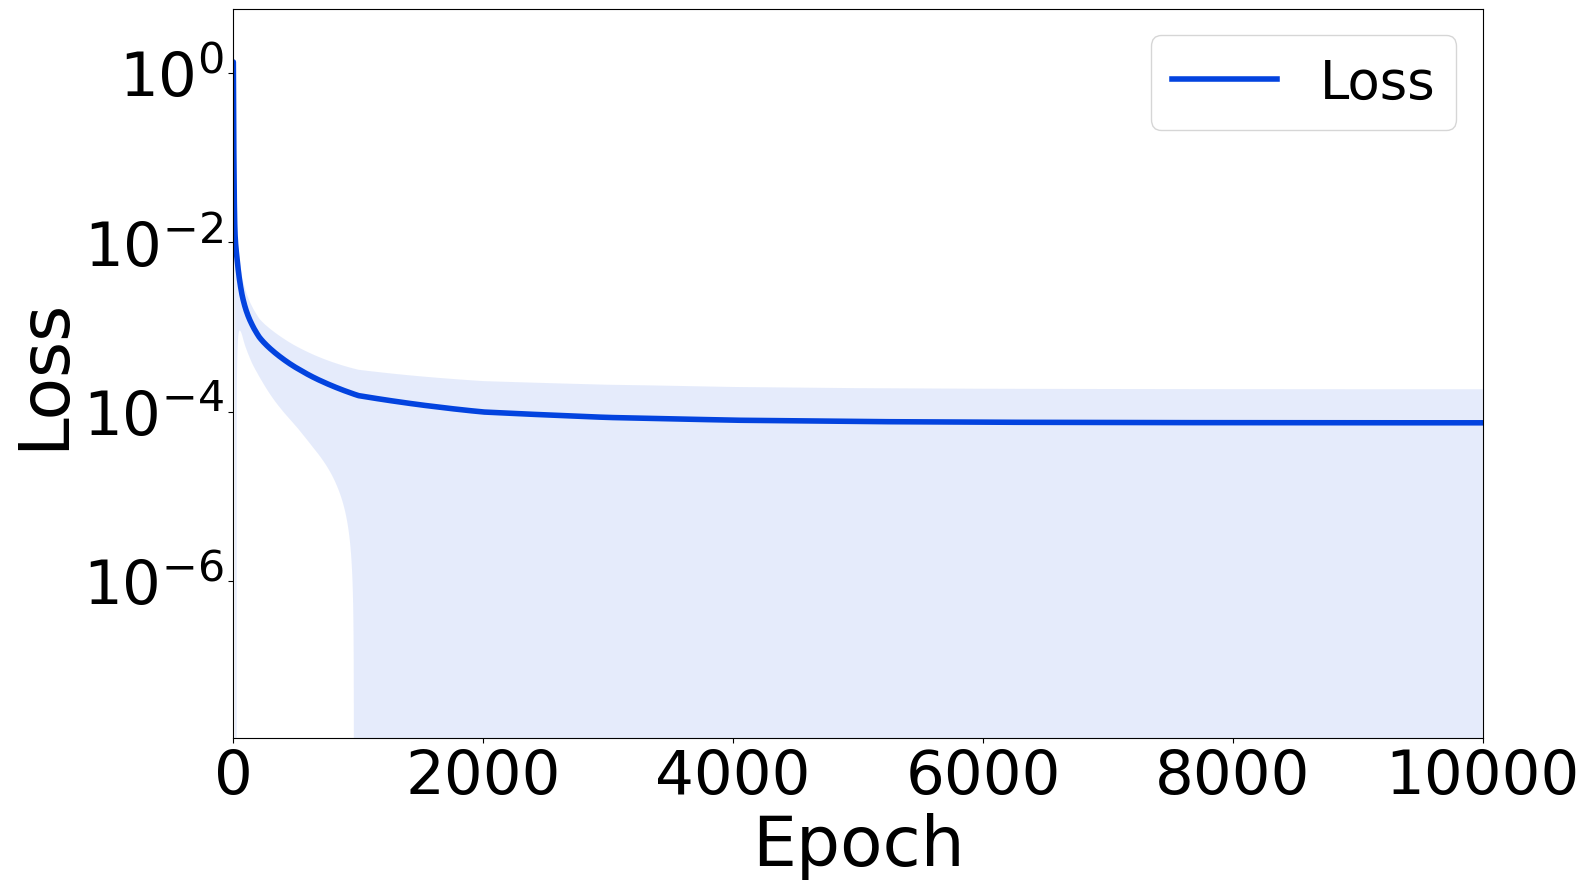

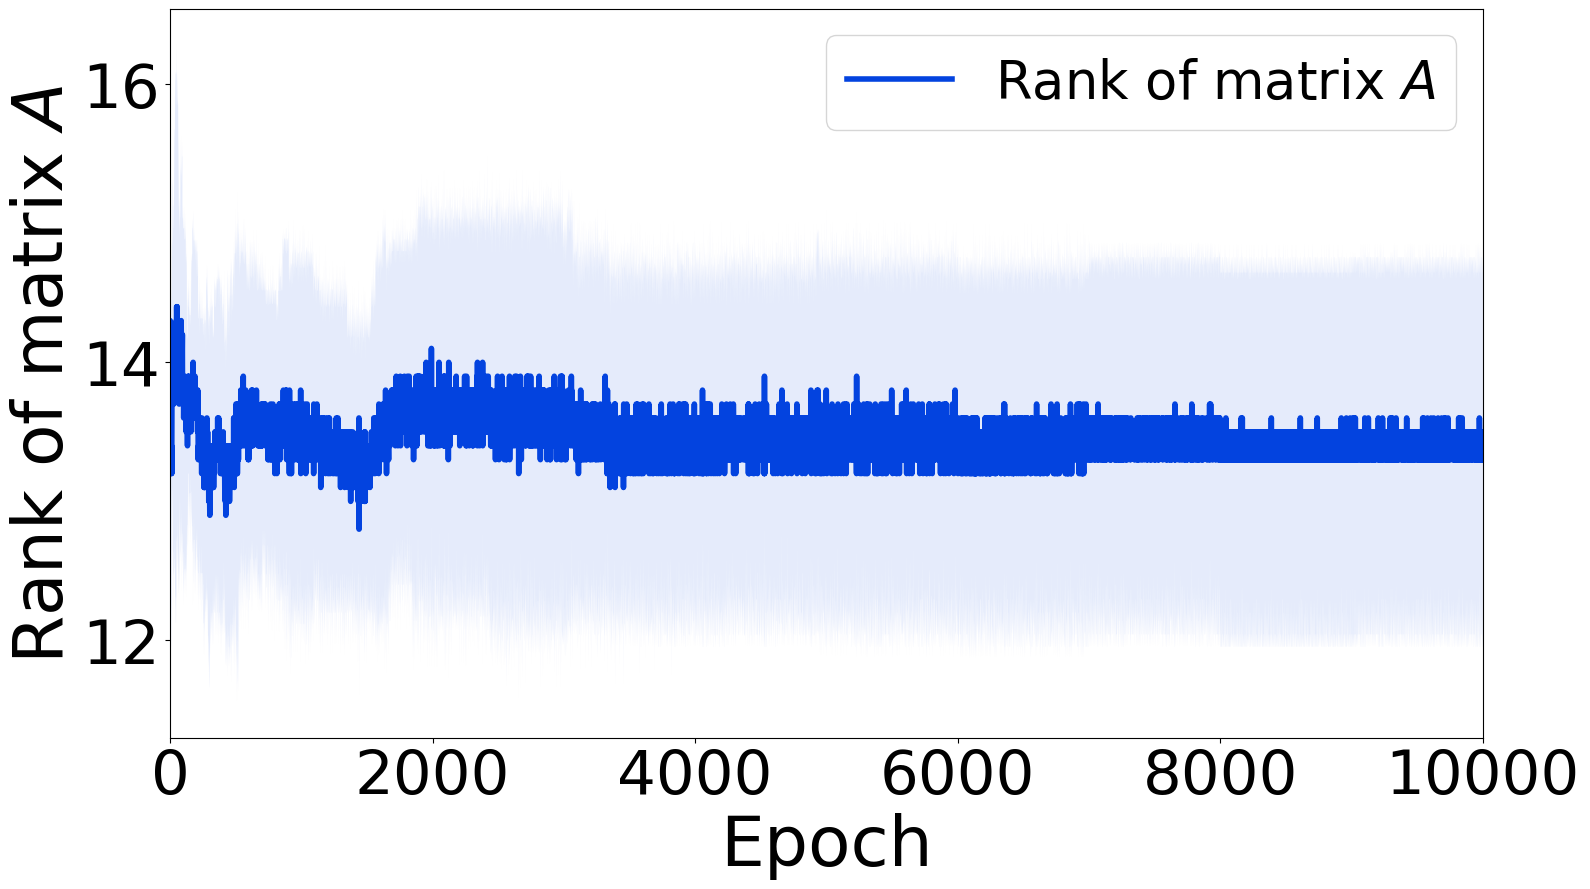

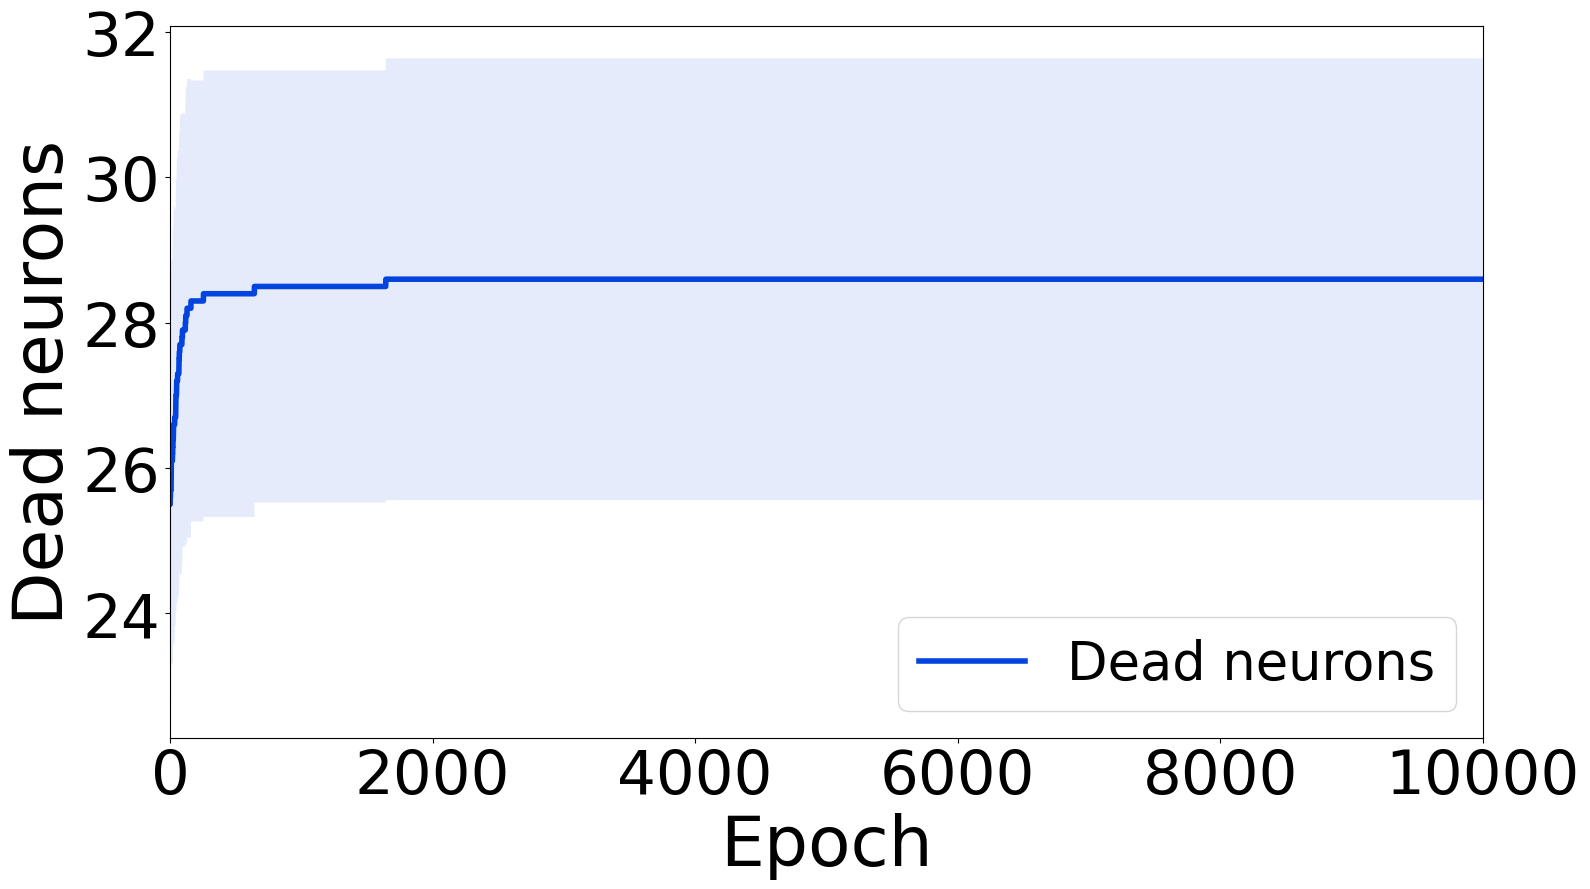

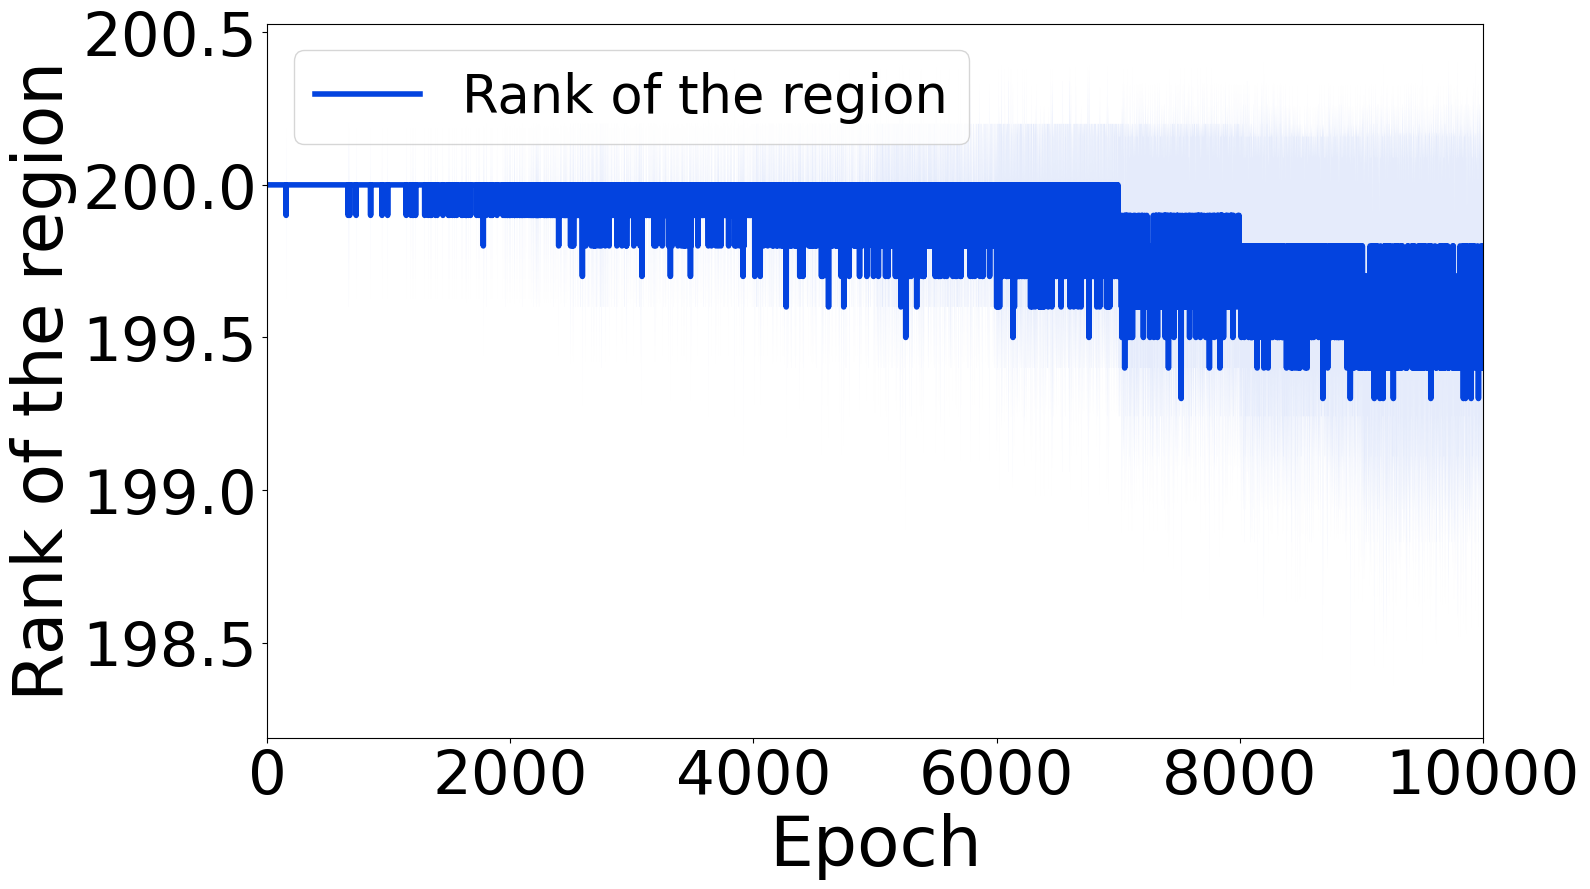

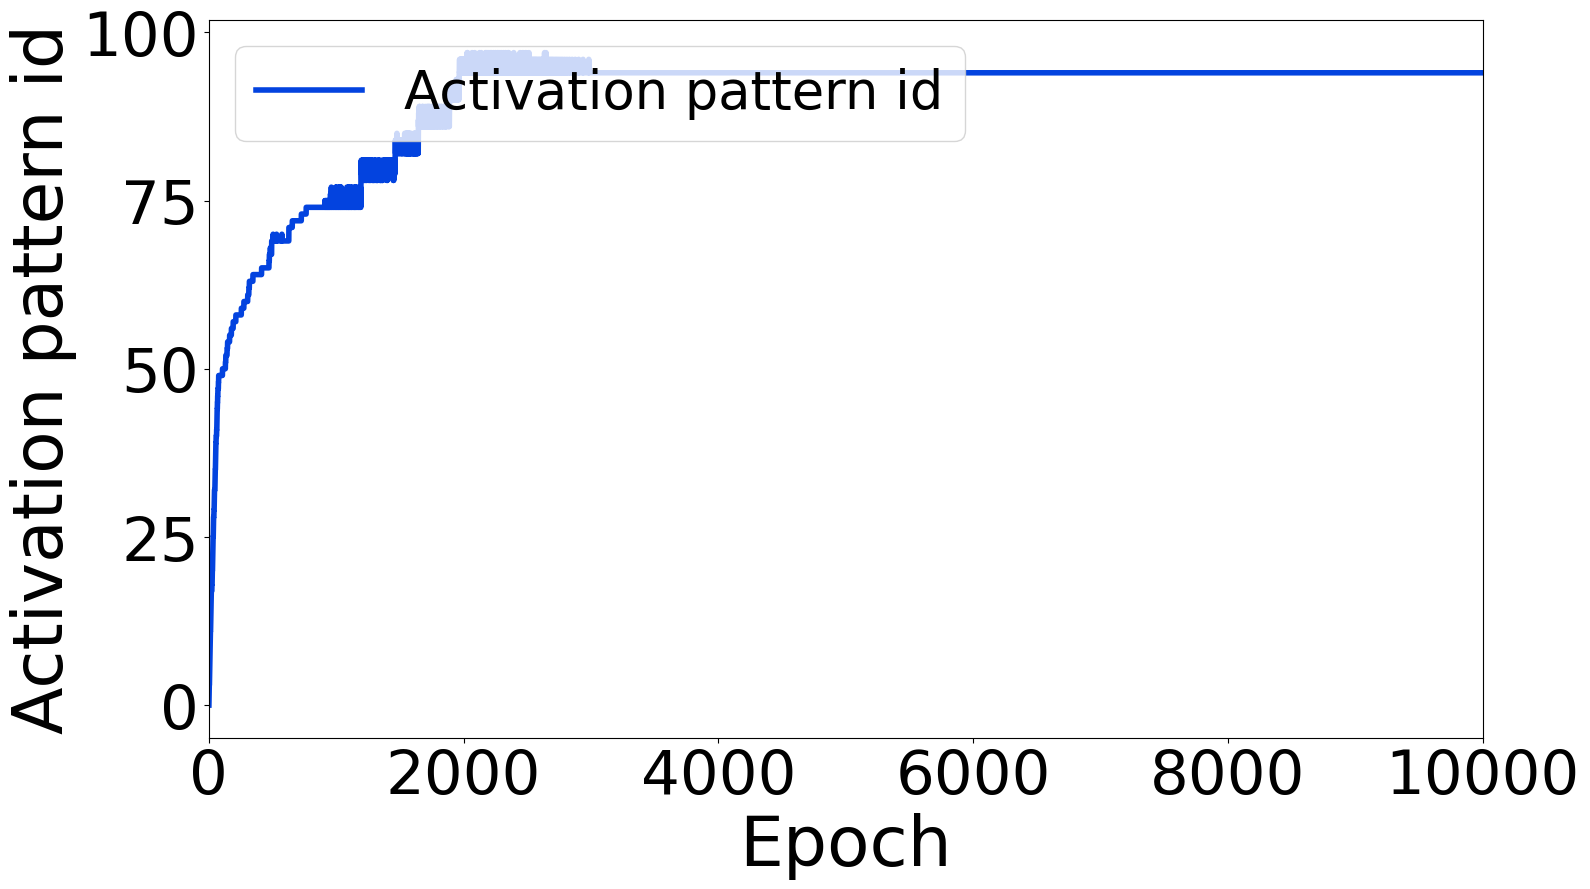

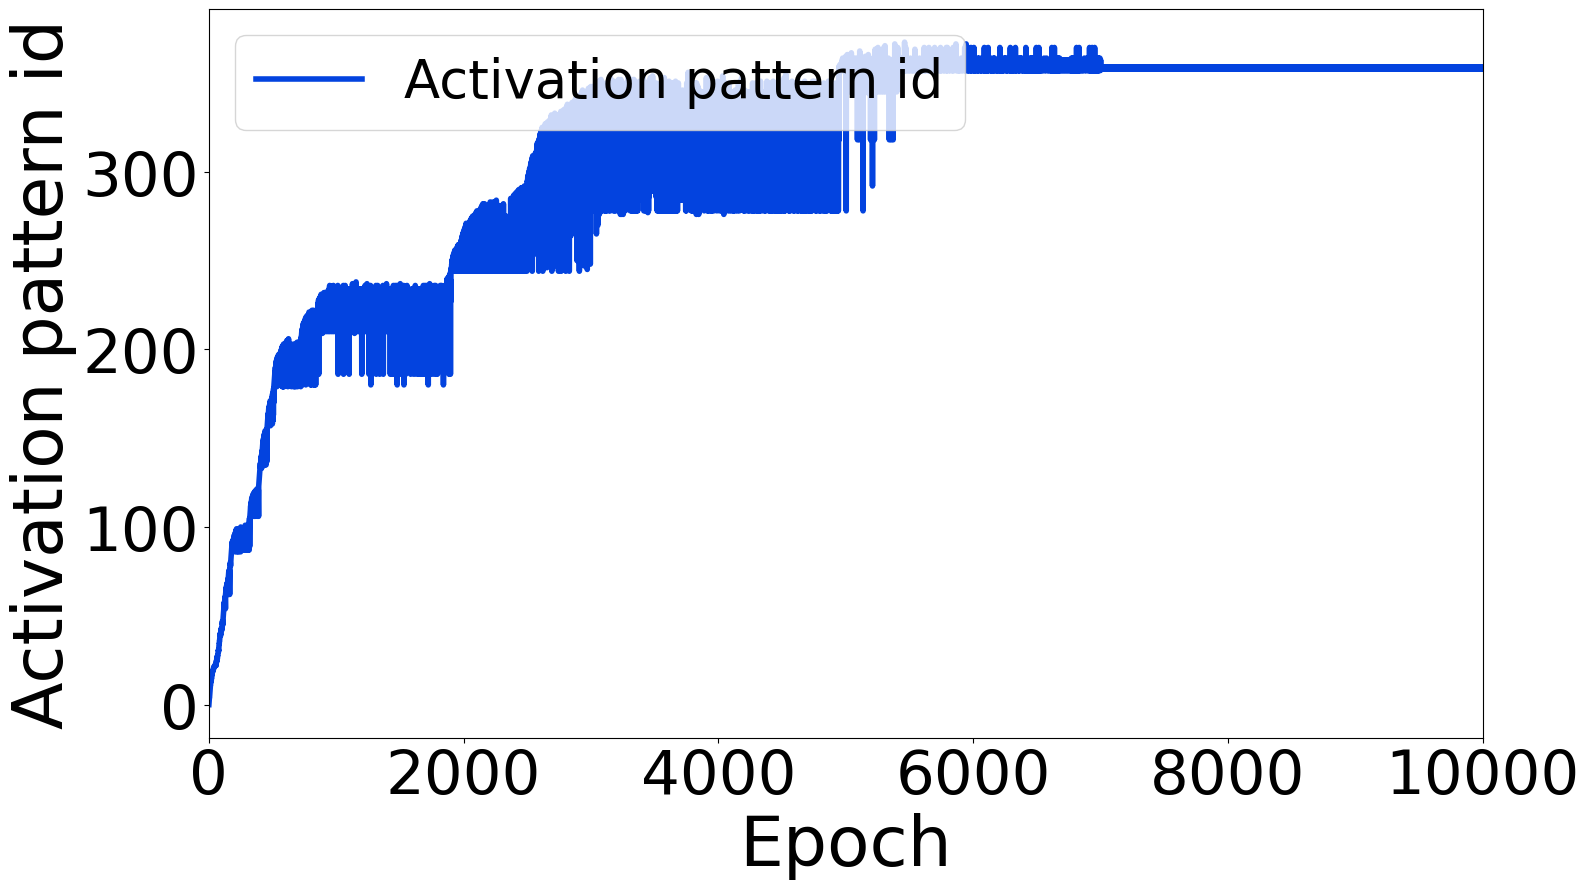

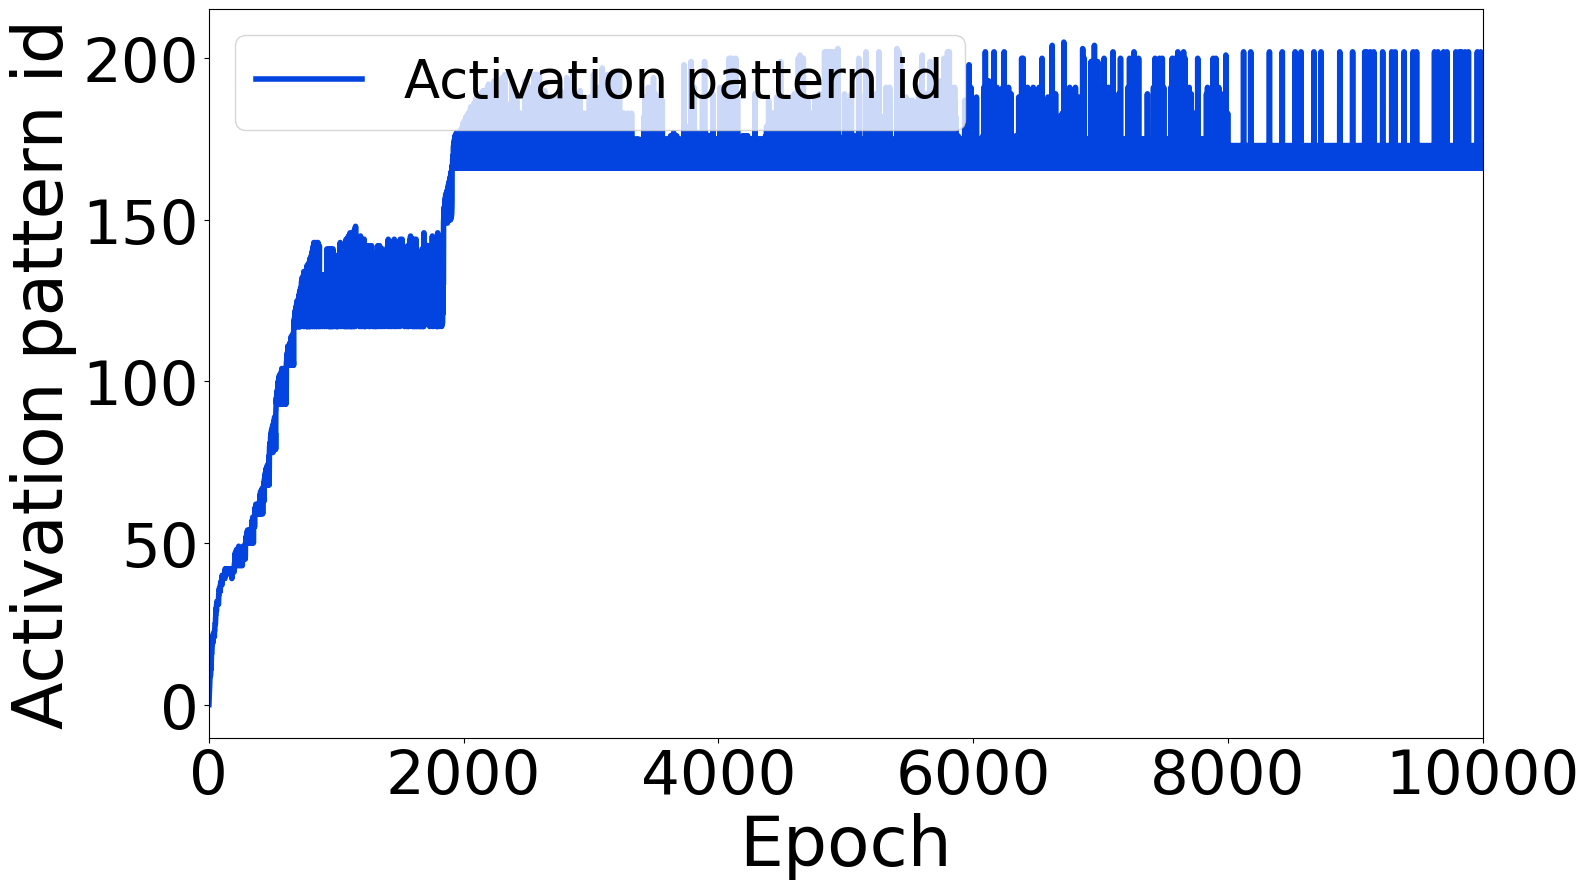

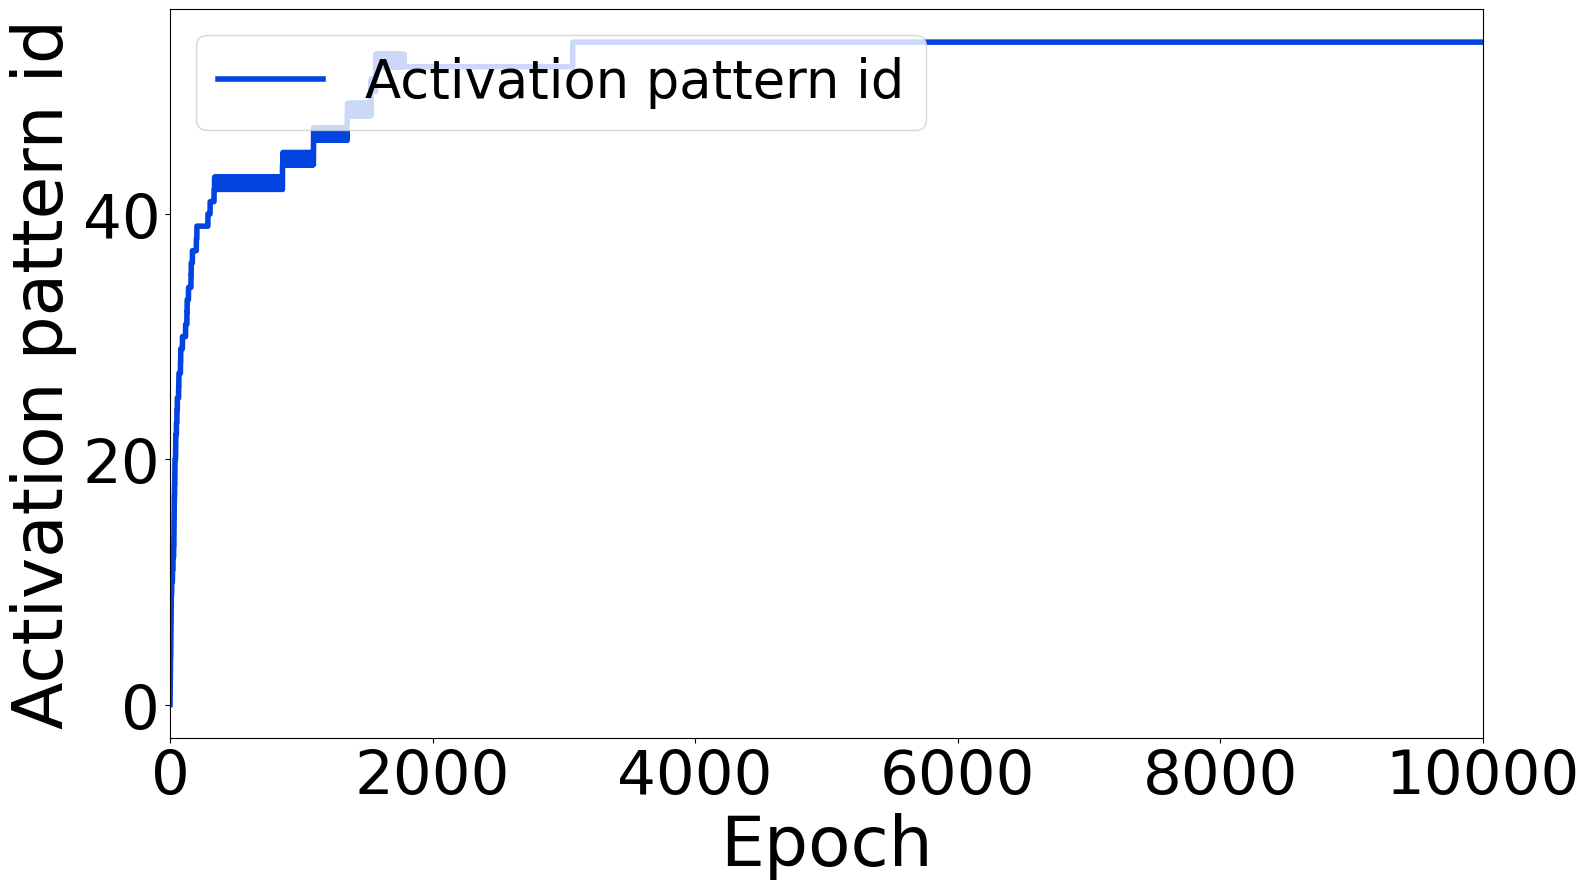

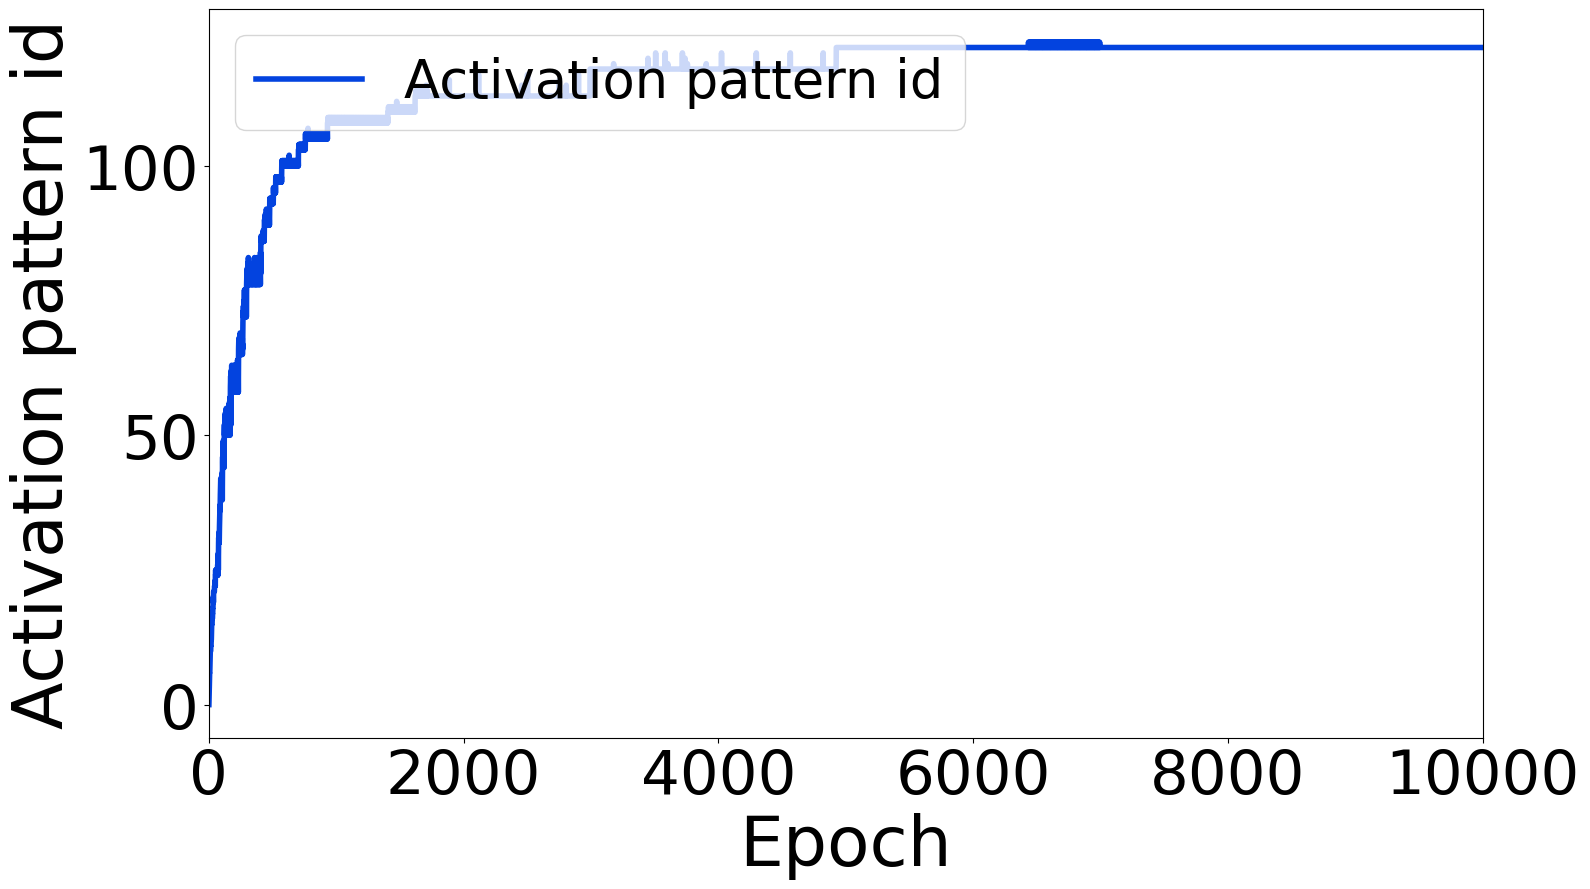

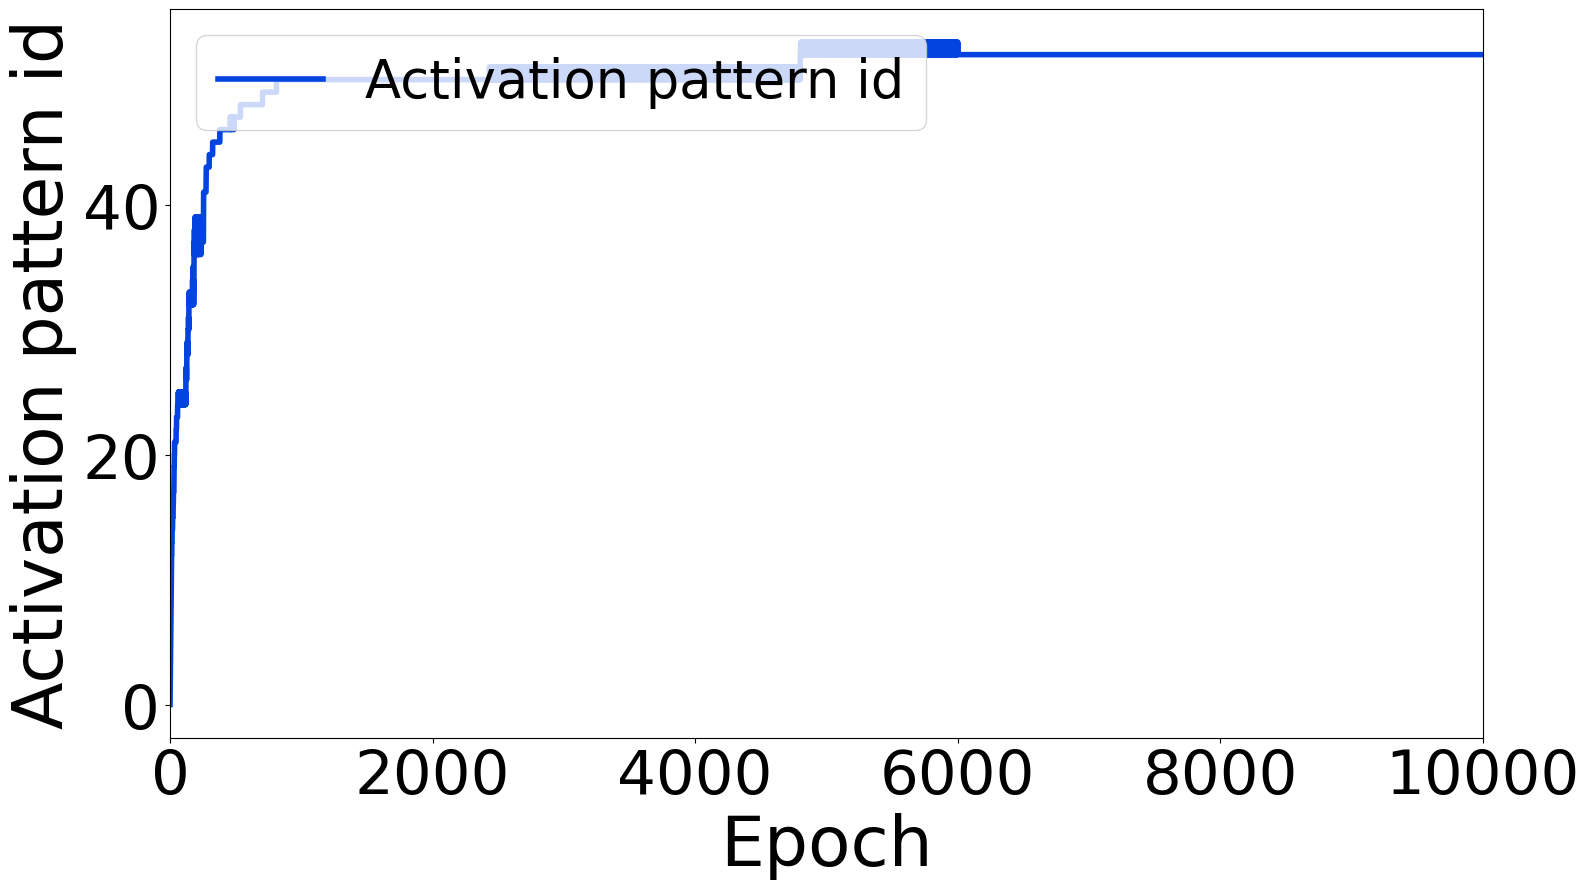

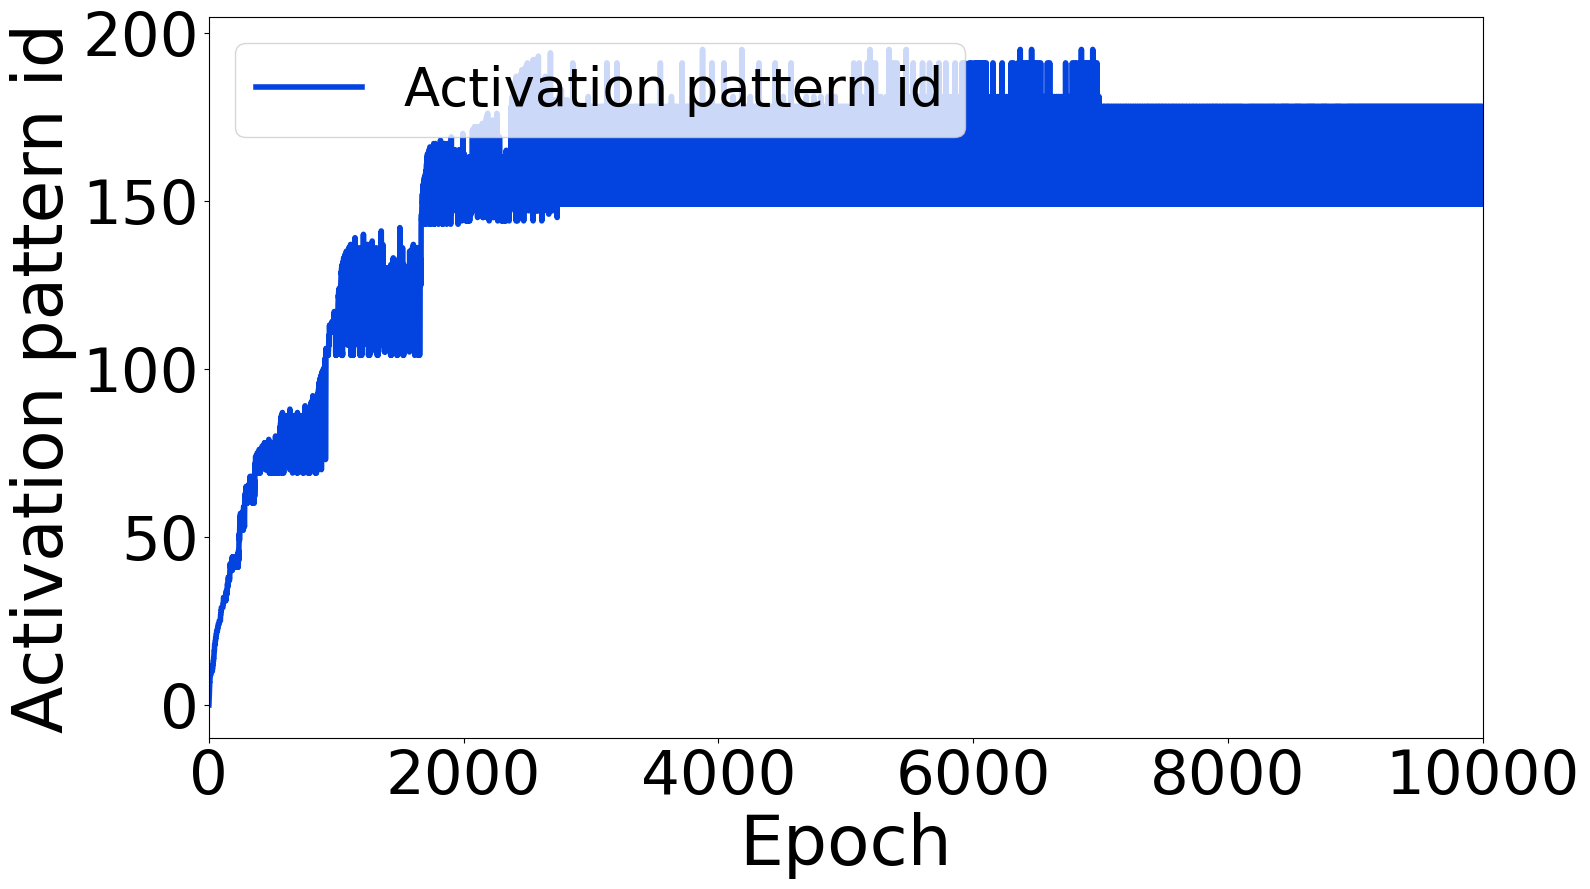

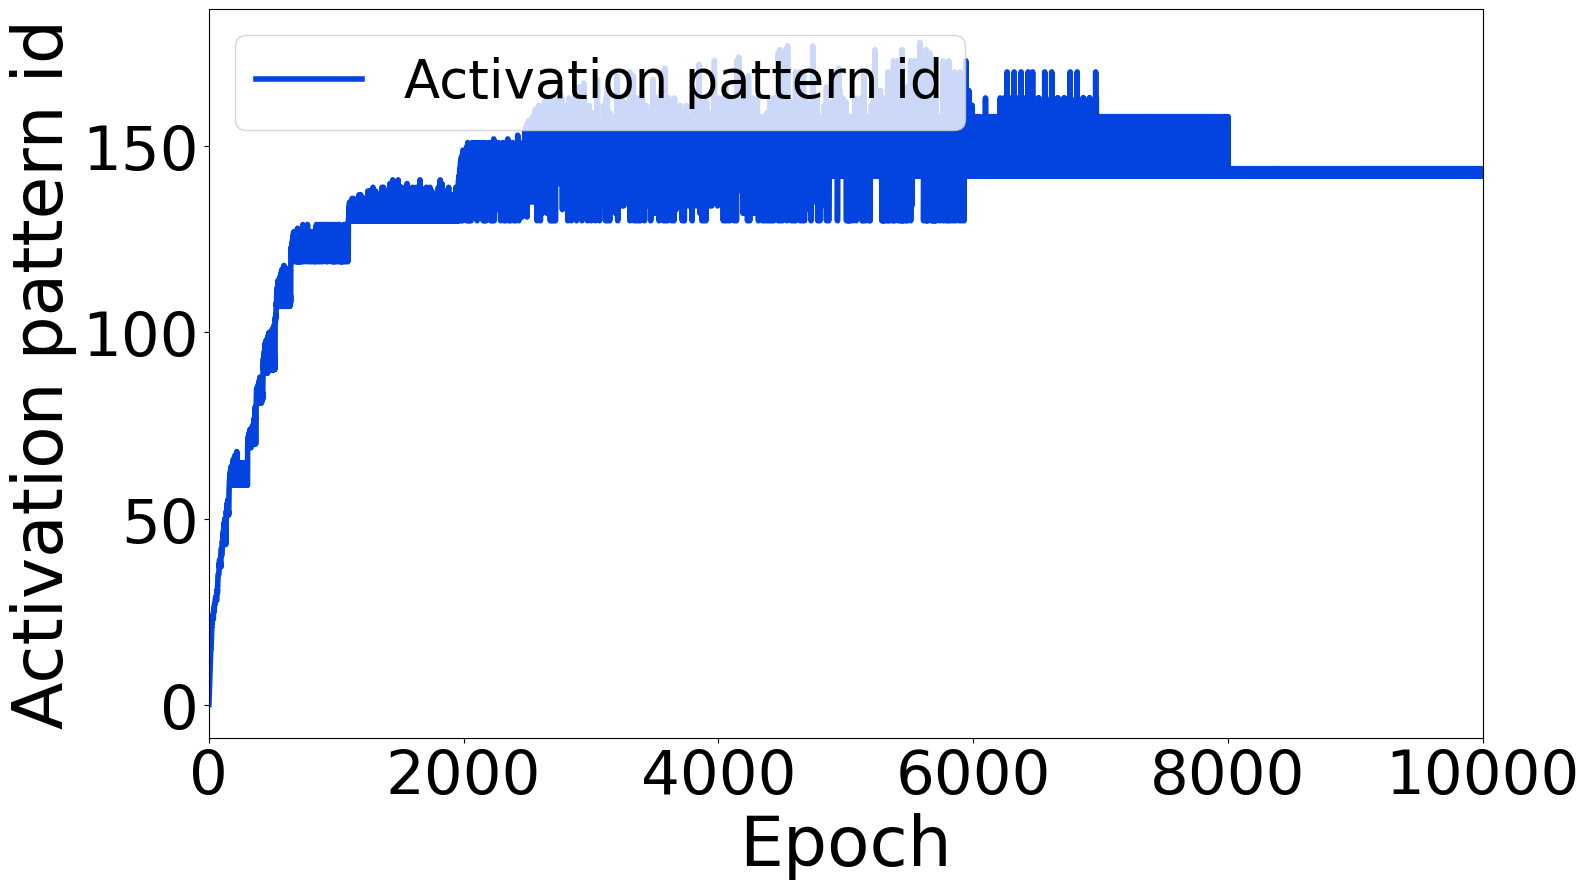

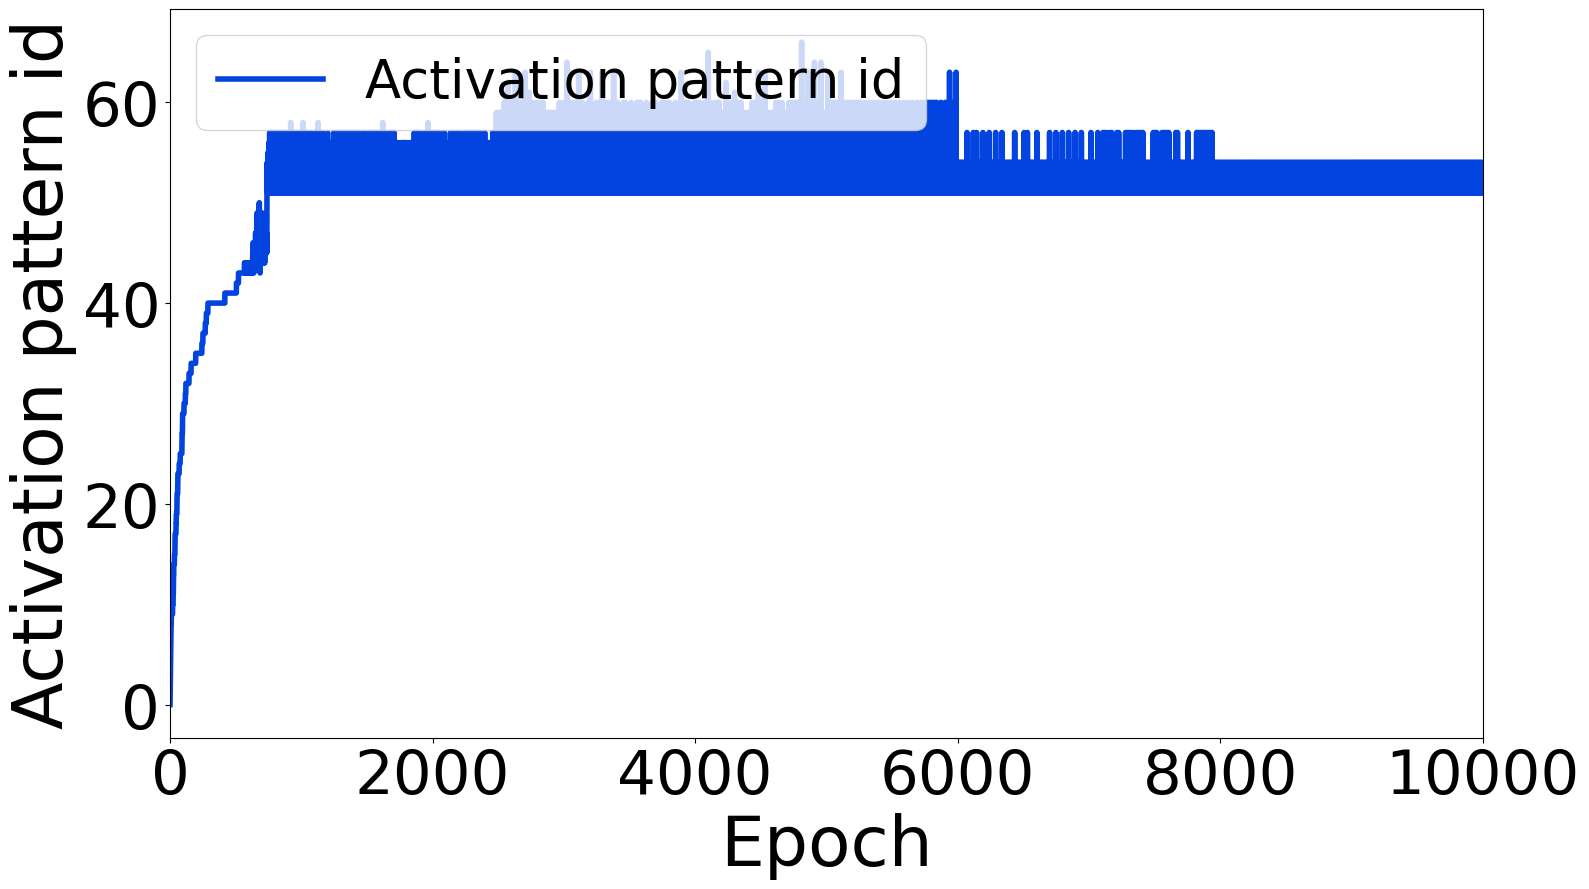

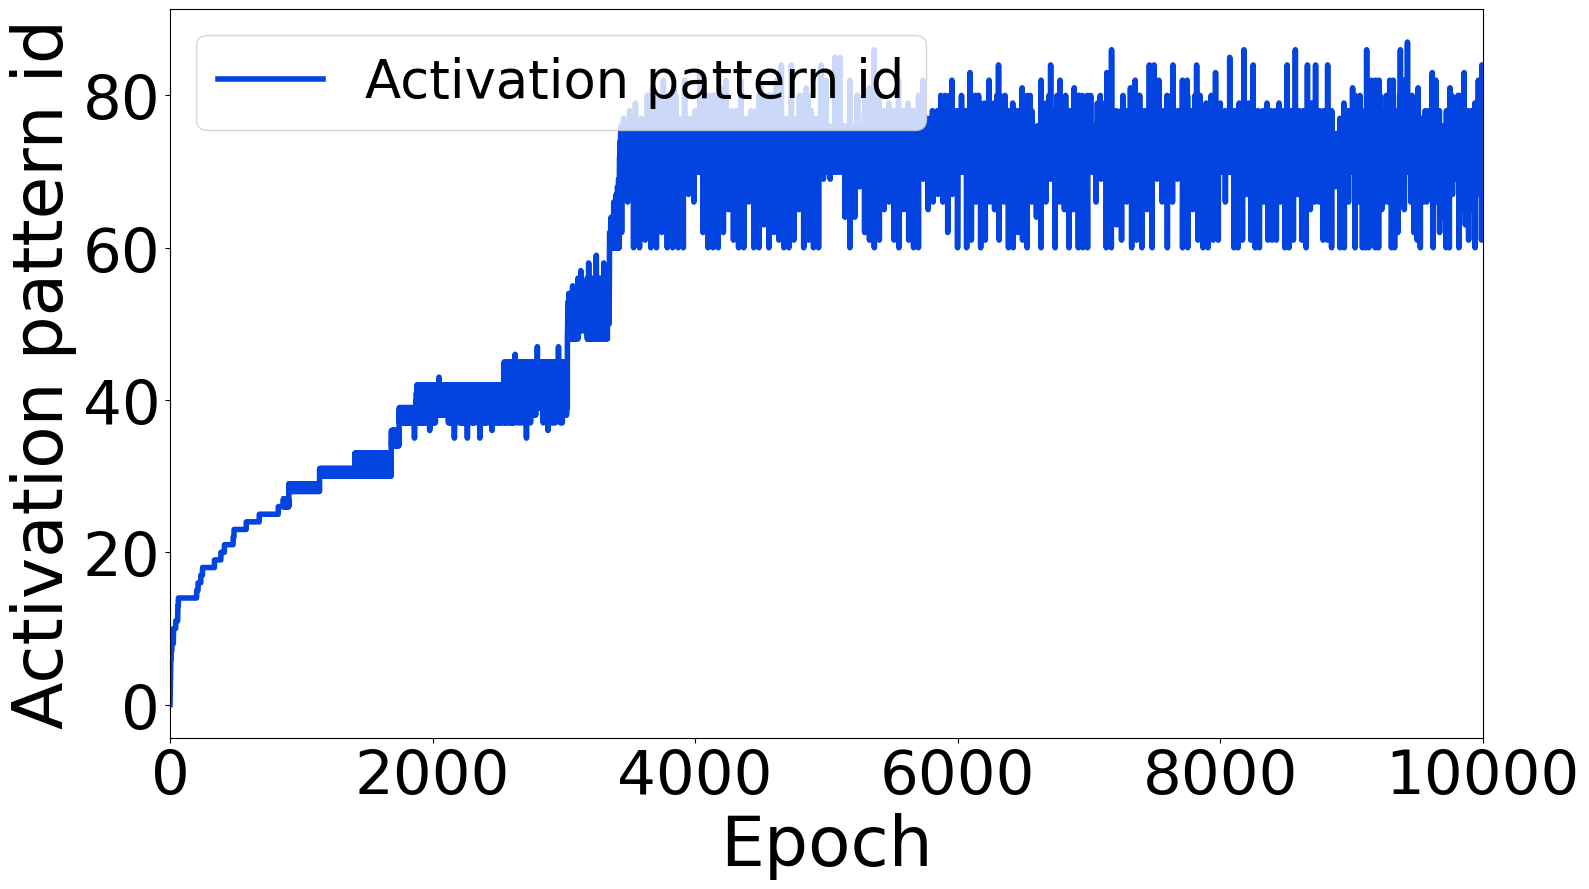

In [27]:
def plot_metric(x, y, y_std, ylabel, log, timestamp):
    fig = plt.figure(figsize=(16, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    if log:
        ax.set_yscale('log')
    
    plt.plot(x, y, linewidth=4, color='xkcd:blue', label=ylabel)
    plt.fill_between(x, y - y_std, y + y_std, facecolor='xkcd:blue', alpha=0.1)

    plt.xlabel('Epoch', size=50)
    plt.xlim(xmin=x[0], xmax=x[-1])
    ax.yaxis.get_offset_text().set_fontsize(30)
    if ylabel == 'Jacobian rank':
        plt.ylim(ymin=int(np.floor(np.min(y))) - 1, ymax=int(np.ceil(np.max(y))) + 1)

    if ylabel == 'Distance to the closest boundary':
        xticks = [0] + [i * 10 for i in range(1, len(x))]
        ax.set_xticks(x, xticks)
        plt.ylabel('Distance', size=50)
    else:
        plt.ylabel(ylabel, size=50)

    legend_loc = 'upper left'
    if ylabel in ['Loss', 'Rank of matrix $A$']:
        legend_loc = 'upper right'
    if ylabel in ['Dead neurons']:
        legend_loc = 'lower right'
    plt.legend(loc=legend_loc, fontsize=38, title_fontsize=42)
    plt.tight_layout()
    
    plt.savefig(f'images/local_or_global_minimum/{timestamp}_{ylabel}.png')
    
# #######################################################################################################
# #######################################################################################################

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# ################################################
# # Generate the plots
# ################################################

# Plot loss
loss_mean = np.mean(total_loss, axis=0)
loss_std = np.std(total_loss, axis=0)
plot_metric(x=list(range(len(loss_mean))), y=loss_mean, y_std=loss_std, ylabel='Loss', log=True,
           timestamp=timestamp)

# rank_mean = np.mean(total_ranks, axis=0)
# rank_std = np.std(total_ranks, axis=0)
# plot_metric(x=list(range(EPOCHS_NUM + 1)), y=rank_mean, y_std=rank_std, ylabel='Jacobian rank',
#             log=False, timestamp=timestamp)

# ratio_mean = np.mean(total_ratios, axis=0)
# ratio_std = np.std(total_ratios, axis=0)
# plot_metric(x=list(range(EPOCHS_NUM + 1)), y=ratio_mean, y_std=ratio_std,
#             ylabel='Singular values ratio', log=False, timestamp=timestamp)

# Plot rank of the step matrix A
a_rank_mean = np.mean(total_a_ranks, axis=0)
a_rank_std = np.std(total_a_ranks, axis=0)
plot_metric(x=list(range(len(a_rank_mean))), y=a_rank_mean, y_std=a_rank_std,
            ylabel='Rank of matrix $A$', log=False, timestamp=timestamp)

# Plot number of dead neurons

N = x.size()[0]
total_dead_num = []
for pattern_arr in total_pattern_arr:
    dead_num_arr = []
    for pattern in pattern_arr:
        false_dict = defaultdict(int)
        for x_pattern in pattern:
            for pi, p in enumerate(x_pattern):
                if not p:
                    false_dict[pi] += 1
        dead_num_arr.append(len([ni for ni in false_dict if false_dict[ni] == N]))
    total_dead_num.append(dead_num_arr)
dead_num_mean = np.mean(total_dead_num, axis=0)
dead_numk_std = np.std(total_dead_num, axis=0)
plot_metric(x=list(range(len(dead_num_mean))), y=dead_num_mean, y_std=dead_numk_std,
            ylabel='Dead neurons', log=False, timestamp=timestamp)

# Plot dimension of the region we are in
region_dim_mean = np.mean(total_region_dim, axis=0)
region_dim_std = np.std(total_region_dim, axis=0)
plot_metric(x=list(range(len(region_dim_mean))), y=region_dim_mean, y_std=region_dim_std,
            ylabel='Rank of the region', log=False, timestamp=timestamp)

# Plot ids of the activation patterns passed during optimization
# The last pattern_arr is plotted
for pi, pattern_arr in enumerate(total_pattern_arr):
    tp_arr = [tuple(pattern.reshape(-1)) for pattern in pattern_arr]
    pattern_dict = {}
    for pattern in pattern_arr:
        tp = tuple(pattern.reshape(-1))
        tp_hash = hash(tp)
        if tp_hash not in pattern_dict:
            pattern_dict[tp_hash] = len(pattern_dict)
    pattern_id_arr = np.asarray([pattern_dict[hash(tp)] for tp in tp_arr])
    plot_metric(x=list(range(EPOCHS_NUM + 1)), y=pattern_id_arr, y_std=np.zeros(EPOCHS_NUM + 1),
                ylabel='Activation pattern id', log=False, timestamp=timestamp)
    print(f'total number of different activation patterns: {len(pattern_dict)}')

# # Distance to the boundary
# for e_id, da in enumerate(distance_arr):
#     plot_histogram(x=da, epoch=e_id * DISTANCE_EPOCH, timestamp=timestamp)
    
# ################################################
# # Store data for the later reference
# ################################################
np.savetxt(f'data/local_or_global_minimum/{timestamp}_loss.txt', total_loss)
# # np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_rank.txt', total_ranks)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_ratio.txt', total_ratios)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_a_rank.txt', a_rank_arr)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_pattern_id.txt', pattern_id_arr)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_distance_to_boundary.txt', distance_arr)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_region_dim.txt', total_region_dim)